# Daugaard Case Study with geology-resistivity-category prior models.

This notebook contains an example of inversion of the DAUGAARD tTEM data using three different geology-resistivity prior models

In [1]:
try:
    # Check if the code is running in an IPython kernel (which includes Jupyter notebooks)
    get_ipython()
    # If the above line doesn't raise an error, it means we are in a Jupyter environment
    # Execute the magic commands using IPython's run_line_magic function
    get_ipython().run_line_magic('load_ext', 'autoreload')
    get_ipython().run_line_magic('autoreload', '2')
except:
    # If get_ipython() raises an error, we are not in a Jupyter environment
    # # # # # # # # # #%load_ext autoreload
    # # # # # # # # # #%autoreload 2
    pass

import integrate as ig
import numpy as np
import os
import matplotlib.pyplot as plt
import h5py
hardcopy=True

import integrate as ig
# check if parallel computations can be performed
parallel = ig.use_parallel(showInfo=1)

Notebook detected. Parallel processing is OK


## Download the data DAUGAARD data including non-trivial prior data

Getting data for case: DAUGAARD


Downloaded prior_detailed_invalleys_N2000000_dmax90.h5


Downloaded prior_detailed_outvalleys_N2000000_dmax90.h5


Downloaded POST_DAUGAARD_AVG_prior_detailed_invalleys_N2000000_dmax90_TX07_20231016_2x4_RC20-33_Nh280_Nf12_Nu2000000_aT1.h5


Downloaded POST_DAUGAARD_AVG_prior_detailed_outvalleys_N2000000_dmax90_TX07_20231016_2x4_RC20-33_Nh280_Nf12_Nu2000000_aT1.h5


Downloaded prior_detailed_inout_N4000000_dmax90_TX07_20231016_2x4_RC20-33_Nh280_Nf12.h5
--> Got data for case: DAUGAARD
<KeysViewHDF5 ['d_obs', 'd_std', 'i_hm', 'i_lm']>
Using hdf5 data file DAUGAARD_AVG_test.h5 with gex file TX07_20231016_2x4_RC20-33.gex


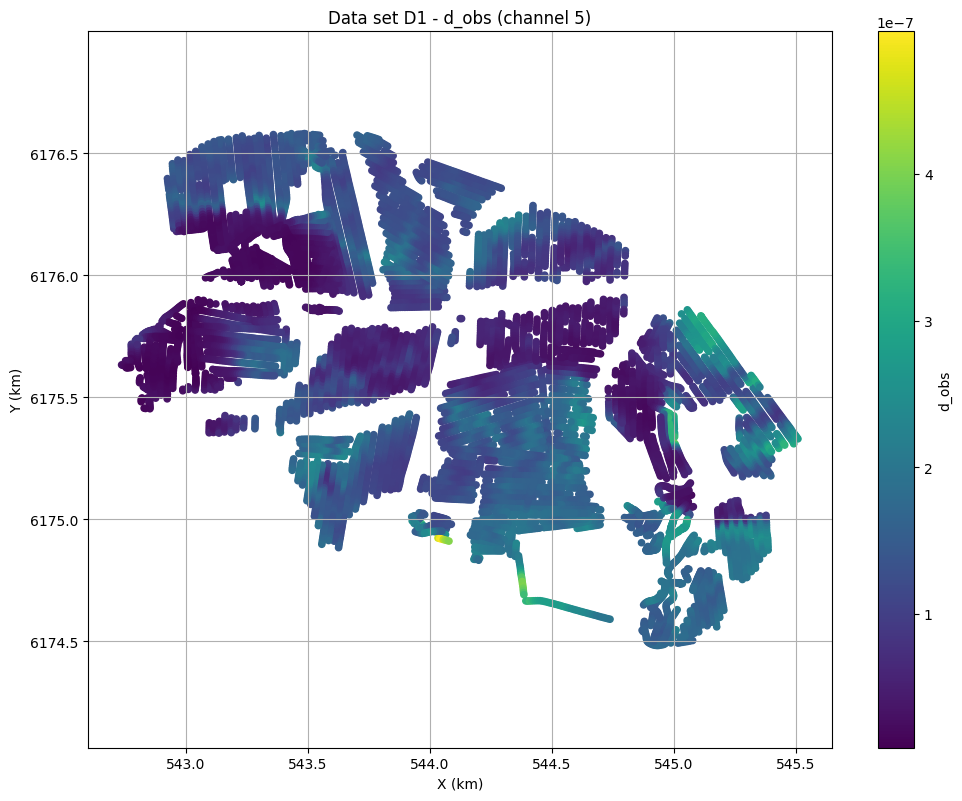

In [2]:
# For this case, we use a ready to use prior model and data set form DAUGAARD
files = ig.get_case_data(case='DAUGAARD', loadType='inout') # Load data and prior+data realizations
#files = ig.get_case_data(case='DAUGAARD', loadType='post') # # Load data and posterior realizations
#files = ig.get_case_data(case='DAUGAARD', loadAll=True) # All of the above
f_data_h5 = files[0]
file_gex= ig.get_gex_file_from_data(f_data_h5)
# check that file_gex exists
if not os.path.isfile(file_gex):
    print("file_gex=%s does not exist in the current folder." % file_gex)


# make a copy using 'os' of  DAUGAARD_AVG.h5  DAUGAARD_AVG_test.h5 using the system
f_data_h5 = 'DAUGAARD_AVG_test.h5'
os.system('cp DAUGAARD_AVG.h5 %s' % (f_data_h5))

# Update and increase noise assumption
# Read 'D1/d_std' from f_data_h5, increase it by 100% and write it back to f_data_h5
with h5py.File(f_data_h5, 'a') as f:
    print(f['D1'].keys())
    d_std = f['D1/d_std'][:]
    d_std = d_std*10
    f['D1/d_std'][:] = d_std

print('Using hdf5 data file %s with gex file %s' % (f_data_h5,file_gex))

fig=ig.plot_data_xy(f_data_h5, data_channel=5)

In [3]:
# Lets first make a small copy of the large data set available
f_prior_org_h5 = 'prior_detailed_inout_N4000000_dmax90_TX07_20231016_2x4_RC20-33_Nh280_Nf12.h5'
N_small = 100000
f_prior_h5 = ig.copy_hdf5_file(f_prior_org_h5, 'prior_test.h5',N=N_small,showInfo=3)

print("Keys in DATA")
with h5py.File(f_data_h5, 'r') as f:
    print(f.keys()) 
    
print("Keys in PRIOR")
with h5py.File(f_prior_h5, 'r') as f:
    N = f['M1'].shape[0]
    print("N=%d" % N)
    print(f.keys()) 

Trying to copy prior_detailed_inout_N4000000_dmax90_TX07_20231016_2x4_RC20-33_Nh280_Nf12.h5 to prior_test.h5
Copying D1. 

D1 

Copying D2. D2 Copying M1. M1 

Copying M2. M2 

Copying M3. M3 
Keys in DATA
<KeysViewHDF5 ['D1', 'ELEVATION', 'LINE', 'UTMX', 'UTMY']>
Keys in PRIOR
N=100000
<KeysViewHDF5 ['D1', 'D2', 'M1', 'M2', 'M3']>


Note how 2 types of prior data are available, but only one observed data!!

## Setting up the data and prior models
At this point we have a prior with 
three data types of  MODEL parameters
M1: Resistivity
M2: Lithology
M3: Scenario category [0,1]
## We have two types of corresponding data 
D1: tTEM data
D2: Scenario category [0,1]

D2 is simply an exact copy of, as D3=I*M3, where I is the identity operator.

This means, if som information is available about the Scenario type 
this can be provided as a new 'observation'

Here is an example of how this can be done

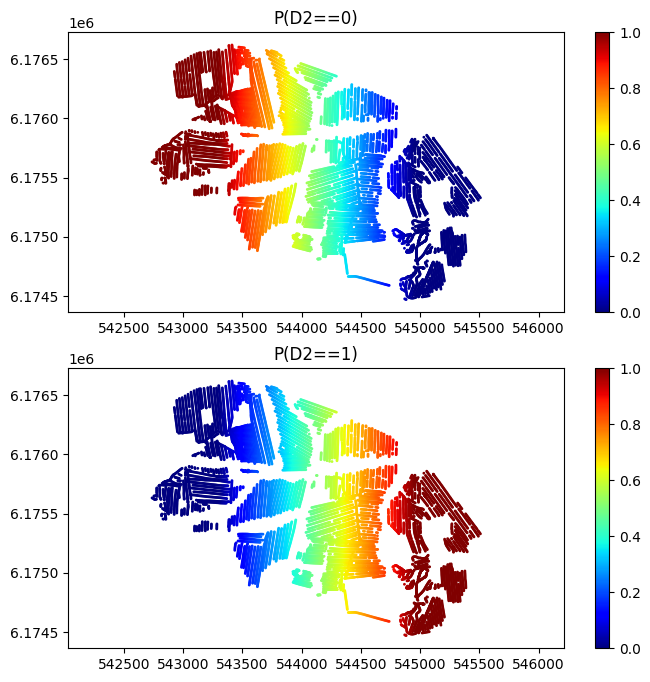

(2, 'DAUGAARD_AVG_test.h5')

In [4]:
X, Y, LINE, ELEVATION = ig.get_geometry(f_data_h5)
Xmin = np.min(X)
Xmax = np.max(X)
Xl = Xmin + 0.2*(Xmax-Xmin)
Xr = Xmin + 0.8*(Xmax-Xmin)

P0 = 1# .9999 # Probability of category 0
Pcat0 = np.zeros(len(X))-1
for i in range(len(X)):
    if X[i] < Xl:
        Pcat0[i] = P0
    elif X[i] > Xr:
        Pcat0[i] = 1-P0
    else:
        #Pcat0[i] = .5
        Pcat0[i] = P0+(1-2*P0)*(X[i]-Xl)/(Xr-Xl)

nclasses = 2
D_obs = np.zeros((len(X),2))
D_obs[:,0] = Pcat0
D_obs[:,1] = 1-Pcat0

plt.figure(figsize=(8,8))
for ic in range(nclasses):
    plt.subplot(2,1,ic+1)
    sc = plt.scatter(X, Y, c=D_obs[:,ic], cmap='jet', vmin=0, vmax=1, s=1)
    plt.colorbar(sc)
    plt.title('P(D2==%d)'%(ic))
    plt.axis('equal')
plt.show()

# ig.save_data_gaussian(f_data_h5, D_obs, 'D2', 'Scenario    )
# Now write the 'observed data as a new data type
# If the 'id' is not set, it will be set to the next available id
#ig.save_data_multinomial(D_obs, f_data_h5 = f_data_h5, showInfo=2)
# If the if is set, the data will be written to the given id, even if it allready exists
ig.save_data_multinomial(D_obs, id=2, f_data_h5 = f_data_h5, showInfo=-1)



## Ready for inversion !!

In [5]:
print("Keys in DATA")
with h5py.File(f_data_h5, 'r') as f:
    print(f.keys()) 

Keys in DATA
<KeysViewHDF5 ['D1', 'D2', 'ELEVATION', 'LINE', 'UTMX', 'UTMY']>


In [6]:
# identity copy of the prior model type for "Scenario", M3

Lets first add information directly about the scenario. 

Rejection Sampling:   0%|                                                                                                                      | 0/1462 [00:00<?, ?it/s]

Rejection Sampling:   0%|                                                                                                                      | 0/1462 [00:00<?, ?it/s]

Rejection Sampling:   0%|                                                                                                                      | 0/1462 [00:00<?, ?it/s]

Rejection Sampling:   0%|                                                                                                                      | 0/1462 [00:00<?, ?it/s]

Rejection Sampling:   0%|                                                                                                                      | 0/1462 [00:00<?, ?it/s]

Rejection Sampling:   0%|                                                                                                                      | 0/1461 [00:00<?, ?it/s]

Rejection Sampling:   0%|                                                                                                                      | 0/1461 [00:00<?, ?it/s]

Rejection Sampling:   0%|                                                                                                                      | 0/1461 [00:00<?, ?it/s]

Rejection Sampling:   0%|                                                                                                              | 1/1462 [00:00<16:08,  1.51it/s]

Rejection Sampling:   0%|                                                                                                              | 1/1462 [00:00<18:04,  1.35it/s]

Rejection Sampling:   0%|                                                                                                              | 1/1461 [00:00<17:14,  1.41it/s]

Rejection Sampling:   2%|██▏                                                                                                          | 29/1462 [00:00<00:28, 50.81it/s]

Rejection Sampling:   0%|                                                                                                              | 1/1462 [00:00<18:46,  1.30it/s]

Rejection Sampling:   2%|██▏                                                                                                          | 30/1462 [00:00<00:30, 47.68it/s]

Rejection Sampling:   2%|██▏                                                                                                          | 30/1461 [00:00<00:28, 49.60it/s]

Rejection Sampling:   4%|████▏                                                                                                        | 56/1462 [00:00<00:15, 93.60it/s]

Rejection Sampling:   2%|██▏                                                                                                          | 30/1462 [00:00<00:31, 46.19it/s]

Rejection Sampling:   0%|                                                                                                              | 1/1462 [00:00<22:12,  1.10it/s]

Rejection Sampling:   4%|███▉                                                                                                         | 52/1462 [00:00<00:17, 79.79it/s]

Rejection Sampling:   0%|                                                                                                              | 1/1461 [00:00<22:05,  1.10it/s]

Rejection Sampling:   3%|███▊                                                                                                         | 51/1461 [00:00<00:17, 80.14it/s]

Rejection Sampling:   0%|                                                                                                              | 1/1461 [00:00<23:32,  1.03it/s]

Rejection Sampling:   4%|████▏                                                                                                        | 57/1462 [00:00<00:16, 86.50it/s]

Rejection Sampling:   0%|                                                                                                              | 1/1462 [00:00<24:00,  1.01it/s]

Rejection Sampling:   2%|█▊                                                                                                           | 25/1462 [00:01<00:43, 33.41it/s]

Rejection Sampling:   1%|█                                                                                                            | 15/1461 [00:01<01:12, 19.99it/s]

Rejection Sampling:   5%|█████▍                                                                                                      | 73/1461 [00:01<00:12, 110.19it/s]

Rejection Sampling:   5%|█████▋                                                                                                      | 77/1462 [00:01<00:13, 102.36it/s]

Rejection Sampling:   1%|▉                                                                                                            | 12/1461 [00:01<01:36, 15.03it/s]

Rejection Sampling:   5%|█████▉                                                                                                      | 80/1462 [00:01<00:11, 115.91it/s]

Rejection Sampling:   1%|█                                                                                                            | 14/1462 [00:01<01:23, 17.26it/s]

Rejection Sampling:   3%|███▋                                                                                                         | 49/1462 [00:01<00:21, 66.82it/s]

Rejection Sampling:   5%|█████▎                                                                                                       | 72/1462 [00:01<00:15, 91.09it/s]

Rejection Sampling:   3%|██▊                                                                                                          | 38/1461 [00:01<00:26, 54.06it/s]

Rejection Sampling:   6%|███████                                                                                                     | 95/1462 [00:01<00:11, 118.28it/s]

Rejection Sampling:   7%|███████▊                                                                                                   | 107/1462 [00:01<00:09, 150.52it/s]

Rejection Sampling:   2%|█▉                                                                                                           | 26/1461 [00:01<00:41, 34.23it/s]

Rejection Sampling:   2%|██                                                                                                           | 28/1462 [00:01<00:40, 35.62it/s]

Rejection Sampling:   5%|█████▌                                                                                                      | 76/1462 [00:01<00:13, 104.49it/s]

Rejection Sampling:   6%|██████▊                                                                                                     | 93/1461 [00:01<00:12, 113.17it/s]

Rejection Sampling:   6%|██████▌                                                                                                     | 89/1462 [00:01<00:13, 101.17it/s]

Rejection Sampling:   4%|████▌                                                                                                        | 61/1461 [00:01<00:16, 86.66it/s]

Rejection Sampling:   8%|█████████                                                                                                  | 123/1462 [00:01<00:08, 154.79it/s]

Rejection Sampling:   9%|█████████▉                                                                                                 | 135/1462 [00:01<00:07, 181.61it/s]

Rejection Sampling:   3%|███                                                                                                          | 41/1461 [00:01<00:26, 54.55it/s]

Rejection Sampling:   7%|███████▌                                                                                                   | 104/1462 [00:01<00:09, 140.95it/s]

Rejection Sampling:   3%|███▋                                                                                                         | 49/1462 [00:01<00:21, 65.94it/s]

Rejection Sampling:   8%|████████                                                                                                   | 110/1461 [00:01<00:11, 115.63it/s]

Rejection Sampling:  10%|██████████▉                                                                                                | 150/1462 [00:01<00:07, 182.34it/s]

Rejection Sampling:   7%|███████▋                                                                                                   | 105/1462 [00:01<00:12, 106.03it/s]

Rejection Sampling:   5%|█████▉                                                                                                       | 79/1461 [00:01<00:14, 96.94it/s]

Rejection Sampling:  11%|███████████▋                                                                                               | 160/1462 [00:01<00:06, 198.66it/s]

Rejection Sampling:   4%|███▉                                                                                                         | 53/1461 [00:01<00:20, 67.66it/s]

Rejection Sampling:   4%|████▋                                                                                                        | 63/1462 [00:01<00:17, 77.96it/s]

Rejection Sampling:   9%|█████████▏                                                                                                 | 126/1461 [00:01<00:11, 119.68it/s]

Rejection Sampling:   9%|█████████▍                                                                                                 | 129/1462 [00:01<00:09, 134.99it/s]

Rejection Sampling:   7%|███████▌                                                                                                   | 103/1461 [00:01<00:10, 126.94it/s]

Rejection Sampling:  13%|█████████████▌                                                                                             | 186/1462 [00:01<00:05, 214.55it/s]

Rejection Sampling:   5%|█████▌                                                                                                      | 76/1461 [00:01<00:13, 103.97it/s]

Rejection Sampling:   9%|█████████▎                                                                                                 | 128/1462 [00:01<00:10, 129.67it/s]

Rejection Sampling:   5%|█████▋                                                                                                       | 77/1462 [00:01<00:15, 90.85it/s]

Rejection Sampling:  12%|████████████▋                                                                                              | 173/1462 [00:01<00:08, 153.50it/s]

Rejection Sampling:  10%|███████████▏                                                                                               | 153/1462 [00:01<00:08, 159.90it/s]

Rejection Sampling:  15%|███████████████▌                                                                                           | 212/1462 [00:01<00:05, 225.70it/s]

Rejection Sampling:   6%|██████▉                                                                                                     | 94/1461 [00:01<00:11, 122.36it/s]

Rejection Sampling:  10%|██████████▎                                                                                                | 141/1461 [00:01<00:11, 116.91it/s]

Rejection Sampling:   6%|██████▋                                                                                                     | 91/1462 [00:01<00:13, 100.22it/s]

Rejection Sampling:   8%|████████▉                                                                                                  | 122/1461 [00:01<00:11, 119.43it/s]

Rejection Sampling:  12%|████████████▉                                                                                              | 177/1462 [00:01<00:07, 179.52it/s]

Rejection Sampling:  10%|██████████▊                                                                                                | 148/1462 [00:01<00:10, 126.75it/s]

Rejection Sampling:   8%|████████▏                                                                                                  | 112/1461 [00:01<00:09, 135.23it/s]

Rejection Sampling:  16%|█████████████████▍                                                                                         | 238/1462 [00:01<00:05, 228.40it/s]

Rejection Sampling:  13%|██████████████                                                                                             | 192/1462 [00:01<00:09, 136.59it/s]

Rejection Sampling:  11%|███████████▎                                                                                               | 155/1461 [00:01<00:11, 113.13it/s]

Rejection Sampling:   7%|███████▋                                                                                                   | 105/1462 [00:01<00:12, 104.85it/s]

Rejection Sampling:  12%|████████████▌                                                                                              | 171/1462 [00:01<00:08, 147.12it/s]

Rejection Sampling:   9%|█████████▋                                                                                                 | 132/1461 [00:01<00:08, 151.08it/s]

Rejection Sampling:  18%|███████████████████▏                                                                                       | 263/1462 [00:01<00:05, 231.17it/s]

Rejection Sampling:   9%|██████████                                                                                                 | 138/1461 [00:01<00:11, 115.76it/s]

Rejection Sampling:  14%|██████████████▍                                                                                            | 198/1462 [00:01<00:07, 168.37it/s]

Rejection Sampling:   8%|████████▊                                                                                                  | 121/1462 [00:01<00:11, 118.17it/s]

Rejection Sampling:  11%|████████████▎                                                                                              | 168/1461 [00:01<00:11, 110.27it/s]

Rejection Sampling:  13%|██████████████▎                                                                                            | 196/1462 [00:01<00:07, 169.87it/s]

Rejection Sampling:  14%|███████████████▎                                                                                           | 209/1462 [00:01<00:09, 126.77it/s]

Rejection Sampling:  20%|█████████████████████                                                                                      | 288/1462 [00:01<00:04, 235.91it/s]

Rejection Sampling:  15%|███████████████▉                                                                                           | 217/1462 [00:01<00:07, 167.04it/s]

Rejection Sampling:  10%|███████████▏                                                                                               | 153/1461 [00:01<00:11, 114.91it/s]

Rejection Sampling:  10%|██████████▉                                                                                                | 150/1461 [00:01<00:09, 141.26it/s]

Rejection Sampling:  12%|█████████████▏                                                                                             | 180/1461 [00:01<00:11, 112.16it/s]

Rejection Sampling:   9%|█████████▉                                                                                                 | 135/1462 [00:01<00:11, 119.29it/s]

Rejection Sampling:  15%|████████████████▏                                                                                          | 222/1462 [00:02<00:06, 190.38it/s]

Rejection Sampling:  16%|████████████████▋                                                                                          | 228/1462 [00:02<00:08, 139.32it/s]

Rejection Sampling:  22%|███████████████████████                                                                                    | 315/1462 [00:02<00:04, 244.02it/s]

Rejection Sampling:  13%|██████████████                                                                                             | 192/1461 [00:02<00:11, 113.58it/s]

Rejection Sampling:  11%|████████████▏                                                                                              | 166/1461 [00:02<00:09, 140.42it/s]

Rejection Sampling:  11%|████████████▏                                                                                              | 167/1461 [00:02<00:11, 115.72it/s]

Rejection Sampling:  10%|██████████▉                                                                                                | 149/1462 [00:02<00:10, 122.57it/s]

Rejection Sampling:  16%|█████████████████▏                                                                                         | 235/1462 [00:02<00:08, 149.20it/s]

Rejection Sampling:  17%|██████████████████                                                                                         | 247/1462 [00:02<00:05, 204.51it/s]

Rejection Sampling:  17%|██████████████████▍                                                                                        | 252/1462 [00:02<00:07, 162.63it/s]

Rejection Sampling:  23%|████████████████████████▉                                                                                  | 341/1462 [00:02<00:04, 247.50it/s]

Rejection Sampling:  14%|██████████████▉                                                                                            | 204/1461 [00:02<00:11, 110.87it/s]

Rejection Sampling:  12%|█████████████▏                                                                                             | 180/1461 [00:02<00:11, 115.01it/s]

Rejection Sampling:  18%|██████████████████▋                                                                                        | 256/1462 [00:02<00:07, 163.67it/s]

Rejection Sampling:  19%|███████████████████▊                                                                                       | 271/1462 [00:02<00:05, 212.76it/s]

Rejection Sampling:  12%|█████████████▎                                                                                             | 182/1461 [00:02<00:09, 131.39it/s]

Rejection Sampling:  11%|███████████▉                                                                                               | 163/1462 [00:02<00:11, 117.51it/s]

Rejection Sampling:  25%|██████████████████████████▊                                                                                | 367/1462 [00:02<00:04, 246.53it/s]

Rejection Sampling:  19%|███████████████████▊                                                                                       | 271/1462 [00:02<00:08, 145.12it/s]

Rejection Sampling:  15%|████████████████                                                                                           | 220/1461 [00:02<00:10, 122.63it/s]

Rejection Sampling:  13%|██████████████▏                                                                                            | 193/1461 [00:02<00:10, 115.58it/s]

Rejection Sampling:  20%|█████████████████████▋                                                                                     | 296/1462 [00:02<00:05, 220.98it/s]

Rejection Sampling:  14%|██████████████▉                                                                                            | 204/1461 [00:02<00:08, 153.31it/s]

Rejection Sampling:  13%|█████████████▊                                                                                             | 188/1462 [00:02<00:08, 151.28it/s]

Rejection Sampling:  27%|████████████████████████████▊                                                                              | 393/1462 [00:02<00:04, 248.92it/s]

Rejection Sampling:  19%|████████████████████                                                                                       | 274/1462 [00:02<00:08, 147.61it/s]

Rejection Sampling:  20%|█████████████████████                                                                                      | 288/1462 [00:02<00:08, 146.70it/s]

Rejection Sampling:  17%|██████████████████                                                                                         | 247/1461 [00:02<00:07, 162.95it/s]

Rejection Sampling:  14%|███████████████                                                                                            | 206/1461 [00:02<00:10, 119.02it/s]

Rejection Sampling:  22%|███████████████████████▊                                                                                   | 325/1462 [00:02<00:04, 238.13it/s]

Rejection Sampling:  16%|████████████████▉                                                                                          | 232/1461 [00:02<00:06, 186.19it/s]

Rejection Sampling:  15%|███████████████▊                                                                                           | 216/1462 [00:02<00:06, 185.15it/s]

Rejection Sampling:  20%|█████████████████████▏                                                                                     | 290/1462 [00:02<00:08, 139.78it/s]

Rejection Sampling:  19%|███████████████████▉                                                                                       | 273/1461 [00:02<00:06, 188.78it/s]

Rejection Sampling:  24%|█████████████████████████▋                                                                                 | 351/1462 [00:02<00:04, 243.27it/s]

Rejection Sampling:  15%|████████████████                                                                                           | 219/1461 [00:02<00:10, 117.40it/s]

Rejection Sampling:  18%|██████████████████▉                                                                                        | 258/1461 [00:02<00:05, 205.64it/s]

Rejection Sampling:  21%|██████████████████████▏                                                                                    | 304/1462 [00:02<00:08, 137.29it/s]

Rejection Sampling:  17%|█████████████████▋                                                                                         | 242/1462 [00:02<00:05, 204.85it/s]

Rejection Sampling:  29%|██████████████████████████████▋                                                                            | 419/1462 [00:02<00:05, 192.96it/s]

Rejection Sampling:  20%|█████████████████████▊                                                                                     | 298/1461 [00:02<00:05, 205.53it/s]

Rejection Sampling:  26%|███████████████████████████▌                                                                               | 377/1462 [00:02<00:04, 247.41it/s]

Rejection Sampling:  21%|██████████████████████▎                                                                                    | 305/1462 [00:02<00:08, 131.82it/s]

Rejection Sampling:  19%|████████████████████▊                                                                                      | 284/1461 [00:02<00:05, 218.75it/s]

Rejection Sampling:  16%|████████████████▉                                                                                          | 232/1461 [00:02<00:10, 117.22it/s]

Rejection Sampling:  30%|████████████████████████████████▎                                                                          | 441/1462 [00:02<00:05, 198.83it/s]

Rejection Sampling:  22%|███████████████████████▎                                                                                   | 319/1462 [00:02<00:08, 132.60it/s]

Rejection Sampling:  18%|███████████████████▎                                                                                       | 264/1462 [00:02<00:06, 186.29it/s]

Rejection Sampling:  22%|███████████████████████▊                                                                                   | 325/1461 [00:02<00:05, 222.91it/s]

Rejection Sampling:  28%|█████████████████████████████▌                                                                             | 404/1462 [00:02<00:04, 252.78it/s]

Rejection Sampling:  21%|██████████████████████▊                                                                                    | 311/1461 [00:02<00:04, 232.56it/s]

Rejection Sampling:  17%|█████████████████▉                                                                                         | 245/1461 [00:02<00:10, 119.80it/s]

Rejection Sampling:  22%|███████████████████████▎                                                                                   | 319/1462 [00:02<00:08, 127.48it/s]

Rejection Sampling:  32%|██████████████████████████████████▎                                                                        | 468/1462 [00:02<00:04, 216.72it/s]

Rejection Sampling:  23%|████████████████████████▎                                                                                  | 333/1462 [00:02<00:08, 131.15it/s]

Rejection Sampling:  20%|█████████████████████▎                                                                                     | 291/1462 [00:02<00:05, 206.78it/s]

Rejection Sampling:  24%|█████████████████████████▋                                                                                 | 351/1461 [00:02<00:04, 231.98it/s]

Rejection Sampling:  29%|███████████████████████████████▍                                                                           | 430/1462 [00:02<00:04, 250.75it/s]

Rejection Sampling:  23%|████████████████████████▌                                                                                  | 336/1461 [00:02<00:04, 235.59it/s]

Rejection Sampling:  18%|██████████████████▉                                                                                        | 258/1461 [00:02<00:09, 121.39it/s]

Rejection Sampling:  34%|████████████████████████████████████                                                                       | 493/1462 [00:02<00:04, 224.97it/s]

Rejection Sampling:  23%|████████████████████████▎                                                                                  | 333/1462 [00:02<00:08, 125.96it/s]

Rejection Sampling:  24%|█████████████████████████▍                                                                                 | 347/1462 [00:02<00:08, 129.36it/s]

Rejection Sampling:  22%|███████████████████████▏                                                                                   | 317/1462 [00:02<00:05, 219.22it/s]

Rejection Sampling:  26%|███████████████████████████▍                                                                               | 375/1461 [00:02<00:04, 225.28it/s]

Rejection Sampling:  31%|█████████████████████████████████▌                                                                         | 458/1462 [00:02<00:03, 258.14it/s]

Rejection Sampling:  25%|██████████████████████████▋                                                                                | 364/1461 [00:02<00:04, 246.48it/s]

Rejection Sampling:  19%|███████████████████▉                                                                                       | 273/1461 [00:02<00:09, 127.88it/s]

Rejection Sampling:  35%|█████████████████████████████████████▉                                                                     | 519/1462 [00:02<00:04, 233.30it/s]

Rejection Sampling:  24%|█████████████████████████▎                                                                                 | 346/1462 [00:02<00:08, 125.47it/s]

Rejection Sampling:  25%|██████████████████████████▍                                                                                | 361/1462 [00:02<00:08, 127.83it/s]

Rejection Sampling:  27%|█████████████████████████████▎                                                                             | 401/1461 [00:02<00:04, 232.98it/s]

Rejection Sampling:  27%|████████████████████████████▌                                                                              | 390/1461 [00:03<00:04, 249.33it/s]

Rejection Sampling:  23%|████████████████████████▉                                                                                  | 340/1462 [00:03<00:05, 188.34it/s]

Rejection Sampling:  37%|███████████████████████████████████████▉                                                                   | 545/1462 [00:03<00:03, 239.80it/s]

Rejection Sampling:  20%|████████████████████▉                                                                                      | 286/1461 [00:03<00:09, 127.24it/s]

Rejection Sampling:  25%|██████████████████████████▎                                                                                | 359/1462 [00:03<00:08, 124.32it/s]

Rejection Sampling:  33%|███████████████████████████████████▍                                                                       | 485/1462 [00:03<00:04, 220.93it/s]

Rejection Sampling:  26%|███████████████████████████▎                                                                               | 374/1462 [00:03<00:08, 122.59it/s]

Rejection Sampling:  28%|██████████████████████████████▍                                                                            | 416/1461 [00:03<00:04, 240.17it/s]

Rejection Sampling:  20%|█████████████████████▉                                                                                     | 299/1461 [00:03<00:09, 118.97it/s]

Rejection Sampling:  25%|███████████████████████████▏                                                                               | 372/1462 [00:03<00:09, 114.75it/s]

Rejection Sampling:  35%|█████████████████████████████████████▎                                                                     | 509/1462 [00:03<00:04, 211.75it/s]

Rejection Sampling:  26%|████████████████████████████▎                                                                              | 387/1462 [00:03<00:09, 116.89it/s]

Rejection Sampling:  25%|██████████████████████████▍                                                                                | 361/1462 [00:03<00:07, 148.50it/s]

Rejection Sampling:  29%|███████████████████████████████▏                                                                           | 425/1461 [00:03<00:06, 166.45it/s]

Rejection Sampling:  30%|████████████████████████████████▎                                                                          | 441/1461 [00:03<00:04, 233.96it/s]

Rejection Sampling:  21%|██████████████████████▊                                                                                    | 312/1461 [00:03<00:09, 116.67it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▋                                                                 | 570/1462 [00:03<00:05, 171.07it/s]

Rejection Sampling:  37%|███████████████████████████████████████                                                                    | 534/1462 [00:03<00:04, 220.30it/s]

Rejection Sampling:  26%|████████████████████████████                                                                               | 384/1462 [00:03<00:09, 110.72it/s]

Rejection Sampling:  27%|█████████████████████████████▏                                                                             | 399/1462 [00:03<00:09, 115.77it/s]

Rejection Sampling:  26%|████████████████████████████▎                                                                              | 387/1462 [00:03<00:06, 171.18it/s]

Rejection Sampling:  22%|███████████████████████▋                                                                                   | 324/1461 [00:03<00:09, 115.51it/s]

Rejection Sampling:  30%|████████████████████████████████▌                                                                          | 445/1461 [00:03<00:06, 159.10it/s]

Rejection Sampling:  38%|████████████████████████████████████████▊                                                                  | 557/1462 [00:03<00:04, 222.54it/s]

Rejection Sampling:  27%|████████████████████████████▉                                                                              | 396/1462 [00:03<00:09, 111.35it/s]

Rejection Sampling:  29%|██████████████████████████████▉                                                                            | 423/1462 [00:03<00:07, 147.84it/s]

Rejection Sampling:  28%|██████████████████████████████                                                                             | 411/1462 [00:03<00:05, 186.75it/s]

Rejection Sampling:  32%|██████████████████████████████████                                                                         | 465/1461 [00:03<00:05, 180.94it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▎                                                               | 591/1462 [00:03<00:05, 150.56it/s]

Rejection Sampling:  23%|████████████████████████▌                                                                                  | 336/1461 [00:03<00:09, 114.34it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▍                                                                | 580/1462 [00:03<00:03, 220.97it/s]

Rejection Sampling:  31%|████████████████████████████████▋                                                                          | 447/1462 [00:03<00:05, 172.87it/s]

Rejection Sampling:  28%|█████████████████████████████▊                                                                             | 408/1462 [00:03<00:09, 109.48it/s]

Rejection Sampling:  32%|█████████████████████████████████▉                                                                         | 463/1461 [00:03<00:06, 147.61it/s]

Rejection Sampling:  30%|███████████████████████████████▉                                                                           | 437/1462 [00:03<00:05, 203.37it/s]

Rejection Sampling:  24%|█████████████████████████▍                                                                                 | 348/1461 [00:03<00:09, 115.07it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▌                                                              | 609/1462 [00:03<00:05, 146.36it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▍                                                              | 608/1462 [00:03<00:03, 236.24it/s]

Rejection Sampling:  33%|███████████████████████████████████▌                                                                       | 485/1461 [00:03<00:06, 160.45it/s]

Rejection Sampling:  32%|██████████████████████████████████▋                                                                        | 474/1462 [00:03<00:04, 200.14it/s]

Rejection Sampling:  29%|███████████████████████████████                                                                            | 424/1462 [00:03<00:08, 122.31it/s]

Rejection Sampling:  32%|██████████████████████████████████                                                                         | 465/1462 [00:03<00:04, 223.41it/s]

Rejection Sampling:  33%|███████████████████████████████████▏                                                                       | 480/1461 [00:03<00:06, 146.34it/s]

Rejection Sampling:  25%|██████████████████████████▎                                                                                | 360/1461 [00:03<00:09, 115.77it/s]

Rejection Sampling:  43%|█████████████████████████████████████████████▊                                                             | 626/1462 [00:03<00:05, 143.71it/s]

Rejection Sampling:  34%|████████████████████████████████████▋                                                                      | 501/1462 [00:03<00:04, 219.13it/s]

Rejection Sampling:  31%|█████████████████████████████████                                                                          | 451/1462 [00:03<00:06, 161.53it/s]

Rejection Sampling:  34%|███████████████████████████████████▉                                                                       | 491/1462 [00:03<00:04, 231.74it/s]

Rejection Sampling:  34%|████████████████████████████████████▊                                                                      | 503/1461 [00:03<00:06, 147.51it/s]

Rejection Sampling:  34%|████████████████████████████████████▎                                                                      | 496/1461 [00:03<00:06, 140.09it/s]

Rejection Sampling:  25%|███████████████████████████▏                                                                               | 372/1461 [00:03<00:09, 114.11it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▎                                                            | 632/1462 [00:03<00:04, 181.42it/s]

Rejection Sampling:  36%|██████████████████████████████████████▍                                                                    | 526/1462 [00:03<00:04, 225.81it/s]

Rejection Sampling:  35%|█████████████████████████████████████▊                                                                     | 516/1462 [00:03<00:04, 232.60it/s]

Rejection Sampling:  36%|██████████████████████████████████████▌                                                                    | 526/1461 [00:03<00:05, 165.35it/s]

Rejection Sampling:  44%|██████████████████████████████████████████████▉                                                            | 642/1462 [00:03<00:06, 129.41it/s]

Rejection Sampling:  32%|██████████████████████████████████▎                                                                        | 468/1462 [00:03<00:07, 137.14it/s]

Rejection Sampling:  27%|████████████████████████████▊                                                                              | 394/1461 [00:03<00:07, 143.33it/s]

Rejection Sampling:  35%|█████████████████████████████████████▍                                                                     | 511/1461 [00:03<00:07, 126.11it/s]

Rejection Sampling:  37%|███████████████████████████████████████▌                                                                   | 541/1462 [00:03<00:03, 232.25it/s]

Rejection Sampling:  38%|████████████████████████████████████████▏                                                                  | 549/1461 [00:03<00:05, 180.71it/s]

Rejection Sampling:  45%|███████████████████████████████████████████████▊                                                           | 653/1462 [00:04<00:05, 160.55it/s]

Rejection Sampling:  38%|████████████████████████████████████████▏                                                                  | 549/1462 [00:04<00:04, 187.56it/s]

Rejection Sampling:  28%|██████████████████████████████▍                                                                            | 415/1461 [00:03<00:06, 159.62it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████                                                           | 656/1462 [00:04<00:06, 123.76it/s]

Rejection Sampling:  33%|███████████████████████████████████▎                                                                       | 483/1462 [00:04<00:07, 129.40it/s]

Rejection Sampling:  36%|██████████████████████████████████████▍                                                                    | 525/1461 [00:04<00:07, 124.13it/s]

Rejection Sampling:  39%|██████████████████████████████████████████                                                                 | 575/1461 [00:04<00:04, 200.79it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▌                                                         | 677/1462 [00:04<00:04, 177.48it/s]

Rejection Sampling:  30%|████████████████████████████████▏                                                                          | 440/1461 [00:04<00:05, 185.51it/s]

Rejection Sampling:  46%|████████████████████████████████████████████████▉                                                          | 669/1462 [00:04<00:06, 124.28it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▎                                                                 | 565/1462 [00:04<00:04, 201.01it/s]

Rejection Sampling:  34%|████████████████████████████████████▎                                                                      | 497/1462 [00:04<00:07, 128.63it/s]

Rejection Sampling:  37%|███████████████████████████████████████▍                                                                   | 538/1461 [00:04<00:07, 123.05it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▋                                                                 | 570/1462 [00:04<00:05, 163.43it/s]

Rejection Sampling:  41%|████████████████████████████████████████████                                                               | 601/1461 [00:04<00:03, 215.79it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▏                                                       | 700/1462 [00:04<00:04, 188.41it/s]

Rejection Sampling:  47%|█████████████████████████████████████████████████▉                                                         | 682/1462 [00:04<00:06, 123.98it/s]

Rejection Sampling:  35%|█████████████████████████████████████▍                                                                     | 511/1462 [00:04<00:07, 128.61it/s]

Rejection Sampling:  31%|█████████████████████████████████▌                                                                         | 459/1461 [00:04<00:06, 160.66it/s]

Rejection Sampling:  38%|████████████████████████████████████████▎                                                                  | 551/1461 [00:04<00:07, 123.14it/s]

Rejection Sampling:  43%|█████████████████████████████████████████████▊                                                             | 625/1461 [00:04<00:03, 222.30it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████                                                      | 725/1462 [00:04<00:03, 202.37it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▉                                                                | 587/1462 [00:04<00:05, 174.31it/s]

Rejection Sampling:  40%|███████████████████████████████████████████                                                                | 588/1462 [00:04<00:05, 152.05it/s]

Rejection Sampling:  48%|██████████████████████████████████████████████████▉                                                        | 696/1462 [00:04<00:06, 127.09it/s]

Rejection Sampling:  36%|██████████████████████████████████████▍                                                                    | 525/1462 [00:04<00:07, 131.07it/s]

Rejection Sampling:  33%|███████████████████████████████████                                                                        | 478/1461 [00:04<00:05, 167.80it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▍                                                                 | 565/1461 [00:04<00:07, 127.48it/s]

Rejection Sampling:  45%|███████████████████████████████████████████████▉                                                           | 654/1461 [00:04<00:03, 241.34it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▉                                                       | 709/1462 [00:04<00:06, 125.22it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▋                                                    | 747/1462 [00:04<00:03, 182.76it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▎                                                              | 605/1462 [00:04<00:05, 143.64it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▎                                                              | 606/1462 [00:04<00:05, 158.01it/s]

Rejection Sampling:  37%|███████████████████████████████████████▍                                                                   | 539/1462 [00:04<00:07, 124.69it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▎                                                                | 578/1461 [00:04<00:07, 123.94it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▋                                                         | 679/1461 [00:04<00:03, 229.83it/s]

Rejection Sampling:  34%|████████████████████████████████████▎                                                                      | 496/1461 [00:04<00:06, 146.04it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▊                                                      | 722/1462 [00:04<00:06, 120.55it/s]

Rejection Sampling:  41%|████████████████████████████████████████████                                                               | 602/1461 [00:04<00:05, 155.63it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▍                                                             | 621/1462 [00:04<00:06, 133.31it/s]

Rejection Sampling:  38%|████████████████████████████████████████▍                                                                  | 552/1462 [00:04<00:07, 120.27it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▍                                                       | 703/1461 [00:04<00:03, 226.65it/s]

Rejection Sampling:  43%|█████████████████████████████████████████████▌                                                             | 623/1462 [00:04<00:05, 143.08it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▏                                                  | 767/1462 [00:04<00:04, 155.98it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▌                                                    | 746/1462 [00:04<00:04, 151.24it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▎                                                             | 619/1461 [00:04<00:05, 157.58it/s]

Rejection Sampling:  35%|█████████████████████████████████████▍                                                                     | 512/1461 [00:04<00:07, 129.42it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▎                                                                 | 565/1462 [00:04<00:07, 121.56it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▎                                                           | 646/1462 [00:04<00:05, 161.68it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▍                                                            | 635/1462 [00:04<00:06, 126.13it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▊                                                   | 762/1462 [00:04<00:04, 149.33it/s]

Rejection Sampling:  44%|██████████████████████████████████████████████▋                                                            | 637/1461 [00:04<00:05, 162.86it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▍                                                 | 784/1462 [00:04<00:04, 138.48it/s]

Rejection Sampling:  40%|███████████████████████████████████████████                                                                | 589/1462 [00:04<00:05, 152.33it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████                                                          | 670/1462 [00:04<00:04, 179.55it/s]

Rejection Sampling:  36%|██████████████████████████████████████▌                                                                    | 526/1461 [00:04<00:07, 123.98it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▏                                                     | 727/1461 [00:04<00:04, 169.72it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▍                                                           | 648/1462 [00:04<00:06, 119.56it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▍                                                          | 661/1461 [00:04<00:04, 183.02it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▊                                                              | 613/1462 [00:04<00:04, 175.66it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▉                                                  | 778/1462 [00:04<00:05, 132.75it/s]

Rejection Sampling:  48%|██████████████████████████████████████████████████▊                                                        | 695/1462 [00:04<00:03, 195.81it/s]

Rejection Sampling:  37%|███████████████████████████████████████▍                                                                   | 539/1461 [00:04<00:07, 121.85it/s]

Rejection Sampling:  55%|██████████████████████████████████████████████████████████▍                                                | 799/1462 [00:04<00:05, 128.14it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▍                                                          | 661/1462 [00:04<00:06, 115.60it/s]

Rejection Sampling:  55%|██████████████████████████████████████████████████████████▋                                                | 802/1462 [00:05<00:04, 159.64it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▋                                                    | 747/1461 [00:05<00:04, 149.04it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▋                                                      | 720/1462 [00:05<00:03, 210.12it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▎                                                                 | 564/1461 [00:05<00:05, 152.99it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████                                               | 820/1462 [00:05<00:04, 145.66it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▏                                                            | 631/1462 [00:05<00:05, 157.40it/s]

Rejection Sampling:  47%|█████████████████████████████████████████████████▊                                                         | 680/1461 [00:05<00:05, 154.46it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▎                                                         | 673/1462 [00:05<00:06, 115.66it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▍                                              | 825/1462 [00:05<00:03, 178.03it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▌                                                    | 745/1462 [00:05<00:03, 219.37it/s]

Rejection Sampling:  40%|███████████████████████████████████████████                                                                | 588/1461 [00:05<00:04, 175.25it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▍                                             | 840/1462 [00:05<00:03, 157.41it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▉                                                   | 764/1461 [00:05<00:05, 138.52it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▏                                                        | 685/1462 [00:05<00:06, 114.13it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▍                                                           | 648/1462 [00:05<00:05, 142.36it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████                                                        | 697/1461 [00:05<00:05, 143.60it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▍                                                  | 771/1462 [00:05<00:03, 229.08it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▉                                                              | 614/1461 [00:05<00:04, 196.43it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▍                                           | 866/1462 [00:05<00:03, 183.06it/s]

Rejection Sampling:  58%|█████████████████████████████████████████████████████████████▊                                             | 844/1462 [00:05<00:03, 155.29it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████                                                        | 697/1462 [00:05<00:06, 114.89it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▏                                                 | 780/1461 [00:05<00:05, 135.98it/s]

Rejection Sampling:  55%|██████████████████████████████████████████████████████████▎                                                | 797/1462 [00:05<00:02, 235.13it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▌                                                          | 663/1462 [00:05<00:06, 133.02it/s]

Rejection Sampling:  44%|██████████████████████████████████████████████▋                                                            | 638/1461 [00:05<00:03, 207.08it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▏                                                      | 713/1461 [00:05<00:05, 133.61it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▏                                         | 890/1462 [00:05<00:02, 196.79it/s]

Rejection Sampling:  55%|██████████████████████████████████████████████████████████▎                                                | 797/1461 [00:05<00:04, 143.36it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▉                                                       | 709/1462 [00:05<00:06, 111.45it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████                                            | 861/1462 [00:05<00:04, 142.24it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████                                               | 821/1462 [00:05<00:02, 234.68it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▍                                                          | 662/1461 [00:05<00:03, 215.06it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▌                                                         | 677/1462 [00:05<00:06, 125.16it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▏                                                     | 727/1461 [00:05<00:05, 127.07it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▏                                              | 822/1461 [00:05<00:03, 169.45it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▊                                                      | 721/1462 [00:05<00:06, 112.66it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████                                             | 848/1462 [00:05<00:02, 244.65it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▋                                        | 911/1462 [00:05<00:03, 162.90it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▍                                                        | 689/1461 [00:05<00:03, 228.78it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▏                                          | 877/1462 [00:05<00:04, 138.41it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▉                                                    | 750/1461 [00:05<00:04, 151.04it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▍                                                        | 690/1462 [00:05<00:06, 122.99it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▋                                                     | 734/1462 [00:05<00:06, 115.32it/s]

Rejection Sampling:  58%|█████████████████████████████████████████████████████████████▌                                             | 841/1461 [00:05<00:03, 158.76it/s]

Rejection Sampling:  60%|███████████████████████████████████████████████████████████████▉                                           | 874/1462 [00:05<00:02, 247.92it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▏                                      | 931/1462 [00:05<00:03, 171.30it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▎                                                      | 714/1461 [00:05<00:03, 233.77it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▎                                         | 892/1462 [00:05<00:04, 136.67it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▋                                                       | 706/1462 [00:05<00:05, 131.30it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████                                                   | 766/1461 [00:05<00:04, 149.39it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▌                                                    | 746/1462 [00:05<00:06, 114.54it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▉                                     | 955/1462 [00:05<00:02, 188.78it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▎                                                    | 741/1461 [00:05<00:02, 241.68it/s]

Rejection Sampling:  59%|██████████████████████████████████████████████████████████████▊                                            | 858/1461 [00:05<00:04, 148.37it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▌                                                     | 732/1462 [00:05<00:04, 164.07it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████                                                 | 792/1461 [00:05<00:03, 177.33it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▍                                        | 907/1462 [00:05<00:04, 127.68it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▊                                         | 899/1462 [00:05<00:02, 197.86it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▍                                                   | 758/1462 [00:05<00:06, 113.35it/s]

Rejection Sampling:  67%|███████████████████████████████████████████████████████████████████████▋                                   | 980/1462 [00:05<00:02, 203.96it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████                                                   | 766/1461 [00:05<00:02, 243.56it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▎                                                   | 756/1462 [00:05<00:03, 182.20it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████                                           | 874/1461 [00:05<00:04, 140.85it/s]

Rejection Sampling:  56%|███████████████████████████████████████████████████████████▍                                               | 811/1461 [00:05<00:03, 175.01it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▊                                       | 926/1462 [00:05<00:02, 215.03it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▍                                       | 921/1462 [00:05<00:04, 122.50it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▎                                                  | 770/1462 [00:05<00:06, 113.83it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████                                                 | 793/1461 [00:05<00:02, 250.47it/s]

Rejection Sampling:  69%|████████████████████████████████████████████████████████████████████████▋                                 | 1002/1462 [00:05<00:02, 194.64it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▎                                             | 837/1461 [00:05<00:03, 197.63it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████                                          | 889/1461 [00:05<00:04, 141.37it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▊                                     | 954/1462 [00:06<00:02, 231.99it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▎                                      | 934/1462 [00:06<00:04, 122.50it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▍                                                 | 784/1462 [00:06<00:05, 120.17it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▋                                                  | 775/1462 [00:06<00:04, 160.11it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████                                               | 820/1461 [00:06<00:02, 253.24it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▏                               | 1023/1462 [00:06<00:02, 198.33it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▏                                           | 862/1461 [00:06<00:02, 210.36it/s]

Rejection Sampling:  67%|███████████████████████████████████████████████████████████████████████▋                                   | 979/1462 [00:06<00:02, 233.82it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▏                                        | 904/1461 [00:06<00:04, 131.46it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▏                                                | 795/1462 [00:06<00:03, 170.30it/s]

Rejection Sampling:  55%|██████████████████████████████████████████████████████████▎                                                | 797/1462 [00:06<00:05, 117.81it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▎                                     | 947/1462 [00:06<00:04, 117.12it/s]

Rejection Sampling:  58%|█████████████████████████████████████████████████████████████▉                                             | 846/1461 [00:06<00:02, 248.25it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▋                              | 1044/1462 [00:06<00:02, 188.65it/s]

Rejection Sampling:  69%|████████████████████████████████████████████████████████████████████████▉                                 | 1006/1462 [00:06<00:01, 243.46it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▎                                       | 919/1461 [00:06<00:03, 135.80it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▏                                              | 822/1462 [00:06<00:03, 196.07it/s]

Rejection Sampling:  61%|████████████████████████████████████████████████████████████████▋                                          | 884/1461 [00:06<00:03, 188.57it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▎                                               | 811/1462 [00:06<00:05, 123.00it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▏                                    | 959/1462 [00:06<00:04, 117.25it/s]

Rejection Sampling:  60%|███████████████████████████████████████████████████████████████▊                                           | 871/1461 [00:06<00:02, 248.01it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▏                            | 1064/1462 [00:06<00:02, 176.29it/s]

Rejection Sampling:  71%|██████████████████████████████████████████████████████████████████████████▊                               | 1032/1462 [00:06<00:01, 244.75it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▊                                      | 940/1461 [00:06<00:03, 154.00it/s]

Rejection Sampling:  58%|█████████████████████████████████████████████████████████████▉                                             | 847/1462 [00:06<00:02, 209.33it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████                                    | 971/1462 [00:06<00:04, 115.05it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▌                                         | 896/1461 [00:06<00:02, 245.95it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▎                                              | 824/1462 [00:06<00:05, 119.19it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▏                                        | 904/1461 [00:06<00:03, 159.32it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▋                             | 1057/1462 [00:06<00:01, 244.39it/s]

Rejection Sampling:  60%|███████████████████████████████████████████████████████████████▊                                           | 872/1462 [00:06<00:02, 218.95it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████                                     | 956/1461 [00:06<00:03, 148.30it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████                                   | 985/1462 [00:06<00:03, 120.72it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▍                                       | 921/1461 [00:06<00:02, 244.72it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▌                           | 1083/1462 [00:06<00:02, 152.12it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▏                                             | 836/1462 [00:06<00:05, 113.64it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▍                           | 1082/1462 [00:06<00:01, 244.28it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▌                                       | 922/1461 [00:06<00:03, 149.82it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▎                                     | 947/1461 [00:06<00:02, 247.21it/s]

Rejection Sampling:  67%|███████████████████████████████████████████████████████████████████████▏                                   | 972/1461 [00:06<00:03, 144.57it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████                                  | 998/1462 [00:06<00:03, 116.70it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████                                             | 848/1462 [00:06<00:05, 113.47it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▊                          | 1100/1462 [00:06<00:02, 147.25it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▌                                         | 895/1462 [00:06<00:03, 179.92it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▍                         | 1109/1462 [00:06<00:01, 249.73it/s]

Rejection Sampling:  67%|███████████████████████████████████████████████████████████████████████▎                                   | 973/1461 [00:06<00:01, 250.65it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▋                                      | 938/1461 [00:06<00:03, 145.44it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▏                                | 1010/1462 [00:06<00:03, 115.76it/s]

Rejection Sampling:  60%|███████████████████████████████████████████████████████████████▊                                           | 872/1462 [00:06<00:03, 148.31it/s]

Rejection Sampling:  68%|████████████████████████████████████████████████████████████████████████▎                                  | 987/1461 [00:06<00:03, 135.77it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▉                         | 1116/1462 [00:06<00:02, 142.60it/s]

Rejection Sampling:  78%|██████████████████████████████████████████████████████████████████████████████████▎                       | 1135/1462 [00:06<00:01, 252.51it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                 | 999/1461 [00:06<00:01, 250.71it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▋                                         | 897/1462 [00:06<00:03, 175.53it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▏                               | 1023/1462 [00:06<00:03, 117.22it/s]

Rejection Sampling:  63%|██████████████████████████████████████████████████████████████████▉                                        | 915/1462 [00:06<00:03, 155.29it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▊                                     | 954/1461 [00:06<00:03, 139.03it/s]

Rejection Sampling:  69%|████████████████████████████████████████████████████████████████████████▋                                 | 1001/1461 [00:06<00:03, 126.18it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▏                     | 1161/1462 [00:06<00:01, 250.64it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████                        | 1131/1462 [00:06<00:02, 134.38it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▎                               | 1025/1461 [00:06<00:01, 248.39it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▍                                       | 922/1462 [00:06<00:02, 195.05it/s]

Rejection Sampling:  72%|███████████████████████████████████████████████████████████████████████████▉                              | 1048/1462 [00:06<00:02, 153.73it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▉                                    | 969/1461 [00:06<00:03, 133.25it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▌                                | 1014/1461 [00:06<00:03, 122.51it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▎                                      | 933/1462 [00:06<00:03, 143.74it/s]

Rejection Sampling:  79%|███████████████████████████████████████████████████████████████████████████████████▉                      | 1157/1462 [00:06<00:01, 165.52it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▎                             | 1051/1461 [00:06<00:01, 249.79it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▎                                     | 947/1462 [00:07<00:02, 210.56it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▏                            | 1064/1462 [00:07<00:02, 141.67it/s]

Rejection Sampling:  67%|███████████████████████████████████████████████████████████████████████▉                                   | 983/1461 [00:07<00:03, 128.00it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▌                               | 1027/1461 [00:07<00:03, 120.12it/s]

Rejection Sampling:  81%|█████████████████████████████████████████████████████████████████████████████████████▋                    | 1181/1462 [00:07<00:01, 184.86it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████                    | 1187/1462 [00:07<00:01, 184.47it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▍                                     | 949/1462 [00:07<00:03, 138.52it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▏                                   | 972/1462 [00:07<00:02, 220.21it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▌                           | 1084/1462 [00:07<00:02, 157.09it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████                            | 1076/1461 [00:07<00:01, 214.92it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▎                             | 1051/1461 [00:07<00:02, 151.21it/s]

Rejection Sampling:  68%|████████████████████████████████████████████████████████████████████████▉                                  | 996/1461 [00:07<00:03, 121.39it/s]

Rejection Sampling:  67%|███████████████████████████████████████████████████████████████████████▏                                   | 973/1462 [00:07<00:03, 161.84it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████                   | 1201/1462 [00:07<00:01, 157.59it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▍                         | 1109/1462 [00:07<00:01, 182.59it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████                            | 1076/1461 [00:07<00:02, 178.06it/s]

Rejection Sampling:  83%|███████████████████████████████████████████████████████████████████████████████████████▋                  | 1209/1462 [00:07<00:01, 155.13it/s]

Rejection Sampling:  68%|████████████████████████████████████████████████████████████████████████▌                                 | 1000/1462 [00:07<00:02, 188.34it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▏                                | 1009/1461 [00:07<00:03, 120.39it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▋                          | 1099/1461 [00:07<00:01, 189.72it/s]

Rejection Sampling:  68%|████████████████████████████████████████████████████████████████████████▊                                  | 995/1462 [00:07<00:02, 173.52it/s]

Rejection Sampling:  78%|██████████████████████████████████████████████████████████████████████████████████▍                       | 1137/1462 [00:07<00:01, 209.53it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▎                 | 1218/1462 [00:07<00:01, 150.41it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▍                | 1233/1462 [00:07<00:01, 173.03it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▍                               | 1026/1462 [00:07<00:02, 206.49it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▏                               | 1022/1461 [00:07<00:03, 122.53it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▍                          | 1095/1461 [00:07<00:02, 161.97it/s]

Rejection Sampling:  77%|█████████████████████████████████████████████████████████████████████████████████▏                        | 1119/1461 [00:07<00:02, 166.42it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▌                                | 1015/1462 [00:07<00:02, 156.62it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████               | 1256/1462 [00:07<00:01, 185.82it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████                      | 1159/1462 [00:07<00:01, 184.52it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▍                | 1234/1462 [00:07<00:01, 142.29it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████                              | 1049/1462 [00:07<00:01, 210.65it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████                               | 1035/1461 [00:07<00:03, 122.96it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▋                         | 1112/1461 [00:07<00:02, 146.83it/s]

Rejection Sampling:  71%|██████████████████████████████████████████████████████████████████████████▉                               | 1034/1462 [00:07<00:02, 163.41it/s]

Rejection Sampling:  78%|██████████████████████████████████████████████████████████████████████████████████▍                       | 1137/1461 [00:07<00:02, 161.80it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████                            | 1076/1462 [00:07<00:01, 226.40it/s]

Rejection Sampling:  73%|████████████████████████████████████████████████████████████████████████████▉                             | 1061/1461 [00:07<00:02, 160.84it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▌               | 1249/1462 [00:07<00:01, 131.22it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▌             | 1277/1462 [00:07<00:01, 155.47it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▌                             | 1056/1462 [00:07<00:02, 176.89it/s]

Rejection Sampling:  81%|█████████████████████████████████████████████████████████████████████████████████████▍                    | 1179/1462 [00:07<00:01, 156.61it/s]

Rejection Sampling:  77%|█████████████████████████████████████████████████████████████████████████████████▊                        | 1128/1461 [00:07<00:02, 133.52it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▏                           | 1078/1461 [00:07<00:02, 159.38it/s]

Rejection Sampling:  79%|███████████████████████████████████████████████████████████████████████████████████▋                      | 1154/1461 [00:07<00:02, 150.93it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▌              | 1263/1462 [00:07<00:01, 122.65it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▍                           | 1082/1462 [00:07<00:01, 197.73it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▊                          | 1100/1462 [00:07<00:02, 175.99it/s]

Rejection Sampling:  78%|██████████████████████████████████████████████████████████████████████████████████▊                       | 1142/1461 [00:07<00:02, 132.70it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▉                          | 1102/1461 [00:07<00:01, 181.56it/s]

Rejection Sampling:  89%|█████████████████████████████████████████████████████████████████████████████████████████████▉            | 1295/1462 [00:07<00:01, 144.66it/s]

Rejection Sampling:  82%|██████████████████████████████████████████████████████████████████████████████████████▋                   | 1196/1462 [00:07<00:01, 141.14it/s]

Rejection Sampling:  80%|████████████████████████████████████████████████████████████████████████████████████▉                     | 1170/1461 [00:07<00:02, 143.18it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▎                         | 1107/1462 [00:07<00:01, 210.55it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▌             | 1276/1462 [00:07<00:01, 119.22it/s]

Rejection Sampling:  77%|█████████████████████████████████████████████████████████████████████████████████▋                        | 1126/1461 [00:07<00:01, 198.00it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▎          | 1314/1462 [00:07<00:00, 153.85it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████                  | 1215/1462 [00:07<00:01, 151.43it/s]

Rejection Sampling:  79%|███████████████████████████████████████████████████████████████████████████████████▊                      | 1156/1461 [00:07<00:02, 122.65it/s]

Rejection Sampling:  81%|█████████████████████████████████████████████████████████████████████████████████████▉                    | 1185/1461 [00:07<00:01, 139.46it/s]

Rejection Sampling:  77%|█████████████████████████████████████████████████████████████████████████████████▏                        | 1120/1462 [00:08<00:02, 150.14it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▍            | 1289/1462 [00:08<00:01, 116.35it/s]

Rejection Sampling:  79%|███████████████████████████████████████████████████████████████████████████████████▏                      | 1147/1461 [00:08<00:01, 193.21it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████                | 1243/1462 [00:08<00:01, 182.16it/s]

Rejection Sampling:  77%|█████████████████████████████████████████████████████████████████████████████████▊                        | 1129/1462 [00:08<00:01, 172.58it/s]

Rejection Sampling:  80%|████████████████████████████████████████████████████████████████████████████████████▊                     | 1169/1461 [00:08<00:02, 120.36it/s]

Rejection Sampling:  83%|███████████████████████████████████████████████████████████████████████████████████████▋                  | 1208/1461 [00:08<00:01, 160.74it/s]

Rejection Sampling:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1331/1462 [00:08<00:00, 140.64it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▎           | 1301/1462 [00:08<00:01, 113.91it/s]

Rejection Sampling:  80%|████████████████████████████████████████████████████████████████████████████████████▉                     | 1170/1461 [00:08<00:01, 203.43it/s]

Rejection Sampling:  79%|███████████████████████████████████████████████████████████████████████████████████▌                      | 1153/1462 [00:08<00:01, 187.51it/s]

Rejection Sampling:  78%|██████████████████████████████████████████████████████████████████████████████████▌                       | 1138/1462 [00:08<00:02, 135.27it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▍                | 1232/1461 [00:08<00:01, 180.35it/s]

Rejection Sampling:  81%|█████████████████████████████████████████████████████████████████████████████████████▊                    | 1182/1461 [00:08<00:02, 115.29it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▌              | 1263/1462 [00:08<00:01, 161.05it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1347/1462 [00:08<00:00, 133.17it/s]

Rejection Sampling:  82%|██████████████████████████████████████████████████████████████████████████████████████▌                   | 1193/1461 [00:08<00:01, 210.25it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▏          | 1313/1462 [00:08<00:01, 112.21it/s]

Rejection Sampling:  81%|█████████████████████████████████████████████████████████████████████████████████████▌                    | 1180/1462 [00:08<00:01, 207.22it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▍            | 1289/1462 [00:08<00:00, 184.04it/s]

Rejection Sampling:  82%|██████████████████████████████████████████████████████████████████████████████████████▋                   | 1194/1461 [00:08<00:02, 112.06it/s]

Rejection Sampling:  79%|███████████████████████████████████████████████████████████████████████████████████▋                      | 1154/1462 [00:08<00:02, 126.69it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1362/1462 [00:08<00:00, 133.29it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████████████████████████████████████████▌                 | 1220/1461 [00:08<00:01, 226.35it/s]

Rejection Sampling:  91%|████████████████████████████████████████████████████████████████████████████████████████████████          | 1325/1462 [00:08<00:01, 113.13it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████████████████████████████████████████▊               | 1251/1461 [00:08<00:01, 153.96it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▍                  | 1206/1462 [00:08<00:01, 219.52it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████           | 1312/1462 [00:08<00:00, 194.91it/s]

Rejection Sampling:  83%|███████████████████████████████████████████████████████████████████████████████████████▍                  | 1206/1461 [00:08<00:02, 113.56it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▏               | 1243/1461 [00:08<00:00, 222.19it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1376/1462 [00:08<00:00, 129.65it/s]

Rejection Sampling:  80%|████████████████████████████████████████████████████████████████████████████████████▋                     | 1168/1462 [00:08<00:02, 121.13it/s]

Rejection Sampling:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1337/1462 [00:08<00:01, 110.57it/s]

Rejection Sampling:  87%|███████████████████████████████████████████████████████████████████████████████████████████▉              | 1268/1461 [00:08<00:01, 138.75it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████         | 1338/1462 [00:08<00:00, 210.29it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▍                 | 1219/1461 [00:08<00:02, 116.10it/s]

Rejection Sampling:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1401/1462 [00:08<00:00, 158.96it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████        | 1353/1462 [00:08<00:00, 123.97it/s]

Rejection Sampling:  81%|█████████████████████████████████████████████████████████████████████████████████████▋                    | 1181/1462 [00:08<00:02, 120.86it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████                 | 1229/1462 [00:08<00:01, 176.01it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1364/1462 [00:08<00:00, 222.34it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▍                | 1232/1461 [00:08<00:01, 117.48it/s]

Rejection Sampling:  87%|███████████████████████████████████████████████████████████████████████████████████████████▊              | 1266/1461 [00:08<00:01, 180.38it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████             | 1283/1461 [00:08<00:01, 132.94it/s]

Rejection Sampling:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1420/1462 [00:08<00:00, 167.14it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████                   | 1201/1462 [00:08<00:01, 139.58it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████       | 1366/1462 [00:08<00:00, 118.54it/s]

Rejection Sampling:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1389/1462 [00:08<00:00, 229.27it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▎               | 1245/1461 [00:08<00:01, 119.51it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▋            | 1292/1461 [00:08<00:00, 198.51it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▌               | 1249/1462 [00:08<00:01, 155.80it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████            | 1297/1461 [00:08<00:01, 130.08it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████████████████████████████████████████▋                 | 1224/1462 [00:08<00:01, 161.49it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1438/1462 [00:08<00:00, 157.09it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1379/1462 [00:08<00:00, 119.49it/s]

Rejection Sampling:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1418/1462 [00:08<00:00, 244.38it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▎              | 1259/1461 [00:08<00:01, 124.38it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▊          | 1321/1461 [00:08<00:00, 221.24it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▏          | 1312/1461 [00:08<00:01, 132.44it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▋               | 1250/1462 [00:08<00:01, 185.68it/s]

Rejection Sampling:  87%|███████████████████████████████████████████████████████████████████████████████████████████▊              | 1267/1462 [00:08<00:01, 150.11it/s]

Rejection Sampling:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1397/1462 [00:08<00:00, 136.14it/s]

Rejection Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1455/1462 [00:08<00:00, 144.12it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1345/1461 [00:08<00:00, 226.01it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▎             | 1272/1461 [00:08<00:01, 121.84it/s]

Rejection Sampling:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1326/1461 [00:08<00:01, 133.32it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████   | 1422/1462 [00:09<00:00, 166.77it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████             | 1284/1462 [00:09<00:01, 141.90it/s]

Rejection Sampling:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1443/1462 [00:09<00:00, 186.03it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1371/1461 [00:09<00:00, 235.46it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████              | 1270/1462 [00:09<00:01, 160.50it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▏           | 1298/1461 [00:09<00:01, 160.69it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1340/1461 [00:09<00:00, 131.33it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1450/1462 [00:09<00:00, 198.49it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▌           | 1305/1462 [00:09<00:01, 156.51it/s]

Rejection Sampling:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1396/1461 [00:09<00:00, 214.31it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1354/1461 [00:09<00:00, 126.24it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▍          | 1315/1461 [00:09<00:01, 145.24it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▍            | 1288/1462 [00:09<00:01, 145.58it/s]

Rejection Sampling:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1332/1462 [00:09<00:00, 183.35it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1345/1461 [00:09<00:00, 185.20it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1370/1461 [00:09<00:00, 133.25it/s]

Rejection Sampling:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1419/1461 [00:09<00:00, 209.41it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▌           | 1304/1462 [00:09<00:01, 145.45it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1362/1462 [00:09<00:00, 213.13it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1375/1461 [00:09<00:00, 215.75it/s]

Rejection Sampling:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1384/1461 [00:09<00:00, 133.82it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▊          | 1321/1462 [00:09<00:00, 149.37it/s]

Rejection Sampling:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1392/1462 [00:09<00:00, 235.25it/s]

Rejection Sampling:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1441/1461 [00:09<00:00, 185.07it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████    | 1406/1461 [00:09<00:00, 241.08it/s]

Rejection Sampling:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1400/1461 [00:09<00:00, 139.78it/s]

Rejection Sampling:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1337/1462 [00:09<00:00, 150.47it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████   | 1422/1462 [00:09<00:00, 251.95it/s]

Rejection Sampling:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1432/1461 [00:09<00:00, 245.83it/s]

Rejection Sampling:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1415/1461 [00:09<00:00, 138.76it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1360/1462 [00:09<00:00, 170.43it/s]

Rejection Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1459/1461 [00:09<00:00, 252.59it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1449/1462 [00:09<00:00, 204.21it/s]

Rejection Sampling:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1430/1461 [00:09<00:00, 139.85it/s]

Rejection Sampling:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1386/1462 [00:09<00:00, 193.07it/s]

Rejection Sampling:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1447/1461 [00:09<00:00, 146.39it/s]

Rejection Sampling:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1415/1462 [00:09<00:00, 219.45it/s]

Rejection Sampling:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1445/1462 [00:09<00:00, 242.09it/s]

integrate_rejection: Time= 10.2s/11693 soundings,  0.9ms/sounding, 1143.1it/s. T_av=1.0, EV_av=-0.7


M1-continuous:   0%|                                                                                                                          | 0/11693 [00:00<?, ?it/s]

M1-continuous:   6%|██████▍                                                                                                        | 674/11693 [00:01<00:16, 673.53it/s]

M1-continuous:  12%|████████████▊                                                                                                 | 1365/11693 [00:02<00:15, 683.75it/s]

M1-continuous:  18%|███████████████████▍                                                                                          | 2069/11693 [00:03<00:13, 692.85it/s]

M1-continuous:  24%|█████████████████████████▉                                                                                    | 2762/11693 [00:04<00:13, 681.40it/s]

M1-continuous:  29%|████████████████████████████████▍                                                                             | 3444/11693 [00:05<00:14, 568.24it/s]

M1-continuous:  35%|██████████████████████████████████████▍                                                                       | 4083/11693 [00:06<00:12, 589.30it/s]

M1-continuous:  41%|████████████████████████████████████████████▌                                                                 | 4741/11693 [00:07<00:11, 609.62it/s]

M1-continuous:  46%|██████████████████████████████████████████████████▌                                                           | 5379/11693 [00:08<00:10, 617.91it/s]

M1-continuous:  52%|█████████████████████████████████████████████████████████                                                     | 6069/11693 [00:09<00:08, 639.23it/s]

M1-continuous:  58%|███████████████████████████████████████████████████████████████▋                                              | 6773/11693 [00:10<00:07, 658.40it/s]

M1-continuous:  64%|██████████████████████████████████████████████████████████████████████▏                                       | 7466/11693 [00:11<00:06, 668.59it/s]

M1-continuous:  70%|████████████████████████████████████████████████████████████████████████████▌                                 | 8140/11693 [00:12<00:05, 664.07it/s]

M1-continuous:  75%|██████████████████████████████████████████████████████████████████████████████████▊                           | 8808/11693 [00:13<00:04, 656.44it/s]

M1-continuous:  81%|█████████████████████████████████████████████████████████████████████████████████████████▎                    | 9498/11693 [00:14<00:03, 666.23it/s]

M1-continuous:  87%|███████████████████████████████████████████████████████████████████████████████████████████████              | 10192/11693 [00:15<00:02, 674.21it/s]

M1-continuous:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 10889/11693 [00:16<00:01, 680.92it/s]

M1-continuous:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 11571/11693 [00:18<00:00, 618.05it/s]

M2-discrete:   0%|                                                                                                                            | 0/11693 [00:00<?, ?it/s]

M2-discrete:   4%|████                                                                                                             | 419/11693 [00:01<00:26, 418.71it/s]

M2-discrete:  13%|██████████████▋                                                                                                 | 1536/11693 [00:02<00:12, 829.13it/s]

M2-discrete:  23%|█████████████████████████▋                                                                                      | 2684/11693 [00:03<00:09, 974.46it/s]

M2-discrete:  32%|███████████████████████████████████▉                                                                           | 3792/11693 [00:04<00:07, 1027.09it/s]

M2-discrete:  42%|███████████████████████████████████████████████                                                                | 4964/11693 [00:05<00:06, 1079.21it/s]

M2-discrete:  52%|█████████████████████████████████████████████████████████▊                                                     | 6087/11693 [00:06<00:05, 1094.07it/s]

M2-discrete:  62%|████████████████████████████████████████████████████████████████████▊                                          | 7246/11693 [00:07<00:03, 1115.07it/s]

M2-discrete:  72%|███████████████████████████████████████████████████████████████████████████████▍                               | 8362/11693 [00:08<00:03, 1019.29it/s]

M2-discrete:  81%|█████████████████████████████████████████████████████████████████████████████████████████▊                     | 9455/11693 [00:09<00:02, 1040.73it/s]

M2-discrete:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████▉           | 10516/11693 [00:10<00:01, 1046.57it/s]

M2-discrete: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 11657/11693 [00:11<00:00, 1074.54it/s]

M3-discrete:   0%|                                                                                                                            | 0/11693 [00:00<?, ?it/s]

M3-discrete:  64%|███████████████████████████████████████████████████████████████████████                                        | 7487/11693 [00:01<00:00, 7486.88it/s]

Keys in POSTERIOR
<KeysViewHDF5 ['Entropy', 'Mode', 'P']>


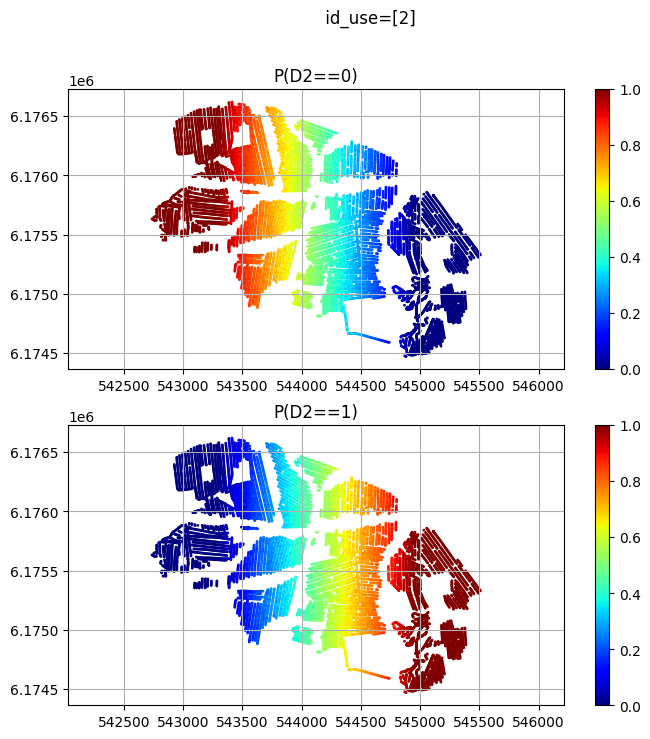

Rejection Sampling:   0%|                                                                                                                      | 0/1462 [00:00<?, ?it/s]

Rejection Sampling:   0%|                                                                                                                      | 0/1462 [00:00<?, ?it/s]

Rejection Sampling:   0%|                                                                                                                      | 0/1462 [00:00<?, ?it/s]

Rejection Sampling:   0%|                                                                                                                      | 0/1462 [00:00<?, ?it/s]

Rejection Sampling:   0%|                                                                                                              | 1/1462 [00:00<03:50,  6.35it/s]

Rejection Sampling:   0%|                                                                                                                      | 0/1462 [00:00<?, ?it/s]

Rejection Sampling:   0%|                                                                                                              | 1/1462 [00:00<03:38,  6.68it/s]

Rejection Sampling:   0%|                                                                                                                      | 0/1461 [00:00<?, ?it/s]

Rejection Sampling:   0%|                                                                                                              | 1/1462 [00:00<04:05,  5.95it/s]

Rejection Sampling:   0%|                                                                                                                      | 0/1461 [00:00<?, ?it/s]

Rejection Sampling:   0%|▏                                                                                                             | 2/1462 [00:00<02:10, 11.15it/s]

Rejection Sampling:   0%|▏                                                                                                             | 2/1462 [00:00<04:02,  6.02it/s]

Rejection Sampling:   0%|                                                                                                                      | 0/1461 [00:00<?, ?it/s]

Rejection Sampling:   0%|                                                                                                              | 1/1461 [00:00<02:26,  9.96it/s]

Rejection Sampling:   0%|▏                                                                                                             | 2/1462 [00:00<04:17,  5.67it/s]

Rejection Sampling:   0%|▏                                                                                                             | 2/1462 [00:00<02:44,  8.87it/s]

Rejection Sampling:   0%|                                                                                                              | 1/1461 [00:00<04:43,  5.15it/s]

Rejection Sampling:   0%|                                                                                                              | 1/1461 [00:00<02:39,  9.16it/s]

Rejection Sampling:   0%|▏                                                                                                             | 2/1462 [00:00<04:27,  5.45it/s]

Rejection Sampling:   0%|▏                                                                                                             | 3/1462 [00:00<04:03,  5.98it/s]

Rejection Sampling:   0%|▏                                                                                                             | 2/1461 [00:00<02:38,  9.20it/s]

Rejection Sampling:   0%|▏                                                                                                             | 3/1461 [00:00<02:13, 10.92it/s]

Rejection Sampling:   0%|▏                                                                                                             | 3/1462 [00:00<04:30,  5.40it/s]

Rejection Sampling:   0%|▏                                                                                                             | 3/1462 [00:00<03:36,  6.73it/s]

Rejection Sampling:   0%|▏                                                                                                             | 3/1462 [00:00<04:09,  5.84it/s]

Rejection Sampling:   0%|▏                                                                                                             | 2/1461 [00:00<04:43,  5.14it/s]

Rejection Sampling:   0%|▍                                                                                                             | 5/1462 [00:00<02:57,  8.19it/s]

Rejection Sampling:   0%|▎                                                                                                             | 4/1462 [00:00<03:36,  6.73it/s]

Rejection Sampling:   0%|▎                                                                                                             | 4/1461 [00:00<02:17, 10.57it/s]

Rejection Sampling:   0%|▎                                                                                                             | 4/1462 [00:00<04:27,  5.44it/s]

Rejection Sampling:   0%|▍                                                                                                             | 5/1462 [00:00<02:58,  8.14it/s]

Rejection Sampling:   0%|▎                                                                                                             | 4/1462 [00:00<04:04,  5.97it/s]

Rejection Sampling:   0%|▎                                                                                                             | 4/1461 [00:00<03:16,  7.41it/s]

Rejection Sampling:   0%|▌                                                                                                             | 7/1462 [00:00<02:35,  9.35it/s]

Rejection Sampling:   0%|▍                                                                                                             | 5/1462 [00:00<03:55,  6.20it/s]

Rejection Sampling:   0%|▍                                                                                                             | 6/1461 [00:00<02:11, 11.04it/s]

Rejection Sampling:   0%|▌                                                                                                             | 7/1462 [00:00<02:29,  9.74it/s]

Rejection Sampling:   0%|▍                                                                                                             | 5/1462 [00:00<04:24,  5.50it/s]

Rejection Sampling:   0%|▍                                                                                                             | 5/1461 [00:00<03:27,  7.03it/s]

Rejection Sampling:   0%|▍                                                                                                             | 5/1462 [00:00<04:10,  5.81it/s]

Rejection Sampling:   0%|▍                                                                                                             | 5/1461 [00:00<03:33,  6.83it/s]

Rejection Sampling:   1%|▋                                                                                                             | 9/1462 [00:01<02:27,  9.85it/s]

Rejection Sampling:   0%|▍                                                                                                             | 6/1462 [00:00<03:55,  6.18it/s]

Rejection Sampling:   1%|▌                                                                                                             | 8/1461 [00:00<02:04, 11.70it/s]

Rejection Sampling:   1%|▌                                                                                                             | 8/1462 [00:00<02:35,  9.34it/s]

Rejection Sampling:   0%|▌                                                                                                             | 7/1461 [00:00<02:52,  8.45it/s]

Rejection Sampling:   0%|▍                                                                                                             | 6/1462 [00:01<04:30,  5.38it/s]

Rejection Sampling:   0%|▍                                                                                                             | 6/1462 [00:01<04:26,  5.47it/s]

Rejection Sampling:   0%|▍                                                                                                             | 6/1461 [00:00<03:59,  6.08it/s]

Rejection Sampling:   1%|▊                                                                                                            | 11/1462 [00:01<02:20, 10.35it/s]

Rejection Sampling:   0%|▌                                                                                                             | 7/1462 [00:01<04:06,  5.89it/s]

Rejection Sampling:   1%|▋                                                                                                            | 10/1461 [00:00<02:05, 11.56it/s]

Rejection Sampling:   1%|▋                                                                                                             | 9/1462 [00:01<03:07,  7.77it/s]

Rejection Sampling:   1%|▋                                                                                                             | 9/1461 [00:01<02:35,  9.33it/s]

Rejection Sampling:   0%|▌                                                                                                             | 7/1461 [00:01<03:39,  6.62it/s]

Rejection Sampling:   0%|▌                                                                                                             | 7/1462 [00:01<04:38,  5.23it/s]

Rejection Sampling:   1%|▉                                                                                                            | 13/1462 [00:01<02:17, 10.57it/s]

Rejection Sampling:   0%|▌                                                                                                             | 7/1462 [00:01<04:35,  5.28it/s]

Rejection Sampling:   1%|▉                                                                                                            | 12/1461 [00:01<02:07, 11.35it/s]

Rejection Sampling:   1%|▌                                                                                                             | 8/1462 [00:01<04:15,  5.69it/s]

Rejection Sampling:   1%|▋                                                                                                            | 10/1462 [00:01<03:32,  6.84it/s]

Rejection Sampling:   1%|▋                                                                                                             | 9/1461 [00:01<03:01,  8.01it/s]

Rejection Sampling:   1%|▋                                                                                                             | 9/1462 [00:01<03:44,  6.47it/s]

Rejection Sampling:   1%|▊                                                                                                            | 11/1461 [00:01<02:41,  8.99it/s]

Rejection Sampling:   1%|▌                                                                                                             | 8/1462 [00:01<04:46,  5.08it/s]

Rejection Sampling:   1%|▌                                                                                                             | 8/1462 [00:01<04:36,  5.26it/s]

Rejection Sampling:   1%|█                                                                                                            | 14/1461 [00:01<02:06, 11.41it/s]

Rejection Sampling:   1%|▉                                                                                                            | 12/1462 [00:01<02:52,  8.39it/s]

Rejection Sampling:   1%|▉                                                                                                            | 12/1461 [00:01<02:58,  8.12it/s]

Rejection Sampling:   1%|▋                                                                                                            | 10/1461 [00:01<03:26,  7.02it/s]

Rejection Sampling:   1%|▋                                                                                                            | 10/1462 [00:01<03:59,  6.06it/s]

Rejection Sampling:   1%|▋                                                                                                            | 10/1462 [00:01<03:35,  6.73it/s]

Rejection Sampling:   1%|█▏                                                                                                           | 16/1461 [00:01<02:04, 11.59it/s]

Rejection Sampling:   1%|█                                                                                                            | 15/1462 [00:01<03:00,  8.04it/s]

Rejection Sampling:   1%|▋                                                                                                             | 9/1462 [00:01<04:35,  5.28it/s]

Rejection Sampling:   1%|█                                                                                                            | 14/1461 [00:01<02:38,  9.11it/s]

Rejection Sampling:   1%|█                                                                                                            | 14/1462 [00:01<03:01,  7.96it/s]

Rejection Sampling:   1%|▊                                                                                                            | 11/1461 [00:01<03:47,  6.38it/s]

Rejection Sampling:   1%|▊                                                                                                            | 11/1462 [00:01<04:14,  5.70it/s]

Rejection Sampling:   1%|▉                                                                                                            | 12/1462 [00:01<03:02,  7.94it/s]

Rejection Sampling:   1%|█▎                                                                                                           | 18/1461 [00:01<02:05, 11.54it/s]

Rejection Sampling:   1%|█▏                                                                                                           | 16/1462 [00:01<03:13,  7.46it/s]

Rejection Sampling:   1%|▋                                                                                                            | 10/1462 [00:01<04:39,  5.20it/s]

Rejection Sampling:   1%|█▏                                                                                                           | 16/1461 [00:01<02:28,  9.75it/s]

Rejection Sampling:   1%|█                                                                                                            | 15/1462 [00:01<03:17,  7.32it/s]

Rejection Sampling:   1%|▉                                                                                                            | 13/1461 [00:01<03:02,  7.93it/s]

Rejection Sampling:   1%|█▍                                                                                                           | 20/1461 [00:01<02:03, 11.71it/s]

Rejection Sampling:   1%|▉                                                                                                            | 12/1462 [00:01<04:23,  5.50it/s]

Rejection Sampling:   1%|▉                                                                                                            | 13/1462 [00:02<03:26,  7.00it/s]

Rejection Sampling:   1%|█▎                                                                                                           | 17/1462 [00:02<03:33,  6.77it/s]

Rejection Sampling:   1%|▊                                                                                                            | 11/1462 [00:01<04:36,  5.25it/s]

Rejection Sampling:   1%|▉                                                                                                            | 13/1462 [00:02<03:49,  6.32it/s]

Rejection Sampling:   1%|█▎                                                                                                           | 18/1461 [00:01<02:22, 10.14it/s]

Rejection Sampling:   1%|█▏                                                                                                           | 16/1462 [00:02<03:33,  6.76it/s]

Rejection Sampling:   1%|█                                                                                                            | 15/1461 [00:02<02:43,  8.87it/s]

Rejection Sampling:   2%|█▋                                                                                                           | 22/1461 [00:01<02:05, 11.50it/s]

Rejection Sampling:   1%|▉                                                                                                            | 12/1462 [00:02<04:24,  5.48it/s]

Rejection Sampling:   1%|█                                                                                                            | 14/1462 [00:02<03:49,  6.31it/s]

Rejection Sampling:   1%|█▎                                                                                                           | 18/1462 [00:02<03:51,  6.24it/s]

Rejection Sampling:   1%|█                                                                                                            | 14/1462 [00:02<04:03,  5.95it/s]

Rejection Sampling:   1%|█▍                                                                                                           | 20/1461 [00:02<02:17, 10.46it/s]

Rejection Sampling:   1%|█▎                                                                                                           | 17/1461 [00:02<02:30,  9.59it/s]

Rejection Sampling:   1%|▉                                                                                                            | 13/1462 [00:02<03:53,  6.21it/s]

Rejection Sampling:   1%|█▎                                                                                                           | 17/1462 [00:02<03:48,  6.32it/s]

Rejection Sampling:   2%|█▊                                                                                                           | 24/1461 [00:02<02:04, 11.51it/s]

Rejection Sampling:   1%|█▍                                                                                                           | 19/1462 [00:02<03:47,  6.36it/s]

Rejection Sampling:   1%|█                                                                                                            | 15/1462 [00:02<03:55,  6.16it/s]

Rejection Sampling:   1%|█▏                                                                                                           | 16/1462 [00:02<03:05,  7.78it/s]

Rejection Sampling:   1%|█                                                                                                            | 14/1462 [00:02<03:49,  6.30it/s]

Rejection Sampling:   1%|█▍                                                                                                           | 19/1461 [00:02<02:17, 10.49it/s]

Rejection Sampling:   1%|█▎                                                                                                           | 18/1462 [00:02<03:51,  6.24it/s]

Rejection Sampling:   2%|█▉                                                                                                           | 26/1461 [00:02<02:10, 11.03it/s]

Rejection Sampling:   1%|█▏                                                                                                           | 16/1462 [00:02<03:53,  6.18it/s]

Rejection Sampling:   1%|█▌                                                                                                           | 21/1462 [00:02<03:17,  7.30it/s]

Rejection Sampling:   1%|█▎                                                                                                           | 18/1462 [00:02<02:36,  9.25it/s]

Rejection Sampling:   1%|█▏                                                                                                           | 16/1462 [00:02<02:52,  8.38it/s]

Rejection Sampling:   2%|█▋                                                                                                           | 22/1461 [00:02<02:53,  8.32it/s]

Rejection Sampling:   1%|█▍                                                                                                           | 20/1462 [00:02<03:10,  7.58it/s]

Rejection Sampling:   2%|██                                                                                                           | 28/1461 [00:02<02:06, 11.33it/s]

Rejection Sampling:   1%|█▎                                                                                                           | 17/1462 [00:02<03:52,  6.21it/s]

Rejection Sampling:   2%|█▋                                                                                                           | 22/1462 [00:02<03:36,  6.65it/s]

Rejection Sampling:   1%|█▍                                                                                                           | 20/1462 [00:02<02:25,  9.93it/s]

Rejection Sampling:   1%|█▎                                                                                                           | 17/1462 [00:02<03:20,  7.20it/s]

Rejection Sampling:   1%|█▌                                                                                                           | 21/1461 [00:02<02:57,  8.12it/s]

Rejection Sampling:   2%|█▋                                                                                                           | 23/1461 [00:02<03:15,  7.35it/s]

Rejection Sampling:   2%|█▋                                                                                                           | 22/1462 [00:02<02:50,  8.43it/s]

Rejection Sampling:   1%|█▍                                                                                                           | 19/1462 [00:02<03:10,  7.57it/s]

Rejection Sampling:   1%|█▎                                                                                                           | 18/1462 [00:02<03:11,  7.55it/s]

Rejection Sampling:   2%|█▋                                                                                                           | 23/1462 [00:03<03:48,  6.30it/s]

Rejection Sampling:   2%|█▋                                                                                                           | 23/1461 [00:02<02:42,  8.83it/s]

Rejection Sampling:   2%|█▊                                                                                                           | 24/1461 [00:02<03:36,  6.65it/s]

Rejection Sampling:   2%|█▋                                                                                                           | 23/1462 [00:03<03:15,  7.35it/s]

Rejection Sampling:   2%|█▋                                                                                                           | 22/1462 [00:03<02:44,  8.75it/s]

Rejection Sampling:   2%|██▏                                                                                                          | 30/1461 [00:02<02:50,  8.40it/s]

Rejection Sampling:   1%|█▍                                                                                                           | 20/1462 [00:03<03:33,  6.77it/s]

Rejection Sampling:   1%|█▍                                                                                                           | 19/1462 [00:03<03:38,  6.61it/s]

Rejection Sampling:   2%|█▊                                                                                                           | 25/1462 [00:03<03:04,  7.77it/s]

Rejection Sampling:   2%|█▊                                                                                                           | 25/1461 [00:03<02:31,  9.50it/s]

Rejection Sampling:   2%|█▊                                                                                                           | 24/1462 [00:03<02:30,  9.53it/s]

Rejection Sampling:   2%|█▊                                                                                                           | 25/1461 [00:03<03:50,  6.22it/s]

Rejection Sampling:   2%|█▊                                                                                                           | 24/1462 [00:03<03:34,  6.70it/s]

Rejection Sampling:   2%|██▎                                                                                                          | 31/1461 [00:03<03:08,  7.60it/s]

Rejection Sampling:   1%|█▌                                                                                                           | 21/1462 [00:03<03:47,  6.33it/s]

Rejection Sampling:   2%|██                                                                                                           | 27/1462 [00:03<02:40,  8.95it/s]

Rejection Sampling:   1%|█▍                                                                                                           | 20/1462 [00:03<03:52,  6.21it/s]

Rejection Sampling:   2%|██                                                                                                           | 27/1461 [00:03<02:19, 10.30it/s]

Rejection Sampling:   2%|█▉                                                                                                           | 26/1462 [00:03<02:19, 10.33it/s]

Rejection Sampling:   2%|█▉                                                                                                           | 26/1461 [00:03<03:59,  6.00it/s]

Rejection Sampling:   2%|█▊                                                                                                           | 25/1462 [00:03<03:45,  6.36it/s]

Rejection Sampling:   2%|██▍                                                                                                          | 32/1461 [00:03<03:22,  7.04it/s]

Rejection Sampling:   2%|█▋                                                                                                           | 22/1462 [00:03<03:54,  6.13it/s]

Rejection Sampling:   2%|██▏                                                                                                          | 29/1462 [00:03<02:26,  9.81it/s]

Rejection Sampling:   1%|█▌                                                                                                           | 21/1462 [00:03<04:04,  5.88it/s]

Rejection Sampling:   2%|██▏                                                                                                          | 29/1461 [00:03<02:14, 10.61it/s]

Rejection Sampling:   2%|██                                                                                                           | 28/1462 [00:03<02:16, 10.47it/s]

Rejection Sampling:   2%|█▉                                                                                                           | 26/1462 [00:03<04:04,  5.86it/s]

Rejection Sampling:   2%|██                                                                                                           | 27/1461 [00:03<04:16,  5.59it/s]

Rejection Sampling:   2%|██▎                                                                                                          | 31/1462 [00:03<02:21, 10.13it/s]

Rejection Sampling:   2%|██▍                                                                                                          | 33/1461 [00:03<03:43,  6.40it/s]

Rejection Sampling:   2%|█▋                                                                                                           | 23/1462 [00:03<04:11,  5.72it/s]

Rejection Sampling:   2%|██▎                                                                                                          | 31/1461 [00:03<02:15, 10.59it/s]

Rejection Sampling:   2%|█▋                                                                                                           | 22/1462 [00:03<04:19,  5.55it/s]

Rejection Sampling:   2%|██                                                                                                           | 27/1462 [00:03<03:40,  6.50it/s]

Rejection Sampling:   2%|██▏                                                                                                          | 30/1462 [00:03<02:15, 10.54it/s]

Rejection Sampling:   2%|██                                                                                                           | 28/1461 [00:03<04:05,  5.83it/s]

Rejection Sampling:   2%|██▌                                                                                                          | 34/1461 [00:03<03:54,  6.08it/s]

Rejection Sampling:   2%|█▊                                                                                                           | 24/1462 [00:03<04:24,  5.43it/s]

Rejection Sampling:   2%|██▍                                                                                                          | 33/1461 [00:03<02:13, 10.72it/s]

Rejection Sampling:   2%|█▋                                                                                                           | 23/1462 [00:03<04:27,  5.37it/s]

Rejection Sampling:   2%|██                                                                                                           | 28/1462 [00:03<03:51,  6.18it/s]

Rejection Sampling:   2%|██▍                                                                                                          | 32/1462 [00:03<02:13, 10.73it/s]

Rejection Sampling:   2%|██▏                                                                                                          | 30/1461 [00:03<03:14,  7.38it/s]

Rejection Sampling:   2%|██▌                                                                                                          | 35/1461 [00:03<04:01,  5.91it/s]

Rejection Sampling:   2%|██▍                                                                                                          | 33/1462 [00:04<03:06,  7.65it/s]

Rejection Sampling:   2%|█▊                                                                                                           | 25/1462 [00:04<04:23,  5.46it/s]

Rejection Sampling:   2%|██▌                                                                                                          | 35/1461 [00:03<02:08, 11.07it/s]

Rejection Sampling:   2%|█▊                                                                                                           | 24/1462 [00:04<04:26,  5.40it/s]

Rejection Sampling:   2%|██▏                                                                                                          | 29/1462 [00:04<03:49,  6.23it/s]

Rejection Sampling:   2%|██▌                                                                                                          | 34/1462 [00:04<02:07, 11.20it/s]

Rejection Sampling:   2%|██▍                                                                                                          | 32/1461 [00:03<02:43,  8.77it/s]

Rejection Sampling:   2%|██▋                                                                                                          | 36/1461 [00:03<04:01,  5.90it/s]

Rejection Sampling:   3%|██▊                                                                                                          | 37/1461 [00:04<02:02, 11.58it/s]

Rejection Sampling:   2%|█▉                                                                                                           | 26/1462 [00:04<04:15,  5.63it/s]

Rejection Sampling:   2%|██▌                                                                                                          | 34/1462 [00:04<03:18,  7.21it/s]

Rejection Sampling:   2%|██▏                                                                                                          | 30/1462 [00:04<03:48,  6.27it/s]

Rejection Sampling:   2%|█▊                                                                                                           | 25/1462 [00:04<04:19,  5.54it/s]

Rejection Sampling:   2%|██▌                                                                                                          | 34/1461 [00:04<02:25,  9.82it/s]

Rejection Sampling:   2%|██▋                                                                                                          | 36/1462 [00:04<02:09, 11.01it/s]

Rejection Sampling:   3%|██▊                                                                                                          | 38/1461 [00:04<03:07,  7.61it/s]

Rejection Sampling:   2%|██▎                                                                                                          | 31/1462 [00:04<03:29,  6.84it/s]

Rejection Sampling:   2%|██                                                                                                           | 27/1462 [00:04<04:14,  5.63it/s]

Rejection Sampling:   2%|██▌                                                                                                          | 35/1462 [00:04<03:35,  6.63it/s]

Rejection Sampling:   2%|█▉                                                                                                           | 26/1462 [00:04<04:24,  5.42it/s]

Rejection Sampling:   3%|██▊                                                                                                          | 38/1462 [00:04<02:11, 10.86it/s]

Rejection Sampling:   2%|██▋                                                                                                          | 36/1461 [00:04<02:22,  9.99it/s]

Rejection Sampling:   2%|██▋                                                                                                          | 36/1462 [00:04<03:21,  7.06it/s]

Rejection Sampling:   3%|██▉                                                                                                          | 40/1461 [00:04<02:44,  8.62it/s]

Rejection Sampling:   3%|██▉                                                                                                          | 39/1461 [00:04<02:48,  8.43it/s]

Rejection Sampling:   2%|██                                                                                                           | 28/1462 [00:04<04:25,  5.41it/s]

Rejection Sampling:   2%|██▍                                                                                                          | 33/1462 [00:04<03:11,  7.48it/s]

Rejection Sampling:   2%|██                                                                                                           | 27/1462 [00:04<04:30,  5.31it/s]

Rejection Sampling:   2%|██▏                                                                                                          | 29/1462 [00:04<03:57,  6.03it/s]

Rejection Sampling:   3%|███▏                                                                                                         | 42/1461 [00:04<02:31,  9.39it/s]

Rejection Sampling:   3%|██▊                                                                                                          | 38/1461 [00:04<02:39,  8.94it/s]

Rejection Sampling:   3%|██▊                                                                                                          | 38/1462 [00:04<03:08,  7.57it/s]

Rejection Sampling:   3%|██▉                                                                                                          | 40/1462 [00:04<02:30,  9.45it/s]

Rejection Sampling:   2%|██▌                                                                                                          | 35/1462 [00:04<02:44,  8.67it/s]

Rejection Sampling:   3%|██▉                                                                                                          | 40/1461 [00:04<03:07,  7.60it/s]

Rejection Sampling:   2%|██                                                                                                           | 28/1462 [00:04<04:26,  5.38it/s]

Rejection Sampling:   2%|██▎                                                                                                          | 31/1462 [00:04<02:59,  7.99it/s]

Rejection Sampling:   3%|███                                                                                                          | 41/1461 [00:04<02:59,  7.90it/s]

Rejection Sampling:   3%|███▏                                                                                                         | 43/1461 [00:04<02:50,  8.31it/s]

Rejection Sampling:   3%|███▏                                                                                                         | 42/1462 [00:04<02:19, 10.17it/s]

Rejection Sampling:   3%|██▉                                                                                                          | 39/1462 [00:05<03:19,  7.13it/s]

Rejection Sampling:   3%|██▉                                                                                                          | 39/1461 [00:04<02:56,  8.05it/s]

Rejection Sampling:   2%|██▋                                                                                                          | 36/1462 [00:04<02:58,  7.97it/s]

Rejection Sampling:   3%|███▎                                                                                                         | 44/1461 [00:04<02:48,  8.39it/s]

Rejection Sampling:   3%|███▏                                                                                                         | 42/1461 [00:04<02:57,  8.01it/s]

Rejection Sampling:   2%|██▏                                                                                                          | 29/1462 [00:04<04:29,  5.33it/s]

Rejection Sampling:   2%|██▍                                                                                                          | 32/1462 [00:05<03:24,  7.01it/s]

Rejection Sampling:   3%|██▉                                                                                                          | 40/1462 [00:05<03:38,  6.50it/s]

Rejection Sampling:   3%|██▉                                                                                                          | 40/1461 [00:04<03:20,  7.07it/s]

Rejection Sampling:   3%|███▍                                                                                                         | 46/1461 [00:04<02:31,  9.33it/s]

Rejection Sampling:   3%|██▊                                                                                                          | 38/1462 [00:05<03:02,  7.81it/s]

Rejection Sampling:   3%|███▏                                                                                                         | 43/1461 [00:05<03:21,  7.05it/s]

Rejection Sampling:   2%|██▍                                                                                                          | 33/1462 [00:05<03:47,  6.29it/s]

Rejection Sampling:   2%|██▎                                                                                                          | 31/1462 [00:05<03:51,  6.18it/s]

Rejection Sampling:   3%|███▎                                                                                                         | 44/1462 [00:05<02:57,  8.01it/s]

Rejection Sampling:   3%|███                                                                                                          | 41/1462 [00:05<03:59,  5.94it/s]

Rejection Sampling:   3%|███                                                                                                          | 41/1461 [00:05<03:45,  6.29it/s]

Rejection Sampling:   3%|███▌                                                                                                         | 48/1461 [00:05<02:25,  9.70it/s]

Rejection Sampling:   2%|██▍                                                                                                          | 32/1462 [00:05<03:29,  6.81it/s]

Rejection Sampling:   3%|██▉                                                                                                          | 39/1462 [00:05<03:21,  7.06it/s]

Rejection Sampling:   2%|██▌                                                                                                          | 34/1462 [00:05<03:34,  6.66it/s]

Rejection Sampling:   3%|███▎                                                                                                         | 44/1461 [00:05<03:39,  6.44it/s]

Rejection Sampling:   3%|███▏                                                                                                         | 42/1462 [00:05<03:48,  6.21it/s]

Rejection Sampling:   3%|███▎                                                                                                         | 45/1462 [00:05<03:16,  7.19it/s]

Rejection Sampling:   3%|███▏                                                                                                         | 42/1461 [00:05<04:01,  5.88it/s]

Rejection Sampling:   2%|██▌                                                                                                          | 34/1462 [00:05<02:54,  8.17it/s]

Rejection Sampling:   3%|███▋                                                                                                         | 50/1461 [00:05<02:21,  9.97it/s]

Rejection Sampling:   2%|██▋                                                                                                          | 36/1462 [00:05<02:54,  8.17it/s]

Rejection Sampling:   3%|██▉                                                                                                          | 40/1462 [00:05<03:37,  6.52it/s]

Rejection Sampling:   3%|███▎                                                                                                         | 45/1461 [00:05<03:50,  6.15it/s]

Rejection Sampling:   3%|███▎                                                                                                         | 44/1462 [00:05<03:00,  7.88it/s]

Rejection Sampling:   3%|███▍                                                                                                         | 46/1462 [00:05<03:22,  7.00it/s]

Rejection Sampling:   3%|██▊                                                                                                          | 38/1462 [00:05<02:32,  9.35it/s]

Rejection Sampling:   2%|██▌                                                                                                          | 35/1462 [00:05<03:14,  7.33it/s]

Rejection Sampling:   3%|███▏                                                                                                         | 42/1462 [00:05<02:57,  7.99it/s]

Rejection Sampling:   3%|███▏                                                                                                         | 43/1461 [00:05<04:08,  5.71it/s]

Rejection Sampling:   3%|███▊                                                                                                         | 51/1461 [00:05<02:45,  8.52it/s]

Rejection Sampling:   3%|███▍                                                                                                         | 46/1461 [00:05<03:58,  5.92it/s]

Rejection Sampling:   3%|███▍                                                                                                         | 46/1462 [00:05<02:35,  9.09it/s]

Rejection Sampling:   3%|███▌                                                                                                         | 47/1462 [00:05<03:31,  6.68it/s]

Rejection Sampling:   3%|██▉                                                                                                          | 40/1462 [00:05<02:20, 10.09it/s]

Rejection Sampling:   3%|███▎                                                                                                         | 44/1462 [00:05<02:36,  9.03it/s]

Rejection Sampling:   2%|██▋                                                                                                          | 36/1462 [00:05<03:33,  6.66it/s]

Rejection Sampling:   3%|███▌                                                                                                         | 48/1461 [00:05<03:07,  7.53it/s]

Rejection Sampling:   3%|███▎                                                                                                         | 44/1461 [00:05<04:16,  5.53it/s]

Rejection Sampling:   4%|███▉                                                                                                         | 52/1461 [00:05<03:09,  7.45it/s]

Rejection Sampling:   3%|███▌                                                                                                         | 48/1462 [00:06<02:22,  9.93it/s]

Rejection Sampling:   3%|███▌                                                                                                         | 48/1462 [00:06<03:46,  6.23it/s]

Rejection Sampling:   3%|███▎                                                                                                         | 45/1461 [00:05<03:46,  6.25it/s]

Rejection Sampling:   3%|███▏                                                                                                         | 42/1462 [00:06<02:13, 10.63it/s]

Rejection Sampling:   3%|███▎                                                                                                         | 45/1462 [00:06<02:55,  8.08it/s]

Rejection Sampling:   4%|███▉                                                                                                         | 53/1461 [00:05<03:23,  6.91it/s]

Rejection Sampling:   3%|██▊                                                                                                          | 37/1462 [00:06<03:51,  6.16it/s]

Rejection Sampling:   3%|███▋                                                                                                         | 50/1461 [00:06<03:04,  7.63it/s]

Rejection Sampling:   3%|███▋                                                                                                         | 49/1462 [00:06<04:00,  5.87it/s]

Rejection Sampling:   3%|███▎                                                                                                         | 44/1462 [00:06<02:10, 10.83it/s]

Rejection Sampling:   3%|███▍                                                                                                         | 46/1461 [00:06<04:04,  5.79it/s]

Rejection Sampling:   3%|███▌                                                                                                         | 47/1462 [00:06<02:37,  9.01it/s]

Rejection Sampling:   3%|██▉                                                                                                          | 39/1462 [00:06<03:05,  7.69it/s]

Rejection Sampling:   4%|████                                                                                                         | 54/1461 [00:06<03:37,  6.46it/s]

Rejection Sampling:   3%|███▋                                                                                                         | 50/1462 [00:06<03:04,  7.66it/s]

Rejection Sampling:   3%|███▋                                                                                                         | 50/1462 [00:06<03:53,  6.05it/s]

Rejection Sampling:   3%|███▊                                                                                                         | 51/1461 [00:06<03:18,  7.12it/s]

Rejection Sampling:   3%|███▍                                                                                                         | 46/1462 [00:06<02:05, 11.29it/s]

Rejection Sampling:   3%|███▋                                                                                                         | 49/1462 [00:06<02:22,  9.91it/s]

Rejection Sampling:   3%|███▌                                                                                                         | 47/1461 [00:06<04:11,  5.62it/s]

Rejection Sampling:   3%|██▉                                                                                                          | 40/1462 [00:06<03:22,  7.02it/s]

Rejection Sampling:   4%|████                                                                                                         | 55/1461 [00:06<03:46,  6.21it/s]

Rejection Sampling:   4%|███▉                                                                                                         | 52/1462 [00:06<03:04,  7.66it/s]

Rejection Sampling:   3%|███▊                                                                                                         | 51/1462 [00:06<03:21,  7.01it/s]

Rejection Sampling:   4%|███▉                                                                                                         | 52/1461 [00:06<03:36,  6.51it/s]

Rejection Sampling:   3%|███▌                                                                                                         | 48/1462 [00:06<02:03, 11.46it/s]

Rejection Sampling:   3%|███▊                                                                                                         | 51/1462 [00:06<02:14, 10.46it/s]

Rejection Sampling:   3%|███▌                                                                                                         | 48/1461 [00:06<04:19,  5.45it/s]

Rejection Sampling:   3%|███                                                                                                          | 41/1462 [00:06<03:38,  6.50it/s]

Rejection Sampling:   4%|████▏                                                                                                        | 56/1461 [00:06<03:56,  5.94it/s]

Rejection Sampling:   4%|███▉                                                                                                         | 52/1462 [00:06<03:24,  6.88it/s]

Rejection Sampling:   4%|████                                                                                                         | 54/1462 [00:06<02:40,  8.80it/s]

Rejection Sampling:   4%|███▉                                                                                                         | 53/1461 [00:06<03:53,  6.03it/s]

Rejection Sampling:   4%|███▉                                                                                                         | 53/1462 [00:06<02:12, 10.64it/s]

Rejection Sampling:   4%|███▉                                                                                                         | 53/1462 [00:06<03:12,  7.32it/s]

Rejection Sampling:   3%|███▋                                                                                                         | 49/1461 [00:06<04:30,  5.22it/s]

Rejection Sampling:   3%|███▋                                                                                                         | 50/1462 [00:06<02:28,  9.50it/s]

Rejection Sampling:   3%|███▏                                                                                                         | 42/1462 [00:06<03:58,  5.96it/s]

Rejection Sampling:   4%|████▎                                                                                                        | 57/1461 [00:06<04:13,  5.54it/s]

Rejection Sampling:   4%|████▏                                                                                                        | 56/1462 [00:06<02:30,  9.35it/s]

Rejection Sampling:   4%|████                                                                                                         | 55/1462 [00:07<02:12, 10.66it/s]

Rejection Sampling:   4%|████                                                                                                         | 54/1461 [00:06<04:07,  5.69it/s]

Rejection Sampling:   4%|████                                                                                                         | 54/1462 [00:07<03:36,  6.51it/s]

Rejection Sampling:   4%|███▉                                                                                                         | 52/1462 [00:07<02:20, 10.01it/s]

Rejection Sampling:   3%|███▋                                                                                                         | 50/1461 [00:06<04:35,  5.11it/s]

Rejection Sampling:   4%|████▎                                                                                                        | 58/1462 [00:07<02:21,  9.94it/s]

Rejection Sampling:   3%|███▏                                                                                                         | 43/1462 [00:07<04:09,  5.68it/s]

Rejection Sampling:   4%|████▎                                                                                                        | 58/1461 [00:06<04:19,  5.41it/s]

Rejection Sampling:   4%|████▏                                                                                                        | 56/1461 [00:07<03:14,  7.24it/s]

Rejection Sampling:   4%|████                                                                                                         | 55/1462 [00:07<03:52,  6.05it/s]

Rejection Sampling:   4%|████                                                                                                         | 54/1462 [00:07<02:14, 10.44it/s]

Rejection Sampling:   4%|████▏                                                                                                        | 57/1462 [00:07<02:24,  9.72it/s]

Rejection Sampling:   3%|███▊                                                                                                         | 51/1461 [00:07<04:36,  5.09it/s]

Rejection Sampling:   4%|████▍                                                                                                        | 59/1461 [00:07<04:17,  5.45it/s]

Rejection Sampling:   3%|███▎                                                                                                         | 44/1462 [00:07<04:13,  5.59it/s]

Rejection Sampling:   4%|████▎                                                                                                        | 58/1461 [00:07<02:46,  8.41it/s]

Rejection Sampling:   4%|████▏                                                                                                        | 56/1462 [00:07<02:11, 10.70it/s]

Rejection Sampling:   4%|████▏                                                                                                        | 56/1462 [00:07<04:03,  5.77it/s]

Rejection Sampling:   4%|████▎                                                                                                        | 58/1462 [00:07<02:45,  8.46it/s]

Rejection Sampling:   4%|████▍                                                                                                        | 60/1461 [00:07<04:06,  5.69it/s]

Rejection Sampling:   4%|███▉                                                                                                         | 52/1461 [00:07<04:33,  5.15it/s]

Rejection Sampling:   4%|████▍                                                                                                        | 60/1462 [00:07<02:58,  7.85it/s]

Rejection Sampling:   3%|███▎                                                                                                         | 45/1462 [00:07<04:16,  5.53it/s]

Rejection Sampling:   4%|████▏                                                                                                        | 57/1462 [00:07<03:44,  6.25it/s]

Rejection Sampling:   4%|████▍                                                                                                        | 60/1462 [00:07<02:32,  9.20it/s]

Rejection Sampling:   4%|████▍                                                                                                        | 60/1461 [00:07<02:53,  8.08it/s]

Rejection Sampling:   4%|███▉                                                                                                         | 53/1461 [00:07<04:26,  5.28it/s]

Rejection Sampling:   4%|████▌                                                                                                        | 61/1461 [00:07<04:16,  5.46it/s]

Rejection Sampling:   4%|████▌                                                                                                        | 61/1462 [00:07<03:17,  7.08it/s]

Rejection Sampling:   3%|███▍                                                                                                         | 46/1462 [00:07<04:23,  5.37it/s]

Rejection Sampling:   4%|████▍                                                                                                        | 59/1462 [00:07<02:59,  7.83it/s]

Rejection Sampling:   4%|████▌                                                                                                        | 62/1462 [00:07<02:22,  9.82it/s]

Rejection Sampling:   4%|████▎                                                                                                        | 58/1462 [00:07<02:53,  8.10it/s]

Rejection Sampling:   4%|████▌                                                                                                        | 61/1461 [00:07<03:12,  7.29it/s]

Rejection Sampling:   4%|████                                                                                                         | 55/1461 [00:07<03:18,  7.08it/s]

Rejection Sampling:   4%|████▋                                                                                                        | 62/1461 [00:07<04:14,  5.49it/s]

Rejection Sampling:   3%|███▌                                                                                                         | 47/1462 [00:07<04:20,  5.43it/s]

Rejection Sampling:   4%|████▌                                                                                                        | 62/1462 [00:07<03:31,  6.63it/s]

Rejection Sampling:   4%|████▌                                                                                                        | 61/1462 [00:08<02:40,  8.73it/s]

Rejection Sampling:   4%|████▊                                                                                                        | 64/1462 [00:07<02:14, 10.42it/s]

Rejection Sampling:   4%|████▎                                                                                                        | 57/1461 [00:07<02:46,  8.43it/s]

Rejection Sampling:   4%|████▍                                                                                                        | 59/1462 [00:08<03:09,  7.39it/s]

Rejection Sampling:   4%|████▋                                                                                                        | 62/1461 [00:07<03:28,  6.70it/s]

Rejection Sampling:   4%|████▋                                                                                                        | 63/1461 [00:07<04:17,  5.42it/s]

Rejection Sampling:   4%|████▋                                                                                                        | 63/1462 [00:07<03:34,  6.51it/s]

Rejection Sampling:   3%|███▌                                                                                                         | 48/1462 [00:07<04:21,  5.40it/s]

Rejection Sampling:   4%|████▋                                                                                                        | 63/1462 [00:08<02:25,  9.64it/s]

Rejection Sampling:   5%|████▉                                                                                                        | 66/1462 [00:08<02:05, 11.09it/s]

Rejection Sampling:   4%|████▋                                                                                                        | 63/1461 [00:07<03:17,  7.08it/s]

Rejection Sampling:   4%|████▍                                                                                                        | 59/1461 [00:07<02:25,  9.67it/s]

Rejection Sampling:   4%|████▍                                                                                                        | 60/1462 [00:08<03:20,  7.00it/s]

Rejection Sampling:   4%|████▊                                                                                                        | 65/1461 [00:07<03:12,  7.26it/s]

Rejection Sampling:   4%|████▊                                                                                                        | 64/1462 [00:08<03:40,  6.34it/s]

Rejection Sampling:   3%|███▋                                                                                                         | 49/1462 [00:08<04:09,  5.66it/s]

Rejection Sampling:   4%|████▊                                                                                                        | 65/1462 [00:08<02:13, 10.46it/s]

Rejection Sampling:   5%|█████                                                                                                        | 68/1462 [00:08<02:03, 11.25it/s]

Rejection Sampling:   4%|████▌                                                                                                        | 61/1462 [00:08<03:15,  7.17it/s]

Rejection Sampling:   4%|████▊                                                                                                        | 64/1461 [00:08<03:36,  6.46it/s]

Rejection Sampling:   5%|████▉                                                                                                        | 67/1461 [00:08<02:46,  8.39it/s]

Rejection Sampling:   4%|████▌                                                                                                        | 61/1461 [00:08<02:36,  8.96it/s]

Rejection Sampling:   4%|████▊                                                                                                        | 65/1462 [00:08<03:56,  5.90it/s]

Rejection Sampling:   3%|███▋                                                                                                         | 50/1462 [00:08<04:21,  5.39it/s]

Rejection Sampling:   5%|████▉                                                                                                        | 67/1462 [00:08<02:10, 10.66it/s]

Rejection Sampling:   5%|█████▏                                                                                                       | 70/1462 [00:08<02:02, 11.35it/s]

Rejection Sampling:   4%|████▌                                                                                                        | 62/1462 [00:08<03:33,  6.57it/s]

Rejection Sampling:   4%|████▊                                                                                                        | 65/1461 [00:08<03:45,  6.18it/s]

Rejection Sampling:   5%|█████▏                                                                                                       | 69/1461 [00:08<02:29,  9.30it/s]

Rejection Sampling:   4%|████▋                                                                                                        | 63/1461 [00:08<02:22,  9.79it/s]

Rejection Sampling:   3%|███▊                                                                                                         | 51/1462 [00:08<04:08,  5.68it/s]

Rejection Sampling:   5%|████▉                                                                                                        | 66/1462 [00:08<04:04,  5.72it/s]

Rejection Sampling:   5%|█████▏                                                                                                       | 69/1462 [00:08<02:04, 11.17it/s]

Rejection Sampling:   5%|████▉                                                                                                        | 66/1461 [00:08<03:31,  6.61it/s]

Rejection Sampling:   5%|█████▎                                                                                                       | 72/1462 [00:08<02:11, 10.55it/s]

Rejection Sampling:   4%|████▋                                                                                                        | 63/1462 [00:08<03:47,  6.16it/s]

Rejection Sampling:   4%|███▉                                                                                                         | 52/1462 [00:08<03:48,  6.17it/s]

Rejection Sampling:   5%|█████▏                                                                                                       | 70/1461 [00:08<02:52,  8.04it/s]

Rejection Sampling:   5%|█████▎                                                                                                       | 71/1462 [00:08<02:02, 11.39it/s]

Rejection Sampling:   5%|████▉                                                                                                        | 67/1462 [00:08<04:09,  5.59it/s]

Rejection Sampling:   5%|█████                                                                                                        | 68/1461 [00:08<02:49,  8.21it/s]

Rejection Sampling:   4%|████▊                                                                                                        | 65/1461 [00:08<02:38,  8.80it/s]

Rejection Sampling:   4%|████▊                                                                                                        | 64/1462 [00:08<03:46,  6.17it/s]

Rejection Sampling:   5%|█████▌                                                                                                       | 74/1462 [00:08<02:08, 10.80it/s]

Rejection Sampling:   4%|████                                                                                                         | 54/1462 [00:08<02:56,  7.96it/s]

Rejection Sampling:   5%|█████▎                                                                                                       | 72/1461 [00:08<02:32,  9.10it/s]

Rejection Sampling:   5%|█████▍                                                                                                       | 73/1462 [00:09<01:59, 11.65it/s]

Rejection Sampling:   5%|█████                                                                                                        | 68/1462 [00:08<03:55,  5.91it/s]

Rejection Sampling:   4%|████▊                                                                                                        | 65/1462 [00:09<03:29,  6.65it/s]

Rejection Sampling:   5%|█████▏                                                                                                       | 69/1461 [00:08<03:10,  7.31it/s]

Rejection Sampling:   5%|████▉                                                                                                        | 66/1461 [00:08<02:52,  8.07it/s]

Rejection Sampling:   4%|████▏                                                                                                        | 56/1462 [00:08<02:31,  9.25it/s]

Rejection Sampling:   5%|█████▌                                                                                                       | 74/1461 [00:08<02:19,  9.91it/s]

Rejection Sampling:   5%|█████▏                                                                                                       | 70/1462 [00:09<03:02,  7.63it/s]

Rejection Sampling:   5%|█████▌                                                                                                       | 75/1462 [00:09<02:02, 11.28it/s]

Rejection Sampling:   5%|████▉                                                                                                        | 67/1462 [00:09<02:48,  8.26it/s]

Rejection Sampling:   4%|████▏                                                                                                        | 57/1462 [00:09<02:32,  9.23it/s]

Rejection Sampling:   5%|████▉                                                                                                        | 67/1461 [00:08<02:55,  7.95it/s]

Rejection Sampling:   5%|█████▏                                                                                                       | 70/1461 [00:09<03:23,  6.83it/s]

Rejection Sampling:   5%|█████▋                                                                                                       | 76/1462 [00:09<02:37,  8.83it/s]

Rejection Sampling:   5%|█████▋                                                                                                       | 76/1461 [00:08<02:07, 10.85it/s]

Rejection Sampling:   5%|█████▎                                                                                                       | 71/1461 [00:09<03:10,  7.29it/s]

Rejection Sampling:   5%|█████▋                                                                                                       | 77/1462 [00:09<01:57, 11.79it/s]

Rejection Sampling:   5%|█████▎                                                                                                       | 71/1462 [00:09<03:16,  7.07it/s]

Rejection Sampling:   5%|█████▏                                                                                                       | 69/1462 [00:09<02:25,  9.60it/s]

Rejection Sampling:   4%|████▍                                                                                                        | 59/1462 [00:09<02:15, 10.37it/s]

Rejection Sampling:   5%|█████▏                                                                                                       | 69/1461 [00:09<02:31,  9.17it/s]

Rejection Sampling:   5%|█████▋                                                                                                       | 77/1462 [00:09<02:53,  7.99it/s]

Rejection Sampling:   5%|█████▊                                                                                                       | 78/1461 [00:09<02:02, 11.30it/s]

Rejection Sampling:   5%|█████▍                                                                                                       | 73/1461 [00:09<02:36,  8.87it/s]

Rejection Sampling:   5%|█████▎                                                                                                       | 72/1462 [00:09<03:25,  6.76it/s]

Rejection Sampling:   4%|████▌                                                                                                        | 61/1462 [00:09<02:04, 11.21it/s]

Rejection Sampling:   5%|█████▎                                                                                                       | 71/1462 [00:09<02:12, 10.54it/s]

Rejection Sampling:   5%|█████▎                                                                                                       | 71/1461 [00:09<02:18, 10.03it/s]

Rejection Sampling:   5%|█████▊                                                                                                       | 78/1462 [00:09<03:07,  7.40it/s]

Rejection Sampling:   5%|█████▉                                                                                                       | 80/1461 [00:09<01:57, 11.75it/s]

Rejection Sampling:   5%|█████▌                                                                                                       | 74/1461 [00:09<02:44,  8.43it/s]

Rejection Sampling:   4%|████▋                                                                                                        | 63/1462 [00:09<02:02, 11.43it/s]

Rejection Sampling:   5%|█████▍                                                                                                       | 73/1462 [00:09<02:06, 10.98it/s]

Rejection Sampling:   5%|█████▉                                                                                                       | 79/1462 [00:09<02:35,  8.91it/s]

Rejection Sampling:   5%|█████▌                                                                                                       | 74/1462 [00:09<02:53,  8.00it/s]

Rejection Sampling:   5%|█████▍                                                                                                       | 73/1461 [00:09<02:09, 10.74it/s]

Rejection Sampling:   5%|█████▉                                                                                                       | 79/1462 [00:09<02:57,  7.79it/s]

Rejection Sampling:   6%|██████                                                                                                       | 82/1461 [00:09<01:57, 11.70it/s]

Rejection Sampling:   5%|█████▋                                                                                                       | 76/1461 [00:09<02:23,  9.67it/s]

Rejection Sampling:   4%|████▊                                                                                                        | 65/1462 [00:09<01:57, 11.86it/s]

Rejection Sampling:   5%|█████▌                                                                                                       | 75/1462 [00:09<01:59, 11.57it/s]

Rejection Sampling:   5%|█████▌                                                                                                       | 75/1461 [00:09<02:02, 11.28it/s]

Rejection Sampling:   5%|█████▉                                                                                                       | 80/1462 [00:09<03:15,  7.08it/s]

Rejection Sampling:   5%|█████▋                                                                                                       | 76/1462 [00:09<02:54,  7.93it/s]

Rejection Sampling:   5%|█████▊                                                                                                       | 78/1461 [00:09<02:12, 10.45it/s]

Rejection Sampling:   6%|██████▎                                                                                                      | 84/1461 [00:09<01:59, 11.48it/s]

Rejection Sampling:   5%|████▉                                                                                                        | 67/1462 [00:09<01:56, 11.95it/s]

Rejection Sampling:   5%|█████▋                                                                                                       | 77/1462 [00:09<01:57, 11.75it/s]

Rejection Sampling:   5%|█████▋                                                                                                       | 77/1461 [00:09<01:59, 11.58it/s]

Rejection Sampling:   6%|██████                                                                                                       | 81/1462 [00:10<03:00,  7.64it/s]

Rejection Sampling:   6%|██████                                                                                                       | 81/1462 [00:09<03:17,  7.01it/s]

Rejection Sampling:   5%|█████▋                                                                                                       | 77/1462 [00:10<03:07,  7.40it/s]

Rejection Sampling:   6%|██████▍                                                                                                      | 86/1461 [00:09<01:55, 11.94it/s]

Rejection Sampling:   5%|█████▏                                                                                                       | 69/1462 [00:09<01:53, 12.29it/s]

Rejection Sampling:   5%|█████▉                                                                                                       | 79/1462 [00:10<01:54, 12.11it/s]

Rejection Sampling:   5%|█████▉                                                                                                       | 79/1461 [00:09<01:56, 11.90it/s]

Rejection Sampling:   6%|██████                                                                                                       | 82/1462 [00:10<03:12,  7.17it/s]

Rejection Sampling:   6%|██████                                                                                                       | 82/1462 [00:10<03:30,  6.55it/s]

Rejection Sampling:   6%|██████▌                                                                                                      | 88/1461 [00:09<01:56, 11.76it/s]

Rejection Sampling:   6%|██████▏                                                                                                      | 83/1462 [00:10<03:11,  7.19it/s]

Rejection Sampling:   5%|█████▉                                                                                                       | 80/1461 [00:10<02:53,  7.96it/s]

Rejection Sampling:   5%|█████▉                                                                                                       | 79/1462 [00:10<02:49,  8.15it/s]

Rejection Sampling:   5%|█████▎                                                                                                       | 71/1462 [00:10<01:54, 12.11it/s]

Rejection Sampling:   6%|██████                                                                                                       | 81/1462 [00:10<01:55, 11.96it/s]

Rejection Sampling:   6%|██████                                                                                                       | 81/1461 [00:10<01:57, 11.70it/s]

Rejection Sampling:   6%|██████▏                                                                                                      | 83/1462 [00:10<03:25,  6.70it/s]

Rejection Sampling:   5%|█████▉                                                                                                       | 80/1462 [00:10<02:43,  8.45it/s]

Rejection Sampling:   6%|██████▎                                                                                                      | 84/1462 [00:10<03:13,  7.13it/s]

Rejection Sampling:   6%|██████▋                                                                                                      | 90/1461 [00:10<01:58, 11.52it/s]

Rejection Sampling:   5%|█████▍                                                                                                       | 73/1462 [00:10<01:56, 11.89it/s]

Rejection Sampling:   6%|██████▏                                                                                                      | 83/1462 [00:10<01:57, 11.78it/s]

Rejection Sampling:   6%|██████                                                                                                       | 81/1461 [00:10<03:10,  7.24it/s]

Rejection Sampling:   6%|██████▏                                                                                                      | 83/1461 [00:10<01:59, 11.55it/s]

Rejection Sampling:   6%|██████▎                                                                                                      | 84/1462 [00:10<03:35,  6.38it/s]

Rejection Sampling:   6%|██████                                                                                                       | 82/1462 [00:10<02:29,  9.24it/s]

Rejection Sampling:   6%|██████▎                                                                                                      | 85/1462 [00:10<03:23,  6.77it/s]

Rejection Sampling:   6%|██████▊                                                                                                      | 92/1461 [00:10<01:59, 11.50it/s]

Rejection Sampling:   5%|█████▌                                                                                                       | 75/1462 [00:10<01:57, 11.80it/s]

Rejection Sampling:   6%|██████▎                                                                                                      | 85/1462 [00:10<01:57, 11.73it/s]

Rejection Sampling:   6%|██████                                                                                                       | 82/1461 [00:10<03:27,  6.66it/s]

Rejection Sampling:   6%|██████▎                                                                                                      | 85/1461 [00:10<01:58, 11.63it/s]

Rejection Sampling:   6%|██████▎                                                                                                      | 85/1462 [00:10<03:44,  6.14it/s]

Rejection Sampling:   6%|██████▎                                                                                                      | 84/1462 [00:10<02:16, 10.07it/s]

Rejection Sampling:   6%|██████▍                                                                                                      | 87/1462 [00:10<02:42,  8.49it/s]

Rejection Sampling:   6%|███████                                                                                                      | 94/1461 [00:10<01:56, 11.74it/s]

Rejection Sampling:   5%|█████▋                                                                                                       | 77/1462 [00:10<01:54, 12.11it/s]

Rejection Sampling:   6%|██████▍                                                                                                      | 87/1462 [00:10<01:54, 12.05it/s]

Rejection Sampling:   6%|██████▍                                                                                                      | 87/1461 [00:10<01:55, 11.85it/s]

Rejection Sampling:   6%|██████▏                                                                                                      | 83/1461 [00:10<03:37,  6.33it/s]

Rejection Sampling:   6%|██████▍                                                                                                      | 86/1462 [00:10<03:56,  5.82it/s]

Rejection Sampling:   6%|██████▍                                                                                                      | 86/1462 [00:10<02:17, 10.02it/s]

Rejection Sampling:   6%|██████▌                                                                                                      | 88/1462 [00:10<03:10,  7.22it/s]

Rejection Sampling:   7%|███████▏                                                                                                     | 96/1461 [00:10<02:00, 11.37it/s]

Rejection Sampling:   5%|█████▉                                                                                                       | 79/1462 [00:10<01:57, 11.73it/s]

Rejection Sampling:   6%|██████▋                                                                                                      | 89/1462 [00:10<01:57, 11.67it/s]

Rejection Sampling:   6%|██████▋                                                                                                      | 89/1461 [00:10<01:58, 11.59it/s]

Rejection Sampling:   6%|██████▎                                                                                                      | 84/1461 [00:10<03:45,  6.11it/s]

Rejection Sampling:   6%|██████▍                                                                                                      | 87/1462 [00:11<04:03,  5.64it/s]

Rejection Sampling:   6%|██████▋                                                                                                      | 90/1462 [00:11<02:42,  8.45it/s]

Rejection Sampling:   6%|██████                                                                                                       | 81/1462 [00:11<01:57, 11.80it/s]

Rejection Sampling:   6%|██████▊                                                                                                      | 91/1462 [00:11<01:56, 11.75it/s]

Rejection Sampling:   6%|██████▌                                                                                                      | 88/1462 [00:11<02:22,  9.63it/s]

Rejection Sampling:   6%|██████▊                                                                                                      | 91/1461 [00:10<01:57, 11.69it/s]

Rejection Sampling:   6%|██████▍                                                                                                      | 86/1461 [00:11<02:58,  7.69it/s]

Rejection Sampling:   6%|██████▌                                                                                                      | 88/1462 [00:11<03:38,  6.28it/s]

Rejection Sampling:   6%|██████▋                                                                                                      | 89/1462 [00:11<02:23,  9.57it/s]

Rejection Sampling:   6%|██████▏                                                                                                      | 83/1462 [00:11<01:54, 12.06it/s]

Rejection Sampling:   6%|██████▉                                                                                                      | 93/1462 [00:11<01:53, 12.02it/s]

Rejection Sampling:   6%|██████▊                                                                                                      | 91/1462 [00:11<03:00,  7.59it/s]

Rejection Sampling:   6%|██████▉                                                                                                      | 93/1461 [00:11<01:53, 12.06it/s]

Rejection Sampling:   7%|███████▎                                                                                                     | 98/1461 [00:11<02:39,  8.53it/s]

Rejection Sampling:   6%|██████▌                                                                                                      | 88/1461 [00:11<02:32,  9.00it/s]

Rejection Sampling:   6%|██████▋                                                                                                      | 90/1462 [00:11<02:47,  8.17it/s]

Rejection Sampling:   6%|██████▋                                                                                                      | 90/1462 [00:11<02:40,  8.56it/s]

Rejection Sampling:   6%|██████▊                                                                                                      | 92/1462 [00:11<02:57,  7.72it/s]

Rejection Sampling:   6%|██████▎                                                                                                      | 85/1462 [00:11<01:50, 12.47it/s]

Rejection Sampling:   6%|███████                                                                                                      | 95/1462 [00:11<01:50, 12.41it/s]

Rejection Sampling:   7%|███████                                                                                                      | 95/1461 [00:11<01:49, 12.51it/s]

Rejection Sampling:   7%|███████▍                                                                                                    | 100/1461 [00:11<02:23,  9.50it/s]

Rejection Sampling:   6%|██████▊                                                                                                      | 91/1462 [00:11<02:43,  8.40it/s]

Rejection Sampling:   6%|██████▋                                                                                                      | 89/1461 [00:11<02:47,  8.20it/s]

Rejection Sampling:   6%|██████▊                                                                                                      | 92/1462 [00:11<02:18,  9.88it/s]

Rejection Sampling:   6%|██████▍                                                                                                      | 87/1462 [00:11<01:48, 12.70it/s]

Rejection Sampling:   6%|███████                                                                                                      | 94/1462 [00:11<02:29,  9.14it/s]

Rejection Sampling:   7%|███████▏                                                                                                     | 97/1462 [00:11<01:47, 12.68it/s]

Rejection Sampling:   7%|███████▌                                                                                                    | 102/1461 [00:11<02:11, 10.36it/s]

Rejection Sampling:   6%|██████▉                                                                                                      | 93/1462 [00:11<02:18,  9.87it/s]

Rejection Sampling:   6%|██████▋                                                                                                      | 90/1461 [00:11<02:52,  7.93it/s]

Rejection Sampling:   7%|███████▏                                                                                                     | 97/1461 [00:11<02:05, 10.86it/s]

Rejection Sampling:   6%|███████                                                                                                      | 94/1462 [00:11<02:07, 10.76it/s]

Rejection Sampling:   6%|██████▋                                                                                                      | 89/1462 [00:11<01:47, 12.73it/s]

Rejection Sampling:   7%|███████▍                                                                                                     | 99/1462 [00:11<01:47, 12.70it/s]

Rejection Sampling:   6%|███████                                                                                                      | 95/1462 [00:11<02:50,  8.04it/s]

Rejection Sampling:   6%|██████▊                                                                                                      | 91/1461 [00:11<02:48,  8.11it/s]

Rejection Sampling:   7%|███████▋                                                                                                    | 104/1461 [00:11<02:03, 11.01it/s]

Rejection Sampling:   6%|███████                                                                                                      | 95/1462 [00:11<02:34,  8.85it/s]

Rejection Sampling:   6%|██████▊                                                                                                      | 91/1462 [00:11<01:51, 12.32it/s]

Rejection Sampling:   7%|███████▍                                                                                                    | 101/1462 [00:11<01:50, 12.27it/s]

Rejection Sampling:   7%|███████▍                                                                                                     | 99/1461 [00:11<02:14, 10.15it/s]

Rejection Sampling:   6%|██████▉                                                                                                      | 93/1461 [00:11<02:30,  9.11it/s]

Rejection Sampling:   7%|███████▏                                                                                                     | 96/1462 [00:11<02:14, 10.19it/s]

Rejection Sampling:   7%|███████▏                                                                                                     | 96/1462 [00:11<03:09,  7.20it/s]

Rejection Sampling:   7%|███████▊                                                                                                    | 106/1461 [00:11<02:00, 11.20it/s]

Rejection Sampling:   6%|██████▉                                                                                                      | 93/1462 [00:11<01:49, 12.49it/s]

Rejection Sampling:   7%|███████▌                                                                                                    | 103/1462 [00:12<01:49, 12.43it/s]

Rejection Sampling:   7%|███████▏                                                                                                     | 96/1462 [00:12<02:53,  7.86it/s]

Rejection Sampling:   7%|███████▍                                                                                                    | 101/1461 [00:11<02:06, 10.79it/s]

Rejection Sampling:   7%|███████▎                                                                                                     | 98/1462 [00:12<02:38,  8.63it/s]

Rejection Sampling:   7%|███████▉                                                                                                    | 108/1461 [00:11<01:56, 11.57it/s]

Rejection Sampling:   7%|███████                                                                                                      | 95/1461 [00:12<02:30,  9.08it/s]

Rejection Sampling:   6%|███████                                                                                                      | 95/1462 [00:12<01:48, 12.55it/s]

Rejection Sampling:   7%|███████▊                                                                                                    | 105/1462 [00:12<01:48, 12.55it/s]

Rejection Sampling:   7%|███████▌                                                                                                    | 103/1461 [00:12<01:59, 11.35it/s]

Rejection Sampling:   7%|███████▏                                                                                                     | 97/1462 [00:12<03:09,  7.20it/s]

Rejection Sampling:   8%|████████▏                                                                                                   | 110/1461 [00:11<01:52, 11.98it/s]

Rejection Sampling:   7%|███████▎                                                                                                     | 98/1462 [00:12<02:45,  8.25it/s]

Rejection Sampling:   7%|███████▍                                                                                                     | 99/1462 [00:12<02:55,  7.76it/s]

Rejection Sampling:   7%|███████▏                                                                                                     | 96/1461 [00:12<02:34,  8.84it/s]

Rejection Sampling:   7%|███████▏                                                                                                     | 97/1462 [00:12<01:49, 12.49it/s]

Rejection Sampling:   7%|███████▊                                                                                                    | 105/1461 [00:12<01:56, 11.59it/s]

Rejection Sampling:   7%|███████▉                                                                                                    | 107/1462 [00:12<01:51, 12.12it/s]

Rejection Sampling:   8%|████████▎                                                                                                   | 112/1461 [00:12<01:53, 11.92it/s]

Rejection Sampling:   7%|███████▎                                                                                                     | 98/1462 [00:12<03:26,  6.60it/s]

Rejection Sampling:   7%|███████▍                                                                                                    | 101/1462 [00:12<02:33,  8.88it/s]

Rejection Sampling:   7%|███████▍                                                                                                     | 99/1462 [00:12<03:01,  7.49it/s]

Rejection Sampling:   7%|███████▎                                                                                                     | 98/1461 [00:12<02:37,  8.66it/s]

Rejection Sampling:   7%|███████▍                                                                                                     | 99/1462 [00:12<01:50, 12.37it/s]

Rejection Sampling:   7%|███████▉                                                                                                    | 107/1461 [00:12<01:55, 11.75it/s]

Rejection Sampling:   7%|████████                                                                                                    | 109/1462 [00:12<01:52, 12.02it/s]

Rejection Sampling:   8%|████████▍                                                                                                   | 114/1461 [00:12<01:52, 11.96it/s]

Rejection Sampling:   7%|███████▌                                                                                                    | 103/1462 [00:12<02:18,  9.81it/s]

Rejection Sampling:   7%|███████▍                                                                                                    | 100/1462 [00:12<02:52,  7.91it/s]

Rejection Sampling:   7%|███████▍                                                                                                    | 100/1462 [00:12<03:17,  6.90it/s]

Rejection Sampling:   7%|███████▍                                                                                                     | 99/1461 [00:12<02:52,  7.91it/s]

Rejection Sampling:   7%|███████▍                                                                                                    | 101/1462 [00:12<01:50, 12.35it/s]

Rejection Sampling:   8%|████████▏                                                                                                   | 111/1462 [00:12<01:51, 12.11it/s]

Rejection Sampling:   7%|████████                                                                                                    | 109/1461 [00:12<01:55, 11.69it/s]

Rejection Sampling:   7%|███████▊                                                                                                    | 105/1462 [00:12<02:08, 10.58it/s]

Rejection Sampling:   7%|███████▍                                                                                                    | 101/1462 [00:12<03:07,  7.26it/s]

Rejection Sampling:   7%|███████▍                                                                                                    | 101/1462 [00:12<03:30,  6.48it/s]

Rejection Sampling:   7%|███████▍                                                                                                    | 101/1461 [00:12<02:34,  8.83it/s]

Rejection Sampling:   7%|███████▌                                                                                                    | 103/1462 [00:12<01:50, 12.29it/s]

Rejection Sampling:   8%|████████▏                                                                                                   | 111/1461 [00:12<01:54, 11.79it/s]

Rejection Sampling:   7%|███████▌                                                                                                    | 102/1462 [00:12<03:11,  7.09it/s]

Rejection Sampling:   7%|███████▉                                                                                                    | 107/1462 [00:12<02:04, 10.85it/s]

Rejection Sampling:   7%|███████▌                                                                                                    | 102/1462 [00:13<03:14,  6.99it/s]

Rejection Sampling:   8%|████████▌                                                                                                   | 116/1461 [00:12<02:35,  8.65it/s]

Rejection Sampling:   8%|████████▎                                                                                                   | 113/1462 [00:13<02:11, 10.26it/s]

Rejection Sampling:   7%|███████▊                                                                                                    | 105/1462 [00:12<01:51, 12.14it/s]

Rejection Sampling:   7%|███████▌                                                                                                    | 103/1461 [00:12<02:23,  9.47it/s]

Rejection Sampling:   8%|████████▎                                                                                                   | 113/1461 [00:12<01:54, 11.79it/s]

Rejection Sampling:   7%|███████▋                                                                                                    | 104/1462 [00:13<02:40,  8.48it/s]

Rejection Sampling:   7%|████████                                                                                                    | 109/1462 [00:13<02:02, 11.08it/s]

Rejection Sampling:   7%|███████▌                                                                                                    | 103/1462 [00:13<03:31,  6.43it/s]

Rejection Sampling:   8%|████████▍                                                                                                   | 115/1462 [00:13<02:07, 10.57it/s]

Rejection Sampling:   7%|███████▉                                                                                                    | 107/1462 [00:13<01:54, 11.83it/s]

Rejection Sampling:   7%|███████▊                                                                                                    | 105/1461 [00:13<02:16,  9.94it/s]

Rejection Sampling:   8%|████████▌                                                                                                   | 115/1461 [00:13<01:55, 11.61it/s]

Rejection Sampling:   7%|███████▊                                                                                                    | 106/1462 [00:13<02:24,  9.37it/s]

Rejection Sampling:   8%|████████▏                                                                                                   | 111/1462 [00:13<02:00, 11.18it/s]

Rejection Sampling:   7%|███████▋                                                                                                    | 104/1462 [00:13<03:45,  6.01it/s]

Rejection Sampling:   8%|████████▋                                                                                                   | 117/1462 [00:13<02:03, 10.91it/s]

Rejection Sampling:   8%|████████▋                                                                                                   | 118/1461 [00:13<03:03,  7.33it/s]

Rejection Sampling:   7%|████████                                                                                                    | 109/1462 [00:13<01:53, 11.88it/s]

Rejection Sampling:   7%|███████▉                                                                                                    | 107/1461 [00:13<02:09, 10.50it/s]

Rejection Sampling:   8%|████████▋                                                                                                   | 117/1461 [00:13<01:54, 11.78it/s]

Rejection Sampling:   7%|███████▉                                                                                                    | 108/1462 [00:13<02:12, 10.18it/s]

Rejection Sampling:   8%|████████▎                                                                                                   | 113/1462 [00:13<01:57, 11.51it/s]

Rejection Sampling:   8%|████████▊                                                                                                   | 119/1462 [00:13<01:58, 11.36it/s]

Rejection Sampling:   7%|███████▊                                                                                                    | 105/1462 [00:13<03:49,  5.92it/s]

Rejection Sampling:   8%|████████▊                                                                                                   | 119/1461 [00:13<03:13,  6.95it/s]

Rejection Sampling:   8%|████████▏                                                                                                   | 111/1462 [00:13<01:51, 12.07it/s]

Rejection Sampling:   7%|████████                                                                                                    | 109/1461 [00:13<02:02, 11.00it/s]

Rejection Sampling:   8%|████████▊                                                                                                   | 119/1461 [00:13<01:51, 12.08it/s]

Rejection Sampling:   8%|████████▏                                                                                                   | 110/1462 [00:13<02:03, 10.95it/s]

Rejection Sampling:   8%|████████▍                                                                                                   | 115/1462 [00:13<01:53, 11.87it/s]

Rejection Sampling:   8%|████████▊                                                                                                   | 120/1461 [00:13<03:04,  7.28it/s]

Rejection Sampling:   8%|████████▉                                                                                                   | 121/1462 [00:13<01:54, 11.75it/s]

Rejection Sampling:   7%|███████▊                                                                                                    | 106/1462 [00:13<03:50,  5.89it/s]

Rejection Sampling:   8%|████████▎                                                                                                   | 113/1462 [00:13<01:48, 12.39it/s]

Rejection Sampling:   8%|████████▎                                                                                                   | 112/1462 [00:13<01:56, 11.57it/s]

Rejection Sampling:   8%|████████▋                                                                                                   | 117/1462 [00:13<01:48, 12.43it/s]

Rejection Sampling:   8%|█████████                                                                                                   | 122/1461 [00:13<02:34,  8.67it/s]

Rejection Sampling:   8%|█████████                                                                                                   | 123/1462 [00:13<01:51, 12.05it/s]

Rejection Sampling:   8%|████████▍                                                                                                   | 115/1462 [00:13<01:49, 12.33it/s]

Rejection Sampling:   7%|███████▉                                                                                                    | 107/1462 [00:13<03:51,  5.85it/s]

Rejection Sampling:   8%|████████▏                                                                                                   | 111/1461 [00:13<02:37,  8.56it/s]

Rejection Sampling:   8%|████████▊                                                                                                   | 119/1462 [00:13<01:46, 12.62it/s]

Rejection Sampling:   8%|████████▍                                                                                                   | 114/1462 [00:13<01:54, 11.79it/s]

Rejection Sampling:   8%|████████▉                                                                                                   | 121/1461 [00:13<02:26,  9.16it/s]

Rejection Sampling:   8%|█████████▏                                                                                                  | 124/1461 [00:13<02:18,  9.64it/s]

Rejection Sampling:   9%|█████████▏                                                                                                  | 125/1462 [00:14<01:49, 12.22it/s]

Rejection Sampling:   7%|███████▉                                                                                                    | 108/1462 [00:14<03:35,  6.30it/s]

Rejection Sampling:   8%|████████▋                                                                                                   | 117/1462 [00:13<01:48, 12.41it/s]

Rejection Sampling:   8%|████████▉                                                                                                   | 121/1462 [00:14<01:47, 12.44it/s]

Rejection Sampling:   8%|████████▌                                                                                                   | 116/1462 [00:14<01:54, 11.81it/s]

Rejection Sampling:   8%|████████▎                                                                                                   | 112/1461 [00:13<02:54,  7.71it/s]

Rejection Sampling:   9%|█████████▎                                                                                                  | 126/1461 [00:13<02:10, 10.23it/s]

Rejection Sampling:   9%|█████████▍                                                                                                  | 127/1462 [00:14<01:49, 12.14it/s]

Rejection Sampling:   7%|████████                                                                                                    | 109/1462 [00:14<03:45,  6.01it/s]

Rejection Sampling:   8%|████████▊                                                                                                   | 119/1462 [00:14<01:47, 12.44it/s]

Rejection Sampling:   8%|████████▎                                                                                                   | 113/1461 [00:14<02:49,  7.93it/s]

Rejection Sampling:   8%|█████████                                                                                                   | 123/1461 [00:14<02:44,  8.14it/s]

Rejection Sampling:   8%|█████████                                                                                                   | 123/1462 [00:14<01:46, 12.58it/s]

Rejection Sampling:   8%|████████▋                                                                                                   | 118/1462 [00:14<01:50, 12.13it/s]

Rejection Sampling:   9%|█████████▍                                                                                                  | 128/1461 [00:14<02:03, 10.77it/s]

Rejection Sampling:   8%|████████▉                                                                                                   | 121/1462 [00:14<01:48, 12.41it/s]

Rejection Sampling:   9%|█████████▌                                                                                                  | 129/1462 [00:14<01:57, 11.35it/s]

Rejection Sampling:   8%|████████▏                                                                                                   | 110/1462 [00:14<03:50,  5.87it/s]

Rejection Sampling:   9%|█████████▏                                                                                                  | 125/1461 [00:14<02:27,  9.04it/s]

Rejection Sampling:   9%|█████████▏                                                                                                  | 125/1462 [00:14<01:46, 12.58it/s]

Rejection Sampling:   8%|████████▊                                                                                                   | 120/1462 [00:14<01:49, 12.28it/s]

Rejection Sampling:   8%|████████▌                                                                                                   | 115/1461 [00:14<02:48,  7.97it/s]

Rejection Sampling:   9%|█████████▌                                                                                                  | 130/1461 [00:14<02:07, 10.47it/s]

Rejection Sampling:   8%|█████████                                                                                                   | 123/1462 [00:14<01:47, 12.50it/s]

Rejection Sampling:   9%|█████████▋                                                                                                  | 131/1462 [00:14<01:54, 11.64it/s]

Rejection Sampling:   8%|████████▎                                                                                                   | 112/1462 [00:14<02:54,  7.74it/s]

Rejection Sampling:   9%|█████████▍                                                                                                  | 127/1462 [00:14<01:47, 12.47it/s]

Rejection Sampling:   8%|█████████                                                                                                   | 122/1462 [00:14<01:48, 12.31it/s]

Rejection Sampling:   8%|████████▌                                                                                                   | 116/1461 [00:14<03:04,  7.31it/s]

Rejection Sampling:   9%|█████████▊                                                                                                  | 132/1461 [00:14<02:04, 10.70it/s]

Rejection Sampling:   9%|█████████▏                                                                                                  | 125/1462 [00:14<01:50, 12.12it/s]

Rejection Sampling:   9%|█████████▊                                                                                                  | 133/1462 [00:14<01:54, 11.61it/s]

Rejection Sampling:   8%|████████▎                                                                                                   | 113/1462 [00:14<03:05,  7.27it/s]

Rejection Sampling:   9%|█████████▌                                                                                                  | 129/1462 [00:14<01:50, 12.07it/s]

Rejection Sampling:   8%|█████████▏                                                                                                  | 124/1462 [00:14<01:51, 12.00it/s]

Rejection Sampling:   9%|█████████▍                                                                                                  | 127/1461 [00:14<02:59,  7.42it/s]

Rejection Sampling:   8%|████████▋                                                                                                   | 117/1461 [00:14<03:16,  6.84it/s]

Rejection Sampling:   8%|████████▍                                                                                                   | 114/1462 [00:14<03:11,  7.04it/s]

Rejection Sampling:   9%|█████████▉                                                                                                  | 134/1461 [00:14<02:02, 10.84it/s]

Rejection Sampling:   9%|█████████▍                                                                                                  | 127/1462 [00:14<01:53, 11.79it/s]

Rejection Sampling:   9%|█████████▉                                                                                                  | 135/1462 [00:14<02:05, 10.56it/s]

Rejection Sampling:   9%|█████████▋                                                                                                  | 131/1462 [00:14<01:53, 11.70it/s]

Rejection Sampling:   9%|█████████▎                                                                                                  | 126/1462 [00:14<01:54, 11.65it/s]

Rejection Sampling:   9%|█████████▍                                                                                                  | 128/1461 [00:14<03:13,  6.90it/s]

Rejection Sampling:   8%|████████▋                                                                                                   | 118/1461 [00:14<03:28,  6.43it/s]

Rejection Sampling:   8%|████████▌                                                                                                   | 116/1462 [00:15<02:38,  8.51it/s]

Rejection Sampling:   9%|█████████▌                                                                                                  | 129/1462 [00:14<01:52, 11.84it/s]

Rejection Sampling:   9%|█████████▊                                                                                                  | 133/1462 [00:15<01:51, 11.88it/s]

Rejection Sampling:   9%|█████████▍                                                                                                  | 128/1462 [00:15<01:52, 11.85it/s]

Rejection Sampling:   9%|█████████▌                                                                                                  | 129/1461 [00:14<03:09,  7.03it/s]

Rejection Sampling:   9%|██████████                                                                                                  | 136/1461 [00:14<02:20,  9.44it/s]

Rejection Sampling:   8%|████████▋                                                                                                   | 118/1462 [00:15<02:21,  9.50it/s]

Rejection Sampling:   8%|████████▊                                                                                                   | 119/1461 [00:15<03:35,  6.21it/s]

Rejection Sampling:   9%|█████████▋                                                                                                  | 131/1462 [00:15<01:53, 11.71it/s]

Rejection Sampling:   9%|█████████▌                                                                                                  | 130/1461 [00:15<03:09,  7.03it/s]

Rejection Sampling:   9%|█████████▉                                                                                                  | 135/1462 [00:15<01:53, 11.73it/s]

Rejection Sampling:   9%|██████████                                                                                                  | 137/1462 [00:15<02:42,  8.17it/s]

Rejection Sampling:   9%|██████████▏                                                                                                 | 138/1461 [00:15<02:11, 10.04it/s]

Rejection Sampling:   8%|████████▊                                                                                                   | 120/1461 [00:15<03:34,  6.24it/s]

Rejection Sampling:   8%|████████▊                                                                                                   | 120/1462 [00:15<02:10, 10.28it/s]

Rejection Sampling:   9%|█████████▌                                                                                                  | 130/1462 [00:15<02:15,  9.86it/s]

Rejection Sampling:   9%|█████████▊                                                                                                  | 133/1462 [00:15<01:51, 11.89it/s]

Rejection Sampling:   9%|█████████▊                                                                                                  | 132/1461 [00:15<02:38,  8.40it/s]

Rejection Sampling:   9%|██████████                                                                                                  | 137/1462 [00:15<01:51, 11.86it/s]

Rejection Sampling:  10%|██████████▎                                                                                                 | 140/1461 [00:15<02:04, 10.60it/s]

Rejection Sampling:   9%|██████████▏                                                                                                 | 138/1462 [00:15<02:57,  7.46it/s]

Rejection Sampling:   8%|█████████                                                                                                   | 122/1461 [00:15<02:50,  7.87it/s]

Rejection Sampling:   9%|█████████▊                                                                                                  | 132/1462 [00:15<02:07, 10.40it/s]

Rejection Sampling:   9%|█████████▉                                                                                                  | 135/1462 [00:15<01:51, 11.90it/s]

Rejection Sampling:   9%|█████████▉                                                                                                  | 134/1461 [00:15<02:20,  9.45it/s]

Rejection Sampling:  10%|██████████▎                                                                                                 | 139/1462 [00:15<01:49, 12.05it/s]

Rejection Sampling:  10%|██████████▍                                                                                                 | 142/1461 [00:15<01:59, 11.05it/s]

Rejection Sampling:   8%|█████████                                                                                                   | 123/1461 [00:15<02:48,  7.93it/s]

Rejection Sampling:  10%|██████████▎                                                                                                 | 139/1462 [00:15<03:12,  6.88it/s]

Rejection Sampling:   9%|█████████▉                                                                                                  | 134/1462 [00:15<02:03, 10.71it/s]

Rejection Sampling:   9%|██████████                                                                                                  | 137/1462 [00:15<01:52, 11.78it/s]

Rejection Sampling:   8%|█████████                                                                                                   | 122/1462 [00:15<02:50,  7.87it/s]

Rejection Sampling:  10%|██████████▍                                                                                                 | 141/1462 [00:15<01:49, 12.08it/s]

Rejection Sampling:   9%|█████████▉                                                                                                  | 135/1461 [00:15<02:42,  8.15it/s]

Rejection Sampling:  10%|██████████▋                                                                                                 | 144/1461 [00:15<01:55, 11.44it/s]

Rejection Sampling:   9%|█████████▏                                                                                                  | 125/1461 [00:15<02:23,  9.31it/s]

Rejection Sampling:  10%|██████████▎                                                                                                 | 140/1462 [00:15<03:16,  6.73it/s]

Rejection Sampling:   9%|██████████                                                                                                  | 136/1462 [00:15<01:59, 11.10it/s]

Rejection Sampling:  10%|██████████▎                                                                                                 | 139/1462 [00:15<01:51, 11.88it/s]

Rejection Sampling:   8%|█████████                                                                                                   | 123/1462 [00:15<03:03,  7.29it/s]

Rejection Sampling:  10%|██████████▌                                                                                                 | 143/1462 [00:15<01:49, 12.08it/s]

Rejection Sampling:   9%|██████████                                                                                                  | 136/1461 [00:15<02:57,  7.45it/s]

Rejection Sampling:   9%|█████████▍                                                                                                  | 127/1461 [00:15<02:11, 10.13it/s]

Rejection Sampling:  10%|██████████▍                                                                                                 | 142/1462 [00:16<02:42,  8.12it/s]

Rejection Sampling:   8%|█████████▏                                                                                                  | 124/1462 [00:16<02:53,  7.69it/s]

Rejection Sampling:   9%|██████████▏                                                                                                 | 138/1462 [00:15<01:55, 11.47it/s]

Rejection Sampling:  10%|██████████▍                                                                                                 | 141/1462 [00:15<01:49, 12.04it/s]

Rejection Sampling:  10%|██████████▋                                                                                                 | 145/1462 [00:16<01:47, 12.23it/s]

Rejection Sampling:   9%|██████████▏                                                                                                 | 137/1461 [00:15<03:11,  6.93it/s]

Rejection Sampling:   9%|█████████▌                                                                                                  | 129/1461 [00:15<02:02, 10.91it/s]

Rejection Sampling:  10%|██████████▊                                                                                                 | 146/1461 [00:15<02:27,  8.90it/s]

Rejection Sampling:  10%|██████████▋                                                                                                 | 144/1462 [00:16<02:22,  9.26it/s]

Rejection Sampling:   9%|█████████▏                                                                                                  | 125/1462 [00:16<03:03,  7.29it/s]

Rejection Sampling:  10%|██████████▎                                                                                                 | 140/1462 [00:16<01:52, 11.72it/s]

Rejection Sampling:  10%|██████████▌                                                                                                 | 143/1462 [00:16<01:48, 12.13it/s]

Rejection Sampling:  10%|██████████▊                                                                                                 | 147/1462 [00:16<01:46, 12.29it/s]

Rejection Sampling:   9%|█████████▋                                                                                                  | 131/1461 [00:16<01:57, 11.35it/s]

Rejection Sampling:   9%|██████████▏                                                                                                 | 138/1461 [00:16<03:24,  6.46it/s]

Rejection Sampling:  10%|██████████▊                                                                                                 | 147/1461 [00:16<02:42,  8.07it/s]

Rejection Sampling:  10%|██████████▊                                                                                                 | 146/1462 [00:16<02:10, 10.09it/s]

Rejection Sampling:   9%|█████████▎                                                                                                  | 126/1462 [00:16<03:22,  6.59it/s]

Rejection Sampling:  10%|██████████▋                                                                                                 | 145/1462 [00:16<01:50, 11.95it/s]

Rejection Sampling:  10%|███████████                                                                                                 | 149/1462 [00:16<01:49, 11.97it/s]

Rejection Sampling:   9%|█████████▊                                                                                                  | 133/1461 [00:16<01:58, 11.20it/s]

Rejection Sampling:  10%|██████████▎                                                                                                 | 140/1461 [00:16<02:50,  7.76it/s]

Rejection Sampling:  10%|██████████▉                                                                                                 | 148/1461 [00:16<03:00,  7.28it/s]

Rejection Sampling:  10%|██████████▉                                                                                                 | 148/1462 [00:16<02:06, 10.40it/s]

Rejection Sampling:  10%|██████████▍                                                                                                 | 142/1462 [00:16<02:20,  9.39it/s]

Rejection Sampling:  10%|██████████▊                                                                                                 | 147/1462 [00:16<01:51, 11.81it/s]

Rejection Sampling:   9%|█████████▍                                                                                                  | 127/1462 [00:16<03:39,  6.09it/s]

Rejection Sampling:  10%|███████████▏                                                                                                | 151/1462 [00:16<01:48, 12.09it/s]

Rejection Sampling:   9%|█████████▉                                                                                                  | 135/1461 [00:16<01:53, 11.64it/s]

Rejection Sampling:  10%|███████████                                                                                                 | 149/1461 [00:16<03:05,  7.07it/s]

Rejection Sampling:  10%|███████████                                                                                                 | 150/1462 [00:16<02:01, 10.83it/s]

Rejection Sampling:  10%|██████████▍                                                                                                 | 141/1461 [00:16<03:08,  7.00it/s]

Rejection Sampling:  10%|██████████▋                                                                                                 | 144/1462 [00:16<02:13,  9.87it/s]

Rejection Sampling:  10%|███████████                                                                                                 | 149/1462 [00:16<01:50, 11.87it/s]

Rejection Sampling:  10%|███████████▎                                                                                                | 153/1462 [00:16<01:46, 12.27it/s]

Rejection Sampling:   9%|█████████▍                                                                                                  | 128/1462 [00:16<03:48,  5.83it/s]

Rejection Sampling:   9%|██████████▏                                                                                                 | 137/1461 [00:16<01:53, 11.67it/s]

Rejection Sampling:  10%|███████████                                                                                                 | 150/1461 [00:16<03:19,  6.57it/s]

Rejection Sampling:  10%|██████████▊                                                                                                 | 146/1462 [00:16<02:07, 10.33it/s]

Rejection Sampling:  10%|██████████▍                                                                                                 | 142/1461 [00:16<03:23,  6.49it/s]

Rejection Sampling:  10%|███████████▏                                                                                                | 151/1462 [00:16<01:51, 11.79it/s]

Rejection Sampling:  10%|███████████▏                                                                                                | 152/1462 [00:16<02:09, 10.11it/s]

Rejection Sampling:  11%|███████████▍                                                                                                | 155/1462 [00:16<01:48, 12.04it/s]

Rejection Sampling:   9%|█████████▌                                                                                                  | 129/1462 [00:17<03:58,  5.58it/s]

Rejection Sampling:  10%|██████████▎                                                                                                 | 139/1461 [00:16<01:53, 11.64it/s]

Rejection Sampling:  10%|███████████▏                                                                                                | 151/1461 [00:16<03:27,  6.30it/s]

Rejection Sampling:  10%|██████████▉                                                                                                 | 148/1462 [00:16<02:01, 10.78it/s]

Rejection Sampling:  10%|██████████▌                                                                                                 | 143/1461 [00:16<03:32,  6.22it/s]

Rejection Sampling:  10%|███████████▎                                                                                                | 153/1462 [00:16<01:50, 11.88it/s]

Rejection Sampling:  11%|███████████▍                                                                                                | 154/1462 [00:17<02:02, 10.69it/s]

Rejection Sampling:  11%|███████████▌                                                                                                | 157/1462 [00:17<01:47, 12.10it/s]

Rejection Sampling:  10%|██████████▍                                                                                                 | 141/1461 [00:16<01:52, 11.76it/s]

Rejection Sampling:   9%|█████████▌                                                                                                  | 130/1462 [00:17<04:02,  5.50it/s]

Rejection Sampling:  10%|███████████▏                                                                                                | 152/1461 [00:16<03:41,  5.92it/s]

Rejection Sampling:  10%|██████████▋                                                                                                 | 145/1461 [00:17<02:51,  7.68it/s]

Rejection Sampling:  11%|███████████▍                                                                                                | 155/1462 [00:17<01:52, 11.64it/s]

Rejection Sampling:  11%|███████████▌                                                                                                | 156/1462 [00:17<01:59, 10.89it/s]

Rejection Sampling:  11%|███████████▋                                                                                                | 159/1462 [00:17<01:50, 11.83it/s]

Rejection Sampling:  10%|██████████▌                                                                                                 | 143/1461 [00:17<01:52, 11.68it/s]

Rejection Sampling:   9%|█████████▋                                                                                                  | 131/1462 [00:17<04:01,  5.50it/s]

Rejection Sampling:  10%|██████████▊                                                                                                 | 147/1461 [00:17<02:27,  8.91it/s]

Rejection Sampling:  11%|███████████▌                                                                                                | 157/1462 [00:17<01:51, 11.66it/s]

Rejection Sampling:  11%|███████████▋                                                                                                | 158/1462 [00:17<01:56, 11.20it/s]

Rejection Sampling:  10%|███████████▎                                                                                                | 153/1461 [00:17<03:47,  5.74it/s]

Rejection Sampling:  10%|███████████                                                                                                 | 150/1462 [00:17<02:40,  8.20it/s]

Rejection Sampling:  11%|███████████▉                                                                                                | 161/1462 [00:17<01:49, 11.91it/s]

Rejection Sampling:  10%|██████████▋                                                                                                 | 145/1461 [00:17<01:52, 11.73it/s]

Rejection Sampling:   9%|█████████▊                                                                                                  | 132/1462 [00:17<04:05,  5.41it/s]

Rejection Sampling:  10%|███████████▏                                                                                                | 151/1462 [00:17<02:40,  8.14it/s]

Rejection Sampling:  10%|███████████                                                                                                 | 149/1461 [00:17<02:15,  9.66it/s]

Rejection Sampling:  11%|███████████▋                                                                                                | 159/1462 [00:17<01:52, 11.60it/s]

Rejection Sampling:  11%|████████████                                                                                                | 163/1462 [00:17<01:48, 11.96it/s]

Rejection Sampling:  11%|███████████▍                                                                                                | 154/1461 [00:17<03:49,  5.70it/s]

Rejection Sampling:  11%|███████████▊                                                                                                | 160/1462 [00:17<01:58, 10.95it/s]

Rejection Sampling:  10%|██████████▊                                                                                                 | 147/1461 [00:17<01:55, 11.42it/s]

Rejection Sampling:   9%|█████████▊                                                                                                  | 133/1462 [00:17<04:12,  5.27it/s]

Rejection Sampling:  11%|███████████▉                                                                                                | 161/1462 [00:17<01:52, 11.59it/s]

Rejection Sampling:  11%|████████████▏                                                                                               | 165/1462 [00:17<01:49, 11.84it/s]

Rejection Sampling:  11%|███████████▍                                                                                                | 155/1461 [00:17<03:48,  5.72it/s]

Rejection Sampling:  10%|███████████                                                                                                 | 150/1461 [00:17<02:39,  8.23it/s]

Rejection Sampling:  11%|███████████▉                                                                                                | 162/1462 [00:17<01:57, 11.06it/s]

Rejection Sampling:  10%|███████████▎                                                                                                | 153/1462 [00:17<02:45,  7.93it/s]

Rejection Sampling:  10%|███████████                                                                                                 | 149/1461 [00:17<01:51, 11.73it/s]

Rejection Sampling:   9%|█████████▉                                                                                                  | 134/1462 [00:17<04:03,  5.46it/s]

Rejection Sampling:  11%|███████████▌                                                                                                | 156/1461 [00:17<03:30,  6.21it/s]

Rejection Sampling:  11%|████████████                                                                                                | 163/1462 [00:17<01:50, 11.81it/s]

Rejection Sampling:  11%|████████████▎                                                                                               | 167/1462 [00:17<01:47, 12.00it/s]

Rejection Sampling:  10%|███████████▏                                                                                                | 151/1461 [00:17<02:55,  7.47it/s]

Rejection Sampling:  10%|███████████▏                                                                                                | 151/1461 [00:17<01:50, 11.84it/s]

Rejection Sampling:  11%|███████████▌                                                                                                | 157/1461 [00:17<03:11,  6.81it/s]

Rejection Sampling:  11%|███████████▍                                                                                                | 155/1462 [00:17<02:40,  8.15it/s]

Rejection Sampling:   9%|█████████▉                                                                                                  | 135/1462 [00:18<03:53,  5.69it/s]

Rejection Sampling:  11%|████████████▏                                                                                               | 165/1462 [00:17<01:48, 11.99it/s]

Rejection Sampling:  12%|████████████▍                                                                                               | 169/1462 [00:18<01:46, 12.11it/s]

Rejection Sampling:  10%|███████████▏                                                                                                | 152/1461 [00:17<03:06,  7.00it/s]

Rejection Sampling:  11%|███████████▋                                                                                                | 158/1461 [00:17<03:00,  7.23it/s]

Rejection Sampling:  11%|████████████                                                                                                | 164/1462 [00:18<02:31,  8.56it/s]

Rejection Sampling:  10%|███████████▎                                                                                                | 153/1461 [00:17<01:49, 11.95it/s]

Rejection Sampling:  11%|███████████▌                                                                                                | 157/1462 [00:18<02:22,  9.17it/s]

Rejection Sampling:   9%|██████████                                                                                                  | 137/1462 [00:18<02:54,  7.59it/s]

Rejection Sampling:  12%|████████████▋                                                                                               | 171/1462 [00:18<01:44, 12.40it/s]

Rejection Sampling:  11%|████████████▎                                                                                               | 167/1462 [00:18<01:46, 12.15it/s]

Rejection Sampling:  11%|███████████▊                                                                                                | 160/1461 [00:17<02:22,  9.12it/s]

Rejection Sampling:  10%|███████████▎                                                                                                | 153/1461 [00:18<03:14,  6.71it/s]

Rejection Sampling:  11%|████████████▏                                                                                               | 165/1462 [00:18<02:40,  8.10it/s]

Rejection Sampling:  11%|███████████▍                                                                                                | 155/1461 [00:18<01:46, 12.28it/s]

Rejection Sampling:  11%|███████████▋                                                                                                | 159/1462 [00:18<02:08, 10.10it/s]

Rejection Sampling:  10%|██████████▎                                                                                                 | 139/1462 [00:18<02:26,  9.06it/s]

Rejection Sampling:  12%|████████████▊                                                                                               | 173/1462 [00:18<01:43, 12.43it/s]

Rejection Sampling:  11%|████████████▎                                                                                               | 166/1462 [00:18<02:43,  7.92it/s]

Rejection Sampling:  11%|███████████▉                                                                                                | 162/1461 [00:18<02:08, 10.08it/s]

Rejection Sampling:  11%|███████████▍                                                                                                | 154/1461 [00:18<03:27,  6.29it/s]

Rejection Sampling:  11%|███████████▌                                                                                                | 157/1461 [00:18<01:48, 12.03it/s]

Rejection Sampling:  11%|███████████▉                                                                                                | 161/1462 [00:18<02:03, 10.50it/s]

Rejection Sampling:  10%|██████████▍                                                                                                 | 141/1462 [00:18<02:14,  9.79it/s]

Rejection Sampling:  12%|████████████▍                                                                                               | 169/1462 [00:18<02:12,  9.75it/s]

Rejection Sampling:  12%|████████████▉                                                                                               | 175/1462 [00:18<01:45, 12.21it/s]

Rejection Sampling:  11%|████████████▍                                                                                               | 168/1462 [00:18<02:23,  9.02it/s]

Rejection Sampling:  11%|████████████                                                                                                | 164/1461 [00:18<02:01, 10.71it/s]

Rejection Sampling:  11%|███████████▊                                                                                                | 159/1461 [00:18<01:47, 12.11it/s]

Rejection Sampling:  11%|███████████▍                                                                                                | 155/1461 [00:18<03:36,  6.03it/s]

Rejection Sampling:  11%|████████████                                                                                                | 163/1462 [00:18<01:58, 10.93it/s]

Rejection Sampling:  10%|██████████▌                                                                                                 | 143/1462 [00:18<02:07, 10.38it/s]

Rejection Sampling:  12%|█████████████                                                                                               | 177/1462 [00:18<01:46, 12.10it/s]

Rejection Sampling:  12%|████████████▍                                                                                               | 169/1462 [00:18<02:39,  8.12it/s]

Rejection Sampling:  11%|████████████▎                                                                                               | 166/1461 [00:18<01:57, 11.00it/s]

Rejection Sampling:  11%|███████████▉                                                                                                | 161/1461 [00:18<01:50, 11.78it/s]

Rejection Sampling:  11%|███████████▌                                                                                                | 156/1461 [00:18<03:46,  5.75it/s]

Rejection Sampling:  11%|████████████▏                                                                                               | 165/1462 [00:18<01:58, 10.99it/s]

Rejection Sampling:  10%|██████████▋                                                                                                 | 145/1462 [00:18<02:05, 10.52it/s]

Rejection Sampling:  12%|█████████████▏                                                                                              | 179/1462 [00:18<01:48, 11.80it/s]

Rejection Sampling:  12%|████████████▋                                                                                               | 171/1462 [00:18<02:46,  7.74it/s]

Rejection Sampling:  12%|████████████▌                                                                                               | 170/1462 [00:18<02:54,  7.41it/s]

Rejection Sampling:  11%|████████████▍                                                                                               | 168/1461 [00:18<01:56, 11.12it/s]

Rejection Sampling:  11%|████████████                                                                                                | 163/1461 [00:18<01:50, 11.72it/s]

Rejection Sampling:  11%|███████████▌                                                                                                | 157/1461 [00:18<03:47,  5.72it/s]

Rejection Sampling:  11%|████████████▎                                                                                               | 167/1462 [00:18<01:54, 11.30it/s]

Rejection Sampling:  10%|██████████▊                                                                                                 | 147/1462 [00:19<02:00, 10.91it/s]

Rejection Sampling:  12%|█████████████▎                                                                                              | 181/1462 [00:19<01:47, 11.89it/s]

Rejection Sampling:  12%|████████████▋                                                                                               | 172/1462 [00:18<03:00,  7.15it/s]

Rejection Sampling:  12%|████████████▌                                                                                               | 170/1461 [00:18<01:52, 11.52it/s]

Rejection Sampling:  12%|████████████▋                                                                                               | 171/1462 [00:19<03:09,  6.81it/s]

Rejection Sampling:  11%|███████████▋                                                                                                | 158/1461 [00:18<03:36,  6.02it/s]

Rejection Sampling:  11%|████████████▏                                                                                               | 165/1461 [00:19<01:50, 11.76it/s]

Rejection Sampling:  12%|████████████▍                                                                                               | 169/1462 [00:19<01:53, 11.40it/s]

Rejection Sampling:  10%|███████████                                                                                                 | 149/1462 [00:19<02:00, 10.92it/s]

Rejection Sampling:  13%|█████████████▌                                                                                              | 183/1462 [00:19<01:49, 11.64it/s]

Rejection Sampling:  12%|████████████▊                                                                                               | 173/1462 [00:19<03:14,  6.61it/s]

Rejection Sampling:  12%|████████████▋                                                                                               | 172/1462 [00:19<03:23,  6.33it/s]

Rejection Sampling:  11%|███████████▊                                                                                                | 160/1461 [00:19<02:49,  7.66it/s]

Rejection Sampling:  11%|████████████▎                                                                                               | 167/1461 [00:19<01:50, 11.68it/s]

Rejection Sampling:  12%|████████████▋                                                                                               | 171/1462 [00:19<01:52, 11.52it/s]

Rejection Sampling:  12%|████████████▊                                                                                               | 174/1462 [00:19<03:00,  7.12it/s]

Rejection Sampling:  10%|███████████▏                                                                                                | 151/1462 [00:19<01:56, 11.21it/s]

Rejection Sampling:  13%|█████████████▋                                                                                              | 185/1462 [00:19<01:48, 11.81it/s]

Rejection Sampling:  12%|████████████▊                                                                                               | 173/1462 [00:19<03:16,  6.56it/s]

Rejection Sampling:  12%|████████████▋                                                                                               | 172/1461 [00:19<02:32,  8.44it/s]

Rejection Sampling:  11%|███████████▉                                                                                                | 161/1461 [00:19<02:59,  7.25it/s]

Rejection Sampling:  12%|████████████▍                                                                                               | 169/1461 [00:19<01:49, 11.78it/s]

Rejection Sampling:  12%|████████████▊                                                                                               | 173/1462 [00:19<01:50, 11.65it/s]

Rejection Sampling:  13%|█████████████▊                                                                                              | 187/1462 [00:19<01:48, 11.70it/s]

Rejection Sampling:  12%|████████████▉                                                                                               | 175/1462 [00:19<03:18,  6.48it/s]

Rejection Sampling:  12%|████████████▊                                                                                               | 173/1461 [00:19<02:33,  8.39it/s]

Rejection Sampling:  12%|████████████▉                                                                                               | 175/1462 [00:19<02:40,  8.01it/s]

Rejection Sampling:  10%|███████████▎                                                                                                | 153/1462 [00:19<02:11,  9.95it/s]

Rejection Sampling:  11%|███████████▉                                                                                                | 162/1461 [00:19<03:17,  6.58it/s]

Rejection Sampling:  12%|████████████▉                                                                                               | 175/1462 [00:19<01:50, 11.63it/s]

Rejection Sampling:  12%|████████████▋                                                                                               | 171/1461 [00:19<02:01, 10.60it/s]

Rejection Sampling:  13%|█████████████▉                                                                                              | 189/1462 [00:19<01:48, 11.79it/s]

Rejection Sampling:  12%|████████████▉                                                                                               | 175/1461 [00:19<02:17,  9.38it/s]

Rejection Sampling:  12%|█████████████                                                                                               | 176/1462 [00:19<03:30,  6.11it/s]

Rejection Sampling:  11%|████████████                                                                                                | 164/1461 [00:19<02:40,  8.10it/s]

Rejection Sampling:  12%|█████████████                                                                                               | 177/1462 [00:19<01:47, 11.91it/s]

Rejection Sampling:  12%|█████████████                                                                                               | 177/1462 [00:19<02:43,  7.85it/s]

Rejection Sampling:  12%|████████████▊                                                                                               | 173/1461 [00:19<01:56, 11.09it/s]

Rejection Sampling:  12%|█████████████                                                                                               | 177/1461 [00:19<02:06, 10.14it/s]

Rejection Sampling:  12%|█████████████                                                                                               | 177/1462 [00:19<03:23,  6.30it/s]

Rejection Sampling:  13%|██████████████                                                                                              | 191/1462 [00:19<01:50, 11.55it/s]

Rejection Sampling:  11%|███████████▍                                                                                                | 155/1462 [00:20<02:36,  8.36it/s]

Rejection Sampling:  12%|█████████████▏                                                                                              | 179/1462 [00:19<01:48, 11.85it/s]

Rejection Sampling:  11%|████████████▏                                                                                               | 165/1461 [00:19<03:01,  7.16it/s]

Rejection Sampling:  12%|████████████▉                                                                                               | 175/1461 [00:19<01:54, 11.22it/s]

Rejection Sampling:  12%|█████████████▏                                                                                              | 178/1462 [00:20<03:02,  7.05it/s]

Rejection Sampling:  12%|█████████████▏                                                                                              | 179/1461 [00:19<02:00, 10.66it/s]

Rejection Sampling:  12%|█████████████▏                                                                                              | 179/1462 [00:19<02:42,  7.92it/s]

Rejection Sampling:  13%|██████████████▎                                                                                             | 193/1462 [00:20<01:50, 11.45it/s]

Rejection Sampling:  11%|███████████▌                                                                                                | 156/1462 [00:20<02:45,  7.87it/s]

Rejection Sampling:  12%|█████████████▏                                                                                              | 179/1462 [00:20<02:50,  7.53it/s]

Rejection Sampling:  12%|█████████████▎                                                                                              | 181/1462 [00:20<01:46, 12.04it/s]

Rejection Sampling:  11%|████████████▎                                                                                               | 166/1461 [00:19<03:06,  6.94it/s]

Rejection Sampling:  12%|█████████████▍                                                                                              | 181/1461 [00:19<01:53, 11.28it/s]

Rejection Sampling:  12%|█████████████▎                                                                                              | 181/1462 [00:20<02:18,  9.25it/s]

Rejection Sampling:  11%|███████████▌                                                                                                | 157/1462 [00:20<02:58,  7.29it/s]

Rejection Sampling:  12%|█████████████▎                                                                                              | 181/1462 [00:20<02:23,  8.94it/s]

Rejection Sampling:  13%|█████████████▌                                                                                              | 183/1462 [00:20<01:46, 12.06it/s]

Rejection Sampling:  11%|████████████▍                                                                                               | 168/1461 [00:20<02:44,  7.88it/s]

Rejection Sampling:  12%|█████████████                                                                                               | 177/1461 [00:20<02:27,  8.72it/s]

Rejection Sampling:  13%|█████████████▌                                                                                              | 183/1461 [00:20<01:51, 11.47it/s]

Rejection Sampling:  13%|█████████████▌                                                                                              | 183/1462 [00:20<02:07, 10.02it/s]

Rejection Sampling:  13%|██████████████▍                                                                                             | 195/1462 [00:20<02:26,  8.65it/s]

Rejection Sampling:  11%|███████████▋                                                                                                | 158/1462 [00:20<03:14,  6.70it/s]

Rejection Sampling:  13%|█████████████▌                                                                                              | 183/1462 [00:20<02:10,  9.79it/s]

Rejection Sampling:  13%|█████████████▋                                                                                              | 185/1462 [00:20<01:46, 11.94it/s]

Rejection Sampling:  12%|████████████▌                                                                                               | 170/1461 [00:20<02:24,  8.94it/s]

Rejection Sampling:  13%|█████████████▋                                                                                              | 185/1461 [00:20<01:50, 11.50it/s]

Rejection Sampling:  13%|█████████████▋                                                                                              | 185/1462 [00:20<02:01, 10.49it/s]

Rejection Sampling:  12%|█████████████▏                                                                                              | 178/1461 [00:20<02:44,  7.82it/s]

Rejection Sampling:  13%|██████████████▍                                                                                             | 196/1462 [00:20<02:44,  7.71it/s]

Rejection Sampling:  13%|█████████████▋                                                                                              | 185/1462 [00:20<02:03, 10.37it/s]

Rejection Sampling:  11%|███████████▋                                                                                                | 159/1462 [00:20<03:29,  6.22it/s]

Rejection Sampling:  13%|█████████████▊                                                                                              | 187/1462 [00:20<01:47, 11.81it/s]

Rejection Sampling:  12%|█████████████▏                                                                                              | 179/1461 [00:20<02:48,  7.61it/s]

Rejection Sampling:  12%|████████████▋                                                                                               | 172/1461 [00:20<02:13,  9.68it/s]

Rejection Sampling:  13%|█████████████▊                                                                                              | 187/1462 [00:20<01:59, 10.71it/s]

Rejection Sampling:  13%|█████████████▊                                                                                              | 187/1461 [00:20<02:00, 10.55it/s]

Rejection Sampling:  13%|██████████████▌                                                                                             | 197/1462 [00:20<02:55,  7.21it/s]

Rejection Sampling:  13%|█████████████▊                                                                                              | 187/1462 [00:20<01:58, 10.80it/s]

Rejection Sampling:  11%|███████████▉                                                                                                | 161/1462 [00:20<02:48,  7.71it/s]

Rejection Sampling:  13%|█████████████▉                                                                                              | 189/1462 [00:20<01:49, 11.58it/s]

Rejection Sampling:  12%|█████████████▍                                                                                              | 181/1461 [00:20<02:25,  8.81it/s]

Rejection Sampling:  12%|████████████▊                                                                                               | 174/1461 [00:20<02:03, 10.43it/s]

Rejection Sampling:  13%|█████████████▉                                                                                              | 189/1462 [00:20<01:54, 11.11it/s]

Rejection Sampling:  14%|██████████████▋                                                                                             | 198/1462 [00:20<03:00,  7.01it/s]

Rejection Sampling:  13%|█████████████▉                                                                                              | 189/1462 [00:21<01:53, 11.25it/s]

Rejection Sampling:  11%|████████████                                                                                                | 163/1462 [00:21<02:26,  8.89it/s]

Rejection Sampling:  13%|██████████████                                                                                              | 191/1462 [00:20<01:47, 11.82it/s]

Rejection Sampling:  13%|█████████████▌                                                                                              | 183/1461 [00:20<02:11,  9.73it/s]

Rejection Sampling:  12%|█████████████                                                                                               | 176/1461 [00:20<01:56, 10.99it/s]

Rejection Sampling:  13%|██████████████                                                                                              | 191/1462 [00:21<01:51, 11.39it/s]

Rejection Sampling:  14%|██████████████▋                                                                                             | 199/1462 [00:21<02:57,  7.13it/s]

Rejection Sampling:  13%|██████████████                                                                                              | 191/1462 [00:21<01:52, 11.32it/s]

Rejection Sampling:  13%|█████████████▉                                                                                              | 189/1461 [00:20<02:35,  8.19it/s]

Rejection Sampling:  11%|████████████                                                                                                | 164/1462 [00:21<02:48,  7.70it/s]

Rejection Sampling:  13%|█████████████▋                                                                                              | 185/1461 [00:21<02:04, 10.27it/s]

Rejection Sampling:  12%|█████████████▏                                                                                              | 178/1461 [00:21<01:55, 11.11it/s]

Rejection Sampling:  13%|██████████████▎                                                                                             | 193/1462 [00:21<01:51, 11.43it/s]

Rejection Sampling:  14%|██████████████▊                                                                                             | 201/1462 [00:21<02:28,  8.50it/s]

Rejection Sampling:  13%|██████████████▎                                                                                             | 193/1462 [00:21<01:51, 11.40it/s]

Rejection Sampling:  13%|██████████████                                                                                              | 191/1461 [00:21<02:28,  8.54it/s]

Rejection Sampling:  13%|██████████████▎                                                                                             | 193/1462 [00:21<02:23,  8.85it/s]

Rejection Sampling:  13%|█████████████▊                                                                                              | 187/1461 [00:21<01:58, 10.74it/s]

Rejection Sampling:  11%|████████████▏                                                                                               | 165/1462 [00:21<03:04,  7.01it/s]

Rejection Sampling:  13%|██████████████▍                                                                                             | 195/1462 [00:21<01:50, 11.46it/s]

Rejection Sampling:  14%|██████████████▉                                                                                             | 203/1462 [00:21<02:13,  9.40it/s]

Rejection Sampling:  11%|████████████▎                                                                                               | 166/1462 [00:21<02:52,  7.51it/s]

Rejection Sampling:  13%|██████████████▍                                                                                             | 195/1462 [00:21<01:51, 11.40it/s]

Rejection Sampling:  12%|█████████████▎                                                                                              | 180/1461 [00:21<02:16,  9.35it/s]

Rejection Sampling:  13%|██████████████▎                                                                                             | 194/1462 [00:21<02:29,  8.49it/s]

Rejection Sampling:  13%|██████████████▏                                                                                             | 192/1461 [00:21<02:36,  8.12it/s]

Rejection Sampling:  13%|█████████████▉                                                                                              | 189/1461 [00:21<01:57, 10.87it/s]

Rejection Sampling:  13%|██████████████▌                                                                                             | 197/1462 [00:21<01:50, 11.45it/s]

Rejection Sampling:  13%|██████████████▍                                                                                             | 195/1462 [00:21<02:25,  8.72it/s]

Rejection Sampling:  14%|███████████████                                                                                             | 204/1462 [00:21<02:34,  8.13it/s]

Rejection Sampling:  12%|█████████████▍                                                                                              | 181/1461 [00:21<02:21,  9.07it/s]

Rejection Sampling:  11%|████████████▍                                                                                               | 168/1462 [00:21<02:27,  8.77it/s]

Rejection Sampling:  13%|██████████████▌                                                                                             | 197/1462 [00:21<01:50, 11.42it/s]

Rejection Sampling:  13%|██████████████▎                                                                                             | 193/1461 [00:21<02:55,  7.23it/s]

Rejection Sampling:  14%|██████████████▋                                                                                             | 199/1462 [00:21<01:49, 11.51it/s]

Rejection Sampling:  13%|██████████████▌                                                                                             | 197/1462 [00:21<02:11,  9.59it/s]

Rejection Sampling:  14%|███████████████▏                                                                                            | 206/1462 [00:21<02:15,  9.24it/s]

Rejection Sampling:  12%|█████████████▍                                                                                              | 182/1461 [00:21<02:35,  8.22it/s]

Rejection Sampling:  12%|████████████▌                                                                                               | 170/1462 [00:21<02:12,  9.74it/s]

Rejection Sampling:  14%|██████████████▋                                                                                             | 199/1462 [00:21<01:48, 11.59it/s]

Rejection Sampling:  13%|██████████████▎                                                                                             | 194/1461 [00:21<03:03,  6.89it/s]

Rejection Sampling:  12%|████████████▋                                                                                               | 171/1462 [00:22<02:11,  9.79it/s]

Rejection Sampling:  14%|██████████████▊                                                                                             | 201/1462 [00:21<01:49, 11.53it/s]

Rejection Sampling:  13%|██████████████                                                                                              | 191/1461 [00:21<02:36,  8.11it/s]

Rejection Sampling:  14%|██████████████▋                                                                                             | 199/1462 [00:21<02:03, 10.19it/s]

Rejection Sampling:  14%|███████████████▎                                                                                            | 208/1462 [00:21<02:05,  9.98it/s]

Rejection Sampling:  13%|█████████████▌                                                                                              | 183/1461 [00:21<02:50,  7.48it/s]

Rejection Sampling:  14%|██████████████▊                                                                                             | 201/1462 [00:22<01:48, 11.67it/s]

Rejection Sampling:  13%|██████████████▍                                                                                             | 196/1461 [00:21<02:31,  8.32it/s]

Rejection Sampling:  12%|████████████▋                                                                                               | 172/1462 [00:22<02:26,  8.79it/s]

Rejection Sampling:  14%|██████████████▉                                                                                             | 203/1462 [00:22<01:45, 11.94it/s]

Rejection Sampling:  14%|███████████████▌                                                                                            | 210/1462 [00:22<01:54, 10.94it/s]

Rejection Sampling:  13%|██████████████▏                                                                                             | 192/1461 [00:21<02:46,  7.61it/s]

Rejection Sampling:  13%|█████████████▌                                                                                              | 184/1461 [00:21<02:56,  7.24it/s]

Rejection Sampling:  14%|██████████████▊                                                                                             | 201/1462 [00:22<02:02, 10.31it/s]

Rejection Sampling:  14%|██████████████▉                                                                                             | 203/1462 [00:22<01:42, 12.22it/s]

Rejection Sampling:  14%|██████████████▋                                                                                             | 198/1461 [00:21<02:13,  9.47it/s]

Rejection Sampling:  12%|████████████▊                                                                                               | 174/1462 [00:22<02:09,  9.92it/s]

Rejection Sampling:  14%|███████████████▏                                                                                            | 205/1462 [00:22<01:42, 12.31it/s]

Rejection Sampling:  13%|█████████████▋                                                                                              | 185/1461 [00:22<02:51,  7.44it/s]

Rejection Sampling:  13%|██████████████▎                                                                                             | 193/1461 [00:22<02:57,  7.14it/s]

Rejection Sampling:  15%|███████████████▋                                                                                            | 212/1462 [00:22<01:55, 10.78it/s]

Rejection Sampling:  14%|███████████████▏                                                                                            | 205/1462 [00:22<01:40, 12.45it/s]

Rejection Sampling:  14%|██████████████▉                                                                                             | 203/1462 [00:22<01:56, 10.82it/s]

Rejection Sampling:  14%|██████████████▋                                                                                             | 199/1461 [00:22<02:18,  9.10it/s]

Rejection Sampling:  12%|█████████████                                                                                               | 176/1462 [00:22<01:59, 10.79it/s]

Rejection Sampling:  14%|███████████████▎                                                                                            | 207/1462 [00:22<01:41, 12.39it/s]

Rejection Sampling:  13%|█████████████▊                                                                                              | 187/1461 [00:22<02:20,  9.09it/s]

Rejection Sampling:  13%|██████████████▎                                                                                             | 194/1461 [00:22<03:00,  7.02it/s]

Rejection Sampling:  15%|███████████████▊                                                                                            | 214/1462 [00:22<01:49, 11.42it/s]

Rejection Sampling:  14%|███████████████▎                                                                                            | 207/1462 [00:22<01:39, 12.58it/s]

Rejection Sampling:  14%|███████████████▏                                                                                            | 205/1462 [00:22<01:50, 11.36it/s]

Rejection Sampling:  14%|██████████████▊                                                                                             | 200/1461 [00:22<02:29,  8.44it/s]

Rejection Sampling:  13%|██████████████▍                                                                                             | 195/1461 [00:22<02:56,  7.17it/s]

Rejection Sampling:  12%|█████████████▏                                                                                              | 178/1462 [00:22<01:55, 11.09it/s]

Rejection Sampling:  14%|███████████████▍                                                                                            | 209/1462 [00:22<01:42, 12.23it/s]

Rejection Sampling:  13%|█████████████▉                                                                                              | 188/1461 [00:22<02:43,  7.78it/s]

Rejection Sampling:  15%|███████████████▉                                                                                            | 216/1462 [00:22<01:48, 11.48it/s]

Rejection Sampling:  14%|███████████████▍                                                                                            | 209/1462 [00:22<01:42, 12.25it/s]

Rejection Sampling:  14%|██████████████▉                                                                                             | 202/1461 [00:22<02:13,  9.40it/s]

Rejection Sampling:  13%|██████████████▍                                                                                             | 196/1461 [00:22<03:05,  6.83it/s]

Rejection Sampling:  12%|█████████████▎                                                                                              | 180/1462 [00:22<01:55, 11.14it/s]

Rejection Sampling:  14%|███████████████▌                                                                                            | 211/1462 [00:22<01:45, 11.87it/s]

Rejection Sampling:  13%|█████████████▉                                                                                              | 189/1461 [00:22<03:08,  6.76it/s]

Rejection Sampling:  15%|████████████████                                                                                            | 218/1462 [00:22<01:49, 11.37it/s]

Rejection Sampling:  14%|███████████████▌                                                                                            | 211/1462 [00:22<01:45, 11.89it/s]

Rejection Sampling:  14%|███████████████                                                                                             | 204/1461 [00:22<02:05,  9.99it/s]

Rejection Sampling:  14%|███████████████▎                                                                                            | 207/1462 [00:22<02:30,  8.33it/s]

Rejection Sampling:  13%|██████████████                                                                                              | 190/1461 [00:22<02:54,  7.30it/s]

Rejection Sampling:  14%|██████████████▋                                                                                             | 198/1461 [00:22<02:33,  8.24it/s]

Rejection Sampling:  12%|█████████████▍                                                                                              | 182/1462 [00:23<01:51, 11.52it/s]

Rejection Sampling:  15%|███████████████▋                                                                                            | 213/1462 [00:22<01:44, 11.94it/s]

Rejection Sampling:  15%|███████████████▋                                                                                            | 213/1462 [00:23<01:43, 12.09it/s]

Rejection Sampling:  14%|███████████████▏                                                                                            | 206/1461 [00:22<01:57, 10.72it/s]

Rejection Sampling:  14%|███████████████▎                                                                                            | 208/1462 [00:23<02:44,  7.62it/s]

Rejection Sampling:  13%|██████████████▏                                                                                             | 192/1461 [00:22<02:27,  8.63it/s]

Rejection Sampling:  14%|██████████████▊                                                                                             | 200/1461 [00:22<02:17,  9.18it/s]

Rejection Sampling:  15%|███████████████▉                                                                                            | 215/1462 [00:23<01:46, 11.74it/s]

Rejection Sampling:  15%|███████████████▉                                                                                            | 215/1462 [00:23<01:45, 11.81it/s]

Rejection Sampling:  14%|███████████████▍                                                                                            | 208/1461 [00:22<01:54, 10.95it/s]

Rejection Sampling:  15%|████████████████▎                                                                                           | 220/1462 [00:23<02:25,  8.54it/s]

Rejection Sampling:  14%|███████████████▍                                                                                            | 209/1462 [00:23<02:53,  7.20it/s]

Rejection Sampling:  13%|██████████████▎                                                                                             | 194/1461 [00:23<02:10,  9.71it/s]

Rejection Sampling:  14%|██████████████▉                                                                                             | 202/1461 [00:23<02:04, 10.09it/s]

Rejection Sampling:  15%|████████████████                                                                                            | 217/1462 [00:23<01:44, 11.93it/s]

Rejection Sampling:  13%|█████████████▌                                                                                              | 184/1462 [00:23<02:31,  8.41it/s]

Rejection Sampling:  15%|████████████████                                                                                            | 217/1462 [00:23<01:43, 12.06it/s]

Rejection Sampling:  15%|████████████████▍                                                                                           | 222/1462 [00:23<02:11,  9.44it/s]

Rejection Sampling:  14%|███████████████▌                                                                                            | 210/1462 [00:23<03:03,  6.83it/s]

Rejection Sampling:  13%|██████████████▍                                                                                             | 196/1461 [00:23<02:00, 10.53it/s]

Rejection Sampling:  14%|███████████████                                                                                             | 204/1461 [00:23<01:56, 10.80it/s]

Rejection Sampling:  15%|████████████████▏                                                                                           | 219/1462 [00:23<01:42, 12.13it/s]

Rejection Sampling:  13%|█████████████▋                                                                                              | 185/1462 [00:23<02:34,  8.29it/s]

Rejection Sampling:  15%|████████████████▏                                                                                           | 219/1462 [00:23<01:41, 12.23it/s]

Rejection Sampling:  14%|███████████████▌                                                                                            | 211/1462 [00:23<02:57,  7.03it/s]

Rejection Sampling:  14%|███████████████▌                                                                                            | 210/1461 [00:23<02:28,  8.45it/s]

Rejection Sampling:  14%|██████████████▋                                                                                             | 198/1461 [00:23<01:56, 10.85it/s]

Rejection Sampling:  13%|█████████████▊                                                                                              | 187/1462 [00:23<02:20,  9.05it/s]

Rejection Sampling:  15%|████████████████▎                                                                                           | 221/1462 [00:23<01:47, 11.50it/s]

Rejection Sampling:  15%|████████████████▎                                                                                           | 221/1462 [00:23<01:42, 12.14it/s]

Rejection Sampling:  14%|███████████████▌                                                                                            | 211/1461 [00:23<02:31,  8.24it/s]

Rejection Sampling:  15%|███████████████▋                                                                                            | 213/1462 [00:23<02:27,  8.46it/s]

Rejection Sampling:  15%|████████████████▌                                                                                           | 224/1462 [00:23<02:40,  7.72it/s]

Rejection Sampling:  14%|██████████████▊                                                                                             | 200/1461 [00:23<01:51, 11.33it/s]

Rejection Sampling:  15%|████████████████▍                                                                                           | 223/1462 [00:23<01:45, 11.73it/s]

Rejection Sampling:  13%|█████████████▉                                                                                              | 188/1462 [00:23<02:38,  8.06it/s]

Rejection Sampling:  14%|███████████████▏                                                                                            | 206/1461 [00:23<02:34,  8.13it/s]

Rejection Sampling:  15%|███████████████▊                                                                                            | 214/1462 [00:23<02:29,  8.35it/s]

Rejection Sampling:  15%|████████████████▍                                                                                           | 223/1462 [00:23<01:41, 12.21it/s]

Rejection Sampling:  15%|███████████████▋                                                                                            | 213/1461 [00:23<02:14,  9.28it/s]

Rejection Sampling:  15%|████████████████▌                                                                                           | 225/1462 [00:23<02:53,  7.12it/s]

Rejection Sampling:  14%|██████████████▉                                                                                             | 202/1461 [00:23<01:49, 11.50it/s]

Rejection Sampling:  15%|████████████████▌                                                                                           | 225/1462 [00:23<01:45, 11.70it/s]

Rejection Sampling:  13%|█████████████▉                                                                                              | 189/1462 [00:24<02:55,  7.23it/s]

Rejection Sampling:  15%|████████████████▌                                                                                           | 225/1462 [00:24<01:43, 11.98it/s]

Rejection Sampling:  15%|███████████████▉                                                                                            | 215/1462 [00:23<02:46,  7.48it/s]

Rejection Sampling:  14%|███████████████▎                                                                                            | 207/1461 [00:23<02:51,  7.33it/s]

Rejection Sampling:  15%|███████████████▉                                                                                            | 215/1461 [00:23<02:05,  9.91it/s]

Rejection Sampling:  15%|████████████████▋                                                                                           | 226/1462 [00:24<03:06,  6.62it/s]

Rejection Sampling:  16%|████████████████▊                                                                                           | 227/1462 [00:24<01:45, 11.68it/s]

Rejection Sampling:  13%|██████████████                                                                                              | 191/1462 [00:24<02:29,  8.49it/s]

Rejection Sampling:  16%|████████████████▊                                                                                           | 227/1462 [00:24<01:43, 11.95it/s]

Rejection Sampling:  15%|████████████████                                                                                            | 217/1462 [00:24<02:22,  8.75it/s]

Rejection Sampling:  15%|████████████████                                                                                            | 217/1461 [00:23<01:58, 10.52it/s]

Rejection Sampling:  14%|███████████████▍                                                                                            | 208/1461 [00:24<03:05,  6.77it/s]

Rejection Sampling:  14%|███████████████                                                                                             | 204/1461 [00:24<02:25,  8.65it/s]

Rejection Sampling:  16%|████████████████▊                                                                                           | 227/1462 [00:24<03:15,  6.31it/s]

Rejection Sampling:  16%|████████████████▉                                                                                           | 229/1462 [00:24<01:45, 11.72it/s]

Rejection Sampling:  16%|████████████████▉                                                                                           | 229/1462 [00:24<01:44, 11.84it/s]

Rejection Sampling:  13%|██████████████▎                                                                                             | 193/1462 [00:24<02:15,  9.35it/s]

Rejection Sampling:  15%|████████████████▏                                                                                           | 219/1461 [00:24<01:54, 10.80it/s]

Rejection Sampling:  15%|████████████████▏                                                                                           | 219/1462 [00:24<02:20,  8.85it/s]

Rejection Sampling:  14%|███████████████▍                                                                                            | 209/1461 [00:24<03:20,  6.24it/s]

Rejection Sampling:  13%|██████████████▎                                                                                             | 194/1462 [00:24<02:16,  9.32it/s]

Rejection Sampling:  16%|████████████████▉                                                                                           | 229/1462 [00:24<02:39,  7.71it/s]

Rejection Sampling:  14%|███████████████▏                                                                                            | 205/1461 [00:24<02:40,  7.84it/s]

Rejection Sampling:  16%|█████████████████                                                                                           | 231/1462 [00:24<01:44, 11.78it/s]

Rejection Sampling:  16%|█████████████████                                                                                           | 231/1462 [00:24<01:42, 11.99it/s]

Rejection Sampling:  15%|████████████████▎                                                                                           | 221/1461 [00:24<01:49, 11.34it/s]

Rejection Sampling:  15%|████████████████▎                                                                                           | 220/1462 [00:24<02:28,  8.37it/s]

Rejection Sampling:  14%|███████████████▌                                                                                            | 211/1461 [00:24<02:38,  7.88it/s]

Rejection Sampling:  13%|██████████████▍                                                                                             | 196/1462 [00:24<02:03, 10.28it/s]

Rejection Sampling:  16%|█████████████████                                                                                           | 231/1462 [00:24<02:16,  9.05it/s]

Rejection Sampling:  16%|█████████████████▏                                                                                          | 233/1462 [00:24<01:41, 12.11it/s]

Rejection Sampling:  14%|███████████████▏                                                                                            | 206/1461 [00:24<02:51,  7.30it/s]

Rejection Sampling:  15%|███████████████▋                                                                                            | 212/1461 [00:24<02:32,  8.19it/s]

Rejection Sampling:  16%|█████████████████▏                                                                                          | 233/1462 [00:24<01:40, 12.26it/s]

Rejection Sampling:  15%|████████████████▍                                                                                           | 223/1461 [00:24<01:44, 11.82it/s]

Rejection Sampling:  15%|████████████████▎                                                                                           | 221/1462 [00:24<02:40,  7.72it/s]

Rejection Sampling:  15%|███████████████▋                                                                                            | 213/1461 [00:24<02:31,  8.24it/s]

Rejection Sampling:  16%|█████████████████▏                                                                                          | 233/1462 [00:24<02:02, 10.00it/s]

Rejection Sampling:  16%|█████████████████▎                                                                                          | 235/1462 [00:24<01:41, 12.10it/s]

Rejection Sampling:  14%|███████████████▎                                                                                            | 207/1461 [00:24<02:59,  6.99it/s]

Rejection Sampling:  16%|█████████████████▎                                                                                          | 235/1462 [00:24<01:40, 12.22it/s]

Rejection Sampling:  15%|████████████████▋                                                                                           | 225/1461 [00:24<01:42, 12.09it/s]

Rejection Sampling:  15%|████████████████▍                                                                                           | 222/1462 [00:24<02:58,  6.93it/s]

Rejection Sampling:  15%|███████████████▊                                                                                            | 214/1461 [00:24<02:50,  7.32it/s]

Rejection Sampling:  14%|██████████████▋                                                                                             | 198/1462 [00:25<02:40,  7.89it/s]

Rejection Sampling:  16%|█████████████████▌                                                                                          | 237/1462 [00:24<01:45, 11.66it/s]

Rejection Sampling:  14%|███████████████▍                                                                                            | 209/1461 [00:24<02:32,  8.19it/s]

Rejection Sampling:  16%|████████████████▊                                                                                           | 227/1461 [00:24<01:44, 11.81it/s]

Rejection Sampling:  16%|█████████████████▌                                                                                          | 237/1462 [00:25<01:44, 11.78it/s]

Rejection Sampling:  14%|██████████████▋                                                                                             | 199/1462 [00:25<02:34,  8.15it/s]

Rejection Sampling:  15%|████████████████▍                                                                                           | 223/1462 [00:25<03:18,  6.24it/s]

Rejection Sampling:  15%|███████████████▉                                                                                            | 215/1461 [00:24<03:05,  6.73it/s]

Rejection Sampling:  14%|███████████████▌                                                                                            | 211/1461 [00:24<02:15,  9.25it/s]

Rejection Sampling:  16%|█████████████████▋                                                                                          | 239/1462 [00:25<01:45, 11.65it/s]

Rejection Sampling:  16%|████████████████▉                                                                                           | 229/1461 [00:24<01:42, 12.06it/s]

Rejection Sampling:  16%|█████████████████▎                                                                                          | 235/1462 [00:25<02:38,  7.73it/s]

Rejection Sampling:  16%|█████████████████▋                                                                                          | 239/1462 [00:25<01:43, 11.83it/s]

Rejection Sampling:  14%|██████████████▊                                                                                             | 200/1462 [00:25<02:49,  7.42it/s]

Rejection Sampling:  15%|████████████████▌                                                                                           | 224/1462 [00:25<03:28,  5.93it/s]

Rejection Sampling:  15%|███████████████▉                                                                                            | 216/1461 [00:25<03:16,  6.34it/s]

Rejection Sampling:  15%|███████████████▋                                                                                            | 213/1461 [00:25<02:05,  9.96it/s]

Rejection Sampling:  16%|█████████████████▊                                                                                          | 241/1462 [00:25<01:45, 11.59it/s]

Rejection Sampling:  16%|█████████████████                                                                                           | 231/1461 [00:25<01:44, 11.75it/s]

Rejection Sampling:  16%|█████████████████▊                                                                                          | 241/1462 [00:25<01:43, 11.84it/s]

Rejection Sampling:  16%|█████████████████▌                                                                                          | 237/1462 [00:25<02:29,  8.19it/s]

Rejection Sampling:  14%|██████████████▊                                                                                             | 201/1462 [00:25<03:00,  7.00it/s]

Rejection Sampling:  15%|████████████████▋                                                                                           | 226/1462 [00:25<02:42,  7.60it/s]

Rejection Sampling:  15%|███████████████▉                                                                                            | 215/1461 [00:25<01:55, 10.78it/s]

Rejection Sampling:  15%|████████████████                                                                                            | 217/1461 [00:25<03:18,  6.27it/s]

Rejection Sampling:  17%|█████████████████▉                                                                                          | 243/1462 [00:25<01:42, 11.92it/s]

Rejection Sampling:  16%|█████████████████▏                                                                                          | 233/1461 [00:25<01:41, 12.15it/s]

Rejection Sampling:  17%|█████████████████▉                                                                                          | 243/1462 [00:25<01:40, 12.16it/s]

Rejection Sampling:  16%|█████████████████▌                                                                                          | 238/1462 [00:25<02:43,  7.48it/s]

Rejection Sampling:  14%|██████████████▉                                                                                             | 202/1462 [00:25<03:12,  6.53it/s]

Rejection Sampling:  16%|████████████████▊                                                                                           | 227/1462 [00:25<02:59,  6.87it/s]

Rejection Sampling:  15%|████████████████                                                                                            | 217/1461 [00:25<01:53, 10.91it/s]

Rejection Sampling:  16%|█████████████████▎                                                                                          | 235/1461 [00:25<01:43, 11.84it/s]

Rejection Sampling:  15%|████████████████▏                                                                                           | 219/1461 [00:25<02:41,  7.67it/s]

Rejection Sampling:  17%|██████████████████                                                                                          | 245/1462 [00:25<01:44, 11.62it/s]

Rejection Sampling:  14%|██████████████▉                                                                                             | 203/1462 [00:25<03:11,  6.59it/s]

Rejection Sampling:  16%|█████████████████▋                                                                                          | 239/1462 [00:25<03:01,  6.73it/s]

Rejection Sampling:  16%|████████████████▊                                                                                           | 228/1462 [00:25<03:11,  6.43it/s]

Rejection Sampling:  15%|████████████████▏                                                                                           | 219/1461 [00:25<01:54, 10.83it/s]

Rejection Sampling:  16%|█████████████████▌                                                                                          | 237/1461 [00:25<01:46, 11.45it/s]

Rejection Sampling:  17%|██████████████████▏                                                                                         | 247/1462 [00:25<01:48, 11.25it/s]

Rejection Sampling:  15%|████████████████▎                                                                                           | 220/1461 [00:25<03:05,  6.68it/s]

Rejection Sampling:  17%|██████████████████                                                                                          | 245/1462 [00:25<02:22,  8.51it/s]

Rejection Sampling:  14%|███████████████                                                                                             | 204/1462 [00:26<03:10,  6.60it/s]

Rejection Sampling:  16%|█████████████████▋                                                                                          | 240/1462 [00:25<03:14,  6.30it/s]

Rejection Sampling:  15%|████████████████▎                                                                                           | 221/1461 [00:25<01:52, 11.05it/s]

Rejection Sampling:  16%|████████████████▉                                                                                           | 229/1462 [00:25<03:23,  6.05it/s]

Rejection Sampling:  16%|█████████████████▋                                                                                          | 239/1461 [00:25<01:46, 11.45it/s]

Rejection Sampling:  17%|██████████████████▍                                                                                         | 249/1462 [00:25<01:47, 11.27it/s]

Rejection Sampling:  15%|████████████████▎                                                                                           | 221/1461 [00:25<03:19,  6.22it/s]

Rejection Sampling:  14%|███████████████▏                                                                                            | 205/1462 [00:26<03:29,  5.99it/s]

Rejection Sampling:  16%|█████████████████▊                                                                                          | 241/1462 [00:26<03:28,  5.86it/s]

Rejection Sampling:  15%|████████████████▍                                                                                           | 223/1461 [00:25<01:49, 11.31it/s]

Rejection Sampling:  16%|█████████████████▊                                                                                          | 241/1461 [00:25<01:44, 11.66it/s]

Rejection Sampling:  16%|████████████████▉                                                                                           | 230/1462 [00:26<03:28,  5.92it/s]

Rejection Sampling:  17%|██████████████████▌                                                                                         | 251/1462 [00:26<01:45, 11.47it/s]

Rejection Sampling:  15%|████████████████▍                                                                                           | 222/1461 [00:26<03:17,  6.29it/s]

Rejection Sampling:  17%|██████████████████▏                                                                                         | 247/1462 [00:26<02:46,  7.28it/s]

Rejection Sampling:  14%|███████████████▏                                                                                            | 206/1462 [00:26<03:24,  6.15it/s]

Rejection Sampling:  17%|█████████████████▉                                                                                          | 242/1462 [00:26<03:13,  6.30it/s]

Rejection Sampling:  15%|████████████████▋                                                                                           | 225/1461 [00:26<01:42, 12.07it/s]

Rejection Sampling:  17%|█████████████████▉                                                                                          | 243/1461 [00:26<01:41, 11.98it/s]

Rejection Sampling:  16%|█████████████████                                                                                           | 231/1462 [00:26<03:24,  6.01it/s]

Rejection Sampling:  15%|████████████████▍                                                                                           | 223/1461 [00:26<03:20,  6.18it/s]

Rejection Sampling:  17%|██████████████████▋                                                                                         | 253/1462 [00:26<01:48, 11.13it/s]

Rejection Sampling:  17%|██████████████████▎                                                                                         | 248/1462 [00:26<02:50,  7.13it/s]

Rejection Sampling:  14%|███████████████▎                                                                                            | 207/1462 [00:26<03:20,  6.27it/s]

Rejection Sampling:  17%|██████████████████                                                                                          | 244/1462 [00:26<02:31,  8.02it/s]

Rejection Sampling:  16%|█████████████████▏                                                                                          | 232/1462 [00:26<03:14,  6.32it/s]

Rejection Sampling:  17%|██████████████████                                                                                          | 245/1461 [00:26<01:42, 11.88it/s]

Rejection Sampling:  15%|████████████████▌                                                                                           | 224/1461 [00:26<03:14,  6.35it/s]

Rejection Sampling:  16%|████████████████▊                                                                                           | 227/1461 [00:26<01:52, 10.96it/s]

Rejection Sampling:  14%|███████████████▎                                                                                            | 208/1462 [00:26<03:10,  6.59it/s]

Rejection Sampling:  17%|██████████████████▊                                                                                         | 255/1462 [00:26<01:51, 10.86it/s]

Rejection Sampling:  17%|██████████████████▍                                                                                         | 249/1462 [00:26<03:02,  6.63it/s]

Rejection Sampling:  17%|██████████████████▏                                                                                         | 246/1462 [00:26<02:14,  9.02it/s]

Rejection Sampling:  15%|████████████████▋                                                                                           | 225/1461 [00:26<02:54,  7.08it/s]

Rejection Sampling:  16%|█████████████████▏                                                                                          | 233/1462 [00:26<03:27,  5.92it/s]

Rejection Sampling:  17%|██████████████████▎                                                                                         | 247/1461 [00:26<01:43, 11.77it/s]

Rejection Sampling:  14%|███████████████▌                                                                                            | 210/1462 [00:26<02:32,  8.18it/s]

Rejection Sampling:  18%|██████████████████▉                                                                                         | 257/1462 [00:26<01:49, 10.98it/s]

Rejection Sampling:  17%|██████████████████▎                                                                                         | 248/1462 [00:26<02:05,  9.67it/s]

Rejection Sampling:  17%|██████████████████▍                                                                                         | 250/1462 [00:26<03:15,  6.21it/s]

Rejection Sampling:  16%|████████████████▊                                                                                           | 227/1461 [00:26<02:24,  8.52it/s]

Rejection Sampling:  16%|█████████████████▎                                                                                          | 234/1462 [00:26<03:15,  6.27it/s]

Rejection Sampling:  14%|███████████████▌                                                                                            | 211/1462 [00:26<02:38,  7.87it/s]

Rejection Sampling:  17%|██████████████████▍                                                                                         | 249/1461 [00:26<01:44, 11.62it/s]

Rejection Sampling:  16%|████████████████▉                                                                                           | 229/1461 [00:26<02:31,  8.14it/s]

Rejection Sampling:  18%|███████████████████▏                                                                                        | 259/1462 [00:26<01:47, 11.16it/s]

Rejection Sampling:  17%|██████████████████▍                                                                                         | 250/1462 [00:26<01:57, 10.34it/s]

Rejection Sampling:  17%|██████████████████▌                                                                                         | 251/1462 [00:27<03:15,  6.19it/s]

Rejection Sampling:  16%|████████████████▉                                                                                           | 229/1461 [00:26<02:07,  9.67it/s]

Rejection Sampling:  16%|█████████████████▎                                                                                          | 235/1462 [00:26<03:21,  6.10it/s]

Rejection Sampling:  15%|███████████████▋                                                                                            | 213/1462 [00:27<02:12,  9.39it/s]

Rejection Sampling:  17%|██████████████████▌                                                                                         | 251/1461 [00:26<01:40, 12.06it/s]

Rejection Sampling:  16%|█████████████████                                                                                           | 230/1461 [00:26<02:39,  7.73it/s]

Rejection Sampling:  17%|██████████████████▋                                                                                         | 253/1462 [00:27<02:31,  7.97it/s]

Rejection Sampling:  16%|█████████████████                                                                                           | 231/1461 [00:26<01:55, 10.66it/s]

Rejection Sampling:  16%|█████████████████▍                                                                                          | 236/1462 [00:27<03:23,  6.03it/s]

Rejection Sampling:  17%|██████████████████▋                                                                                         | 253/1461 [00:26<01:37, 12.35it/s]

Rejection Sampling:  17%|██████████████████▌                                                                                         | 252/1462 [00:27<02:00, 10.04it/s]

Rejection Sampling:  15%|███████████████▉                                                                                            | 215/1462 [00:27<02:16,  9.15it/s]

Rejection Sampling:  18%|███████████████████▎                                                                                        | 261/1462 [00:27<02:15,  8.84it/s]

Rejection Sampling:  16%|█████████████████▏                                                                                          | 232/1461 [00:27<02:22,  8.60it/s]

Rejection Sampling:  16%|█████████████████▏                                                                                          | 233/1461 [00:27<01:52, 10.87it/s]

Rejection Sampling:  17%|██████████████████▊                                                                                         | 254/1462 [00:27<02:51,  7.03it/s]

Rejection Sampling:  16%|█████████████████▌                                                                                          | 237/1462 [00:27<03:17,  6.21it/s]

Rejection Sampling:  17%|██████████████████▊                                                                                         | 255/1461 [00:27<01:40, 11.98it/s]

Rejection Sampling:  17%|██████████████████▊                                                                                         | 254/1462 [00:27<01:56, 10.35it/s]

Rejection Sampling:  15%|███████████████▉                                                                                            | 216/1462 [00:27<02:22,  8.76it/s]

Rejection Sampling:  16%|█████████████████▏                                                                                          | 233/1461 [00:27<02:31,  8.11it/s]

Rejection Sampling:  18%|███████████████████▎                                                                                        | 262/1462 [00:27<02:35,  7.72it/s]

Rejection Sampling:  17%|██████████████████▊                                                                                         | 255/1462 [00:27<03:02,  6.62it/s]

Rejection Sampling:  16%|█████████████████▎                                                                                          | 235/1461 [00:27<01:51, 10.98it/s]

Rejection Sampling:  16%|█████████████████▋                                                                                          | 239/1462 [00:27<02:35,  7.87it/s]

Rejection Sampling:  18%|██████████████████▉                                                                                         | 257/1461 [00:27<01:41, 11.86it/s]

Rejection Sampling:  18%|██████████████████▉                                                                                         | 256/1462 [00:27<01:52, 10.74it/s]

Rejection Sampling:  15%|████████████████                                                                                            | 217/1462 [00:27<02:44,  7.58it/s]

Rejection Sampling:  16%|█████████████████▎                                                                                          | 234/1461 [00:27<02:48,  7.28it/s]

Rejection Sampling:  18%|██████████████████▉                                                                                         | 257/1462 [00:27<02:30,  8.03it/s]

Rejection Sampling:  16%|█████████████████▌                                                                                          | 237/1461 [00:27<01:49, 11.13it/s]

Rejection Sampling:  18%|███████████████████▍                                                                                        | 263/1462 [00:27<02:51,  6.98it/s]

Rejection Sampling:  16%|█████████████████▋                                                                                          | 240/1462 [00:27<02:55,  6.95it/s]

Rejection Sampling:  18%|███████████████████▏                                                                                        | 259/1461 [00:27<01:41, 11.89it/s]

Rejection Sampling:  18%|███████████████████                                                                                         | 258/1462 [00:27<01:49, 11.01it/s]

Rejection Sampling:  16%|█████████████████▎                                                                                          | 235/1461 [00:27<02:39,  7.69it/s]

Rejection Sampling:  15%|████████████████                                                                                            | 218/1462 [00:27<02:59,  6.92it/s]

Rejection Sampling:  18%|███████████████████▏                                                                                        | 259/1462 [00:27<02:09,  9.30it/s]

Rejection Sampling:  16%|█████████████████▋                                                                                          | 239/1461 [00:27<01:45, 11.56it/s]

Rejection Sampling:  17%|█████████████████▉                                                                                          | 242/1462 [00:27<02:21,  8.65it/s]

Rejection Sampling:  18%|███████████████████▎                                                                                        | 261/1461 [00:27<01:38, 12.19it/s]

Rejection Sampling:  18%|███████████████████▌                                                                                        | 264/1462 [00:27<03:00,  6.65it/s]

Rejection Sampling:  18%|███████████████████▏                                                                                        | 260/1462 [00:27<01:46, 11.26it/s]

Rejection Sampling:  16%|█████████████████▌                                                                                          | 237/1461 [00:27<02:12,  9.24it/s]

Rejection Sampling:  15%|████████████████▏                                                                                           | 219/1462 [00:28<03:08,  6.60it/s]

Rejection Sampling:  18%|███████████████████▌                                                                                        | 265/1462 [00:27<02:46,  7.19it/s]

Rejection Sampling:  18%|███████████████████▎                                                                                        | 261/1462 [00:28<01:57, 10.25it/s]

Rejection Sampling:  16%|█████████████████▊                                                                                          | 241/1461 [00:27<01:42, 11.92it/s]

Rejection Sampling:  18%|███████████████████▍                                                                                        | 263/1461 [00:27<01:37, 12.29it/s]

Rejection Sampling:  17%|█████████████████▉                                                                                          | 243/1462 [00:27<02:39,  7.63it/s]

Rejection Sampling:  16%|█████████████████▋                                                                                          | 239/1461 [00:27<02:01, 10.07it/s]

Rejection Sampling:  15%|████████████████▎                                                                                           | 220/1462 [00:28<03:24,  6.09it/s]

Rejection Sampling:  18%|███████████████████▋                                                                                        | 267/1462 [00:28<02:21,  8.46it/s]

Rejection Sampling:  18%|███████████████████▍                                                                                        | 263/1462 [00:28<01:53, 10.52it/s]

Rejection Sampling:  17%|█████████████████▉                                                                                          | 243/1461 [00:28<01:45, 11.57it/s]

Rejection Sampling:  18%|███████████████████▌                                                                                        | 265/1461 [00:27<01:39, 11.98it/s]

Rejection Sampling:  16%|█████████████████▊                                                                                          | 241/1461 [00:28<01:55, 10.54it/s]

Rejection Sampling:  17%|██████████████████                                                                                          | 244/1462 [00:28<02:58,  6.84it/s]

Rejection Sampling:  18%|███████████████████▎                                                                                        | 262/1462 [00:28<02:19,  8.62it/s]

Rejection Sampling:  15%|████████████████▎                                                                                           | 221/1462 [00:28<03:02,  6.79it/s]

Rejection Sampling:  18%|███████████████████▊                                                                                        | 269/1462 [00:28<02:05,  9.49it/s]

Rejection Sampling:  18%|███████████████████▌                                                                                        | 265/1462 [00:28<01:49, 10.97it/s]

Rejection Sampling:  17%|██████████████████                                                                                          | 245/1461 [00:28<01:46, 11.45it/s]

Rejection Sampling:  18%|███████████████████▋                                                                                        | 267/1461 [00:28<01:38, 12.09it/s]

Rejection Sampling:  17%|█████████████████▉                                                                                          | 243/1461 [00:28<01:50, 11.02it/s]

Rejection Sampling:  15%|████████████████▍                                                                                           | 223/1462 [00:28<02:26,  8.44it/s]

Rejection Sampling:  18%|███████████████████▍                                                                                        | 263/1462 [00:28<02:31,  7.89it/s]

Rejection Sampling:  17%|██████████████████                                                                                          | 245/1462 [00:28<03:08,  6.45it/s]

Rejection Sampling:  19%|████████████████████                                                                                        | 271/1462 [00:28<01:57, 10.17it/s]

Rejection Sampling:  18%|███████████████████▋                                                                                        | 267/1462 [00:28<01:46, 11.22it/s]

Rejection Sampling:  17%|██████████████████▏                                                                                         | 246/1462 [00:28<02:52,  7.06it/s]

Rejection Sampling:  18%|███████████████████▉                                                                                        | 269/1461 [00:28<01:38, 12.05it/s]

Rejection Sampling:  17%|██████████████████                                                                                          | 245/1461 [00:28<01:47, 11.31it/s]

Rejection Sampling:  18%|███████████████████▌                                                                                        | 264/1462 [00:28<02:43,  7.32it/s]

Rejection Sampling:  15%|████████████████▌                                                                                           | 224/1462 [00:28<02:45,  7.47it/s]

Rejection Sampling:  17%|██████████████████▎                                                                                         | 247/1461 [00:28<02:06,  9.56it/s]

Rejection Sampling:  19%|████████████████████▏                                                                                       | 273/1462 [00:28<01:49, 10.83it/s]

Rejection Sampling:  17%|██████████████████▏                                                                                         | 247/1462 [00:28<02:55,  6.91it/s]

Rejection Sampling:  19%|████████████████████                                                                                        | 271/1461 [00:28<01:37, 12.23it/s]

Rejection Sampling:  18%|███████████████████▊                                                                                        | 269/1462 [00:28<01:48, 10.99it/s]

Rejection Sampling:  17%|██████████████████▎                                                                                         | 247/1461 [00:28<01:48, 11.22it/s]

Rejection Sampling:  18%|███████████████████▌                                                                                        | 265/1462 [00:28<02:48,  7.09it/s]

Rejection Sampling:  15%|████████████████▌                                                                                           | 225/1462 [00:28<03:00,  6.86it/s]

Rejection Sampling:  19%|████████████████████▎                                                                                       | 275/1462 [00:28<01:47, 11.05it/s]

Rejection Sampling:  19%|████████████████████▏                                                                                       | 273/1461 [00:28<01:36, 12.33it/s]

Rejection Sampling:  17%|██████████████████▎                                                                                         | 248/1462 [00:28<03:12,  6.30it/s]

Rejection Sampling:  19%|████████████████████                                                                                        | 271/1462 [00:28<01:47, 11.05it/s]

Rejection Sampling:  17%|██████████████████▍                                                                                         | 249/1461 [00:28<01:47, 11.24it/s]

Rejection Sampling:  18%|███████████████████▋                                                                                        | 267/1462 [00:28<02:23,  8.31it/s]

Rejection Sampling:  15%|████████████████▋                                                                                           | 226/1462 [00:29<03:20,  6.17it/s]

Rejection Sampling:  17%|██████████████████▍                                                                                         | 249/1462 [00:28<03:00,  6.74it/s]

Rejection Sampling:  19%|████████████████████▍                                                                                       | 277/1462 [00:28<01:47, 11.07it/s]

Rejection Sampling:  17%|██████████████████▍                                                                                         | 249/1461 [00:28<02:36,  7.75it/s]

Rejection Sampling:  17%|██████████████████▌                                                                                         | 251/1461 [00:28<01:45, 11.46it/s]

Rejection Sampling:  18%|███████████████████▊                                                                                        | 268/1462 [00:29<02:42,  7.34it/s]

Rejection Sampling:  19%|████████████████████▎                                                                                       | 275/1461 [00:28<01:58, 10.04it/s]

Rejection Sampling:  16%|████████████████▊                                                                                           | 227/1462 [00:29<03:19,  6.18it/s]

Rejection Sampling:  17%|██████████████████▌                                                                                         | 251/1462 [00:29<02:23,  8.42it/s]

Rejection Sampling:  19%|████████████████████▌                                                                                       | 279/1462 [00:29<01:44, 11.30it/s]

Rejection Sampling:  17%|██████████████████▍                                                                                         | 250/1461 [00:29<02:45,  7.32it/s]

Rejection Sampling:  17%|██████████████████▋                                                                                         | 253/1461 [00:29<01:45, 11.50it/s]

Rejection Sampling:  19%|████████████████████▏                                                                                       | 273/1462 [00:29<02:24,  8.23it/s]

Rejection Sampling:  18%|███████████████████▊                                                                                        | 269/1462 [00:29<02:53,  6.89it/s]

Rejection Sampling:  16%|████████████████▊                                                                                           | 228/1462 [00:29<03:18,  6.21it/s]

Rejection Sampling:  17%|██████████████████▌                                                                                         | 251/1461 [00:29<02:41,  7.48it/s]

Rejection Sampling:  17%|██████████████████▋                                                                                         | 253/1462 [00:29<02:08,  9.44it/s]

Rejection Sampling:  19%|████████████████████▊                                                                                       | 281/1462 [00:29<01:44, 11.35it/s]

Rejection Sampling:  19%|████████████████████▏                                                                                       | 274/1462 [00:29<02:25,  8.15it/s]

Rejection Sampling:  17%|██████████████████▊                                                                                         | 255/1461 [00:29<01:43, 11.67it/s]

Rejection Sampling:  19%|████████████████████▍                                                                                       | 277/1461 [00:29<02:23,  8.24it/s]

Rejection Sampling:  18%|███████████████████▉                                                                                        | 270/1462 [00:29<03:05,  6.41it/s]

Rejection Sampling:  16%|████████████████▉                                                                                           | 229/1462 [00:29<03:25,  6.00it/s]

Rejection Sampling:  17%|██████████████████▋                                                                                         | 252/1461 [00:29<02:53,  6.98it/s]

Rejection Sampling:  17%|██████████████████▊                                                                                         | 255/1462 [00:29<01:58, 10.21it/s]

Rejection Sampling:  19%|████████████████████▉                                                                                       | 283/1462 [00:29<01:42, 11.55it/s]

Rejection Sampling:  19%|████████████████████▍                                                                                       | 276/1462 [00:29<02:08,  9.20it/s]

Rejection Sampling:  18%|██████████████████▉                                                                                         | 257/1461 [00:29<01:42, 11.76it/s]

Rejection Sampling:  19%|████████████████████                                                                                        | 271/1462 [00:29<02:56,  6.75it/s]

Rejection Sampling:  19%|████████████████████▌                                                                                       | 278/1461 [00:29<02:38,  7.45it/s]

Rejection Sampling:  18%|██████████████████▉                                                                                         | 257/1462 [00:29<01:54, 10.54it/s]

Rejection Sampling:  16%|████████████████▉                                                                                           | 230/1462 [00:29<03:35,  5.71it/s]

Rejection Sampling:  17%|██████████████████▋                                                                                         | 253/1461 [00:29<03:09,  6.39it/s]

Rejection Sampling:  19%|█████████████████████                                                                                       | 285/1462 [00:29<01:44, 11.26it/s]

Rejection Sampling:  19%|████████████████████▍                                                                                       | 277/1462 [00:29<02:32,  7.76it/s]

Rejection Sampling:  18%|███████████████████▏                                                                                        | 259/1461 [00:29<01:45, 11.41it/s]

Rejection Sampling:  19%|████████████████████▏                                                                                       | 273/1462 [00:29<02:27,  8.04it/s]

Rejection Sampling:  18%|███████████████████▏                                                                                        | 259/1462 [00:29<01:51, 10.76it/s]

Rejection Sampling:  19%|████████████████████▌                                                                                       | 279/1461 [00:29<02:54,  6.79it/s]

Rejection Sampling:  16%|█████████████████                                                                                           | 231/1462 [00:29<03:45,  5.46it/s]

Rejection Sampling:  17%|██████████████████▊                                                                                         | 254/1461 [00:29<03:23,  5.92it/s]

Rejection Sampling:  19%|████████████████████▌                                                                                       | 278/1462 [00:30<02:54,  6.80it/s]

Rejection Sampling:  17%|██████████████████▊                                                                                         | 255/1461 [00:29<03:01,  6.63it/s]

Rejection Sampling:  18%|███████████████████▎                                                                                        | 261/1462 [00:29<01:50, 10.87it/s]

Rejection Sampling:  19%|████████████████████▎                                                                                       | 275/1462 [00:30<02:27,  8.07it/s]

Rejection Sampling:  19%|████████████████████▋                                                                                       | 280/1461 [00:29<03:00,  6.55it/s]

Rejection Sampling:  16%|█████████████████▏                                                                                          | 233/1462 [00:30<02:52,  7.14it/s]

Rejection Sampling:  20%|█████████████████████▏                                                                                      | 287/1462 [00:30<02:26,  8.03it/s]

Rejection Sampling:  19%|████████████████████▍                                                                                       | 276/1462 [00:30<02:22,  8.33it/s]

Rejection Sampling:  19%|████████████████████▌                                                                                       | 279/1462 [00:30<03:01,  6.51it/s]

Rejection Sampling:  18%|██████████████████▉                                                                                         | 257/1461 [00:29<02:26,  8.24it/s]

Rejection Sampling:  18%|███████████████████▎                                                                                        | 261/1461 [00:29<02:23,  8.34it/s]

Rejection Sampling:  18%|███████████████████▍                                                                                        | 263/1462 [00:30<01:48, 11.04it/s]

Rejection Sampling:  19%|████████████████████▊                                                                                       | 281/1461 [00:29<03:08,  6.25it/s]

Rejection Sampling:  16%|█████████████████▎                                                                                          | 234/1462 [00:30<03:05,  6.63it/s]

Rejection Sampling:  19%|████████████████████▍                                                                                       | 277/1462 [00:30<02:23,  8.25it/s]

Rejection Sampling:  20%|█████████████████████▎                                                                                      | 288/1462 [00:30<02:37,  7.46it/s]

Rejection Sampling:  18%|███████████████████▏                                                                                        | 259/1461 [00:30<02:03,  9.72it/s]

Rejection Sampling:  18%|███████████████████▎                                                                                        | 262/1461 [00:30<02:27,  8.15it/s]

Rejection Sampling:  19%|████████████████████▊                                                                                       | 281/1462 [00:30<02:25,  8.13it/s]

Rejection Sampling:  18%|███████████████████▌                                                                                        | 265/1462 [00:30<01:42, 11.64it/s]

Rejection Sampling:  19%|████████████████████▊                                                                                       | 282/1461 [00:30<03:09,  6.21it/s]

Rejection Sampling:  16%|█████████████████▎                                                                                          | 235/1462 [00:30<03:16,  6.23it/s]

Rejection Sampling:  19%|████████████████████▌                                                                                       | 278/1462 [00:30<02:42,  7.28it/s]

Rejection Sampling:  18%|███████████████████▎                                                                                        | 261/1461 [00:30<01:58, 10.14it/s]

Rejection Sampling:  19%|████████████████████▉                                                                                       | 283/1461 [00:30<02:51,  6.86it/s]

Rejection Sampling:  19%|████████████████████▊                                                                                       | 282/1462 [00:30<02:41,  7.30it/s]

Rejection Sampling:  20%|█████████████████████▎                                                                                      | 289/1462 [00:30<02:53,  6.74it/s]

Rejection Sampling:  18%|███████████████████▍                                                                                        | 263/1461 [00:30<02:45,  7.25it/s]

Rejection Sampling:  16%|█████████████████▍                                                                                          | 236/1462 [00:30<03:36,  5.66it/s]

Rejection Sampling:  19%|████████████████████▌                                                                                       | 279/1462 [00:30<03:02,  6.49it/s]

Rejection Sampling:  20%|█████████████████████                                                                                       | 285/1461 [00:30<02:24,  8.16it/s]

Rejection Sampling:  18%|███████████████████▍                                                                                        | 263/1461 [00:30<01:57, 10.18it/s]

Rejection Sampling:  20%|█████████████████████▍                                                                                      | 290/1462 [00:30<03:09,  6.20it/s]

Rejection Sampling:  18%|███████████████████▌                                                                                        | 264/1461 [00:30<03:08,  6.34it/s]

Rejection Sampling:  19%|████████████████████▉                                                                                       | 284/1462 [00:30<02:38,  7.42it/s]

Rejection Sampling:  18%|███████████████████▋                                                                                        | 267/1462 [00:30<02:28,  8.03it/s]

Rejection Sampling:  20%|█████████████████████▏                                                                                      | 286/1461 [00:30<02:29,  7.88it/s]

Rejection Sampling:  19%|████████████████████▋                                                                                       | 280/1462 [00:30<03:08,  6.27it/s]

Rejection Sampling:  16%|█████████████████▌                                                                                          | 237/1462 [00:30<03:41,  5.52it/s]

Rejection Sampling:  18%|███████████████████▌                                                                                        | 265/1461 [00:30<01:53, 10.56it/s]

Rejection Sampling:  20%|█████████████████████▍                                                                                      | 291/1462 [00:30<03:16,  5.95it/s]

Rejection Sampling:  18%|███████████████████▋                                                                                        | 266/1461 [00:30<02:32,  7.83it/s]

Rejection Sampling:  18%|███████████████████▊                                                                                        | 268/1462 [00:30<02:25,  8.19it/s]

Rejection Sampling:  20%|█████████████████████▏                                                                                      | 287/1461 [00:30<02:49,  6.91it/s]

Rejection Sampling:  19%|████████████████████▊                                                                                       | 281/1462 [00:31<03:19,  5.93it/s]

Rejection Sampling:  18%|███████████████████▋                                                                                        | 267/1461 [00:30<01:50, 10.82it/s]

Rejection Sampling:  16%|█████████████████▌                                                                                          | 238/1462 [00:31<03:45,  5.43it/s]

Rejection Sampling:  20%|█████████████████████▏                                                                                      | 286/1462 [00:31<02:39,  7.35it/s]

Rejection Sampling:  20%|█████████████████████▋                                                                                      | 293/1462 [00:30<02:35,  7.52it/s]

Rejection Sampling:  18%|███████████████████▊                                                                                        | 268/1461 [00:30<02:13,  8.97it/s]

Rejection Sampling:  18%|███████████████████▊                                                                                        | 269/1462 [00:31<02:42,  7.35it/s]

Rejection Sampling:  20%|█████████████████████▏                                                                                      | 287/1462 [00:31<02:39,  7.37it/s]

Rejection Sampling:  20%|█████████████████████▎                                                                                      | 288/1461 [00:30<02:52,  6.80it/s]

Rejection Sampling:  16%|█████████████████▋                                                                                          | 239/1462 [00:31<03:28,  5.86it/s]

Rejection Sampling:  18%|███████████████████▉                                                                                        | 269/1461 [00:31<01:41, 11.69it/s]

Rejection Sampling:  19%|████████████████████▉                                                                                       | 283/1462 [00:31<02:32,  7.75it/s]

Rejection Sampling:  20%|█████████████████████▊                                                                                      | 295/1462 [00:31<02:08,  9.07it/s]

Rejection Sampling:  18%|███████████████████▉                                                                                        | 270/1461 [00:30<01:56, 10.22it/s]

Rejection Sampling:  18%|███████████████████▉                                                                                        | 270/1462 [00:31<02:47,  7.13it/s]

Rejection Sampling:  16%|█████████████████▋                                                                                          | 240/1462 [00:31<03:11,  6.39it/s]

Rejection Sampling:  20%|█████████████████████▎                                                                                      | 288/1462 [00:31<02:45,  7.09it/s]

Rejection Sampling:  20%|█████████████████████▎                                                                                      | 289/1461 [00:31<02:57,  6.59it/s]

Rejection Sampling:  19%|████████████████████                                                                                        | 271/1461 [00:31<01:41, 11.75it/s]

Rejection Sampling:  19%|█████████████████████                                                                                       | 285/1462 [00:31<02:11,  8.94it/s]

Rejection Sampling:  19%|████████████████████                                                                                        | 272/1461 [00:31<01:53, 10.50it/s]

Rejection Sampling:  20%|█████████████████████▊                                                                                      | 296/1462 [00:31<02:33,  7.62it/s]

Rejection Sampling:  19%|████████████████████                                                                                        | 271/1462 [00:31<03:07,  6.35it/s]

Rejection Sampling:  16%|█████████████████▊                                                                                          | 241/1462 [00:31<03:30,  5.81it/s]

Rejection Sampling:  20%|█████████████████████▌                                                                                      | 291/1461 [00:31<02:28,  7.88it/s]

Rejection Sampling:  19%|████████████████████▏                                                                                       | 273/1461 [00:31<01:44, 11.36it/s]

Rejection Sampling:  20%|█████████████████████▏                                                                                      | 287/1462 [00:31<02:03,  9.48it/s]

Rejection Sampling:  20%|█████████████████████▎                                                                                      | 289/1462 [00:31<03:05,  6.33it/s]

Rejection Sampling:  19%|████████████████████▎                                                                                       | 274/1461 [00:31<01:52, 10.56it/s]

Rejection Sampling:  20%|█████████████████████▉                                                                                      | 297/1462 [00:31<02:53,  6.72it/s]

Rejection Sampling:  17%|█████████████████▉                                                                                          | 242/1462 [00:31<03:10,  6.41it/s]

Rejection Sampling:  19%|████████████████████                                                                                        | 272/1462 [00:31<03:18,  5.99it/s]

Rejection Sampling:  19%|████████████████████▎                                                                                       | 275/1461 [00:31<01:44, 11.36it/s]

Rejection Sampling:  20%|█████████████████████▋                                                                                      | 293/1461 [00:31<02:12,  8.80it/s]

Rejection Sampling:  20%|█████████████████████▎                                                                                      | 289/1462 [00:31<01:56, 10.04it/s]

Rejection Sampling:  20%|██████████████████████                                                                                      | 298/1462 [00:31<02:41,  7.19it/s]

Rejection Sampling:  20%|█████████████████████▍                                                                                      | 290/1462 [00:31<03:19,  5.86it/s]

Rejection Sampling:  19%|████████████████████▍                                                                                       | 276/1461 [00:31<01:50, 10.72it/s]

Rejection Sampling:  17%|█████████████████▉                                                                                          | 243/1462 [00:31<03:06,  6.53it/s]

Rejection Sampling:  19%|████████████████████▏                                                                                       | 273/1462 [00:31<03:27,  5.74it/s]

Rejection Sampling:  19%|████████████████████▍                                                                                       | 277/1461 [00:31<01:41, 11.64it/s]

Rejection Sampling:  20%|█████████████████████▋                                                                                      | 294/1461 [00:31<02:25,  8.03it/s]

Rejection Sampling:  20%|█████████████████████▍                                                                                      | 291/1462 [00:31<01:49, 10.74it/s]

Rejection Sampling:  21%|██████████████████████▏                                                                                     | 300/1462 [00:31<02:13,  8.72it/s]

Rejection Sampling:  20%|█████████████████████▌                                                                                      | 292/1462 [00:31<02:36,  7.49it/s]

Rejection Sampling:  17%|██████████████████                                                                                          | 245/1462 [00:32<02:38,  7.70it/s]

Rejection Sampling:  19%|████████████████████▏                                                                                       | 274/1462 [00:31<03:30,  5.64it/s]

Rejection Sampling:  20%|█████████████████████▉                                                                                      | 296/1461 [00:31<02:06,  9.23it/s]

Rejection Sampling:  20%|█████████████████████▋                                                                                      | 293/1462 [00:32<01:44, 11.16it/s]

Rejection Sampling:  21%|██████████████████████▎                                                                                     | 302/1462 [00:31<01:59,  9.69it/s]

Rejection Sampling:  20%|█████████████████████▋                                                                                      | 294/1462 [00:32<02:14,  8.65it/s]

Rejection Sampling:  19%|████████████████████▌                                                                                       | 278/1461 [00:31<02:22,  8.29it/s]

Rejection Sampling:  17%|██████████████████▏                                                                                         | 246/1462 [00:32<02:56,  6.87it/s]

Rejection Sampling:  19%|████████████████████▎                                                                                       | 275/1462 [00:32<03:19,  5.95it/s]

Rejection Sampling:  20%|██████████████████████                                                                                      | 298/1461 [00:31<01:54, 10.16it/s]

Rejection Sampling:  21%|██████████████████████▍                                                                                     | 304/1462 [00:32<01:50, 10.47it/s]

Rejection Sampling:  19%|████████████████████▌                                                                                       | 279/1461 [00:32<02:16,  8.66it/s]

Rejection Sampling:  20%|█████████████████████▊                                                                                      | 295/1462 [00:32<01:49, 10.70it/s]

Rejection Sampling:  20%|█████████████████████▊                                                                                      | 295/1462 [00:32<02:32,  7.66it/s]

Rejection Sampling:  19%|████████████████████▌                                                                                       | 279/1461 [00:32<02:37,  7.50it/s]

Rejection Sampling:  17%|██████████████████▏                                                                                         | 247/1462 [00:32<03:07,  6.50it/s]

Rejection Sampling:  19%|████████████████████▋                                                                                       | 280/1461 [00:32<02:17,  8.58it/s]

Rejection Sampling:  21%|██████████████████████▏                                                                                     | 300/1461 [00:32<01:48, 10.69it/s]

Rejection Sampling:  21%|██████████████████████▌                                                                                     | 306/1462 [00:32<01:46, 10.85it/s]

Rejection Sampling:  19%|████████████████████▍                                                                                       | 277/1462 [00:32<02:50,  6.95it/s]

Rejection Sampling:  20%|█████████████████████▉                                                                                      | 297/1462 [00:32<01:45, 10.99it/s]

Rejection Sampling:  20%|█████████████████████▊                                                                                      | 296/1462 [00:32<02:48,  6.93it/s]

Rejection Sampling:  17%|██████████████████▎                                                                                         | 248/1462 [00:32<03:02,  6.67it/s]

Rejection Sampling:  19%|████████████████████▋                                                                                       | 280/1461 [00:32<02:55,  6.72it/s]

Rejection Sampling:  19%|████████████████████▊                                                                                       | 282/1461 [00:32<02:08,  9.17it/s]

Rejection Sampling:  21%|██████████████████████▎                                                                                     | 302/1461 [00:32<01:48, 10.68it/s]

Rejection Sampling:  21%|██████████████████████▊                                                                                     | 308/1462 [00:32<01:46, 10.82it/s]

Rejection Sampling:  19%|████████████████████▌                                                                                       | 278/1462 [00:32<03:06,  6.36it/s]

Rejection Sampling:  20%|█████████████████████▉                                                                                      | 297/1462 [00:32<03:00,  6.46it/s]

Rejection Sampling:  19%|████████████████████▉                                                                                       | 283/1461 [00:32<02:07,  9.21it/s]

Rejection Sampling:  17%|██████████████████▍                                                                                         | 250/1462 [00:32<02:28,  8.17it/s]

Rejection Sampling:  19%|████████████████████▊                                                                                       | 281/1461 [00:32<03:07,  6.31it/s]

Rejection Sampling:  21%|██████████████████████▍                                                                                     | 304/1461 [00:32<01:42, 11.24it/s]

Rejection Sampling:  19%|████████████████████▌                                                                                       | 279/1462 [00:32<02:55,  6.76it/s]

Rejection Sampling:  20%|██████████████████████                                                                                      | 299/1462 [00:32<02:21,  8.20it/s]

Rejection Sampling:  21%|██████████████████████▉                                                                                     | 310/1462 [00:32<01:55,  9.99it/s]

Rejection Sampling:  17%|██████████████████▌                                                                                         | 252/1462 [00:32<02:09,  9.34it/s]

Rejection Sampling:  20%|█████████████████████                                                                                       | 285/1461 [00:32<01:58,  9.92it/s]

Rejection Sampling:  20%|██████████████████████                                                                                      | 298/1462 [00:32<03:07,  6.20it/s]

Rejection Sampling:  21%|██████████████████████▌                                                                                     | 306/1461 [00:32<01:43, 11.12it/s]

Rejection Sampling:  19%|████████████████████▊                                                                                       | 281/1462 [00:32<02:27,  8.02it/s]

Rejection Sampling:  19%|████████████████████▊                                                                                       | 282/1461 [00:32<03:20,  5.87it/s]

Rejection Sampling:  20%|██████████████████████                                                                                      | 299/1462 [00:33<03:04,  6.30it/s]

Rejection Sampling:  17%|██████████████████▊                                                                                         | 254/1462 [00:33<01:58, 10.17it/s]

Rejection Sampling:  21%|██████████████████████▏                                                                                     | 300/1462 [00:32<02:36,  7.42it/s]

Rejection Sampling:  20%|█████████████████████▏                                                                                      | 287/1461 [00:32<01:52, 10.47it/s]

Rejection Sampling:  21%|██████████████████████▊                                                                                     | 308/1461 [00:32<01:39, 11.56it/s]

Rejection Sampling:  19%|████████████████████▉                                                                                       | 283/1461 [00:32<03:13,  6.08it/s]

Rejection Sampling:  19%|████████████████████▊                                                                                       | 282/1462 [00:33<02:42,  7.27it/s]

Rejection Sampling:  18%|██████████████████▉                                                                                         | 256/1462 [00:33<01:50, 10.89it/s]

Rejection Sampling:  21%|██████████████████████▏                                                                                     | 300/1462 [00:33<03:08,  6.17it/s]

Rejection Sampling:  20%|█████████████████████▎                                                                                      | 289/1461 [00:33<01:47, 10.95it/s]

Rejection Sampling:  21%|██████████████████████▏                                                                                     | 301/1462 [00:33<02:48,  6.89it/s]

Rejection Sampling:  21%|███████████████████████                                                                                     | 312/1462 [00:33<02:29,  7.69it/s]

Rejection Sampling:  21%|██████████████████████▉                                                                                     | 310/1461 [00:32<01:39, 11.52it/s]

Rejection Sampling:  19%|████████████████████▉                                                                                       | 284/1461 [00:33<03:17,  5.97it/s]

Rejection Sampling:  19%|████████████████████▉                                                                                       | 283/1462 [00:33<03:03,  6.43it/s]

Rejection Sampling:  18%|███████████████████                                                                                         | 258/1462 [00:33<01:49, 10.98it/s]

Rejection Sampling:  21%|██████████████████████▏                                                                                     | 301/1462 [00:33<03:16,  5.91it/s]

Rejection Sampling:  20%|█████████████████████▌                                                                                      | 291/1461 [00:33<01:48, 10.80it/s]

Rejection Sampling:  21%|██████████████████████▎                                                                                     | 302/1462 [00:33<03:02,  6.35it/s]

Rejection Sampling:  21%|███████████████████████                                                                                     | 313/1462 [00:33<02:40,  7.14it/s]

Rejection Sampling:  21%|███████████████████████                                                                                     | 312/1461 [00:33<01:41, 11.33it/s]

Rejection Sampling:  20%|█████████████████████                                                                                       | 285/1461 [00:33<03:25,  5.73it/s]

Rejection Sampling:  19%|████████████████████▉                                                                                       | 284/1462 [00:33<03:15,  6.02it/s]

Rejection Sampling:  18%|███████████████████▏                                                                                        | 260/1462 [00:33<01:46, 11.28it/s]

Rejection Sampling:  20%|█████████████████████▋                                                                                      | 293/1461 [00:33<01:43, 11.29it/s]

Rejection Sampling:  21%|██████████████████████▎                                                                                     | 302/1462 [00:33<03:20,  5.78it/s]

Rejection Sampling:  21%|██████████████████████▍                                                                                     | 303/1462 [00:33<03:03,  6.32it/s]

Rejection Sampling:  21%|███████████████████████▏                                                                                    | 314/1462 [00:33<02:44,  6.98it/s]

Rejection Sampling:  21%|███████████████████████▏                                                                                    | 314/1461 [00:33<01:38, 11.59it/s]

Rejection Sampling:  20%|█████████████████████▏                                                                                      | 286/1461 [00:33<03:30,  5.58it/s]

Rejection Sampling:  21%|██████████████████████▍                                                                                     | 304/1462 [00:33<02:47,  6.91it/s]

Rejection Sampling:  19%|█████████████████████                                                                                       | 285/1462 [00:33<03:26,  5.69it/s]

Rejection Sampling:  20%|█████████████████████▊                                                                                      | 295/1461 [00:33<01:44, 11.16it/s]

Rejection Sampling:  21%|██████████████████████▍                                                                                     | 303/1462 [00:33<03:29,  5.54it/s]

Rejection Sampling:  22%|███████████████████████▎                                                                                    | 315/1462 [00:33<03:01,  6.33it/s]

Rejection Sampling:  22%|███████████████████████▎                                                                                    | 316/1461 [00:33<01:39, 11.46it/s]

Rejection Sampling:  21%|██████████████████████▌                                                                                     | 305/1462 [00:33<02:41,  7.14it/s]

Rejection Sampling:  20%|█████████████████████▎                                                                                      | 288/1461 [00:33<02:42,  7.21it/s]

Rejection Sampling:  20%|█████████████████████▏                                                                                      | 286/1462 [00:33<03:06,  6.31it/s]

Rejection Sampling:  18%|███████████████████▎                                                                                        | 262/1462 [00:33<02:23,  8.37it/s]

Rejection Sampling:  21%|██████████████████████▌                                                                                     | 306/1462 [00:33<02:31,  7.64it/s]

Rejection Sampling:  21%|██████████████████████▍                                                                                     | 304/1462 [00:33<03:33,  5.42it/s]

Rejection Sampling:  20%|█████████████████████▉                                                                                      | 297/1461 [00:33<01:52, 10.36it/s]

Rejection Sampling:  22%|███████████████████████▍                                                                                    | 317/1462 [00:33<02:28,  7.69it/s]

Rejection Sampling:  20%|█████████████████████▍                                                                                      | 290/1461 [00:33<02:17,  8.51it/s]

Rejection Sampling:  20%|█████████████████████▎                                                                                      | 288/1462 [00:33<02:26,  8.00it/s]

Rejection Sampling:  18%|███████████████████▍                                                                                        | 263/1462 [00:34<02:34,  7.74it/s]

Rejection Sampling:  21%|██████████████████████▊                                                                                     | 308/1462 [00:34<02:08,  8.98it/s]

Rejection Sampling:  20%|██████████████████████                                                                                      | 299/1461 [00:33<01:48, 10.68it/s]

Rejection Sampling:  21%|██████████████████████▌                                                                                     | 305/1462 [00:34<03:33,  5.42it/s]

Rejection Sampling:  22%|███████████████████████▌                                                                                    | 318/1461 [00:33<02:11,  8.72it/s]

Rejection Sampling:  22%|███████████████████████▍                                                                                    | 318/1462 [00:34<02:43,  7.00it/s]

Rejection Sampling:  20%|█████████████████████▌                                                                                      | 292/1461 [00:33<02:03,  9.43it/s]

Rejection Sampling:  20%|█████████████████████▍                                                                                      | 290/1462 [00:34<02:08,  9.13it/s]

Rejection Sampling:  21%|██████████████████████▊                                                                                     | 309/1462 [00:34<02:07,  9.04it/s]

Rejection Sampling:  18%|███████████████████▌                                                                                        | 265/1462 [00:34<02:17,  8.73it/s]

Rejection Sampling:  21%|██████████████████████▌                                                                                     | 306/1462 [00:34<03:14,  5.96it/s]

Rejection Sampling:  21%|██████████████████████▎                                                                                     | 301/1461 [00:34<01:42, 11.28it/s]

Rejection Sampling:  22%|███████████████████████▌                                                                                    | 319/1461 [00:34<02:22,  8.04it/s]

Rejection Sampling:  20%|█████████████████████▌                                                                                      | 292/1462 [00:34<01:51, 10.46it/s]

Rejection Sampling:  20%|█████████████████████▋                                                                                      | 294/1461 [00:34<01:50, 10.53it/s]

Rejection Sampling:  22%|███████████████████████▌                                                                                    | 319/1462 [00:34<02:51,  6.66it/s]

Rejection Sampling:  21%|██████████████████████▉                                                                                     | 310/1462 [00:34<02:22,  8.07it/s]

Rejection Sampling:  18%|███████████████████▋                                                                                        | 266/1462 [00:34<02:29,  7.98it/s]

Rejection Sampling:  21%|██████████████████████▍                                                                                     | 303/1461 [00:34<01:40, 11.55it/s]

Rejection Sampling:  21%|██████████████████████▉                                                                                     | 311/1462 [00:34<02:16,  8.42it/s]

Rejection Sampling:  21%|██████████████████████▊                                                                                     | 308/1462 [00:34<02:41,  7.16it/s]

Rejection Sampling:  20%|█████████████████████▋                                                                                      | 294/1462 [00:34<01:46, 10.97it/s]

Rejection Sampling:  20%|█████████████████████▉                                                                                      | 296/1461 [00:34<01:45, 11.01it/s]

Rejection Sampling:  22%|███████████████████████▋                                                                                    | 320/1461 [00:34<02:36,  7.31it/s]

Rejection Sampling:  22%|███████████████████████▋                                                                                    | 320/1462 [00:34<03:04,  6.19it/s]

Rejection Sampling:  18%|███████████████████▊                                                                                        | 268/1462 [00:34<02:13,  8.91it/s]

Rejection Sampling:  22%|███████████████████████▋                                                                                    | 321/1461 [00:34<02:28,  7.69it/s]

Rejection Sampling:  21%|██████████████████████▉                                                                                     | 310/1462 [00:34<02:16,  8.45it/s]

Rejection Sampling:  21%|███████████████████████                                                                                     | 312/1462 [00:34<02:37,  7.29it/s]

Rejection Sampling:  20%|█████████████████████▊                                                                                      | 296/1462 [00:34<01:44, 11.15it/s]

Rejection Sampling:  20%|██████████████████████                                                                                      | 298/1461 [00:34<01:44, 11.16it/s]

Rejection Sampling:  22%|███████████████████████▋                                                                                    | 321/1462 [00:34<03:11,  5.96it/s]

Rejection Sampling:  21%|██████████████████████▌                                                                                     | 305/1461 [00:34<01:58,  9.78it/s]

Rejection Sampling:  21%|██████████████████████▉                                                                                     | 311/1462 [00:34<02:12,  8.70it/s]

Rejection Sampling:  22%|███████████████████████▉                                                                                    | 323/1461 [00:34<02:10,  8.75it/s]

Rejection Sampling:  18%|███████████████████▊                                                                                        | 269/1462 [00:34<02:35,  7.67it/s]

Rejection Sampling:  21%|███████████████████████                                                                                     | 312/1462 [00:34<02:09,  8.89it/s]

Rejection Sampling:  21%|███████████████████████                                                                                     | 313/1462 [00:34<02:59,  6.40it/s]

Rejection Sampling:  21%|██████████████████████▋                                                                                     | 307/1461 [00:34<01:52, 10.23it/s]

Rejection Sampling:  22%|███████████████████████▊                                                                                    | 323/1462 [00:34<02:39,  7.13it/s]

Rejection Sampling:  21%|██████████████████████▏                                                                                     | 300/1461 [00:34<02:03,  9.43it/s]

Rejection Sampling:  20%|██████████████████████                                                                                      | 298/1462 [00:34<02:09,  8.97it/s]

Rejection Sampling:  18%|███████████████████▉                                                                                        | 270/1462 [00:35<02:52,  6.91it/s]

Rejection Sampling:  21%|███████████████████████                                                                                     | 313/1462 [00:35<02:31,  7.59it/s]

Rejection Sampling:  22%|███████████████████████▎                                                                                    | 315/1462 [00:34<02:28,  7.75it/s]

Rejection Sampling:  22%|████████████████████████                                                                                    | 325/1462 [00:34<02:14,  8.42it/s]

Rejection Sampling:  21%|██████████████████████▊                                                                                     | 309/1461 [00:34<01:49, 10.50it/s]

Rejection Sampling:  22%|████████████████████████                                                                                    | 325/1461 [00:34<02:22,  7.98it/s]

Rejection Sampling:  21%|██████████████████████▎                                                                                     | 302/1461 [00:34<01:55, 10.06it/s]

Rejection Sampling:  21%|██████████████████████▏                                                                                     | 300/1462 [00:35<01:59,  9.74it/s]

Rejection Sampling:  19%|████████████████████                                                                                        | 271/1462 [00:35<03:00,  6.60it/s]

Rejection Sampling:  21%|███████████████████████▏                                                                                    | 314/1462 [00:35<02:46,  6.89it/s]

Rejection Sampling:  22%|████████████████████████▏                                                                                   | 327/1461 [00:34<02:04,  9.08it/s]

Rejection Sampling:  22%|████████████████████████▏                                                                                   | 327/1462 [00:35<01:59,  9.47it/s]

Rejection Sampling:  22%|███████████████████████▍                                                                                    | 317/1462 [00:35<02:16,  8.41it/s]

Rejection Sampling:  21%|██████████████████████▉                                                                                     | 311/1461 [00:35<01:47, 10.75it/s]

Rejection Sampling:  21%|██████████████████████▎                                                                                     | 302/1462 [00:35<01:50, 10.52it/s]

Rejection Sampling:  19%|████████████████████▏                                                                                       | 273/1462 [00:35<02:25,  8.19it/s]

Rejection Sampling:  23%|████████████████████████▎                                                                                   | 329/1461 [00:35<01:54,  9.88it/s]

Rejection Sampling:  22%|███████████████████████▎                                                                                    | 315/1462 [00:35<02:59,  6.40it/s]

Rejection Sampling:  21%|███████████████████████▏                                                                                    | 313/1461 [00:35<01:42, 11.15it/s]

Rejection Sampling:  23%|████████████████████████▎                                                                                   | 329/1462 [00:35<01:53,  9.98it/s]

Rejection Sampling:  22%|███████████████████████▍                                                                                    | 318/1462 [00:35<02:32,  7.52it/s]

Rejection Sampling:  21%|██████████████████████▍                                                                                     | 304/1461 [00:35<02:19,  8.31it/s]

Rejection Sampling:  21%|██████████████████████▍                                                                                     | 304/1462 [00:35<01:44, 11.08it/s]

Rejection Sampling:  19%|████████████████████▎                                                                                       | 275/1462 [00:35<02:05,  9.43it/s]

Rejection Sampling:  22%|███████████████████████▎                                                                                    | 316/1462 [00:35<02:42,  7.06it/s]

Rejection Sampling:  23%|████████████████████████▍                                                                                   | 331/1461 [00:35<01:46, 10.63it/s]

Rejection Sampling:  23%|████████████████████████▍                                                                                   | 331/1462 [00:35<01:46, 10.62it/s]

Rejection Sampling:  21%|██████████████████████▌                                                                                     | 305/1461 [00:35<02:25,  7.94it/s]

Rejection Sampling:  22%|███████████████████████▌                                                                                    | 319/1462 [00:35<02:44,  6.94it/s]

Rejection Sampling:  21%|██████████████████████▌                                                                                     | 306/1462 [00:35<01:41, 11.44it/s]

Rejection Sampling:  19%|████████████████████▍                                                                                       | 277/1462 [00:35<01:55, 10.23it/s]

Rejection Sampling:  22%|███████████████████████▍                                                                                    | 317/1462 [00:35<02:56,  6.50it/s]

Rejection Sampling:  22%|███████████████████████▎                                                                                    | 315/1461 [00:35<02:03,  9.28it/s]

Rejection Sampling:  23%|████████████████████████▌                                                                                   | 333/1461 [00:35<01:43, 10.88it/s]

Rejection Sampling:  23%|████████████████████████▌                                                                                   | 333/1462 [00:35<01:45, 10.74it/s]

Rejection Sampling:  21%|██████████████████████▌                                                                                     | 306/1461 [00:35<02:40,  7.18it/s]

Rejection Sampling:  21%|██████████████████████▊                                                                                     | 308/1462 [00:35<01:41, 11.39it/s]

Rejection Sampling:  22%|███████████████████████▋                                                                                    | 320/1462 [00:35<03:01,  6.30it/s]

Rejection Sampling:  22%|███████████████████████▍                                                                                    | 318/1462 [00:35<03:07,  6.11it/s]

Rejection Sampling:  22%|███████████████████████▍                                                                                    | 317/1461 [00:35<01:57,  9.74it/s]

Rejection Sampling:  23%|████████████████████████▊                                                                                   | 335/1461 [00:35<01:42, 10.98it/s]

Rejection Sampling:  22%|███████████████████████▋                                                                                    | 321/1462 [00:35<02:46,  6.86it/s]

Rejection Sampling:  23%|████████████████████████▋                                                                                   | 335/1462 [00:35<01:43, 10.91it/s]

Rejection Sampling:  21%|██████████████████████▋                                                                                     | 307/1461 [00:35<02:53,  6.65it/s]

Rejection Sampling:  19%|████████████████████▌                                                                                       | 279/1462 [00:36<02:23,  8.23it/s]

Rejection Sampling:  22%|███████████████████████▊                                                                                    | 322/1462 [00:35<02:39,  7.15it/s]

Rejection Sampling:  22%|███████████████████████▌                                                                                    | 319/1462 [00:36<03:10,  6.01it/s]

Rejection Sampling:  21%|██████████████████████▉                                                                                     | 310/1462 [00:35<01:57,  9.82it/s]

Rejection Sampling:  23%|████████████████████████▉                                                                                   | 337/1461 [00:35<01:38, 11.43it/s]

Rejection Sampling:  23%|████████████████████████▉                                                                                   | 337/1462 [00:35<01:40, 11.18it/s]

Rejection Sampling:  19%|████████████████████▊                                                                                       | 281/1462 [00:36<02:07,  9.25it/s]

Rejection Sampling:  21%|██████████████████████▊                                                                                     | 308/1461 [00:35<03:01,  6.36it/s]

Rejection Sampling:  22%|███████████████████████▊                                                                                    | 323/1462 [00:36<02:46,  6.82it/s]

Rejection Sampling:  22%|███████████████████████▋                                                                                    | 321/1462 [00:36<02:24,  7.89it/s]

Rejection Sampling:  23%|█████████████████████████                                                                                   | 339/1461 [00:35<01:36, 11.68it/s]

Rejection Sampling:  22%|███████████████████████▌                                                                                    | 319/1461 [00:36<02:21,  8.08it/s]

Rejection Sampling:  23%|█████████████████████████                                                                                   | 339/1462 [00:36<01:35, 11.70it/s]

Rejection Sampling:  19%|████████████████████▉                                                                                       | 283/1462 [00:36<01:52, 10.47it/s]

Rejection Sampling:  21%|███████████████████████                                                                                     | 312/1462 [00:36<02:04,  9.24it/s]

Rejection Sampling:  21%|██████████████████████▊                                                                                     | 309/1461 [00:36<02:59,  6.40it/s]

Rejection Sampling:  22%|███████████████████████▊                                                                                    | 323/1462 [00:36<02:02,  9.32it/s]

Rejection Sampling:  22%|███████████████████████▉                                                                                    | 324/1462 [00:36<02:53,  6.54it/s]

Rejection Sampling:  23%|█████████████████████████▏                                                                                  | 341/1461 [00:36<01:33, 11.96it/s]

Rejection Sampling:  21%|███████████████████████                                                                                     | 313/1462 [00:36<02:05,  9.13it/s]

Rejection Sampling:  22%|███████████████████████▋                                                                                    | 320/1461 [00:36<02:34,  7.40it/s]

Rejection Sampling:  19%|█████████████████████                                                                                       | 285/1462 [00:36<01:46, 11.01it/s]

Rejection Sampling:  21%|██████████████████████▉                                                                                     | 310/1461 [00:36<03:14,  5.91it/s]

Rejection Sampling:  21%|███████████████████████▏                                                                                    | 314/1462 [00:36<02:06,  9.10it/s]

Rejection Sampling:  22%|████████████████████████                                                                                    | 325/1462 [00:36<01:56,  9.74it/s]

Rejection Sampling:  23%|█████████████████████████▎                                                                                  | 343/1461 [00:36<01:36, 11.57it/s]

Rejection Sampling:  23%|█████████████████████████▏                                                                                  | 341/1462 [00:36<02:01,  9.23it/s]

Rejection Sampling:  22%|████████████████████████                                                                                    | 325/1462 [00:36<03:12,  5.90it/s]

Rejection Sampling:  21%|██████████████████████▉                                                                                     | 311/1461 [00:36<03:00,  6.36it/s]

Rejection Sampling:  22%|███████████████████████▋                                                                                    | 321/1461 [00:36<02:51,  6.64it/s]

Rejection Sampling:  20%|█████████████████████▏                                                                                      | 287/1462 [00:36<01:55, 10.14it/s]

Rejection Sampling:  22%|████████████████████████                                                                                    | 326/1462 [00:36<02:56,  6.42it/s]

Rejection Sampling:  22%|███████████████████████▎                                                                                    | 316/1462 [00:36<01:57,  9.76it/s]

Rejection Sampling:  22%|████████████████████████▏                                                                                   | 327/1462 [00:36<01:51, 10.19it/s]

Rejection Sampling:  24%|█████████████████████████▌                                                                                  | 345/1461 [00:36<01:42, 10.88it/s]

Rejection Sampling:  23%|█████████████████████████▎                                                                                  | 343/1462 [00:36<01:59,  9.37it/s]

Rejection Sampling:  21%|███████████████████████                                                                                     | 312/1461 [00:36<03:12,  5.97it/s]

Rejection Sampling:  22%|███████████████████████▊                                                                                    | 322/1461 [00:36<03:04,  6.16it/s]

Rejection Sampling:  22%|███████████████████████▍                                                                                    | 318/1462 [00:36<01:53, 10.10it/s]

Rejection Sampling:  24%|█████████████████████████▍                                                                                  | 344/1462 [00:36<02:00,  9.28it/s]

Rejection Sampling:  22%|████████████████████████▏                                                                                   | 328/1462 [00:36<02:29,  7.60it/s]

Rejection Sampling:  23%|████████████████████████▎                                                                                   | 329/1462 [00:36<01:49, 10.38it/s]

Rejection Sampling:  20%|█████████████████████▎                                                                                      | 289/1462 [00:36<02:09,  9.06it/s]

Rejection Sampling:  24%|█████████████████████████▋                                                                                  | 347/1461 [00:36<01:42, 10.85it/s]

Rejection Sampling:  24%|█████████████████████████▍                                                                                  | 345/1462 [00:36<01:58,  9.41it/s]

Rejection Sampling:  21%|███████████████████████▏                                                                                    | 313/1461 [00:36<03:23,  5.65it/s]

Rejection Sampling:  22%|███████████████████████▉                                                                                    | 323/1461 [00:36<03:13,  5.88it/s]

Rejection Sampling:  22%|███████████████████████▋                                                                                    | 320/1462 [00:36<01:46, 10.76it/s]

Rejection Sampling:  23%|████████████████████████▍                                                                                   | 331/1462 [00:37<01:41, 11.17it/s]

Rejection Sampling:  20%|█████████████████████▍                                                                                      | 290/1462 [00:37<02:13,  8.79it/s]

Rejection Sampling:  23%|████████████████████████▎                                                                                   | 329/1462 [00:37<02:36,  7.25it/s]

Rejection Sampling:  24%|█████████████████████████▊                                                                                  | 349/1461 [00:36<01:36, 11.58it/s]

Rejection Sampling:  24%|█████████████████████████▋                                                                                  | 347/1462 [00:37<01:46, 10.51it/s]

Rejection Sampling:  20%|█████████████████████▍                                                                                      | 291/1462 [00:37<02:17,  8.51it/s]

Rejection Sampling:  21%|███████████████████████▏                                                                                    | 314/1461 [00:36<03:23,  5.65it/s]

Rejection Sampling:  22%|███████████████████████▊                                                                                    | 322/1462 [00:37<01:42, 11.11it/s]

Rejection Sampling:  22%|███████████████████████▉                                                                                    | 324/1461 [00:37<03:18,  5.73it/s]

Rejection Sampling:  23%|████████████████████████▌                                                                                   | 333/1462 [00:37<01:40, 11.28it/s]

Rejection Sampling:  23%|████████████████████████▍                                                                                   | 330/1462 [00:37<02:47,  6.74it/s]

Rejection Sampling:  24%|█████████████████████████▉                                                                                  | 351/1461 [00:36<01:37, 11.41it/s]

Rejection Sampling:  20%|█████████████████████▌                                                                                      | 292/1462 [00:37<02:14,  8.72it/s]

Rejection Sampling:  22%|███████████████████████▉                                                                                    | 324/1462 [00:37<01:40, 11.28it/s]

Rejection Sampling:  22%|███████████████████████▎                                                                                    | 315/1461 [00:37<03:29,  5.47it/s]

Rejection Sampling:  22%|████████████████████████                                                                                    | 325/1461 [00:37<03:21,  5.64it/s]

Rejection Sampling:  23%|████████████████████████▋                                                                                   | 335/1462 [00:37<01:39, 11.35it/s]

Rejection Sampling:  23%|████████████████████████▍                                                                                   | 331/1462 [00:37<02:57,  6.38it/s]

Rejection Sampling:  24%|█████████████████████████▊                                                                                  | 349/1462 [00:37<02:05,  8.86it/s]

Rejection Sampling:  24%|██████████████████████████                                                                                  | 353/1461 [00:37<01:36, 11.46it/s]

Rejection Sampling:  20%|█████████████████████▋                                                                                      | 294/1462 [00:37<01:59,  9.80it/s]

Rejection Sampling:  22%|████████████████████████                                                                                    | 326/1462 [00:37<01:40, 11.30it/s]

Rejection Sampling:  23%|████████████████████████▉                                                                                   | 337/1462 [00:37<01:38, 11.47it/s]

Rejection Sampling:  22%|███████████████████████▎                                                                                    | 316/1461 [00:37<03:33,  5.37it/s]

Rejection Sampling:  22%|████████████████████████                                                                                    | 326/1461 [00:37<03:26,  5.51it/s]

Rejection Sampling:  23%|████████████████████████▌                                                                                   | 332/1462 [00:37<03:03,  6.15it/s]

Rejection Sampling:  24%|█████████████████████████▊                                                                                  | 350/1462 [00:37<02:21,  7.88it/s]

Rejection Sampling:  20%|█████████████████████▊                                                                                      | 296/1462 [00:37<01:50, 10.57it/s]

Rejection Sampling:  24%|██████████████████████████▏                                                                                 | 355/1461 [00:37<01:35, 11.53it/s]

Rejection Sampling:  22%|███████████████████████▍                                                                                    | 317/1461 [00:37<03:13,  5.91it/s]

Rejection Sampling:  24%|█████████████████████████▉                                                                                  | 351/1462 [00:37<02:21,  7.86it/s]

Rejection Sampling:  23%|█████████████████████████                                                                                   | 339/1462 [00:37<01:38, 11.41it/s]

Rejection Sampling:  23%|████████████████████████▌                                                                                   | 333/1462 [00:37<03:07,  6.02it/s]

Rejection Sampling:  20%|██████████████████████                                                                                      | 298/1462 [00:37<01:44, 11.15it/s]

Rejection Sampling:  22%|████████████████████████▏                                                                                   | 327/1461 [00:37<03:29,  5.42it/s]

Rejection Sampling:  22%|████████████████████████▏                                                                                   | 328/1462 [00:37<01:59,  9.48it/s]

Rejection Sampling:  22%|███████████████████████▌                                                                                    | 318/1461 [00:37<03:14,  5.89it/s]

Rejection Sampling:  24%|██████████████████████████                                                                                  | 353/1462 [00:37<01:59,  9.30it/s]

Rejection Sampling:  23%|█████████████████████████▏                                                                                  | 341/1462 [00:37<01:34, 11.90it/s]

Rejection Sampling:  21%|██████████████████████▏                                                                                     | 300/1462 [00:37<01:36, 12.02it/s]

Rejection Sampling:  24%|██████████████████████████▍                                                                                 | 357/1461 [00:37<01:55,  9.54it/s]

Rejection Sampling:  23%|████████████████████████▋                                                                                   | 334/1462 [00:37<03:08,  5.97it/s]

Rejection Sampling:  22%|████████████████████████▏                                                                                   | 328/1461 [00:37<03:26,  5.48it/s]

Rejection Sampling:  23%|████████████████████████▍                                                                                   | 330/1462 [00:37<01:51, 10.18it/s]

Rejection Sampling:  24%|██████████████████████████▏                                                                                 | 355/1462 [00:37<01:51,  9.95it/s]

Rejection Sampling:  23%|█████████████████████████▎                                                                                  | 343/1462 [00:38<01:34, 11.79it/s]

Rejection Sampling:  22%|███████████████████████▌                                                                                    | 319/1461 [00:37<03:21,  5.67it/s]

Rejection Sampling:  21%|██████████████████████▎                                                                                     | 302/1462 [00:38<01:36, 12.06it/s]

Rejection Sampling:  23%|████████████████████████▎                                                                                   | 329/1461 [00:37<03:07,  6.02it/s]

Rejection Sampling:  23%|████████████████████████▋                                                                                   | 335/1462 [00:38<03:17,  5.71it/s]

Rejection Sampling:  23%|████████████████████████▌                                                                                   | 332/1462 [00:38<01:46, 10.57it/s]

Rejection Sampling:  24%|██████████████████████████▎                                                                                 | 357/1462 [00:38<01:46, 10.33it/s]

Rejection Sampling:  24%|█████████████████████████▍                                                                                  | 345/1462 [00:38<01:36, 11.63it/s]

Rejection Sampling:  21%|██████████████████████▍                                                                                     | 304/1462 [00:38<01:36, 12.01it/s]

Rejection Sampling:  22%|███████████████████████▋                                                                                    | 320/1461 [00:38<03:23,  5.60it/s]

Rejection Sampling:  23%|████████████████████████▍                                                                                   | 331/1461 [00:38<02:28,  7.63it/s]

Rejection Sampling:  25%|██████████████████████████▌                                                                                 | 359/1461 [00:38<02:23,  7.70it/s]

Rejection Sampling:  23%|████████████████████████▊                                                                                   | 336/1462 [00:38<03:20,  5.63it/s]

Rejection Sampling:  23%|████████████████████████▋                                                                                   | 334/1462 [00:38<01:42, 11.01it/s]

Rejection Sampling:  24%|█████████████████████████▋                                                                                  | 347/1462 [00:38<01:34, 11.78it/s]

Rejection Sampling:  25%|██████████████████████████▌                                                                                 | 359/1462 [00:38<01:42, 10.80it/s]

Rejection Sampling:  25%|██████████████████████████▌                                                                                 | 360/1461 [00:38<02:21,  7.77it/s]

Rejection Sampling:  23%|████████████████████████▌                                                                                   | 333/1461 [00:38<02:06,  8.92it/s]

Rejection Sampling:  22%|███████████████████████▋                                                                                    | 321/1461 [00:38<03:25,  5.54it/s]

Rejection Sampling:  23%|████████████████████████▉                                                                                   | 337/1462 [00:38<03:08,  5.98it/s]

Rejection Sampling:  23%|████████████████████████▊                                                                                   | 336/1462 [00:38<01:40, 11.22it/s]

Rejection Sampling:  21%|██████████████████████▌                                                                                     | 306/1462 [00:38<01:57,  9.84it/s]

Rejection Sampling:  24%|█████████████████████████▊                                                                                  | 349/1462 [00:38<01:32, 12.00it/s]

Rejection Sampling:  25%|██████████████████████████▋                                                                                 | 361/1462 [00:38<01:37, 11.27it/s]

Rejection Sampling:  23%|████████████████████████▊                                                                                   | 335/1461 [00:38<01:51, 10.06it/s]

Rejection Sampling:  25%|██████████████████████████▋                                                                                 | 361/1461 [00:38<02:30,  7.28it/s]

Rejection Sampling:  22%|███████████████████████▊                                                                                    | 322/1461 [00:38<03:22,  5.63it/s]

Rejection Sampling:  23%|████████████████████████▉                                                                                   | 338/1462 [00:38<03:07,  5.98it/s]

Rejection Sampling:  23%|████████████████████████▉                                                                                   | 338/1462 [00:38<01:34, 11.95it/s]

Rejection Sampling:  21%|██████████████████████▊                                                                                     | 308/1462 [00:38<01:47, 10.71it/s]

Rejection Sampling:  24%|█████████████████████████▉                                                                                  | 351/1462 [00:38<01:30, 12.22it/s]

Rejection Sampling:  23%|████████████████████████▉                                                                                   | 337/1461 [00:38<01:42, 10.96it/s]

Rejection Sampling:  23%|█████████████████████████                                                                                   | 339/1462 [00:38<02:57,  6.32it/s]

Rejection Sampling:  25%|██████████████████████████▊                                                                                 | 362/1461 [00:38<02:39,  6.88it/s]

Rejection Sampling:  22%|███████████████████████▉                                                                                    | 323/1461 [00:38<03:25,  5.54it/s]

Rejection Sampling:  21%|██████████████████████▉                                                                                     | 310/1462 [00:38<01:44, 11.06it/s]

Rejection Sampling:  23%|█████████████████████████                                                                                   | 340/1462 [00:38<02:41,  6.96it/s]

Rejection Sampling:  23%|█████████████████████████                                                                                   | 339/1461 [00:38<01:39, 11.24it/s]

Rejection Sampling:  24%|██████████████████████████                                                                                  | 353/1462 [00:38<01:31, 12.11it/s]

Rejection Sampling:  25%|██████████████████████████▊                                                                                 | 363/1462 [00:38<02:07,  8.63it/s]

Rejection Sampling:  23%|█████████████████████████                                                                                   | 340/1462 [00:38<01:51, 10.06it/s]

Rejection Sampling:  25%|██████████████████████████▉                                                                                 | 364/1461 [00:38<02:12,  8.25it/s]

Rejection Sampling:  22%|███████████████████████▉                                                                                    | 324/1461 [00:38<03:29,  5.43it/s]

Rejection Sampling:  21%|███████████████████████                                                                                     | 312/1462 [00:39<01:42, 11.23it/s]

Rejection Sampling:  25%|██████████████████████████▉                                                                                 | 365/1461 [00:38<02:08,  8.55it/s]

Rejection Sampling:  23%|█████████████████████████▎                                                                                  | 342/1462 [00:39<02:12,  8.48it/s]

Rejection Sampling:  23%|█████████████████████████▏                                                                                  | 341/1461 [00:38<01:38, 11.32it/s]

Rejection Sampling:  24%|██████████████████████████▏                                                                                 | 355/1462 [00:39<01:33, 11.89it/s]

Rejection Sampling:  25%|██████████████████████████▉                                                                                 | 365/1462 [00:38<01:58,  9.28it/s]

Rejection Sampling:  22%|████████████████████████                                                                                    | 325/1461 [00:38<03:29,  5.42it/s]

Rejection Sampling:  25%|███████████████████████████                                                                                 | 366/1461 [00:38<02:16,  8.04it/s]

Rejection Sampling:  21%|███████████████████████▏                                                                                    | 314/1462 [00:39<01:39, 11.55it/s]

Rejection Sampling:  24%|█████████████████████████▍                                                                                  | 344/1462 [00:39<01:56,  9.63it/s]

Rejection Sampling:  23%|█████████████████████████▎                                                                                  | 343/1461 [00:39<01:36, 11.60it/s]

Rejection Sampling:  24%|██████████████████████████▎                                                                                 | 357/1462 [00:39<01:31, 12.03it/s]

Rejection Sampling:  25%|███████████████████████████▏                                                                                | 367/1461 [00:39<02:11,  8.31it/s]

Rejection Sampling:  23%|█████████████████████████▎                                                                                  | 342/1462 [00:39<02:20,  7.97it/s]

Rejection Sampling:  25%|███████████████████████████                                                                                 | 367/1462 [00:39<01:58,  9.22it/s]

Rejection Sampling:  22%|████████████████████████                                                                                    | 326/1461 [00:39<03:22,  5.60it/s]

Rejection Sampling:  22%|███████████████████████▎                                                                                    | 316/1462 [00:39<01:37, 11.77it/s]

Rejection Sampling:  24%|█████████████████████████▍                                                                                  | 345/1462 [00:39<02:16,  8.16it/s]

Rejection Sampling:  24%|█████████████████████████▌                                                                                  | 345/1461 [00:39<01:35, 11.70it/s]

Rejection Sampling:  25%|██████████████████████████▌                                                                                 | 359/1462 [00:39<01:31, 12.00it/s]

Rejection Sampling:  25%|███████████████████████████▎                                                                                | 369/1461 [00:39<01:54,  9.52it/s]

Rejection Sampling:  25%|███████████████████████████▏                                                                                | 368/1462 [00:39<02:04,  8.77it/s]

Rejection Sampling:  23%|█████████████████████████▎                                                                                  | 343/1462 [00:39<02:31,  7.37it/s]

Rejection Sampling:  22%|███████████████████████▍                                                                                    | 318/1462 [00:39<01:35, 11.93it/s]

Rejection Sampling:  22%|████████████████████████▏                                                                                   | 328/1461 [00:39<02:34,  7.34it/s]

Rejection Sampling:  24%|█████████████████████████▋                                                                                  | 347/1461 [00:39<01:33, 11.97it/s]

Rejection Sampling:  25%|██████████████████████████▋                                                                                 | 361/1462 [00:39<01:30, 12.17it/s]

Rejection Sampling:  25%|███████████████████████████▎                                                                                | 369/1462 [00:39<02:01,  9.00it/s]

Rejection Sampling:  24%|█████████████████████████▌                                                                                  | 346/1462 [00:39<02:30,  7.44it/s]

Rejection Sampling:  25%|███████████████████████████▍                                                                                | 371/1461 [00:39<01:44, 10.41it/s]

Rejection Sampling:  24%|█████████████████████████▍                                                                                  | 344/1462 [00:39<02:40,  6.96it/s]

Rejection Sampling:  22%|███████████████████████▋                                                                                    | 320/1462 [00:39<01:35, 11.97it/s]

Rejection Sampling:  23%|████████████████████████▍                                                                                   | 330/1461 [00:39<02:10,  8.67it/s]

Rejection Sampling:  25%|███████████████████████████▎                                                                                | 370/1462 [00:39<02:06,  8.64it/s]

Rejection Sampling:  24%|█████████████████████████▊                                                                                  | 349/1461 [00:39<01:34, 11.82it/s]

Rejection Sampling:  25%|██████████████████████████▊                                                                                 | 363/1462 [00:39<01:31, 11.96it/s]

Rejection Sampling:  24%|█████████████████████████▋                                                                                  | 348/1462 [00:39<02:09,  8.61it/s]

Rejection Sampling:  26%|███████████████████████████▌                                                                                | 373/1461 [00:39<01:40, 10.84it/s]

Rejection Sampling:  23%|████████████████████████▍                                                                                   | 331/1461 [00:39<02:08,  8.82it/s]

Rejection Sampling:  24%|█████████████████████████▍                                                                                  | 345/1462 [00:39<02:50,  6.54it/s]

Rejection Sampling:  22%|███████████████████████▊                                                                                    | 322/1462 [00:39<01:35, 11.92it/s]

Rejection Sampling:  25%|███████████████████████████▍                                                                                | 372/1462 [00:39<01:55,  9.47it/s]

Rejection Sampling:  24%|█████████████████████████▉                                                                                  | 351/1461 [00:39<01:33, 11.82it/s]

Rejection Sampling:  25%|██████████████████████████▉                                                                                 | 365/1462 [00:39<01:32, 11.92it/s]

Rejection Sampling:  26%|███████████████████████████▋                                                                                | 375/1461 [00:39<01:37, 11.19it/s]

Rejection Sampling:  23%|████████████████████████▌                                                                                   | 332/1461 [00:39<02:29,  7.57it/s]

Rejection Sampling:  24%|█████████████████████████▊                                                                                  | 350/1462 [00:39<02:15,  8.19it/s]

Rejection Sampling:  22%|███████████████████████▉                                                                                    | 324/1462 [00:40<01:36, 11.82it/s]

Rejection Sampling:  24%|█████████████████████████▌                                                                                  | 346/1462 [00:39<03:01,  6.15it/s]

Rejection Sampling:  26%|███████████████████████████▋                                                                                | 374/1462 [00:39<01:47, 10.16it/s]

Rejection Sampling:  25%|███████████████████████████                                                                                 | 367/1462 [00:40<01:33, 11.67it/s]

Rejection Sampling:  24%|██████████████████████████                                                                                  | 353/1461 [00:39<01:41, 10.96it/s]

Rejection Sampling:  26%|███████████████████████████▊                                                                                | 377/1461 [00:39<01:35, 11.36it/s]

Rejection Sampling:  23%|████████████████████████▌                                                                                   | 333/1461 [00:39<02:32,  7.38it/s]

Rejection Sampling:  22%|████████████████████████                                                                                    | 326/1462 [00:40<01:34, 11.97it/s]

Rejection Sampling:  24%|█████████████████████████▉                                                                                  | 351/1462 [00:40<02:29,  7.43it/s]

Rejection Sampling:  26%|███████████████████████████▊                                                                                | 376/1462 [00:40<01:38, 11.01it/s]

Rejection Sampling:  24%|█████████████████████████▋                                                                                  | 347/1462 [00:40<03:03,  6.08it/s]

Rejection Sampling:  25%|███████████████████████████▎                                                                                | 369/1462 [00:40<01:31, 11.93it/s]

Rejection Sampling:  23%|████████████████████████▊                                                                                   | 335/1461 [00:40<02:05,  8.99it/s]

Rejection Sampling:  26%|████████████████████████████                                                                                | 379/1461 [00:40<01:32, 11.75it/s]

Rejection Sampling:  24%|██████████████████████████▏                                                                                 | 355/1461 [00:40<01:45, 10.53it/s]

Rejection Sampling:  24%|██████████████████████████                                                                                  | 352/1462 [00:40<02:37,  7.06it/s]

Rejection Sampling:  26%|███████████████████████████▉                                                                                | 378/1462 [00:40<01:37, 11.11it/s]

Rejection Sampling:  24%|█████████████████████████▋                                                                                  | 348/1462 [00:40<03:05,  6.01it/s]

Rejection Sampling:  22%|████████████████████████▏                                                                                   | 328/1462 [00:40<01:40, 11.30it/s]

Rejection Sampling:  25%|███████████████████████████▍                                                                                | 371/1462 [00:40<01:28, 12.26it/s]

Rejection Sampling:  23%|████████████████████████▉                                                                                   | 337/1461 [00:40<01:50, 10.20it/s]

Rejection Sampling:  26%|████████████████████████████▏                                                                               | 381/1461 [00:40<01:29, 12.10it/s]

Rejection Sampling:  24%|██████████████████████████▍                                                                                 | 357/1461 [00:40<01:38, 11.24it/s]

Rejection Sampling:  26%|████████████████████████████                                                                                | 380/1462 [00:40<01:32, 11.67it/s]

Rejection Sampling:  24%|██████████████████████████▏                                                                                 | 354/1462 [00:40<02:12,  8.37it/s]

Rejection Sampling:  24%|█████████████████████████▊                                                                                  | 349/1462 [00:40<03:07,  5.95it/s]

Rejection Sampling:  26%|███████████████████████████▌                                                                                | 373/1462 [00:40<01:28, 12.37it/s]

Rejection Sampling:  23%|█████████████████████████                                                                                   | 339/1461 [00:40<01:42, 10.94it/s]

Rejection Sampling:  26%|████████████████████████████▎                                                                               | 383/1461 [00:40<01:27, 12.31it/s]

Rejection Sampling:  25%|██████████████████████████▌                                                                                 | 359/1461 [00:40<01:35, 11.56it/s]

Rejection Sampling:  26%|████████████████████████████▏                                                                               | 382/1462 [00:40<01:30, 11.87it/s]

Rejection Sampling:  24%|██████████████████████████▎                                                                                 | 356/1462 [00:40<01:56,  9.52it/s]

Rejection Sampling:  23%|████████████████████████▍                                                                                   | 330/1462 [00:40<02:05,  9.02it/s]

Rejection Sampling:  24%|█████████████████████████▉                                                                                  | 351/1462 [00:40<02:23,  7.73it/s]

Rejection Sampling:  23%|█████████████████████████▏                                                                                  | 341/1461 [00:40<01:40, 11.18it/s]

Rejection Sampling:  26%|████████████████████████████▍                                                                               | 385/1461 [00:40<01:29, 12.07it/s]

Rejection Sampling:  25%|██████████████████████████▋                                                                                 | 361/1461 [00:40<01:34, 11.62it/s]

Rejection Sampling:  26%|████████████████████████████▎                                                                               | 384/1462 [00:40<01:30, 11.93it/s]

Rejection Sampling:  24%|██████████████████████████▍                                                                                 | 358/1462 [00:40<01:48, 10.21it/s]

Rejection Sampling:  24%|██████████████████████████                                                                                  | 353/1462 [00:40<02:03,  8.97it/s]

Rejection Sampling:  23%|████████████████████████▍                                                                                   | 331/1462 [00:40<02:19,  8.10it/s]

Rejection Sampling:  26%|████████████████████████████▌                                                                               | 387/1461 [00:40<01:28, 12.15it/s]

Rejection Sampling:  26%|███████████████████████████▋                                                                                | 375/1462 [00:40<02:03,  8.79it/s]

Rejection Sampling:  25%|██████████████████████████▊                                                                                 | 363/1461 [00:40<01:33, 11.78it/s]

Rejection Sampling:  26%|████████████████████████████▌                                                                               | 386/1462 [00:40<01:30, 11.83it/s]

Rejection Sampling:  25%|██████████████████████████▌                                                                                 | 360/1462 [00:40<01:42, 10.70it/s]

Rejection Sampling:  23%|█████████████████████████▎                                                                                  | 343/1461 [00:40<01:55,  9.65it/s]

Rejection Sampling:  24%|██████████████████████████▏                                                                                 | 355/1462 [00:40<01:53,  9.79it/s]

Rejection Sampling:  23%|████████████████████████▌                                                                                   | 332/1462 [00:41<02:35,  7.25it/s]

Rejection Sampling:  25%|██████████████████████████▉                                                                                 | 365/1461 [00:40<01:36, 11.38it/s]

Rejection Sampling:  26%|███████████████████████████▊                                                                                | 377/1462 [00:41<02:07,  8.54it/s]

Rejection Sampling:  27%|████████████████████████████▋                                                                               | 388/1462 [00:41<01:33, 11.53it/s]

Rejection Sampling:  24%|██████████████████████████▎                                                                                 | 356/1462 [00:41<02:14,  8.23it/s]

Rejection Sampling:  23%|████████████████████████▌                                                                                   | 333/1462 [00:41<02:47,  6.75it/s]

Rejection Sampling:  27%|████████████████████████████▊                                                                               | 389/1461 [00:41<02:02,  8.77it/s]

Rejection Sampling:  25%|███████████████████████████▏                                                                                | 367/1461 [00:41<01:36, 11.35it/s]

Rejection Sampling:  26%|███████████████████████████▉                                                                                | 379/1462 [00:41<01:58,  9.17it/s]

Rejection Sampling:  27%|████████████████████████████▊                                                                               | 390/1462 [00:41<01:35, 11.26it/s]

Rejection Sampling:  24%|█████████████████████████▌                                                                                  | 345/1461 [00:41<02:27,  7.57it/s]

Rejection Sampling:  25%|██████████████████████████▋                                                                                 | 362/1462 [00:41<02:19,  7.90it/s]

Rejection Sampling:  24%|██████████████████████████▎                                                                                 | 357/1462 [00:41<02:34,  7.16it/s]

Rejection Sampling:  23%|████████████████████████▋                                                                                   | 334/1462 [00:41<02:58,  6.34it/s]

Rejection Sampling:  25%|███████████████████████████▎                                                                                | 369/1461 [00:41<01:35, 11.45it/s]

Rejection Sampling:  26%|████████████████████████████▏                                                                               | 381/1462 [00:41<01:49,  9.85it/s]

Rejection Sampling:  27%|████████████████████████████▉                                                                               | 392/1462 [00:41<01:33, 11.46it/s]

Rejection Sampling:  25%|██████████████████████████▊                                                                                 | 363/1462 [00:41<02:22,  7.70it/s]

Rejection Sampling:  24%|█████████████████████████▌                                                                                  | 346/1461 [00:41<02:38,  7.05it/s]

Rejection Sampling:  23%|████████████████████████▋                                                                                   | 335/1462 [00:41<02:59,  6.29it/s]

Rejection Sampling:  24%|██████████████████████████▍                                                                                 | 358/1462 [00:41<02:45,  6.67it/s]

Rejection Sampling:  27%|████████████████████████████▉                                                                               | 391/1461 [00:41<02:24,  7.43it/s]

Rejection Sampling:  25%|███████████████████████████▍                                                                                | 371/1461 [00:41<01:34, 11.53it/s]

Rejection Sampling:  27%|█████████████████████████████                                                                               | 394/1462 [00:41<01:32, 11.59it/s]

Rejection Sampling:  25%|██████████████████████████▉                                                                                 | 364/1462 [00:41<02:34,  7.13it/s]

Rejection Sampling:  23%|████████████████████████▉                                                                                   | 337/1462 [00:41<02:24,  7.80it/s]

Rejection Sampling:  24%|█████████████████████████▋                                                                                  | 347/1461 [00:41<02:48,  6.62it/s]

Rejection Sampling:  25%|██████████████████████████▌                                                                                 | 359/1462 [00:41<02:49,  6.52it/s]

Rejection Sampling:  26%|████████████████████████████▎                                                                               | 383/1462 [00:41<02:01,  8.88it/s]

Rejection Sampling:  25%|██████████████████████████▉                                                                                 | 365/1462 [00:41<02:33,  7.15it/s]

Rejection Sampling:  26%|████████████████████████████▎                                                                               | 384/1462 [00:41<02:04,  8.64it/s]

Rejection Sampling:  27%|█████████████████████████████                                                                               | 393/1461 [00:41<02:26,  7.31it/s]

Rejection Sampling:  26%|███████████████████████████▌                                                                                | 373/1461 [00:41<01:52,  9.70it/s]

Rejection Sampling:  23%|█████████████████████████                                                                                   | 339/1462 [00:42<02:10,  8.61it/s]

Rejection Sampling:  25%|██████████████████████████▌                                                                                 | 360/1462 [00:41<03:04,  5.97it/s]

Rejection Sampling:  24%|█████████████████████████▋                                                                                  | 348/1461 [00:41<03:04,  6.04it/s]

Rejection Sampling:  25%|███████████████████████████                                                                                 | 366/1462 [00:42<02:52,  6.34it/s]

Rejection Sampling:  24%|█████████████████████████▊                                                                                  | 349/1461 [00:41<02:51,  6.48it/s]

Rejection Sampling:  27%|█████████████████████████████▎                                                                              | 396/1462 [00:42<02:09,  8.25it/s]

Rejection Sampling:  26%|████████████████████████████▍                                                                               | 385/1462 [00:42<02:24,  7.46it/s]

Rejection Sampling:  27%|█████████████████████████████▏                                                                              | 394/1461 [00:41<02:39,  6.69it/s]

Rejection Sampling:  23%|█████████████████████████▏                                                                                  | 341/1462 [00:42<02:01,  9.25it/s]

Rejection Sampling:  25%|██████████████████████████▋                                                                                 | 361/1462 [00:42<03:16,  5.59it/s]

Rejection Sampling:  25%|███████████████████████████                                                                                 | 367/1462 [00:42<03:07,  5.83it/s]

Rejection Sampling:  24%|█████████████████████████▊                                                                                  | 350/1461 [00:42<03:00,  6.16it/s]

Rejection Sampling:  25%|██████████████████████████▋                                                                                 | 362/1462 [00:42<02:55,  6.28it/s]

Rejection Sampling:  27%|█████████████████████████████▎                                                                              | 397/1462 [00:42<02:22,  7.48it/s]

Rejection Sampling:  23%|█████████████████████████▎                                                                                  | 343/1462 [00:42<01:51, 10.03it/s]

Rejection Sampling:  26%|████████████████████████████▌                                                                               | 386/1462 [00:42<02:39,  6.75it/s]

Rejection Sampling:  26%|███████████████████████████▋                                                                                | 375/1461 [00:42<02:21,  7.68it/s]

Rejection Sampling:  27%|█████████████████████████████▏                                                                              | 395/1461 [00:42<02:47,  6.35it/s]

Rejection Sampling:  26%|████████████████████████████▌                                                                               | 387/1462 [00:42<02:31,  7.10it/s]

Rejection Sampling:  24%|██████████████████████████                                                                                  | 352/1461 [00:42<02:22,  7.77it/s]

Rejection Sampling:  25%|███████████████████████████▏                                                                                | 368/1462 [00:42<03:10,  5.74it/s]

Rejection Sampling:  24%|█████████████████████████▍                                                                                  | 345/1462 [00:42<01:44, 10.64it/s]

Rejection Sampling:  25%|██████████████████████████▊                                                                                 | 363/1462 [00:42<03:03,  5.99it/s]

Rejection Sampling:  27%|█████████████████████████████▍                                                                              | 398/1462 [00:42<02:34,  6.90it/s]

Rejection Sampling:  27%|█████████████████████████████▎                                                                              | 396/1461 [00:42<02:52,  6.19it/s]

Rejection Sampling:  26%|███████████████████████████▊                                                                                | 376/1461 [00:42<02:31,  7.16it/s]

Rejection Sampling:  27%|████████████████████████████▋                                                                               | 389/1462 [00:42<02:05,  8.52it/s]

Rejection Sampling:  24%|██████████████████████████▏                                                                                 | 354/1461 [00:42<02:03,  8.98it/s]

Rejection Sampling:  24%|█████████████████████████▋                                                                                  | 347/1462 [00:42<01:41, 11.02it/s]

Rejection Sampling:  25%|███████████████████████████▎                                                                                | 369/1462 [00:42<03:15,  5.58it/s]

Rejection Sampling:  25%|██████████████████████████▉                                                                                 | 364/1462 [00:42<03:10,  5.75it/s]

Rejection Sampling:  27%|█████████████████████████████▎                                                                              | 397/1461 [00:42<02:55,  6.05it/s]

Rejection Sampling:  27%|█████████████████████████████▍                                                                              | 399/1462 [00:42<02:45,  6.40it/s]

Rejection Sampling:  26%|███████████████████████████▊                                                                                | 377/1461 [00:42<02:42,  6.68it/s]

Rejection Sampling:  25%|██████████████████████████▉                                                                                 | 365/1462 [00:42<02:48,  6.51it/s]

Rejection Sampling:  27%|████████████████████████████▉                                                                               | 391/1462 [00:42<01:54,  9.32it/s]

Rejection Sampling:  24%|██████████████████████████▎                                                                                 | 356/1461 [00:42<01:58,  9.35it/s]

Rejection Sampling:  25%|███████████████████████████▎                                                                                | 370/1462 [00:42<03:19,  5.48it/s]

Rejection Sampling:  27%|█████████████████████████████▍                                                                              | 398/1461 [00:42<03:03,  5.79it/s]

Rejection Sampling:  27%|█████████████████████████████▌                                                                              | 400/1462 [00:42<02:53,  6.11it/s]

Rejection Sampling:  26%|███████████████████████████▉                                                                                | 378/1461 [00:42<02:53,  6.24it/s]

Rejection Sampling:  25%|███████████████████████████                                                                                 | 367/1462 [00:42<02:14,  8.14it/s]

Rejection Sampling:  27%|█████████████████████████████                                                                               | 393/1462 [00:42<01:47,  9.95it/s]

Rejection Sampling:  25%|██████████████████████████▍                                                                                 | 358/1461 [00:42<01:50, 10.01it/s]

Rejection Sampling:  25%|███████████████████████████▍                                                                                | 371/1462 [00:43<03:17,  5.52it/s]

Rejection Sampling:  24%|█████████████████████████▊                                                                                  | 349/1462 [00:43<02:17,  8.07it/s]

Rejection Sampling:  27%|█████████████████████████████▍                                                                              | 399/1461 [00:42<03:10,  5.58it/s]

Rejection Sampling:  27%|█████████████████████████████▌                                                                              | 401/1462 [00:42<03:03,  5.79it/s]

Rejection Sampling:  26%|████████████████████████████                                                                                | 379/1461 [00:42<03:03,  5.91it/s]

Rejection Sampling:  25%|███████████████████████████▎                                                                                | 369/1462 [00:43<01:57,  9.33it/s]

Rejection Sampling:  27%|█████████████████████████████▏                                                                              | 395/1462 [00:43<01:41, 10.55it/s]

Rejection Sampling:  25%|███████████████████████████▍                                                                                | 372/1462 [00:43<03:12,  5.67it/s]

Rejection Sampling:  24%|█████████████████████████▊                                                                                  | 350/1462 [00:43<02:30,  7.38it/s]

Rejection Sampling:  27%|█████████████████████████████▋                                                                              | 402/1462 [00:43<03:01,  5.84it/s]

Rejection Sampling:  27%|█████████████████████████████▌                                                                              | 400/1461 [00:42<03:10,  5.57it/s]

Rejection Sampling:  26%|████████████████████████████                                                                                | 380/1461 [00:43<03:04,  5.86it/s]

Rejection Sampling:  25%|███████████████████████████▍                                                                                | 371/1462 [00:43<01:46, 10.24it/s]

Rejection Sampling:  27%|█████████████████████████████▎                                                                              | 397/1462 [00:43<01:35, 11.11it/s]

Rejection Sampling:  25%|██████████████████████████▌                                                                                 | 360/1461 [00:43<02:19,  7.91it/s]

Rejection Sampling:  26%|███████████████████████████▋                                                                                | 374/1462 [00:43<02:27,  7.36it/s]

Rejection Sampling:  26%|████████████████████████████▏                                                                               | 381/1461 [00:43<02:52,  6.27it/s]

Rejection Sampling:  24%|█████████████████████████▉                                                                                  | 351/1462 [00:43<02:40,  6.93it/s]

Rejection Sampling:  27%|█████████████████████████████▋                                                                              | 401/1461 [00:43<03:06,  5.69it/s]

Rejection Sampling:  28%|█████████████████████████████▊                                                                              | 403/1462 [00:43<03:04,  5.73it/s]

Rejection Sampling:  26%|███████████████████████████▌                                                                                | 373/1462 [00:43<01:39, 10.90it/s]

Rejection Sampling:  26%|███████████████████████████▋                                                                                | 375/1462 [00:43<02:30,  7.23it/s]

Rejection Sampling:  28%|█████████████████████████████▋                                                                              | 402/1461 [00:43<02:46,  6.36it/s]

Rejection Sampling:  26%|████████████████████████████▏                                                                               | 382/1461 [00:43<02:52,  6.26it/s]

Rejection Sampling:  25%|██████████████████████████▋                                                                                 | 361/1461 [00:43<02:35,  7.09it/s]

Rejection Sampling:  24%|██████████████████████████                                                                                  | 352/1462 [00:43<02:55,  6.32it/s]

Rejection Sampling:  28%|█████████████████████████████▊                                                                              | 404/1462 [00:43<03:16,  5.38it/s]

Rejection Sampling:  26%|████████████████████████████▎                                                                               | 383/1461 [00:43<02:34,  6.96it/s]

Rejection Sampling:  27%|█████████████████████████████▍                                                                              | 399/1462 [00:43<02:10,  8.16it/s]

Rejection Sampling:  26%|███████████████████████████▊                                                                                | 377/1462 [00:43<02:08,  8.46it/s]

Rejection Sampling:  28%|█████████████████████████████▊                                                                              | 404/1461 [00:43<02:13,  7.93it/s]

Rejection Sampling:  25%|██████████████████████████▊                                                                                 | 362/1461 [00:43<02:50,  6.45it/s]

Rejection Sampling:  26%|████████████████████████████▍                                                                               | 384/1461 [00:43<02:27,  7.29it/s]

Rejection Sampling:  28%|█████████████████████████████▉                                                                              | 405/1462 [00:43<03:05,  5.71it/s]

Rejection Sampling:  26%|███████████████████████████▉                                                                                | 378/1462 [00:43<02:04,  8.74it/s]

Rejection Sampling:  24%|██████████████████████████                                                                                  | 353/1462 [00:43<03:08,  5.88it/s]

Rejection Sampling:  26%|███████████████████████████▋                                                                                | 375/1462 [00:43<02:19,  7.81it/s]

Rejection Sampling:  27%|█████████████████████████████▌                                                                              | 400/1462 [00:43<02:27,  7.19it/s]

Rejection Sampling:  28%|█████████████████████████████▉                                                                              | 406/1462 [00:43<02:43,  6.47it/s]

Rejection Sampling:  28%|█████████████████████████████▉                                                                              | 405/1461 [00:43<02:34,  6.83it/s]

Rejection Sampling:  25%|██████████████████████████▊                                                                                 | 363/1461 [00:43<03:02,  6.02it/s]

Rejection Sampling:  26%|████████████████████████████                                                                                | 380/1462 [00:43<01:53,  9.52it/s]

Rejection Sampling:  26%|████████████████████████████▍                                                                               | 385/1461 [00:43<02:47,  6.44it/s]

Rejection Sampling:  26%|███████████████████████████▊                                                                                | 376/1462 [00:43<02:21,  7.65it/s]

Rejection Sampling:  24%|██████████████████████████▏                                                                                 | 354/1462 [00:44<03:14,  5.70it/s]

Rejection Sampling:  27%|█████████████████████████████▌                                                                              | 401/1462 [00:44<02:40,  6.59it/s]

Rejection Sampling:  28%|██████████████████████████████                                                                              | 407/1462 [00:43<02:55,  6.00it/s]

Rejection Sampling:  28%|██████████████████████████████                                                                              | 406/1461 [00:43<02:46,  6.32it/s]

Rejection Sampling:  25%|██████████████████████████▉                                                                                 | 365/1461 [00:43<02:27,  7.41it/s]

Rejection Sampling:  26%|████████████████████████████▏                                                                               | 382/1462 [00:44<01:45, 10.22it/s]

Rejection Sampling:  26%|███████████████████████████▉                                                                                | 378/1462 [00:44<02:03,  8.79it/s]

Rejection Sampling:  26%|████████████████████████████▌                                                                               | 386/1461 [00:44<02:52,  6.24it/s]

Rejection Sampling:  24%|██████████████████████████▏                                                                                 | 355/1462 [00:44<03:16,  5.62it/s]

Rejection Sampling:  27%|█████████████████████████████▋                                                                              | 402/1462 [00:44<02:48,  6.28it/s]

Rejection Sampling:  28%|██████████████████████████████▏                                                                             | 408/1462 [00:44<03:05,  5.67it/s]

Rejection Sampling:  28%|██████████████████████████████                                                                              | 407/1461 [00:44<02:56,  5.97it/s]

Rejection Sampling:  26%|████████████████████████████▎                                                                               | 384/1462 [00:44<01:41, 10.67it/s]

Rejection Sampling:  26%|████████████████████████████                                                                                | 380/1462 [00:44<01:53,  9.57it/s]

Rejection Sampling:  25%|███████████████████████████                                                                                 | 366/1461 [00:44<02:39,  6.86it/s]

Rejection Sampling:  26%|████████████████████████████▌                                                                               | 387/1461 [00:44<03:01,  5.91it/s]

Rejection Sampling:  24%|██████████████████████████▎                                                                                 | 356/1462 [00:44<03:17,  5.60it/s]

Rejection Sampling:  28%|█████████████████████████████▊                                                                              | 403/1462 [00:44<02:54,  6.06it/s]

Rejection Sampling:  28%|██████████████████████████████▏                                                                             | 409/1461 [00:44<02:17,  7.67it/s]

Rejection Sampling:  26%|████████████████████████████▌                                                                               | 386/1462 [00:44<01:34, 11.39it/s]

Rejection Sampling:  28%|██████████████████████████████▏                                                                             | 409/1462 [00:44<03:05,  5.67it/s]

Rejection Sampling:  26%|████████████████████████████▏                                                                               | 382/1462 [00:44<01:42, 10.53it/s]

Rejection Sampling:  25%|███████████████████████████▏                                                                                | 367/1461 [00:44<02:47,  6.54it/s]

Rejection Sampling:  27%|████████████████████████████▋                                                                               | 388/1461 [00:44<03:04,  5.82it/s]

Rejection Sampling:  24%|██████████████████████████▎                                                                                 | 357/1462 [00:44<03:08,  5.85it/s]

Rejection Sampling:  28%|█████████████████████████████▊                                                                              | 404/1462 [00:44<02:37,  6.73it/s]

Rejection Sampling:  27%|████████████████████████████▋                                                                               | 388/1462 [00:44<01:33, 11.49it/s]

Rejection Sampling:  28%|██████████████████████████████▍                                                                             | 411/1461 [00:44<01:59,  8.77it/s]

Rejection Sampling:  26%|████████████████████████████▎                                                                               | 384/1462 [00:44<01:39, 10.87it/s]

Rejection Sampling:  28%|██████████████████████████████▎                                                                             | 410/1462 [00:44<03:06,  5.64it/s]

Rejection Sampling:  25%|███████████████████████████▏                                                                                | 368/1461 [00:44<02:59,  6.11it/s]

Rejection Sampling:  24%|██████████████████████████▍                                                                                 | 358/1462 [00:44<03:11,  5.78it/s]

Rejection Sampling:  27%|████████████████████████████▊                                                                               | 389/1461 [00:44<03:10,  5.64it/s]

Rejection Sampling:  28%|█████████████████████████████▉                                                                              | 405/1462 [00:44<02:41,  6.56it/s]

Rejection Sampling:  26%|████████████████████████████▌                                                                               | 386/1462 [00:44<01:35, 11.21it/s]

Rejection Sampling:  27%|████████████████████████████▊                                                                               | 390/1462 [00:44<01:32, 11.60it/s]

Rejection Sampling:  28%|██████████████████████████████▌                                                                             | 413/1461 [00:44<01:48,  9.66it/s]

Rejection Sampling:  28%|██████████████████████████████▍                                                                             | 412/1462 [00:44<02:20,  7.45it/s]

Rejection Sampling:  25%|██████████████████████████▌                                                                                 | 359/1462 [00:44<03:10,  5.78it/s]

Rejection Sampling:  25%|███████████████████████████▎                                                                                | 369/1461 [00:44<03:02,  5.97it/s]

Rejection Sampling:  27%|████████████████████████████▉                                                                               | 391/1461 [00:44<02:23,  7.48it/s]

Rejection Sampling:  28%|█████████████████████████████▉                                                                              | 406/1462 [00:44<02:46,  6.33it/s]

Rejection Sampling:  28%|██████████████████████████████▌                                                                             | 414/1462 [00:44<01:58,  8.85it/s]

Rejection Sampling:  27%|████████████████████████████▉                                                                               | 392/1462 [00:44<01:32, 11.56it/s]

Rejection Sampling:  25%|██████████████████████████▌                                                                                 | 360/1462 [00:45<02:51,  6.41it/s]

Rejection Sampling:  27%|████████████████████████████▉                                                                               | 392/1461 [00:44<02:20,  7.61it/s]

Rejection Sampling:  28%|██████████████████████████████▋                                                                             | 415/1461 [00:44<01:50,  9.49it/s]

Rejection Sampling:  25%|███████████████████████████▎                                                                                | 370/1461 [00:44<03:13,  5.65it/s]

Rejection Sampling:  28%|██████████████████████████████▏                                                                             | 408/1462 [00:45<02:23,  7.35it/s]

Rejection Sampling:  28%|██████████████████████████████▋                                                                             | 416/1462 [00:45<01:49,  9.58it/s]

Rejection Sampling:  27%|█████████████████████████████                                                                               | 394/1462 [00:45<01:33, 11.47it/s]

Rejection Sampling:  27%|████████████████████████████▋                                                                               | 388/1462 [00:45<02:05,  8.57it/s]

Rejection Sampling:  27%|█████████████████████████████▏                                                                              | 394/1461 [00:45<01:59,  8.92it/s]

Rejection Sampling:  28%|██████████████████████████████▊                                                                             | 416/1461 [00:44<02:07,  8.21it/s]

Rejection Sampling:  28%|██████████████████████████████▏                                                                             | 409/1462 [00:45<02:17,  7.64it/s]

Rejection Sampling:  25%|███████████████████████████▍                                                                                | 371/1461 [00:45<03:04,  5.92it/s]

Rejection Sampling:  25%|██████████████████████████▋                                                                                 | 362/1462 [00:45<02:42,  6.77it/s]

Rejection Sampling:  29%|██████████████████████████████▉                                                                             | 418/1462 [00:45<01:42, 10.15it/s]

Rejection Sampling:  27%|█████████████████████████████▎                                                                              | 396/1462 [00:45<01:32, 11.53it/s]

Rejection Sampling:  27%|█████████████████████████████▎                                                                              | 396/1461 [00:45<01:49,  9.74it/s]

Rejection Sampling:  29%|██████████████████████████████▊                                                                             | 417/1461 [00:45<02:11,  7.97it/s]

Rejection Sampling:  27%|████████████████████████████▋                                                                               | 389/1462 [00:45<02:20,  7.66it/s]

Rejection Sampling:  26%|███████████████████████████▌                                                                                | 373/1461 [00:45<02:23,  7.57it/s]

Rejection Sampling:  28%|██████████████████████████████▎                                                                             | 410/1462 [00:45<02:34,  6.81it/s]

Rejection Sampling:  25%|██████████████████████████▊                                                                                 | 363/1462 [00:45<02:57,  6.21it/s]

Rejection Sampling:  29%|███████████████████████████████                                                                             | 420/1462 [00:45<01:40, 10.40it/s]

Rejection Sampling:  27%|█████████████████████████████▍                                                                              | 398/1462 [00:45<01:33, 11.37it/s]

Rejection Sampling:  27%|█████████████████████████████▍                                                                              | 398/1461 [00:45<01:45, 10.11it/s]

Rejection Sampling:  29%|██████████████████████████████▉                                                                             | 419/1461 [00:45<01:59,  8.73it/s]

Rejection Sampling:  27%|████████████████████████████▊                                                                               | 390/1462 [00:45<02:35,  6.88it/s]

Rejection Sampling:  25%|██████████████████████████▉                                                                                 | 364/1462 [00:45<02:45,  6.63it/s]

Rejection Sampling:  26%|███████████████████████████▋                                                                                | 374/1461 [00:45<02:41,  6.73it/s]

Rejection Sampling:  28%|██████████████████████████████▎                                                                             | 411/1462 [00:45<02:46,  6.30it/s]

Rejection Sampling:  27%|█████████████████████████████▌                                                                              | 400/1462 [00:45<01:31, 11.65it/s]

Rejection Sampling:  29%|███████████████████████████████                                                                             | 420/1461 [00:45<02:02,  8.53it/s]

Rejection Sampling:  29%|███████████████████████████████▏                                                                            | 422/1462 [00:45<01:37, 10.72it/s]

Rejection Sampling:  27%|█████████████████████████████▌                                                                              | 400/1461 [00:45<01:38, 10.75it/s]

Rejection Sampling:  25%|██████████████████████████▉                                                                                 | 365/1462 [00:45<02:35,  7.04it/s]

Rejection Sampling:  28%|██████████████████████████████▍                                                                             | 412/1462 [00:45<02:30,  6.96it/s]

Rejection Sampling:  27%|████████████████████████████▉                                                                               | 391/1462 [00:45<02:44,  6.51it/s]

Rejection Sampling:  26%|███████████████████████████▋                                                                                | 375/1461 [00:45<02:52,  6.30it/s]

Rejection Sampling:  29%|███████████████████████████████▏                                                                            | 422/1461 [00:45<01:49,  9.51it/s]

Rejection Sampling:  27%|█████████████████████████████▋                                                                              | 402/1462 [00:45<01:31, 11.63it/s]

Rejection Sampling:  28%|█████████████████████████████▋                                                                              | 402/1461 [00:45<01:35, 11.06it/s]

Rejection Sampling:  25%|███████████████████████████                                                                                 | 367/1462 [00:45<02:08,  8.50it/s]

Rejection Sampling:  28%|██████████████████████████████▌                                                                             | 414/1462 [00:45<02:13,  7.85it/s]

Rejection Sampling:  27%|████████████████████████████▉                                                                               | 392/1462 [00:45<02:53,  6.18it/s]

Rejection Sampling:  29%|███████████████████████████████▎                                                                            | 424/1462 [00:45<01:47,  9.68it/s]

Rejection Sampling:  26%|███████████████████████████▊                                                                                | 376/1461 [00:45<03:01,  5.98it/s]

Rejection Sampling:  29%|███████████████████████████████▎                                                                            | 424/1461 [00:45<01:41, 10.26it/s]

Rejection Sampling:  28%|█████████████████████████████▊                                                                              | 404/1462 [00:46<01:30, 11.73it/s]

Rejection Sampling:  28%|█████████████████████████████▊                                                                              | 404/1461 [00:45<01:32, 11.39it/s]

Rejection Sampling:  25%|███████████████████████████▎                                                                                | 369/1462 [00:46<01:57,  9.28it/s]

Rejection Sampling:  29%|███████████████████████████████▍                                                                            | 426/1462 [00:46<01:41, 10.23it/s]

Rejection Sampling:  28%|██████████████████████████████▋                                                                             | 415/1462 [00:46<02:27,  7.11it/s]

Rejection Sampling:  27%|█████████████████████████████                                                                               | 393/1462 [00:46<02:59,  5.97it/s]

Rejection Sampling:  26%|███████████████████████████▊                                                                                | 377/1461 [00:45<03:01,  5.96it/s]

Rejection Sampling:  29%|███████████████████████████████▍                                                                            | 426/1461 [00:45<01:35, 10.80it/s]

Rejection Sampling:  25%|███████████████████████████▎                                                                                | 370/1462 [00:46<02:01,  9.00it/s]

Rejection Sampling:  28%|██████████████████████████████                                                                              | 406/1461 [00:46<01:31, 11.59it/s]

Rejection Sampling:  28%|█████████████████████████████▉                                                                              | 406/1462 [00:46<01:38, 10.70it/s]

Rejection Sampling:  27%|█████████████████████████████                                                                               | 394/1462 [00:46<02:53,  6.15it/s]

Rejection Sampling:  28%|██████████████████████████████▋                                                                             | 416/1462 [00:46<02:38,  6.62it/s]

Rejection Sampling:  29%|███████████████████████████████▌                                                                            | 428/1462 [00:46<01:43,  9.99it/s]

Rejection Sampling:  26%|███████████████████████████▉                                                                                | 378/1461 [00:46<03:06,  5.82it/s]

Rejection Sampling:  29%|███████████████████████████████▋                                                                            | 428/1461 [00:46<01:31, 11.29it/s]

Rejection Sampling:  25%|███████████████████████████▍                                                                                | 372/1462 [00:46<01:47, 10.11it/s]

Rejection Sampling:  28%|██████████████████████████████▏                                                                             | 408/1461 [00:46<01:28, 11.95it/s]

Rejection Sampling:  27%|█████████████████████████████▏                                                                              | 395/1462 [00:46<02:53,  6.15it/s]

Rejection Sampling:  26%|████████████████████████████                                                                                | 379/1461 [00:46<02:46,  6.48it/s]

Rejection Sampling:  29%|██████████████████████████████▉                                                                             | 418/1462 [00:46<02:06,  8.25it/s]

Rejection Sampling:  29%|███████████████████████████████▊                                                                            | 430/1461 [00:46<01:25, 12.03it/s]

Rejection Sampling:  26%|███████████████████████████▋                                                                                | 374/1462 [00:46<01:38, 11.03it/s]

Rejection Sampling:  28%|██████████████████████████████▏                                                                             | 408/1462 [00:46<01:58,  8.88it/s]

Rejection Sampling:  26%|████████████████████████████                                                                                | 380/1461 [00:46<02:40,  6.72it/s]

Rejection Sampling:  28%|██████████████████████████████▎                                                                             | 410/1461 [00:46<01:37, 10.73it/s]

Rejection Sampling:  27%|█████████████████████████████▎                                                                              | 396/1462 [00:46<02:58,  5.99it/s]

Rejection Sampling:  29%|███████████████████████████████                                                                             | 420/1462 [00:46<01:54,  9.07it/s]

Rejection Sampling:  29%|███████████████████████████████▊                                                                            | 430/1462 [00:46<02:03,  8.34it/s]

Rejection Sampling:  30%|███████████████████████████████▉                                                                            | 432/1461 [00:46<01:25, 11.99it/s]

Rejection Sampling:  26%|███████████████████████████▊                                                                                | 376/1462 [00:46<01:39, 10.90it/s]

Rejection Sampling:  28%|██████████████████████████████▏                                                                             | 409/1462 [00:46<02:14,  7.86it/s]

Rejection Sampling:  26%|████████████████████████████▏                                                                               | 382/1461 [00:46<02:10,  8.27it/s]

Rejection Sampling:  27%|█████████████████████████████▎                                                                              | 397/1462 [00:46<03:08,  5.66it/s]

Rejection Sampling:  29%|███████████████████████████████▏                                                                            | 422/1462 [00:46<01:46,  9.78it/s]

Rejection Sampling:  28%|██████████████████████████████▍                                                                             | 412/1461 [00:46<01:45,  9.95it/s]

Rejection Sampling:  30%|████████████████████████████████                                                                            | 434/1461 [00:46<01:26, 11.88it/s]

Rejection Sampling:  29%|███████████████████████████████▊                                                                            | 431/1462 [00:46<02:15,  7.59it/s]

Rejection Sampling:  26%|████████████████████████████▎                                                                               | 383/1461 [00:46<02:11,  8.21it/s]

Rejection Sampling:  26%|███████████████████████████▉                                                                                | 378/1462 [00:46<01:47, 10.11it/s]

Rejection Sampling:  28%|██████████████████████████████▎                                                                             | 410/1462 [00:46<02:29,  7.04it/s]

Rejection Sampling:  29%|███████████████████████████████▎                                                                            | 424/1462 [00:47<01:43, 10.04it/s]

Rejection Sampling:  27%|█████████████████████████████▍                                                                              | 398/1462 [00:46<03:14,  5.46it/s]

Rejection Sampling:  30%|████████████████████████████████▏                                                                           | 436/1461 [00:46<01:29, 11.49it/s]

Rejection Sampling:  30%|███████████████████████████████▉                                                                            | 432/1462 [00:46<02:32,  6.76it/s]

Rejection Sampling:  26%|████████████████████████████▍                                                                               | 385/1461 [00:46<01:58,  9.05it/s]

Rejection Sampling:  26%|████████████████████████████                                                                                | 380/1462 [00:47<01:44, 10.36it/s]

Rejection Sampling:  28%|██████████████████████████████▌                                                                             | 414/1461 [00:46<02:02,  8.57it/s]

Rejection Sampling:  28%|██████████████████████████████▎                                                                             | 411/1462 [00:47<02:42,  6.48it/s]

Rejection Sampling:  29%|███████████████████████████████▍                                                                            | 426/1462 [00:47<01:37, 10.59it/s]

Rejection Sampling:  30%|████████████████████████████████▍                                                                           | 438/1461 [00:46<01:26, 11.78it/s]

Rejection Sampling:  27%|█████████████████████████████▍                                                                              | 399/1462 [00:47<03:09,  5.61it/s]

Rejection Sampling:  30%|███████████████████████████████▉                                                                            | 433/1462 [00:47<02:40,  6.40it/s]

Rejection Sampling:  26%|████████████████████████████▌                                                                               | 386/1461 [00:47<02:16,  7.87it/s]

Rejection Sampling:  26%|████████████████████████████▏                                                                               | 382/1462 [00:47<01:38, 10.94it/s]

Rejection Sampling:  28%|██████████████████████████████▋                                                                             | 415/1461 [00:47<02:15,  7.72it/s]

Rejection Sampling:  28%|██████████████████████████████▍                                                                             | 412/1462 [00:47<02:48,  6.24it/s]

Rejection Sampling:  29%|███████████████████████████████▌                                                                            | 428/1462 [00:47<01:34, 10.90it/s]

Rejection Sampling:  30%|████████████████████████████████▌                                                                           | 440/1461 [00:47<01:27, 11.67it/s]

Rejection Sampling:  27%|█████████████████████████████▌                                                                              | 400/1462 [00:47<03:14,  5.47it/s]

Rejection Sampling:  26%|████████████████████████████▌                                                                               | 387/1461 [00:47<02:17,  7.79it/s]

Rejection Sampling:  30%|████████████████████████████████▏                                                                           | 435/1462 [00:47<02:12,  7.76it/s]

Rejection Sampling:  26%|████████████████████████████▎                                                                               | 384/1462 [00:47<01:35, 11.31it/s]

Rejection Sampling:  27%|████████████████████████████▋                                                                               | 388/1461 [00:47<02:11,  8.14it/s]

Rejection Sampling:  28%|██████████████████████████████▊                                                                             | 416/1461 [00:47<02:28,  7.03it/s]

Rejection Sampling:  30%|████████████████████████████████▋                                                                           | 442/1461 [00:47<01:26, 11.74it/s]

Rejection Sampling:  28%|██████████████████████████████▌                                                                             | 413/1462 [00:47<02:55,  5.97it/s]

Rejection Sampling:  27%|█████████████████████████████▌                                                                              | 401/1462 [00:47<03:16,  5.40it/s]

Rejection Sampling:  30%|████████████████████████████████▎                                                                           | 437/1462 [00:47<01:57,  8.71it/s]

Rejection Sampling:  27%|████████████████████████████▊                                                                               | 389/1461 [00:47<02:07,  8.39it/s]

Rejection Sampling:  26%|████████████████████████████▌                                                                               | 386/1462 [00:47<01:35, 11.27it/s]

Rejection Sampling:  30%|████████████████████████████████▊                                                                           | 444/1461 [00:47<01:27, 11.67it/s]

Rejection Sampling:  29%|██████████████████████████████▊                                                                             | 417/1461 [00:47<02:41,  6.46it/s]

Rejection Sampling:  28%|██████████████████████████████▌                                                                             | 414/1462 [00:47<03:04,  5.68it/s]

Rejection Sampling:  29%|███████████████████████████████▊                                                                            | 430/1462 [00:47<02:07,  8.11it/s]

Rejection Sampling:  27%|█████████████████████████████▋                                                                              | 402/1462 [00:47<03:18,  5.35it/s]

Rejection Sampling:  27%|████████████████████████████▋                                                                               | 388/1462 [00:47<01:34, 11.43it/s]

Rejection Sampling:  27%|████████████████████████████▉                                                                               | 391/1461 [00:47<01:51,  9.57it/s]

Rejection Sampling:  30%|████████████████████████████████▍                                                                           | 439/1462 [00:47<01:51,  9.16it/s]

Rejection Sampling:  31%|████████████████████████████████▉                                                                           | 446/1461 [00:47<01:27, 11.60it/s]

Rejection Sampling:  29%|██████████████████████████████▉                                                                             | 418/1461 [00:47<02:50,  6.12it/s]

Rejection Sampling:  30%|███████████████████████████████▉                                                                            | 432/1462 [00:47<01:55,  8.92it/s]

Rejection Sampling:  28%|██████████████████████████████▋                                                                             | 415/1462 [00:47<03:10,  5.51it/s]

Rejection Sampling:  28%|█████████████████████████████▊                                                                              | 403/1462 [00:47<03:13,  5.47it/s]

Rejection Sampling:  27%|████████████████████████████▊                                                                               | 390/1462 [00:48<01:32, 11.62it/s]

Rejection Sampling:  27%|█████████████████████████████                                                                               | 393/1461 [00:47<01:42, 10.41it/s]

Rejection Sampling:  30%|████████████████████████████████▌                                                                           | 440/1462 [00:47<02:07,  8.01it/s]

Rejection Sampling:  31%|█████████████████████████████████                                                                           | 448/1461 [00:47<01:26, 11.71it/s]

Rejection Sampling:  30%|████████████████████████████████                                                                            | 434/1462 [00:48<01:44,  9.85it/s]

Rejection Sampling:  29%|██████████████████████████████▉                                                                             | 419/1461 [00:47<02:52,  6.04it/s]

Rejection Sampling:  28%|█████████████████████████████▉                                                                              | 405/1462 [00:48<02:22,  7.43it/s]

Rejection Sampling:  30%|████████████████████████████████▌                                                                           | 441/1462 [00:47<02:06,  8.07it/s]

Rejection Sampling:  28%|██████████████████████████████▋                                                                             | 416/1462 [00:48<03:09,  5.52it/s]

Rejection Sampling:  27%|█████████████████████████████▏                                                                              | 395/1461 [00:47<01:38, 10.84it/s]

Rejection Sampling:  27%|████████████████████████████▉                                                                               | 392/1462 [00:48<01:39, 10.80it/s]

Rejection Sampling:  31%|█████████████████████████████████▎                                                                          | 450/1461 [00:47<01:25, 11.80it/s]

Rejection Sampling:  30%|████████████████████████████████▏                                                                           | 436/1462 [00:48<01:37, 10.49it/s]

Rejection Sampling:  28%|██████████████████████████████                                                                              | 407/1462 [00:48<01:58,  8.90it/s]

Rejection Sampling:  29%|███████████████████████████████                                                                             | 420/1461 [00:48<02:56,  5.91it/s]

Rejection Sampling:  29%|██████████████████████████████▊                                                                             | 417/1462 [00:48<03:07,  5.56it/s]

Rejection Sampling:  30%|████████████████████████████████▋                                                                           | 442/1462 [00:48<02:20,  7.24it/s]

Rejection Sampling:  27%|█████████████████████████████                                                                               | 394/1462 [00:48<01:34, 11.27it/s]

Rejection Sampling:  31%|█████████████████████████████████▍                                                                          | 452/1461 [00:48<01:24, 11.90it/s]

Rejection Sampling:  28%|██████████████████████████████▏                                                                             | 409/1462 [00:48<01:48,  9.69it/s]

Rejection Sampling:  30%|████████████████████████████████▎                                                                           | 438/1462 [00:48<01:41, 10.07it/s]

Rejection Sampling:  27%|█████████████████████████████▎                                                                              | 397/1461 [00:48<02:04,  8.51it/s]

Rejection Sampling:  29%|██████████████████████████████▉                                                                             | 418/1462 [00:48<03:14,  5.38it/s]

Rejection Sampling:  30%|████████████████████████████████▋                                                                           | 443/1462 [00:48<02:38,  6.43it/s]

Rejection Sampling:  29%|███████████████████████████████▏                                                                            | 422/1461 [00:48<02:42,  6.38it/s]

Rejection Sampling:  27%|█████████████████████████████▎                                                                              | 396/1462 [00:48<01:42, 10.41it/s]

Rejection Sampling:  31%|█████████████████████████████████▌                                                                          | 454/1461 [00:48<01:26, 11.64it/s]

Rejection Sampling:  30%|████████████████████████████████▌                                                                           | 440/1462 [00:48<01:39, 10.28it/s]

Rejection Sampling:  27%|█████████████████████████████▍                                                                              | 399/1461 [00:48<01:55,  9.20it/s]

Rejection Sampling:  28%|██████████████████████████████▎                                                                             | 411/1462 [00:48<01:53,  9.28it/s]

Rejection Sampling:  29%|██████████████████████████████▉                                                                             | 419/1462 [00:48<03:14,  5.37it/s]

Rejection Sampling:  30%|████████████████████████████████▊                                                                           | 444/1462 [00:48<02:50,  5.98it/s]

Rejection Sampling:  29%|███████████████████████████████▎                                                                            | 423/1461 [00:48<02:44,  6.31it/s]

Rejection Sampling:  27%|█████████████████████████████▍                                                                              | 398/1462 [00:48<01:38, 10.83it/s]

Rejection Sampling:  31%|█████████████████████████████████▋                                                                          | 456/1461 [00:48<01:25, 11.74it/s]

Rejection Sampling:  27%|█████████████████████████████▌                                                                              | 400/1461 [00:48<02:08,  8.27it/s]

Rejection Sampling:  28%|██████████████████████████████▌                                                                             | 413/1462 [00:48<01:43, 10.18it/s]

Rejection Sampling:  29%|███████████████████████████████                                                                             | 421/1462 [00:48<02:22,  7.28it/s]

Rejection Sampling:  29%|███████████████████████████████▍                                                                            | 425/1461 [00:48<02:11,  7.87it/s]

Rejection Sampling:  27%|█████████████████████████████▌                                                                              | 400/1462 [00:48<01:34, 11.22it/s]

Rejection Sampling:  30%|████████████████████████████████▊                                                                           | 445/1462 [00:48<02:55,  5.79it/s]

Rejection Sampling:  31%|█████████████████████████████████▊                                                                          | 458/1461 [00:48<01:24, 11.89it/s]

Rejection Sampling:  28%|██████████████████████████████▋                                                                             | 415/1462 [00:48<01:39, 10.50it/s]

Rejection Sampling:  29%|███████████████████████████████▏                                                                            | 422/1462 [00:48<02:30,  6.91it/s]

Rejection Sampling:  27%|█████████████████████████████▋                                                                              | 401/1461 [00:48<02:25,  7.28it/s]

Rejection Sampling:  30%|████████████████████████████████▋                                                                           | 442/1462 [00:49<02:07,  7.98it/s]

Rejection Sampling:  29%|███████████████████████████████▌                                                                            | 427/1461 [00:48<01:57,  8.78it/s]

Rejection Sampling:  27%|█████████████████████████████▋                                                                              | 402/1462 [00:49<01:34, 11.21it/s]

Rejection Sampling:  31%|██████████████████████████████████                                                                          | 460/1461 [00:48<01:25, 11.72it/s]

Rejection Sampling:  31%|████████████████████████████████▉                                                                           | 446/1462 [00:48<02:58,  5.68it/s]

Rejection Sampling:  29%|███████████████████████████████▏                                                                            | 423/1462 [00:49<02:25,  7.14it/s]

Rejection Sampling:  28%|█████████████████████████████▋                                                                              | 402/1461 [00:48<02:37,  6.71it/s]

Rejection Sampling:  30%|████████████████████████████████▋                                                                           | 443/1462 [00:49<02:19,  7.29it/s]

Rejection Sampling:  29%|███████████████████████████████▋                                                                            | 429/1461 [00:49<01:46,  9.65it/s]

Rejection Sampling:  28%|█████████████████████████████▊                                                                              | 404/1462 [00:49<01:32, 11.43it/s]

Rejection Sampling:  32%|██████████████████████████████████▏                                                                         | 462/1461 [00:48<01:24, 11.77it/s]

Rejection Sampling:  31%|█████████████████████████████████                                                                           | 448/1462 [00:49<02:17,  7.38it/s]

Rejection Sampling:  29%|███████████████████████████████▎                                                                            | 424/1462 [00:49<02:31,  6.83it/s]

Rejection Sampling:  29%|██████████████████████████████▊                                                                             | 417/1462 [00:49<02:02,  8.52it/s]

Rejection Sampling:  29%|███████████████████████████████▊                                                                            | 430/1461 [00:49<01:54,  9.01it/s]

Rejection Sampling:  31%|█████████████████████████████████▏                                                                          | 449/1462 [00:49<02:14,  7.54it/s]

Rejection Sampling:  28%|█████████████████████████████▊                                                                              | 403/1461 [00:49<02:48,  6.27it/s]

Rejection Sampling:  28%|█████████████████████████████▉                                                                              | 406/1462 [00:49<01:32, 11.40it/s]

Rejection Sampling:  30%|████████████████████████████████▊                                                                           | 444/1462 [00:49<02:32,  6.68it/s]

Rejection Sampling:  32%|██████████████████████████████████▎                                                                         | 464/1461 [00:49<01:26, 11.56it/s]

Rejection Sampling:  29%|███████████████████████████████▍                                                                            | 426/1462 [00:49<02:08,  8.08it/s]

Rejection Sampling:  29%|██████████████████████████████▉                                                                             | 418/1462 [00:49<02:10,  8.00it/s]

Rejection Sampling:  31%|█████████████████████████████████▎                                                                          | 451/1462 [00:49<01:53,  8.89it/s]

Rejection Sampling:  30%|███████████████████████████████▊                                                                            | 431/1461 [00:49<02:10,  7.91it/s]

Rejection Sampling:  28%|█████████████████████████████▊                                                                              | 404/1461 [00:49<02:50,  6.21it/s]

Rejection Sampling:  28%|██████████████████████████████▏                                                                             | 408/1462 [00:49<01:30, 11.71it/s]

Rejection Sampling:  32%|██████████████████████████████████▍                                                                         | 466/1461 [00:49<01:23, 11.88it/s]

Rejection Sampling:  30%|████████████████████████████████▊                                                                           | 445/1462 [00:49<02:41,  6.31it/s]

Rejection Sampling:  29%|███████████████████████████████                                                                             | 420/1462 [00:49<01:53,  9.15it/s]

Rejection Sampling:  29%|███████████████████████████████▌                                                                            | 427/1462 [00:49<02:18,  7.47it/s]

Rejection Sampling:  31%|█████████████████████████████████▍                                                                          | 453/1462 [00:49<01:43,  9.80it/s]

Rejection Sampling:  30%|███████████████████████████████▉                                                                            | 432/1461 [00:49<02:26,  7.05it/s]

Rejection Sampling:  28%|█████████████████████████████▉                                                                              | 405/1461 [00:49<02:54,  6.05it/s]

Rejection Sampling:  28%|██████████████████████████████▎                                                                             | 410/1462 [00:49<01:28, 11.82it/s]

Rejection Sampling:  32%|██████████████████████████████████▌                                                                         | 468/1461 [00:49<01:23, 11.96it/s]

Rejection Sampling:  31%|████████████████████████████████▉                                                                           | 446/1462 [00:49<02:37,  6.47it/s]

Rejection Sampling:  29%|███████████████████████████████                                                                             | 421/1462 [00:49<01:52,  9.24it/s]

Rejection Sampling:  29%|███████████████████████████████▌                                                                            | 428/1462 [00:49<02:25,  7.09it/s]

Rejection Sampling:  31%|█████████████████████████████████▌                                                                          | 455/1462 [00:49<01:35, 10.52it/s]

Rejection Sampling:  31%|█████████████████████████████████                                                                           | 447/1462 [00:49<02:37,  6.45it/s]

Rejection Sampling:  28%|██████████████████████████████▍                                                                             | 412/1462 [00:49<01:28, 11.82it/s]

Rejection Sampling:  32%|██████████████████████████████████▋                                                                         | 470/1461 [00:49<01:22, 12.00it/s]

Rejection Sampling:  30%|████████████████████████████████                                                                            | 433/1461 [00:49<02:39,  6.45it/s]

Rejection Sampling:  29%|███████████████████████████████▏                                                                            | 422/1462 [00:49<02:13,  7.81it/s]

Rejection Sampling:  28%|██████████████████████████████                                                                              | 407/1461 [00:49<02:28,  7.10it/s]

Rejection Sampling:  29%|███████████████████████████████▋                                                                            | 429/1462 [00:49<02:36,  6.60it/s]

Rejection Sampling:  30%|████████████████████████████████                                                                            | 434/1461 [00:49<02:24,  7.09it/s]

Rejection Sampling:  31%|█████████████████████████████████▊                                                                          | 457/1462 [00:49<01:33, 10.77it/s]

Rejection Sampling:  32%|██████████████████████████████████▉                                                                         | 472/1461 [00:49<01:22, 11.93it/s]

Rejection Sampling:  28%|██████████████████████████████▌                                                                             | 414/1462 [00:50<01:28, 11.78it/s]

Rejection Sampling:  31%|█████████████████████████████████                                                                           | 448/1462 [00:50<02:46,  6.11it/s]

Rejection Sampling:  30%|████████████████████████████████▏                                                                           | 435/1461 [00:49<02:15,  7.55it/s]

Rejection Sampling:  28%|██████████████████████████████▏                                                                             | 408/1461 [00:49<02:41,  6.50it/s]

Rejection Sampling:  29%|███████████████████████████████▊                                                                            | 430/1462 [00:50<02:47,  6.16it/s]

Rejection Sampling:  31%|█████████████████████████████████▉                                                                          | 459/1462 [00:50<01:31, 10.93it/s]

Rejection Sampling:  29%|███████████████████████████████▎                                                                            | 424/1462 [00:50<02:17,  7.57it/s]

Rejection Sampling:  32%|███████████████████████████████████                                                                         | 474/1461 [00:49<01:24, 11.69it/s]

Rejection Sampling:  31%|█████████████████████████████████▏                                                                          | 449/1462 [00:50<02:51,  5.90it/s]

Rejection Sampling:  28%|██████████████████████████████▋                                                                             | 416/1462 [00:50<01:34, 11.10it/s]

Rejection Sampling:  30%|████████████████████████████████▏                                                                           | 436/1461 [00:50<02:30,  6.81it/s]

Rejection Sampling:  28%|██████████████████████████████▏                                                                             | 409/1461 [00:50<02:48,  6.25it/s]

Rejection Sampling:  29%|███████████████████████████████▊                                                                            | 431/1462 [00:50<02:52,  5.99it/s]

Rejection Sampling:  32%|██████████████████████████████████                                                                          | 461/1462 [00:50<01:27, 11.43it/s]

Rejection Sampling:  29%|███████████████████████████████▍                                                                            | 425/1462 [00:50<02:23,  7.21it/s]

Rejection Sampling:  33%|███████████████████████████████████▏                                                                        | 476/1461 [00:50<01:21, 12.04it/s]

Rejection Sampling:  31%|█████████████████████████████████▎                                                                          | 451/1462 [00:50<02:10,  7.75it/s]

Rejection Sampling:  29%|██████████████████████████████▉                                                                             | 418/1462 [00:50<01:30, 11.57it/s]

Rejection Sampling:  30%|███████████████████████████████▉                                                                            | 432/1462 [00:50<02:43,  6.28it/s]

Rejection Sampling:  28%|██████████████████████████████▎                                                                             | 410/1461 [00:50<02:52,  6.08it/s]

Rejection Sampling:  30%|████████████████████████████████▎                                                                           | 437/1461 [00:50<02:40,  6.39it/s]

Rejection Sampling:  32%|██████████████████████████████████▏                                                                         | 463/1462 [00:50<01:25, 11.68it/s]

Rejection Sampling:  29%|███████████████████████████████▍                                                                            | 426/1462 [00:50<02:34,  6.70it/s]

Rejection Sampling:  31%|█████████████████████████████████▍                                                                          | 453/1462 [00:50<01:51,  9.04it/s]

Rejection Sampling:  28%|██████████████████████████████▍                                                                             | 411/1461 [00:50<02:34,  6.80it/s]

Rejection Sampling:  30%|███████████████████████████████▉                                                                            | 433/1462 [00:50<02:44,  6.27it/s]

Rejection Sampling:  30%|████████████████████████████████▍                                                                           | 439/1461 [00:50<02:06,  8.10it/s]

Rejection Sampling:  32%|██████████████████████████████████▎                                                                         | 465/1462 [00:50<01:23, 11.87it/s]

Rejection Sampling:  29%|███████████████████████████████                                                                             | 420/1462 [00:50<01:52,  9.24it/s]

Rejection Sampling:  31%|█████████████████████████████████▌                                                                          | 455/1462 [00:50<01:41,  9.90it/s]

Rejection Sampling:  29%|███████████████████████████████▌                                                                            | 427/1462 [00:50<02:44,  6.29it/s]

Rejection Sampling:  28%|██████████████████████████████▌                                                                             | 413/1461 [00:50<02:04,  8.39it/s]

Rejection Sampling:  33%|███████████████████████████████████▎                                                                        | 478/1461 [00:50<01:51,  8.83it/s]

Rejection Sampling:  30%|████████████████████████████████                                                                            | 434/1462 [00:50<02:45,  6.22it/s]

Rejection Sampling:  30%|████████████████████████████████▌                                                                           | 440/1461 [00:50<02:21,  7.20it/s]

Rejection Sampling:  32%|██████████████████████████████████▍                                                                         | 467/1462 [00:50<01:22, 12.00it/s]

Rejection Sampling:  31%|█████████████████████████████████▊                                                                          | 457/1462 [00:50<01:35, 10.52it/s]

Rejection Sampling:  29%|███████████████████████████████▌                                                                            | 428/1462 [00:50<02:46,  6.19it/s]

Rejection Sampling:  30%|████████████████████████████████▏                                                                           | 435/1462 [00:50<02:27,  6.94it/s]

Rejection Sampling:  28%|██████████████████████████████▋                                                                             | 415/1461 [00:50<01:53,  9.22it/s]

Rejection Sampling:  30%|████████████████████████████████▌                                                                           | 441/1461 [00:50<02:29,  6.84it/s]

Rejection Sampling:  32%|██████████████████████████████████▋                                                                         | 469/1462 [00:50<01:23, 11.88it/s]

Rejection Sampling:  30%|████████████████████████████████▎                                                                           | 437/1462 [00:51<02:00,  8.53it/s]

Rejection Sampling:  29%|███████████████████████████████▋                                                                            | 429/1462 [00:51<02:52,  6.00it/s]

Rejection Sampling:  29%|███████████████████████████████▏                                                                            | 422/1462 [00:51<02:15,  7.70it/s]

Rejection Sampling:  29%|██████████████████████████████▊                                                                             | 417/1461 [00:50<01:43, 10.08it/s]

Rejection Sampling:  33%|███████████████████████████████████▍                                                                        | 480/1461 [00:50<02:12,  7.42it/s]

Rejection Sampling:  32%|██████████████████████████████████▊                                                                         | 471/1462 [00:51<01:21, 12.19it/s]

Rejection Sampling:  30%|████████████████████████████████▋                                                                           | 443/1461 [00:51<02:08,  7.93it/s]

Rejection Sampling:  30%|████████████████████████████████▍                                                                           | 439/1462 [00:51<01:46,  9.57it/s]

Rejection Sampling:  29%|██████████████████████████████▉                                                                             | 419/1461 [00:51<01:36, 10.83it/s]

Rejection Sampling:  29%|███████████████████████████████▏                                                                            | 423/1462 [00:51<02:22,  7.27it/s]

Rejection Sampling:  31%|█████████████████████████████████▉                                                                          | 459/1462 [00:51<02:04,  8.07it/s]

Rejection Sampling:  33%|███████████████████████████████████▌                                                                        | 481/1461 [00:51<02:20,  6.98it/s]

Rejection Sampling:  30%|████████████████████████████████▊                                                                           | 444/1461 [00:51<02:09,  7.87it/s]

Rejection Sampling:  29%|███████████████████████████████▊                                                                            | 431/1462 [00:51<02:33,  6.72it/s]

Rejection Sampling:  32%|██████████████████████████████████▉                                                                         | 473/1462 [00:51<01:24, 11.74it/s]

Rejection Sampling:  29%|███████████████████████████████                                                                             | 421/1461 [00:51<01:34, 11.06it/s]

Rejection Sampling:  30%|████████████████████████████████▌                                                                           | 441/1462 [00:51<01:41, 10.04it/s]

Rejection Sampling:  29%|███████████████████████████████▎                                                                            | 424/1462 [00:51<02:35,  6.66it/s]

Rejection Sampling:  31%|█████████████████████████████████▉                                                                          | 460/1462 [00:51<02:19,  7.20it/s]

Rejection Sampling:  33%|███████████████████████████████████▋                                                                        | 482/1461 [00:51<02:27,  6.63it/s]

Rejection Sampling:  31%|████████████████████████████████▉                                                                           | 446/1461 [00:51<01:54,  8.86it/s]

Rejection Sampling:  30%|███████████████████████████████▉                                                                            | 433/1462 [00:51<02:10,  7.86it/s]

Rejection Sampling:  32%|███████████████████████████████████                                                                         | 475/1462 [00:51<01:25, 11.50it/s]

Rejection Sampling:  29%|███████████████████████████████▎                                                                            | 423/1461 [00:51<01:33, 11.15it/s]

Rejection Sampling:  30%|████████████████████████████████▋                                                                           | 443/1462 [00:51<01:37, 10.46it/s]

Rejection Sampling:  33%|███████████████████████████████████▋                                                                        | 483/1461 [00:51<02:27,  6.61it/s]

Rejection Sampling:  29%|███████████████████████████████▍                                                                            | 425/1462 [00:51<02:44,  6.29it/s]

Rejection Sampling:  32%|██████████████████████████████████                                                                          | 461/1462 [00:51<02:30,  6.65it/s]

Rejection Sampling:  31%|█████████████████████████████████                                                                           | 448/1461 [00:51<01:45,  9.63it/s]

Rejection Sampling:  33%|███████████████████████████████████▏                                                                        | 477/1462 [00:51<01:25, 11.50it/s]

Rejection Sampling:  30%|████████████████████████████████▏                                                                           | 435/1462 [00:51<02:06,  8.15it/s]

Rejection Sampling:  29%|███████████████████████████████▍                                                                            | 426/1462 [00:51<02:38,  6.52it/s]

Rejection Sampling:  29%|███████████████████████████████▍                                                                            | 425/1461 [00:51<01:35, 10.84it/s]

Rejection Sampling:  33%|███████████████████████████████████▊                                                                        | 485/1461 [00:51<02:03,  7.93it/s]

Rejection Sampling:  32%|██████████████████████████████████▏                                                                         | 462/1462 [00:51<02:39,  6.28it/s]

Rejection Sampling:  31%|█████████████████████████████████▎                                                                          | 450/1461 [00:51<01:38, 10.30it/s]

Rejection Sampling:  33%|███████████████████████████████████▍                                                                        | 479/1462 [00:51<01:24, 11.59it/s]

Rejection Sampling:  30%|████████████████████████████████▏                                                                           | 436/1462 [00:51<02:17,  7.49it/s]

Rejection Sampling:  30%|████████████████████████████████▊                                                                           | 445/1462 [00:51<02:06,  8.06it/s]

Rejection Sampling:  29%|███████████████████████████████▌                                                                            | 427/1461 [00:51<01:33, 11.08it/s]

Rejection Sampling:  33%|████████████████████████████████████                                                                        | 487/1461 [00:51<01:46,  9.16it/s]

Rejection Sampling:  32%|██████████████████████████████████▏                                                                         | 463/1462 [00:52<02:42,  6.14it/s]

Rejection Sampling:  31%|█████████████████████████████████▍                                                                          | 452/1461 [00:51<01:35, 10.52it/s]

Rejection Sampling:  33%|███████████████████████████████████▌                                                                        | 481/1462 [00:51<01:23, 11.80it/s]

Rejection Sampling:  30%|████████████████████████████████▎                                                                           | 437/1462 [00:52<02:17,  7.48it/s]

Rejection Sampling:  29%|███████████████████████████████▌                                                                            | 428/1462 [00:52<02:31,  6.82it/s]

Rejection Sampling:  29%|███████████████████████████████▋                                                                            | 429/1461 [00:51<01:31, 11.31it/s]

Rejection Sampling:  33%|████████████████████████████████████▏                                                                       | 489/1461 [00:51<01:38,  9.92it/s]

Rejection Sampling:  31%|████████████████████████████████▉                                                                           | 446/1462 [00:52<02:17,  7.40it/s]

Rejection Sampling:  32%|██████████████████████████████████▎                                                                         | 464/1462 [00:52<02:48,  5.93it/s]

Rejection Sampling:  33%|███████████████████████████████████▋                                                                        | 483/1462 [00:52<01:23, 11.68it/s]

Rejection Sampling:  30%|████████████████████████████████▍                                                                           | 439/1462 [00:52<01:58,  8.63it/s]

Rejection Sampling:  29%|███████████████████████████████▊                                                                            | 430/1462 [00:52<02:09,  7.97it/s]

Rejection Sampling:  34%|████████████████████████████████████▎                                                                       | 491/1461 [00:52<01:33, 10.35it/s]

Rejection Sampling:  30%|███████████████████████████████▊                                                                            | 431/1461 [00:52<01:31, 11.32it/s]

Rejection Sampling:  31%|█████████████████████████████████                                                                           | 447/1462 [00:52<02:30,  6.75it/s]

Rejection Sampling:  32%|██████████████████████████████████▎                                                                         | 465/1462 [00:52<02:48,  5.92it/s]

Rejection Sampling:  33%|███████████████████████████████████▊                                                                        | 485/1462 [00:52<01:23, 11.64it/s]

Rejection Sampling:  30%|████████████████████████████████▌                                                                           | 441/1462 [00:52<01:46,  9.57it/s]

Rejection Sampling:  31%|█████████████████████████████████▌                                                                          | 454/1461 [00:52<02:07,  7.90it/s]

Rejection Sampling:  29%|███████████████████████████████▊                                                                            | 431/1462 [00:52<02:23,  7.19it/s]

Rejection Sampling:  34%|████████████████████████████████████▍                                                                       | 493/1461 [00:52<01:29, 10.80it/s]

Rejection Sampling:  30%|████████████████████████████████                                                                            | 433/1461 [00:52<01:29, 11.44it/s]

Rejection Sampling:  31%|█████████████████████████████████▏                                                                          | 449/1462 [00:52<02:07,  7.93it/s]

Rejection Sampling:  30%|████████████████████████████████▋                                                                           | 442/1462 [00:52<01:51,  9.12it/s]

Rejection Sampling:  32%|██████████████████████████████████▍                                                                         | 466/1462 [00:52<02:51,  5.82it/s]

Rejection Sampling:  30%|███████████████████████████████▉                                                                            | 432/1462 [00:52<02:22,  7.22it/s]

Rejection Sampling:  33%|███████████████████████████████████▉                                                                        | 487/1462 [00:52<01:25, 11.44it/s]

Rejection Sampling:  31%|█████████████████████████████████▋                                                                          | 455/1461 [00:52<02:19,  7.22it/s]

Rejection Sampling:  34%|████████████████████████████████████▌                                                                       | 495/1461 [00:52<01:27, 11.10it/s]

Rejection Sampling:  30%|████████████████████████████████▏                                                                           | 435/1461 [00:52<01:28, 11.55it/s]

Rejection Sampling:  31%|█████████████████████████████████▎                                                                          | 451/1462 [00:52<01:51,  9.09it/s]

Rejection Sampling:  30%|███████████████████████████████▉                                                                            | 433/1462 [00:52<02:22,  7.20it/s]

Rejection Sampling:  33%|████████████████████████████████████                                                                        | 489/1462 [00:52<01:20, 12.03it/s]

Rejection Sampling:  32%|██████████████████████████████████▍                                                                         | 467/1462 [00:52<02:46,  5.96it/s]

Rejection Sampling:  30%|████████████████████████████████▊                                                                           | 444/1462 [00:52<01:46,  9.56it/s]

Rejection Sampling:  31%|█████████████████████████████████▋                                                                          | 456/1461 [00:52<02:23,  7.00it/s]

Rejection Sampling:  34%|████████████████████████████████████▋                                                                       | 497/1461 [00:52<01:20, 11.93it/s]

Rejection Sampling:  30%|████████████████████████████████▎                                                                           | 437/1461 [00:52<01:23, 12.29it/s]

Rejection Sampling:  31%|█████████████████████████████████▍                                                                          | 453/1462 [00:52<01:38, 10.19it/s]

Rejection Sampling:  30%|████████████████████████████████                                                                            | 434/1462 [00:52<02:32,  6.74it/s]

Rejection Sampling:  30%|████████████████████████████████▊                                                                           | 445/1462 [00:52<02:01,  8.39it/s]

Rejection Sampling:  31%|█████████████████████████████████▊                                                                          | 457/1461 [00:52<02:36,  6.42it/s]

Rejection Sampling:  34%|████████████████████████████████████▉                                                                       | 499/1461 [00:52<01:22, 11.59it/s]

Rejection Sampling:  30%|████████████████████████████████▍                                                                           | 439/1461 [00:52<01:26, 11.82it/s]

Rejection Sampling:  32%|██████████████████████████████████▋                                                                         | 469/1462 [00:53<02:30,  6.59it/s]

Rejection Sampling:  31%|█████████████████████████████████▌                                                                          | 455/1462 [00:53<01:36, 10.39it/s]

Rejection Sampling:  34%|████████████████████████████████████▎                                                                       | 491/1462 [00:52<01:41,  9.58it/s]

Rejection Sampling:  31%|████████████████████████████████▉                                                                           | 446/1462 [00:52<02:02,  8.28it/s]

Rejection Sampling:  30%|████████████████████████████████▏                                                                           | 435/1462 [00:53<02:44,  6.24it/s]

Rejection Sampling:  31%|█████████████████████████████████▊                                                                          | 458/1461 [00:52<02:28,  6.77it/s]

Rejection Sampling:  30%|████████████████████████████████▌                                                                           | 441/1461 [00:52<01:26, 11.84it/s]

Rejection Sampling:  31%|█████████████████████████████████                                                                           | 447/1462 [00:53<02:03,  8.23it/s]

Rejection Sampling:  32%|██████████████████████████████████▋                                                                         | 470/1462 [00:53<02:41,  6.16it/s]

Rejection Sampling:  31%|█████████████████████████████████▊                                                                          | 457/1462 [00:53<01:32, 10.84it/s]

Rejection Sampling:  30%|████████████████████████████████▏                                                                           | 436/1462 [00:53<02:50,  6.01it/s]

Rejection Sampling:  31%|██████████████████████████████████                                                                          | 460/1461 [00:53<02:02,  8.20it/s]

Rejection Sampling:  31%|█████████████████████████████████                                                                           | 448/1462 [00:53<02:04,  8.12it/s]

Rejection Sampling:  34%|████████████████████████████████████▍                                                                       | 493/1462 [00:53<01:49,  8.83it/s]

Rejection Sampling:  30%|████████████████████████████████▋                                                                           | 443/1461 [00:53<01:27, 11.64it/s]

Rejection Sampling:  34%|█████████████████████████████████████                                                                       | 501/1461 [00:53<01:51,  8.59it/s]

Rejection Sampling:  31%|█████████████████████████████████▉                                                                          | 459/1462 [00:53<01:32, 10.88it/s]

Rejection Sampling:  32%|██████████████████████████████████▊                                                                         | 471/1462 [00:53<02:50,  5.83it/s]

Rejection Sampling:  34%|████████████████████████████████████▍                                                                       | 494/1462 [00:53<01:51,  8.71it/s]

Rejection Sampling:  31%|█████████████████████████████████▏                                                                          | 450/1462 [00:53<01:47,  9.39it/s]

Rejection Sampling:  30%|████████████████████████████████▎                                                                           | 437/1462 [00:53<02:58,  5.75it/s]

Rejection Sampling:  32%|██████████████████████████████████                                                                          | 461/1461 [00:53<02:17,  7.29it/s]

Rejection Sampling:  30%|████████████████████████████████▉                                                                           | 445/1461 [00:53<01:25, 11.86it/s]

Rejection Sampling:  34%|█████████████████████████████████████                                                                       | 502/1461 [00:53<02:01,  7.92it/s]

Rejection Sampling:  32%|██████████████████████████████████                                                                          | 461/1462 [00:53<01:26, 11.53it/s]

Rejection Sampling:  32%|██████████████████████████████████▊                                                                         | 472/1462 [00:53<02:46,  5.93it/s]

Rejection Sampling:  34%|████████████████████████████████████▌                                                                       | 495/1462 [00:53<02:06,  7.62it/s]

Rejection Sampling:  30%|████████████████████████████████▎                                                                           | 438/1462 [00:53<02:59,  5.72it/s]

Rejection Sampling:  31%|█████████████████████████████████▍                                                                          | 452/1462 [00:53<01:41,  9.97it/s]

Rejection Sampling:  32%|██████████████████████████████████▏                                                                         | 462/1461 [00:53<02:28,  6.71it/s]

Rejection Sampling:  31%|█████████████████████████████████                                                                           | 447/1461 [00:53<01:25, 11.83it/s]

Rejection Sampling:  32%|██████████████████████████████████▏                                                                         | 463/1462 [00:53<01:27, 11.36it/s]

Rejection Sampling:  34%|█████████████████████████████████████▏                                                                      | 503/1461 [00:53<02:13,  7.19it/s]

Rejection Sampling:  32%|██████████████████████████████████▉                                                                         | 473/1462 [00:53<02:57,  5.56it/s]

Rejection Sampling:  30%|████████████████████████████████▍                                                                           | 439/1462 [00:53<03:00,  5.68it/s]

Rejection Sampling:  34%|████████████████████████████████████▋                                                                       | 496/1462 [00:53<02:24,  6.69it/s]

Rejection Sampling:  31%|█████████████████████████████████▍                                                                          | 453/1462 [00:53<02:02,  8.24it/s]

Rejection Sampling:  31%|█████████████████████████████████▏                                                                          | 449/1461 [00:53<01:26, 11.71it/s]

Rejection Sampling:  32%|██████████████████████████████████▏                                                                         | 463/1461 [00:53<02:41,  6.17it/s]

Rejection Sampling:  32%|██████████████████████████████████▎                                                                         | 465/1462 [00:53<01:27, 11.41it/s]

Rejection Sampling:  34%|█████████████████████████████████████▎                                                                      | 504/1461 [00:53<02:24,  6.61it/s]

Rejection Sampling:  32%|███████████████████████████████████                                                                         | 474/1462 [00:53<03:01,  5.44it/s]

Rejection Sampling:  30%|████████████████████████████████▌                                                                           | 440/1462 [00:54<03:01,  5.64it/s]

Rejection Sampling:  31%|█████████████████████████████████▎                                                                          | 451/1461 [00:53<01:24, 11.90it/s]

Rejection Sampling:  34%|████████████████████████████████████▊                                                                       | 498/1462 [00:53<01:59,  8.05it/s]

Rejection Sampling:  31%|█████████████████████████████████▌                                                                          | 454/1462 [00:53<02:15,  7.45it/s]

Rejection Sampling:  32%|██████████████████████████████████▎                                                                         | 464/1461 [00:53<02:44,  6.04it/s]

Rejection Sampling:  32%|██████████████████████████████████▍                                                                         | 467/1462 [00:54<01:25, 11.60it/s]

Rejection Sampling:  35%|█████████████████████████████████████▎                                                                      | 505/1461 [00:53<02:32,  6.25it/s]

Rejection Sampling:  32%|███████████████████████████████████                                                                         | 475/1462 [00:54<03:05,  5.31it/s]

Rejection Sampling:  32%|██████████████████████████████████▎                                                                         | 465/1461 [00:54<02:38,  6.28it/s]

Rejection Sampling:  31%|█████████████████████████████████▍                                                                          | 453/1461 [00:53<01:26, 11.60it/s]

Rejection Sampling:  30%|████████████████████████████████▌                                                                           | 441/1462 [00:54<03:04,  5.52it/s]

Rejection Sampling:  34%|████████████████████████████████████▉                                                                       | 500/1462 [00:54<01:48,  8.87it/s]

Rejection Sampling:  31%|█████████████████████████████████▌                                                                          | 455/1462 [00:54<02:30,  6.67it/s]

Rejection Sampling:  35%|█████████████████████████████████████▍                                                                      | 506/1461 [00:54<02:38,  6.02it/s]

Rejection Sampling:  32%|██████████████████████████████████▌                                                                         | 467/1461 [00:54<02:03,  8.08it/s]

Rejection Sampling:  33%|███████████████████████████████████▏                                                                        | 476/1462 [00:54<03:03,  5.38it/s]

Rejection Sampling:  34%|█████████████████████████████████████                                                                       | 502/1462 [00:54<01:35, 10.02it/s]

Rejection Sampling:  31%|█████████████████████████████████▋                                                                          | 455/1461 [00:54<01:24, 11.91it/s]

Rejection Sampling:  30%|████████████████████████████████▋                                                                           | 442/1462 [00:54<03:00,  5.66it/s]

Rejection Sampling:  31%|█████████████████████████████████▋                                                                          | 456/1462 [00:54<02:33,  6.57it/s]

Rejection Sampling:  32%|██████████████████████████████████▋                                                                         | 469/1462 [00:54<01:57,  8.48it/s]

Rejection Sampling:  35%|█████████████████████████████████████▍                                                                      | 507/1461 [00:54<02:42,  5.86it/s]

Rejection Sampling:  32%|██████████████████████████████████▋                                                                         | 469/1461 [00:54<01:49,  9.06it/s]

Rejection Sampling:  33%|███████████████████████████████████▏                                                                        | 477/1462 [00:54<03:05,  5.31it/s]

Rejection Sampling:  34%|█████████████████████████████████████▏                                                                      | 504/1462 [00:54<01:37,  9.81it/s]

Rejection Sampling:  30%|████████████████████████████████▋                                                                           | 443/1462 [00:54<03:07,  5.44it/s]

Rejection Sampling:  31%|█████████████████████████████████▊                                                                          | 458/1462 [00:54<02:07,  7.87it/s]

Rejection Sampling:  32%|██████████████████████████████████▋                                                                         | 470/1462 [00:54<02:11,  7.52it/s]

Rejection Sampling:  35%|█████████████████████████████████████▌                                                                      | 508/1461 [00:54<02:48,  5.67it/s]

Rejection Sampling:  31%|█████████████████████████████████▊                                                                          | 457/1461 [00:54<01:49,  9.16it/s]

Rejection Sampling:  30%|████████████████████████████████▊                                                                           | 444/1462 [00:54<02:48,  6.03it/s]

Rejection Sampling:  32%|██████████████████████████████████▊                                                                         | 471/1461 [00:54<01:40,  9.81it/s]

Rejection Sampling:  31%|█████████████████████████████████▉                                                                          | 460/1462 [00:54<01:51,  9.00it/s]

Rejection Sampling:  33%|███████████████████████████████████▍                                                                        | 479/1462 [00:54<02:30,  6.53it/s]

Rejection Sampling:  35%|█████████████████████████████████████▍                                                                      | 506/1462 [00:54<01:48,  8.81it/s]

Rejection Sampling:  32%|██████████████████████████████████▊                                                                         | 471/1462 [00:54<02:25,  6.83it/s]

Rejection Sampling:  35%|█████████████████████████████████████▋                                                                      | 509/1461 [00:54<02:53,  5.47it/s]

Rejection Sampling:  31%|████████████████████████████████▉                                                                           | 446/1462 [00:54<02:13,  7.62it/s]

Rejection Sampling:  32%|██████████████████████████████████▉                                                                         | 473/1461 [00:54<01:37, 10.18it/s]

Rejection Sampling:  32%|██████████████████████████████████▏                                                                         | 462/1462 [00:54<01:42,  9.73it/s]

Rejection Sampling:  33%|███████████████████████████████████▍                                                                        | 480/1462 [00:54<02:42,  6.06it/s]

Rejection Sampling:  31%|█████████████████████████████████▉                                                                          | 459/1461 [00:54<02:05,  7.97it/s]

Rejection Sampling:  35%|█████████████████████████████████████▋                                                                      | 510/1461 [00:54<02:48,  5.64it/s]

Rejection Sampling:  35%|█████████████████████████████████████▍                                                                      | 507/1462 [00:54<02:03,  7.76it/s]

Rejection Sampling:  33%|███████████████████████████████████                                                                         | 475/1461 [00:54<01:32, 10.70it/s]

Rejection Sampling:  32%|██████████████████████████████████▊                                                                         | 472/1462 [00:55<02:34,  6.39it/s]

Rejection Sampling:  31%|█████████████████████████████████                                                                           | 447/1462 [00:55<02:28,  6.85it/s]

Rejection Sampling:  32%|██████████████████████████████████▎                                                                         | 464/1462 [00:55<01:35, 10.41it/s]

Rejection Sampling:  33%|███████████████████████████████████▌                                                                        | 481/1462 [00:55<02:48,  5.82it/s]

Rejection Sampling:  35%|█████████████████████████████████████▊                                                                      | 512/1461 [00:54<02:05,  7.59it/s]

Rejection Sampling:  33%|███████████████████████████████████▎                                                                        | 477/1461 [00:55<01:26, 11.34it/s]

Rejection Sampling:  31%|██████████████████████████████████                                                                          | 460/1461 [00:54<02:14,  7.42it/s]

Rejection Sampling:  35%|█████████████████████████████████████▌                                                                      | 508/1462 [00:55<02:12,  7.21it/s]

Rejection Sampling:  32%|██████████████████████████████████▉                                                                         | 473/1462 [00:55<02:39,  6.20it/s]

Rejection Sampling:  32%|██████████████████████████████████▍                                                                         | 466/1462 [00:55<01:30, 11.03it/s]

Rejection Sampling:  31%|█████████████████████████████████                                                                           | 448/1462 [00:55<02:36,  6.46it/s]

Rejection Sampling:  32%|███████████████████████████████████                                                                         | 474/1462 [00:55<02:27,  6.68it/s]

Rejection Sampling:  35%|█████████████████████████████████████▌                                                                      | 509/1462 [00:55<02:11,  7.22it/s]

Rejection Sampling:  33%|███████████████████████████████████▌                                                                        | 482/1462 [00:55<02:56,  5.54it/s]

Rejection Sampling:  35%|█████████████████████████████████████▉                                                                      | 514/1461 [00:55<01:50,  8.61it/s]

Rejection Sampling:  33%|███████████████████████████████████▍                                                                        | 479/1461 [00:55<01:27, 11.24it/s]

Rejection Sampling:  32%|██████████████████████████████████                                                                          | 461/1461 [00:55<02:28,  6.72it/s]

Rejection Sampling:  32%|██████████████████████████████████▌                                                                         | 468/1462 [00:55<01:33, 10.68it/s]

Rejection Sampling:  31%|█████████████████████████████████▏                                                                          | 449/1462 [00:55<02:51,  5.92it/s]

Rejection Sampling:  35%|██████████████████████████████████████                                                                      | 515/1461 [00:55<01:52,  8.43it/s]

Rejection Sampling:  33%|███████████████████████████████████▏                                                                        | 476/1462 [00:55<02:01,  8.14it/s]

Rejection Sampling:  35%|█████████████████████████████████████▋                                                                      | 510/1462 [00:55<02:16,  7.00it/s]

Rejection Sampling:  33%|███████████████████████████████████▌                                                                        | 481/1461 [00:55<01:25, 11.45it/s]

Rejection Sampling:  33%|███████████████████████████████████▋                                                                        | 483/1462 [00:55<03:01,  5.40it/s]

Rejection Sampling:  32%|██████████████████████████████████▏                                                                         | 462/1461 [00:55<02:32,  6.57it/s]

Rejection Sampling:  32%|██████████████████████████████████▋                                                                         | 470/1462 [00:55<01:28, 11.16it/s]

Rejection Sampling:  31%|█████████████████████████████████▏                                                                          | 450/1462 [00:55<02:49,  5.99it/s]

Rejection Sampling:  35%|█████████████████████████████████████▋                                                                      | 511/1462 [00:55<02:09,  7.37it/s]

Rejection Sampling:  35%|██████████████████████████████████████▏                                                                     | 516/1461 [00:55<02:07,  7.44it/s]

Rejection Sampling:  32%|██████████████████████████████████▏                                                                         | 463/1461 [00:55<02:25,  6.84it/s]

Rejection Sampling:  33%|███████████████████████████████████▎                                                                        | 478/1462 [00:55<01:50,  8.94it/s]

Rejection Sampling:  33%|███████████████████████████████████▋                                                                        | 483/1461 [00:55<01:25, 11.39it/s]

Rejection Sampling:  31%|█████████████████████████████████▎                                                                          | 451/1462 [00:55<02:35,  6.49it/s]

Rejection Sampling:  33%|███████████████████████████████████▊                                                                        | 484/1462 [00:55<03:02,  5.37it/s]

Rejection Sampling:  32%|██████████████████████████████████▊                                                                         | 472/1462 [00:55<01:27, 11.35it/s]

Rejection Sampling:  33%|███████████████████████████████████▍                                                                        | 479/1462 [00:55<01:49,  9.01it/s]

Rejection Sampling:  35%|█████████████████████████████████████▊                                                                      | 512/1462 [00:55<02:22,  6.66it/s]

Rejection Sampling:  35%|██████████████████████████████████████▎                                                                     | 518/1461 [00:55<01:46,  8.83it/s]

Rejection Sampling:  32%|██████████████████████████████████▎                                                                         | 465/1461 [00:55<01:58,  8.41it/s]

Rejection Sampling:  33%|███████████████████████████████████▊                                                                        | 485/1462 [00:55<02:53,  5.62it/s]

Rejection Sampling:  31%|█████████████████████████████████▍                                                                          | 453/1462 [00:55<02:03,  8.14it/s]

Rejection Sampling:  32%|███████████████████████████████████                                                                         | 474/1462 [00:55<01:23, 11.89it/s]

Rejection Sampling:  35%|█████████████████████████████████████▉                                                                      | 513/1462 [00:55<02:19,  6.80it/s]

Rejection Sampling:  33%|███████████████████████████████████▌                                                                        | 481/1462 [00:55<01:36, 10.16it/s]

Rejection Sampling:  36%|██████████████████████████████████████▍                                                                     | 520/1461 [00:55<01:35,  9.89it/s]

Rejection Sampling:  32%|██████████████████████████████████▌                                                                         | 467/1461 [00:55<01:43,  9.57it/s]

Rejection Sampling:  33%|███████████████████████████████████▊                                                                        | 485/1461 [00:55<01:43,  9.41it/s]

Rejection Sampling:  31%|█████████████████████████████████▌                                                                          | 454/1462 [00:56<02:18,  7.27it/s]

Rejection Sampling:  33%|███████████████████████████████████▉                                                                        | 486/1462 [00:56<02:56,  5.54it/s]

Rejection Sampling:  33%|███████████████████████████████████▏                                                                        | 476/1462 [00:56<01:22, 11.90it/s]

Rejection Sampling:  35%|██████████████████████████████████████                                                                      | 515/1462 [00:56<01:53,  8.32it/s]

Rejection Sampling:  33%|███████████████████████████████████▋                                                                        | 483/1462 [00:56<01:31, 10.70it/s]

Rejection Sampling:  36%|██████████████████████████████████████▌                                                                     | 522/1461 [00:55<01:29, 10.50it/s]

Rejection Sampling:  32%|██████████████████████████████████▋                                                                         | 469/1461 [00:55<01:36, 10.25it/s]

Rejection Sampling:  33%|████████████████████████████████████                                                                        | 487/1461 [00:56<01:40,  9.68it/s]

Rejection Sampling:  33%|███████████████████████████████████▎                                                                        | 478/1462 [00:56<01:23, 11.84it/s]

Rejection Sampling:  31%|█████████████████████████████████▌                                                                          | 455/1462 [00:56<02:31,  6.66it/s]

Rejection Sampling:  33%|███████████████████████████████████▉                                                                        | 487/1462 [00:56<03:00,  5.39it/s]

Rejection Sampling:  35%|██████████████████████████████████████▏                                                                     | 517/1462 [00:56<01:40,  9.43it/s]

Rejection Sampling:  36%|██████████████████████████████████████▋                                                                     | 524/1461 [00:56<01:25, 10.99it/s]

Rejection Sampling:  32%|██████████████████████████████████▊                                                                         | 471/1461 [00:56<01:32, 10.74it/s]

Rejection Sampling:  33%|████████████████████████████████████▏                                                                       | 489/1461 [00:56<01:34, 10.25it/s]

Rejection Sampling:  33%|███████████████████████████████████▍                                                                        | 480/1462 [00:56<01:24, 11.65it/s]

Rejection Sampling:  31%|█████████████████████████████████▋                                                                          | 456/1462 [00:56<02:44,  6.13it/s]

Rejection Sampling:  35%|██████████████████████████████████████▎                                                                     | 519/1462 [00:56<01:35,  9.86it/s]

Rejection Sampling:  33%|████████████████████████████████████                                                                        | 488/1462 [00:56<03:06,  5.21it/s]

Rejection Sampling:  36%|██████████████████████████████████████▉                                                                     | 526/1461 [00:56<01:25, 10.97it/s]

Rejection Sampling:  33%|███████████████████████████████████▊                                                                        | 485/1462 [00:56<02:05,  7.76it/s]

Rejection Sampling:  32%|██████████████████████████████████▉                                                                         | 473/1461 [00:56<01:30, 10.87it/s]

Rejection Sampling:  34%|████████████████████████████████████▎                                                                       | 491/1461 [00:56<01:31, 10.62it/s]

Rejection Sampling:  33%|███████████████████████████████████▌                                                                        | 482/1462 [00:56<01:22, 11.82it/s]

Rejection Sampling:  36%|██████████████████████████████████████▍                                                                     | 521/1462 [00:56<01:28, 10.67it/s]

Rejection Sampling:  31%|█████████████████████████████████▊                                                                          | 457/1462 [00:56<02:46,  6.05it/s]

Rejection Sampling:  33%|████████████████████████████████████                                                                        | 489/1462 [00:56<03:05,  5.26it/s]

Rejection Sampling:  36%|███████████████████████████████████████                                                                     | 528/1461 [00:56<01:21, 11.43it/s]

Rejection Sampling:  33%|███████████████████████████████████▉                                                                        | 486/1462 [00:56<02:14,  7.26it/s]

Rejection Sampling:  34%|████████████████████████████████████▍                                                                       | 493/1461 [00:56<01:26, 11.13it/s]

Rejection Sampling:  33%|███████████████████████████████████▊                                                                        | 484/1462 [00:56<01:22, 11.92it/s]

Rejection Sampling:  36%|██████████████████████████████████████▋                                                                     | 523/1462 [00:56<01:24, 11.15it/s]

Rejection Sampling:  31%|█████████████████████████████████▊                                                                          | 458/1462 [00:56<02:53,  5.78it/s]

Rejection Sampling:  36%|███████████████████████████████████████▏                                                                    | 530/1461 [00:56<01:20, 11.59it/s]

Rejection Sampling:  34%|████████████████████████████████████▏                                                                       | 490/1462 [00:56<03:05,  5.24it/s]

Rejection Sampling:  34%|████████████████████████████████████▌                                                                       | 495/1461 [00:56<01:25, 11.35it/s]

Rejection Sampling:  33%|███████████████████████████████████▉                                                                        | 487/1462 [00:56<02:24,  6.73it/s]

Rejection Sampling:  33%|███████████████████████████████████                                                                         | 475/1461 [00:56<01:59,  8.26it/s]

Rejection Sampling:  33%|███████████████████████████████████▉                                                                        | 486/1462 [00:56<01:22, 11.84it/s]

Rejection Sampling:  31%|█████████████████████████████████▉                                                                          | 459/1462 [00:57<02:56,  5.67it/s]

Rejection Sampling:  36%|██████████████████████████████████████▊                                                                     | 525/1462 [00:56<01:30, 10.34it/s]

Rejection Sampling:  36%|███████████████████████████████████████▎                                                                    | 532/1461 [00:56<01:20, 11.49it/s]

Rejection Sampling:  34%|████████████████████████████████████▋                                                                       | 497/1461 [00:56<01:25, 11.26it/s]

Rejection Sampling:  34%|████████████████████████████████████▎                                                                       | 491/1462 [00:57<03:08,  5.14it/s]

Rejection Sampling:  33%|████████████████████████████████████                                                                        | 488/1462 [00:57<02:36,  6.22it/s]

Rejection Sampling:  33%|███████████████████████████████████▏                                                                        | 476/1461 [00:56<02:12,  7.45it/s]

Rejection Sampling:  33%|████████████████████████████████████                                                                        | 488/1462 [00:57<01:23, 11.69it/s]

Rejection Sampling:  37%|███████████████████████████████████████▍                                                                    | 534/1461 [00:56<01:20, 11.52it/s]

Rejection Sampling:  36%|██████████████████████████████████████▉                                                                     | 527/1462 [00:57<01:28, 10.59it/s]

Rejection Sampling:  31%|█████████████████████████████████▉                                                                          | 460/1462 [00:57<03:00,  5.56it/s]

Rejection Sampling:  34%|████████████████████████████████████▉                                                                       | 499/1461 [00:57<01:24, 11.39it/s]

Rejection Sampling:  33%|███████████████████████████████████▎                                                                        | 477/1461 [00:57<02:21,  6.93it/s]

Rejection Sampling:  34%|████████████████████████████████████▎                                                                       | 492/1462 [00:57<03:10,  5.10it/s]

Rejection Sampling:  33%|████████████████████████████████████                                                                        | 489/1462 [00:57<02:44,  5.91it/s]

Rejection Sampling:  34%|████████████████████████████████████▏                                                                       | 490/1462 [00:57<01:23, 11.59it/s]

Rejection Sampling:  37%|███████████████████████████████████████▌                                                                    | 536/1461 [00:57<01:19, 11.70it/s]

Rejection Sampling:  33%|███████████████████████████████████▎                                                                        | 478/1461 [00:57<02:12,  7.44it/s]

Rejection Sampling:  32%|██████████████████████████████████                                                                          | 461/1462 [00:57<03:01,  5.53it/s]

Rejection Sampling:  34%|█████████████████████████████████████                                                                       | 501/1461 [00:57<01:22, 11.69it/s]

Rejection Sampling:  34%|████████████████████████████████████▏                                                                       | 490/1462 [00:57<02:36,  6.21it/s]

Rejection Sampling:  34%|████████████████████████████████████▎                                                                       | 492/1462 [00:57<01:21, 11.97it/s]

Rejection Sampling:  34%|████████████████████████████████████▍                                                                       | 493/1462 [00:57<03:02,  5.30it/s]

Rejection Sampling:  37%|███████████████████████████████████████▊                                                                    | 538/1461 [00:57<01:16, 11.99it/s]

Rejection Sampling:  32%|██████████████████████████████████▏                                                                         | 463/1462 [00:57<02:11,  7.58it/s]

Rejection Sampling:  33%|███████████████████████████████████▍                                                                        | 479/1461 [00:57<02:21,  6.96it/s]

Rejection Sampling:  36%|███████████████████████████████████████                                                                     | 529/1462 [00:57<01:52,  8.32it/s]

Rejection Sampling:  34%|████████████████████████████████████▎                                                                       | 491/1462 [00:57<02:41,  6.02it/s]

Rejection Sampling:  34%|████████████████████████████████████▍                                                                       | 494/1462 [00:57<01:19, 12.17it/s]

Rejection Sampling:  34%|████████████████████████████████████▌                                                                       | 495/1462 [00:57<02:14,  7.21it/s]

Rejection Sampling:  34%|█████████████████████████████████████▏                                                                      | 503/1461 [00:57<01:28, 10.78it/s]

Rejection Sampling:  37%|███████████████████████████████████████▉                                                                    | 540/1461 [00:57<01:16, 12.00it/s]

Rejection Sampling:  32%|██████████████████████████████████▎                                                                         | 465/1462 [00:57<01:52,  8.84it/s]

Rejection Sampling:  33%|███████████████████████████████████▍                                                                        | 480/1461 [00:57<02:31,  6.48it/s]

Rejection Sampling:  36%|███████████████████████████████████████▏                                                                    | 530/1462 [00:57<02:03,  7.54it/s]

Rejection Sampling:  34%|████████████████████████████████████▋                                                                       | 496/1462 [00:57<01:20, 11.99it/s]

Rejection Sampling:  34%|████████████████████████████████████▋                                                                       | 497/1462 [00:57<01:53,  8.48it/s]

Rejection Sampling:  34%|████████████████████████████████████▎                                                                       | 492/1462 [00:57<02:48,  5.76it/s]

Rejection Sampling:  35%|█████████████████████████████████████▎                                                                      | 505/1461 [00:57<01:30, 10.55it/s]

Rejection Sampling:  32%|██████████████████████████████████▍                                                                         | 466/1462 [00:57<01:54,  8.66it/s]

Rejection Sampling:  37%|████████████████████████████████████████                                                                    | 542/1461 [00:57<01:17, 11.91it/s]

Rejection Sampling:  33%|███████████████████████████████████▌                                                                        | 481/1461 [00:57<02:41,  6.07it/s]

Rejection Sampling:  34%|████████████████████████████████████▊                                                                       | 498/1462 [00:57<01:20, 11.98it/s]

Rejection Sampling:  36%|███████████████████████████████████████▏                                                                    | 531/1462 [00:57<02:15,  6.86it/s]

Rejection Sampling:  34%|████████████████████████████████████▊                                                                       | 499/1462 [00:57<01:41,  9.46it/s]

Rejection Sampling:  34%|████████████████████████████████████▍                                                                       | 493/1462 [00:57<02:53,  5.59it/s]

Rejection Sampling:  35%|█████████████████████████████████████▍                                                                      | 507/1461 [00:57<01:31, 10.43it/s]

Rejection Sampling:  32%|██████████████████████████████████▍                                                                         | 467/1462 [00:58<02:12,  7.48it/s]

Rejection Sampling:  37%|████████████████████████████████████████▏                                                                   | 544/1461 [00:57<01:17, 11.87it/s]

Rejection Sampling:  33%|███████████████████████████████████▋                                                                        | 482/1461 [00:57<02:48,  5.81it/s]

Rejection Sampling:  34%|████████████████████████████████████▉                                                                       | 500/1462 [00:58<01:21, 11.84it/s]

Rejection Sampling:  34%|████████████████████████████████████▉                                                                       | 500/1462 [00:58<01:54,  8.40it/s]

Rejection Sampling:  36%|███████████████████████████████████████▎                                                                    | 533/1462 [00:57<01:55,  8.02it/s]

Rejection Sampling:  34%|████████████████████████████████████▍                                                                       | 494/1462 [00:58<02:58,  5.41it/s]

Rejection Sampling:  37%|████████████████████████████████████████▎                                                                   | 546/1461 [00:57<01:17, 11.73it/s]

Rejection Sampling:  32%|██████████████████████████████████▋                                                                         | 469/1462 [00:58<02:02,  8.11it/s]

Rejection Sampling:  34%|█████████████████████████████████████                                                                       | 501/1462 [00:58<02:03,  7.75it/s]

Rejection Sampling:  34%|█████████████████████████████████████                                                                       | 502/1462 [00:58<01:21, 11.82it/s]

Rejection Sampling:  37%|███████████████████████████████████████▌                                                                    | 535/1462 [00:58<01:42,  9.06it/s]

Rejection Sampling:  33%|███████████████████████████████████▋                                                                        | 483/1461 [00:58<02:51,  5.69it/s]

Rejection Sampling:  34%|████████████████████████████████████▋                                                                       | 496/1462 [00:58<02:17,  7.00it/s]

Rejection Sampling:  38%|████████████████████████████████████████▌                                                                   | 548/1461 [00:58<01:17, 11.76it/s]

Rejection Sampling:  35%|█████████████████████████████████████▋                                                                      | 509/1461 [00:58<02:01,  7.84it/s]

Rejection Sampling:  32%|██████████████████████████████████▊                                                                         | 471/1462 [00:58<01:50,  8.97it/s]

Rejection Sampling:  34%|█████████████████████████████████████▏                                                                      | 504/1462 [00:58<01:22, 11.64it/s]

Rejection Sampling:  37%|███████████████████████████████████████▋                                                                    | 537/1462 [00:58<01:35,  9.65it/s]

Rejection Sampling:  34%|█████████████████████████████████████                                                                       | 502/1462 [00:58<02:17,  6.98it/s]

Rejection Sampling:  33%|███████████████████████████████████▊                                                                        | 484/1461 [00:58<03:00,  5.41it/s]

Rejection Sampling:  38%|████████████████████████████████████████▋                                                                   | 550/1461 [00:58<01:19, 11.51it/s]

Rejection Sampling:  34%|████████████████████████████████████▋                                                                       | 497/1462 [00:58<02:29,  6.45it/s]

Rejection Sampling:  34%|█████████████████████████████████████▏                                                                      | 503/1462 [00:58<02:09,  7.38it/s]

Rejection Sampling:  32%|██████████████████████████████████▉                                                                         | 473/1462 [00:58<01:42,  9.65it/s]

Rejection Sampling:  35%|█████████████████████████████████████▋                                                                      | 510/1461 [00:58<02:14,  7.06it/s]

Rejection Sampling:  35%|█████████████████████████████████████▍                                                                      | 506/1462 [00:58<01:22, 11.53it/s]

Rejection Sampling:  37%|███████████████████████████████████████▊                                                                    | 539/1462 [00:58<01:31, 10.08it/s]

Rejection Sampling:  33%|███████████████████████████████████▊                                                                        | 485/1461 [00:58<03:04,  5.29it/s]

Rejection Sampling:  38%|████████████████████████████████████████▊                                                                   | 552/1461 [00:58<01:18, 11.63it/s]

Rejection Sampling:  34%|████████████████████████████████████▊                                                                       | 498/1462 [00:58<02:36,  6.17it/s]

Rejection Sampling:  35%|█████████████████████████████████████▎                                                                      | 505/1462 [00:58<01:49,  8.72it/s]

Rejection Sampling:  32%|███████████████████████████████████                                                                         | 475/1462 [00:58<01:34, 10.44it/s]

Rejection Sampling:  35%|█████████████████████████████████████▌                                                                      | 508/1462 [00:58<01:19, 12.00it/s]

Rejection Sampling:  37%|███████████████████████████████████████▉                                                                    | 541/1462 [00:58<01:24, 10.89it/s]

Rejection Sampling:  35%|█████████████████████████████████████▊                                                                      | 511/1461 [00:58<02:21,  6.71it/s]

Rejection Sampling:  33%|███████████████████████████████████▉                                                                        | 486/1461 [00:58<02:56,  5.51it/s]

Rejection Sampling:  38%|████████████████████████████████████████▉                                                                   | 554/1461 [00:58<01:21, 11.11it/s]

Rejection Sampling:  34%|████████████████████████████████████▊                                                                       | 499/1462 [00:58<02:39,  6.03it/s]

Rejection Sampling:  35%|█████████████████████████████████████▍                                                                      | 506/1462 [00:58<02:04,  7.71it/s]

Rejection Sampling:  35%|█████████████████████████████████████▋                                                                      | 510/1462 [00:58<01:18, 12.15it/s]

Rejection Sampling:  33%|███████████████████████████████████▏                                                                        | 477/1462 [00:59<01:35, 10.33it/s]

Rejection Sampling:  35%|█████████████████████████████████████▊                                                                      | 512/1461 [00:58<02:27,  6.44it/s]

Rejection Sampling:  37%|████████████████████████████████████████                                                                    | 543/1462 [00:58<01:30, 10.18it/s]

Rejection Sampling:  33%|████████████████████████████████████                                                                        | 487/1461 [00:58<02:56,  5.52it/s]

Rejection Sampling:  35%|█████████████████████████████████████▍                                                                      | 507/1462 [00:59<02:15,  7.05it/s]

Rejection Sampling:  34%|████████████████████████████████████▉                                                                       | 500/1462 [00:59<02:45,  5.80it/s]

Rejection Sampling:  35%|█████████████████████████████████████▊                                                                      | 512/1462 [00:59<01:19, 11.93it/s]

Rejection Sampling:  33%|███████████████████████████████████▍                                                                        | 479/1462 [00:59<01:32, 10.60it/s]

Rejection Sampling:  33%|████████████████████████████████████                                                                        | 488/1461 [00:58<02:41,  6.03it/s]

Rejection Sampling:  35%|█████████████████████████████████████▉                                                                      | 514/1461 [00:59<02:08,  7.38it/s]

Rejection Sampling:  37%|████████████████████████████████████████▎                                                                   | 545/1462 [00:59<01:27, 10.43it/s]

Rejection Sampling:  34%|█████████████████████████████████████                                                                       | 502/1462 [00:59<02:10,  7.35it/s]

Rejection Sampling:  38%|█████████████████████████████████████████                                                                   | 556/1461 [00:59<01:47,  8.41it/s]

Rejection Sampling:  35%|█████████████████████████████████████▉                                                                      | 514/1462 [00:59<01:20, 11.73it/s]

Rejection Sampling:  35%|█████████████████████████████████████▌                                                                      | 508/1462 [00:59<02:28,  6.44it/s]

Rejection Sampling:  33%|███████████████████████████████████▌                                                                        | 481/1462 [00:59<01:30, 10.82it/s]

Rejection Sampling:  33%|████████████████████████████████████▏                                                                       | 489/1461 [00:59<02:49,  5.75it/s]

Rejection Sampling:  37%|████████████████████████████████████████▍                                                                   | 547/1462 [00:59<01:25, 10.76it/s]

Rejection Sampling:  35%|██████████████████████████████████████                                                                      | 515/1461 [00:59<02:20,  6.73it/s]

Rejection Sampling:  34%|█████████████████████████████████████▏                                                                      | 504/1462 [00:59<01:49,  8.76it/s]

Rejection Sampling:  35%|██████████████████████████████████████                                                                      | 516/1462 [00:59<01:18, 12.04it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▏                                                                  | 557/1461 [00:59<01:55,  7.83it/s]

Rejection Sampling:  33%|███████████████████████████████████▋                                                                        | 483/1462 [00:59<01:26, 11.37it/s]

Rejection Sampling:  35%|█████████████████████████████████████▌                                                                      | 509/1462 [00:59<02:30,  6.34it/s]

Rejection Sampling:  38%|████████████████████████████████████████▌                                                                   | 549/1462 [00:59<01:21, 11.25it/s]

Rejection Sampling:  35%|██████████████████████████████████████▏                                                                     | 517/1461 [00:59<01:56,  8.09it/s]

Rejection Sampling:  34%|████████████████████████████████████▏                                                                       | 490/1461 [00:59<02:49,  5.72it/s]

Rejection Sampling:  35%|█████████████████████████████████████▋                                                                      | 510/1462 [00:59<02:23,  6.65it/s]

Rejection Sampling:  35%|█████████████████████████████████████▍                                                                      | 506/1462 [00:59<01:36,  9.86it/s]

Rejection Sampling:  35%|██████████████████████████████████████▎                                                                     | 518/1462 [00:59<01:16, 12.27it/s]

Rejection Sampling:  33%|███████████████████████████████████▊                                                                        | 485/1462 [00:59<01:24, 11.50it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▏                                                                  | 558/1461 [00:59<02:04,  7.28it/s]

Rejection Sampling:  38%|████████████████████████████████████████▋                                                                   | 551/1462 [00:59<01:18, 11.54it/s]

Rejection Sampling:  35%|██████████████████████████████████████▎                                                                     | 518/1461 [00:59<02:10,  7.25it/s]

Rejection Sampling:  34%|████████████████████████████████████▎                                                                       | 491/1461 [00:59<02:54,  5.57it/s]

Rejection Sampling:  35%|█████████████████████████████████████▊                                                                      | 512/1462 [00:59<01:55,  8.23it/s]

Rejection Sampling:  36%|██████████████████████████████████████▍                                                                     | 520/1462 [00:59<01:18, 12.04it/s]

Rejection Sampling:  33%|███████████████████████████████████▉                                                                        | 487/1462 [00:59<01:24, 11.48it/s]

Rejection Sampling:  35%|█████████████████████████████████████▌                                                                      | 508/1462 [00:59<01:39,  9.58it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▎                                                                  | 559/1461 [00:59<02:15,  6.65it/s]

Rejection Sampling:  38%|████████████████████████████████████████▊                                                                   | 553/1462 [00:59<01:18, 11.64it/s]

Rejection Sampling:  34%|████████████████████████████████████▎                                                                       | 492/1461 [00:59<02:56,  5.48it/s]

Rejection Sampling:  36%|██████████████████████████████████████▎                                                                     | 519/1461 [00:59<02:22,  6.62it/s]

Rejection Sampling:  35%|█████████████████████████████████████▉                                                                      | 514/1462 [00:59<01:40,  9.41it/s]

Rejection Sampling:  36%|██████████████████████████████████████▌                                                                     | 522/1462 [00:59<01:17, 12.08it/s]

Rejection Sampling:  33%|████████████████████████████████████                                                                        | 489/1462 [01:00<01:23, 11.63it/s]

Rejection Sampling:  35%|█████████████████████████████████████▋                                                                      | 510/1462 [00:59<01:33, 10.19it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▍                                                                  | 560/1461 [00:59<02:24,  6.24it/s]

Rejection Sampling:  38%|████████████████████████████████████████▉                                                                   | 555/1462 [00:59<01:17, 11.69it/s]

Rejection Sampling:  35%|██████████████████████████████████████                                                                      | 516/1462 [01:00<01:31, 10.37it/s]

Rejection Sampling:  36%|██████████████████████████████████████▍                                                                     | 520/1461 [00:59<02:26,  6.44it/s]

Rejection Sampling:  34%|████████████████████████████████████▍                                                                       | 493/1461 [00:59<02:54,  5.54it/s]

Rejection Sampling:  36%|██████████████████████████████████████▋                                                                     | 524/1462 [01:00<01:16, 12.28it/s]

Rejection Sampling:  34%|████████████████████████████████████▎                                                                       | 491/1462 [01:00<01:21, 11.98it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▍                                                                  | 561/1461 [00:59<02:20,  6.41it/s]

Rejection Sampling:  35%|█████████████████████████████████████▊                                                                      | 512/1462 [01:00<01:30, 10.52it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▏                                                                  | 557/1462 [01:00<01:16, 11.87it/s]

Rejection Sampling:  34%|████████████████████████████████████▌                                                                       | 494/1461 [00:59<02:37,  6.14it/s]

Rejection Sampling:  35%|██████████████████████████████████████▎                                                                     | 518/1462 [01:00<01:25, 10.98it/s]

Rejection Sampling:  36%|██████████████████████████████████████▌                                                                     | 521/1461 [01:00<02:34,  6.08it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▌                                                                  | 562/1461 [01:00<02:18,  6.51it/s]

Rejection Sampling:  34%|████████████████████████████████████▌                                                                       | 495/1461 [01:00<02:20,  6.88it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▎                                                                  | 559/1462 [01:00<01:13, 12.27it/s]

Rejection Sampling:  36%|██████████████████████████████████████▌                                                                     | 522/1461 [01:00<02:18,  6.80it/s]

Rejection Sampling:  36%|██████████████████████████████████████▍                                                                     | 520/1462 [01:00<01:19, 11.82it/s]

Rejection Sampling:  35%|█████████████████████████████████████▉                                                                      | 514/1462 [01:00<01:36,  9.87it/s]

Rejection Sampling:  34%|████████████████████████████████████▍                                                                       | 493/1462 [01:00<01:42,  9.49it/s]

Rejection Sampling:  36%|██████████████████████████████████████▊                                                                     | 526/1462 [01:00<01:42,  9.17it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▋                                                                  | 564/1461 [01:00<01:49,  8.21it/s]

Rejection Sampling:  34%|████████████████████████████████████▋                                                                       | 497/1461 [01:00<01:55,  8.36it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▍                                                                  | 561/1462 [01:00<01:13, 12.22it/s]

Rejection Sampling:  36%|██████████████████████████████████████▋                                                                     | 524/1461 [01:00<01:52,  8.29it/s]

Rejection Sampling:  34%|████████████████████████████████████▊                                                                       | 498/1461 [01:00<01:51,  8.61it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▊                                                                  | 566/1461 [01:00<01:38,  9.05it/s]

Rejection Sampling:  36%|██████████████████████████████████████▊                                                                     | 525/1461 [01:00<01:50,  8.45it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▌                                                                  | 563/1462 [01:00<01:16, 11.68it/s]

Rejection Sampling:  34%|████████████████████████████████████▉                                                                       | 499/1461 [01:00<01:50,  8.72it/s]

Rejection Sampling:  36%|███████████████████████████████████████                                                                     | 528/1462 [01:00<01:50,  8.42it/s]

Rejection Sampling:  36%|██████████████████████████████████████▉                                                                     | 526/1461 [01:00<01:46,  8.78it/s]

Rejection Sampling:  36%|██████████████████████████████████████▌                                                                     | 522/1462 [01:00<01:53,  8.26it/s]

Rejection Sampling:  35%|██████████████████████████████████████                                                                      | 516/1462 [01:00<02:03,  7.65it/s]

Rejection Sampling:  34%|████████████████████████████████████▌                                                                       | 495/1462 [01:00<02:09,  7.48it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▉                                                                  | 567/1461 [01:00<01:53,  7.85it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▋                                                                  | 565/1462 [01:00<01:18, 11.45it/s]

Rejection Sampling:  34%|█████████████████████████████████████                                                                       | 501/1461 [01:00<01:37,  9.87it/s]

Rejection Sampling:  36%|██████████████████████████████████████▋                                                                     | 523/1462 [01:00<01:54,  8.21it/s]

Rejection Sampling:  35%|██████████████████████████████████████▏                                                                     | 517/1462 [01:00<02:02,  7.72it/s]

Rejection Sampling:  36%|███████████████████████████████████████▏                                                                    | 530/1462 [01:00<01:45,  8.86it/s]

Rejection Sampling:  36%|██████████████████████████████████████▉                                                                     | 527/1461 [01:00<02:06,  7.37it/s]

Rejection Sampling:  36%|██████████████████████████████████████▋                                                                     | 524/1462 [01:01<01:50,  8.51it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▉                                                                  | 568/1461 [01:00<02:06,  7.06it/s]

Rejection Sampling:  34%|████████████████████████████████████▋                                                                       | 496/1462 [01:01<02:19,  6.92it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▉                                                                  | 567/1462 [01:00<01:17, 11.56it/s]

Rejection Sampling:  34%|█████████████████████████████████████▏                                                                      | 503/1461 [01:00<01:30, 10.61it/s]

Rejection Sampling:  35%|██████████████████████████████████████▎                                                                     | 519/1462 [01:01<01:45,  8.91it/s]

Rejection Sampling:  36%|███████████████████████████████████████▎                                                                    | 532/1462 [01:01<01:34,  9.80it/s]

Rejection Sampling:  36%|███████████████████████████████████████                                                                     | 528/1461 [01:00<02:13,  6.99it/s]

Rejection Sampling:  34%|████████████████████████████████████▋                                                                       | 497/1462 [01:01<02:21,  6.83it/s]

Rejection Sampling:  39%|██████████████████████████████████████████                                                                  | 569/1461 [01:00<02:10,  6.84it/s]

Rejection Sampling:  39%|██████████████████████████████████████████                                                                  | 569/1462 [01:01<01:13, 12.14it/s]

Rejection Sampling:  35%|█████████████████████████████████████▎                                                                      | 505/1461 [01:00<01:22, 11.52it/s]

Rejection Sampling:  36%|██████████████████████████████████████▍                                                                     | 521/1462 [01:01<01:33, 10.07it/s]

Rejection Sampling:  36%|██████████████████████████████████████▊                                                                     | 526/1462 [01:01<01:45,  8.83it/s]

Rejection Sampling:  37%|███████████████████████████████████████▍                                                                    | 534/1462 [01:01<01:33,  9.90it/s]

Rejection Sampling:  36%|███████████████████████████████████████                                                                     | 529/1461 [01:01<02:21,  6.58it/s]

Rejection Sampling:  34%|████████████████████████████████████▊                                                                       | 498/1462 [01:01<02:27,  6.54it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▏                                                                 | 571/1461 [01:01<01:47,  8.26it/s]

Rejection Sampling:  35%|█████████████████████████████████████▍                                                                      | 507/1461 [01:01<01:21, 11.72it/s]

Rejection Sampling:  36%|██████████████████████████████████████▋                                                                     | 523/1462 [01:01<01:27, 10.68it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▏                                                                 | 571/1462 [01:01<01:17, 11.48it/s]

Rejection Sampling:  36%|██████████████████████████████████████▉                                                                     | 527/1462 [01:01<02:00,  7.79it/s]

Rejection Sampling:  37%|███████████████████████████████████████▌                                                                    | 536/1462 [01:01<01:29, 10.40it/s]

Rejection Sampling:  36%|███████████████████████████████████████▎                                                                    | 531/1461 [01:01<01:52,  8.24it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▎                                                                 | 573/1461 [01:01<01:36,  9.17it/s]

Rejection Sampling:  34%|████████████████████████████████████▊                                                                       | 499/1462 [01:01<02:35,  6.19it/s]

Rejection Sampling:  35%|█████████████████████████████████████▋                                                                      | 509/1461 [01:01<01:24, 11.33it/s]

Rejection Sampling:  36%|███████████████████████████████████████                                                                     | 528/1462 [01:01<02:02,  7.63it/s]

Rejection Sampling:  36%|██████████████████████████████████████▊                                                                     | 525/1462 [01:01<01:28, 10.61it/s]

Rejection Sampling:  37%|███████████████████████████████████████▋                                                                    | 538/1462 [01:01<01:25, 10.84it/s]

Rejection Sampling:  36%|███████████████████████████████████████▍                                                                    | 533/1461 [01:01<01:39,  9.37it/s]

Rejection Sampling:  34%|████████████████████████████████████▉                                                                       | 500/1462 [01:01<02:33,  6.26it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▌                                                                 | 575/1461 [01:01<01:28,  9.96it/s]

Rejection Sampling:  36%|███████████████████████████████████████▏                                                                    | 530/1462 [01:01<01:46,  8.77it/s]

Rejection Sampling:  36%|██████████████████████████████████████▉                                                                     | 527/1462 [01:01<01:26, 10.84it/s]

Rejection Sampling:  37%|███████████████████████████████████████▉                                                                    | 540/1462 [01:01<01:24, 10.92it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▎                                                                 | 573/1462 [01:01<01:49,  8.12it/s]

Rejection Sampling:  37%|███████████████████████████████████████▍                                                                    | 534/1461 [01:01<01:53,  8.16it/s]

Rejection Sampling:  34%|█████████████████████████████████████                                                                       | 501/1462 [01:01<02:29,  6.41it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▋                                                                 | 577/1461 [01:01<01:23, 10.61it/s]

Rejection Sampling:  36%|███████████████████████████████████████▎                                                                    | 532/1462 [01:01<01:34,  9.85it/s]

Rejection Sampling:  36%|███████████████████████████████████████                                                                     | 529/1462 [01:01<01:22, 11.26it/s]

Rejection Sampling:  35%|█████████████████████████████████████▊                                                                      | 511/1461 [01:01<01:52,  8.43it/s]

Rejection Sampling:  37%|███████████████████████████████████████▌                                                                    | 536/1461 [01:01<01:37,  9.49it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▍                                                                 | 574/1462 [01:01<01:59,  7.45it/s]

Rejection Sampling:  34%|█████████████████████████████████████                                                                       | 502/1462 [01:02<02:37,  6.08it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▊                                                                 | 579/1461 [01:01<01:20, 10.95it/s]

Rejection Sampling:  36%|███████████████████████████████████████▏                                                                    | 531/1462 [01:02<01:20, 11.57it/s]

Rejection Sampling:  37%|████████████████████████████████████████                                                                    | 542/1462 [01:02<01:38,  9.37it/s]

Rejection Sampling:  37%|███████████████████████████████████████▍                                                                    | 534/1462 [01:02<01:32, 10.00it/s]

Rejection Sampling:  35%|█████████████████████████████████████▊                                                                      | 512/1461 [01:01<02:04,  7.62it/s]

Rejection Sampling:  37%|███████████████████████████████████████▊                                                                    | 538/1461 [01:01<01:29, 10.30it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▍                                                                 | 575/1462 [01:02<02:09,  6.84it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▉                                                                 | 581/1461 [01:01<01:17, 11.36it/s]

Rejection Sampling:  34%|█████████████████████████████████████▏                                                                      | 503/1462 [01:02<02:43,  5.88it/s]

Rejection Sampling:  36%|███████████████████████████████████████▎                                                                    | 533/1462 [01:02<01:19, 11.76it/s]

Rejection Sampling:  37%|████████████████████████████████████████▏                                                                   | 544/1462 [01:02<01:31, 10.08it/s]

Rejection Sampling:  35%|█████████████████████████████████████▉                                                                      | 513/1461 [01:02<02:16,  6.96it/s]

Rejection Sampling:  37%|███████████████████████████████████████▉                                                                    | 540/1461 [01:02<01:25, 10.81it/s]

Rejection Sampling:  40%|███████████████████████████████████████████                                                                 | 583/1461 [01:02<01:17, 11.27it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▌                                                                 | 576/1462 [01:02<02:20,  6.29it/s]

Rejection Sampling:  34%|█████████████████████████████████████▏                                                                      | 504/1462 [01:02<02:41,  5.92it/s]

Rejection Sampling:  37%|███████████████████████████████████████▌                                                                    | 535/1462 [01:02<01:19, 11.66it/s]

Rejection Sampling:  37%|████████████████████████████████████████▎                                                                   | 546/1462 [01:02<01:27, 10.47it/s]

Rejection Sampling:  37%|███████████████████████████████████████▌                                                                    | 536/1462 [01:02<02:01,  7.65it/s]

Rejection Sampling:  37%|████████████████████████████████████████                                                                    | 542/1461 [01:02<01:24, 10.88it/s]

Rejection Sampling:  35%|█████████████████████████████████████▎                                                                      | 505/1462 [01:02<02:24,  6.61it/s]

Rejection Sampling:  35%|█████████████████████████████████████▉                                                                      | 514/1461 [01:02<02:29,  6.33it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▌                                                                 | 577/1462 [01:02<02:12,  6.69it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▏                                                                | 585/1461 [01:02<01:17, 11.25it/s]

Rejection Sampling:  37%|███████████████████████████████████████▋                                                                    | 537/1462 [01:02<02:07,  7.23it/s]

Rejection Sampling:  37%|████████████████████████████████████████▏                                                                   | 544/1461 [01:02<01:20, 11.34it/s]

Rejection Sampling:  35%|██████████████████████████████████████▏                                                                     | 516/1461 [01:02<02:00,  7.82it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▊                                                                 | 579/1462 [01:02<01:49,  8.10it/s]

Rejection Sampling:  37%|████████████████████████████████████████▍                                                                   | 548/1462 [01:02<01:38,  9.25it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▍                                                                | 587/1461 [01:02<01:14, 11.79it/s]

Rejection Sampling:  35%|█████████████████████████████████████▍                                                                      | 507/1462 [01:02<02:16,  6.97it/s]

Rejection Sampling:  37%|███████████████████████████████████████▋                                                                    | 537/1462 [01:02<01:46,  8.71it/s]

Rejection Sampling:  37%|███████████████████████████████████████▋                                                                    | 538/1462 [01:02<02:15,  6.84it/s]

Rejection Sampling:  35%|██████████████████████████████████████▎                                                                     | 518/1461 [01:02<01:46,  8.85it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▊                                                                 | 580/1462 [01:02<02:05,  7.04it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▌                                                                | 589/1461 [01:02<01:14, 11.76it/s]

Rejection Sampling:  38%|████████████████████████████████████████▌                                                                   | 549/1462 [01:02<01:52,  8.10it/s]

Rejection Sampling:  35%|█████████████████████████████████████▌                                                                      | 508/1462 [01:03<02:29,  6.39it/s]

Rejection Sampling:  37%|███████████████████████████████████████▋                                                                    | 538/1462 [01:02<01:58,  7.81it/s]

Rejection Sampling:  38%|████████████████████████████████████████▋                                                                   | 550/1462 [01:02<01:49,  8.35it/s]

Rejection Sampling:  37%|███████████████████████████████████████▊                                                                    | 539/1462 [01:03<02:22,  6.48it/s]

Rejection Sampling:  37%|████████████████████████████████████████▎                                                                   | 546/1461 [01:02<01:46,  8.61it/s]

Rejection Sampling:  36%|██████████████████████████████████████▍                                                                     | 520/1461 [01:02<01:37,  9.70it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▉                                                                 | 582/1462 [01:02<01:51,  7.90it/s]

Rejection Sampling:  35%|█████████████████████████████████████▌                                                                      | 509/1462 [01:03<02:34,  6.15it/s]

Rejection Sampling:  37%|███████████████████████████████████████▉                                                                    | 540/1462 [01:03<02:20,  6.54it/s]

Rejection Sampling:  37%|███████████████████████████████████████▊                                                                    | 539/1462 [01:03<02:10,  7.06it/s]

Rejection Sampling:  38%|████████████████████████████████████████▊                                                                   | 552/1462 [01:03<01:38,  9.25it/s]

Rejection Sampling:  36%|██████████████████████████████████████▌                                                                     | 522/1461 [01:02<01:30, 10.37it/s]

Rejection Sampling:  37%|████████████████████████████████████████▍                                                                   | 547/1461 [01:03<01:57,  7.81it/s]

Rejection Sampling:  40%|███████████████████████████████████████████                                                                 | 583/1462 [01:03<01:50,  7.96it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▋                                                                | 591/1461 [01:02<01:37,  8.91it/s]

Rejection Sampling:  38%|████████████████████████████████████████▌                                                                   | 548/1461 [01:03<01:53,  8.05it/s]

Rejection Sampling:  37%|███████████████████████████████████████▉                                                                    | 540/1462 [01:03<02:09,  7.10it/s]

Rejection Sampling:  35%|█████████████████████████████████████▋                                                                      | 510/1462 [01:03<02:41,  5.89it/s]

Rejection Sampling:  37%|███████████████████████████████████████▉                                                                    | 541/1462 [01:03<02:29,  6.18it/s]

Rejection Sampling:  38%|████████████████████████████████████████▉                                                                   | 554/1462 [01:03<01:32,  9.85it/s]

Rejection Sampling:  36%|██████████████████████████████████████▋                                                                     | 524/1461 [01:03<01:28, 10.62it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▊                                                                | 592/1461 [01:03<01:43,  8.38it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▏                                                                | 584/1462 [01:03<02:06,  6.95it/s]

Rejection Sampling:  38%|████████████████████████████████████████▋                                                                   | 550/1461 [01:03<01:37,  9.32it/s]

Rejection Sampling:  37%|███████████████████████████████████████▉                                                                    | 541/1462 [01:03<02:15,  6.82it/s]

Rejection Sampling:  37%|████████████████████████████████████████                                                                    | 542/1462 [01:03<02:28,  6.20it/s]

Rejection Sampling:  35%|█████████████████████████████████████▋                                                                      | 511/1462 [01:03<02:39,  5.97it/s]

Rejection Sampling:  38%|█████████████████████████████████████████                                                                   | 556/1462 [01:03<01:24, 10.74it/s]

Rejection Sampling:  36%|██████████████████████████████████████▉                                                                     | 526/1461 [01:03<01:22, 11.28it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▉                                                                | 594/1461 [01:03<01:30,  9.61it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▏                                                                | 585/1462 [01:03<02:17,  6.39it/s]

Rejection Sampling:  38%|████████████████████████████████████████▊                                                                   | 552/1461 [01:03<01:29, 10.11it/s]

Rejection Sampling:  37%|████████████████████████████████████████                                                                    | 543/1462 [01:03<02:27,  6.23it/s]

Rejection Sampling:  37%|████████████████████████████████████████                                                                    | 542/1462 [01:03<02:24,  6.36it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▏                                                                  | 558/1462 [01:03<01:21, 11.11it/s]

Rejection Sampling:  36%|███████████████████████████████████████                                                                     | 528/1461 [01:03<01:21, 11.50it/s]

Rejection Sampling:  35%|█████████████████████████████████████▊                                                                      | 512/1462 [01:03<02:44,  5.79it/s]

Rejection Sampling:  41%|████████████████████████████████████████████                                                                | 596/1461 [01:03<01:23, 10.40it/s]

Rejection Sampling:  38%|████████████████████████████████████████▉                                                                   | 554/1461 [01:03<01:26, 10.47it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▎                                                                | 586/1462 [01:03<02:28,  5.88it/s]

Rejection Sampling:  37%|████████████████████████████████████████▎                                                                   | 545/1462 [01:03<01:58,  7.71it/s]

Rejection Sampling:  37%|████████████████████████████████████████                                                                    | 543/1462 [01:03<02:32,  6.03it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▎                                                                  | 560/1462 [01:03<01:20, 11.16it/s]

Rejection Sampling:  36%|███████████████████████████████████████▏                                                                    | 530/1461 [01:03<01:21, 11.41it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▏                                                               | 598/1461 [01:03<01:20, 10.77it/s]

Rejection Sampling:  35%|█████████████████████████████████████▉                                                                      | 513/1462 [01:03<02:52,  5.49it/s]

Rejection Sampling:  35%|█████████████████████████████████████▉                                                                      | 514/1462 [01:04<02:36,  6.04it/s]

Rejection Sampling:  37%|████████████████████████████████████████▍                                                                   | 547/1462 [01:04<01:44,  8.78it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▌                                                                  | 562/1462 [01:03<01:20, 11.19it/s]

Rejection Sampling:  37%|████████████████████████████████████████▏                                                                   | 544/1462 [01:03<02:35,  5.89it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▎                                                                | 587/1462 [01:03<02:38,  5.52it/s]

Rejection Sampling:  36%|███████████████████████████████████████▎                                                                    | 532/1461 [01:03<01:21, 11.34it/s]

Rejection Sampling:  35%|██████████████████████████████████████                                                                      | 515/1462 [01:04<02:21,  6.71it/s]

Rejection Sampling:  37%|████████████████████████████████████████▎                                                                   | 545/1462 [01:04<02:20,  6.55it/s]

Rejection Sampling:  38%|█████████████████████████████████████████                                                                   | 556/1461 [01:04<01:54,  7.90it/s]

Rejection Sampling:  37%|████████████████████████████████████████▍                                                                   | 548/1462 [01:04<01:56,  7.87it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▋                                                                  | 564/1462 [01:04<01:19, 11.31it/s]

Rejection Sampling:  37%|███████████████████████████████████████▍                                                                    | 534/1461 [01:03<01:20, 11.50it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▍                                                                | 588/1462 [01:04<02:40,  5.45it/s]

Rejection Sampling:  35%|██████████████████████████████████████                                                                      | 516/1462 [01:04<02:08,  7.37it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▎                                                               | 600/1461 [01:03<01:47,  7.99it/s]

Rejection Sampling:  37%|████████████████████████████████████████▍                                                                   | 547/1462 [01:04<01:50,  8.30it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▏                                                                  | 557/1461 [01:04<02:02,  7.38it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▊                                                                  | 566/1462 [01:04<01:18, 11.46it/s]

Rejection Sampling:  37%|███████████████████████████████████████▌                                                                    | 536/1461 [01:04<01:19, 11.60it/s]

Rejection Sampling:  38%|████████████████████████████████████████▌                                                                   | 549/1462 [01:04<02:08,  7.09it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▌                                                                | 589/1462 [01:04<02:36,  5.57it/s]

Rejection Sampling:  35%|██████████████████████████████████████▎                                                                     | 518/1462 [01:04<01:44,  8.99it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▍                                                               | 601/1461 [01:04<01:56,  7.37it/s]

Rejection Sampling:  38%|████████████████████████████████████████▌                                                                   | 549/1462 [01:04<01:35,  9.55it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▏                                                                  | 558/1461 [01:04<02:11,  6.89it/s]

Rejection Sampling:  37%|███████████████████████████████████████▊                                                                    | 538/1461 [01:04<01:18, 11.70it/s]

Rejection Sampling:  36%|██████████████████████████████████████▍                                                                     | 520/1462 [01:04<01:32, 10.14it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▋                                                                | 591/1462 [01:04<01:57,  7.39it/s]

Rejection Sampling:  38%|████████████████████████████████████████▋                                                                   | 550/1462 [01:04<02:17,  6.65it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▌                                                               | 602/1461 [01:04<01:56,  7.35it/s]

Rejection Sampling:  38%|████████████████████████████████████████▋                                                                   | 551/1462 [01:04<01:29, 10.19it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▎                                                                  | 559/1461 [01:04<02:17,  6.54it/s]

Rejection Sampling:  37%|███████████████████████████████████████▉                                                                    | 540/1461 [01:04<01:19, 11.55it/s]

Rejection Sampling:  36%|██████████████████████████████████████▌                                                                     | 522/1462 [01:04<01:28, 10.57it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▊                                                                | 593/1462 [01:04<01:41,  8.54it/s]

Rejection Sampling:  38%|████████████████████████████████████████▋                                                                   | 551/1462 [01:04<02:25,  6.28it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▉                                                                  | 568/1462 [01:04<01:45,  8.51it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▌                                                               | 603/1461 [01:04<02:09,  6.61it/s]

Rejection Sampling:  38%|████████████████████████████████████████▊                                                                   | 553/1462 [01:04<01:25, 10.59it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▍                                                                  | 561/1461 [01:04<01:55,  7.82it/s]

Rejection Sampling:  37%|████████████████████████████████████████                                                                    | 542/1461 [01:04<01:19, 11.49it/s]

Rejection Sampling:  36%|██████████████████████████████████████▋                                                                     | 524/1462 [01:04<01:26, 10.84it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▉                                                                | 594/1462 [01:04<01:52,  7.73it/s]

Rejection Sampling:  38%|████████████████████████████████████████▊                                                                   | 553/1462 [01:04<01:57,  7.74it/s]

Rejection Sampling:  39%|██████████████████████████████████████████                                                                  | 569/1462 [01:04<01:57,  7.59it/s]

Rejection Sampling:  38%|████████████████████████████████████████▉                                                                   | 555/1462 [01:04<01:22, 11.00it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▋                                                               | 604/1461 [01:04<02:17,  6.24it/s]

Rejection Sampling:  37%|████████████████████████████████████████▏                                                                   | 544/1461 [01:04<01:17, 11.82it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▌                                                                  | 563/1461 [01:04<01:39,  9.06it/s]

Rejection Sampling:  36%|██████████████████████████████████████▊                                                                     | 526/1462 [01:05<01:22, 11.38it/s]

Rejection Sampling:  38%|████████████████████████████████████████▉                                                                   | 555/1462 [01:05<01:39,  9.08it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▉                                                                | 595/1462 [01:04<02:03,  7.00it/s]

Rejection Sampling:  39%|██████████████████████████████████████████                                                                  | 570/1462 [01:05<02:06,  7.07it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▏                                                                  | 557/1462 [01:05<01:18, 11.57it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▋                                                               | 605/1461 [01:04<02:18,  6.20it/s]

Rejection Sampling:  37%|████████████████████████████████████████▎                                                                   | 546/1461 [01:04<01:15, 12.20it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▊                                                                  | 565/1461 [01:05<01:28, 10.10it/s]

Rejection Sampling:  36%|███████████████████████████████████████                                                                     | 528/1462 [01:05<01:18, 11.95it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▏                                                                  | 557/1462 [01:05<01:29, 10.15it/s]

Rejection Sampling:  41%|████████████████████████████████████████████                                                                | 596/1462 [01:05<02:12,  6.51it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▊                                                               | 606/1461 [01:04<02:12,  6.44it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▏                                                                 | 571/1462 [01:05<02:10,  6.83it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▎                                                                  | 559/1462 [01:05<01:15, 11.88it/s]

Rejection Sampling:  38%|████████████████████████████████████████▌                                                                   | 548/1461 [01:05<01:16, 11.98it/s]

Rejection Sampling:  36%|███████████████████████████████████████▏                                                                    | 530/1462 [01:05<01:18, 11.88it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▉                                                                  | 567/1461 [01:05<01:24, 10.53it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▎                                                                  | 559/1462 [01:05<01:25, 10.52it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▊                                                               | 607/1461 [01:05<02:17,  6.20it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▍                                                                  | 561/1462 [01:05<01:16, 11.73it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▎                                                                 | 572/1462 [01:05<02:17,  6.49it/s]

Rejection Sampling:  41%|████████████████████████████████████████████                                                                | 597/1462 [01:05<02:20,  6.14it/s]

Rejection Sampling:  36%|███████████████████████████████████████▎                                                                    | 532/1462 [01:05<01:18, 11.80it/s]

Rejection Sampling:  38%|████████████████████████████████████████▋                                                                   | 550/1461 [01:05<01:16, 11.86it/s]

Rejection Sampling:  39%|██████████████████████████████████████████                                                                  | 569/1461 [01:05<01:22, 10.81it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▎                                                                 | 573/1462 [01:05<02:08,  6.94it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▉                                                               | 608/1461 [01:05<02:24,  5.92it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▏                                                               | 599/1462 [01:05<01:53,  7.60it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▍                                                                  | 561/1462 [01:05<01:32,  9.75it/s]

Rejection Sampling:  37%|███████████████████████████████████████▍                                                                    | 534/1462 [01:05<01:18, 11.86it/s]

Rejection Sampling:  38%|████████████████████████████████████████▊                                                                   | 552/1461 [01:05<01:16, 11.81it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▏                                                                 | 571/1461 [01:05<01:19, 11.14it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▍                                                                 | 574/1462 [01:05<02:17,  6.46it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████                                                               | 609/1461 [01:05<02:28,  5.76it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▌                                                                  | 563/1462 [01:05<01:44,  8.62it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▌                                                                  | 562/1462 [01:05<01:47,  8.40it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▎                                                               | 600/1462 [01:05<02:07,  6.78it/s]

Rejection Sampling:  37%|███████████████████████████████████████▌                                                                    | 536/1462 [01:05<01:18, 11.82it/s]

Rejection Sampling:  38%|████████████████████████████████████████▉                                                                   | 554/1461 [01:05<01:16, 11.83it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▍                                                                 | 575/1462 [01:05<02:24,  6.14it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▎                                                                 | 573/1461 [01:05<01:25, 10.33it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▋                                                                  | 564/1462 [01:05<01:54,  7.86it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████                                                               | 610/1461 [01:05<02:30,  5.66it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▌                                                                  | 563/1462 [01:06<02:01,  7.40it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▍                                                               | 602/1462 [01:05<01:49,  7.88it/s]

Rejection Sampling:  37%|███████████████████████████████████████▋                                                                    | 538/1462 [01:06<01:18, 11.76it/s]

Rejection Sampling:  38%|█████████████████████████████████████████                                                                   | 556/1461 [01:05<01:16, 11.79it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▏                                                              | 611/1461 [01:05<02:14,  6.31it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▌                                                                 | 576/1462 [01:06<02:32,  5.79it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▋                                                                  | 565/1462 [01:06<02:06,  7.08it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▌                                                               | 604/1462 [01:06<01:36,  8.88it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▋                                                                  | 564/1462 [01:06<02:11,  6.81it/s]

Rejection Sampling:  37%|███████████████████████████████████████▉                                                                    | 540/1462 [01:06<01:18, 11.74it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▏                                                                  | 558/1461 [01:06<01:16, 11.77it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▎                                                              | 613/1461 [01:06<01:46,  7.98it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▌                                                                 | 575/1461 [01:06<01:49,  8.08it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▌                                                                 | 577/1462 [01:06<02:36,  5.66it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▊                                                               | 606/1462 [01:06<01:30,  9.48it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▊                                                                  | 566/1462 [01:06<02:19,  6.44it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▋                                                                  | 565/1462 [01:06<02:22,  6.30it/s]

Rejection Sampling:  37%|████████████████████████████████████████                                                                    | 542/1462 [01:06<01:20, 11.45it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▍                                                                  | 560/1461 [01:06<01:18, 11.44it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▍                                                              | 615/1461 [01:06<01:34,  8.91it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▌                                                                 | 576/1461 [01:06<02:00,  7.36it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▋                                                                 | 578/1462 [01:06<02:41,  5.47it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▊                                                               | 607/1462 [01:06<01:34,  9.02it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▊                                                                  | 566/1462 [01:06<02:16,  6.58it/s]

Rejection Sampling:  37%|████████████████████████████████████████▏                                                                   | 544/1462 [01:06<01:19, 11.56it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▌                                                                  | 562/1461 [01:06<01:17, 11.59it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▉                                                                  | 567/1462 [01:06<02:25,  6.17it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▌                                                              | 617/1461 [01:06<01:24,  9.99it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▋                                                                 | 577/1461 [01:06<02:04,  7.09it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▊                                                                 | 579/1462 [01:06<02:39,  5.55it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▉                                                                  | 568/1462 [01:06<01:48,  8.21it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▉                                                               | 608/1462 [01:06<01:48,  7.90it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▋                                                                  | 564/1461 [01:06<01:14, 11.99it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▉                                                                  | 568/1462 [01:06<02:27,  6.04it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▋                                                                 | 578/1461 [01:06<02:00,  7.34it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▊                                                              | 619/1461 [01:06<01:17, 10.80it/s]

Rejection Sampling:  37%|████████████████████████████████████████▎                                                                   | 546/1462 [01:06<01:31, 10.04it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▊                                                                 | 580/1462 [01:06<02:39,  5.55it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▊                                                                  | 566/1461 [01:06<01:14, 12.08it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▉                                                               | 609/1462 [01:06<02:01,  7.02it/s]

Rejection Sampling:  39%|██████████████████████████████████████████                                                                  | 570/1462 [01:06<01:47,  8.32it/s]

Rejection Sampling:  39%|██████████████████████████████████████████                                                                  | 569/1462 [01:06<02:33,  5.82it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▊                                                                 | 580/1461 [01:06<01:44,  8.47it/s]

Rejection Sampling:  43%|█████████████████████████████████████████████▉                                                              | 621/1461 [01:06<01:19, 10.51it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▉                                                                 | 581/1462 [01:06<02:37,  5.60it/s]

Rejection Sampling:  37%|████████████████████████████████████████▍                                                                   | 548/1462 [01:07<01:32,  9.83it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▏                                                                 | 571/1462 [01:07<01:47,  8.30it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▉                                                                  | 568/1461 [01:06<01:14, 12.00it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████                                                               | 610/1462 [01:06<02:10,  6.52it/s]

Rejection Sampling:  39%|██████████████████████████████████████████                                                                  | 570/1462 [01:07<02:29,  5.98it/s]

Rejection Sampling:  40%|███████████████████████████████████████████                                                                 | 582/1461 [01:06<01:32,  9.46it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▎                                                                 | 572/1462 [01:07<01:43,  8.62it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████                                                              | 623/1461 [01:06<01:16, 10.92it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▉                                                                 | 582/1462 [01:07<02:36,  5.62it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▏                                                                 | 570/1461 [01:07<01:14, 11.95it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▏                                                              | 611/1462 [01:07<02:21,  6.00it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▏                                                                 | 571/1462 [01:07<02:32,  5.83it/s]

Rejection Sampling:  38%|████████████████████████████████████████▋                                                                   | 550/1462 [01:07<01:39,  9.16it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▏                                                                | 584/1461 [01:07<01:27,  9.99it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▍                                                                 | 574/1462 [01:07<01:31,  9.70it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▏                                                             | 625/1461 [01:07<01:14, 11.19it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▎                                                                 | 572/1461 [01:07<01:13, 12.02it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▎                                                                 | 572/1462 [01:07<02:17,  6.49it/s]

Rejection Sampling:  40%|███████████████████████████████████████████                                                                 | 583/1462 [01:07<02:38,  5.54it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▏                                                              | 612/1462 [01:07<02:24,  5.87it/s]

Rejection Sampling:  38%|████████████████████████████████████████▊                                                                   | 552/1462 [01:07<01:31,  9.94it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▌                                                                 | 576/1462 [01:07<01:23, 10.56it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▎                                                             | 627/1461 [01:07<01:12, 11.56it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▍                                                                 | 574/1461 [01:07<01:12, 12.25it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▍                                                                 | 574/1462 [01:07<01:46,  8.36it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▏                                                                | 584/1462 [01:07<02:37,  5.58it/s]

Rejection Sampling:  38%|████████████████████████████████████████▉                                                                   | 554/1462 [01:07<01:25, 10.57it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▎                                                              | 614/1462 [01:07<01:54,  7.43it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▍                                                             | 629/1461 [01:07<01:09, 11.92it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▎                                                                | 586/1461 [01:07<01:50,  7.94it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▌                                                                 | 576/1461 [01:07<01:13, 12.06it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▌                                                                 | 576/1462 [01:07<01:34,  9.38it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▏                                                                | 585/1462 [01:07<02:44,  5.34it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▋                                                                 | 578/1462 [01:07<01:45,  8.38it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▋                                                             | 631/1461 [01:07<01:11, 11.60it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▌                                                              | 616/1462 [01:07<01:40,  8.42it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▍                                                                | 587/1461 [01:07<02:03,  7.07it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▋                                                                 | 578/1462 [01:07<01:28,  9.96it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▋                                                                 | 578/1461 [01:07<01:15, 11.74it/s]

Rejection Sampling:  38%|█████████████████████████████████████████                                                                   | 556/1462 [01:07<01:39,  9.11it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▎                                                                | 586/1462 [01:07<02:44,  5.32it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▊                                                                 | 580/1462 [01:08<01:35,  9.24it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▊                                                             | 633/1461 [01:07<01:10, 11.68it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▋                                                              | 618/1462 [01:07<01:30,  9.33it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▍                                                                | 588/1461 [01:07<02:06,  6.90it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▊                                                                 | 580/1462 [01:08<01:23, 10.56it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▊                                                                 | 580/1461 [01:07<01:14, 11.78it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▏                                                                  | 558/1462 [01:08<01:32,  9.81it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▎                                                                | 587/1462 [01:08<02:39,  5.47it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▉                                                                 | 582/1462 [01:08<01:28,  9.91it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▉                                                             | 635/1461 [01:07<01:10, 11.72it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▋                                                              | 619/1462 [01:08<01:46,  7.90it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▌                                                                | 590/1461 [01:08<01:47,  8.12it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▉                                                                 | 582/1462 [01:08<01:20, 10.97it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▎                                                                  | 560/1462 [01:08<01:27, 10.36it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▍                                                                | 588/1462 [01:08<02:31,  5.75it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▏                                                                | 584/1462 [01:08<01:23, 10.54it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████                                                             | 637/1461 [01:08<01:08, 11.98it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▊                                                                | 592/1461 [01:08<01:34,  9.17it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▊                                                              | 620/1462 [01:08<01:58,  7.11it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▏                                                                | 584/1462 [01:08<01:16, 11.44it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▌                                                                  | 562/1462 [01:08<01:22, 10.94it/s]

Rejection Sampling:  40%|███████████████████████████████████████████                                                                 | 582/1461 [01:08<01:39,  8.84it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▌                                                                | 589/1462 [01:08<02:24,  6.05it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▏                                                            | 639/1461 [01:08<01:07, 12.25it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▎                                                                | 586/1462 [01:08<01:18, 11.15it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▎                                                                | 586/1462 [01:08<01:14, 11.82it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▌                                                                | 590/1462 [01:08<02:09,  6.74it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▋                                                                  | 564/1462 [01:08<01:18, 11.46it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▊                                                              | 621/1462 [01:08<02:06,  6.65it/s]

Rejection Sampling:  40%|███████████████████████████████████████████                                                                 | 583/1461 [01:08<01:50,  7.93it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▉                                                                | 594/1461 [01:08<01:42,  8.48it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▍                                                            | 641/1461 [01:08<01:07, 12.12it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▏                                                                | 584/1461 [01:08<01:46,  8.20it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▋                                                                | 592/1462 [01:08<01:45,  8.28it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▊                                                                  | 566/1462 [01:08<01:18, 11.40it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▍                                                                | 588/1462 [01:08<01:32,  9.42it/s]

Rejection Sampling:  43%|█████████████████████████████████████████████▉                                                              | 622/1462 [01:08<02:19,  6.00it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▉                                                                | 595/1461 [01:08<01:54,  7.60it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▍                                                                | 588/1462 [01:08<01:32,  9.43it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▌                                                            | 643/1461 [01:08<01:17, 10.53it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▎                                                                | 586/1461 [01:08<01:36,  9.04it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▉                                                                | 594/1462 [01:08<01:34,  9.16it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▉                                                                  | 568/1462 [01:08<01:19, 11.30it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▌                                                                | 590/1462 [01:08<01:32,  9.41it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████                                                              | 623/1462 [01:08<02:28,  5.66it/s]

Rejection Sampling:  41%|████████████████████████████████████████████                                                                | 596/1461 [01:08<02:06,  6.84it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▍                                                                | 588/1461 [01:08<01:28,  9.83it/s]

Rejection Sampling:  41%|████████████████████████████████████████████                                                                | 596/1462 [01:09<01:27,  9.93it/s]

Rejection Sampling:  39%|██████████████████████████████████████████                                                                  | 570/1462 [01:09<01:17, 11.47it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▏                                                               | 597/1461 [01:08<01:57,  7.33it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▋                                                            | 645/1461 [01:08<01:25,  9.49it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▋                                                                | 591/1462 [01:09<01:44,  8.35it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████                                                              | 624/1462 [01:09<02:31,  5.55it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▌                                                                | 590/1462 [01:09<01:51,  7.82it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▌                                                                | 590/1461 [01:09<01:22, 10.57it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▏                                                               | 598/1462 [01:09<01:20, 10.75it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▎                                                                 | 572/1462 [01:09<01:15, 11.85it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▎                                                               | 599/1461 [01:09<01:37,  8.83it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▊                                                            | 646/1461 [01:09<01:33,  8.75it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▊                                                                | 593/1462 [01:09<01:32,  9.41it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▏                                                             | 625/1462 [01:09<02:32,  5.49it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▋                                                                | 591/1462 [01:09<01:59,  7.32it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▊                                                                | 592/1461 [01:09<01:18, 11.04it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▎                                                               | 600/1462 [01:09<01:17, 11.15it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▍                                                                 | 574/1462 [01:09<01:14, 11.93it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▍                                                               | 601/1461 [01:09<01:28,  9.72it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▊                                                            | 647/1461 [01:09<01:43,  7.85it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▉                                                                | 594/1462 [01:09<01:44,  8.33it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▏                                                             | 626/1462 [01:09<02:37,  5.32it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▉                                                                | 594/1461 [01:09<01:17, 11.14it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▋                                                                | 592/1462 [01:09<02:08,  6.76it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▍                                                               | 602/1462 [01:09<01:16, 11.25it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▌                                                                 | 576/1462 [01:09<01:15, 11.79it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▌                                                               | 603/1461 [01:09<01:25, 10.09it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▉                                                            | 648/1461 [01:09<01:52,  7.20it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▉                                                                | 595/1462 [01:09<01:55,  7.48it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▎                                                             | 627/1462 [01:09<02:17,  6.07it/s]

Rejection Sampling:  41%|████████████████████████████████████████████                                                                | 596/1461 [01:09<01:17, 11.09it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▋                                                                 | 578/1462 [01:09<01:15, 11.77it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▌                                                               | 604/1462 [01:09<01:15, 11.39it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▊                                                                | 593/1462 [01:09<02:15,  6.42it/s]

Rejection Sampling:  41%|████████████████████████████████████████████                                                                | 596/1462 [01:09<01:52,  7.72it/s]

Rejection Sampling:  44%|████████████████████████████████████████████████                                                            | 650/1461 [01:09<01:34,  8.55it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▍                                                             | 629/1462 [01:09<01:47,  7.74it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▊                                                               | 606/1462 [01:09<01:13, 11.58it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▊                                                                 | 580/1462 [01:09<01:14, 11.84it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▉                                                                | 594/1462 [01:09<02:21,  6.14it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▏                                                               | 598/1462 [01:09<01:35,  9.04it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████                                                            | 651/1461 [01:09<01:38,  8.22it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▋                                                               | 605/1461 [01:09<01:48,  7.92it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▌                                                             | 631/1462 [01:09<01:31,  9.07it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▏                                                           | 652/1461 [01:09<01:35,  8.50it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▉                                                               | 608/1462 [01:10<01:11, 11.87it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▉                                                                 | 582/1462 [01:10<01:12, 12.06it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▏                                                               | 598/1461 [01:09<01:37,  8.84it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▉                                                                | 595/1462 [01:10<02:26,  5.93it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▏                                                               | 599/1462 [01:10<01:49,  7.88it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▊                                                             | 633/1462 [01:10<01:24,  9.79it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▊                                                               | 606/1461 [01:10<01:59,  7.16it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▎                                                           | 654/1461 [01:09<01:26,  9.30it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████                                                               | 610/1462 [01:10<01:13, 11.59it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▏                                                                | 584/1462 [01:10<01:14, 11.71it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▎                                                               | 599/1461 [01:10<01:47,  8.00it/s]

Rejection Sampling:  41%|████████████████████████████████████████████                                                                | 596/1462 [01:10<02:27,  5.88it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▎                                                               | 600/1462 [01:10<02:04,  6.92it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▍                                                           | 655/1461 [01:10<01:26,  9.33it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▉                                                             | 635/1462 [01:10<01:21, 10.20it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▊                                                               | 607/1461 [01:10<02:12,  6.46it/s]

Rejection Sampling:  41%|████████████████████████████████████████████                                                                | 597/1462 [01:10<02:16,  6.34it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▏                                                              | 612/1462 [01:10<01:14, 11.43it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▍                                                               | 601/1461 [01:10<01:39,  8.67it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▎                                                                | 586/1462 [01:10<01:18, 11.21it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▍                                                               | 601/1462 [01:10<02:16,  6.29it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▌                                                           | 657/1461 [01:10<01:20, 10.00it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▏                                                               | 599/1462 [01:10<01:48,  7.95it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▉                                                               | 608/1461 [01:10<02:20,  6.09it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▎                                                              | 614/1462 [01:10<01:13, 11.52it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▌                                                               | 603/1461 [01:10<01:31,  9.37it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████                                                             | 637/1462 [01:10<01:35,  8.65it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▎                                                               | 600/1462 [01:10<01:46,  8.09it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▍                                                               | 602/1462 [01:10<02:25,  5.93it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▋                                                           | 659/1461 [01:10<01:26,  9.26it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████                                                               | 609/1461 [01:10<02:23,  5.92it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▋                                                               | 605/1461 [01:10<01:24, 10.13it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▌                                                              | 616/1462 [01:10<01:15, 11.24it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▍                                                                | 588/1462 [01:10<01:43,  8.42it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▏                                                            | 639/1462 [01:10<01:26,  9.53it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▍                                                               | 601/1462 [01:10<01:58,  7.28it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▌                                                               | 604/1462 [01:10<01:53,  7.59it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████                                                               | 610/1461 [01:10<02:18,  6.15it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▊                                                               | 607/1461 [01:10<01:18, 10.85it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▋                                                              | 618/1462 [01:10<01:14, 11.35it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▎                                                            | 641/1462 [01:10<01:19, 10.28it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▊                                                           | 661/1461 [01:10<01:26,  9.25it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▌                                                                | 589/1462 [01:11<01:53,  7.69it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▏                                                              | 611/1461 [01:10<02:05,  6.75it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▊                                                               | 606/1462 [01:11<01:36,  8.85it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▍                                                               | 602/1462 [01:11<02:09,  6.64it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████                                                               | 609/1461 [01:10<01:16, 11.07it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▊                                                              | 620/1462 [01:11<01:14, 11.33it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▍                                                            | 643/1462 [01:11<01:17, 10.57it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▉                                                           | 662/1461 [01:10<01:40,  7.95it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▏                                                              | 612/1461 [01:11<02:07,  6.66it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▌                                                                | 590/1462 [01:11<02:03,  7.05it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▊                                                               | 607/1462 [01:11<01:50,  7.77it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▌                                                               | 604/1462 [01:11<01:46,  8.04it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▏                                                              | 611/1461 [01:11<01:14, 11.34it/s]

Rejection Sampling:  43%|█████████████████████████████████████████████▉                                                              | 622/1462 [01:11<01:12, 11.57it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▋                                                            | 645/1462 [01:11<01:14, 11.01it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▋                                                                | 591/1462 [01:11<02:04,  6.97it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▍                                                              | 614/1461 [01:11<01:42,  8.29it/s]

Rejection Sampling:  45%|█████████████████████████████████████████████████                                                           | 663/1461 [01:11<01:48,  7.33it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▉                                                               | 608/1462 [01:11<01:52,  7.57it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▋                                                               | 605/1462 [01:11<01:56,  7.33it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▎                                                              | 613/1461 [01:11<01:12, 11.71it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████                                                              | 624/1462 [01:11<01:10, 11.93it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▊                                                            | 647/1462 [01:11<01:13, 11.08it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▉                                                               | 609/1462 [01:11<01:50,  7.75it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▋                                                                | 592/1462 [01:11<02:09,  6.70it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▌                                                              | 616/1461 [01:11<01:27,  9.66it/s]

Rejection Sampling:  45%|█████████████████████████████████████████████████                                                           | 664/1461 [01:11<01:53,  7.05it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▍                                                              | 615/1461 [01:11<01:08, 12.33it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▊                                                               | 606/1462 [01:11<02:01,  7.07it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▏                                                             | 626/1462 [01:11<01:07, 12.34it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▏                                                              | 611/1462 [01:11<01:31,  9.31it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▋                                                              | 618/1461 [01:11<01:19, 10.60it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▊                                                                | 593/1462 [01:11<02:14,  6.46it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▏                                                          | 665/1461 [01:11<01:59,  6.67it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▌                                                              | 617/1461 [01:11<01:09, 12.21it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▊                                                               | 607/1462 [01:11<02:11,  6.52it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▍                                                             | 628/1462 [01:11<01:08, 12.09it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▉                                                            | 649/1462 [01:11<01:25,  9.51it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▊                                                              | 620/1461 [01:11<01:18, 10.74it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▉                                                                | 594/1462 [01:11<02:24,  6.01it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▏                                                          | 666/1461 [01:11<02:10,  6.08it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▎                                                              | 613/1462 [01:11<01:39,  8.57it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▊                                                              | 619/1461 [01:11<01:11, 11.84it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▌                                                             | 630/1462 [01:11<01:10, 11.74it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████                                                            | 651/1462 [01:11<01:22,  9.82it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▉                                                               | 608/1462 [01:11<02:22,  6.00it/s]

Rejection Sampling:  43%|█████████████████████████████████████████████▉                                                              | 622/1461 [01:11<01:16, 11.03it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▉                                                                | 595/1462 [01:12<02:29,  5.78it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▎                                                          | 667/1461 [01:11<02:16,  5.82it/s]

Rejection Sampling:  43%|█████████████████████████████████████████████▉                                                              | 621/1461 [01:11<01:13, 11.45it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▎                                                              | 614/1462 [01:12<01:52,  7.56it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▋                                                             | 632/1462 [01:12<01:10, 11.71it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▉                                                               | 609/1462 [01:12<02:30,  5.68it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▍                                                          | 668/1461 [01:11<02:01,  6.54it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▏                                                             | 624/1461 [01:12<01:16, 10.97it/s]

Rejection Sampling:  41%|████████████████████████████████████████████                                                                | 596/1462 [01:12<02:37,  5.50it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▍                                                              | 615/1462 [01:12<02:00,  7.01it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▊                                                             | 634/1462 [01:12<01:09, 11.85it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▏                                                              | 611/1462 [01:12<01:56,  7.33it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▏                                                           | 653/1462 [01:12<01:44,  7.73it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▎                                                             | 626/1461 [01:12<01:12, 11.50it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▍                                                          | 669/1461 [01:12<02:06,  6.24it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▌                                                              | 616/1462 [01:12<01:55,  7.32it/s]

Rejection Sampling:  41%|████████████████████████████████████████████                                                                | 597/1462 [01:12<02:37,  5.48it/s]

Rejection Sampling:  44%|██████████████████████████████████████████████▉                                                             | 636/1462 [01:12<01:09, 11.95it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████                                                              | 623/1461 [01:12<01:39,  8.44it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▎                                                           | 654/1462 [01:12<01:47,  7.54it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▏                                                              | 612/1462 [01:12<02:05,  6.78it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▍                                                             | 628/1461 [01:12<01:12, 11.53it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▌                                                          | 671/1461 [01:12<01:42,  7.68it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▏                                                             | 624/1461 [01:12<01:36,  8.64it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▌                                                              | 617/1462 [01:12<02:07,  6.61it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▏                                                            | 638/1462 [01:12<01:10, 11.64it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▏                                                               | 598/1462 [01:12<02:42,  5.33it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▍                                                           | 655/1462 [01:12<01:56,  6.93it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▎                                                              | 613/1462 [01:12<02:10,  6.49it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▌                                                             | 630/1461 [01:12<01:12, 11.39it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▋                                                          | 673/1461 [01:12<01:30,  8.75it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▋                                                              | 618/1462 [01:12<02:15,  6.21it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▏                                                             | 625/1461 [01:12<01:49,  7.62it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▎                                                            | 640/1462 [01:12<01:09, 11.77it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▏                                                               | 599/1462 [01:12<02:42,  5.31it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▌                                                           | 657/1462 [01:12<01:38,  8.21it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▍                                                              | 615/1462 [01:12<01:44,  8.11it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▋                                                             | 632/1461 [01:12<01:11, 11.64it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▉                                                          | 675/1461 [01:12<01:21,  9.67it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▎                                                             | 626/1461 [01:12<01:57,  7.14it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▋                                                              | 619/1462 [01:13<02:22,  5.90it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▍                                                            | 642/1462 [01:12<01:10, 11.67it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▋                                                           | 659/1462 [01:12<01:29,  8.99it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▌                                                              | 617/1462 [01:13<01:33,  9.07it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▎                                                               | 600/1462 [01:13<02:45,  5.21it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▊                                                             | 634/1461 [01:12<01:11, 11.60it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████                                                          | 677/1461 [01:12<01:16, 10.28it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▎                                                             | 627/1461 [01:12<02:00,  6.95it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▌                                                            | 644/1462 [01:13<01:07, 12.07it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▊                                                              | 620/1462 [01:13<02:22,  5.89it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████                                                             | 636/1461 [01:13<01:09, 11.90it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▋                                                              | 618/1462 [01:13<01:44,  8.11it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▊                                                           | 661/1462 [01:13<01:22,  9.66it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▍                                                               | 601/1462 [01:13<02:39,  5.38it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████▏                                                         | 679/1461 [01:12<01:11, 10.92it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▍                                                             | 628/1461 [01:13<02:07,  6.54it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▋                                                            | 646/1462 [01:13<01:08, 11.96it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▊                                                              | 621/1462 [01:13<02:27,  5.70it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▏                                                            | 638/1461 [01:13<01:10, 11.75it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▋                                                              | 619/1462 [01:13<01:54,  7.38it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▌                                                               | 603/1462 [01:13<02:01,  7.08it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▉                                                           | 662/1462 [01:13<01:35,  8.34it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▎                                                         | 681/1461 [01:13<01:09, 11.16it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▍                                                             | 629/1461 [01:13<02:11,  6.34it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▊                                                            | 648/1462 [01:13<01:07, 12.01it/s]

Rejection Sampling:  43%|█████████████████████████████████████████████▉                                                              | 622/1462 [01:13<02:29,  5.61it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▎                                                            | 640/1461 [01:13<01:09, 11.87it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▋                                                               | 605/1462 [01:13<01:40,  8.55it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▊                                                              | 620/1462 [01:13<01:59,  7.02it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▍                                                         | 683/1461 [01:13<01:07, 11.58it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▉                                                           | 663/1462 [01:13<01:47,  7.46it/s]

Rejection Sampling:  44%|████████████████████████████████████████████████                                                            | 650/1462 [01:13<01:07, 12.08it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▌                                                             | 630/1461 [01:13<02:14,  6.17it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▊                                                               | 606/1462 [01:13<01:44,  8.18it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████                                                              | 623/1462 [01:13<02:32,  5.51it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▍                                                            | 642/1461 [01:13<01:09, 11.73it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▋                                                         | 685/1461 [01:13<01:07, 11.49it/s]

Rejection Sampling:  43%|█████████████████████████████████████████████▉                                                              | 622/1462 [01:13<01:48,  7.77it/s]

Rejection Sampling:  45%|█████████████████████████████████████████████████                                                           | 664/1462 [01:13<01:59,  6.66it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▏                                                           | 652/1462 [01:13<01:08, 11.88it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▋                                                             | 631/1461 [01:13<02:23,  5.79it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▉                                                               | 608/1462 [01:13<01:31,  9.29it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████                                                              | 623/1462 [01:13<01:43,  8.12it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▌                                                            | 644/1461 [01:13<01:09, 11.83it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████                                                              | 624/1462 [01:13<02:32,  5.48it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▊                                                         | 687/1461 [01:13<01:05, 11.80it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▎                                                           | 654/1462 [01:13<01:07, 12.05it/s]

Rejection Sampling:  45%|█████████████████████████████████████████████████                                                           | 665/1462 [01:13<02:07,  6.26it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▋                                                             | 632/1461 [01:13<02:24,  5.72it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████                                                               | 610/1462 [01:14<01:24, 10.04it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▏                                                             | 625/1462 [01:14<01:30,  9.25it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▊                                                            | 646/1461 [01:13<01:09, 11.78it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▉                                                         | 689/1461 [01:13<01:05, 11.79it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▏                                                             | 625/1462 [01:14<02:35,  5.38it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▍                                                           | 656/1462 [01:14<01:07, 11.93it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▏                                                          | 666/1462 [01:14<02:16,  5.82it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▊                                                             | 633/1461 [01:13<02:25,  5.68it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▎                                                             | 627/1462 [01:14<01:24,  9.88it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▉                                                            | 648/1461 [01:14<01:08, 11.79it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▏                                                             | 626/1462 [01:14<02:37,  5.31it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▏                                                              | 612/1462 [01:14<01:33,  9.07it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▌                                                           | 658/1462 [01:14<01:07, 11.91it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▊                                                             | 634/1461 [01:14<02:26,  5.63it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▎                                                          | 667/1462 [01:14<02:21,  5.62it/s]

Rejection Sampling:  44%|████████████████████████████████████████████████                                                            | 650/1461 [01:14<01:09, 11.73it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▍                                                             | 628/1462 [01:14<01:40,  8.30it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████                                                         | 691/1461 [01:14<01:30,  8.47it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▎                                                             | 627/1462 [01:14<02:38,  5.27it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▎                                                              | 614/1462 [01:14<01:28,  9.57it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▊                                                           | 660/1462 [01:14<01:09, 11.53it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▎                                                          | 668/1462 [01:14<02:11,  6.04it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▉                                                             | 635/1461 [01:14<02:24,  5.72it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▏                                                           | 652/1461 [01:14<01:11, 11.34it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▍                                                             | 629/1462 [01:14<01:57,  7.08it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████▏                                                        | 692/1461 [01:14<01:41,  7.57it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▍                                                              | 615/1462 [01:14<01:41,  8.33it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▉                                                           | 662/1462 [01:14<01:09, 11.51it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▍                                                             | 628/1462 [01:14<02:39,  5.22it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▍                                                          | 670/1462 [01:14<01:44,  7.61it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▎                                                           | 654/1461 [01:14<01:10, 11.37it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████                                                             | 637/1461 [01:14<02:06,  6.54it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▌                                                             | 630/1462 [01:14<02:04,  6.69it/s]

Rejection Sampling:  45%|█████████████████████████████████████████████████                                                           | 664/1462 [01:14<01:09, 11.48it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▌                                                             | 630/1462 [01:14<01:59,  6.96it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████▏                                                        | 693/1461 [01:14<01:50,  6.94it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▌                                                              | 616/1462 [01:14<01:53,  7.45it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▋                                                          | 672/1462 [01:14<01:31,  8.68it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▍                                                           | 656/1461 [01:14<01:10, 11.40it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▏                                                            | 638/1461 [01:14<02:13,  6.18it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▋                                                             | 632/1462 [01:14<01:44,  7.92it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▏                                                          | 666/1462 [01:14<01:08, 11.66it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▌                                                             | 631/1462 [01:15<02:03,  6.71it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▎                                                        | 694/1461 [01:14<01:55,  6.62it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▋                                                              | 618/1462 [01:15<01:38,  8.60it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▊                                                          | 674/1462 [01:14<01:20,  9.73it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▋                                                           | 658/1461 [01:14<01:07, 11.86it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▏                                                            | 639/1461 [01:14<02:11,  6.24it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▊                                                             | 634/1462 [01:15<01:30,  9.19it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▎                                                          | 668/1462 [01:15<01:06, 12.02it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▋                                                             | 632/1462 [01:15<02:05,  6.61it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▊                                                              | 620/1462 [01:15<01:27,  9.67it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▉                                                          | 676/1462 [01:15<01:15, 10.46it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▍                                                        | 695/1461 [01:14<02:00,  6.33it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▊                                                           | 660/1461 [01:15<01:06, 12.00it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▉                                                             | 635/1462 [01:15<01:31,  9.00it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▎                                                            | 640/1461 [01:15<02:04,  6.60it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▍                                                          | 670/1462 [01:15<01:05, 12.12it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▊                                                             | 634/1462 [01:15<01:42,  8.08it/s]

Rejection Sampling:  43%|█████████████████████████████████████████████▉                                                              | 622/1462 [01:15<01:21, 10.33it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████                                                          | 678/1462 [01:15<01:11, 11.04it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▍                                                        | 696/1461 [01:15<02:05,  6.09it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▍                                                            | 641/1461 [01:15<01:58,  6.91it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▉                                                           | 662/1461 [01:15<01:05, 12.25it/s]

Rejection Sampling:  44%|██████████████████████████████████████████████▉                                                             | 636/1462 [01:15<01:45,  7.86it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▋                                                          | 672/1462 [01:15<01:04, 12.33it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▉                                                             | 635/1462 [01:15<01:48,  7.61it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▏                                                         | 680/1462 [01:15<01:08, 11.40it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████                                                              | 624/1462 [01:15<01:23, 10.00it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▌                                                        | 697/1461 [01:15<02:08,  5.94it/s]

Rejection Sampling:  45%|█████████████████████████████████████████████████                                                           | 664/1461 [01:15<01:05, 12.15it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▌                                                            | 643/1461 [01:15<01:38,  8.34it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████                                                             | 637/1462 [01:15<01:45,  7.84it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▊                                                          | 674/1462 [01:15<01:05, 12.00it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████                                                             | 637/1462 [01:15<01:34,  8.75it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▋                                                        | 699/1461 [01:15<01:40,  7.58it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▏                                                          | 666/1461 [01:15<01:05, 12.08it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▋                                                            | 645/1461 [01:15<01:26,  9.46it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▏                                                            | 638/1462 [01:15<01:58,  6.95it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▉                                                          | 676/1462 [01:15<01:05, 12.09it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▏                                                            | 639/1462 [01:15<01:24,  9.74it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▍                                                         | 682/1462 [01:15<01:29,  8.70it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▊                                                        | 701/1461 [01:15<01:26,  8.83it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▍                                                          | 668/1461 [01:15<01:05, 12.02it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▏                                                             | 626/1462 [01:16<01:44,  7.99it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▊                                                            | 646/1461 [01:15<01:41,  7.99it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████                                                          | 678/1462 [01:15<01:04, 12.07it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▎                                                            | 641/1462 [01:16<01:19, 10.37it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▎                                                            | 640/1462 [01:16<01:52,  7.31it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▌                                                         | 684/1462 [01:15<01:23,  9.28it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▉                                                        | 703/1461 [01:15<01:18,  9.66it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▌                                                          | 670/1461 [01:15<01:06, 11.95it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▎                                                             | 627/1462 [01:16<01:53,  7.39it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▊                                                            | 647/1461 [01:15<01:55,  7.02it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▏                                                         | 680/1462 [01:16<01:05, 12.01it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▍                                                            | 643/1462 [01:16<01:16, 10.77it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▎                                                            | 641/1462 [01:16<02:03,  6.66it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▋                                                         | 686/1462 [01:16<01:18,  9.91it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████                                                        | 705/1461 [01:15<01:13, 10.35it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▋                                                          | 672/1461 [01:16<01:05, 11.97it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▍                                                             | 628/1462 [01:16<02:01,  6.85it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▍                                                         | 682/1462 [01:16<01:05, 11.86it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▉                                                            | 648/1461 [01:16<02:05,  6.47it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▋                                                            | 645/1462 [01:16<01:16, 10.74it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▊                                                         | 688/1462 [01:16<01:15, 10.21it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▍                                                            | 642/1462 [01:16<02:13,  6.13it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▎                                                       | 707/1461 [01:16<01:11, 10.58it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▊                                                          | 674/1461 [01:16<01:07, 11.66it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▍                                                             | 629/1462 [01:16<02:10,  6.39it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▌                                                         | 684/1462 [01:16<01:05, 11.92it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▉                                                            | 649/1461 [01:16<02:13,  6.10it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▊                                                            | 647/1462 [01:16<01:12, 11.25it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▉                                                         | 690/1462 [01:16<01:11, 10.86it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▉                                                          | 676/1461 [01:16<01:05, 12.05it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▌                                                            | 644/1462 [01:16<01:46,  7.69it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▌                                                             | 630/1462 [01:16<02:00,  6.89it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▋                                                         | 686/1462 [01:16<01:04, 12.05it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▌                                                             | 631/1462 [01:16<01:50,  7.50it/s]

Rejection Sampling:  44%|████████████████████████████████████████████████                                                            | 650/1461 [01:16<02:20,  5.79it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████                                                         | 692/1462 [01:16<01:09, 11.10it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▉                                                            | 649/1462 [01:16<01:16, 10.56it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████                                                          | 678/1461 [01:16<01:05, 12.04it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▋                                                            | 646/1462 [01:16<01:32,  8.87it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▍                                                       | 709/1461 [01:16<01:30,  8.28it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▊                                                         | 688/1462 [01:16<01:03, 12.14it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▊                                                             | 633/1462 [01:16<01:32,  9.01it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████                                                            | 651/1461 [01:16<02:21,  5.74it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████▎                                                        | 694/1462 [01:16<01:07, 11.37it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▎                                                         | 680/1461 [01:16<01:04, 12.11it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████                                                            | 651/1462 [01:16<01:13, 10.99it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▊                                                            | 647/1462 [01:16<01:45,  7.74it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▌                                                       | 711/1461 [01:16<01:24,  8.87it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▊                                                             | 634/1462 [01:17<01:34,  8.79it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▉                                                         | 690/1462 [01:16<01:04, 12.02it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▏                                                           | 652/1461 [01:16<02:22,  5.68it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▍                                                         | 682/1461 [01:16<01:05, 11.97it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▏                                                           | 653/1462 [01:17<01:12, 11.14it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▋                                                       | 713/1461 [01:16<01:18,  9.55it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▊                                                            | 648/1462 [01:17<01:57,  6.90it/s]

Rejection Sampling:  44%|██████████████████████████████████████████████▉                                                             | 636/1462 [01:17<01:25,  9.68it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████                                                         | 692/1462 [01:17<01:05, 11.83it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▎                                                           | 653/1461 [01:17<02:12,  6.09it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▌                                                         | 684/1461 [01:17<01:05, 11.88it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▍                                                           | 655/1462 [01:17<01:11, 11.29it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▍                                                        | 696/1462 [01:17<01:31,  8.33it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▊                                                       | 715/1461 [01:17<01:12, 10.28it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████▎                                                        | 694/1462 [01:17<01:03, 12.00it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▉                                                            | 649/1462 [01:17<02:05,  6.47it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████                                                             | 637/1462 [01:17<01:38,  8.37it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▍                                                           | 655/1461 [01:17<01:41,  7.91it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▋                                                         | 686/1461 [01:17<01:05, 11.91it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▌                                                           | 657/1462 [01:17<01:10, 11.39it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████                                                       | 717/1461 [01:17<01:09, 10.65it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▍                                                        | 697/1462 [01:17<01:41,  7.54it/s]

Rejection Sampling:  44%|████████████████████████████████████████████████                                                            | 650/1462 [01:17<02:07,  6.35it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▍                                                        | 696/1462 [01:17<01:04, 11.93it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▏                                                            | 638/1462 [01:17<01:49,  7.50it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▌                                                           | 657/1461 [01:17<01:27,  9.20it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▊                                                         | 688/1461 [01:17<01:03, 12.16it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▋                                                           | 659/1462 [01:17<01:08, 11.79it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▏                                                      | 719/1461 [01:17<01:05, 11.25it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▌                                                        | 698/1462 [01:17<01:02, 12.17it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▌                                                        | 698/1462 [01:17<01:48,  7.02it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████                                                            | 651/1462 [01:17<02:12,  6.13it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▏                                                            | 639/1462 [01:17<02:00,  6.83it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▋                                                           | 659/1461 [01:17<01:19, 10.14it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████                                                         | 690/1461 [01:17<01:03, 12.16it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▊                                                           | 661/1462 [01:17<01:07, 11.94it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▎                                                      | 721/1461 [01:17<01:04, 11.50it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▋                                                        | 700/1462 [01:17<01:03, 12.09it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▏                                                           | 652/1462 [01:17<02:15,  6.00it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▋                                                        | 699/1462 [01:17<01:57,  6.49it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▊                                                           | 661/1461 [01:17<01:15, 10.61it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▎                                                            | 640/1462 [01:17<02:07,  6.42it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████▏                                                        | 692/1461 [01:17<01:03, 12.09it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▉                                                           | 663/1462 [01:17<01:07, 11.92it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▍                                                      | 723/1461 [01:17<01:03, 11.62it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▋                                                        | 700/1462 [01:17<01:48,  6.99it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▊                                                        | 702/1462 [01:17<01:02, 12.09it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▎                                                           | 654/1462 [01:18<01:46,  7.60it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▎                                                            | 641/1462 [01:18<02:11,  6.25it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▎                                                        | 694/1461 [01:17<01:02, 12.23it/s]

Rejection Sampling:  45%|█████████████████████████████████████████████████                                                           | 665/1462 [01:18<01:05, 12.13it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▌                                                      | 725/1461 [01:17<01:02, 11.83it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▊                                                        | 702/1462 [01:18<01:29,  8.52it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████                                                        | 704/1462 [01:18<01:02, 12.17it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▍                                                           | 656/1462 [01:18<01:30,  8.88it/s]

Rejection Sampling:  45%|█████████████████████████████████████████████████                                                           | 663/1461 [01:18<01:37,  8.21it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▍                                                            | 642/1462 [01:18<02:16,  6.02it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▍                                                        | 696/1461 [01:18<01:03, 12.12it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▎                                                          | 667/1462 [01:18<01:05, 12.14it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████                                                        | 704/1462 [01:18<01:19,  9.51it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▏                                                       | 706/1462 [01:18<01:02, 12.18it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▌                                                           | 658/1462 [01:18<01:22,  9.79it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▋                                                      | 727/1461 [01:18<01:13, 10.02it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▍                                                          | 669/1462 [01:18<01:05, 12.09it/s]

Rejection Sampling:  45%|█████████████████████████████████████████████████                                                           | 664/1461 [01:18<01:46,  7.51it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▌                                                        | 698/1461 [01:18<01:03, 12.04it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▍                                                            | 643/1462 [01:18<02:19,  5.87it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▎                                                       | 708/1462 [01:18<01:02, 12.13it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████                                                        | 705/1462 [01:18<01:33,  8.07it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▊                                                           | 660/1462 [01:18<01:16, 10.48it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▉                                                      | 729/1461 [01:18<01:09, 10.59it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▏                                                          | 665/1461 [01:18<01:50,  7.23it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▌                                                          | 671/1462 [01:18<01:04, 12.21it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▋                                                        | 700/1461 [01:18<01:03, 12.08it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▌                                                            | 644/1462 [01:18<02:23,  5.72it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▍                                                       | 710/1462 [01:18<01:01, 12.24it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▏                                                       | 706/1462 [01:18<01:46,  7.13it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▉                                                           | 662/1462 [01:18<01:15, 10.55it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▏                                                          | 666/1461 [01:18<01:56,  6.81it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▉                                                        | 702/1461 [01:18<01:03, 11.93it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▋                                                          | 673/1462 [01:18<01:09, 11.40it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▋                                                            | 646/1462 [01:18<01:50,  7.36it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▌                                                       | 712/1462 [01:18<01:02, 11.99it/s]

Rejection Sampling:  45%|█████████████████████████████████████████████████                                                           | 664/1462 [01:18<01:13, 10.86it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▏                                                       | 707/1462 [01:18<01:58,  6.36it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████                                                      | 731/1461 [01:18<01:25,  8.50it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████                                                        | 704/1461 [01:18<01:04, 11.73it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▎                                                          | 667/1461 [01:18<02:07,  6.24it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▊                                                            | 648/1462 [01:19<01:35,  8.51it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▊                                                          | 675/1462 [01:19<01:11, 10.99it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▋                                                       | 714/1462 [01:18<01:03, 11.78it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▎                                                       | 708/1462 [01:18<01:54,  6.56it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▏                                                          | 666/1462 [01:19<01:11, 11.07it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▏                                                       | 706/1461 [01:18<01:04, 11.79it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▍                                                          | 668/1461 [01:18<02:04,  6.35it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████                                                      | 732/1461 [01:18<01:35,  7.64it/s]

Rejection Sampling:  44%|████████████████████████████████████████████████                                                            | 650/1462 [01:19<01:24,  9.58it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████                                                          | 677/1462 [01:19<01:08, 11.43it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▉                                                       | 716/1462 [01:19<01:01, 12.04it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▎                                                       | 709/1462 [01:19<01:52,  6.67it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▏                                                     | 733/1461 [01:18<01:32,  7.88it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▌                                                          | 670/1461 [01:19<01:36,  8.17it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▎                                                       | 708/1461 [01:19<01:01, 12.17it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▏                                                           | 652/1462 [01:19<01:16, 10.57it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████▏                                                         | 679/1462 [01:19<01:06, 11.78it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████                                                       | 718/1462 [01:19<01:01, 12.18it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▍                                                       | 710/1462 [01:19<02:00,  6.23it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▎                                                     | 735/1461 [01:19<01:20,  9.06it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▎                                                          | 668/1462 [01:19<01:28,  8.98it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▋                                                          | 672/1461 [01:19<01:24,  9.36it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▍                                                       | 710/1461 [01:19<01:01, 12.20it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▎                                                           | 654/1462 [01:19<01:11, 11.27it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▎                                                         | 681/1462 [01:19<01:05, 11.98it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▏                                                      | 720/1462 [01:19<01:00, 12.30it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▍                                                          | 669/1462 [01:19<01:32,  8.53it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▍                                                     | 737/1461 [01:19<01:11, 10.10it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▌                                                       | 711/1462 [01:19<02:00,  6.24it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▊                                                          | 674/1461 [01:19<01:16, 10.28it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▋                                                       | 712/1461 [01:19<01:01, 12.24it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▍                                                           | 656/1462 [01:19<01:09, 11.54it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▍                                                         | 683/1462 [01:19<01:04, 12.13it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▎                                                      | 722/1462 [01:19<01:00, 12.29it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▍                                                          | 670/1462 [01:19<01:38,  8.00it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▋                                                     | 739/1461 [01:19<01:07, 10.63it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▌                                                       | 712/1462 [01:19<02:08,  5.83it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▉                                                          | 676/1461 [01:19<01:13, 10.72it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▌                                                           | 658/1462 [01:19<01:09, 11.58it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▍                                                      | 724/1462 [01:19<01:01, 12.04it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▋                                                          | 672/1462 [01:19<01:28,  8.96it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▊                                                     | 741/1461 [01:19<01:07, 10.72it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▊                                                       | 714/1461 [01:19<01:19,  9.35it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████                                                          | 678/1461 [01:19<01:11, 10.92it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▌                                                         | 685/1462 [01:19<01:20,  9.64it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▋                                                       | 713/1462 [01:19<02:13,  5.61it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▊                                                           | 660/1462 [01:20<01:10, 11.38it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▋                                                      | 726/1462 [01:19<01:02, 11.84it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▋                                                          | 673/1462 [01:20<01:37,  8.10it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▉                                                     | 743/1461 [01:19<01:05, 10.94it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▉                                                       | 716/1461 [01:19<01:15,  9.85it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▎                                                         | 680/1461 [01:19<01:09, 11.17it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▉                                                           | 662/1462 [01:20<01:09, 11.46it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▋                                                       | 714/1462 [01:20<02:18,  5.40it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▊                                                      | 728/1462 [01:20<01:03, 11.59it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▊                                                          | 674/1462 [01:20<01:49,  7.20it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████                                                     | 745/1461 [01:19<01:03, 11.26it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████                                                       | 718/1461 [01:20<01:10, 10.56it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▍                                                         | 682/1461 [01:20<01:06, 11.63it/s]

Rejection Sampling:  45%|█████████████████████████████████████████████████                                                           | 664/1462 [01:20<01:06, 12.04it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▋                                                         | 687/1462 [01:20<01:36,  8.02it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▊                                                       | 715/1462 [01:20<02:16,  5.48it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▉                                                      | 730/1462 [01:20<01:00, 12.13it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▊                                                          | 675/1462 [01:20<01:45,  7.44it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▏                                                    | 747/1461 [01:20<01:00, 11.85it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▏                                                      | 720/1461 [01:20<01:06, 11.18it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▌                                                         | 684/1461 [01:20<01:04, 11.98it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▏                                                          | 666/1462 [01:20<01:05, 12.24it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▊                                                         | 688/1462 [01:20<01:42,  7.52it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▉                                                       | 717/1462 [01:20<01:42,  7.25it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████                                                      | 732/1462 [01:20<01:00, 12.14it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████                                                          | 677/1462 [01:20<01:29,  8.82it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▎                                                    | 749/1461 [01:20<00:58, 12.11it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▎                                                      | 722/1461 [01:20<01:04, 11.47it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▋                                                         | 686/1461 [01:20<01:04, 12.07it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▎                                                          | 668/1462 [01:20<01:04, 12.28it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████                                                       | 718/1462 [01:20<01:37,  7.62it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▉                                                         | 689/1462 [01:20<01:47,  7.17it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▏                                                     | 734/1462 [01:20<00:59, 12.32it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████▏                                                         | 679/1462 [01:20<01:19,  9.91it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▌                                                    | 751/1461 [01:20<00:56, 12.47it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████                                                       | 719/1462 [01:20<01:35,  7.77it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▌                                                      | 724/1461 [01:20<01:02, 11.82it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▊                                                         | 688/1461 [01:20<01:05, 11.84it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▍                                                          | 670/1462 [01:20<01:05, 12.17it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▉                                                         | 690/1462 [01:20<01:54,  6.72it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▎                                                     | 736/1462 [01:20<00:59, 12.27it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▎                                                         | 681/1462 [01:20<01:14, 10.53it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▋                                                    | 753/1461 [01:20<00:56, 12.55it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▎                                                      | 721/1462 [01:20<01:22,  9.03it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▋                                                      | 726/1461 [01:20<01:02, 11.76it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████                                                         | 690/1461 [01:20<01:06, 11.67it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▋                                                          | 672/1462 [01:21<01:06, 11.93it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▌                                                     | 738/1462 [01:20<00:59, 12.10it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████                                                         | 691/1462 [01:21<02:02,  6.29it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▊                                                    | 755/1461 [01:20<00:56, 12.56it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▍                                                         | 683/1462 [01:20<01:11, 10.91it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▍                                                      | 723/1462 [01:20<01:13, 10.01it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▊                                                      | 728/1461 [01:20<01:01, 12.02it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████▏                                                        | 692/1461 [01:20<01:04, 11.96it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▊                                                          | 674/1462 [01:21<01:04, 12.20it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▋                                                     | 740/1462 [01:21<00:58, 12.29it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████                                                         | 692/1462 [01:21<02:05,  6.12it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▌                                                         | 685/1462 [01:21<01:08, 11.34it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▉                                                      | 730/1461 [01:21<01:00, 12.16it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▌                                                      | 725/1462 [01:21<01:08, 10.71it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▎                                                        | 694/1461 [01:21<01:03, 12.10it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▉                                                          | 676/1462 [01:21<01:03, 12.32it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▉                                                    | 757/1461 [01:21<01:09, 10.14it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▊                                                     | 742/1462 [01:21<00:58, 12.33it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▋                                                         | 687/1462 [01:21<01:06, 11.59it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████▏                                                        | 693/1462 [01:21<02:09,  5.94it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████                                                      | 732/1461 [01:21<01:00, 12.12it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▍                                                        | 696/1461 [01:21<01:03, 11.98it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████                                                          | 678/1462 [01:21<01:04, 12.15it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████                                                    | 759/1461 [01:21<01:06, 10.49it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▉                                                     | 744/1462 [01:21<00:59, 12.04it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████▎                                                        | 694/1462 [01:21<02:14,  5.71it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▎                                                     | 734/1461 [01:21<01:00, 12.04it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▌                                                        | 698/1461 [01:21<01:02, 12.13it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▏                                                         | 680/1462 [01:21<01:04, 12.18it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▋                                                      | 727/1462 [01:21<01:34,  7.82it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▎                                                   | 761/1461 [01:21<01:03, 11.00it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████                                                     | 746/1462 [01:21<00:58, 12.21it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▉                                                         | 689/1462 [01:21<01:25,  8.99it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▎                                                        | 695/1462 [01:21<02:15,  5.67it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▋                                                        | 700/1461 [01:21<01:02, 12.11it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▍                                                         | 682/1462 [01:21<01:04, 12.18it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▍                                                     | 736/1461 [01:21<01:04, 11.28it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▍                                                   | 763/1461 [01:21<01:01, 11.32it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▊                                                      | 728/1462 [01:21<01:43,  7.09it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████                                                         | 691/1462 [01:21<01:20,  9.58it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▍                                                        | 697/1462 [01:21<01:46,  7.16it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▌                                                         | 684/1462 [01:21<01:03, 12.18it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▉                                                        | 702/1461 [01:21<01:02, 12.05it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▎                                                    | 748/1462 [01:21<01:13,  9.77it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▌                                                   | 765/1461 [01:21<01:00, 11.45it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▌                                                     | 738/1461 [01:21<01:11, 10.08it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▊                                                      | 729/1462 [01:21<01:52,  6.52it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▋                                                         | 686/1462 [01:22<01:05, 11.91it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▌                                                        | 698/1462 [01:22<01:58,  6.47it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▍                                                    | 750/1462 [01:22<01:09, 10.19it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▋                                                   | 767/1461 [01:21<01:00, 11.44it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▋                                                     | 740/1461 [01:22<01:08, 10.58it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▉                                                      | 730/1462 [01:22<01:54,  6.38it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████▏                                                        | 693/1462 [01:22<01:38,  7.82it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▌                                                    | 752/1462 [01:22<01:05, 10.81it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▋                                                        | 699/1462 [01:22<02:02,  6.23it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▊                                                   | 769/1461 [01:22<00:58, 11.88it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████                                                        | 704/1461 [01:22<01:27,  8.67it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████                                                      | 731/1462 [01:22<01:55,  6.36it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████▎                                                        | 694/1462 [01:22<01:42,  7.47it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▊                                                     | 742/1461 [01:22<01:11, 10.05it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▋                                                    | 754/1462 [01:22<01:02, 11.32it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▊                                                         | 688/1462 [01:22<01:25,  9.01it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▉                                                   | 771/1461 [01:22<00:56, 12.26it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▋                                                        | 700/1462 [01:22<02:05,  6.09it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████                                                      | 732/1462 [01:22<02:03,  5.92it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▎                                                        | 695/1462 [01:22<01:53,  6.77it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▏                                                       | 706/1461 [01:22<01:33,  8.07it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▊                                                    | 756/1462 [01:22<01:02, 11.23it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▏                                                  | 773/1461 [01:22<00:57, 11.89it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▊                                                        | 701/1462 [01:22<02:10,  5.81it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▏                                                     | 733/1462 [01:22<02:13,  5.48it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▍                                                        | 696/1462 [01:22<02:02,  6.28it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▉                                                     | 744/1461 [01:22<01:30,  7.89it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▎                                                       | 707/1461 [01:22<01:44,  7.25it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▉                                                    | 758/1462 [01:22<01:03, 11.08it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▉                                                         | 690/1462 [01:22<01:45,  7.31it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▏                                                     | 734/1462 [01:22<01:56,  6.25it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▊                                                        | 702/1462 [01:22<02:19,  5.46it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▎                                                       | 708/1461 [01:22<01:38,  7.67it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▎                                                  | 775/1461 [01:22<01:16,  9.01it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▍                                                        | 697/1462 [01:22<02:09,  5.89it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████                                                     | 745/1461 [01:22<01:40,  7.16it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████                                                         | 691/1462 [01:23<01:54,  6.71it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▎                                                     | 736/1462 [01:22<01:33,  7.75it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▍                                                       | 710/1461 [01:22<01:25,  8.77it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▉                                                        | 703/1462 [01:23<02:21,  5.37it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▏                                                    | 746/1461 [01:22<01:42,  6.96it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▌                                                        | 698/1462 [01:23<02:08,  5.96it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▏                                                   | 760/1462 [01:23<01:22,  8.51it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▌                                                     | 738/1462 [01:23<01:18,  9.23it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████                                                         | 692/1462 [01:23<01:57,  6.55it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▋                                                       | 712/1461 [01:22<01:15,  9.94it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████                                                        | 704/1462 [01:23<02:17,  5.52it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▋                                                        | 699/1462 [01:23<02:09,  5.89it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▍                                                  | 777/1461 [01:23<01:29,  7.65it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▏                                                    | 747/1461 [01:23<01:51,  6.38it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▏                                                   | 761/1462 [01:23<01:30,  7.76it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▋                                                     | 740/1462 [01:23<01:14,  9.64it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████▏                                                        | 693/1462 [01:23<02:01,  6.33it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▊                                                       | 714/1461 [01:23<01:13, 10.13it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████                                                        | 705/1462 [01:23<02:20,  5.37it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████▎                                                        | 694/1462 [01:23<01:52,  6.84it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▌                                                  | 778/1461 [01:23<01:35,  7.13it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▋                                                        | 700/1462 [01:23<02:18,  5.52it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▎                                                   | 762/1462 [01:23<01:41,  6.91it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▎                                                    | 748/1461 [01:23<02:00,  5.90it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▊                                                     | 742/1462 [01:23<01:12,  9.97it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▉                                                       | 716/1461 [01:23<01:12, 10.33it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▏                                                       | 706/1462 [01:23<02:18,  5.46it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▎                                                    | 749/1461 [01:23<01:51,  6.41it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▋                                                  | 780/1461 [01:23<01:24,  8.09it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▎                                                        | 695/1462 [01:23<02:06,  6.07it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▊                                                        | 701/1462 [01:23<02:25,  5.25it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▎                                                   | 763/1462 [01:23<01:50,  6.33it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████                                                       | 718/1461 [01:23<01:10, 10.47it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▏                                                       | 707/1462 [01:23<02:22,  5.31it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▌                                                    | 751/1461 [01:23<01:28,  8.05it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▊                                                  | 782/1461 [01:23<01:12,  9.31it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▍                                                        | 696/1462 [01:23<02:07,  5.99it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▊                                                        | 702/1462 [01:23<02:19,  5.45it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▍                                                   | 764/1462 [01:23<01:50,  6.29it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▏                                                      | 720/1461 [01:23<01:05, 11.27it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▉                                                     | 744/1462 [01:23<01:33,  7.71it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▎                                                       | 708/1462 [01:23<02:19,  5.40it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▋                                                    | 753/1461 [01:23<01:15,  9.33it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▉                                                  | 784/1461 [01:23<01:05, 10.31it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▌                                                   | 765/1462 [01:23<01:49,  6.38it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▍                                                        | 697/1462 [01:24<02:11,  5.80it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▎                                                      | 722/1461 [01:23<01:05, 11.29it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▉                                                        | 703/1462 [01:24<02:23,  5.30it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████                                                     | 745/1462 [01:24<01:43,  6.94it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▊                                                    | 755/1461 [01:24<01:12,  9.75it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▎                                                       | 709/1462 [01:24<02:25,  5.18it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▋                                                   | 767/1462 [01:24<01:31,  7.61it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▌                                                      | 724/1461 [01:24<01:07, 10.95it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▌                                                        | 698/1462 [01:24<02:21,  5.39it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████                                                        | 704/1462 [01:24<02:29,  5.08it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▉                                                    | 757/1461 [01:24<01:09, 10.10it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████                                                     | 746/1462 [01:24<01:52,  6.38it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▋                                                   | 768/1462 [01:24<01:27,  7.97it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▍                                                       | 710/1462 [01:24<02:28,  5.07it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████                                                  | 786/1461 [01:24<01:29,  7.57it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▏                                                    | 747/1462 [01:24<01:42,  6.96it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▋                                                      | 726/1461 [01:24<01:07, 10.92it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▋                                                        | 699/1462 [01:24<02:26,  5.20it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████                                                        | 705/1462 [01:24<02:32,  4.98it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████                                                    | 759/1461 [01:24<01:08, 10.26it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▊                                                   | 769/1462 [01:24<01:39,  6.97it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▌                                                       | 711/1462 [01:24<02:27,  5.09it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▏                                                 | 787/1461 [01:24<01:37,  6.88it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▎                                                    | 749/1462 [01:24<01:25,  8.37it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▊                                                      | 728/1461 [01:24<01:05, 11.20it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▋                                                        | 700/1462 [01:24<02:24,  5.27it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▉                                                   | 770/1462 [01:24<01:36,  7.18it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▏                                                       | 706/1462 [01:24<02:21,  5.33it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▎                                                   | 761/1461 [01:24<01:04, 10.93it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▍                                                    | 751/1462 [01:24<01:12,  9.84it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▌                                                       | 712/1462 [01:24<02:22,  5.27it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▎                                                 | 788/1461 [01:24<01:40,  6.68it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▉                                                      | 730/1461 [01:24<01:03, 11.56it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████                                                   | 772/1462 [01:24<01:18,  8.75it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▏                                                       | 707/1462 [01:24<02:17,  5.51it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▊                                                        | 701/1462 [01:24<02:22,  5.34it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▍                                                   | 763/1461 [01:24<01:02, 11.20it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▋                                                    | 753/1462 [01:24<01:07, 10.53it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▎                                                 | 789/1461 [01:24<01:41,  6.62it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▋                                                       | 713/1462 [01:24<02:22,  5.25it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████                                                      | 732/1461 [01:24<01:02, 11.60it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▎                                                       | 708/1462 [01:24<02:02,  6.16it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████                                                   | 773/1462 [01:24<01:27,  7.92it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▌                                                   | 765/1461 [01:24<01:00, 11.43it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▊                                                        | 702/1462 [01:25<02:21,  5.36it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▊                                                    | 755/1462 [01:24<01:04, 11.00it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▍                                                 | 790/1461 [01:24<01:47,  6.25it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▋                                                       | 714/1462 [01:25<02:18,  5.40it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▎                                                     | 734/1461 [01:24<01:02, 11.68it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▎                                                       | 709/1462 [01:25<02:09,  5.83it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▎                                                  | 775/1462 [01:25<01:15,  9.07it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▋                                                   | 767/1461 [01:25<01:00, 11.44it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▉                                                        | 703/1462 [01:25<02:21,  5.38it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▉                                                    | 757/1462 [01:25<01:03, 11.15it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▍                                                 | 791/1461 [01:25<01:49,  6.13it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▍                                                     | 736/1461 [01:25<01:02, 11.59it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▊                                                       | 715/1462 [01:25<02:20,  5.31it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▍                                                       | 710/1462 [01:25<02:12,  5.70it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▍                                                  | 777/1462 [01:25<01:08,  9.93it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▊                                                   | 769/1461 [01:25<00:59, 11.64it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████                                                        | 705/1462 [01:25<01:44,  7.21it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▌                                                 | 793/1461 [01:25<01:24,  7.92it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▌                                                     | 738/1461 [01:25<01:01, 11.81it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▉                                                       | 716/1462 [01:25<02:16,  5.47it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▌                                                       | 711/1462 [01:25<02:10,  5.77it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▌                                                  | 779/1462 [01:25<01:05, 10.43it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▉                                                   | 771/1461 [01:25<00:57, 11.92it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▋                                                 | 794/1461 [01:25<01:26,  7.74it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▏                                                       | 707/1462 [01:25<01:33,  8.12it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████                                                    | 759/1462 [01:25<01:23,  8.44it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▋                                                     | 740/1461 [01:25<01:01, 11.68it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▉                                                       | 717/1462 [01:25<02:17,  5.42it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▌                                                       | 712/1462 [01:25<02:12,  5.67it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▋                                                  | 781/1462 [01:25<01:03, 10.67it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▏                                                  | 773/1461 [01:25<00:58, 11.72it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▎                                                       | 708/1462 [01:25<01:31,  8.20it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▏                                                   | 760/1462 [01:25<01:21,  8.64it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▊                                                 | 795/1461 [01:25<01:39,  6.67it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▊                                                     | 742/1461 [01:25<01:03, 11.24it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████                                                       | 718/1462 [01:25<02:16,  5.43it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▊                                                  | 783/1462 [01:25<01:03, 10.69it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▋                                                       | 713/1462 [01:25<02:15,  5.51it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▎                                                  | 775/1461 [01:25<01:00, 11.37it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▎                                                   | 762/1462 [01:25<01:14,  9.35it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▎                                                       | 709/1462 [01:25<01:47,  7.04it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▊                                                 | 796/1461 [01:25<01:49,  6.08it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▋                                                       | 714/1462 [01:25<01:59,  6.27it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▉                                                     | 744/1461 [01:25<01:03, 11.22it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████                                                       | 719/1462 [01:26<02:17,  5.42it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▉                                                  | 785/1462 [01:25<01:01, 10.92it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▍                                                  | 777/1461 [01:25<00:59, 11.43it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▍                                                       | 710/1462 [01:26<01:50,  6.80it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▍                                                   | 764/1462 [01:26<01:19,  8.78it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▊                                                       | 715/1462 [01:26<02:03,  6.06it/s]

Rejection Sampling:  55%|██████████████████████████████████████████████████████████▉                                                 | 797/1461 [01:25<01:53,  5.87it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▏                                                    | 746/1461 [01:25<01:02, 11.50it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▏                                                      | 720/1462 [01:26<02:14,  5.54it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▏                                                 | 787/1462 [01:26<00:59, 11.39it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▌                                                  | 779/1461 [01:26<00:58, 11.75it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▌                                                       | 711/1462 [01:26<01:57,  6.40it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▉                                                       | 716/1462 [01:26<02:01,  6.16it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▎                                                    | 748/1461 [01:26<01:00, 11.75it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▌                                                   | 765/1462 [01:26<01:27,  7.94it/s]

Rejection Sampling:  55%|██████████████████████████████████████████████████████████▉                                                 | 798/1461 [01:26<01:55,  5.72it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▎                                                 | 789/1462 [01:26<00:58, 11.56it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▎                                                      | 722/1462 [01:26<01:41,  7.31it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▋                                                  | 781/1461 [01:26<00:57, 11.76it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▌                                                       | 712/1462 [01:26<02:05,  5.97it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▉                                                       | 717/1462 [01:26<01:57,  6.36it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▌                                                   | 766/1462 [01:26<01:38,  7.04it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████                                                 | 799/1461 [01:26<01:59,  5.55it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▉                                                  | 783/1461 [01:26<00:58, 11.62it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▍                                                      | 724/1462 [01:26<01:27,  8.41it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▍                                                    | 750/1461 [01:26<01:08, 10.41it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▋                                                   | 767/1462 [01:26<01:37,  7.12it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████                                                       | 719/1462 [01:26<01:38,  7.56it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▋                                                       | 714/1462 [01:26<01:48,  6.89it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▏                                                | 800/1461 [01:26<01:56,  5.68it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▍                                                 | 791/1462 [01:26<01:16,  8.73it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████                                                  | 785/1461 [01:26<00:58, 11.57it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▋                                                      | 726/1462 [01:26<01:19,  9.28it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▎                                                      | 721/1462 [01:26<01:23,  8.83it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▌                                                    | 752/1461 [01:26<01:16,  9.27it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▊                                                       | 715/1462 [01:26<01:55,  6.49it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▋                                                   | 768/1462 [01:26<01:46,  6.53it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▏                                                | 801/1461 [01:26<01:55,  5.69it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▌                                                 | 793/1462 [01:26<01:10,  9.52it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▏                                                 | 787/1461 [01:26<00:57, 11.73it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▊                                                      | 728/1462 [01:26<01:12, 10.11it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▎                                                      | 722/1462 [01:26<01:25,  8.64it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▋                                                    | 753/1461 [01:26<01:25,  8.26it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▉                                                       | 716/1462 [01:27<01:59,  6.22it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▊                                                   | 769/1462 [01:26<01:52,  6.17it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▉                                                      | 730/1462 [01:27<01:08, 10.67it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▋                                                 | 795/1462 [01:27<01:05, 10.14it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▎                                                 | 789/1461 [01:26<00:57, 11.78it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▎                                                | 802/1461 [01:26<01:56,  5.66it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▍                                                      | 724/1462 [01:27<01:17,  9.57it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▉                                                       | 717/1462 [01:27<02:03,  6.02it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▋                                                    | 754/1461 [01:27<01:36,  7.33it/s]

Rejection Sampling:  55%|██████████████████████████████████████████████████████████▉                                                 | 797/1462 [01:27<01:03, 10.53it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▍                                                 | 791/1461 [01:27<00:57, 11.67it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▉                                                   | 770/1462 [01:27<01:59,  5.81it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▎                                                | 803/1461 [01:27<02:00,  5.44it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████                                                      | 732/1462 [01:27<01:13,  9.88it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▋                                                      | 726/1462 [01:27<01:12, 10.15it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████                                                       | 718/1462 [01:27<02:04,  5.96it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▉                                                   | 771/1462 [01:27<01:54,  6.02it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████                                                 | 799/1462 [01:27<01:01, 10.80it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▌                                                 | 793/1461 [01:27<00:57, 11.63it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▊                                                    | 755/1461 [01:27<01:45,  6.71it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▍                                                | 804/1461 [01:27<02:03,  5.33it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▏                                                     | 734/1462 [01:27<01:11, 10.24it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████                                                       | 719/1462 [01:27<02:03,  6.02it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████                                                   | 773/1462 [01:27<01:30,  7.58it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▏                                                | 801/1462 [01:27<01:00, 10.99it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▊                                                 | 795/1461 [01:27<00:57, 11.62it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▉                                                    | 756/1461 [01:27<01:51,  6.34it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▌                                                | 805/1461 [01:27<02:00,  5.44it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▎                                                     | 736/1462 [01:27<01:07, 10.79it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▊                                                      | 728/1462 [01:27<01:29,  8.20it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▏                                                      | 720/1462 [01:27<02:00,  6.17it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▎                                                  | 775/1462 [01:27<01:16,  9.03it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▎                                                | 803/1462 [01:27<00:57, 11.49it/s]

Rejection Sampling:  55%|██████████████████████████████████████████████████████████▉                                                 | 797/1461 [01:27<00:55, 11.92it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▊                                                      | 729/1462 [01:27<01:27,  8.42it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▉                                                    | 757/1461 [01:27<01:51,  6.34it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▌                                                | 806/1461 [01:27<01:57,  5.56it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▌                                                     | 738/1462 [01:27<01:07, 10.65it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▎                                                      | 721/1462 [01:27<02:01,  6.10it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▍                                                  | 777/1462 [01:27<01:10,  9.73it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████                                                 | 799/1461 [01:27<00:56, 11.77it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▍                                                | 805/1462 [01:27<00:57, 11.36it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████                                                      | 731/1462 [01:27<01:18,  9.30it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████                                                    | 758/1461 [01:27<01:58,  5.96it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▋                                                | 807/1461 [01:27<01:55,  5.66it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▍                                                      | 723/1462 [01:28<01:35,  7.74it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▌                                                  | 779/1462 [01:27<01:07, 10.08it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▏                                                | 801/1461 [01:27<00:56, 11.59it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▌                                                | 807/1462 [01:28<00:57, 11.31it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▏                                                     | 733/1462 [01:28<01:13,  9.89it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████                                                    | 759/1461 [01:27<01:57,  5.95it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▋                                                     | 740/1462 [01:28<01:25,  8.43it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▌                                                      | 725/1462 [01:28<01:22,  8.98it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▊                                                | 809/1461 [01:27<01:42,  6.34it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▋                                                  | 781/1462 [01:28<01:04, 10.52it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▎                                                | 803/1461 [01:28<00:56, 11.63it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▊                                                | 809/1462 [01:28<00:56, 11.48it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▎                                                     | 735/1462 [01:28<01:09, 10.44it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▏                                                   | 760/1461 [01:28<02:03,  5.66it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▊                                                     | 742/1462 [01:28<01:18,  9.14it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▋                                                      | 727/1462 [01:28<01:15,  9.76it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▊                                                  | 783/1462 [01:28<01:01, 10.97it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▌                                                | 805/1461 [01:28<00:55, 11.89it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▉                                                | 811/1462 [01:28<00:55, 11.76it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▉                                                | 810/1461 [01:28<01:46,  6.11it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▍                                                     | 737/1462 [01:28<01:05, 11.06it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▎                                                   | 761/1461 [01:28<02:03,  5.67it/s]

Rejection Sampling:  56%|███████████████████████████████████████████████████████████▉                                                | 811/1461 [01:28<01:35,  6.80it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▉                                                     | 743/1462 [01:28<01:27,  8.20it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▊                                                      | 729/1462 [01:28<01:09, 10.62it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▋                                                | 807/1461 [01:28<00:54, 12.07it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▉                                                  | 785/1462 [01:28<00:59, 11.37it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████                                                | 813/1462 [01:28<00:54, 11.93it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▌                                                     | 739/1462 [01:28<01:03, 11.46it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▎                                                   | 762/1461 [01:28<01:55,  6.06it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████                                                | 812/1461 [01:28<01:44,  6.19it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▉                                                     | 744/1462 [01:28<01:39,  7.18it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▊                                                | 809/1461 [01:28<00:56, 11.62it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▏                                               | 815/1462 [01:28<00:55, 11.59it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████                                                      | 731/1462 [01:28<01:14,  9.77it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▏                                                 | 787/1462 [01:28<01:03, 10.56it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▍                                                   | 764/1461 [01:28<01:31,  7.62it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████                                                | 813/1461 [01:28<01:51,  5.82it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████                                                     | 745/1462 [01:28<01:47,  6.65it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▎                                               | 817/1462 [01:28<00:55, 11.63it/s]

Rejection Sampling:  56%|███████████████████████████████████████████████████████████▉                                                | 811/1461 [01:28<00:55, 11.62it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▋                                                     | 741/1462 [01:28<01:24,  8.51it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████                                                      | 732/1462 [01:29<01:27,  8.36it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▎                                                 | 789/1462 [01:28<01:02, 10.83it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▌                                                   | 766/1461 [01:28<01:18,  8.85it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████                                                | 813/1461 [01:28<00:56, 11.54it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▌                                               | 819/1462 [01:29<00:55, 11.54it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▏                                               | 814/1461 [01:28<01:56,  5.57it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████                                                     | 746/1462 [01:29<01:55,  6.22it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▊                                                     | 742/1462 [01:29<01:34,  7.59it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▊                                                   | 768/1461 [01:28<01:12,  9.61it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▏                                                     | 733/1462 [01:29<01:39,  7.36it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▍                                                 | 791/1462 [01:29<01:13,  9.13it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▋                                               | 821/1462 [01:29<00:54, 11.81it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▏                                               | 815/1461 [01:29<00:54, 11.79it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▏                                                    | 747/1462 [01:29<01:56,  6.16it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▏                                               | 815/1461 [01:29<01:55,  5.60it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▉                                                   | 770/1461 [01:29<01:05, 10.57it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▉                                                     | 744/1462 [01:29<01:21,  8.84it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▏                                                     | 734/1462 [01:29<01:43,  7.02it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▎                                                    | 748/1462 [01:29<01:45,  6.75it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▊                                               | 823/1462 [01:29<00:53, 12.04it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▍                                               | 817/1461 [01:29<00:53, 11.96it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▌                                                 | 792/1462 [01:29<01:22,  8.08it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████                                                   | 772/1461 [01:29<01:02, 11.00it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▎                                               | 816/1461 [01:29<01:56,  5.52it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████                                                     | 746/1462 [01:29<01:15,  9.48it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▎                                                     | 735/1462 [01:29<01:48,  6.68it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▎                                                    | 749/1462 [01:29<01:40,  7.09it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▉                                               | 825/1462 [01:29<00:52, 12.03it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▌                                               | 819/1461 [01:29<00:53, 11.98it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▎                                                    | 748/1462 [01:29<01:09, 10.32it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▏                                                  | 774/1461 [01:29<01:01, 11.15it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▌                                                 | 793/1462 [01:29<01:31,  7.33it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▍                                               | 817/1461 [01:29<01:53,  5.66it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▎                                                     | 736/1462 [01:29<01:51,  6.53it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▍                                                    | 751/1462 [01:29<01:19,  8.94it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▋                                               | 821/1461 [01:29<00:51, 12.36it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▌                                               | 819/1461 [01:29<01:26,  7.41it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▋                                                 | 794/1462 [01:29<01:39,  6.74it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▌                                                     | 738/1462 [01:29<01:31,  7.87it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▋                                                    | 753/1462 [01:29<01:12,  9.79it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▌                                               | 820/1461 [01:29<01:21,  7.82it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▊                                               | 823/1461 [01:29<00:52, 12.05it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████                                               | 827/1462 [01:29<01:09,  9.16it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▍                                                    | 750/1462 [01:29<01:22,  8.59it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▌                                                     | 739/1462 [01:30<01:32,  7.82it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▎                                                  | 776/1461 [01:29<01:20,  8.56it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▊                                                 | 796/1462 [01:29<01:22,  8.07it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▊                                                    | 755/1462 [01:30<01:07, 10.51it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▋                                                     | 740/1462 [01:30<01:29,  8.10it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▋                                               | 821/1461 [01:29<01:32,  6.91it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▍                                                    | 751/1462 [01:30<01:30,  7.84it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▍                                                  | 777/1461 [01:29<01:24,  8.14it/s]

Rejection Sampling:  55%|██████████████████████████████████████████████████████████▉                                                 | 798/1462 [01:30<01:14,  8.95it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▋                                                     | 741/1462 [01:30<01:37,  7.37it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████                                                 | 799/1462 [01:30<01:15,  8.84it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▉                                               | 825/1461 [01:30<01:13,  8.59it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▏                                              | 829/1462 [01:30<01:24,  7.50it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▋                                                    | 753/1462 [01:30<01:21,  8.70it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▊                                               | 822/1461 [01:30<01:43,  6.18it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▌                                                  | 778/1461 [01:30<01:32,  7.41it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▉                                                    | 757/1462 [01:30<01:23,  8.46it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████                                                 | 800/1462 [01:30<01:13,  9.02it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▉                                                     | 743/1462 [01:30<01:22,  8.67it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▊                                                    | 755/1462 [01:30<01:14,  9.55it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▌                                                  | 779/1461 [01:30<01:35,  7.14it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▎                                              | 830/1462 [01:30<01:28,  7.17it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████                                                    | 759/1462 [01:30<01:15,  9.28it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▊                                               | 823/1461 [01:30<01:48,  5.90it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▏                                                | 801/1462 [01:30<01:23,  7.92it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▏                                                   | 760/1462 [01:30<01:15,  9.31it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▉                                                     | 744/1462 [01:30<01:36,  7.47it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▋                                                  | 780/1461 [01:30<01:39,  6.87it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▉                                                    | 757/1462 [01:30<01:10, 10.05it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▏                                              | 827/1461 [01:30<01:24,  7.46it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▍                                              | 831/1462 [01:30<01:35,  6.64it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▉                                               | 824/1461 [01:30<01:53,  5.61it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▏                                                | 802/1462 [01:30<01:35,  6.93it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▎                                                   | 762/1462 [01:30<01:09, 10.12it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████                                                     | 745/1462 [01:30<01:40,  7.14it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▉                                               | 825/1461 [01:30<01:38,  6.43it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▎                                              | 829/1461 [01:30<01:13,  8.55it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▋                                                  | 781/1461 [01:30<01:45,  6.42it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▌                                              | 833/1462 [01:30<01:18,  7.98it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▍                                                   | 764/1462 [01:30<01:04, 10.77it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████                                                     | 746/1462 [01:31<01:49,  6.56it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▎                                                | 803/1462 [01:30<01:43,  6.34it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▍                                              | 831/1461 [01:30<01:06,  9.41it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████                                               | 826/1461 [01:30<01:43,  6.11it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▉                                                  | 783/1461 [01:30<01:25,  7.96it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▌                                              | 834/1462 [01:30<01:23,  7.51it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████                                                    | 759/1462 [01:31<01:28,  7.97it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▏                                                    | 747/1462 [01:31<01:39,  7.20it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▌                                                   | 766/1462 [01:31<01:03, 10.90it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▌                                              | 833/1461 [01:31<01:03,  9.87it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▍                                                | 804/1462 [01:31<01:51,  5.88it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████                                                  | 785/1461 [01:30<01:15,  8.96it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▋                                              | 835/1462 [01:31<01:29,  6.99it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▏                                              | 827/1461 [01:30<01:49,  5.81it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▏                                                   | 760/1462 [01:31<01:34,  7.46it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▋                                                   | 768/1462 [01:31<01:01, 11.22it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▋                                              | 835/1461 [01:31<00:59, 10.53it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▏                                                 | 787/1461 [01:31<01:07,  9.97it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▊                                              | 837/1462 [01:31<01:13,  8.48it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▍                                                | 805/1462 [01:31<01:51,  5.88it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▎                                                    | 749/1462 [01:31<01:37,  7.28it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▏                                                   | 761/1462 [01:31<01:37,  7.15it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▏                                              | 828/1461 [01:31<01:50,  5.71it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▉                                              | 838/1462 [01:31<01:11,  8.74it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▉                                                   | 770/1462 [01:31<01:01, 11.29it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▊                                              | 837/1461 [01:31<00:57, 10.76it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▎                                                 | 789/1461 [01:31<01:04, 10.39it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▍                                                    | 750/1462 [01:31<01:46,  6.68it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▌                                                | 806/1462 [01:31<01:55,  5.66it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▎                                              | 829/1461 [01:31<01:48,  5.81it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▎                                                   | 762/1462 [01:31<01:46,  6.60it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▉                                              | 839/1462 [01:31<01:19,  7.85it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████                                                   | 772/1462 [01:31<01:00, 11.47it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▍                                                 | 791/1461 [01:31<01:01, 10.87it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▍                                                    | 751/1462 [01:31<01:48,  6.57it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▌                                                | 807/1462 [01:31<01:59,  5.48it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▎                                                   | 763/1462 [01:31<01:54,  6.13it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▍                                              | 831/1461 [01:31<01:31,  6.89it/s]

Rejection Sampling:  57%|██████████████████████████████████████████████████████████████                                              | 840/1462 [01:31<01:30,  6.88it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▌                                                 | 793/1461 [01:31<01:00, 10.98it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▋                                                | 808/1462 [01:31<01:49,  5.97it/s]

Rejection Sampling:  57%|██████████████████████████████████████████████████████████████                                              | 839/1461 [01:31<01:16,  8.08it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▌                                                    | 752/1462 [01:31<01:57,  6.04it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▍                                                   | 764/1462 [01:31<02:01,  5.75it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▌                                              | 832/1461 [01:31<01:40,  6.27it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▊                                                | 809/1462 [01:31<01:36,  6.74it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▏                                                  | 774/1462 [01:32<01:20,  8.50it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▏                                             | 841/1462 [01:31<01:39,  6.23it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▊                                                 | 795/1461 [01:31<01:01, 10.88it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▋                                                    | 753/1462 [01:32<02:00,  5.88it/s]

Rejection Sampling:  57%|██████████████████████████████████████████████████████████████                                              | 840/1461 [01:31<01:25,  7.30it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▌                                                   | 765/1462 [01:32<01:59,  5.85it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▉                                                | 811/1462 [01:32<01:16,  8.49it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▌                                              | 833/1461 [01:31<01:43,  6.07it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▎                                                  | 775/1462 [01:32<01:28,  7.76it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▏                                             | 842/1462 [01:32<01:42,  6.03it/s]

Rejection Sampling:  55%|██████████████████████████████████████████████████████████▉                                                 | 797/1461 [01:32<00:58, 11.42it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▋                                                    | 754/1462 [01:32<02:01,  5.82it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▏                                             | 841/1461 [01:32<01:32,  6.72it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▌                                                   | 766/1462 [01:32<02:01,  5.72it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████                                                | 813/1462 [01:32<01:09,  9.40it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▋                                              | 834/1461 [01:32<01:49,  5.74it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████                                                 | 799/1461 [01:32<00:57, 11.46it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▎                                             | 843/1462 [01:32<01:47,  5.76it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▎                                                  | 776/1462 [01:32<01:38,  6.96it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▏                                             | 842/1461 [01:32<01:30,  6.87it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▊                                                    | 755/1462 [01:32<02:06,  5.59it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▋                                                   | 767/1462 [01:32<02:06,  5.51it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▏                                               | 814/1462 [01:32<01:23,  7.77it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▊                                              | 836/1461 [01:32<01:26,  7.21it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▏                                                | 801/1461 [01:32<00:58, 11.34it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▍                                                  | 778/1462 [01:32<01:25,  8.03it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▎                                             | 844/1462 [01:32<01:51,  5.56it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▊                                                    | 756/1462 [01:32<02:01,  5.81it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▍                                             | 844/1461 [01:32<01:20,  7.64it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▍                                             | 845/1462 [01:32<01:37,  6.33it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▋                                                   | 768/1462 [01:32<02:09,  5.34it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▉                                              | 838/1461 [01:32<01:14,  8.32it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▏                                               | 815/1462 [01:32<01:36,  6.72it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▌                                                  | 780/1462 [01:32<01:18,  8.64it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▉                                                    | 757/1462 [01:32<02:06,  5.56it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▍                                             | 845/1461 [01:32<01:29,  6.89it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▎                                                | 803/1461 [01:32<01:08,  9.66it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▌                                             | 847/1462 [01:32<01:16,  8.03it/s]

Rejection Sampling:  57%|██████████████████████████████████████████████████████████████                                              | 840/1461 [01:32<01:06,  9.39it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▊                                                   | 769/1462 [01:32<02:07,  5.46it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▋                                                  | 781/1462 [01:32<01:23,  8.19it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▎                                               | 816/1462 [01:32<01:43,  6.26it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▌                                             | 846/1461 [01:32<01:29,  6.84it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▉                                                    | 758/1462 [01:33<02:06,  5.56it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▌                                                | 805/1461 [01:32<01:02, 10.52it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▋                                             | 849/1462 [01:32<01:04,  9.44it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▊                                                  | 782/1462 [01:33<01:22,  8.29it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▉                                                   | 770/1462 [01:33<02:00,  5.72it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▏                                             | 842/1461 [01:32<01:00, 10.29it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▎                                               | 817/1462 [01:33<01:49,  5.92it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▋                                             | 848/1461 [01:33<01:14,  8.27it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▋                                                | 807/1461 [01:32<00:59, 10.93it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▊                                             | 851/1462 [01:33<00:59, 10.25it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▍                                             | 844/1461 [01:32<00:56, 11.00it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▏                                                   | 760/1462 [01:33<01:41,  6.88it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▉                                                   | 771/1462 [01:33<02:00,  5.73it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▊                                                  | 783/1462 [01:33<01:33,  7.30it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▌                                               | 819/1462 [01:33<01:25,  7.49it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▊                                             | 850/1461 [01:33<01:06,  9.21it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▊                                                | 809/1461 [01:33<00:58, 11.15it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████                                             | 853/1462 [01:33<00:57, 10.64it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▌                                             | 846/1461 [01:33<00:54, 11.30it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▏                                                   | 761/1462 [01:33<01:50,  6.32it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▉                                                  | 784/1462 [01:33<01:38,  6.87it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████                                                   | 772/1462 [01:33<02:02,  5.62it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▋                                               | 821/1462 [01:33<01:14,  8.64it/s]

Rejection Sampling:  56%|███████████████████████████████████████████████████████████▉                                                | 811/1461 [01:33<00:57, 11.40it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▉                                             | 852/1461 [01:33<01:00, 10.00it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████▏                                            | 855/1462 [01:33<00:55, 11.02it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▋                                             | 848/1461 [01:33<00:53, 11.45it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████                                                   | 773/1462 [01:33<01:55,  5.99it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████                                                  | 786/1462 [01:33<01:21,  8.32it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▎                                                   | 762/1462 [01:33<01:53,  6.17it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▊                                               | 823/1462 [01:33<01:06,  9.63it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▎                                            | 857/1462 [01:33<00:52, 11.55it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▊                                             | 850/1461 [01:33<00:51, 11.81it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▏                                                  | 774/1462 [01:33<01:56,  5.90it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████                                                | 813/1461 [01:33<01:01, 10.53it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▏                                                 | 788/1462 [01:33<01:09,  9.66it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▍                                                   | 764/1462 [01:33<01:33,  7.50it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▉                                               | 825/1462 [01:33<01:00, 10.46it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▉                                             | 852/1461 [01:33<00:51, 11.84it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▌                                                   | 765/1462 [01:33<01:27,  7.95it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████▏                                            | 854/1461 [01:33<01:17,  7.84it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▎                                                 | 790/1462 [01:33<01:04, 10.39it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▎                                                  | 775/1462 [01:33<01:59,  5.75it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████                                               | 827/1462 [01:33<00:58, 10.85it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▏                                               | 815/1461 [01:33<01:07,  9.51it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████▏                                            | 854/1461 [01:33<00:51, 11.83it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▋                                                   | 767/1462 [01:34<01:15,  9.17it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▍                                            | 859/1462 [01:33<01:10,  8.56it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▌                                                 | 792/1462 [01:34<01:01, 10.95it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▏                                            | 855/1461 [01:33<01:24,  7.20it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▎                                                  | 776/1462 [01:34<01:57,  5.82it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▏                                              | 829/1462 [01:34<00:57, 10.98it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▎                                               | 816/1461 [01:33<01:15,  8.58it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▎                                            | 856/1461 [01:34<01:18,  7.66it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▍                                                  | 777/1462 [01:34<01:43,  6.62it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▎                                            | 856/1461 [01:33<00:51, 11.74it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▋                                                 | 794/1462 [01:34<00:59, 11.18it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▋                                                   | 768/1462 [01:34<01:28,  7.82it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▌                                            | 860/1462 [01:34<01:17,  7.74it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▍                                              | 831/1462 [01:34<00:56, 11.24it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▎                                            | 857/1461 [01:34<01:24,  7.12it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▌                                                  | 779/1462 [01:34<01:21,  8.38it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▍                                               | 818/1461 [01:34<01:10,  9.14it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▊                                                 | 796/1462 [01:34<00:58, 11.37it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▊                                                   | 769/1462 [01:34<01:38,  7.02it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▌                                            | 861/1462 [01:34<01:24,  7.12it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▌                                              | 833/1462 [01:34<00:54, 11.51it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▍                                            | 858/1461 [01:34<01:28,  6.81it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▋                                                  | 781/1462 [01:34<01:11,  9.57it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▍                                            | 858/1461 [01:34<01:05,  9.14it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▌                                               | 820/1461 [01:34<01:08,  9.34it/s]

Rejection Sampling:  55%|██████████████████████████████████████████████████████████▉                                                 | 798/1462 [01:34<00:57, 11.45it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▋                                            | 862/1462 [01:34<01:30,  6.62it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▉                                                   | 770/1462 [01:34<01:47,  6.43it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▍                                            | 859/1461 [01:34<01:30,  6.64it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▊                                                  | 783/1462 [01:34<01:05, 10.42it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████                                                 | 800/1462 [01:34<00:55, 11.89it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▋                                               | 821/1461 [01:34<01:16,  8.37it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▋                                              | 835/1462 [01:34<01:01, 10.27it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▊                                            | 863/1462 [01:34<01:30,  6.62it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▉                                                   | 771/1462 [01:34<01:51,  6.19it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▉                                                  | 785/1462 [01:34<01:01, 11.03it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▋                                            | 861/1461 [01:34<01:13,  8.18it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▌                                            | 860/1461 [01:34<01:20,  7.51it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▊                                               | 822/1461 [01:34<01:26,  7.38it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▉                                            | 865/1462 [01:34<01:16,  7.77it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▏                                                | 802/1462 [01:35<01:03, 10.31it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████                                                   | 772/1462 [01:35<02:02,  5.65it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▏                                                 | 787/1462 [01:35<01:01, 10.89it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▊                                               | 823/1461 [01:34<01:21,  7.85it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▋                                            | 862/1461 [01:34<01:23,  7.17it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▉                                            | 866/1462 [01:35<01:19,  7.54it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▋                                            | 861/1461 [01:34<01:26,  6.95it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▊                                              | 837/1462 [01:35<01:21,  7.64it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▍                                                | 804/1462 [01:35<01:02, 10.58it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▎                                                 | 789/1462 [01:35<01:00, 11.09it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████                                                   | 773/1462 [01:35<02:05,  5.49it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▉                                               | 824/1461 [01:35<01:31,  7.00it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▊                                            | 863/1461 [01:35<01:30,  6.62it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████                                            | 867/1462 [01:35<01:26,  6.86it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▊                                            | 863/1461 [01:35<01:15,  7.96it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▌                                                | 806/1462 [01:35<01:00, 10.92it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▉                                              | 838/1462 [01:35<01:28,  7.04it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▏                                                  | 774/1462 [01:35<01:55,  5.94it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▉                                               | 825/1461 [01:35<01:31,  6.96it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▍                                                 | 791/1462 [01:35<00:59, 11.32it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▊                                            | 864/1461 [01:35<01:34,  6.30it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▉                                              | 839/1462 [01:35<01:27,  7.14it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████                                            | 868/1462 [01:35<01:33,  6.38it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▊                                            | 864/1461 [01:35<01:22,  7.23it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▋                                                | 808/1462 [01:35<00:57, 11.30it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▎                                                  | 776/1462 [01:35<01:28,  7.73it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▌                                                 | 793/1462 [01:35<00:57, 11.63it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████                                               | 826/1461 [01:35<01:38,  6.44it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████                                            | 866/1461 [01:35<01:16,  7.77it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▏                                             | 841/1462 [01:35<01:14,  8.34it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▊                                                | 810/1462 [01:35<00:57, 11.39it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████▏                                           | 869/1462 [01:35<01:37,  6.06it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▉                                            | 865/1461 [01:35<01:28,  6.71it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▋                                                 | 795/1462 [01:35<00:57, 11.64it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▍                                                  | 778/1462 [01:35<01:20,  8.55it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▏                                              | 827/1461 [01:35<01:46,  5.98it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████▏                                           | 868/1461 [01:35<01:11,  8.34it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████                                            | 866/1461 [01:35<01:30,  6.61it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▏                                             | 842/1462 [01:35<01:25,  7.24it/s]

Rejection Sampling:  56%|███████████████████████████████████████████████████████████▉                                                | 812/1462 [01:35<00:58, 11.06it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▎                                           | 870/1462 [01:35<01:42,  5.79it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▌                                                  | 780/1462 [01:35<01:12,  9.38it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▏                                              | 828/1461 [01:35<01:46,  5.95it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▎                                           | 870/1461 [01:35<01:03,  9.30it/s]

Rejection Sampling:  55%|██████████████████████████████████████████████████████████▉                                                 | 797/1462 [01:35<01:09,  9.61it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████▏                                           | 868/1461 [01:35<01:14,  7.95it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▎                                              | 829/1461 [01:35<01:34,  6.70it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▏                                               | 814/1462 [01:36<00:57, 11.21it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▎                                             | 843/1462 [01:35<01:32,  6.73it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▎                                           | 871/1462 [01:35<01:45,  5.60it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▋                                                  | 781/1462 [01:36<01:25,  8.00it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▍                                           | 872/1461 [01:35<00:58, 10.10it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▎                                             | 844/1462 [01:36<01:27,  7.06it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▎                                           | 870/1461 [01:35<01:03,  9.37it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▍                                              | 831/1461 [01:35<01:12,  8.70it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▍                                           | 873/1462 [01:36<01:17,  7.56it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▊                                                  | 782/1462 [01:36<01:27,  7.76it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▌                                           | 874/1461 [01:36<00:54, 10.85it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▌                                              | 833/1461 [01:36<01:03,  9.82it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▍                                             | 845/1462 [01:36<01:33,  6.62it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▍                                           | 872/1461 [01:36<00:59,  9.91it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████                                                 | 799/1462 [01:36<01:23,  7.95it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▎                                               | 816/1462 [01:36<01:11,  9.02it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▋                                           | 875/1462 [01:36<01:06,  8.83it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▊                                                  | 783/1462 [01:36<01:38,  6.92it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▊                                           | 876/1461 [01:36<00:52, 11.06it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████                                                 | 800/1462 [01:36<01:22,  8.02it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▋                                              | 835/1461 [01:36<01:00, 10.30it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▎                                               | 817/1462 [01:36<01:16,  8.44it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▌                                           | 874/1461 [01:36<00:57, 10.26it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▍                                             | 846/1462 [01:36<01:39,  6.21it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▋                                           | 876/1462 [01:36<01:17,  7.54it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▉                                                  | 784/1462 [01:36<01:47,  6.31it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▉                                           | 878/1461 [01:36<00:52, 11.16it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▏                                                | 801/1462 [01:36<01:30,  7.29it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▊                                              | 837/1461 [01:36<00:58, 10.63it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▊                                           | 876/1461 [01:36<00:55, 10.56it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▍                                               | 818/1462 [01:36<01:27,  7.38it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▌                                             | 847/1462 [01:36<01:47,  5.72it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▊                                           | 877/1462 [01:36<01:26,  6.74it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████                                           | 880/1461 [01:36<00:52, 11.04it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▉                                                  | 785/1462 [01:36<01:57,  5.79it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▏                                                | 802/1462 [01:36<01:39,  6.60it/s]

Rejection Sampling:  57%|██████████████████████████████████████████████████████████████                                              | 839/1461 [01:36<00:57, 10.86it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▉                                           | 878/1461 [01:36<00:53, 10.83it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▌                                               | 819/1462 [01:36<01:34,  6.83it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▋                                             | 848/1462 [01:36<01:49,  5.60it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▊                                           | 878/1462 [01:36<01:28,  6.56it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████                                                  | 786/1462 [01:37<01:46,  6.37it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▏                                          | 882/1461 [01:36<00:49, 11.71it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▏                                             | 841/1461 [01:36<00:53, 11.61it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████                                           | 880/1461 [01:36<00:50, 11.56it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▎                                                | 803/1462 [01:36<01:42,  6.41it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▌                                               | 820/1462 [01:37<01:37,  6.56it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▏                                                 | 787/1462 [01:37<01:43,  6.53it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▋                                             | 849/1462 [01:36<01:46,  5.74it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▉                                           | 879/1462 [01:37<01:36,  6.06it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▍                                                | 804/1462 [01:37<01:42,  6.43it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▎                                          | 884/1461 [01:37<00:53, 10.82it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▎                                             | 843/1461 [01:36<00:53, 11.50it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▏                                          | 882/1461 [01:36<00:50, 11.46it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▋                                               | 821/1462 [01:37<01:42,  6.27it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▏                                                 | 788/1462 [01:37<01:52,  5.97it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▊                                             | 850/1462 [01:37<01:52,  5.46it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████                                           | 880/1462 [01:37<01:42,  5.66it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▍                                          | 886/1461 [01:37<00:52, 10.87it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▍                                             | 845/1461 [01:37<00:54, 11.40it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▎                                          | 884/1461 [01:37<00:50, 11.33it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▍                                                | 805/1462 [01:37<01:50,  5.93it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▎                                                 | 789/1462 [01:37<01:48,  6.20it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▊                                             | 851/1462 [01:37<01:45,  5.76it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▊                                               | 823/1462 [01:37<01:27,  7.34it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▌                                             | 847/1461 [01:37<00:53, 11.49it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████                                           | 881/1462 [01:37<01:45,  5.51it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▉                                             | 852/1462 [01:37<01:33,  6.51it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▍                                          | 886/1461 [01:37<00:50, 11.44it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▎                                                 | 790/1462 [01:37<01:41,  6.60it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▌                                                | 807/1462 [01:37<01:37,  6.74it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▉                                               | 825/1462 [01:37<01:15,  8.45it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▋                                          | 888/1461 [01:37<01:03,  9.06it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▊                                             | 849/1461 [01:37<00:52, 11.59it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▏                                          | 882/1462 [01:37<01:43,  5.63it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▋                                          | 888/1461 [01:37<00:49, 11.62it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████                                             | 854/1462 [01:37<01:14,  8.22it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▌                                                 | 792/1462 [01:37<01:20,  8.29it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████                                               | 827/1462 [01:37<01:06,  9.61it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▋                                                | 808/1462 [01:37<01:40,  6.49it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▋                                          | 889/1461 [01:37<01:10,  8.16it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▏                                          | 883/1462 [01:37<01:38,  5.91it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▉                                             | 851/1461 [01:37<00:51, 11.90it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▊                                          | 890/1461 [01:37<00:47, 11.90it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▏                                            | 856/1462 [01:37<01:04,  9.44it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▋                                                 | 794/1462 [01:37<01:10,  9.52it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▊                                                | 809/1462 [01:37<01:38,  6.65it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▏                                              | 829/1462 [01:37<01:01, 10.31it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▊                                          | 890/1461 [01:37<01:17,  7.34it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▎                                          | 884/1462 [01:37<01:40,  5.78it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▉                                          | 892/1461 [01:37<00:47, 11.92it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▍                                            | 858/1462 [01:37<01:00, 10.05it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▊                                                 | 796/1462 [01:38<01:05, 10.23it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▉                                                | 811/1462 [01:38<01:20,  8.10it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▍                                              | 831/1462 [01:38<00:58, 10.73it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████                                          | 894/1461 [01:37<00:48, 11.77it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████                                             | 853/1461 [01:38<01:08,  8.88it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▊                                          | 891/1461 [01:38<01:24,  6.72it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▍                                          | 885/1462 [01:38<01:42,  5.62it/s]

Rejection Sampling:  55%|██████████████████████████████████████████████████████████▉                                                 | 798/1462 [01:38<01:02, 10.63it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████                                                | 813/1462 [01:38<01:10,  9.15it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▌                                            | 860/1462 [01:38<01:03,  9.42it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▌                                              | 833/1462 [01:38<00:56, 11.05it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▍                                          | 886/1462 [01:38<01:37,  5.90it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▌                                            | 861/1462 [01:38<01:03,  9.46it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▏                                            | 855/1461 [01:38<01:03,  9.49it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████                                                 | 800/1462 [01:38<01:00, 11.02it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▉                                          | 892/1461 [01:38<01:30,  6.32it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▏                                               | 815/1462 [01:38<01:04, 10.06it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▋                                              | 835/1462 [01:38<00:54, 11.45it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▌                                          | 887/1462 [01:38<01:35,  6.01it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▋                                            | 862/1462 [01:38<01:09,  8.64it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▎                                            | 857/1461 [01:38<00:59, 10.18it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▏                                                | 802/1462 [01:38<00:58, 11.35it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▏                                         | 896/1461 [01:38<01:04,  8.72it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████                                          | 893/1461 [01:38<01:34,  6.02it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▎                                               | 817/1462 [01:38<01:00, 10.60it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▊                                              | 837/1462 [01:38<00:54, 11.52it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████                                          | 894/1461 [01:38<01:25,  6.65it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▌                                          | 888/1462 [01:38<01:36,  5.96it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▊                                            | 863/1462 [01:38<01:16,  7.87it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▍                                            | 859/1461 [01:38<00:55, 10.78it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▌                                               | 819/1462 [01:38<00:56, 11.30it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▎                                         | 897/1461 [01:38<01:11,  7.87it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▉                                              | 839/1462 [01:38<00:51, 12.00it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▍                                                | 804/1462 [01:38<01:01, 10.65it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▋                                          | 889/1462 [01:38<01:35,  6.01it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▏                                         | 895/1461 [01:38<01:28,  6.40it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▊                                            | 864/1462 [01:38<01:23,  7.18it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▏                                             | 841/1462 [01:38<00:52, 11.86it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▌                                                | 806/1462 [01:39<01:00, 10.87it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▋                                            | 861/1461 [01:38<01:03,  9.44it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▉                                            | 865/1462 [01:38<01:18,  7.64it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▍                                         | 899/1461 [01:38<01:10,  8.01it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▋                                               | 821/1462 [01:39<01:05,  9.72it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▊                                          | 891/1462 [01:38<01:15,  7.56it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▏                                         | 896/1461 [01:38<01:35,  5.94it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▉                                            | 866/1462 [01:38<01:14,  8.00it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▎                                             | 843/1462 [01:39<00:53, 11.63it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▊                                            | 863/1461 [01:38<01:00,  9.89it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▉                                          | 892/1462 [01:39<01:15,  7.58it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▌                                         | 900/1461 [01:38<01:18,  7.12it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▍                                         | 898/1461 [01:39<01:15,  7.42it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████                                            | 867/1462 [01:39<01:24,  7.03it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▍                                             | 845/1462 [01:39<00:52, 11.81it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▋                                                | 808/1462 [01:39<01:17,  8.39it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▊                                               | 823/1462 [01:39<01:16,  8.30it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████                                          | 894/1462 [01:39<01:03,  8.91it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▉                                            | 865/1461 [01:39<00:58, 10.13it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████                                            | 868/1462 [01:39<01:21,  7.31it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▌                                         | 901/1461 [01:39<01:25,  6.52it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▌                                         | 900/1461 [01:39<01:04,  8.69it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▌                                             | 847/1462 [01:39<00:51, 11.96it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▏                                         | 896/1462 [01:39<00:56, 10.02it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▊                                               | 824/1462 [01:39<01:23,  7.68it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▊                                                | 810/1462 [01:39<01:14,  8.71it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▎                                           | 870/1462 [01:39<01:05,  9.07it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▋                                         | 902/1461 [01:39<01:30,  6.21it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▋                                             | 849/1462 [01:39<00:50, 12.14it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████                                            | 867/1461 [01:39<01:03,  9.32it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▌                                         | 901/1461 [01:39<01:12,  7.73it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▎                                         | 897/1462 [01:39<01:02,  9.11it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▉                                               | 825/1462 [01:39<01:29,  7.09it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▊                                         | 903/1461 [01:39<01:22,  6.78it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████▏                                           | 868/1461 [01:39<01:03,  9.28it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▋                                         | 902/1461 [01:39<01:09,  8.03it/s]

Rejection Sampling:  56%|███████████████████████████████████████████████████████████▉                                                | 812/1462 [01:39<01:12,  8.96it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▍                                           | 872/1462 [01:39<01:00,  9.76it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▍                                         | 899/1462 [01:39<00:56,  9.94it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▉                                         | 905/1461 [01:39<01:08,  8.17it/s]

Rejection Sampling:  56%|█████████████████████████████████████████████████████████████                                               | 826/1462 [01:39<01:37,  6.56it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▊                                         | 904/1461 [01:39<01:01,  9.11it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▎                                           | 870/1461 [01:39<00:59,  9.87it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▌                                           | 874/1462 [01:39<00:57, 10.24it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████                                                | 813/1462 [01:40<01:22,  7.90it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▊                                             | 851/1462 [01:40<01:09,  8.75it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▌                                         | 901/1462 [01:39<00:54, 10.27it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████                                         | 907/1461 [01:39<01:00,  9.21it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▍                                           | 872/1461 [01:39<00:57, 10.28it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▉                                         | 906/1461 [01:39<00:56,  9.79it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████                                               | 827/1462 [01:40<01:43,  6.12it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▋                                           | 876/1462 [01:39<00:55, 10.60it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▏                                               | 814/1462 [01:40<01:31,  7.10it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▋                                         | 903/1462 [01:40<00:51, 10.80it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▏                                              | 828/1462 [01:40<01:33,  6.79it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████                                         | 908/1461 [01:39<01:04,  8.60it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████                                             | 853/1462 [01:40<01:07,  8.96it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▌                                           | 874/1461 [01:40<00:54, 10.86it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████                                         | 908/1461 [01:40<00:52, 10.52it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▏                                               | 815/1462 [01:40<01:38,  6.59it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▏                                        | 909/1461 [01:40<01:04,  8.51it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▊                                         | 905/1462 [01:40<00:49, 11.25it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▊                                           | 878/1462 [01:40<00:59,  9.75it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████▏                                            | 855/1462 [01:40<01:02,  9.76it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▎                                              | 830/1462 [01:40<01:17,  8.12it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▊                                           | 876/1461 [01:40<00:51, 11.29it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▎                                               | 816/1462 [01:40<01:34,  6.85it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▎                                        | 911/1461 [01:40<00:57,  9.57it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████                                         | 907/1462 [01:40<00:48, 11.52it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████                                           | 880/1462 [01:40<00:56, 10.34it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▎                                            | 857/1462 [01:40<00:58, 10.39it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▍                                              | 831/1462 [01:40<01:22,  7.60it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▉                                           | 878/1461 [01:40<00:50, 11.64it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▎                                        | 910/1461 [01:40<01:06,  8.31it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▍                                               | 818/1462 [01:40<01:16,  8.37it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▍                                        | 913/1461 [01:40<00:53, 10.32it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▍                                            | 859/1462 [01:40<00:55, 10.83it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▌                                              | 833/1462 [01:40<01:10,  8.93it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▎                                        | 911/1461 [01:40<01:05,  8.39it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▏                                        | 909/1462 [01:40<00:56,  9.82it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▌                                               | 820/1462 [01:40<01:08,  9.31it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▋                                        | 915/1461 [01:40<00:50, 10.78it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████                                           | 880/1461 [01:40<00:59,  9.83it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▌                                            | 861/1462 [01:40<00:53, 11.23it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▍                                        | 913/1461 [01:40<00:57,  9.48it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▋                                              | 835/1462 [01:40<01:03,  9.94it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▏                                          | 882/1462 [01:40<01:12,  8.04it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▋                                               | 822/1462 [01:41<01:02, 10.28it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▎                                        | 911/1462 [01:40<00:52, 10.49it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▊                                        | 917/1461 [01:40<00:48, 11.25it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▊                                            | 863/1462 [01:41<00:51, 11.53it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▋                                        | 915/1461 [01:40<00:52, 10.31it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▊                                              | 837/1462 [01:40<00:58, 10.69it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▎                                          | 884/1462 [01:40<01:04,  8.91it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▍                                        | 913/1462 [01:41<00:50, 10.96it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▊                                               | 824/1462 [01:41<00:59, 10.80it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▉                                        | 919/1461 [01:40<00:48, 11.21it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▉                                            | 865/1462 [01:41<00:51, 11.64it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▊                                        | 917/1461 [01:41<00:50, 10.79it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▉                                              | 839/1462 [01:41<00:56, 11.07it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▏                                          | 882/1461 [01:40<01:12,  8.04it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▍                                          | 886/1462 [01:41<00:59,  9.62it/s]

Rejection Sampling:  56%|█████████████████████████████████████████████████████████████                                               | 826/1462 [01:41<00:57, 11.05it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▌                                        | 915/1462 [01:41<00:53, 10.27it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████                                        | 921/1461 [01:41<00:47, 11.30it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████                                            | 867/1462 [01:41<00:51, 11.65it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▏                                             | 841/1462 [01:41<00:55, 11.26it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▉                                        | 919/1461 [01:41<00:49, 10.91it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▎                                          | 883/1461 [01:41<01:18,  7.32it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▏                                              | 828/1462 [01:41<00:56, 11.24it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▏                                       | 923/1461 [01:41<00:47, 11.22it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████▏                                           | 869/1462 [01:41<00:51, 11.49it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▎                                             | 843/1462 [01:41<00:55, 11.22it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████                                        | 921/1461 [01:41<00:49, 10.96it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▎                                          | 884/1461 [01:41<01:26,  6.63it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▌                                          | 888/1462 [01:41<01:15,  7.56it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▎                                              | 830/1462 [01:41<00:56, 11.23it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▍                                       | 925/1461 [01:41<00:46, 11.58it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▍                                             | 845/1462 [01:41<00:52, 11.70it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▋                                        | 917/1462 [01:41<01:07,  8.09it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▏                                       | 923/1461 [01:41<00:46, 11.54it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▍                                          | 885/1461 [01:41<01:24,  6.79it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▎                                           | 871/1462 [01:41<00:52, 11.22it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▋                                          | 889/1462 [01:41<01:18,  7.31it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▍                                              | 832/1462 [01:41<00:53, 11.82it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▌                                       | 927/1461 [01:41<00:45, 11.81it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▌                                             | 847/1462 [01:41<00:51, 11.95it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▍                                       | 925/1461 [01:41<00:45, 11.84it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▊                                        | 918/1462 [01:41<01:12,  7.50it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▌                                          | 887/1461 [01:41<01:08,  8.40it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▍                                           | 873/1462 [01:41<00:51, 11.33it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▌                                              | 834/1462 [01:42<00:52, 11.98it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▋                                          | 890/1462 [01:41<01:23,  6.85it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▋                                       | 929/1461 [01:41<00:44, 12.05it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▋                                             | 849/1462 [01:41<00:50, 12.17it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▋                                          | 889/1461 [01:41<00:59,  9.58it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▉                                        | 920/1462 [01:41<01:02,  8.68it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▋                                           | 875/1462 [01:42<00:51, 11.46it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▊                                              | 836/1462 [01:42<00:52, 12.01it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▊                                          | 891/1462 [01:42<01:28,  6.46it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████                                        | 921/1462 [01:42<01:03,  8.47it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▊                                       | 931/1461 [01:41<00:44, 11.95it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▊                                             | 851/1462 [01:42<00:50, 12.13it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▌                                       | 927/1461 [01:42<00:58,  9.20it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▊                                          | 891/1461 [01:41<00:54, 10.45it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▉                                              | 838/1462 [01:42<00:52, 11.90it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▊                                           | 877/1462 [01:42<00:57, 10.18it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▉                                          | 892/1462 [01:42<01:33,  6.10it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▉                                       | 933/1461 [01:42<00:45, 11.71it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████                                             | 853/1462 [01:42<00:51, 11.83it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▏                                       | 923/1462 [01:42<01:00,  8.84it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▉                                           | 879/1462 [01:42<00:54, 10.76it/s]

Rejection Sampling:  57%|██████████████████████████████████████████████████████████████                                              | 840/1462 [01:42<00:56, 10.99it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████▏                                            | 855/1462 [01:42<00:50, 12.04it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████                                       | 935/1461 [01:42<00:44, 11.90it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▉                                          | 893/1462 [01:42<01:36,  5.88it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▎                                       | 924/1462 [01:42<01:06,  8.13it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▋                                       | 929/1461 [01:42<01:10,  7.50it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████                                          | 893/1461 [01:42<01:11,  7.91it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████                                           | 881/1462 [01:42<00:53, 10.88it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▏                                             | 842/1462 [01:42<00:57, 10.87it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▋                                       | 930/1461 [01:42<01:08,  7.72it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▎                                            | 857/1462 [01:42<00:50, 11.96it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▍                                       | 926/1462 [01:42<00:57,  9.28it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████                                          | 894/1462 [01:42<01:37,  5.81it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████                                          | 894/1461 [01:42<01:16,  7.38it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▎                                      | 937/1461 [01:42<00:52, 10.03it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▏                                          | 883/1462 [01:42<00:49, 11.61it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▎                                             | 844/1462 [01:42<00:53, 11.50it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▉                                       | 932/1461 [01:42<00:58,  9.02it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▍                                            | 859/1462 [01:42<00:48, 12.39it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▍                                       | 927/1462 [01:42<01:04,  8.24it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████                                          | 895/1462 [01:42<01:38,  5.73it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▏                                         | 895/1461 [01:42<01:22,  6.88it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▍                                      | 939/1461 [01:42<00:49, 10.49it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▍                                          | 885/1462 [01:42<00:49, 11.65it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▍                                             | 846/1462 [01:43<00:53, 11.52it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▌                                            | 861/1462 [01:42<00:49, 12.20it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████                                       | 934/1461 [01:42<00:54,  9.69it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▌                                       | 928/1462 [01:42<01:13,  7.26it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▏                                         | 896/1462 [01:42<01:42,  5.52it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▏                                         | 896/1461 [01:42<01:30,  6.22it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▌                                      | 941/1461 [01:42<00:49, 10.59it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▌                                          | 887/1462 [01:43<00:50, 11.38it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▊                                            | 863/1462 [01:43<00:50, 11.76it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▋                                             | 848/1462 [01:43<00:54, 11.27it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▎                                         | 897/1461 [01:43<01:23,  6.78it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▋                                       | 929/1462 [01:43<01:20,  6.64it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▎                                         | 897/1462 [01:43<01:43,  5.47it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▋                                      | 943/1461 [01:43<00:46, 11.05it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▋                                          | 889/1462 [01:43<00:49, 11.60it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▉                                            | 865/1462 [01:43<00:50, 11.86it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▊                                             | 850/1462 [01:43<00:53, 11.50it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▏                                      | 936/1461 [01:43<01:09,  7.54it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▍                                         | 899/1461 [01:43<01:08,  8.24it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▋                                       | 930/1462 [01:43<01:26,  6.18it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▎                                         | 898/1462 [01:43<01:45,  5.37it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▊                                      | 945/1461 [01:43<00:46, 11.19it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▊                                          | 891/1462 [01:43<00:49, 11.64it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▎                                      | 937/1461 [01:43<01:07,  7.76it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████                                            | 867/1462 [01:43<00:49, 11.96it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▌                                         | 901/1461 [01:43<00:57,  9.71it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▊                                       | 931/1462 [01:43<01:27,  6.07it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████                                      | 947/1461 [01:43<00:43, 11.73it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▍                                         | 899/1462 [01:43<01:42,  5.48it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▉                                          | 893/1462 [01:43<00:47, 12.02it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▍                                      | 939/1461 [01:43<00:57,  9.04it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▉                                             | 852/1462 [01:43<01:05,  9.35it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████▏                                           | 869/1462 [01:43<00:48, 12.26it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▊                                         | 903/1461 [01:43<00:53, 10.45it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▏                                     | 949/1461 [01:43<00:44, 11.54it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▊                                       | 932/1462 [01:43<01:31,  5.77it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████                                          | 895/1462 [01:43<00:48, 11.75it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▍                                         | 900/1462 [01:43<01:45,  5.32it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▌                                      | 941/1461 [01:43<00:53,  9.66it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▎                                           | 871/1462 [01:43<00:49, 11.91it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▉                                         | 905/1461 [01:43<00:52, 10.68it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▎                                     | 951/1461 [01:43<00:44, 11.37it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▎                                         | 897/1462 [01:44<00:48, 11.54it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▉                                       | 933/1462 [01:43<01:35,  5.52it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▋                                      | 943/1461 [01:43<00:51, 10.05it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▍                                           | 873/1462 [01:44<00:50, 11.76it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▌                                         | 901/1462 [01:43<01:46,  5.25it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████                                             | 854/1462 [01:44<01:22,  7.39it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████                                         | 907/1461 [01:43<00:50, 10.92it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▋                                         | 902/1462 [01:44<01:37,  5.72it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▍                                         | 899/1462 [01:44<00:48, 11.62it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▊                                      | 945/1461 [01:44<00:49, 10.53it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▋                                           | 875/1462 [01:44<00:49, 11.76it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▉                                       | 934/1462 [01:44<01:37,  5.43it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▏                                        | 909/1461 [01:44<00:49, 11.10it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████▏                                            | 855/1462 [01:44<01:28,  6.85it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▊                                         | 904/1462 [01:44<01:13,  7.63it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▌                                         | 901/1462 [01:44<00:46, 11.94it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▊                                           | 877/1462 [01:44<00:48, 12.14it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▍                                     | 953/1461 [01:44<00:59,  8.54it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████                                      | 947/1461 [01:44<00:47, 10.83it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████                                       | 935/1462 [01:44<01:34,  5.56it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▎                                        | 911/1461 [01:44<00:46, 11.76it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▏                                            | 856/1462 [01:44<01:31,  6.65it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▉                                         | 906/1462 [01:44<01:01,  9.03it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▋                                         | 903/1462 [01:44<00:46, 12.08it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▉                                           | 879/1462 [01:44<00:48, 12.13it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▌                                     | 954/1461 [01:44<01:06,  7.63it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▏                                      | 936/1462 [01:44<01:36,  5.44it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▍                                        | 913/1461 [01:44<00:47, 11.64it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▏                                     | 949/1461 [01:44<00:50, 10.05it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▎                                            | 857/1462 [01:44<01:37,  6.22it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▏                                      | 937/1462 [01:44<01:24,  6.19it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████                                         | 908/1462 [01:44<00:58,  9.53it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████                                           | 881/1462 [01:44<00:49, 11.72it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▋                                        | 915/1461 [01:44<00:47, 11.40it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▌                                     | 955/1461 [01:44<01:14,  6.80it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▊                                         | 905/1462 [01:44<00:56,  9.82it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▍                                            | 858/1462 [01:44<01:43,  5.83it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▏                                          | 883/1462 [01:44<00:49, 11.76it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▏                                        | 909/1462 [01:44<01:08,  8.05it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▎                                      | 939/1462 [01:44<01:11,  7.30it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████                                         | 907/1462 [01:44<00:53, 10.35it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▊                                        | 917/1461 [01:44<00:50, 10.79it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▋                                     | 956/1461 [01:44<01:20,  6.31it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▏                                        | 910/1462 [01:44<01:05,  8.37it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▎                                     | 951/1461 [01:44<01:05,  7.78it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▍                                      | 940/1462 [01:44<01:08,  7.59it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▍                                            | 859/1462 [01:45<01:46,  5.66it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▍                                          | 885/1462 [01:45<00:49, 11.75it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▏                                        | 909/1462 [01:45<00:50, 11.00it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▎                                        | 912/1462 [01:45<00:56,  9.76it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▎                                     | 952/1461 [01:44<01:08,  7.45it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▋                                     | 957/1461 [01:44<01:22,  6.12it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▌                                      | 942/1462 [01:45<00:56,  9.27it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▌                                          | 887/1462 [01:45<00:46, 12.32it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▌                                            | 860/1462 [01:45<01:43,  5.80it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▉                                        | 919/1461 [01:45<01:00,  9.02it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▎                                        | 911/1462 [01:45<00:48, 11.40it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▌                                        | 914/1462 [01:45<00:52, 10.39it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▍                                     | 953/1461 [01:45<01:14,  6.80it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▊                                     | 958/1461 [01:45<01:27,  5.76it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▋                                      | 943/1462 [01:45<01:06,  7.82it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▋                                          | 889/1462 [01:45<00:47, 11.98it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▌                                            | 861/1462 [01:45<01:48,  5.52it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▍                                        | 913/1462 [01:45<00:48, 11.36it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████                                        | 921/1461 [01:45<00:56,  9.57it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▋                                        | 916/1462 [01:45<00:51, 10.70it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▋                                            | 862/1462 [01:45<01:41,  5.92it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▊                                          | 891/1462 [01:45<00:49, 11.62it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▉                                     | 959/1461 [01:45<01:30,  5.56it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▌                                     | 954/1461 [01:45<01:21,  6.25it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▋                                      | 944/1462 [01:45<01:15,  6.85it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▌                                        | 915/1462 [01:45<00:47, 11.46it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▊                                        | 918/1462 [01:45<00:48, 11.20it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▊                                            | 864/1462 [01:45<01:18,  7.59it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▉                                          | 893/1462 [01:45<00:48, 11.67it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▌                                     | 955/1461 [01:45<01:23,  6.03it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▉                                     | 960/1461 [01:45<01:31,  5.47it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▊                                      | 945/1462 [01:45<01:20,  6.43it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▏                                       | 923/1461 [01:45<01:05,  8.23it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▋                                        | 917/1462 [01:45<00:47, 11.51it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▉                                        | 920/1462 [01:45<00:46, 11.55it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▉                                      | 946/1462 [01:45<01:13,  7.03it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▉                                            | 865/1462 [01:45<01:24,  7.03it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▋                                     | 956/1461 [01:45<01:24,  5.95it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████                                     | 961/1461 [01:45<01:30,  5.55it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▍                                       | 925/1461 [01:45<00:57,  9.28it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▉                                        | 919/1462 [01:45<00:47, 11.49it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████                                          | 895/1462 [01:45<00:55, 10.15it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████                                        | 922/1462 [01:45<00:47, 11.44it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████                                      | 948/1462 [01:45<00:59,  8.64it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████                                            | 867/1462 [01:46<01:14,  8.04it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████                                     | 962/1461 [01:45<01:29,  5.60it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▋                                     | 957/1461 [01:45<01:28,  5.70it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████                                        | 921/1462 [01:46<00:47, 11.33it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▏                                     | 950/1462 [01:46<00:53,  9.49it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▊                                     | 958/1461 [01:46<01:22,  6.08it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████                                            | 868/1462 [01:46<01:24,  7.02it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▏                                    | 963/1461 [01:46<01:33,  5.35it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▌                                       | 927/1461 [01:46<01:12,  7.39it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▏                                       | 923/1462 [01:46<00:47, 11.24it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▎                                     | 952/1462 [01:46<00:51, 10.00it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▎                                         | 897/1462 [01:46<01:13,  7.72it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▎                                       | 924/1462 [01:46<01:05,  8.16it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▉                                     | 959/1461 [01:46<01:24,  5.94it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▎                                    | 964/1461 [01:46<01:24,  5.86it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████▏                                           | 869/1462 [01:46<01:29,  6.61it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▎                                       | 925/1462 [01:46<00:47, 11.42it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▌                                       | 928/1461 [01:46<01:17,  6.90it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▍                                     | 954/1462 [01:46<00:48, 10.53it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▎                                         | 898/1462 [01:46<01:19,  7.09it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▎                                       | 925/1462 [01:46<01:12,  7.44it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▍                                    | 966/1461 [01:46<01:05,  7.56it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▉                                     | 960/1461 [01:46<01:27,  5.70it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▎                                           | 871/1462 [01:46<01:14,  7.91it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▋                                       | 929/1461 [01:46<01:18,  6.74it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▍                                         | 899/1462 [01:46<01:16,  7.40it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▌                                     | 956/1462 [01:46<00:44, 11.33it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▍                                       | 926/1462 [01:46<01:10,  7.61it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▍                                       | 927/1462 [01:46<00:50, 10.69it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████                                     | 961/1461 [01:46<01:25,  5.82it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▌                                    | 968/1461 [01:46<00:58,  8.38it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▍                                           | 872/1462 [01:46<01:21,  7.24it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▋                                       | 930/1461 [01:46<01:20,  6.58it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▊                                     | 958/1462 [01:46<00:43, 11.62it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▌                                         | 901/1462 [01:46<01:05,  8.53it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▌                                       | 928/1462 [01:46<01:06,  7.99it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▊                                       | 931/1461 [01:46<01:16,  6.88it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████                                     | 962/1461 [01:46<01:29,  5.59it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▋                                    | 970/1461 [01:46<00:53,  9.19it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▍                                           | 873/1462 [01:47<01:30,  6.47it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▉                                     | 960/1462 [01:46<00:43, 11.55it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▋                                         | 903/1462 [01:47<00:59,  9.34it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▊                                    | 971/1461 [01:46<00:52,  9.30it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▋                                       | 929/1462 [01:47<01:06,  7.99it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▋                                       | 929/1462 [01:47<01:15,  7.10it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▉                                       | 933/1461 [01:46<01:04,  8.15it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▏                                    | 963/1461 [01:47<01:33,  5.35it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████                                     | 962/1462 [01:47<00:43, 11.52it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▊                                         | 905/1462 [01:47<00:55,  9.99it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▌                                           | 874/1462 [01:47<01:37,  6.05it/s]

Rejection Sampling:  67%|███████████████████████████████████████████████████████████████████████▉                                    | 973/1461 [01:46<00:48, 10.12it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▋                                       | 930/1462 [01:47<01:10,  7.50it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████                                       | 935/1461 [01:47<00:54,  9.58it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▋                                       | 930/1462 [01:47<01:19,  6.69it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▎                                    | 964/1461 [01:47<01:29,  5.53it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▏                                    | 964/1462 [01:47<00:41, 11.86it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▋                                           | 875/1462 [01:47<01:35,  6.14it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████                                    | 975/1461 [01:47<00:45, 10.73it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▊                                       | 931/1462 [01:47<01:14,  7.13it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▏                                      | 936/1461 [01:47<01:01,  8.51it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▊                                       | 931/1462 [01:47<01:22,  6.47it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▍                                    | 966/1461 [01:47<01:04,  7.63it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▎                                    | 966/1462 [01:47<00:39, 12.45it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▊                                           | 877/1462 [01:47<01:13,  7.93it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████                                         | 907/1462 [01:47<01:07,  8.17it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▏                                   | 977/1461 [01:47<00:43, 11.13it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▊                                       | 932/1462 [01:47<01:19,  6.66it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▎                                      | 937/1461 [01:47<01:09,  7.51it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▌                                    | 968/1461 [01:47<00:55,  8.90it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▊                                       | 932/1462 [01:47<01:26,  6.12it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▌                                    | 968/1462 [01:47<00:40, 12.25it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▉                                           | 879/1462 [01:47<01:04,  9.02it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████                                         | 908/1462 [01:47<01:15,  7.31it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▉                                       | 933/1462 [01:47<01:23,  6.36it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▋                                    | 970/1461 [01:47<00:51,  9.55it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▉                                       | 933/1462 [01:47<01:26,  6.15it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▎                                      | 938/1461 [01:47<01:17,  6.71it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▋                                    | 970/1462 [01:47<00:41, 11.88it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████                                           | 881/1462 [01:47<01:00,  9.63it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▎                                   | 979/1461 [01:47<00:54,  8.77it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▏                                        | 909/1462 [01:47<01:23,  6.65it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▉                                       | 934/1462 [01:47<01:25,  6.15it/s]

Rejection Sampling:  67%|███████████████████████████████████████████████████████████████████████▊                                    | 972/1461 [01:47<00:48, 10.19it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████                                       | 935/1462 [01:48<01:09,  7.54it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▍                                      | 939/1461 [01:47<01:21,  6.37it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▏                                          | 883/1462 [01:48<00:55, 10.35it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▌                                   | 981/1461 [01:47<00:50,  9.53it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▊                                    | 972/1462 [01:48<00:48, 10.18it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▏                                        | 910/1462 [01:48<01:28,  6.21it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████                                       | 935/1462 [01:48<01:26,  6.10it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████                                    | 974/1461 [01:48<00:46, 10.58it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▏                                      | 937/1462 [01:48<01:00,  8.68it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▍                                          | 885/1462 [01:48<00:53, 10.81it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▍                                      | 940/1461 [01:47<01:27,  5.98it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▋                                   | 983/1461 [01:47<00:46, 10.20it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▎                                        | 912/1462 [01:48<01:13,  7.53it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▏                                      | 936/1462 [01:48<01:28,  5.96it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▏                                   | 976/1461 [01:48<00:44, 10.99it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▎                                      | 938/1462 [01:48<01:08,  7.67it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▌                                          | 887/1462 [01:48<00:51, 11.24it/s]

Rejection Sampling:  67%|███████████████████████████████████████████████████████████████████████▉                                    | 974/1462 [01:48<00:53,  9.11it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▌                                      | 941/1461 [01:48<01:30,  5.78it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▊                                   | 985/1461 [01:48<00:44, 10.71it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▍                                        | 913/1462 [01:48<01:19,  6.91it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▏                                      | 937/1462 [01:48<01:31,  5.77it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▍                                      | 940/1462 [01:48<00:59,  8.75it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████                                    | 976/1462 [01:48<00:49,  9.78it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▋                                      | 942/1461 [01:48<01:28,  5.84it/s]

Rejection Sampling:  68%|████████████████████████████████████████████████████████████████████████▉                                   | 987/1461 [01:48<00:43, 10.91it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▎                                   | 978/1461 [01:48<00:48,  9.92it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▋                                          | 889/1462 [01:48<01:01,  9.32it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▎                                      | 938/1462 [01:48<01:35,  5.49it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▌                                        | 914/1462 [01:48<01:27,  6.26it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▏                                   | 978/1462 [01:48<00:47, 10.10it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▌                                      | 942/1462 [01:48<00:55,  9.34it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████                                   | 989/1461 [01:48<00:42, 11.03it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▋                                      | 943/1461 [01:48<01:32,  5.57it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▊                                          | 891/1462 [01:48<00:57,  9.95it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▎                                      | 939/1462 [01:48<01:34,  5.52it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▌                                        | 915/1462 [01:48<01:30,  6.03it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▍                                   | 980/1462 [01:48<00:45, 10.55it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▋                                      | 944/1462 [01:48<00:51, 10.05it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                  | 991/1461 [01:48<00:41, 11.20it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▊                                      | 944/1461 [01:48<01:34,  5.50it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▍                                   | 980/1461 [01:48<01:00,  7.90it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▌                                      | 941/1462 [01:48<01:11,  7.27it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▌                                   | 982/1462 [01:48<00:43, 11.05it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▉                                      | 946/1462 [01:49<00:48, 10.75it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▋                                        | 916/1462 [01:49<01:31,  5.95it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▍                                  | 993/1461 [01:48<00:40, 11.51it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▉                                          | 893/1462 [01:49<01:02,  9.03it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▊                                      | 945/1461 [01:48<01:33,  5.53it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▌                                   | 981/1461 [01:48<01:05,  7.36it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▋                                      | 943/1462 [01:49<01:00,  8.61it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▋                                   | 984/1462 [01:49<00:42, 11.37it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████                                      | 948/1462 [01:49<00:46, 11.17it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▋                                        | 917/1462 [01:49<01:34,  5.78it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████                                          | 894/1462 [01:49<01:11,  7.95it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▌                                   | 982/1461 [01:49<01:09,  6.86it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▉                                      | 946/1461 [01:49<01:34,  5.47it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▊                                   | 986/1462 [01:49<00:42, 11.29it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▊                                      | 945/1462 [01:49<00:55,  9.34it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▏                                     | 950/1462 [01:49<00:47, 10.87it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▊                                        | 918/1462 [01:49<01:38,  5.52it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████                                      | 947/1461 [01:49<01:28,  5.80it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▌                                  | 995/1461 [01:49<00:55,  8.37it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▋                                   | 983/1461 [01:49<01:12,  6.55it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████                                          | 895/1462 [01:49<01:19,  7.13it/s]

Rejection Sampling:  68%|████████████████████████████████████████████████████████████████████████▉                                   | 988/1462 [01:49<00:41, 11.54it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▉                                      | 946/1462 [01:49<01:04,  8.01it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▋                                   | 984/1461 [01:49<01:07,  7.08it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▎                                     | 952/1462 [01:49<00:46, 10.87it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▉                                        | 919/1462 [01:49<01:38,  5.51it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████                                      | 948/1461 [01:49<01:30,  5.68it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▋                                  | 996/1461 [01:49<01:01,  7.61it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▏                                         | 896/1462 [01:49<01:24,  6.69it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▊                                   | 985/1461 [01:49<01:04,  7.39it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                  | 990/1462 [01:49<00:40, 11.64it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▍                                     | 954/1462 [01:49<00:45, 11.25it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▉                                      | 947/1462 [01:49<01:10,  7.27it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████                                        | 921/1462 [01:49<01:16,  7.10it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▏                                     | 949/1461 [01:49<01:29,  5.73it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▋                                  | 997/1461 [01:49<01:04,  7.16it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▎                                         | 897/1462 [01:49<01:27,  6.49it/s]

Rejection Sampling:  68%|████████████████████████████████████████████████████████████████████████▉                                   | 987/1461 [01:49<00:52,  9.09it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                  | 992/1462 [01:49<00:38, 12.06it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▌                                     | 956/1462 [01:49<00:43, 11.75it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▏                                     | 950/1461 [01:49<01:22,  6.20it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████                                      | 948/1462 [01:49<01:15,  6.81it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████                                        | 922/1462 [01:49<01:21,  6.66it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▊                                  | 998/1461 [01:49<01:08,  6.74it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▎                                         | 898/1462 [01:50<01:30,  6.26it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████                                   | 989/1461 [01:49<00:47, 10.03it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▊                                     | 958/1462 [01:50<00:43, 11.52it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▍                                         | 899/1462 [01:50<01:23,  6.76it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▎                                     | 951/1461 [01:49<01:28,  5.76it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████                                      | 949/1462 [01:50<01:22,  6.19it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▊                                  | 999/1461 [01:49<01:09,  6.66it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▏                                       | 923/1462 [01:50<01:28,  6.07it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                  | 991/1461 [01:50<00:45, 10.33it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▍                                  | 994/1462 [01:50<00:52,  8.88it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                 | 1000/1461 [01:50<01:04,  7.15it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▉                                     | 960/1462 [01:50<00:44, 11.25it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▍                                         | 900/1462 [01:50<01:31,  6.17it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▎                                     | 952/1461 [01:50<01:31,  5.59it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▎                                       | 924/1462 [01:50<01:28,  6.10it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▏                                     | 950/1462 [01:50<01:29,  5.75it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▍                                  | 993/1461 [01:50<00:44, 10.55it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████                                     | 962/1462 [01:50<00:44, 11.22it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▎                                 | 1001/1461 [01:50<01:12,  6.36it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▌                                         | 901/1462 [01:50<01:34,  5.93it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▍                                     | 953/1461 [01:50<01:32,  5.49it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▎                                     | 951/1462 [01:50<01:31,  5.56it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▎                                       | 925/1462 [01:50<01:33,  5.76it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▌                                  | 995/1461 [01:50<00:43, 10.77it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▌                                  | 996/1462 [01:50<01:02,  7.44it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▏                                    | 964/1462 [01:50<00:43, 11.46it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▍                                 | 1002/1461 [01:50<01:14,  6.19it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▋                                         | 902/1462 [01:50<01:33,  5.98it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▌                                     | 954/1461 [01:50<01:30,  5.58it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▋                                  | 997/1461 [01:50<00:40, 11.33it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▎                                     | 952/1462 [01:50<01:30,  5.62it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▍                                       | 926/1462 [01:50<01:33,  5.76it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▋                                  | 997/1462 [01:50<01:05,  7.10it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▎                                    | 966/1462 [01:50<00:42, 11.68it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▍                                 | 1003/1461 [01:50<01:17,  5.88it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▊                                         | 904/1462 [01:50<01:13,  7.58it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▌                                     | 955/1461 [01:50<01:32,  5.48it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▊                                  | 999/1461 [01:50<00:41, 11.23it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▍                                     | 953/1462 [01:50<01:31,  5.55it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▍                                       | 927/1462 [01:50<01:36,  5.52it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▌                                    | 968/1462 [01:51<00:42, 11.49it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▋                                  | 998/1462 [01:50<01:09,  6.67it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▉                                         | 906/1462 [01:51<01:03,  8.75it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▌                                 | 1004/1461 [01:50<01:20,  5.65it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▋                                     | 956/1461 [01:50<01:30,  5.58it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▎                                 | 1001/1461 [01:50<00:40, 11.32it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▍                                     | 954/1462 [01:51<01:32,  5.47it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▋                                       | 929/1462 [01:51<01:14,  7.16it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                 | 1000/1462 [01:51<00:59,  7.75it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████                                         | 908/1462 [01:51<00:58,  9.44it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▌                                 | 1005/1461 [01:50<01:23,  5.47it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▊                                     | 958/1461 [01:51<01:09,  7.25it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▌                                     | 955/1462 [01:51<01:29,  5.65it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▊                                       | 931/1462 [01:51<01:02,  8.43it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▎                                 | 1002/1462 [01:51<00:52,  8.76it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▋                                    | 970/1462 [01:51<00:57,  8.59it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▉                                     | 959/1461 [01:51<01:06,  7.58it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▏                                        | 910/1462 [01:51<00:54, 10.07it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▌                                     | 956/1462 [01:51<01:24,  5.96it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▋                                 | 1006/1461 [01:51<01:21,  5.57it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▉                                       | 933/1462 [01:51<00:55,  9.50it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▍                                 | 1003/1461 [01:51<00:54,  8.38it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▍                                 | 1004/1462 [01:51<00:46,  9.76it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████                                     | 961/1461 [01:51<00:54,  9.12it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▋                                    | 971/1462 [01:51<01:02,  7.89it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▊                                 | 1007/1461 [01:51<01:19,  5.71it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▋                                     | 957/1462 [01:51<01:24,  5.95it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▌                                 | 1004/1461 [01:51<00:55,  8.28it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▎                                        | 912/1462 [01:51<00:55,  9.95it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████                                       | 935/1462 [01:51<00:50, 10.36it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▋                                 | 1006/1462 [01:51<00:44, 10.35it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████                                     | 962/1461 [01:51<01:03,  7.81it/s]

Rejection Sampling:  67%|███████████████████████████████████████████████████████████████████████▉                                    | 973/1462 [01:51<00:56,  8.63it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▊                                     | 959/1462 [01:51<01:05,  7.64it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▏                                      | 937/1462 [01:51<00:48, 10.79it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▊                                 | 1008/1461 [01:51<01:22,  5.47it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▌                                 | 1005/1461 [01:51<01:01,  7.40it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▍                                        | 913/1462 [01:51<01:04,  8.50it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▊                                 | 1008/1462 [01:51<00:42, 10.70it/s]

Rejection Sampling:  67%|███████████████████████████████████████████████████████████████████████▉                                    | 974/1462 [01:51<00:58,  8.35it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▏                                    | 963/1461 [01:51<01:12,  6.89it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▉                                     | 961/1462 [01:51<00:57,  8.70it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▎                                      | 939/1462 [01:51<00:48, 10.85it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▋                                 | 1006/1461 [01:51<01:07,  6.78it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▉                                 | 1009/1461 [01:51<01:24,  5.33it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▌                                        | 914/1462 [01:52<01:15,  7.29it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▉                                 | 1010/1462 [01:51<00:41, 10.79it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████                                    | 976/1462 [01:52<00:52,  9.21it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▉                                 | 1010/1461 [01:51<01:13,  6.13it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▎                                    | 964/1461 [01:51<01:18,  6.34it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▌                                      | 941/1462 [01:52<00:46, 11.14it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▏                                    | 963/1462 [01:52<00:53,  9.29it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▊                                 | 1008/1461 [01:51<00:55,  8.12it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████                                 | 1012/1462 [01:52<00:40, 11.05it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▌                                        | 915/1462 [01:52<01:22,  6.64it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▏                                   | 977/1462 [01:52<01:01,  7.91it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▏                                    | 964/1462 [01:52<00:54,  9.20it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████                                 | 1012/1461 [01:51<00:57,  7.81it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▎                                    | 965/1461 [01:52<01:22,  6.00it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▋                                      | 943/1462 [01:52<00:45, 11.49it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▉                                 | 1010/1461 [01:52<00:49,  9.14it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▏                                | 1014/1462 [01:52<00:39, 11.46it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▏                                   | 978/1462 [01:52<01:04,  7.56it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▋                                        | 916/1462 [01:52<01:26,  6.32it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▎                                | 1014/1461 [01:52<00:48,  9.21it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▎                                    | 965/1462 [01:52<01:01,  8.04it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▊                                      | 945/1462 [01:52<00:44, 11.74it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▍                                    | 966/1461 [01:52<01:25,  5.82it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████                                 | 1012/1461 [01:52<00:44, 10.08it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▎                                | 1016/1462 [01:52<00:37, 11.82it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▎                                   | 979/1462 [01:52<01:09,  6.97it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▋                                        | 917/1462 [01:52<01:28,  6.13it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▍                                | 1016/1461 [01:52<00:44, 10.10it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▎                                    | 966/1462 [01:52<01:09,  7.12it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▉                                      | 947/1462 [01:52<00:43, 11.88it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▎                                | 1014/1461 [01:52<00:42, 10.55it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▍                                    | 967/1461 [01:52<01:25,  5.79it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▍                                   | 980/1462 [01:52<01:05,  7.32it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▌                                | 1018/1462 [01:52<00:37, 11.80it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▊                                        | 918/1462 [01:52<01:33,  5.82it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████                                      | 949/1462 [01:52<00:43, 11.66it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▌                                | 1018/1461 [01:52<00:44,  9.89it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▍                                    | 967/1462 [01:52<01:17,  6.35it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▌                                    | 968/1461 [01:52<01:25,  5.75it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▍                                | 1016/1461 [01:52<00:42, 10.55it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▋                                | 1020/1462 [01:52<00:38, 11.63it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▉                                        | 919/1462 [01:52<01:25,  6.39it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▍                                   | 981/1462 [01:52<01:14,  6.47it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▎                                     | 951/1462 [01:52<00:44, 11.45it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▌                                   | 982/1462 [01:53<01:11,  6.70it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▋                                    | 969/1461 [01:52<01:27,  5.63it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▌                                | 1018/1461 [01:52<00:41, 10.57it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▌                                    | 968/1462 [01:52<01:25,  5.79it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████                                        | 921/1462 [01:53<01:09,  7.75it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▍                                     | 953/1462 [01:53<00:44, 11.54it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▊                                | 1022/1462 [01:53<00:46,  9.37it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▋                                   | 984/1462 [01:53<00:56,  8.43it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▋                                    | 970/1461 [01:52<01:26,  5.71it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▋                                | 1020/1461 [01:53<00:39, 11.07it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▋                                | 1020/1461 [01:52<00:58,  7.56it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▌                                    | 969/1462 [01:53<01:26,  5.67it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████                                        | 922/1462 [01:53<01:15,  7.16it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▌                                     | 955/1462 [01:53<00:42, 11.87it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▊                                   | 986/1462 [01:53<00:49,  9.67it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▊                                | 1022/1461 [01:53<00:38, 11.45it/s]

Rejection Sampling:  67%|███████████████████████████████████████████████████████████████████████▊                                    | 972/1461 [01:53<01:05,  7.45it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▊                                | 1021/1461 [01:53<01:03,  6.98it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▏                                       | 923/1462 [01:53<01:19,  6.75it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▋                                    | 970/1462 [01:53<01:28,  5.57it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▋                                     | 957/1462 [01:53<00:42, 11.86it/s]

Rejection Sampling:  68%|████████████████████████████████████████████████████████████████████████▉                                   | 988/1462 [01:53<00:45, 10.36it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▉                                | 1024/1462 [01:53<00:56,  7.81it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▉                                | 1024/1461 [01:53<00:38, 11.49it/s]

Rejection Sampling:  67%|███████████████████████████████████████████████████████████████████████▉                                    | 973/1461 [01:53<01:12,  6.71it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▊                                    | 972/1462 [01:53<01:08,  7.20it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▊                                | 1022/1461 [01:53<01:08,  6.38it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▎                                       | 924/1462 [01:53<01:25,  6.31it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████                                | 1025/1462 [01:53<00:55,  7.81it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                  | 990/1462 [01:53<00:43, 10.73it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▏                               | 1026/1461 [01:53<00:38, 11.40it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████                                    | 974/1461 [01:53<01:17,  6.28it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▉                                | 1023/1461 [01:53<01:10,  6.21it/s]

Rejection Sampling:  67%|███████████████████████████████████████████████████████████████████████▉                                    | 974/1462 [01:53<00:58,  8.39it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▎                                       | 925/1462 [01:53<01:30,  5.95it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▏                               | 1027/1462 [01:53<00:50,  8.59it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▊                                     | 959/1462 [01:53<00:57,  8.76it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                  | 992/1462 [01:53<00:43, 10.85it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▎                               | 1028/1461 [01:53<00:38, 11.32it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████                                    | 975/1461 [01:53<01:21,  5.98it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▉                                | 1024/1461 [01:53<01:11,  6.15it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████                                    | 976/1462 [01:53<00:51,  9.38it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▍                                       | 926/1462 [01:54<01:32,  5.80it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▎                               | 1029/1462 [01:53<00:45,  9.46it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▍                                  | 994/1462 [01:54<00:42, 11.14it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▍                               | 1030/1461 [01:53<00:36, 11.78it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████                                | 1025/1461 [01:53<01:04,  6.73it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▉                                     | 961/1462 [01:54<00:58,  8.62it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▏                                   | 978/1462 [01:53<00:47, 10.21it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▏                                   | 976/1461 [01:53<01:21,  5.93it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▍                                       | 927/1462 [01:54<01:33,  5.71it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▍                               | 1031/1462 [01:54<00:41, 10.29it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▌                                  | 996/1462 [01:54<00:40, 11.64it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▌                               | 1032/1461 [01:54<00:35, 12.05it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▏                               | 1027/1461 [01:53<00:51,  8.41it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████                                     | 962/1462 [01:54<01:02,  8.06it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▍                                   | 980/1462 [01:54<00:44, 10.79it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▏                                   | 977/1461 [01:54<01:22,  5.88it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▌                                       | 928/1462 [01:54<01:27,  6.10it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▌                               | 1033/1462 [01:54<00:39, 10.73it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▋                               | 1034/1461 [01:54<00:35, 11.95it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▎                               | 1029/1461 [01:54<00:45,  9.43it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▋                                  | 998/1462 [01:54<00:41, 11.13it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▏                                    | 964/1462 [01:54<00:55,  8.97it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▎                                   | 978/1461 [01:54<01:22,  5.88it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▋                                       | 929/1462 [01:54<01:32,  5.79it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▋                               | 1035/1462 [01:54<00:39, 10.94it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▊                               | 1036/1461 [01:54<00:36, 11.77it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▌                               | 1031/1461 [01:54<00:42, 10.04it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                 | 1000/1462 [01:54<00:42, 10.76it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▎                                    | 966/1462 [01:54<00:51,  9.67it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▌                                   | 982/1462 [01:54<00:58,  8.22it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▎                                   | 979/1461 [01:54<01:24,  5.73it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▋                                       | 930/1462 [01:54<01:34,  5.62it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▉                               | 1037/1462 [01:54<00:37, 11.21it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▋                               | 1033/1461 [01:54<00:40, 10.61it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████                               | 1038/1461 [01:54<00:37, 11.42it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▎                                 | 1002/1462 [01:54<00:41, 11.14it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▌                                    | 968/1462 [01:54<00:47, 10.35it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▌                                   | 983/1462 [01:54<01:03,  7.49it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▍                                   | 980/1461 [01:54<01:25,  5.62it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████                               | 1039/1462 [01:54<00:36, 11.48it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▊                                       | 931/1462 [01:54<01:33,  5.65it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▊                               | 1035/1461 [01:54<00:38, 11.08it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▋                                   | 984/1462 [01:54<01:00,  7.89it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▌                                   | 981/1461 [01:54<01:21,  5.91it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▏                              | 1040/1461 [01:54<00:41, 10.12it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▋                                    | 970/1462 [01:54<00:50,  9.69it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▊                                       | 932/1462 [01:55<01:36,  5.50it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▉                               | 1037/1461 [01:54<00:39, 10.63it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▊                                   | 986/1462 [01:54<00:53,  8.87it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▍                                 | 1004/1462 [01:55<00:54,  8.38it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▋                                   | 983/1461 [01:54<01:03,  7.52it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▎                              | 1042/1461 [01:54<00:40, 10.37it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▉                                       | 933/1462 [01:55<01:35,  5.56it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▏                              | 1041/1462 [01:55<00:50,  8.34it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████                               | 1039/1461 [01:54<00:39, 10.73it/s]

Rejection Sampling:  68%|████████████████████████████████████████████████████████████████████████▉                                   | 988/1462 [01:55<00:49,  9.50it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▌                                 | 1005/1462 [01:55<01:01,  7.48it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▊                                   | 985/1461 [01:55<00:54,  8.68it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▍                              | 1044/1461 [01:55<00:39, 10.57it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▊                                    | 972/1462 [01:55<01:05,  7.50it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████                                       | 935/1462 [01:55<01:13,  7.21it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▎                              | 1042/1462 [01:55<00:55,  7.60it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▏                              | 1041/1461 [01:55<00:38, 10.88it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                  | 990/1462 [01:55<00:46, 10.05it/s]

Rejection Sampling:  68%|████████████████████████████████████████████████████████████████████████▉                                   | 987/1461 [01:55<00:49,  9.57it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▋                                 | 1006/1462 [01:55<01:06,  6.83it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▌                              | 1046/1461 [01:55<00:38, 10.85it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▏                                      | 937/1462 [01:55<01:01,  8.48it/s]

Rejection Sampling:  67%|███████████████████████████████████████████████████████████████████████▉                                    | 973/1462 [01:55<01:09,  7.00it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▎                              | 1043/1462 [01:55<00:58,  7.13it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▍                              | 1043/1461 [01:55<00:37, 11.15it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                  | 992/1462 [01:55<00:44, 10.57it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▋                                 | 1007/1462 [01:55<01:06,  6.84it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████                                   | 989/1461 [01:55<00:45, 10.35it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▊                              | 1048/1461 [01:55<00:36, 11.30it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▎                                      | 939/1462 [01:55<00:54,  9.58it/s]

Rejection Sampling:  67%|███████████████████████████████████████████████████████████████████████▉                                    | 974/1462 [01:55<01:11,  6.81it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▍                              | 1044/1462 [01:55<01:01,  6.82it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▌                              | 1045/1461 [01:55<00:35, 11.57it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▍                                  | 994/1462 [01:55<00:42, 11.11it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▊                                 | 1009/1462 [01:55<00:54,  8.30it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                  | 991/1461 [01:55<00:42, 11.01it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▉                              | 1050/1461 [01:55<00:35, 11.65it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████                                    | 975/1462 [01:55<01:11,  6.80it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▌                                      | 941/1462 [01:55<00:51, 10.18it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▋                              | 1047/1461 [01:55<00:36, 11.43it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▍                              | 1045/1462 [01:55<01:05,  6.33it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▍                                  | 993/1461 [01:55<00:41, 11.22it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████                              | 1052/1461 [01:55<00:34, 11.72it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▉                                 | 1010/1462 [01:56<01:01,  7.36it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████                                    | 976/1462 [01:56<01:14,  6.53it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▋                                      | 943/1462 [01:56<00:48, 10.70it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▌                                  | 996/1462 [01:55<00:52,  8.86it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▊                              | 1049/1461 [01:55<00:35, 11.52it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▌                              | 1046/1462 [01:56<01:09,  5.97it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▌                                  | 995/1461 [01:55<00:41, 11.27it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▏                             | 1054/1461 [01:56<00:35, 11.57it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▉                                 | 1011/1462 [01:56<01:08,  6.63it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▏                                   | 977/1462 [01:56<01:16,  6.32it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▊                                      | 945/1462 [01:56<00:49, 10.47it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▉                              | 1051/1461 [01:56<00:35, 11.59it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▋                                  | 997/1462 [01:56<00:58,  7.90it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▋                                  | 997/1461 [01:56<00:40, 11.52it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▋                              | 1047/1462 [01:56<01:11,  5.80it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▎                             | 1056/1461 [01:56<00:34, 11.70it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████                                 | 1012/1462 [01:56<01:11,  6.28it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▏                                   | 978/1462 [01:56<01:16,  6.29it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▉                                      | 947/1462 [01:56<00:47, 10.79it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████                              | 1053/1461 [01:56<00:34, 11.68it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▋                                  | 998/1462 [01:56<01:04,  7.14it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▊                                  | 999/1461 [01:56<00:39, 11.73it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▍                             | 1058/1461 [01:56<00:33, 11.91it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▊                              | 1049/1462 [01:56<00:55,  7.38it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▏                                | 1013/1462 [01:56<01:11,  6.26it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▎                                   | 979/1462 [01:56<01:16,  6.29it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████                                      | 949/1462 [01:56<00:45, 11.18it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▎                             | 1055/1461 [01:56<00:34, 11.81it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▎                                 | 1001/1461 [01:56<00:38, 11.83it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▊                                  | 999/1462 [01:56<01:10,  6.59it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▉                              | 1051/1462 [01:56<00:49,  8.32it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▍                                   | 980/1462 [01:56<01:19,  6.03it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▏                                | 1014/1462 [01:56<01:15,  5.95it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▍                             | 1057/1461 [01:56<00:34, 11.84it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▋                             | 1060/1461 [01:56<00:41,  9.74it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▍                                 | 1003/1461 [01:56<00:37, 12.15it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▉                              | 1052/1462 [01:56<00:50,  8.06it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▎                                | 1015/1462 [01:56<01:06,  6.72it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                 | 1000/1462 [01:56<01:14,  6.21it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▎                                     | 951/1462 [01:56<00:54,  9.45it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▍                                   | 981/1462 [01:56<01:22,  5.83it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▌                             | 1059/1461 [01:56<00:34, 11.81it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▌                                 | 1005/1461 [01:56<00:37, 12.12it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▊                             | 1062/1461 [01:56<00:39, 10.07it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████                              | 1053/1462 [01:56<00:55,  7.39it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▎                                     | 952/1462 [01:57<00:55,  9.17it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                 | 1001/1462 [01:56<01:18,  5.91it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▍                                | 1017/1462 [01:57<00:59,  7.44it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▌                                   | 982/1462 [01:57<01:25,  5.62it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▋                             | 1061/1461 [01:56<00:33, 11.88it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▊                                 | 1007/1461 [01:56<00:37, 12.18it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▉                             | 1064/1461 [01:56<00:37, 10.52it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▌                                | 1018/1462 [01:57<00:56,  7.81it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▏                             | 1054/1462 [01:57<01:00,  6.78it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▎                                 | 1002/1462 [01:57<01:19,  5.76it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▍                                     | 954/1462 [01:57<00:58,  8.61it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▊                             | 1063/1461 [01:57<00:32, 12.11it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▌                                | 1019/1462 [01:57<00:55,  7.92it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████                             | 1066/1461 [01:57<00:35, 11.08it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▉                                 | 1009/1461 [01:57<00:38, 11.77it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▋                                   | 984/1462 [01:57<01:08,  6.94it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▏                             | 1055/1462 [01:57<01:03,  6.43it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▍                                 | 1004/1462 [01:57<01:01,  7.46it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▌                                     | 956/1462 [01:57<00:53,  9.45it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▉                             | 1065/1461 [01:57<00:32, 12.08it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▏                            | 1068/1461 [01:57<00:34, 11.31it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▋                                | 1020/1462 [01:57<01:01,  7.14it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▊                                   | 985/1462 [01:57<01:12,  6.58it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▎                             | 1056/1462 [01:57<01:07,  5.99it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▋                                 | 1006/1462 [01:57<00:52,  8.62it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▊                                     | 958/1462 [01:57<00:50,  9.97it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████                                 | 1011/1461 [01:57<00:47,  9.51it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▏                            | 1067/1461 [01:57<00:33, 11.89it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▎                            | 1070/1461 [01:57<00:34, 11.23it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▋                                | 1021/1462 [01:57<01:08,  6.48it/s]

Rejection Sampling:  68%|████████████████████████████████████████████████████████████████████████▉                                   | 987/1462 [01:57<01:00,  7.86it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▎                             | 1057/1462 [01:57<01:11,  5.67it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▊                                 | 1008/1462 [01:57<00:49,  9.26it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▎                            | 1069/1461 [01:57<00:33, 11.53it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▌                            | 1072/1461 [01:57<00:34, 11.21it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▊                                | 1022/1462 [01:57<01:11,  6.17it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████                                   | 989/1462 [01:57<00:52,  8.93it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▉                                 | 1010/1462 [01:57<00:44, 10.08it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▍                             | 1058/1462 [01:57<01:11,  5.69it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▉                                     | 960/1462 [01:58<00:59,  8.39it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▍                            | 1071/1461 [01:57<00:32, 11.89it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▏                                | 1013/1461 [01:57<00:56,  7.87it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▋                            | 1074/1461 [01:57<00:33, 11.64it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                  | 991/1462 [01:57<00:47,  9.98it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▊                                | 1023/1462 [01:58<01:12,  6.07it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▌                             | 1059/1462 [01:58<01:10,  5.70it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▌                            | 1073/1461 [01:57<00:31, 12.18it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████                                     | 962/1462 [01:58<00:55,  8.99it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▎                                | 1014/1461 [01:57<00:59,  7.57it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▉                                | 1024/1462 [01:58<01:06,  6.61it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▊                            | 1076/1461 [01:57<00:32, 12.00it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                  | 993/1462 [01:58<00:43, 10.82it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████                                | 1025/1462 [01:58<00:59,  7.29it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▋                            | 1075/1461 [01:58<00:32, 12.00it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████                                 | 1012/1462 [01:58<00:57,  7.88it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▌                             | 1060/1462 [01:58<01:13,  5.50it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▎                                | 1015/1461 [01:58<01:03,  7.03it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▏                                    | 963/1462 [01:58<01:02,  7.93it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▉                            | 1078/1461 [01:58<00:32, 11.80it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▌                                  | 995/1462 [01:58<00:42, 10.93it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▏                               | 1027/1462 [01:58<00:49,  8.75it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▉                            | 1077/1461 [01:58<00:33, 11.57it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▍                                | 1016/1461 [01:58<01:05,  6.75it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▋                             | 1061/1462 [01:58<01:13,  5.47it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████                            | 1080/1461 [01:58<00:32, 11.64it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▏                                | 1013/1462 [01:58<01:03,  7.08it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▋                                  | 997/1462 [01:58<00:42, 10.99it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▎                               | 1029/1462 [01:58<00:45,  9.58it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▎                                    | 965/1462 [01:58<01:05,  7.53it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████                            | 1079/1461 [01:58<00:33, 11.58it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▍                                | 1017/1461 [01:58<01:09,  6.37it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▏                           | 1082/1461 [01:58<00:32, 11.66it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▋                             | 1062/1462 [01:58<01:12,  5.50it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▎                                | 1015/1462 [01:58<00:55,  8.12it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▊                                  | 999/1462 [01:58<00:41, 11.27it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▎                                    | 966/1462 [01:58<01:04,  7.65it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▍                               | 1031/1462 [01:58<00:41, 10.50it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▏                           | 1081/1461 [01:58<00:31, 11.89it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▍                           | 1084/1461 [01:58<00:31, 11.97it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▍                                | 1017/1462 [01:58<00:48,  9.23it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▌                                | 1018/1461 [01:58<01:11,  6.22it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▊                             | 1063/1462 [01:58<01:11,  5.58it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▌                                    | 968/1462 [01:58<00:55,  8.97it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▌                               | 1033/1462 [01:58<00:38, 11.21it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▎                           | 1083/1461 [01:58<00:31, 11.99it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▌                           | 1086/1461 [01:58<00:31, 11.98it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▋                                | 1020/1461 [01:58<00:55,  7.91it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▌                                | 1018/1462 [01:58<00:53,  8.36it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▊                             | 1064/1462 [01:58<01:13,  5.45it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                 | 1001/1462 [01:59<00:53,  8.55it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▋                                    | 970/1462 [01:59<00:50,  9.73it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▋                               | 1035/1462 [01:59<00:37, 11.30it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▍                           | 1085/1461 [01:58<00:31, 11.77it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▊                                | 1022/1461 [01:58<00:48,  9.06it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▋                           | 1088/1461 [01:59<00:31, 11.76it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▌                                | 1019/1462 [01:59<00:59,  7.40it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▊                                    | 972/1462 [01:59<00:48, 10.21it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▉                             | 1065/1462 [01:59<01:14,  5.31it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▎                                 | 1002/1462 [01:59<01:00,  7.64it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▉                               | 1037/1462 [01:59<00:37, 11.36it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▌                           | 1087/1461 [01:59<00:32, 11.61it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▉                                | 1024/1461 [01:59<00:44,  9.80it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▊                           | 1090/1461 [01:59<00:31, 11.66it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▋                                | 1020/1462 [01:59<01:06,  6.66it/s]

Rejection Sampling:  67%|███████████████████████████████████████████████████████████████████████▉                                    | 974/1462 [01:59<00:46, 10.56it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████                             | 1066/1462 [01:59<01:13,  5.40it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▍                                 | 1003/1462 [01:59<01:04,  7.13it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████                               | 1039/1462 [01:59<00:37, 11.17it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▊                           | 1089/1461 [01:59<00:31, 11.70it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▉                           | 1092/1461 [01:59<00:30, 12.01it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▏                               | 1026/1461 [01:59<00:41, 10.51it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████                                    | 976/1462 [01:59<00:44, 10.99it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▋                                | 1021/1462 [01:59<01:09,  6.34it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▏                            | 1068/1462 [01:59<00:54,  7.29it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▌                                 | 1005/1462 [01:59<00:54,  8.45it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████                           | 1094/1461 [01:59<00:29, 12.25it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▉                           | 1091/1461 [01:59<00:31, 11.82it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▎                               | 1028/1461 [01:59<00:39, 11.05it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▏                              | 1041/1462 [01:59<00:42,  9.91it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▋                                 | 1006/1462 [01:59<00:56,  8.13it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▏                            | 1069/1462 [01:59<00:58,  6.78it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▊                                | 1022/1462 [01:59<01:12,  6.06it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▎                          | 1096/1461 [01:59<00:29, 12.26it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████                           | 1093/1461 [01:59<00:31, 11.78it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▍                               | 1030/1461 [01:59<00:38, 11.28it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▎                              | 1043/1462 [01:59<00:40, 10.34it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▊                                | 1023/1462 [01:59<01:07,  6.47it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▊                                 | 1008/1462 [01:59<00:49,  9.16it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▎                            | 1070/1462 [01:59<00:59,  6.57it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▏                                   | 978/1462 [02:00<00:57,  8.41it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▍                          | 1098/1461 [01:59<00:29, 12.26it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▍                              | 1045/1462 [02:00<00:38, 10.95it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████                                | 1025/1462 [01:59<00:52,  8.27it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▉                                 | 1010/1462 [02:00<00:44, 10.22it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▍                            | 1072/1462 [02:00<00:46,  8.37it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▎                                   | 979/1462 [02:00<01:02,  7.79it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▌                          | 1100/1461 [01:59<00:28, 12.50it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▏                          | 1095/1461 [01:59<00:40,  9.05it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▌                               | 1032/1461 [01:59<00:49,  8.75it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▏                               | 1027/1462 [02:00<00:44,  9.74it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████                                 | 1012/1462 [02:00<00:40, 11.16it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▌                            | 1074/1462 [02:00<00:40,  9.68it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▍                                   | 981/1462 [02:00<00:53,  9.07it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▋                          | 1102/1461 [02:00<00:28, 12.61it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▋                              | 1047/1462 [02:00<00:43,  9.55it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▋                               | 1033/1461 [02:00<00:53,  8.03it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▎                               | 1029/1462 [02:00<00:40, 10.65it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▏                                | 1014/1462 [02:00<00:38, 11.61it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▋                            | 1076/1462 [02:00<00:37, 10.41it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▌                                   | 983/1462 [02:00<00:48,  9.81it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▊                          | 1104/1461 [02:00<00:29, 12.25it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▎                          | 1097/1461 [02:00<00:44,  8.15it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▎                                | 1016/1462 [02:00<00:38, 11.44it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▋                               | 1034/1461 [02:00<00:59,  7.12it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▉                            | 1078/1462 [02:00<00:35, 10.79it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▊                                   | 985/1462 [02:00<00:46, 10.26it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▍                               | 1031/1462 [02:00<00:46,  9.24it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▍                          | 1099/1461 [02:00<00:41,  8.82it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████                          | 1106/1461 [02:00<00:31, 11.35it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▊                              | 1049/1462 [02:00<00:54,  7.62it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▌                                | 1018/1462 [02:00<00:38, 11.42it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████                            | 1080/1462 [02:00<00:34, 11.06it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▊                               | 1035/1461 [02:00<01:05,  6.54it/s]

Rejection Sampling:  68%|████████████████████████████████████████████████████████████████████████▉                                   | 987/1462 [02:00<00:44, 10.70it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▌                               | 1033/1462 [02:00<00:43,  9.95it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▋                          | 1101/1461 [02:00<00:37,  9.53it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▏                         | 1108/1461 [02:00<00:30, 11.46it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▊                              | 1050/1462 [02:00<00:58,  7.08it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▋                                | 1020/1462 [02:00<00:38, 11.49it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▏                           | 1082/1462 [02:00<00:33, 11.21it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▊                               | 1036/1461 [02:00<01:09,  6.12it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████                                   | 989/1462 [02:01<00:43, 10.95it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▉                              | 1051/1462 [02:01<00:56,  7.27it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▊                          | 1103/1461 [02:00<00:35, 10.12it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▋                               | 1035/1462 [02:00<00:43,  9.86it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▎                         | 1110/1461 [02:00<00:30, 11.62it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                  | 991/1462 [02:01<00:40, 11.51it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▉                               | 1037/1461 [02:00<01:10,  6.00it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▎                           | 1084/1462 [02:01<00:35, 10.65it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████                              | 1053/1462 [02:01<00:47,  8.66it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▉                          | 1105/1461 [02:00<00:32, 10.87it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▉                               | 1037/1462 [02:01<00:40, 10.52it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▍                         | 1112/1461 [02:01<00:32, 10.89it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▊                                | 1022/1462 [02:01<00:49,  8.86it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                  | 993/1462 [02:01<00:40, 11.71it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████                               | 1039/1461 [02:01<00:55,  7.63it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▏                             | 1055/1462 [02:01<00:42,  9.49it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████                          | 1107/1461 [02:01<00:31, 11.07it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▍                           | 1086/1462 [02:01<00:41,  9.16it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▊                                | 1023/1462 [02:01<00:56,  7.80it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▌                                  | 995/1462 [02:01<00:40, 11.57it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▏                              | 1041/1461 [02:01<00:48,  8.69it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 1114/1461 [02:01<00:36,  9.55it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▏                         | 1109/1461 [02:01<00:31, 11.08it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▌                           | 1087/1462 [02:01<00:42,  8.90it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████                               | 1039/1462 [02:01<00:53,  7.91it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▎                             | 1057/1462 [02:01<00:46,  8.66it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████                                | 1025/1462 [02:01<00:49,  8.76it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▋                                  | 997/1462 [02:01<00:39, 11.65it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▍                              | 1043/1461 [02:01<00:43,  9.56it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▋                           | 1088/1462 [02:01<00:42,  8.75it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▋                         | 1115/1461 [02:01<00:41,  8.43it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▎                         | 1111/1461 [02:01<00:31, 11.25it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████                                | 1026/1462 [02:01<00:48,  8.97it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████                               | 1040/1462 [02:01<00:58,  7.27it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▍                             | 1058/1462 [02:01<00:51,  7.90it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▊                                  | 999/1462 [02:01<00:38, 11.88it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▌                              | 1045/1461 [02:01<00:39, 10.41it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▊                           | 1090/1462 [02:01<00:37,  9.93it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▋                         | 1116/1461 [02:01<00:43,  7.93it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 1113/1461 [02:01<00:29, 11.67it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▏                               | 1027/1462 [02:01<00:53,  8.09it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▏                              | 1041/1462 [02:01<01:01,  6.90it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▌                             | 1060/1462 [02:01<00:43,  9.20it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                 | 1001/1462 [02:01<00:37, 12.34it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▋                              | 1047/1461 [02:01<00:37, 11.05it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▉                           | 1092/1462 [02:01<00:34, 10.88it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▊                         | 1117/1461 [02:01<00:45,  7.54it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▋                         | 1115/1461 [02:01<00:28, 11.97it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▏                               | 1028/1462 [02:02<00:59,  7.29it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▍                                 | 1003/1462 [02:02<00:37, 12.26it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▋                             | 1062/1462 [02:02<00:40,  9.94it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▎                              | 1042/1462 [02:01<01:04,  6.49it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▊                              | 1049/1461 [02:01<00:36, 11.26it/s]

Rejection Sampling:  77%|█████████████████████████████████████████████████████████████████████████████████▉                         | 1118/1461 [02:01<00:46,  7.41it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████                           | 1094/1462 [02:02<00:32, 11.21it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▊                         | 1117/1461 [02:01<00:29, 11.86it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▎                               | 1029/1462 [02:02<01:05,  6.59it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▌                                 | 1005/1462 [02:02<00:37, 12.15it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▊                             | 1064/1462 [02:02<00:38, 10.43it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▎                              | 1043/1462 [02:02<01:07,  6.25it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▉                              | 1051/1461 [02:02<00:35, 11.40it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████                         | 1120/1461 [02:02<00:39,  8.72it/s]

Rejection Sampling:  77%|█████████████████████████████████████████████████████████████████████████████████▉                         | 1119/1461 [02:02<00:29, 11.76it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▏                          | 1096/1462 [02:02<00:38,  9.59it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▍                               | 1030/1462 [02:02<01:08,  6.29it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▋                                 | 1007/1462 [02:02<00:37, 11.98it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████                             | 1066/1462 [02:02<00:36, 10.74it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▍                              | 1044/1462 [02:02<01:10,  5.96it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▏                        | 1122/1461 [02:02<00:35,  9.59it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████                              | 1053/1461 [02:02<00:37, 10.89it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████                         | 1121/1461 [02:02<00:29, 11.71it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▌                               | 1032/1462 [02:02<00:53,  8.03it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▊                                 | 1009/1462 [02:02<00:36, 12.26it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▎                          | 1098/1462 [02:02<00:36, 10.01it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▌                              | 1046/1462 [02:02<00:53,  7.71it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▎                             | 1055/1461 [02:02<00:35, 11.47it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▏                        | 1123/1461 [02:02<00:40,  8.36it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▏                        | 1123/1461 [02:02<00:27, 12.08it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▏                            | 1068/1462 [02:02<00:41,  9.60it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▋                               | 1034/1462 [02:02<00:45,  9.35it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▉                                 | 1011/1462 [02:02<00:36, 12.42it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▋                              | 1048/1462 [02:02<00:46,  8.95it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▌                          | 1100/1462 [02:02<00:36,  9.86it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▍                        | 1125/1461 [02:02<00:35,  9.34it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▍                        | 1125/1461 [02:02<00:27, 12.09it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▎                            | 1070/1462 [02:02<00:38, 10.22it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▏                                | 1013/1462 [02:02<00:36, 12.28it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▊                               | 1036/1462 [02:02<00:43,  9.70it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▋                          | 1102/1462 [02:02<00:34, 10.40it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▊                              | 1050/1462 [02:02<00:42,  9.76it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▍                             | 1057/1461 [02:02<00:45,  8.92it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▌                        | 1127/1461 [02:02<00:33, 10.04it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▌                        | 1127/1461 [02:02<00:28, 11.89it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▍                            | 1072/1462 [02:03<00:36, 10.56it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▎                                | 1015/1462 [02:03<00:37, 12.05it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▉                               | 1037/1462 [02:03<00:52,  8.16it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▊                          | 1104/1462 [02:03<00:33, 10.72it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▉                              | 1052/1462 [02:03<00:39, 10.25it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▌                             | 1059/1461 [02:02<00:42,  9.57it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▋                        | 1129/1461 [02:03<00:31, 10.51it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▋                        | 1129/1461 [02:02<00:28, 11.79it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▌                            | 1074/1462 [02:03<00:35, 10.89it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▍                                | 1017/1462 [02:03<00:37, 11.98it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▉                          | 1106/1462 [02:03<00:32, 11.07it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▉                               | 1038/1462 [02:03<00:57,  7.43it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▏                             | 1054/1462 [02:03<00:37, 10.74it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 1131/1461 [02:03<00:27, 11.83it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▋                            | 1076/1462 [02:03<00:34, 11.25it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▌                                | 1019/1462 [02:03<00:36, 12.15it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████                               | 1039/1462 [02:03<00:57,  7.33it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████                          | 1108/1462 [02:03<00:30, 11.55it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▎                             | 1056/1462 [02:03<00:35, 11.30it/s]

Rejection Sampling:  78%|██████████████████████████████████████████████████████████████████████████████████▉                        | 1133/1461 [02:03<00:27, 12.01it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▋                             | 1061/1461 [02:03<00:51,  7.80it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▉                            | 1078/1462 [02:03<00:33, 11.56it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 1131/1461 [02:03<00:40,  8.06it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▋                                | 1021/1462 [02:03<00:36, 12.14it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▏                         | 1110/1462 [02:03<00:30, 11.68it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████                               | 1040/1462 [02:03<01:03,  6.67it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▍                             | 1058/1462 [02:03<00:36, 11.04it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████                        | 1135/1461 [02:03<00:27, 11.97it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████                            | 1080/1462 [02:03<00:32, 11.87it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▊                             | 1062/1461 [02:03<00:54,  7.27it/s]

Rejection Sampling:  78%|██████████████████████████████████████████████████████████████████████████████████▉                        | 1133/1461 [02:03<00:36,  8.94it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▊                                | 1023/1462 [02:03<00:36, 12.18it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▍                         | 1112/1462 [02:03<00:29, 11.84it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▌                             | 1060/1462 [02:03<00:35, 11.33it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▏                              | 1041/1462 [02:03<01:07,  6.24it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 1137/1461 [02:03<00:27, 11.94it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▏                           | 1082/1462 [02:03<00:31, 12.08it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▊                             | 1063/1461 [02:03<00:56,  7.08it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████                        | 1135/1461 [02:03<00:33,  9.77it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 1114/1462 [02:03<00:28, 12.08it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▋                             | 1062/1462 [02:03<00:34, 11.63it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▍                       | 1139/1461 [02:03<00:26, 12.00it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▎                              | 1042/1462 [02:03<01:09,  6.02it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▎                           | 1084/1462 [02:04<00:31, 12.15it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▉                             | 1065/1461 [02:03<00:49,  8.03it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 1137/1461 [02:03<00:33,  9.71it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████                                | 1025/1462 [02:04<00:48,  8.93it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▋                         | 1116/1462 [02:04<00:29, 11.89it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▊                             | 1064/1462 [02:04<00:34, 11.59it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▌                       | 1141/1461 [02:03<00:26, 11.86it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▍                           | 1086/1462 [02:04<00:31, 12.07it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▎                              | 1043/1462 [02:04<01:12,  5.82it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████                             | 1066/1461 [02:04<00:53,  7.35it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▍                       | 1139/1461 [02:04<00:30, 10.42it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▊                         | 1118/1462 [02:04<00:28, 12.14it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████                             | 1066/1462 [02:04<00:33, 11.91it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 1143/1461 [02:04<00:26, 12.02it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▋                           | 1088/1462 [02:04<00:30, 12.23it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▍                              | 1044/1462 [02:04<01:12,  5.78it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▏                               | 1027/1462 [02:04<00:53,  8.08it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▌                       | 1141/1461 [02:04<00:29, 10.83it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▏                            | 1067/1461 [02:04<00:58,  6.75it/s]

Rejection Sampling:  77%|█████████████████████████████████████████████████████████████████████████████████▉                         | 1120/1462 [02:04<00:28, 12.14it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▏                            | 1068/1462 [02:04<00:32, 11.96it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▊                           | 1090/1462 [02:04<00:30, 12.22it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 1145/1461 [02:04<00:26, 12.02it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▏                               | 1028/1462 [02:04<00:54,  8.00it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▍                              | 1045/1462 [02:04<01:12,  5.72it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 1143/1461 [02:04<00:27, 11.38it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████                         | 1122/1462 [02:04<00:27, 12.31it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▎                            | 1070/1462 [02:04<00:32, 12.19it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▎                            | 1069/1461 [02:04<00:52,  7.49it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▉                           | 1092/1462 [02:04<00:29, 12.35it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████                       | 1147/1461 [02:04<00:25, 12.18it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 1145/1461 [02:04<00:27, 11.68it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▌                              | 1046/1462 [02:04<01:12,  5.72it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▎                        | 1124/1462 [02:04<00:27, 12.36it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▍                               | 1030/1462 [02:04<00:54,  7.94it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▍                            | 1072/1462 [02:04<00:31, 12.31it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▍                            | 1071/1461 [02:04<00:44,  8.74it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████                           | 1094/1462 [02:04<00:29, 12.32it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▋                              | 1047/1462 [02:04<01:03,  6.50it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▍                               | 1031/1462 [02:04<00:52,  8.23it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▌                            | 1072/1461 [02:04<00:43,  8.85it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▌                            | 1074/1462 [02:04<00:32, 12.05it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▌                               | 1032/1462 [02:05<00:50,  8.52it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▏                          | 1096/1462 [02:05<00:30, 12.04it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▋                              | 1048/1462 [02:05<01:09,  5.94it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 1149/1461 [02:04<00:36,  8.61it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████                       | 1147/1461 [02:04<00:35,  8.76it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▋                            | 1074/1461 [02:04<00:40,  9.66it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▍                        | 1126/1462 [02:05<00:36,  9.22it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▋                            | 1076/1462 [02:05<00:32, 11.80it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▋                               | 1034/1462 [02:05<00:45,  9.37it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▎                          | 1098/1462 [02:05<00:30, 11.82it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▊                              | 1049/1462 [02:05<01:13,  5.62it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▋                            | 1075/1461 [02:05<00:47,  8.10it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 1149/1461 [02:05<00:34,  8.98it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▉                            | 1078/1462 [02:05<00:32, 11.91it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▊                               | 1036/1462 [02:05<00:41, 10.32it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▌                          | 1100/1462 [02:05<00:29, 12.08it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▎                      | 1151/1461 [02:05<00:39,  7.81it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▉                              | 1051/1462 [02:05<00:56,  7.31it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▎                      | 1151/1461 [02:05<00:31,  9.88it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▊                            | 1076/1461 [02:05<00:52,  7.39it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▌                        | 1128/1462 [02:05<00:43,  7.66it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████                            | 1080/1462 [02:05<00:31, 11.97it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▋                          | 1102/1462 [02:05<00:29, 12.23it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▉                               | 1038/1462 [02:05<00:38, 10.97it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▍                      | 1153/1461 [02:05<00:35,  8.67it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████                              | 1053/1462 [02:05<00:46,  8.73it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▍                      | 1153/1461 [02:05<00:29, 10.41it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▋                        | 1129/1462 [02:05<00:45,  7.24it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▏                           | 1082/1462 [02:05<00:31, 11.88it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▉                            | 1077/1461 [02:05<00:57,  6.67it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▊                          | 1104/1462 [02:05<00:29, 12.06it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████                               | 1040/1462 [02:05<00:38, 11.07it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 1155/1461 [02:05<00:32,  9.30it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▏                             | 1055/1462 [02:05<00:42,  9.62it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 1155/1461 [02:05<00:27, 11.00it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▎                           | 1084/1462 [02:05<00:31, 12.06it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▋                        | 1130/1462 [02:05<00:48,  6.89it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▉                          | 1106/1462 [02:05<00:28, 12.31it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▎                              | 1042/1462 [02:05<00:36, 11.55it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▉                            | 1078/1461 [02:05<00:59,  6.39it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▎                             | 1057/1462 [02:05<00:38, 10.59it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▋                      | 1157/1461 [02:05<00:26, 11.62it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▋                      | 1157/1461 [02:05<00:32,  9.33it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▍                           | 1086/1462 [02:05<00:30, 12.28it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████                          | 1108/1462 [02:05<00:28, 12.42it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▍                              | 1044/1462 [02:06<00:35, 11.82it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 1131/1462 [02:05<00:50,  6.56it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████                            | 1080/1461 [02:05<00:47,  8.00it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▌                             | 1059/1462 [02:06<00:36, 11.12it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▉                      | 1159/1461 [02:05<00:25, 11.85it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▉                      | 1159/1461 [02:05<00:30, 10.00it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▋                           | 1088/1462 [02:06<00:30, 12.27it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▏                         | 1110/1462 [02:06<00:28, 12.40it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▌                              | 1046/1462 [02:06<00:35, 11.83it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▏                           | 1082/1461 [02:05<00:41,  9.19it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 1132/1462 [02:06<00:52,  6.27it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▋                             | 1061/1462 [02:06<00:35, 11.45it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████████████████████████████████████████                      | 1161/1461 [02:06<00:24, 12.00it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████████████████████████████████████████                      | 1161/1461 [02:05<00:28, 10.53it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▊                           | 1090/1462 [02:06<00:30, 12.33it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▍                         | 1112/1462 [02:06<00:28, 12.49it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▍                           | 1084/1461 [02:06<00:37, 10.15it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▋                              | 1048/1462 [02:06<00:36, 11.24it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▉                        | 1133/1462 [02:06<00:54,  6.06it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▊                             | 1063/1462 [02:06<00:33, 11.74it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▏                     | 1163/1461 [02:06<00:24, 12.09it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▉                           | 1092/1462 [02:06<00:30, 12.25it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 1114/1462 [02:06<00:28, 12.39it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▌                           | 1086/1461 [02:06<00:34, 10.72it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▊                              | 1050/1462 [02:06<00:35, 11.56it/s]

Rejection Sampling:  78%|██████████████████████████████████████████████████████████████████████████████████▉                        | 1134/1462 [02:06<00:54,  5.99it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▉                             | 1065/1462 [02:06<00:32, 12.13it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████                           | 1094/1462 [02:06<00:29, 12.64it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▋                         | 1116/1462 [02:06<00:27, 12.80it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▏                     | 1163/1461 [02:06<00:35,  8.35it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▎                     | 1165/1461 [02:06<00:26, 11.16it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▋                           | 1088/1461 [02:06<00:32, 11.42it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▉                              | 1052/1462 [02:06<00:34, 12.01it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████                             | 1067/1462 [02:06<00:31, 12.42it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████                        | 1135/1462 [02:06<00:54,  5.97it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▏                          | 1096/1462 [02:06<00:29, 12.45it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▊                         | 1118/1462 [02:06<00:27, 12.60it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▎                     | 1165/1461 [02:06<00:32,  9.13it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▏                            | 1069/1462 [02:06<00:32, 12.18it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▍                     | 1167/1461 [02:06<00:29,  9.90it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▏                       | 1137/1462 [02:06<00:43,  7.52it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▎                          | 1098/1462 [02:06<00:29, 12.18it/s]

Rejection Sampling:  77%|█████████████████████████████████████████████████████████████████████████████████▉                         | 1120/1462 [02:06<00:27, 12.33it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▏                             | 1054/1462 [02:07<00:43,  9.36it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 1138/1462 [02:06<00:41,  7.81it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▊                           | 1090/1461 [02:06<00:43,  8.50it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 1169/1461 [02:06<00:28, 10.32it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▍                     | 1167/1461 [02:06<00:35,  8.21it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████                         | 1122/1462 [02:07<00:27, 12.20it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▌                          | 1100/1462 [02:06<00:29, 12.08it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▉                           | 1091/1461 [02:06<00:48,  7.58it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▍                       | 1140/1462 [02:07<00:38,  8.43it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▊                     | 1171/1461 [02:07<00:27, 10.59it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▍                            | 1071/1462 [02:07<00:46,  8.50it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 1169/1461 [02:07<00:33,  8.84it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▎                        | 1124/1462 [02:07<00:28, 11.75it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▋                          | 1102/1462 [02:07<00:30, 11.64it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▎                             | 1056/1462 [02:07<00:53,  7.59it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▌                       | 1141/1462 [02:07<00:41,  7.68it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▉                           | 1092/1461 [02:07<00:52,  7.06it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 1173/1461 [02:07<00:26, 11.08it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▊                     | 1171/1461 [02:07<00:29,  9.72it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▍                        | 1126/1462 [02:07<00:27, 12.13it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▊                          | 1104/1462 [02:07<00:29, 12.05it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▌                            | 1073/1462 [02:07<00:47,  8.21it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▌                       | 1142/1462 [02:07<00:44,  7.23it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████████████████████████████████████████                     | 1175/1461 [02:07<00:25, 11.37it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▎                             | 1057/1462 [02:07<00:57,  7.06it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████                           | 1093/1461 [02:07<00:55,  6.58it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 1173/1461 [02:07<00:28, 10.23it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▌                        | 1128/1462 [02:07<00:27, 12.05it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▉                          | 1106/1462 [02:07<00:29, 12.00it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 1143/1462 [02:07<00:44,  7.11it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 1177/1461 [02:07<00:25, 11.21it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▋                            | 1075/1462 [02:07<00:47,  8.20it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████                           | 1094/1461 [02:07<01:00,  6.03it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▍                             | 1058/1462 [02:07<01:03,  6.39it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████████████████████████████████████████                     | 1175/1461 [02:07<00:27, 10.26it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▋                        | 1130/1462 [02:07<00:28, 11.60it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 1145/1462 [02:07<00:37,  8.46it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 1179/1461 [02:07<00:24, 11.36it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▌                             | 1060/1462 [02:08<00:52,  7.64it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▋                            | 1076/1462 [02:07<00:51,  7.48it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▏                          | 1095/1461 [02:07<01:02,  5.85it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 1132/1462 [02:07<00:28, 11.64it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 1177/1461 [02:07<00:26, 10.63it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████                          | 1108/1462 [02:07<00:42,  8.34it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▉                       | 1147/1462 [02:07<00:33,  9.41it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▍                    | 1181/1461 [02:07<00:24, 11.40it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▉                            | 1078/1462 [02:08<00:44,  8.56it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▋                             | 1061/1462 [02:08<00:56,  7.10it/s]

Rejection Sampling:  78%|██████████████████████████████████████████████████████████████████████████████████▉                        | 1134/1462 [02:08<00:27, 11.87it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▎                          | 1096/1461 [02:07<01:02,  5.81it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 1179/1461 [02:07<00:25, 11.10it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████                       | 1149/1462 [02:08<00:29, 10.51it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▏                         | 1109/1462 [02:08<00:45,  7.76it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▋                             | 1062/1462 [02:08<00:52,  7.56it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▋                    | 1183/1461 [02:08<00:23, 11.98it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▏                       | 1136/1462 [02:08<00:26, 12.13it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▉                            | 1079/1462 [02:08<00:48,  7.85it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▍                    | 1181/1461 [02:08<00:24, 11.49it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▎                          | 1097/1461 [02:08<01:02,  5.79it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 1151/1462 [02:08<00:29, 10.57it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▏                         | 1110/1462 [02:08<00:49,  7.14it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 1185/1461 [02:08<00:22, 12.06it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▊                             | 1064/1462 [02:08<00:44,  8.87it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████                            | 1081/1462 [02:08<00:43,  8.82it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▍                          | 1099/1461 [02:08<00:49,  7.27it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▍                      | 1153/1462 [02:08<00:28, 10.73it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 1138/1462 [02:08<00:31, 10.26it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▉                    | 1187/1461 [02:08<00:22, 11.93it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████                             | 1066/1462 [02:08<00:41,  9.60it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▎                         | 1111/1462 [02:08<00:53,  6.56it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▏                           | 1082/1462 [02:08<00:47,  8.08it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▋                    | 1183/1461 [02:08<00:32,  8.56it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▋                          | 1101/1461 [02:08<00:45,  7.93it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 1155/1462 [02:08<00:27, 11.17it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▍                       | 1140/1462 [02:08<00:30, 10.68it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████                    | 1189/1461 [02:08<00:22, 12.04it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▏                            | 1068/1462 [02:08<00:38, 10.28it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▍                         | 1112/1462 [02:08<00:56,  6.16it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▎                           | 1084/1462 [02:08<00:41,  9.13it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▋                    | 1184/1461 [02:08<00:35,  7.80it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▊                          | 1103/1461 [02:08<00:39,  9.01it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 1191/1461 [02:08<00:22, 11.97it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▎                            | 1070/1462 [02:08<00:36, 10.73it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▍                         | 1113/1462 [02:08<00:58,  5.93it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▍                           | 1085/1462 [02:08<00:47,  7.95it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 1185/1461 [02:08<00:37,  7.40it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▉                          | 1105/1461 [02:08<00:35,  9.92it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▎                   | 1193/1461 [02:08<00:22, 11.81it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▍                            | 1072/1462 [02:09<00:35, 10.88it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▋                      | 1157/1462 [02:09<00:37,  8.14it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▌                       | 1142/1462 [02:09<00:39,  8.09it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 1114/1462 [02:09<01:02,  5.55it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▍                           | 1086/1462 [02:09<00:54,  6.94it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 1186/1461 [02:08<00:40,  6.85it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████                          | 1107/1461 [02:08<00:34, 10.36it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▌                   | 1195/1461 [02:09<00:23, 11.35it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▌                            | 1074/1462 [02:09<00:36, 10.67it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▊                      | 1158/1462 [02:09<00:41,  7.28it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 1143/1462 [02:09<00:44,  7.19it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▉                    | 1187/1461 [02:09<00:42,  6.43it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▏                         | 1109/1461 [02:09<00:32, 10.80it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 1115/1462 [02:09<01:05,  5.28it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▌                           | 1087/1462 [02:09<00:59,  6.32it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 1197/1461 [02:09<00:23, 11.45it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▋                            | 1076/1462 [02:09<00:35, 10.99it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▊                      | 1159/1462 [02:09<00:43,  6.95it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 1144/1462 [02:09<00:47,  6.68it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▎                         | 1111/1461 [02:09<00:31, 11.26it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████                    | 1188/1461 [02:09<00:43,  6.30it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▋                         | 1116/1462 [02:09<01:06,  5.17it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▋                           | 1088/1462 [02:09<01:02,  5.99it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▊                   | 1199/1461 [02:09<00:22, 11.48it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▉                      | 1161/1462 [02:09<00:37,  8.13it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████                    | 1189/1461 [02:09<00:41,  6.51it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▊                         | 1117/1462 [02:09<00:57,  5.97it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 1113/1461 [02:09<00:29, 11.71it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 1145/1462 [02:09<00:50,  6.33it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▋                           | 1089/1462 [02:09<00:57,  6.44it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▉                   | 1201/1461 [02:09<00:22, 11.79it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████                      | 1163/1462 [02:09<00:32,  9.27it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▉                            | 1078/1462 [02:09<00:46,  8.23it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▋                         | 1115/1461 [02:09<00:28, 12.04it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 1190/1461 [02:09<00:43,  6.23it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▊                           | 1091/1462 [02:09<00:45,  8.10it/s]

Rejection Sampling:  77%|█████████████████████████████████████████████████████████████████████████████████▉                         | 1119/1462 [02:09<00:46,  7.34it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 1146/1462 [02:09<00:52,  6.07it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▎                     | 1165/1462 [02:09<00:30,  9.86it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████                   | 1203/1461 [02:09<00:24, 10.62it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 1191/1461 [02:09<00:41,  6.46it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▊                         | 1117/1461 [02:09<00:28, 11.88it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▉                            | 1079/1462 [02:10<00:52,  7.36it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▉                           | 1093/1462 [02:10<00:42,  8.76it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▉                       | 1147/1462 [02:10<00:55,  5.70it/s]

Rejection Sampling:  77%|█████████████████████████████████████████████████████████████████████████████████▉                         | 1120/1462 [02:09<00:53,  6.44it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▍                     | 1167/1462 [02:10<00:28, 10.27it/s]

Rejection Sampling:  77%|█████████████████████████████████████████████████████████████████████████████████▉                         | 1119/1461 [02:09<00:28, 12.00it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▎                   | 1192/1461 [02:09<00:45,  5.96it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 1205/1461 [02:10<00:25, 10.02it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████                            | 1080/1462 [02:10<00:56,  6.79it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▏                          | 1095/1462 [02:10<00:37,  9.68it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████                       | 1148/1462 [02:10<00:53,  5.88it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 1169/1462 [02:10<00:27, 10.67it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████                         | 1121/1461 [02:10<00:28, 12.03it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████                         | 1122/1462 [02:10<00:50,  6.68it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▍                   | 1194/1461 [02:10<00:36,  7.29it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▎                          | 1097/1462 [02:10<00:35, 10.25it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████                            | 1081/1462 [02:10<00:59,  6.41it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████                       | 1149/1462 [02:10<00:54,  5.70it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▏                        | 1123/1462 [02:10<00:47,  7.07it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▋                     | 1171/1462 [02:10<00:26, 11.17it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▏                        | 1123/1461 [02:10<00:27, 12.20it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 1207/1461 [02:10<00:30,  8.37it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▌                   | 1195/1461 [02:10<00:37,  7.10it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▍                          | 1099/1462 [02:10<00:33, 10.95it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▏                           | 1082/1462 [02:10<01:01,  6.16it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 1150/1462 [02:10<00:53,  5.80it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▎                        | 1124/1462 [02:10<00:45,  7.35it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▍                        | 1125/1461 [02:10<00:27, 12.26it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▌                  | 1209/1461 [02:10<00:27,  9.21it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▌                          | 1101/1462 [02:10<00:31, 11.29it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 1151/1462 [02:10<00:50,  6.20it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▎                           | 1083/1462 [02:10<01:04,  5.90it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▍                        | 1126/1462 [02:10<00:38,  8.66it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 1197/1461 [02:10<00:35,  7.52it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▎                      | 1152/1462 [02:10<00:45,  6.80it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▌                        | 1127/1461 [02:10<00:28, 11.92it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▊                     | 1173/1462 [02:10<00:34,  8.28it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▋                  | 1211/1461 [02:10<00:25,  9.80it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▋                          | 1103/1462 [02:10<00:31, 11.39it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▌                        | 1128/1462 [02:10<00:34,  9.56it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▎                           | 1084/1462 [02:11<01:06,  5.69it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 1198/1461 [02:10<00:38,  6.80it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▍                      | 1154/1462 [02:11<00:36,  8.48it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▋                        | 1129/1461 [02:10<00:27, 12.01it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▊                  | 1213/1461 [02:10<00:23, 10.40it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 1174/1462 [02:11<00:38,  7.49it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▊                          | 1105/1462 [02:11<00:30, 11.60it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▋                        | 1130/1462 [02:11<00:32, 10.11it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▍                           | 1085/1462 [02:11<01:05,  5.73it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 1156/1462 [02:11<00:32,  9.49it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 1131/1461 [02:10<00:27, 11.91it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▊                   | 1199/1461 [02:10<00:41,  6.26it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 1215/1461 [02:11<00:22, 10.75it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████                          | 1107/1462 [02:11<00:30, 11.65it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 1175/1462 [02:11<00:41,  6.90it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▍                           | 1086/1462 [02:11<01:00,  6.24it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 1132/1462 [02:11<00:32, 10.14it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▊                      | 1158/1462 [02:11<00:29, 10.41it/s]

Rejection Sampling:  78%|██████████████████████████████████████████████████████████████████████████████████▉                        | 1133/1461 [02:11<00:27, 12.14it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████████████████████████████████████████                     | 1176/1462 [02:11<00:40,  7.14it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▉                   | 1200/1461 [02:11<00:43,  5.96it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▏                 | 1217/1461 [02:11<00:21, 11.29it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▏                         | 1109/1462 [02:11<00:29, 11.96it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▌                           | 1087/1462 [02:11<01:01,  6.09it/s]

Rejection Sampling:  78%|██████████████████████████████████████████████████████████████████████████████████▉                        | 1134/1462 [02:11<00:30, 10.70it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▉                      | 1160/1462 [02:11<00:27, 10.98it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████                        | 1135/1461 [02:11<00:26, 12.17it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 1178/1462 [02:11<00:33,  8.45it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▎                 | 1219/1461 [02:11<00:21, 11.47it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▎                         | 1111/1462 [02:11<00:29, 11.90it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▋                           | 1088/1462 [02:11<00:57,  6.55it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▉                   | 1201/1461 [02:11<00:45,  5.77it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▏                       | 1136/1462 [02:11<00:29, 11.03it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████████████████████████████████████████                      | 1162/1462 [02:11<00:26, 11.21it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▍                 | 1221/1461 [02:11<00:20, 11.64it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▍                         | 1113/1462 [02:11<00:29, 11.94it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 1179/1462 [02:11<00:37,  7.55it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▊                           | 1090/1462 [02:11<00:45,  8.26it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████                   | 1203/1461 [02:11<00:35,  7.28it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 1137/1461 [02:11<00:34,  9.51it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▏                     | 1164/1462 [02:11<00:25, 11.49it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▌                 | 1223/1461 [02:11<00:20, 11.61it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 1115/1462 [02:11<00:29, 11.82it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▉                           | 1092/1462 [02:11<00:39,  9.27it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▍                    | 1181/1462 [02:11<00:33,  8.51it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████▏                  | 1204/1461 [02:11<00:38,  6.59it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▎                     | 1166/1462 [02:12<00:26, 11.36it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 1138/1462 [02:11<00:40,  8.04it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▋                 | 1225/1461 [02:11<00:20, 11.58it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▊                         | 1117/1462 [02:12<00:29, 11.80it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 1205/1461 [02:11<00:37,  6.87it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████                           | 1094/1462 [02:12<00:36,  9.97it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▌                    | 1183/1462 [02:12<00:33,  8.29it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▍                     | 1168/1462 [02:12<00:25, 11.62it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▍                       | 1139/1461 [02:11<00:42,  7.64it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 1139/1462 [02:12<00:43,  7.41it/s]

Rejection Sampling:  77%|█████████████████████████████████████████████████████████████████████████████████▉                         | 1119/1462 [02:12<00:29, 11.81it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▏                          | 1096/1462 [02:12<00:34, 10.48it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▊                 | 1227/1461 [02:12<00:21, 11.10it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 1206/1461 [02:11<00:40,  6.34it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▋                     | 1170/1462 [02:12<00:24, 11.70it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▋                    | 1184/1462 [02:12<00:37,  7.43it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▌                       | 1141/1461 [02:12<00:37,  8.50it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▍                       | 1140/1462 [02:12<00:45,  7.06it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████                         | 1121/1462 [02:12<00:29, 11.73it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▎                          | 1098/1462 [02:12<00:33, 10.80it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 1207/1461 [02:12<00:42,  5.93it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▋                    | 1185/1462 [02:12<00:36,  7.67it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 1142/1461 [02:12<00:37,  8.48it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▊                     | 1172/1462 [02:12<00:24, 11.64it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 1229/1461 [02:12<00:24,  9.38it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▌                       | 1141/1462 [02:12<00:46,  6.83it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▏                        | 1123/1462 [02:12<00:28, 11.86it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▌                          | 1100/1462 [02:12<00:32, 11.16it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 1208/1461 [02:12<00:44,  5.74it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 1186/1462 [02:12<00:39,  7.05it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 1143/1461 [02:12<00:40,  7.79it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 1174/1462 [02:12<00:24, 11.86it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▌                       | 1142/1462 [02:12<00:47,  6.69it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▎                        | 1125/1462 [02:12<00:28, 11.97it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▋                          | 1102/1462 [02:12<00:31, 11.42it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 1187/1462 [02:12<00:36,  7.45it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 1231/1461 [02:12<00:26,  8.82it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 1144/1461 [02:12<00:43,  7.36it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▌                  | 1209/1461 [02:12<00:44,  5.71it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████████████████████████████████████████                     | 1176/1462 [02:12<00:23, 12.09it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▉                    | 1188/1462 [02:12<00:34,  7.93it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 1144/1462 [02:12<00:38,  8.33it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▍                        | 1127/1462 [02:12<00:27, 12.28it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▊                          | 1104/1462 [02:12<00:30, 11.76it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▌                  | 1210/1461 [02:12<00:41,  6.04it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▉                       | 1146/1461 [02:12<00:36,  8.73it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 1232/1461 [02:12<00:28,  7.95it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 1178/1462 [02:13<00:23, 12.15it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 1146/1462 [02:12<00:33,  9.41it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████                    | 1189/1462 [02:12<00:39,  6.99it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▋                        | 1129/1462 [02:13<00:27, 12.24it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 1180/1462 [02:13<00:23, 12.13it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████                       | 1148/1461 [02:12<00:33,  9.31it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▎                | 1233/1461 [02:13<00:31,  7.19it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████                       | 1148/1462 [02:13<00:31, 10.12it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▊                  | 1212/1461 [02:12<00:37,  6.71it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 1131/1462 [02:13<00:27, 12.05it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████                    | 1190/1462 [02:13<00:42,  6.43it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▉                          | 1106/1462 [02:13<00:42,  8.37it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▌                    | 1182/1462 [02:13<00:23, 11.89it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 1150/1461 [02:13<00:31,  9.90it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 1234/1461 [02:13<00:34,  6.54it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 1150/1462 [02:13<00:29, 10.54it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▉                        | 1133/1462 [02:13<00:27, 11.85it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 1192/1462 [02:13<00:34,  7.93it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▊                  | 1213/1461 [02:13<00:39,  6.26it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████                          | 1107/1462 [02:13<00:47,  7.51it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▋                    | 1184/1462 [02:13<00:23, 11.93it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▎                      | 1152/1461 [02:13<00:29, 10.46it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▎                      | 1152/1462 [02:13<00:28, 10.96it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 1235/1461 [02:13<00:35,  6.29it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████                        | 1135/1462 [02:13<00:27, 11.82it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▍                   | 1194/1462 [02:13<00:29,  9.12it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 1214/1461 [02:13<00:41,  5.96it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 1186/1462 [02:13<00:23, 11.93it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 1154/1461 [02:13<00:28, 10.83it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████                          | 1108/1462 [02:13<00:51,  6.83it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 1237/1461 [02:13<00:29,  7.72it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▏                       | 1137/1462 [02:13<00:27, 11.66it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▌                   | 1196/1462 [02:13<00:27,  9.80it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▍                      | 1154/1462 [02:13<00:31,  9.83it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 1215/1461 [02:13<00:43,  5.66it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▉                    | 1188/1462 [02:13<00:22, 11.92it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▋                | 1239/1461 [02:13<00:24,  9.01it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▏                         | 1109/1462 [02:13<00:55,  6.39it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 1139/1462 [02:13<00:27, 11.86it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 1198/1462 [02:13<00:25, 10.17it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████                  | 1216/1461 [02:13<00:43,  5.62it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████                    | 1190/1462 [02:14<00:22, 11.99it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▋                      | 1156/1461 [02:13<00:37,  8.21it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 1241/1461 [02:13<00:22,  9.69it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 1156/1462 [02:13<00:34,  8.79it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▏                         | 1110/1462 [02:14<00:58,  6.01it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▏                 | 1217/1461 [02:13<00:38,  6.39it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▊                   | 1200/1462 [02:14<00:25, 10.44it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▌                       | 1141/1462 [02:14<00:31, 10.35it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 1192/1462 [02:14<00:22, 11.97it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████                | 1243/1461 [02:14<00:21, 10.36it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▋                      | 1157/1461 [02:14<00:40,  7.46it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▎                 | 1219/1461 [02:13<00:30,  8.05it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▋                      | 1157/1462 [02:14<00:38,  7.91it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▎                         | 1111/1462 [02:14<01:00,  5.80it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▉                   | 1202/1462 [02:14<00:24, 10.76it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▍                   | 1194/1462 [02:14<00:22, 11.67it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▏               | 1245/1461 [02:14<00:20, 10.50it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▊                      | 1158/1461 [02:14<00:45,  6.71it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▊                      | 1158/1462 [02:14<00:42,  7.13it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▎                 | 1220/1461 [02:14<00:35,  6.88it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████                   | 1204/1462 [02:14<00:23, 10.83it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▍                         | 1112/1462 [02:14<01:03,  5.49it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▌                   | 1196/1462 [02:14<00:22, 11.63it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 1143/1462 [02:14<00:39,  8.11it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 1247/1461 [02:14<00:19, 10.94it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▍                 | 1221/1461 [02:14<00:32,  7.32it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▉                      | 1160/1462 [02:14<00:36,  8.31it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▉                      | 1159/1461 [02:14<00:47,  6.40it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 1206/1462 [02:14<00:23, 11.13it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▍                         | 1113/1462 [02:14<01:04,  5.39it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 1198/1462 [02:14<00:22, 11.70it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 1144/1462 [02:14<00:42,  7.56it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▉                      | 1160/1461 [02:14<00:43,  6.87it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▍               | 1249/1461 [02:14<00:18, 11.20it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▌                 | 1223/1461 [02:14<00:27,  8.70it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████████████████████████████████████████                      | 1162/1462 [02:14<00:32,  9.28it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 1208/1462 [02:14<00:22, 11.35it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▊                   | 1200/1462 [02:14<00:22, 11.77it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 1114/1462 [02:14<01:05,  5.30it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 1145/1462 [02:14<00:44,  7.10it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████                      | 1162/1461 [02:14<00:35,  8.45it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▌               | 1251/1461 [02:14<00:18, 11.55it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▋                 | 1224/1461 [02:14<00:30,  7.78it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▏                     | 1164/1462 [02:14<00:28, 10.28it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▌                  | 1210/1462 [02:14<00:21, 11.89it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▉                   | 1202/1462 [02:15<00:22, 11.55it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 1115/1462 [02:15<01:04,  5.42it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▉                       | 1147/1462 [02:15<00:38,  8.23it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▏                     | 1163/1461 [02:14<00:39,  7.53it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▋                 | 1225/1461 [02:14<00:32,  7.25it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▎                     | 1166/1462 [02:15<00:27, 10.65it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▋                  | 1212/1462 [02:15<00:21, 11.70it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████                       | 1148/1462 [02:15<00:37,  8.39it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▊                 | 1226/1461 [02:14<00:30,  7.72it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████                   | 1204/1462 [02:15<00:22, 11.46it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▋                         | 1116/1462 [02:15<01:05,  5.28it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 1253/1461 [02:15<00:24,  8.63it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▏                     | 1164/1461 [02:15<00:43,  6.83it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▍                     | 1168/1462 [02:15<00:27, 10.84it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▊                  | 1214/1462 [02:15<00:21, 11.53it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████                       | 1149/1462 [02:15<00:43,  7.20it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▊                 | 1227/1461 [02:15<00:34,  6.72it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 1206/1462 [02:15<00:22, 11.30it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▊                         | 1117/1462 [02:15<01:07,  5.09it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 1254/1461 [02:15<00:26,  7.72it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▎                     | 1165/1461 [02:15<00:47,  6.28it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▋                     | 1170/1462 [02:15<00:26, 10.90it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 1216/1462 [02:15<00:21, 11.34it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▉                 | 1228/1461 [02:15<00:35,  6.66it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 1150/1462 [02:15<00:47,  6.54it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 1208/1462 [02:15<00:22, 11.38it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▍                     | 1166/1461 [02:15<00:48,  6.10it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▊                         | 1118/1462 [02:15<01:06,  5.14it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▉               | 1255/1461 [02:15<00:29,  7.05it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▏                 | 1218/1462 [02:15<00:21, 11.48it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▊                     | 1172/1462 [02:15<00:26, 10.81it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▌                  | 1210/1462 [02:15<00:21, 11.72it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 1229/1461 [02:15<00:37,  6.19it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 1151/1462 [02:15<00:49,  6.25it/s]

Rejection Sampling:  77%|█████████████████████████████████████████████████████████████████████████████████▉                         | 1119/1462 [02:15<00:59,  5.73it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 1168/1461 [02:15<00:37,  7.72it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▎                 | 1220/1462 [02:15<00:20, 11.65it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▉               | 1256/1461 [02:15<00:31,  6.57it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 1230/1461 [02:15<00:35,  6.47it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▋                  | 1212/1462 [02:15<00:21, 11.66it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▎                      | 1152/1462 [02:15<00:53,  5.82it/s]

Rejection Sampling:  77%|█████████████████████████████████████████████████████████████████████████████████▉                         | 1120/1462 [02:16<00:59,  5.79it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 1174/1462 [02:15<00:31,  9.18it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▋                     | 1170/1461 [02:15<00:33,  8.78it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 1231/1461 [02:15<00:34,  6.75it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▍                 | 1222/1462 [02:15<00:20, 11.54it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████               | 1257/1461 [02:15<00:33,  6.08it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▊                  | 1214/1462 [02:16<00:21, 11.76it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 1232/1461 [02:15<00:30,  7.40it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▍                      | 1153/1462 [02:16<00:54,  5.67it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████                         | 1121/1462 [02:16<01:00,  5.62it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 1175/1462 [02:16<00:34,  8.21it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▊                     | 1172/1461 [02:15<00:30,  9.57it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 1216/1462 [02:16<00:20, 11.73it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▏              | 1258/1461 [02:16<00:35,  5.77it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 1234/1461 [02:16<00:25,  8.83it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████████████████████████████████████████                     | 1176/1462 [02:16<00:38,  7.42it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▍                      | 1154/1462 [02:16<00:56,  5.45it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████                         | 1122/1462 [02:16<01:02,  5.41it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 1174/1461 [02:16<00:28, 10.12it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▌                 | 1224/1462 [02:16<00:28,  8.41it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▏                 | 1218/1462 [02:16<00:21, 11.59it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▏              | 1259/1461 [02:16<00:36,  5.51it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 1236/1461 [02:16<00:23,  9.65it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 1176/1461 [02:16<00:26, 10.68it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 1177/1462 [02:16<00:41,  6.89it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 1155/1462 [02:16<00:56,  5.40it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▏                        | 1123/1462 [02:16<01:03,  5.37it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▎                 | 1220/1462 [02:16<00:20, 11.70it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▋                 | 1225/1462 [02:16<00:31,  7.51it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▎              | 1260/1461 [02:16<00:36,  5.46it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▋                | 1238/1461 [02:16<00:21, 10.28it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▎                        | 1124/1462 [02:16<01:00,  5.59it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 1178/1461 [02:16<00:26, 10.84it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 1156/1462 [02:16<00:57,  5.34it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 1179/1462 [02:16<00:36,  7.69it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▍                 | 1222/1462 [02:16<00:20, 11.54it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▋                 | 1226/1462 [02:16<00:34,  6.80it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▊                | 1240/1461 [02:16<00:20, 10.63it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▎              | 1261/1461 [02:16<00:36,  5.41it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▍                    | 1180/1461 [02:16<00:25, 11.07it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▍                        | 1126/1462 [02:16<00:45,  7.34it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▋                      | 1157/1462 [02:16<00:56,  5.36it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 1180/1462 [02:16<00:39,  7.10it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▌                 | 1224/1462 [02:16<00:20, 11.54it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 1242/1461 [02:16<00:20, 10.83it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▊                 | 1227/1462 [02:16<00:37,  6.29it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▍              | 1262/1461 [02:16<00:37,  5.28it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▌                    | 1182/1461 [02:16<00:25, 11.15it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▌                        | 1128/1462 [02:17<00:39,  8.47it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▍                    | 1181/1462 [02:16<00:40,  6.90it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▊                      | 1158/1462 [02:17<00:57,  5.26it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▋                 | 1226/1462 [02:17<00:20, 11.44it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████                | 1244/1461 [02:16<00:19, 11.00it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▊                 | 1228/1462 [02:17<00:38,  6.04it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▋                    | 1184/1461 [02:17<00:24, 11.33it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▋                        | 1130/1462 [02:17<00:35,  9.44it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▍              | 1263/1461 [02:17<00:37,  5.29it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▌                    | 1182/1462 [02:17<00:43,  6.39it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▊                      | 1159/1462 [02:17<00:56,  5.36it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▊                 | 1228/1462 [02:17<00:19, 11.71it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 1246/1461 [02:17<00:18, 11.51it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 1131/1462 [02:17<00:35,  9.34it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▌              | 1264/1461 [02:17<00:33,  5.92it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▉                 | 1229/1462 [02:17<00:38,  5.99it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 1186/1461 [02:17<00:23, 11.80it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▌                    | 1183/1462 [02:17<00:44,  6.22it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▉                      | 1160/1462 [02:17<00:55,  5.41it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▍               | 1248/1461 [02:17<00:18, 11.61it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 1266/1461 [02:17<00:25,  7.59it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 1132/1462 [02:17<00:41,  8.01it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████                    | 1188/1461 [02:17<00:22, 11.91it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 1231/1462 [02:17<00:31,  7.42it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▋                    | 1184/1462 [02:17<00:46,  6.00it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 1230/1462 [02:17<00:25,  9.20it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▉                      | 1161/1462 [02:17<00:55,  5.42it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▌               | 1250/1461 [02:17<00:18, 11.59it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 1268/1461 [02:17<00:22,  8.72it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▉                        | 1133/1462 [02:17<00:46,  7.10it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 1190/1461 [02:17<00:23, 11.73it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 1233/1462 [02:17<00:26,  8.53it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▋                    | 1185/1462 [02:17<00:47,  5.79it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▋               | 1252/1461 [02:17<00:18, 11.42it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████████████████████████████████████████                      | 1162/1462 [02:17<00:57,  5.21it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▎                   | 1192/1461 [02:17<00:23, 11.43it/s]

Rejection Sampling:  78%|██████████████████████████████████████████████████████████████████████████████████▉                        | 1134/1462 [02:17<00:50,  6.51it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 1235/1462 [02:17<00:24,  9.11it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 1270/1461 [02:17<00:22,  8.47it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 1232/1462 [02:18<00:31,  7.38it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 1186/1462 [02:17<00:50,  5.43it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 1254/1461 [02:17<00:18, 11.19it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████                      | 1163/1462 [02:18<00:56,  5.28it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▍                   | 1194/1461 [02:17<00:23, 11.37it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 1237/1462 [02:18<00:23,  9.74it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████                        | 1135/1462 [02:18<00:54,  5.99it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 1271/1461 [02:17<00:24,  7.67it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 1187/1462 [02:18<00:49,  5.52it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 1233/1462 [02:18<00:33,  6.91it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▉               | 1256/1461 [02:17<00:17, 11.45it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▏                     | 1164/1462 [02:18<00:55,  5.34it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▌                   | 1196/1461 [02:18<00:23, 11.38it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▋                | 1239/1462 [02:18<00:22, 10.09it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▏             | 1272/1461 [02:18<00:26,  7.01it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▏                       | 1136/1462 [02:18<00:58,  5.57it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▏              | 1258/1461 [02:18<00:17, 11.40it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▉                    | 1188/1462 [02:18<00:51,  5.35it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▎                | 1234/1462 [02:18<00:35,  6.41it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 1198/1461 [02:18<00:22, 11.54it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▎                     | 1165/1462 [02:18<00:56,  5.28it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▊                | 1241/1462 [02:18<00:20, 10.53it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▏                       | 1137/1462 [02:18<00:56,  5.76it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▏             | 1273/1461 [02:18<00:28,  6.59it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████                    | 1189/1462 [02:18<00:44,  6.16it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 1235/1462 [02:18<00:34,  6.56it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▎              | 1260/1461 [02:18<00:17, 11.64it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▎                     | 1166/1462 [02:18<00:53,  5.55it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▉                   | 1200/1461 [02:18<00:22, 11.76it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 1138/1462 [02:18<00:57,  5.61it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▎             | 1274/1461 [02:18<00:30,  6.16it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████                    | 1190/1462 [02:18<00:47,  5.76it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▍                     | 1167/1462 [02:18<00:48,  6.03it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 1237/1462 [02:18<00:29,  7.74it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 1243/1462 [02:18<00:25,  8.50it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 1275/1461 [02:18<00:28,  6.54it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████                   | 1202/1461 [02:18<00:25, 10.08it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 1139/1462 [02:18<00:58,  5.51it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 1169/1462 [02:18<00:37,  7.86it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 1191/1462 [02:18<00:48,  5.64it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▋                | 1239/1462 [02:18<00:24,  8.95it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▍              | 1262/1461 [02:18<00:23,  8.63it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████                | 1245/1462 [02:18<00:22,  9.48it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 1276/1461 [02:18<00:28,  6.51it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▍                       | 1140/1462 [02:19<00:53,  6.01it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████▏                  | 1204/1461 [02:18<00:23, 10.79it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▋                     | 1171/1462 [02:19<00:31,  9.12it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▊                | 1241/1462 [02:19<00:22,  9.81it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 1192/1462 [02:18<00:49,  5.48it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 1247/1462 [02:19<00:21, 10.04it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▍              | 1263/1461 [02:18<00:25,  7.67it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▌                       | 1141/1462 [02:19<00:52,  6.13it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 1277/1461 [02:19<00:30,  6.04it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 1206/1461 [02:18<00:22, 11.17it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▊                     | 1173/1462 [02:19<00:28, 10.14it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 1243/1462 [02:19<00:20, 10.65it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▎                   | 1193/1462 [02:19<00:48,  5.50it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▌              | 1264/1461 [02:19<00:27,  7.23it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▌                       | 1142/1462 [02:19<00:50,  6.30it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▍               | 1249/1462 [02:19<00:20, 10.27it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 1208/1461 [02:19<00:21, 11.59it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 1278/1461 [02:19<00:30,  6.03it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 1175/1462 [02:19<00:26, 10.67it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████                | 1245/1462 [02:19<00:19, 11.06it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▍                   | 1195/1462 [02:19<00:37,  7.16it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 1265/1461 [02:19<00:29,  6.62it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 1143/1462 [02:19<00:54,  5.91it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▌                  | 1210/1461 [02:19<00:22, 11.34it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▋             | 1279/1461 [02:19<00:32,  5.63it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 1247/1462 [02:19<00:19, 10.95it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 1177/1462 [02:19<00:26, 10.63it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▌                   | 1197/1462 [02:19<00:32,  8.27it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 1144/1462 [02:19<00:55,  5.71it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 1266/1461 [02:19<00:31,  6.23it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▊                  | 1212/1461 [02:19<00:21, 11.44it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▌               | 1251/1462 [02:19<00:26,  7.96it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▋             | 1280/1461 [02:19<00:33,  5.45it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▍               | 1249/1462 [02:19<00:18, 11.23it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 1179/1462 [02:19<00:25, 10.98it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▊                   | 1199/1462 [02:19<00:28,  9.16it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▋               | 1252/1462 [02:19<00:27,  7.65it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 1214/1461 [02:19<00:21, 11.41it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 1145/1462 [02:19<00:58,  5.45it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 1267/1461 [02:19<00:33,  5.82it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▌               | 1251/1462 [02:19<00:18, 11.14it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▍                    | 1181/1462 [02:19<00:25, 11.01it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▊             | 1281/1461 [02:19<00:33,  5.30it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▊                   | 1200/1462 [02:19<00:32,  8.18it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 1254/1462 [02:19<00:23,  8.71it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████                  | 1216/1461 [02:19<00:21, 11.58it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 1146/1462 [02:20<00:57,  5.49it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 1268/1461 [02:19<00:33,  5.72it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▋               | 1253/1462 [02:20<00:18, 11.43it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▌                    | 1183/1462 [02:20<00:24, 11.30it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 1282/1461 [02:19<00:33,  5.31it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▉                   | 1201/1462 [02:20<00:34,  7.49it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▉               | 1256/1462 [02:20<00:21,  9.63it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▏                 | 1218/1461 [02:19<00:20, 11.83it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 1255/1462 [02:20<00:17, 11.63it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▋                    | 1185/1462 [02:20<00:24, 11.53it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▉                       | 1147/1462 [02:20<00:58,  5.39it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▉              | 1269/1461 [02:19<00:34,  5.55it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 1283/1461 [02:20<00:33,  5.33it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▉                   | 1202/1462 [02:20<00:36,  7.06it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████               | 1258/1462 [02:20<00:20, 10.12it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▎                 | 1220/1461 [02:20<00:20, 11.70it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▉               | 1257/1462 [02:20<00:17, 11.56it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████                       | 1148/1462 [02:20<00:56,  5.53it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 1284/1461 [02:20<00:29,  5.97it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 1270/1461 [02:20<00:35,  5.36it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████                   | 1203/1462 [02:20<00:39,  6.50it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▏              | 1260/1462 [02:20<00:18, 10.73it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▍                 | 1222/1461 [02:20<00:19, 11.95it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▏              | 1259/1462 [02:20<00:17, 11.77it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▏            | 1286/1461 [02:20<00:22,  7.88it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 1150/1462 [02:20<00:42,  7.32it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 1187/1462 [02:20<00:32,  8.57it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 1271/1461 [02:20<00:34,  5.52it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▎              | 1262/1462 [02:20<00:18, 10.84it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▋                 | 1224/1461 [02:20<00:20, 11.75it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████                   | 1204/1462 [02:20<00:43,  5.95it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▎                      | 1152/1462 [02:20<00:35,  8.62it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▏             | 1272/1461 [02:20<00:32,  5.78it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▉                    | 1188/1462 [02:20<00:35,  7.69it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▌              | 1264/1462 [02:20<00:17, 11.26it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▎            | 1288/1461 [02:20<00:22,  7.66it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▊                 | 1226/1461 [02:20<00:19, 11.96it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████▏                  | 1205/1462 [02:20<00:45,  5.69it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████                    | 1189/1462 [02:20<00:34,  7.89it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▏             | 1273/1461 [02:20<00:30,  6.10it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▍                      | 1154/1462 [02:21<00:32,  9.59it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▎              | 1261/1462 [02:20<00:23,  8.64it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▉                 | 1228/1461 [02:20<00:19, 12.07it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 1289/1461 [02:20<00:24,  6.99it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 1191/1462 [02:21<00:30,  8.98it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 1156/1462 [02:21<00:29, 10.28it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 1275/1461 [02:20<00:23,  7.79it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 1206/1462 [02:20<00:46,  5.51it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▎              | 1262/1462 [02:21<00:26,  7.67it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 1230/1461 [02:20<00:19, 11.80it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 1266/1462 [02:21<00:23,  8.26it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 1290/1461 [02:21<00:26,  6.43it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▊                      | 1158/1462 [02:21<00:28, 10.58it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▎                   | 1193/1462 [02:21<00:27,  9.61it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 1277/1461 [02:21<00:20,  8.87it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 1207/1462 [02:21<00:48,  5.21it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▍              | 1263/1462 [02:21<00:28,  6.93it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▍                   | 1194/1462 [02:21<00:27,  9.64it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 1278/1461 [02:21<00:20,  9.01it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 1267/1462 [02:21<00:26,  7.27it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▌            | 1291/1461 [02:21<00:29,  5.85it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▉                      | 1160/1462 [02:21<00:28, 10.56it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▌              | 1264/1462 [02:21<00:29,  6.69it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 1208/1462 [02:21<00:49,  5.09it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▌                   | 1196/1462 [02:21<00:25, 10.38it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▋             | 1280/1461 [02:21<00:18,  9.96it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 1232/1461 [02:21<00:26,  8.64it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████████████████████████████████████████                      | 1162/1462 [02:21<00:26, 11.16it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 1268/1462 [02:21<00:28,  6.85it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▌            | 1292/1461 [02:21<00:29,  5.76it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 1266/1462 [02:21<00:24,  7.94it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 1282/1461 [02:21<00:16, 10.65it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 1198/1462 [02:21<00:24, 10.85it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 1209/1462 [02:21<00:49,  5.16it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▎                | 1233/1461 [02:21<00:29,  7.86it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▏                     | 1164/1462 [02:21<00:25, 11.55it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▊            | 1294/1461 [02:21<00:22,  7.44it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 1269/1462 [02:21<00:29,  6.58it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▊                   | 1200/1462 [02:21<00:22, 11.44it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 1284/1461 [02:21<00:15, 11.29it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 1267/1462 [02:21<00:26,  7.40it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▋                  | 1211/1462 [02:21<00:37,  6.74it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 1234/1461 [02:21<00:31,  7.22it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▎                     | 1166/1462 [02:22<00:25, 11.78it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▉              | 1270/1462 [02:21<00:28,  6.64it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 1296/1461 [02:21<00:18,  8.69it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▉                   | 1202/1462 [02:22<00:22, 11.50it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▏            | 1286/1461 [02:21<00:15, 11.31it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 1268/1462 [02:22<00:28,  6.79it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▋                  | 1212/1462 [02:21<00:37,  6.68it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 1235/1461 [02:21<00:32,  6.92it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▍                     | 1168/1462 [02:22<00:25, 11.65it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 1272/1462 [02:22<00:23,  8.04it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████            | 1298/1461 [02:21<00:17,  9.51it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████                   | 1204/1462 [02:22<00:22, 11.68it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▎            | 1288/1461 [02:21<00:15, 11.49it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 1269/1462 [02:22<00:29,  6.64it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▊                  | 1214/1462 [02:22<00:30,  8.11it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 1237/1461 [02:22<00:27,  8.27it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▋                     | 1170/1462 [02:22<00:24, 11.75it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▏             | 1274/1462 [02:22<00:20,  9.18it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 1300/1461 [02:22<00:15, 10.33it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 1206/1462 [02:22<00:21, 11.98it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 1290/1461 [02:22<00:14, 11.86it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▉              | 1270/1462 [02:22<00:29,  6.51it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 1216/1462 [02:22<00:25,  9.47it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▎             | 1275/1462 [02:22<00:20,  9.25it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▊                     | 1172/1462 [02:22<00:23, 12.20it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▋                | 1238/1461 [02:22<00:29,  7.67it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▎           | 1302/1461 [02:22<00:14, 11.06it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 1208/1462 [02:22<00:20, 12.24it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▌            | 1292/1461 [02:22<00:13, 12.08it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▏                 | 1218/1462 [02:22<00:23, 10.28it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 1271/1462 [02:22<00:30,  6.22it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▋                | 1239/1461 [02:22<00:28,  7.71it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 1276/1462 [02:22<00:23,  7.97it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 1174/1462 [02:22<00:24, 11.95it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 1272/1462 [02:22<00:27,  6.87it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 1277/1462 [02:22<00:22,  8.27it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▌                  | 1210/1462 [02:22<00:21, 11.98it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▊            | 1294/1461 [02:22<00:14, 11.86it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▎                 | 1220/1462 [02:22<00:22, 10.68it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▊                | 1240/1461 [02:22<00:32,  6.83it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▏             | 1273/1462 [02:22<00:29,  6.42it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 1279/1462 [02:22<00:19,  9.60it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▌           | 1304/1461 [02:22<00:19,  8.12it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▋                  | 1212/1462 [02:22<00:20, 12.19it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 1296/1461 [02:22<00:13, 12.01it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▍                 | 1222/1462 [02:22<00:21, 11.21it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████████████████████████████████████████                     | 1176/1462 [02:22<00:30,  9.50it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 1241/1461 [02:22<00:33,  6.50it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▊             | 1281/1462 [02:22<00:17, 10.36it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▊                  | 1214/1462 [02:22<00:20, 12.11it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████            | 1298/1461 [02:22<00:13, 12.05it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▏             | 1274/1462 [02:23<00:30,  6.12it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▌           | 1305/1461 [02:22<00:20,  7.45it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▌                 | 1224/1462 [02:22<00:20, 11.55it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 1242/1461 [02:22<00:31,  6.94it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 1178/1462 [02:23<00:27, 10.35it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 1216/1462 [02:23<00:20, 12.25it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 1300/1461 [02:22<00:13, 12.20it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 1307/1461 [02:23<00:17,  8.67it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▋                 | 1226/1462 [02:23<00:19, 11.90it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▎             | 1275/1462 [02:23<00:31,  5.99it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████                | 1244/1461 [02:22<00:25,  8.63it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 1180/1462 [02:23<00:28,  9.82it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▏                 | 1218/1462 [02:23<00:20, 12.01it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 1283/1462 [02:23<00:21,  8.18it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▎           | 1302/1461 [02:23<00:13, 12.01it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▊           | 1309/1461 [02:23<00:16,  9.44it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▊                 | 1228/1462 [02:23<00:19, 11.83it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 1276/1462 [02:23<00:30,  6.04it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 1246/1461 [02:23<00:22,  9.56it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▎                 | 1220/1462 [02:23<00:20, 12.05it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 1230/1462 [02:23<00:19, 11.93it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████           | 1311/1461 [02:23<00:14, 10.00it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 1284/1462 [02:23<00:23,  7.44it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 1278/1462 [02:23<00:23,  7.73it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▍               | 1248/1461 [02:23<00:20, 10.30it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▌           | 1304/1461 [02:23<00:15, 10.46it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▍                 | 1222/1462 [02:23<00:19, 12.11it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 1279/1462 [02:23<00:24,  7.54it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▌                    | 1182/1462 [02:23<00:36,  7.75it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 1232/1462 [02:23<00:18, 12.13it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▌               | 1250/1461 [02:23<00:19, 10.96it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 1285/1462 [02:23<00:25,  6.96it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1313/1461 [02:23<00:14, 10.16it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 1306/1461 [02:23<00:13, 11.12it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▌                 | 1224/1462 [02:23<00:19, 12.42it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▎                | 1234/1462 [02:23<00:18, 12.46it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▊             | 1281/1462 [02:23<00:20,  9.05it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▋               | 1252/1461 [02:23<00:18, 11.59it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▌                    | 1183/1462 [02:23<00:38,  7.24it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1315/1461 [02:23<00:13, 10.95it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 1286/1462 [02:23<00:26,  6.72it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▊           | 1308/1461 [02:23<00:13, 11.61it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 1236/1462 [02:23<00:17, 12.69it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 1283/1462 [02:24<00:17, 10.18it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 1254/1461 [02:23<00:17, 11.97it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1317/1461 [02:23<00:12, 11.55it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▎            | 1288/1462 [02:23<00:21,  8.19it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▋                    | 1184/1462 [02:24<00:40,  6.82it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▉           | 1310/1461 [02:23<00:12, 11.89it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 1238/1462 [02:24<00:17, 12.46it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▋                 | 1226/1462 [02:24<00:25,  9.18it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▉               | 1256/1461 [02:23<00:17, 11.97it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 1290/1462 [02:24<00:18,  9.26it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 1186/1462 [02:24<00:34,  7.97it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 1285/1462 [02:24<00:18,  9.43it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████           | 1312/1461 [02:23<00:12, 12.02it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1319/1461 [02:24<00:14,  9.74it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▊                | 1240/1462 [02:24<00:18, 12.27it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▌            | 1292/1462 [02:24<00:17,  9.87it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▉                    | 1188/1462 [02:24<00:31,  8.80it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1314/1461 [02:24<00:12, 11.42it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1321/1461 [02:24<00:13, 10.19it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 1242/1462 [02:24<00:18, 12.02it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████                    | 1189/1462 [02:24<00:30,  8.94it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▏            | 1287/1462 [02:24<00:20,  8.56it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▊                 | 1228/1462 [02:24<00:30,  7.60it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▏              | 1258/1461 [02:24<00:23,  8.79it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▋            | 1294/1462 [02:24<00:16, 10.41it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1316/1461 [02:24<00:12, 11.76it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▎            | 1288/1462 [02:24<00:20,  8.59it/s]

Rejection Sampling:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1323/1461 [02:24<00:12, 10.91it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████                | 1244/1462 [02:24<00:17, 12.36it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▉                 | 1229/1462 [02:24<00:29,  7.89it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 1191/1462 [02:24<00:26, 10.12it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▊            | 1296/1462 [02:24<00:14, 11.14it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▎            | 1289/1462 [02:24<00:22,  7.62it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▏               | 1246/1462 [02:24<00:17, 12.19it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 1231/1462 [02:24<00:26,  8.81it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▎                   | 1193/1462 [02:24<00:25, 10.67it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 1325/1461 [02:24<00:13, 10.26it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1318/1461 [02:24<00:14,  9.92it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▎              | 1260/1461 [02:24<00:25,  7.77it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 1298/1462 [02:24<00:14, 11.36it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 1248/1462 [02:24<00:17, 12.41it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▎              | 1261/1461 [02:24<00:24,  8.07it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▍                   | 1195/1462 [02:25<00:23, 11.32it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 1233/1462 [02:24<00:23,  9.75it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 1290/1462 [02:25<00:24,  7.10it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1327/1461 [02:24<00:12, 10.83it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 1300/1462 [02:24<00:13, 11.63it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▍               | 1250/1462 [02:25<00:17, 12.20it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▍              | 1263/1461 [02:24<00:22,  8.99it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 1235/1462 [02:25<00:21, 10.35it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▌                   | 1197/1462 [02:25<00:23, 11.47it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 1291/1462 [02:25<00:26,  6.46it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1329/1461 [02:25<00:11, 11.08it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▎           | 1302/1462 [02:25<00:13, 11.62it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1320/1461 [02:24<00:17,  8.04it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▋               | 1252/1462 [02:25<00:17, 12.04it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 1265/1461 [02:25<00:20,  9.69it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 1237/1462 [02:25<00:21, 10.71it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▊                   | 1199/1462 [02:25<00:22, 11.47it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1331/1461 [02:25<00:11, 11.30it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▌            | 1292/1462 [02:25<00:28,  6.07it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▍           | 1304/1462 [02:25<00:13, 11.73it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1322/1461 [02:25<00:15,  8.91it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 1254/1462 [02:25<00:16, 12.24it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 1267/1461 [02:25<00:18, 10.38it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▉                   | 1201/1462 [02:25<00:22, 11.74it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1333/1461 [02:25<00:11, 11.58it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▌           | 1306/1462 [02:25<00:13, 11.95it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▋            | 1293/1462 [02:25<00:28,  5.93it/s]

Rejection Sampling:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1324/1461 [02:25<00:14,  9.72it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▉               | 1256/1462 [02:25<00:16, 12.31it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▉              | 1269/1461 [02:25<00:17, 10.95it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▋                | 1239/1462 [02:25<00:25,  8.67it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████                   | 1203/1462 [02:25<00:22, 11.62it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▋            | 1294/1462 [02:25<00:25,  6.51it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1335/1461 [02:25<00:10, 11.91it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 1308/1462 [02:25<00:12, 12.18it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▊            | 1295/1462 [02:25<00:23,  7.17it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████               | 1258/1462 [02:25<00:16, 12.45it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 1271/1461 [02:25<00:16, 11.42it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▊                | 1240/1462 [02:25<00:28,  7.91it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1337/1461 [02:25<00:10, 11.98it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▉           | 1310/1462 [02:25<00:12, 12.04it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████▏                  | 1205/1462 [02:25<00:23, 10.81it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 1326/1461 [02:25<00:17,  7.87it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 1297/1462 [02:25<00:18,  8.86it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▏              | 1260/1462 [02:25<00:16, 12.48it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▏             | 1273/1461 [02:25<00:15, 11.84it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████         | 1339/1461 [02:25<00:09, 12.39it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▊                | 1241/1462 [02:25<00:29,  7.40it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████           | 1312/1462 [02:25<00:12, 12.40it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1327/1461 [02:25<00:17,  7.79it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 1298/1462 [02:26<00:20,  8.11it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▎              | 1262/1462 [02:25<00:15, 12.63it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 1275/1461 [02:25<00:15, 12.12it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1341/1461 [02:25<00:09, 12.26it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1328/1461 [02:25<00:16,  8.05it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████            | 1299/1462 [02:26<00:19,  8.52it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 1242/1462 [02:26<00:32,  6.79it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1314/1462 [02:26<00:12, 12.04it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 1207/1462 [02:26<00:30,  8.26it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 1277/1461 [02:26<00:15, 11.82it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1343/1461 [02:26<00:09, 11.86it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1330/1461 [02:26<00:14,  8.94it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 1301/1462 [02:26<00:17,  9.39it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 1243/1462 [02:26<00:34,  6.27it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1316/1462 [02:26<00:13, 11.02it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▌              | 1264/1462 [02:26<00:21,  9.25it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 1208/1462 [02:26<00:34,  7.30it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▋             | 1279/1461 [02:26<00:15, 11.65it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1345/1461 [02:26<00:09, 11.74it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1332/1461 [02:26<00:13,  9.64it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▎           | 1303/1462 [02:26<00:15, 10.11it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████                | 1244/1462 [02:26<00:36,  6.03it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▊             | 1281/1461 [02:26<00:15, 11.49it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 1209/1462 [02:26<00:38,  6.61it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1347/1461 [02:26<00:09, 11.67it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1334/1461 [02:26<00:12, 10.19it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████                | 1245/1462 [02:26<00:33,  6.39it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▌           | 1305/1462 [02:26<00:14, 10.67it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1318/1462 [02:26<00:17,  8.40it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 1266/1462 [02:26<00:25,  7.65it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▌                  | 1210/1462 [02:26<00:39,  6.43it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1349/1461 [02:26<00:09, 11.99it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1336/1461 [02:26<00:11, 10.88it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 1247/1462 [02:26<00:26,  8.17it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 1307/1462 [02:26<00:13, 11.31it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1319/1462 [02:26<00:17,  8.15it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 1267/1462 [02:26<00:27,  7.21it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 1283/1461 [02:26<00:20,  8.82it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1351/1461 [02:26<00:09, 11.96it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1338/1461 [02:26<00:11, 11.18it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▋                  | 1212/1462 [02:27<00:32,  7.70it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▍               | 1249/1462 [02:27<00:22,  9.31it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▊           | 1309/1462 [02:27<00:13, 11.49it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1320/1462 [02:27<00:18,  7.71it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 1284/1461 [02:26<00:22,  7.96it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1340/1461 [02:26<00:10, 11.28it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 1268/1462 [02:27<00:29,  6.65it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▌               | 1251/1462 [02:27<00:21, 10.04it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▊                  | 1214/1462 [02:27<00:28,  8.73it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▉           | 1311/1462 [02:27<00:13, 11.57it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1322/1462 [02:27<00:15,  8.87it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 1285/1461 [02:27<00:21,  8.19it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1342/1461 [02:27<00:10, 11.37it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 1269/1462 [02:27<00:29,  6.45it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▋               | 1253/1462 [02:27<00:19, 10.56it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 1216/1462 [02:27<00:25,  9.57it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████           | 1313/1462 [02:27<00:12, 11.59it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████        | 1353/1461 [02:27<00:12,  8.75it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▏            | 1286/1461 [02:27<00:20,  8.50it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1323/1462 [02:27<00:18,  7.58it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1344/1461 [02:27<00:10, 11.63it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 1255/1462 [02:27<00:18, 11.05it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▏                 | 1218/1462 [02:27<00:23, 10.30it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1315/1462 [02:27<00:12, 11.95it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▉              | 1270/1462 [02:27<00:30,  6.29it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▎            | 1288/1461 [02:27<00:17,  9.82it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1355/1461 [02:27<00:12,  8.55it/s]

Rejection Sampling:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1324/1462 [02:27<00:19,  6.97it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 1271/1462 [02:27<00:28,  6.72it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▉               | 1257/1462 [02:27<00:18, 11.33it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1346/1461 [02:27<00:09, 11.72it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▎                 | 1220/1462 [02:27<00:22, 10.73it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1317/1462 [02:27<00:12, 12.01it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1357/1461 [02:27<00:11,  9.33it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▏             | 1273/1462 [02:27<00:22,  8.33it/s]

Rejection Sampling:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1325/1462 [02:27<00:21,  6.47it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▏              | 1259/1462 [02:27<00:17, 11.62it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1319/1462 [02:27<00:11, 12.19it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▍                 | 1222/1462 [02:27<00:21, 11.19it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1348/1461 [02:27<00:09, 11.39it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 1290/1461 [02:27<00:22,  7.60it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1359/1461 [02:27<00:10,  9.97it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▎             | 1275/1462 [02:27<00:20,  9.17it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 1326/1462 [02:27<00:22,  6.05it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▎              | 1261/1462 [02:28<00:17, 11.77it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▌                 | 1224/1462 [02:28<00:20, 11.45it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1350/1461 [02:27<00:09, 11.60it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▌            | 1291/1461 [02:27<00:24,  7.01it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1321/1462 [02:28<00:13, 10.56it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1361/1461 [02:27<00:09, 10.45it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 1277/1462 [02:28<00:18,  9.89it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▋                 | 1226/1462 [02:28<00:20, 11.56it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▍              | 1263/1462 [02:28<00:16, 11.72it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████        | 1352/1461 [02:27<00:09, 11.76it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 1327/1462 [02:28<00:23,  5.79it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1323/1462 [02:28<00:12, 11.04it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▌            | 1292/1461 [02:28<00:25,  6.68it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1363/1461 [02:28<00:08, 11.00it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 1279/1462 [02:28<00:17, 10.68it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▌              | 1265/1462 [02:28<00:16, 11.96it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▊                 | 1228/1462 [02:28<00:19, 11.84it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1354/1461 [02:28<00:08, 11.91it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1328/1462 [02:28<00:23,  5.74it/s]

Rejection Sampling:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1325/1462 [02:28<00:12, 11.31it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▋            | 1293/1461 [02:28<00:26,  6.30it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1365/1461 [02:28<00:08, 11.26it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▊             | 1281/1462 [02:28<00:16, 11.01it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 1267/1462 [02:28<00:16, 11.97it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 1230/1462 [02:28<00:19, 11.85it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1356/1461 [02:28<00:08, 11.90it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1329/1462 [02:28<00:23,  5.65it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 1327/1462 [02:28<00:11, 11.52it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████       | 1367/1461 [02:28<00:08, 11.44it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▊            | 1294/1461 [02:28<00:27,  6.10it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 1283/1462 [02:28<00:15, 11.32it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 1269/1462 [02:28<00:16, 12.01it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 1232/1462 [02:28<00:19, 11.94it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1358/1461 [02:28<00:08, 11.88it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1330/1462 [02:28<00:23,  5.67it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1329/1462 [02:28<00:11, 11.80it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1369/1461 [02:28<00:07, 11.72it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▊            | 1295/1461 [02:28<00:27,  6.08it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 1285/1462 [02:28<00:14, 11.85it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 1271/1462 [02:28<00:15, 12.33it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▎                | 1234/1462 [02:28<00:18, 12.26it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1360/1461 [02:28<00:08, 12.14it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1331/1462 [02:28<00:22,  5.73it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▏            | 1287/1462 [02:28<00:14, 11.90it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 1297/1461 [02:28<00:21,  7.63it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▏             | 1273/1462 [02:28<00:15, 12.25it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 1236/1462 [02:29<00:18, 12.18it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1331/1462 [02:29<00:12, 10.14it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1362/1461 [02:28<00:08, 12.11it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1332/1462 [02:29<00:23,  5.64it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1371/1461 [02:28<00:09,  9.36it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▎            | 1289/1462 [02:29<00:14, 11.86it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▎             | 1275/1462 [02:29<00:15, 12.09it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████            | 1298/1461 [02:28<00:23,  6.86it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 1238/1462 [02:29<00:18, 12.02it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1333/1462 [02:29<00:12, 10.54it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1364/1461 [02:28<00:08, 12.01it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1333/1462 [02:29<00:20,  6.45it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 1291/1462 [02:29<00:14, 11.97it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 1299/1461 [02:29<00:23,  6.87it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 1277/1462 [02:29<00:15, 12.31it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▊                | 1240/1462 [02:29<00:18, 12.24it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1373/1461 [02:29<00:09,  9.15it/s]

Rejection Sampling:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████       | 1366/1461 [02:29<00:07, 12.32it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1335/1462 [02:29<00:15,  8.45it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 1300/1461 [02:29<00:21,  7.38it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▋            | 1293/1462 [02:29<00:13, 12.26it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 1279/1462 [02:29<00:14, 12.50it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1374/1461 [02:29<00:10,  8.57it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 1242/1462 [02:29<00:17, 12.40it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1368/1461 [02:29<00:07, 12.52it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1337/1462 [02:29<00:12,  9.78it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1335/1462 [02:29<00:15,  8.46it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▎           | 1302/1461 [02:29<00:17,  9.00it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▊            | 1295/1462 [02:29<00:13, 12.27it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▊             | 1281/1462 [02:29<00:14, 12.40it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████                | 1244/1462 [02:29<00:17, 12.29it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1375/1461 [02:29<00:11,  7.75it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1339/1462 [02:29<00:11, 10.58it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1336/1462 [02:29<00:15,  8.23it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1370/1461 [02:29<00:07, 11.46it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▌           | 1304/1461 [02:29<00:15,  9.92it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 1283/1462 [02:29<00:14, 12.25it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▏               | 1246/1462 [02:29<00:17, 12.10it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1341/1462 [02:29<00:10, 11.04it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1338/1462 [02:29<00:13,  9.16it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1376/1461 [02:29<00:11,  7.13it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1372/1461 [02:29<00:07, 11.51it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 1306/1461 [02:29<00:14, 10.48it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 1285/1462 [02:29<00:14, 12.03it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 1248/1462 [02:30<00:18, 11.89it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 1297/1462 [02:29<00:18,  8.81it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████         | 1340/1462 [02:30<00:12,  9.87it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1377/1461 [02:29<00:12,  6.76it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▊           | 1308/1461 [02:29<00:13, 10.93it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▏            | 1287/1462 [02:30<00:14, 12.10it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1374/1461 [02:29<00:08,  9.97it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▍               | 1250/1462 [02:30<00:17, 11.83it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1379/1461 [02:30<00:10,  8.20it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1342/1462 [02:30<00:11, 10.19it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1343/1462 [02:30<00:14,  8.33it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▉           | 1310/1461 [02:30<00:14, 10.78it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▎            | 1289/1462 [02:30<00:14, 11.96it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1381/1461 [02:30<00:08,  9.17it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████            | 1299/1462 [02:30<00:21,  7.51it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1345/1462 [02:30<00:12,  9.17it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1344/1462 [02:30<00:11, 10.12it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1376/1461 [02:30<00:09,  9.17it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 1291/1462 [02:30<00:14, 12.17it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▋               | 1252/1462 [02:30<00:22,  9.20it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1383/1461 [02:30<00:07, 10.24it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 1301/1462 [02:30<00:18,  8.66it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1347/1462 [02:30<00:11, 10.14it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1377/1461 [02:30<00:09,  8.91it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████           | 1312/1461 [02:30<00:15,  9.55it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▋            | 1293/1462 [02:30<00:13, 12.25it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1346/1462 [02:30<00:12,  9.12it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▎           | 1303/1462 [02:30<00:16,  9.49it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1385/1461 [02:30<00:07, 10.81it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1349/1462 [02:30<00:10, 10.66it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1378/1461 [02:30<00:10,  7.80it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1313/1461 [02:30<00:17,  8.33it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 1254/1462 [02:30<00:24,  8.38it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▊            | 1295/1462 [02:30<00:13, 12.03it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▌           | 1305/1462 [02:30<00:15, 10.00it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1387/1461 [02:30<00:06, 10.98it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1347/1462 [02:30<00:14,  8.02it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1351/1462 [02:30<00:10, 10.86it/s]

Rejection Sampling:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████      | 1380/1461 [02:30<00:09,  8.76it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1314/1461 [02:30<00:19,  7.40it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 1255/1462 [02:31<00:26,  7.78it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 1297/1462 [02:30<00:13, 12.05it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 1307/1462 [02:30<00:14, 10.65it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1389/1461 [02:30<00:06, 11.40it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████        | 1353/1462 [02:30<00:09, 11.24it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1348/1462 [02:31<00:15,  7.34it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1382/1461 [02:30<00:08,  9.64it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1315/1461 [02:30<00:20,  7.10it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████            | 1299/1462 [02:31<00:13, 11.99it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▉               | 1256/1462 [02:31<00:29,  6.97it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1391/1461 [02:31<00:06, 11.64it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▊           | 1309/1462 [02:31<00:13, 11.02it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1355/1462 [02:31<00:09, 11.36it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1349/1462 [02:31<00:16,  6.75it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1316/1461 [02:31<00:20,  6.92it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1384/1461 [02:30<00:07, 10.34it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▉               | 1257/1462 [02:31<00:28,  7.18it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 1301/1462 [02:31<00:13, 12.10it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████     | 1393/1461 [02:31<00:05, 11.80it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▉           | 1311/1462 [02:31<00:13, 11.36it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1357/1462 [02:31<00:09, 11.54it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1350/1462 [02:31<00:17,  6.32it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1317/1461 [02:31<00:22,  6.52it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▏              | 1259/1462 [02:31<00:24,  8.43it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▎           | 1303/1462 [02:31<00:13, 11.98it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████           | 1313/1462 [02:31<00:12, 11.49it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1395/1461 [02:31<00:05, 11.81it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1359/1462 [02:31<00:08, 11.57it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1318/1461 [02:31<00:21,  6.78it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1351/1462 [02:31<00:18,  6.13it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1386/1461 [02:31<00:09,  8.16it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▎              | 1261/1462 [02:31<00:21,  9.34it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▌           | 1305/1462 [02:31<00:13, 11.93it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1315/1462 [02:31<00:12, 11.65it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1387/1461 [02:31<00:08,  8.37it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1361/1462 [02:31<00:08, 11.65it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1320/1461 [02:31<00:16,  8.39it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1397/1461 [02:31<00:06, 10.32it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1352/1462 [02:31<00:18,  6.03it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▍              | 1263/1462 [02:31<00:19, 10.06it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 1307/1462 [02:31<00:12, 11.96it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1317/1462 [02:31<00:12, 11.74it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1389/1461 [02:31<00:07,  9.31it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████        | 1353/1462 [02:31<00:16,  6.71it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1363/1462 [02:31<00:08, 11.70it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1322/1461 [02:31<00:14,  9.52it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▌              | 1265/1462 [02:32<00:18, 10.83it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▊           | 1309/1462 [02:31<00:12, 12.29it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████        | 1354/1462 [02:32<00:15,  7.18it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1319/1462 [02:31<00:11, 12.19it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1399/1461 [02:31<00:06,  9.45it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1391/1461 [02:31<00:06, 10.34it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1365/1462 [02:31<00:08, 12.08it/s]

Rejection Sampling:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1324/1461 [02:31<00:12, 10.59it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1355/1462 [02:32<00:13,  7.70it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 1267/1462 [02:32<00:17, 11.30it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▉           | 1311/1462 [02:32<00:12, 12.37it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████     | 1393/1461 [02:31<00:06, 10.82it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1400/1461 [02:32<00:07,  8.37it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████       | 1367/1462 [02:32<00:07, 12.04it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 1326/1461 [02:31<00:12, 10.99it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1356/1462 [02:32<00:15,  6.94it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 1269/1462 [02:32<00:16, 11.65it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████           | 1313/1462 [02:32<00:12, 12.40it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1395/1461 [02:32<00:05, 11.23it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1321/1462 [02:32<00:15,  8.91it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1369/1462 [02:32<00:07, 12.06it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1402/1461 [02:32<00:06,  9.29it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1358/1462 [02:32<00:12,  8.41it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 1271/1462 [02:32<00:16, 11.56it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1397/1461 [02:32<00:05, 11.33it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1371/1462 [02:32<00:07, 11.98it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1404/1461 [02:32<00:05,  9.95it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1328/1461 [02:32<00:16,  8.11it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1315/1462 [02:32<00:14,  9.81it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1360/1462 [02:32<00:10,  9.43it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▏             | 1273/1462 [02:32<00:16, 11.52it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1323/1462 [02:32<00:17,  7.91it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1399/1461 [02:32<00:05, 11.32it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1329/1461 [02:32<00:16,  7.97it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1317/1462 [02:32<00:13, 10.42it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1362/1462 [02:32<00:09, 10.42it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1330/1461 [02:32<00:15,  8.32it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1401/1461 [02:32<00:05, 11.93it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1373/1462 [02:32<00:09,  8.97it/s]

Rejection Sampling:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1325/1462 [02:32<00:16,  8.33it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1406/1461 [02:32<00:06,  7.92it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1331/1461 [02:32<00:17,  7.47it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1364/1462 [02:33<00:09,  9.97it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▎             | 1275/1462 [02:33<00:21,  8.58it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1403/1461 [02:32<00:04, 11.97it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1319/1462 [02:33<00:15,  9.32it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 1327/1462 [02:32<00:14,  9.23it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1375/1462 [02:32<00:09,  9.62it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 1407/1461 [02:32<00:07,  7.44it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1332/1461 [02:32<00:16,  7.92it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1405/1461 [02:32<00:04, 12.00it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1321/1462 [02:33<00:14, 10.02it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 1276/1462 [02:33<00:24,  7.71it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1329/1462 [02:33<00:13,  9.90it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1377/1462 [02:33<00:08, 10.20it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 1408/1461 [02:33<00:07,  6.79it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1334/1461 [02:33<00:13,  9.17it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1366/1462 [02:33<00:11,  8.44it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 1407/1461 [02:33<00:04, 12.09it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1323/1462 [02:33<00:13, 10.67it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1331/1462 [02:33<00:12, 10.62it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 1277/1462 [02:33<00:26,  7.09it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1379/1462 [02:33<00:07, 10.86it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1336/1461 [02:33<00:12, 10.20it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1409/1461 [02:33<00:08,  6.46it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████       | 1367/1462 [02:33<00:12,  7.70it/s]

Rejection Sampling:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1325/1462 [02:33<00:12, 11.12it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1409/1461 [02:33<00:04, 11.79it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1333/1462 [02:33<00:11, 11.00it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 1279/1462 [02:33<00:21,  8.32it/s]

Rejection Sampling:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████      | 1381/1462 [02:33<00:07, 11.21it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1338/1461 [02:33<00:11, 10.76it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1410/1461 [02:33<00:08,  6.11it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████       | 1368/1462 [02:33<00:13,  7.00it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 1327/1462 [02:33<00:11, 11.27it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1411/1461 [02:33<00:04, 11.47it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1335/1462 [02:33<00:11, 11.09it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▊             | 1281/1462 [02:33<00:19,  9.18it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1383/1462 [02:33<00:07, 11.27it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1340/1461 [02:33<00:11, 11.00it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1411/1461 [02:33<00:08,  5.78it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1329/1462 [02:33<00:11, 11.49it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1369/1462 [02:33<00:14,  6.53it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1413/1461 [02:33<00:04, 11.69it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 1283/1462 [02:33<00:17, 10.06it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1337/1462 [02:33<00:10, 11.44it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1385/1462 [02:33<00:06, 11.61it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1342/1461 [02:33<00:10, 11.46it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1412/1461 [02:33<00:08,  5.65it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1415/1461 [02:33<00:03, 11.71it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1371/1462 [02:34<00:11,  7.84it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1339/1462 [02:33<00:10, 11.53it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 1285/1462 [02:34<00:16, 10.54it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1387/1462 [02:33<00:06, 11.57it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1331/1462 [02:34<00:12, 10.31it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1344/1461 [02:33<00:09, 11.74it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1413/1461 [02:34<00:07,  6.03it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1341/1462 [02:34<00:10, 11.77it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▏            | 1287/1462 [02:34<00:15, 11.03it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1389/1462 [02:34<00:06, 11.76it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1372/1462 [02:34<00:12,  7.19it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1333/1462 [02:34<00:12, 10.61it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1417/1461 [02:34<00:04,  9.85it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1415/1461 [02:34<00:05,  7.74it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1343/1462 [02:34<00:10, 11.72it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1374/1462 [02:34<00:10,  8.48it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▎            | 1289/1462 [02:34<00:16, 10.45it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1335/1462 [02:34<00:11, 10.83it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1346/1461 [02:34<00:13,  8.49it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1419/1461 [02:34<00:04, 10.21it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1417/1461 [02:34<00:05,  8.79it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1375/1462 [02:34<00:10,  8.50it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1391/1462 [02:34<00:07,  9.39it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1345/1462 [02:34<00:10, 11.62it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1337/1462 [02:34<00:11, 11.12it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 1291/1462 [02:34<00:16, 10.50it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1347/1461 [02:34<00:14,  7.65it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1421/1461 [02:34<00:03, 10.69it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1419/1461 [02:34<00:04,  9.70it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1376/1462 [02:34<00:11,  7.48it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1347/1462 [02:34<00:09, 11.70it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1393/1462 [02:34<00:07,  9.35it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1348/1461 [02:34<00:14,  7.90it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1339/1462 [02:34<00:10, 11.37it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▋            | 1293/1462 [02:34<00:15, 10.67it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1423/1461 [02:34<00:03, 11.21it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1421/1461 [02:34<00:03, 10.56it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1377/1462 [02:34<00:12,  7.03it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████     | 1395/1462 [02:34<00:06, 10.33it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1341/1462 [02:34<00:09, 12.14it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1349/1461 [02:34<00:14,  7.47it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▊            | 1295/1462 [02:35<00:14, 11.54it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1425/1461 [02:34<00:03, 11.97it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1423/1461 [02:34<00:03, 11.53it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1379/1462 [02:35<00:09,  8.44it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1349/1462 [02:34<00:12,  9.06it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1397/1462 [02:35<00:06, 10.70it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 1297/1462 [02:35<00:14, 11.68it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1350/1461 [02:34<00:16,  6.82it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1343/1462 [02:35<00:10, 11.14it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1427/1461 [02:34<00:02, 11.95it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1425/1461 [02:34<00:03, 11.64it/s]

Rejection Sampling:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████      | 1381/1462 [02:35<00:08,  9.38it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1399/1462 [02:35<00:05, 10.98it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████            | 1299/1462 [02:35<00:13, 11.67it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1351/1462 [02:35<00:12,  8.98it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1345/1462 [02:35<00:10, 11.37it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1351/1461 [02:35<00:17,  6.37it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1427/1461 [02:35<00:02, 11.73it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1382/1462 [02:35<00:08,  9.00it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1429/1461 [02:35<00:02, 10.85it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1401/1462 [02:35<00:05, 11.33it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████        | 1352/1461 [02:35<00:15,  6.96it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 1301/1462 [02:35<00:13, 11.71it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1347/1462 [02:35<00:10, 11.48it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1429/1461 [02:35<00:02, 11.72it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1352/1462 [02:35<00:13,  7.90it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1431/1461 [02:35<00:02, 11.05it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1383/1462 [02:35<00:10,  7.63it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1354/1461 [02:35<00:12,  8.62it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1403/1462 [02:35<00:05, 11.49it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▎           | 1303/1462 [02:35<00:13, 11.87it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1349/1462 [02:35<00:09, 11.82it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1431/1461 [02:35<00:02, 12.07it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████        | 1353/1462 [02:35<00:14,  7.36it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1433/1461 [02:35<00:02, 11.61it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1384/1462 [02:35<00:10,  7.18it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1356/1461 [02:35<00:10, 10.08it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1405/1462 [02:35<00:04, 11.86it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1351/1462 [02:35<00:09, 11.84it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1433/1461 [02:35<00:02, 11.98it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████        | 1354/1462 [02:35<00:15,  7.17it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1385/1462 [02:35<00:11,  6.68it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▌           | 1305/1462 [02:35<00:15, 10.01it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1358/1461 [02:35<00:09, 10.57it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1407/1462 [02:35<00:04, 11.58it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████        | 1353/1462 [02:35<00:09, 11.61it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1356/1462 [02:35<00:12,  8.24it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1435/1461 [02:35<00:02, 11.08it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1435/1461 [02:35<00:02,  9.07it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1360/1461 [02:35<00:09, 10.88it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1386/1462 [02:36<00:12,  6.25it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 1409/1462 [02:36<00:04, 11.51it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1358/1462 [02:36<00:11,  9.23it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1437/1461 [02:36<00:02, 11.34it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1387/1462 [02:36<00:11,  6.35it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1362/1461 [02:36<00:08, 11.13it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1437/1461 [02:35<00:02,  9.13it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1411/1462 [02:36<00:04, 11.47it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1355/1462 [02:36<00:11,  9.57it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 1307/1462 [02:36<00:20,  7.51it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1360/1462 [02:36<00:10,  9.78it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1364/1461 [02:36<00:08, 11.36it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1439/1461 [02:36<00:02,  9.83it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1388/1462 [02:36<00:12,  5.98it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1413/1462 [02:36<00:04, 11.67it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1357/1462 [02:36<00:10, 10.14it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 1308/1462 [02:36<00:21,  7.23it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1362/1462 [02:36<00:09, 10.58it/s]

Rejection Sampling:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████       | 1366/1461 [02:36<00:08, 11.58it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1441/1461 [02:36<00:01, 10.43it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1439/1461 [02:36<00:02,  8.30it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1390/1462 [02:36<00:09,  7.48it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1415/1462 [02:36<00:04, 11.74it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▊           | 1309/1462 [02:36<00:22,  6.82it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1364/1462 [02:36<00:09, 10.80it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1368/1461 [02:36<00:08, 11.57it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▉           | 1310/1462 [02:36<00:21,  7.20it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1440/1461 [02:36<00:02,  7.60it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1392/1462 [02:36<00:08,  8.66it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1417/1462 [02:36<00:03, 11.74it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1443/1461 [02:36<00:01, 10.14it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1359/1462 [02:36<00:13,  7.84it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1370/1461 [02:36<00:07, 11.75it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1442/1461 [02:36<00:02,  8.65it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████     | 1394/1462 [02:36<00:07,  9.69it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1445/1461 [02:36<00:01, 10.73it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1419/1462 [02:36<00:03, 11.42it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1360/1462 [02:36<00:13,  7.73it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████           | 1312/1462 [02:37<00:19,  7.87it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1366/1462 [02:36<00:10,  9.14it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1372/1461 [02:36<00:07, 11.97it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████     | 1395/1462 [02:37<00:07,  8.70it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1443/1461 [02:36<00:02,  7.90it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1447/1461 [02:36<00:01, 11.05it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1362/1462 [02:37<00:11,  8.80it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1314/1462 [02:37<00:16,  8.98it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████       | 1368/1462 [02:37<00:09,  9.92it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1374/1461 [02:37<00:07, 12.06it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1396/1462 [02:37<00:08,  8.00it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1444/1461 [02:37<00:02,  7.34it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1449/1461 [02:37<00:01, 11.06it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1421/1462 [02:37<00:04,  8.94it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1364/1462 [02:37<00:10,  9.65it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1376/1461 [02:37<00:07, 12.14it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1316/1462 [02:37<00:16,  8.65it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1398/1462 [02:37<00:06,  9.15it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1445/1461 [02:37<00:02,  6.81it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1370/1462 [02:37<00:10,  8.52it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1423/1462 [02:37<00:04,  9.66it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1366/1462 [02:37<00:09, 10.31it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1451/1461 [02:37<00:00, 10.91it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1399/1462 [02:37<00:07,  8.67it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1378/1461 [02:37<00:06, 11.93it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1317/1462 [02:37<00:19,  7.54it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████       | 1368/1462 [02:37<00:08, 10.74it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1446/1461 [02:37<00:02,  6.38it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1372/1462 [02:37<00:09,  9.07it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1453/1461 [02:37<00:00, 11.03it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1400/1462 [02:37<00:06,  8.94it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1318/1462 [02:37<00:21,  6.79it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1370/1462 [02:37<00:08, 11.10it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1448/1461 [02:37<00:01,  7.84it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1455/1461 [02:37<00:00, 11.17it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1373/1462 [02:37<00:11,  8.04it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1401/1462 [02:37<00:08,  7.48it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1425/1462 [02:37<00:04,  7.58it/s]

Rejection Sampling:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████      | 1380/1461 [02:37<00:09,  8.87it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1372/1462 [02:37<00:08, 11.12it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1450/1461 [02:37<00:01,  8.82it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1319/1462 [02:38<00:23,  6.19it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1457/1461 [02:37<00:00, 11.17it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1374/1462 [02:37<00:12,  7.20it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1426/1462 [02:37<00:05,  7.16it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1402/1462 [02:38<00:08,  6.75it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1374/1462 [02:38<00:07, 11.58it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1452/1461 [02:37<00:00,  9.88it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1459/1461 [02:37<00:00, 11.65it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1375/1462 [02:38<00:12,  7.16it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1320/1462 [02:38<00:23,  6.06it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1427/1462 [02:38<00:05,  6.95it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1403/1462 [02:38<00:09,  6.51it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1382/1461 [02:38<00:10,  7.86it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1376/1462 [02:38<00:07, 11.53it/s]

Rejection Sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [02:38<00:00, 11.35it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1321/1462 [02:38<00:24,  5.82it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1377/1462 [02:38<00:10,  7.94it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1404/1462 [02:38<00:09,  6.33it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1428/1462 [02:38<00:05,  6.46it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1383/1461 [02:38<00:10,  7.18it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1378/1462 [02:38<00:07, 11.61it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1405/1462 [02:38<00:08,  6.81it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1454/1461 [02:38<00:00,  7.56it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1384/1461 [02:38<00:10,  7.62it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1379/1462 [02:38<00:09,  9.10it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1322/1462 [02:38<00:24,  5.70it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1430/1462 [02:38<00:04,  7.74it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1406/1462 [02:38<00:07,  7.18it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1386/1461 [02:38<00:08,  8.73it/s]

Rejection Sampling:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████      | 1381/1462 [02:38<00:08,  9.86it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1455/1461 [02:38<00:00,  6.95it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1323/1462 [02:38<00:24,  5.64it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1432/1462 [02:38<00:03,  8.78it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 1408/1462 [02:38<00:06,  8.74it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1380/1462 [02:38<00:09,  8.79it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1388/1461 [02:38<00:07,  9.78it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1383/1462 [02:38<00:07, 10.53it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1434/1462 [02:38<00:02,  9.87it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1456/1461 [02:38<00:00,  6.72it/s]

Rejection Sampling:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1324/1462 [02:38<00:24,  5.72it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1410/1462 [02:38<00:05, 10.11it/s]

Rejection Sampling:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████      | 1381/1462 [02:38<00:09,  8.63it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1390/1461 [02:38<00:06, 10.61it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1385/1462 [02:38<00:07, 10.88it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1436/1462 [02:38<00:02, 10.55it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1457/1461 [02:38<00:00,  6.41it/s]

Rejection Sampling:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1325/1462 [02:39<00:24,  5.64it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1382/1462 [02:39<00:10,  7.85it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1412/1462 [02:39<00:05,  9.88it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1392/1461 [02:38<00:06, 11.23it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1387/1462 [02:39<00:06, 11.47it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1438/1462 [02:39<00:02, 11.29it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1458/1461 [02:39<00:00,  6.50it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 1327/1462 [02:39<00:18,  7.40it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1383/1462 [02:39<00:10,  7.29it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1413/1462 [02:39<00:05,  8.61it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████     | 1394/1461 [02:39<00:05, 11.67it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1389/1462 [02:39<00:06, 11.69it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1440/1462 [02:39<00:01, 11.49it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1460/1461 [02:39<00:00,  7.77it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1328/1462 [02:39<00:19,  6.94it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1414/1462 [02:39<00:06,  7.80it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1384/1462 [02:39<00:11,  6.60it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1396/1461 [02:39<00:05, 11.61it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1391/1462 [02:39<00:06, 11.65it/s]

Rejection Sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [02:39<00:00,  7.73it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1442/1462 [02:39<00:01, 11.49it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1329/1462 [02:39<00:20,  6.63it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1415/1462 [02:39<00:06,  7.52it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1398/1461 [02:39<00:05, 12.24it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1385/1462 [02:39<00:11,  6.47it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1444/1462 [02:39<00:01, 12.19it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1393/1462 [02:39<00:05, 12.00it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1330/1462 [02:39<00:19,  6.89it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1400/1461 [02:39<00:04, 12.50it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1416/1462 [02:39<00:06,  7.03it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1386/1462 [02:39<00:12,  6.22it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████     | 1395/1462 [02:39<00:05, 12.04it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1446/1462 [02:39<00:01, 11.30it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1332/1462 [02:39<00:15,  8.46it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1387/1462 [02:39<00:11,  6.81it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1402/1461 [02:39<00:04, 12.18it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1417/1462 [02:40<00:06,  6.63it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1397/1462 [02:39<00:05, 12.24it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1334/1462 [02:40<00:13,  9.70it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1389/1462 [02:40<00:08,  8.64it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1448/1462 [02:40<00:01,  9.83it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1418/1462 [02:40<00:07,  6.28it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1399/1462 [02:40<00:05, 12.25it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1335/1462 [02:40<00:14,  8.99it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1404/1461 [02:40<00:05, 10.71it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1391/1462 [02:40<00:07,  9.91it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1450/1462 [02:40<00:01, 10.56it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1419/1462 [02:40<00:06,  6.29it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1336/1462 [02:40<00:15,  8.23it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1406/1461 [02:40<00:04, 11.10it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1393/1462 [02:40<00:06, 10.73it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1452/1462 [02:40<00:00, 11.01it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1420/1462 [02:40<00:06,  6.12it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1337/1462 [02:40<00:16,  7.55it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1401/1462 [02:40<00:06,  9.11it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 1408/1461 [02:40<00:04, 11.46it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████     | 1395/1462 [02:40<00:06, 10.54it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1454/1462 [02:40<00:00, 11.37it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1338/1462 [02:40<00:17,  7.23it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1421/1462 [02:40<00:06,  5.99it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1403/1462 [02:40<00:06,  9.53it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1456/1462 [02:40<00:00, 11.59it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1397/1462 [02:40<00:06, 10.30it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1339/1462 [02:40<00:17,  6.95it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1422/1462 [02:40<00:06,  5.83it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1405/1462 [02:40<00:05,  9.89it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1410/1461 [02:40<00:05,  8.74it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1458/1462 [02:40<00:00, 11.75it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1399/1462 [02:40<00:05, 10.84it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████         | 1340/1462 [02:41<00:18,  6.70it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1423/1462 [02:41<00:06,  5.86it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1407/1462 [02:40<00:05, 10.64it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1411/1461 [02:40<00:06,  8.13it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1460/1462 [02:41<00:00, 12.17it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1342/1462 [02:41<00:15,  7.95it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1424/1462 [02:41<00:06,  5.96it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1412/1461 [02:41<00:06,  7.47it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1401/1462 [02:41<00:06,  9.14it/s]

Rejection Sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1462/1462 [02:41<00:00, 11.74it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1343/1462 [02:41<00:16,  7.40it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1425/1462 [02:41<00:06,  5.75it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1402/1462 [02:41<00:06,  8.91it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1413/1461 [02:41<00:06,  7.09it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 1409/1462 [02:41<00:06,  8.40it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1345/1462 [02:41<00:12,  9.05it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1426/1462 [02:41<00:06,  5.81it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1404/1462 [02:41<00:05,  9.88it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1410/1462 [02:41<00:06,  7.93it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1414/1461 [02:41<00:06,  6.87it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1411/1462 [02:41<00:06,  8.20it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1415/1461 [02:41<00:06,  7.40it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1427/1462 [02:41<00:05,  6.13it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1406/1462 [02:41<00:05, 11.01it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1347/1462 [02:41<00:12,  9.06it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1413/1462 [02:41<00:05,  9.52it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1428/1462 [02:41<00:05,  6.28it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 1408/1462 [02:41<00:04, 11.66it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1417/1461 [02:41<00:05,  8.48it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1348/1462 [02:41<00:13,  8.44it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1418/1461 [02:41<00:04,  8.73it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1415/1462 [02:41<00:04, 10.37it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1429/1462 [02:42<00:05,  6.35it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1410/1462 [02:41<00:04, 11.81it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1349/1462 [02:42<00:14,  7.82it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1419/1461 [02:41<00:05,  8.09it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1417/1462 [02:42<00:03, 11.33it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1430/1462 [02:42<00:04,  6.40it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1412/1462 [02:42<00:04, 12.45it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1351/1462 [02:42<00:11,  9.29it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1420/1461 [02:42<00:05,  7.60it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1352/1462 [02:42<00:11,  9.34it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1419/1462 [02:42<00:03, 11.59it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1431/1462 [02:42<00:05,  6.20it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1414/1462 [02:42<00:03, 12.40it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████        | 1353/1462 [02:42<00:11,  9.31it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1421/1462 [02:42<00:03, 12.43it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1416/1462 [02:42<00:03, 13.05it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1432/1462 [02:42<00:04,  6.35it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1422/1461 [02:42<00:05,  7.80it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1355/1462 [02:42<00:10, 10.38it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1418/1462 [02:42<00:03, 13.02it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1433/1462 [02:42<00:04,  6.26it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1423/1461 [02:42<00:05,  7.31it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1357/1462 [02:42<00:09, 10.80it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1420/1462 [02:42<00:03, 12.70it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1423/1462 [02:42<00:04,  9.08it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1434/1462 [02:42<00:04,  6.06it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1425/1461 [02:42<00:04,  8.84it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1359/1462 [02:42<00:08, 11.54it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1422/1462 [02:42<00:03, 12.43it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1435/1462 [02:43<00:04,  5.98it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1427/1461 [02:42<00:03,  9.83it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1361/1462 [02:43<00:08, 11.72it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1425/1462 [02:42<00:04,  8.09it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1424/1462 [02:43<00:02, 12.79it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1436/1462 [02:43<00:04,  6.11it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1429/1461 [02:42<00:02, 11.08it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1363/1462 [02:43<00:07, 12.62it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1426/1462 [02:43<00:04,  7.79it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1431/1461 [02:43<00:02, 11.72it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1437/1462 [02:43<00:04,  6.13it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1365/1462 [02:43<00:07, 12.60it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1426/1462 [02:43<00:03, 10.00it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1427/1462 [02:43<00:04,  7.41it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1433/1461 [02:43<00:02, 11.63it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1438/1462 [02:43<00:04,  5.86it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████       | 1367/1462 [02:43<00:07, 12.37it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1428/1462 [02:43<00:03, 10.58it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1428/1462 [02:43<00:04,  7.07it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1439/1462 [02:43<00:03,  6.02it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1369/1462 [02:43<00:07, 12.51it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1430/1462 [02:43<00:02, 11.09it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1429/1462 [02:43<00:04,  6.85it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1435/1461 [02:43<00:02, 10.03it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1441/1462 [02:43<00:02,  7.84it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1431/1462 [02:43<00:03,  8.55it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1432/1462 [02:43<00:02, 10.90it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1371/1462 [02:44<00:09, 10.06it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1442/1462 [02:43<00:02,  7.59it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1433/1462 [02:43<00:02, 10.08it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1437/1461 [02:43<00:02,  8.66it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1434/1462 [02:44<00:02, 11.57it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1443/1462 [02:44<00:02,  7.10it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1373/1462 [02:44<00:09,  9.53it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1438/1461 [02:43<00:02,  7.99it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1436/1462 [02:44<00:02, 11.83it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1435/1462 [02:44<00:02,  9.17it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1444/1462 [02:44<00:02,  6.78it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1375/1462 [02:44<00:08,  9.98it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1439/1461 [02:44<00:02,  7.45it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1438/1462 [02:44<00:02, 11.89it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1436/1462 [02:44<00:02,  8.81it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1445/1462 [02:44<00:02,  6.43it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1441/1461 [02:44<00:02,  8.73it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1440/1462 [02:44<00:01, 12.15it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1438/1462 [02:44<00:02, 10.04it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1446/1462 [02:44<00:02,  6.41it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1443/1461 [02:44<00:01,  9.93it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1377/1462 [02:44<00:10,  8.44it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1442/1462 [02:44<00:01, 12.51it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1440/1462 [02:44<00:01, 11.14it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1447/1462 [02:44<00:02,  6.38it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1445/1461 [02:44<00:01, 10.53it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1444/1462 [02:44<00:01, 12.42it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1442/1462 [02:44<00:01, 11.45it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1378/1462 [02:44<00:10,  7.77it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1448/1462 [02:44<00:02,  6.42it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1379/1462 [02:45<00:10,  7.84it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1447/1461 [02:44<00:01, 11.37it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1444/1462 [02:44<00:01, 12.09it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1449/1462 [02:45<00:02,  6.30it/s]

Rejection Sampling:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████      | 1381/1462 [02:45<00:08,  9.13it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1449/1461 [02:44<00:01, 11.58it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1446/1462 [02:45<00:01, 12.08it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1446/1462 [02:45<00:01,  9.47it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1450/1462 [02:45<00:01,  6.17it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1383/1462 [02:45<00:07, 10.00it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1451/1461 [02:45<00:00, 11.69it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1448/1462 [02:45<00:01, 12.02it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1451/1462 [02:45<00:01,  6.32it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1385/1462 [02:45<00:07, 10.91it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1453/1461 [02:45<00:00, 12.08it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1448/1462 [02:45<00:01,  8.36it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1450/1462 [02:45<00:00, 12.32it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1452/1462 [02:45<00:01,  6.39it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1449/1462 [02:45<00:01,  8.47it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1387/1462 [02:45<00:06, 11.48it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1455/1461 [02:45<00:00, 12.56it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1452/1462 [02:45<00:00, 12.84it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1453/1462 [02:45<00:01,  6.64it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1389/1462 [02:45<00:05, 12.68it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1450/1462 [02:45<00:01,  8.22it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1457/1461 [02:45<00:00, 13.50it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1454/1462 [02:45<00:00, 13.68it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1454/1462 [02:45<00:01,  6.72it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1391/1462 [02:45<00:05, 12.88it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1451/1462 [02:45<00:01,  7.58it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1459/1461 [02:45<00:00, 13.23it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1456/1462 [02:45<00:00, 13.27it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1455/1462 [02:46<00:01,  6.57it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1393/1462 [02:46<00:05, 12.63it/s]

Rejection Sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [02:45<00:00, 12.92it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1452/1462 [02:46<00:01,  7.08it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1458/1462 [02:45<00:00, 13.03it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1456/1462 [02:46<00:00,  6.86it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████     | 1395/1462 [02:46<00:05, 12.77it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1453/1462 [02:46<00:01,  6.84it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1460/1462 [02:46<00:00, 11.95it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1458/1462 [02:46<00:00,  8.57it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1397/1462 [02:46<00:04, 13.03it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1454/1462 [02:46<00:01,  6.81it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1460/1462 [02:46<00:00, 10.31it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1399/1462 [02:46<00:04, 13.43it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1455/1462 [02:46<00:01,  6.95it/s]

Rejection Sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1462/1462 [02:46<00:00, 10.03it/s]

Rejection Sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1462/1462 [02:46<00:00, 10.96it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1401/1462 [02:46<00:04, 13.20it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1456/1462 [02:46<00:00,  7.03it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1403/1462 [02:46<00:04, 13.98it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1457/1462 [02:46<00:00,  7.31it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1405/1462 [02:46<00:04, 13.83it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1458/1462 [02:46<00:00,  7.22it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1407/1462 [02:47<00:03, 14.41it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1459/1462 [02:47<00:00,  7.49it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 1409/1462 [02:47<00:03, 14.41it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1460/1462 [02:47<00:00,  7.47it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1461/1462 [02:47<00:00,  7.28it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1411/1462 [02:47<00:03, 14.06it/s]

Rejection Sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1462/1462 [02:47<00:00,  7.50it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1413/1462 [02:47<00:03, 14.42it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1415/1462 [02:47<00:03, 13.95it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1417/1462 [02:47<00:03, 11.60it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1419/1462 [02:48<00:04, 10.03it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1421/1462 [02:48<00:04,  9.90it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1423/1462 [02:48<00:03, 10.50it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1425/1462 [02:48<00:03, 11.31it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1427/1462 [02:48<00:02, 11.87it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1429/1462 [02:49<00:02, 11.95it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1431/1462 [02:49<00:02, 12.34it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1433/1462 [02:49<00:02, 12.89it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1435/1462 [02:49<00:01, 13.64it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1437/1462 [02:49<00:01, 14.36it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1439/1462 [02:49<00:01, 14.90it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1441/1462 [02:49<00:01, 14.64it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1443/1462 [02:49<00:01, 14.78it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1445/1462 [02:50<00:01, 14.42it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1447/1462 [02:50<00:00, 15.10it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1449/1462 [02:50<00:00, 14.43it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1451/1462 [02:50<00:00, 11.30it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1453/1462 [02:50<00:00, 11.25it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1455/1462 [02:50<00:00, 12.59it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1457/1462 [02:51<00:00, 12.97it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1459/1462 [02:51<00:00, 13.62it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1461/1462 [02:51<00:00, 13.51it/s]

integrate_rejection: Time=171.7s/11693 soundings, 14.7ms/sounding, 68.1it/s. T_av=1.0, EV_av=-5.8


M1-continuous:   0%|                                                                                                                          | 0/11693 [00:00<?, ?it/s]

M1-continuous:   4%|████▊                                                                                                          | 509/11693 [00:01<00:21, 508.52it/s]

M1-continuous:  10%|███████████▌                                                                                                  | 1223/11693 [00:02<00:16, 629.16it/s]

M1-continuous:  16%|█████████████████▋                                                                                            | 1879/11693 [00:03<00:15, 641.22it/s]

M1-continuous:  22%|████████████████████████▌                                                                                     | 2608/11693 [00:04<00:13, 675.77it/s]

M1-continuous:  29%|███████████████████████████████▍                                                                              | 3343/11693 [00:05<00:11, 696.98it/s]

M1-continuous:  35%|██████████████████████████████████████▌                                                                       | 4094/11693 [00:06<00:10, 715.23it/s]

M1-continuous:  41%|█████████████████████████████████████████████▏                                                                | 4810/11693 [00:07<00:10, 633.31it/s]

M1-continuous:  47%|███████████████████████████████████████████████████▎                                                          | 5459/11693 [00:08<00:10, 623.25it/s]

M1-continuous:  53%|██████████████████████████████████████████████████████████▋                                                   | 6236/11693 [00:09<00:08, 667.59it/s]

M1-continuous:  60%|█████████████████████████████████████████████████████████████████▋                                            | 6988/11693 [00:10<00:06, 692.20it/s]

M1-continuous:  66%|████████████████████████████████████████████████████████████████████████▎                                     | 7689/11693 [00:12<00:07, 564.32it/s]

M1-continuous:  71%|██████████████████████████████████████████████████████████████████████████████                                | 8296/11693 [00:13<00:06, 500.46it/s]

M1-continuous:  76%|███████████████████████████████████████████████████████████████████████████████████                           | 8835/11693 [00:15<00:06, 451.62it/s]

M1-continuous:  80%|███████████████████████████████████████████████████████████████████████████████████████▋                      | 9317/11693 [00:16<00:05, 433.98it/s]

M1-continuous:  84%|████████████████████████████████████████████████████████████████████████████████████████████▋                 | 9856/11693 [00:17<00:04, 459.04it/s]

M1-continuous:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████            | 10410/11693 [00:18<00:02, 483.12it/s]

M1-continuous:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 11023/11693 [00:19<00:01, 517.65it/s]

M2-discrete:   0%|                                                                                                                            | 0/11693 [00:00<?, ?it/s]

M2-discrete:   8%|█████████▏                                                                                                       | 947/11693 [00:01<00:11, 945.75it/s]

M2-discrete:  16%|██████████████████▏                                                                                             | 1893/11693 [00:02<00:11, 844.67it/s]

M2-discrete:  26%|█████████████████████████████▎                                                                                  | 3064/11693 [00:03<00:08, 984.25it/s]

M2-discrete:  35%|██████████████████████████████████████▉                                                                        | 4096/11693 [00:04<00:07, 1002.36it/s]

M2-discrete:  45%|██████████████████████████████████████████████████▎                                                            | 5295/11693 [00:05<00:05, 1071.30it/s]

M2-discrete:  55%|████████████████████████████████████████████████████████████▉                                                  | 6413/11693 [00:06<00:04, 1086.83it/s]

M2-discrete:  64%|███████████████████████████████████████████████████████████████████████▏                                       | 7505/11693 [00:07<00:03, 1086.86it/s]

M2-discrete:  74%|██████████████████████████████████████████████████████████████████████████████████▌                            | 8696/11693 [00:08<00:02, 1119.67it/s]

M2-discrete:  85%|█████████████████████████████████████████████████████████████████████████████████████████████▊                 | 9884/11693 [00:09<00:01, 1140.85it/s]

M2-discrete:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 11091/11693 [00:10<00:00, 1161.01it/s]

M3-discrete:   0%|                                                                                                                            | 0/11693 [00:00<?, ?it/s]

M3-discrete:  57%|███████████████████████████████████████████████████████████████▎                                               | 6670/11693 [00:01<00:00, 6669.21it/s]

Keys in POSTERIOR
<KeysViewHDF5 ['Entropy', 'Mode', 'P']>


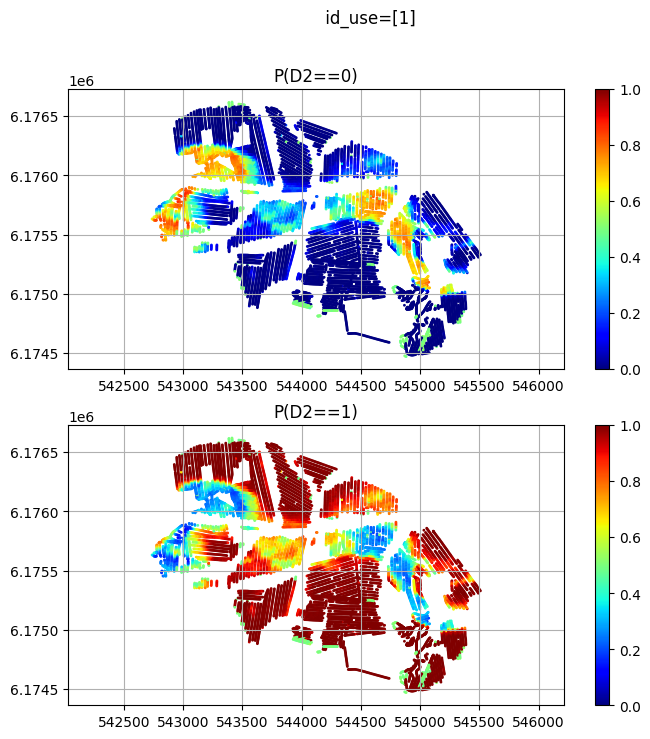

Rejection Sampling:   0%|                                                                                                                      | 0/1462 [00:00<?, ?it/s]

Rejection Sampling:   0%|                                                                                                                      | 0/1462 [00:00<?, ?it/s]

Rejection Sampling:   0%|                                                                                                                      | 0/1462 [00:00<?, ?it/s]

Rejection Sampling:   0%|                                                                                                              | 1/1462 [00:00<03:02,  8.00it/s]

Rejection Sampling:   0%|                                                                                                                      | 0/1462 [00:00<?, ?it/s]

Rejection Sampling:   0%|                                                                                                                      | 0/1462 [00:00<?, ?it/s]

Rejection Sampling:   0%|                                                                                                              | 1/1462 [00:00<04:19,  5.63it/s]

Rejection Sampling:   0%|                                                                                                                      | 0/1461 [00:00<?, ?it/s]

Rejection Sampling:   0%|▏                                                                                                             | 3/1462 [00:00<01:59, 12.24it/s]

Rejection Sampling:   0%|                                                                                                              | 1/1462 [00:00<03:51,  6.31it/s]

Rejection Sampling:   0%|                                                                                                                      | 0/1461 [00:00<?, ?it/s]

Rejection Sampling:   0%|                                                                                                              | 1/1462 [00:00<03:46,  6.46it/s]

Rejection Sampling:   0%|                                                                                                                      | 0/1461 [00:00<?, ?it/s]

Rejection Sampling:   0%|▏                                                                                                             | 2/1462 [00:00<04:12,  5.77it/s]

Rejection Sampling:   0%|                                                                                                              | 1/1462 [00:00<05:29,  4.44it/s]

Rejection Sampling:   0%|▏                                                                                                             | 3/1462 [00:00<02:38,  9.21it/s]

Rejection Sampling:   0%|                                                                                                              | 1/1461 [00:00<03:26,  7.08it/s]

Rejection Sampling:   0%|                                                                                                              | 1/1461 [00:00<05:52,  4.14it/s]

Rejection Sampling:   0%|▏                                                                                                             | 2/1462 [00:00<04:39,  5.22it/s]

Rejection Sampling:   0%|▎                                                                                                             | 4/1462 [00:00<02:36,  9.31it/s]

Rejection Sampling:   0%|                                                                                                              | 1/1461 [00:00<05:21,  4.54it/s]

Rejection Sampling:   0%|▏                                                                                                             | 3/1462 [00:00<04:32,  5.36it/s]

Rejection Sampling:   0%|▏                                                                                                             | 3/1461 [00:00<02:22, 10.25it/s]

Rejection Sampling:   0%|▏                                                                                                             | 2/1462 [00:00<05:04,  4.80it/s]

Rejection Sampling:   0%|▍                                                                                                             | 5/1462 [00:00<03:20,  7.26it/s]

Rejection Sampling:   0%|▏                                                                                                             | 2/1461 [00:00<05:03,  4.81it/s]

Rejection Sampling:   0%|▍                                                                                                             | 5/1462 [00:00<02:48,  8.65it/s]

Rejection Sampling:   0%|▎                                                                                                             | 4/1462 [00:00<02:59,  8.14it/s]

Rejection Sampling:   0%|▎                                                                                                             | 4/1462 [00:00<03:54,  6.22it/s]

Rejection Sampling:   0%|▍                                                                                                             | 6/1462 [00:00<03:07,  7.76it/s]

Rejection Sampling:   0%|▏                                                                                                             | 2/1461 [00:00<04:47,  5.08it/s]

Rejection Sampling:   0%|▍                                                                                                             | 5/1462 [00:00<02:49,  8.61it/s]

Rejection Sampling:   0%|▍                                                                                                             | 5/1461 [00:00<02:16, 10.70it/s]

Rejection Sampling:   0%|▏                                                                                                             | 3/1462 [00:00<05:02,  4.82it/s]

Rejection Sampling:   0%|▍                                                                                                             | 5/1462 [00:00<03:27,  7.03it/s]

Rejection Sampling:   0%|▏                                                                                                             | 3/1461 [00:00<05:00,  4.85it/s]

Rejection Sampling:   0%|▍                                                                                                             | 6/1462 [00:00<03:29,  6.94it/s]

Rejection Sampling:   1%|▌                                                                                                             | 8/1462 [00:00<02:43,  8.88it/s]

Rejection Sampling:   0%|▏                                                                                                             | 3/1461 [00:00<04:15,  5.71it/s]

Rejection Sampling:   0%|▌                                                                                                             | 7/1461 [00:00<02:09, 11.25it/s]

Rejection Sampling:   0%|▌                                                                                                             | 7/1462 [00:00<02:34,  9.44it/s]

Rejection Sampling:   0%|▌                                                                                                             | 7/1462 [00:00<03:10,  7.65it/s]

Rejection Sampling:   0%|▌                                                                                                             | 7/1462 [00:00<02:43,  8.93it/s]

Rejection Sampling:   0%|▍                                                                                                             | 5/1462 [00:00<03:22,  7.20it/s]

Rejection Sampling:   1%|▋                                                                                                             | 9/1462 [00:01<02:56,  8.22it/s]

Rejection Sampling:   0%|▎                                                                                                             | 4/1461 [00:00<04:56,  4.92it/s]

Rejection Sampling:   1%|▋                                                                                                             | 9/1461 [00:00<02:04, 11.65it/s]

Rejection Sampling:   0%|▎                                                                                                             | 4/1461 [00:00<04:29,  5.40it/s]

Rejection Sampling:   1%|▌                                                                                                             | 8/1462 [00:00<02:57,  8.21it/s]

Rejection Sampling:   1%|▋                                                                                                             | 9/1462 [00:01<02:34,  9.40it/s]

Rejection Sampling:   1%|▋                                                                                                             | 9/1462 [00:01<02:24, 10.08it/s]

Rejection Sampling:   0%|▌                                                                                                             | 7/1462 [00:00<02:52,  8.43it/s]

Rejection Sampling:   0%|▍                                                                                                             | 5/1461 [00:00<04:11,  5.80it/s]

Rejection Sampling:   1%|▊                                                                                                            | 11/1462 [00:01<02:38,  9.16it/s]

Rejection Sampling:   1%|▊                                                                                                            | 11/1461 [00:00<02:02, 11.82it/s]

Rejection Sampling:   1%|▋                                                                                                            | 10/1462 [00:01<02:36,  9.29it/s]

Rejection Sampling:   1%|▊                                                                                                            | 11/1462 [00:01<02:25,  9.99it/s]

Rejection Sampling:   0%|▍                                                                                                             | 5/1461 [00:00<04:41,  5.17it/s]

Rejection Sampling:   1%|▊                                                                                                            | 11/1462 [00:01<02:17, 10.56it/s]

Rejection Sampling:   1%|▉                                                                                                            | 12/1462 [00:01<02:37,  9.21it/s]

Rejection Sampling:   1%|▌                                                                                                             | 8/1462 [00:01<03:23,  7.14it/s]

Rejection Sampling:   0%|▍                                                                                                             | 6/1461 [00:01<04:29,  5.40it/s]

Rejection Sampling:   1%|▉                                                                                                            | 13/1461 [00:01<02:02, 11.83it/s]

Rejection Sampling:   1%|▉                                                                                                            | 12/1462 [00:01<02:23, 10.14it/s]

Rejection Sampling:   1%|▉                                                                                                            | 13/1462 [00:01<02:15, 10.70it/s]

Rejection Sampling:   0%|▍                                                                                                             | 6/1461 [00:01<04:26,  5.46it/s]

Rejection Sampling:   1%|▉                                                                                                            | 13/1462 [00:01<02:10, 11.07it/s]

Rejection Sampling:   1%|▉                                                                                                            | 13/1462 [00:01<03:09,  7.64it/s]

Rejection Sampling:   1%|▋                                                                                                            | 10/1462 [00:01<02:58,  8.12it/s]

Rejection Sampling:   0%|▌                                                                                                             | 7/1461 [00:01<04:35,  5.28it/s]

Rejection Sampling:   1%|█                                                                                                            | 15/1461 [00:01<02:01, 11.88it/s]

Rejection Sampling:   1%|█                                                                                                            | 14/1462 [00:01<02:15, 10.69it/s]

Rejection Sampling:   1%|█                                                                                                            | 15/1462 [00:01<02:10, 11.11it/s]

Rejection Sampling:   1%|█                                                                                                            | 15/1462 [00:01<02:07, 11.38it/s]

Rejection Sampling:   0%|▌                                                                                                             | 7/1461 [00:01<04:25,  5.49it/s]

Rejection Sampling:   1%|█                                                                                                            | 14/1462 [00:01<03:33,  6.77it/s]

Rejection Sampling:   1%|▉                                                                                                            | 12/1462 [00:01<02:36,  9.24it/s]

Rejection Sampling:   1%|▋                                                                                                             | 9/1461 [00:01<03:24,  7.12it/s]

Rejection Sampling:   1%|█▎                                                                                                           | 17/1461 [00:01<02:01, 11.91it/s]

Rejection Sampling:   1%|█▎                                                                                                           | 17/1462 [00:01<02:07, 11.34it/s]

Rejection Sampling:   1%|█▏                                                                                                           | 16/1462 [00:01<02:12, 10.95it/s]

Rejection Sampling:   1%|█▎                                                                                                           | 17/1462 [00:01<02:05, 11.51it/s]

Rejection Sampling:   1%|▌                                                                                                             | 8/1461 [00:01<04:24,  5.49it/s]

Rejection Sampling:   1%|█                                                                                                            | 14/1462 [00:01<02:23, 10.11it/s]

Rejection Sampling:   1%|█                                                                                                            | 15/1462 [00:01<03:43,  6.47it/s]

Rejection Sampling:   1%|▊                                                                                                            | 11/1461 [00:01<02:47,  8.63it/s]

Rejection Sampling:   1%|█▍                                                                                                           | 19/1461 [00:01<01:59, 12.10it/s]

Rejection Sampling:   1%|█▍                                                                                                           | 19/1462 [00:01<02:02, 11.74it/s]

Rejection Sampling:   1%|█▎                                                                                                           | 18/1462 [00:01<02:06, 11.45it/s]

Rejection Sampling:   1%|█▍                                                                                                           | 19/1462 [00:01<02:01, 11.90it/s]

Rejection Sampling:   1%|▋                                                                                                             | 9/1461 [00:01<04:19,  5.60it/s]

Rejection Sampling:   1%|█▏                                                                                                           | 16/1462 [00:02<03:33,  6.79it/s]

Rejection Sampling:   1%|█▏                                                                                                           | 16/1462 [00:01<02:10, 11.07it/s]

Rejection Sampling:   1%|█▌                                                                                                           | 21/1461 [00:01<02:00, 11.99it/s]

Rejection Sampling:   1%|▉                                                                                                            | 12/1461 [00:01<03:09,  7.64it/s]

Rejection Sampling:   1%|█▌                                                                                                           | 21/1462 [00:02<01:58, 12.17it/s]

Rejection Sampling:   1%|█▍                                                                                                           | 20/1462 [00:01<02:00, 11.97it/s]

Rejection Sampling:   1%|█▌                                                                                                           | 21/1462 [00:02<01:57, 12.28it/s]

Rejection Sampling:   1%|▊                                                                                                            | 11/1461 [00:01<03:15,  7.42it/s]

Rejection Sampling:   1%|█▎                                                                                                           | 18/1462 [00:02<02:51,  8.43it/s]

Rejection Sampling:   1%|█▎                                                                                                           | 18/1462 [00:02<02:10, 11.06it/s]

Rejection Sampling:   2%|█▋                                                                                                           | 23/1461 [00:01<02:01, 11.82it/s]

Rejection Sampling:   2%|█▋                                                                                                           | 23/1462 [00:02<01:57, 12.22it/s]

Rejection Sampling:   2%|█▋                                                                                                           | 22/1462 [00:02<01:59, 12.08it/s]

Rejection Sampling:   2%|█▋                                                                                                           | 23/1462 [00:02<01:56, 12.30it/s]

Rejection Sampling:   1%|▉                                                                                                            | 13/1461 [00:02<03:29,  6.92it/s]

Rejection Sampling:   1%|▉                                                                                                            | 12/1461 [00:02<03:32,  6.82it/s]

Rejection Sampling:   1%|█▍                                                                                                           | 19/1462 [00:02<03:16,  7.34it/s]

Rejection Sampling:   1%|█▍                                                                                                           | 20/1462 [00:02<02:07, 11.27it/s]

Rejection Sampling:   2%|█▊                                                                                                           | 25/1461 [00:02<02:00, 11.88it/s]

Rejection Sampling:   2%|█▊                                                                                                           | 25/1462 [00:02<01:58, 12.17it/s]

Rejection Sampling:   2%|█▊                                                                                                           | 25/1462 [00:02<01:57, 12.24it/s]

Rejection Sampling:   2%|█▊                                                                                                           | 24/1462 [00:02<01:59, 12.00it/s]

Rejection Sampling:   1%|█                                                                                                            | 15/1461 [00:02<02:53,  8.35it/s]

Rejection Sampling:   1%|▉                                                                                                            | 13/1461 [00:02<03:46,  6.40it/s]

Rejection Sampling:   2%|█▋                                                                                                           | 22/1462 [00:02<02:04, 11.59it/s]

Rejection Sampling:   1%|█▍                                                                                                           | 20/1462 [00:02<03:32,  6.80it/s]

Rejection Sampling:   2%|██                                                                                                           | 27/1462 [00:02<01:57, 12.26it/s]

Rejection Sampling:   2%|██                                                                                                           | 27/1462 [00:02<01:56, 12.31it/s]

Rejection Sampling:   2%|█▉                                                                                                           | 26/1462 [00:02<01:58, 12.14it/s]

Rejection Sampling:   1%|█▎                                                                                                           | 17/1461 [00:02<02:31,  9.54it/s]

Rejection Sampling:   2%|█▊                                                                                                           | 24/1462 [00:02<02:01, 11.81it/s]

Rejection Sampling:   1%|█                                                                                                            | 14/1461 [00:02<04:02,  5.98it/s]

Rejection Sampling:   2%|█▋                                                                                                           | 22/1462 [00:02<02:55,  8.19it/s]

Rejection Sampling:   2%|██▏                                                                                                          | 29/1462 [00:02<01:57, 12.24it/s]

Rejection Sampling:   2%|██                                                                                                           | 28/1462 [00:02<01:57, 12.16it/s]

Rejection Sampling:   1%|█▍                                                                                                           | 19/1461 [00:02<02:18, 10.39it/s]

Rejection Sampling:   2%|██                                                                                                           | 27/1461 [00:02<02:45,  8.67it/s]

Rejection Sampling:   2%|█▉                                                                                                           | 26/1462 [00:02<01:59, 12.05it/s]

Rejection Sampling:   2%|█▊                                                                                                           | 24/1462 [00:02<02:34,  9.33it/s]

Rejection Sampling:   2%|██▎                                                                                                          | 31/1462 [00:02<01:56, 12.26it/s]

Rejection Sampling:   1%|█                                                                                                            | 15/1461 [00:02<04:13,  5.71it/s]

Rejection Sampling:   2%|██▏                                                                                                          | 30/1462 [00:02<01:57, 12.20it/s]

Rejection Sampling:   1%|█▌                                                                                                           | 21/1461 [00:02<02:17, 10.45it/s]

Rejection Sampling:   2%|██▏                                                                                                          | 29/1462 [00:02<02:44,  8.71it/s]

Rejection Sampling:   2%|██                                                                                                           | 28/1461 [00:02<03:05,  7.72it/s]

Rejection Sampling:   2%|██                                                                                                           | 28/1462 [00:02<01:59, 11.97it/s]

Rejection Sampling:   1%|█▏                                                                                                           | 16/1461 [00:02<04:00,  6.02it/s]

Rejection Sampling:   2%|█▉                                                                                                           | 26/1462 [00:03<02:23, 10.02it/s]

Rejection Sampling:   2%|██▍                                                                                                          | 32/1462 [00:02<01:59, 12.01it/s]

Rejection Sampling:   2%|█▋                                                                                                           | 23/1461 [00:02<02:13, 10.78it/s]

Rejection Sampling:   2%|██▍                                                                                                          | 33/1462 [00:03<02:17, 10.40it/s]

Rejection Sampling:   2%|██▏                                                                                                          | 29/1461 [00:02<03:27,  6.89it/s]

Rejection Sampling:   2%|██▏                                                                                                          | 30/1462 [00:03<02:01, 11.82it/s]

Rejection Sampling:   1%|█▎                                                                                                           | 18/1461 [00:02<03:08,  7.67it/s]

Rejection Sampling:   2%|██▌                                                                                                          | 34/1462 [00:03<02:00, 11.83it/s]

Rejection Sampling:   2%|█▊                                                                                                           | 25/1461 [00:03<02:08, 11.14it/s]

Rejection Sampling:   2%|██                                                                                                           | 28/1462 [00:03<02:39,  8.97it/s]

Rejection Sampling:   2%|██▌                                                                                                          | 35/1462 [00:03<02:11, 10.82it/s]

Rejection Sampling:   2%|██▎                                                                                                          | 31/1461 [00:03<02:56,  8.11it/s]

Rejection Sampling:   2%|██▎                                                                                                          | 31/1462 [00:03<03:21,  7.10it/s]

Rejection Sampling:   1%|█▍                                                                                                           | 20/1461 [00:03<02:39,  9.05it/s]

Rejection Sampling:   2%|██                                                                                                           | 27/1461 [00:03<02:04, 11.53it/s]

Rejection Sampling:   2%|██▏                                                                                                          | 30/1462 [00:03<02:28,  9.66it/s]

Rejection Sampling:   2%|██▍                                                                                                          | 32/1462 [00:03<02:33,  9.33it/s]

Rejection Sampling:   2%|██▍                                                                                                          | 33/1461 [00:03<02:38,  8.99it/s]

Rejection Sampling:   3%|██▊                                                                                                          | 37/1462 [00:03<02:17, 10.36it/s]

Rejection Sampling:   2%|██▍                                                                                                          | 32/1462 [00:03<03:37,  6.58it/s]

Rejection Sampling:   1%|█▌                                                                                                           | 21/1461 [00:03<03:06,  7.72it/s]

Rejection Sampling:   2%|██▏                                                                                                          | 29/1461 [00:03<02:03, 11.63it/s]

Rejection Sampling:   2%|██▋                                                                                                          | 36/1462 [00:03<02:49,  8.41it/s]

Rejection Sampling:   2%|██▍                                                                                                          | 32/1462 [00:03<02:19, 10.29it/s]

Rejection Sampling:   2%|██▌                                                                                                          | 34/1462 [00:03<02:21, 10.07it/s]

Rejection Sampling:   2%|█▋                                                                                                           | 22/1461 [00:03<02:59,  8.04it/s]

Rejection Sampling:   3%|██▉                                                                                                          | 39/1462 [00:03<02:11, 10.82it/s]

Rejection Sampling:   2%|██▌                                                                                                          | 34/1461 [00:03<03:04,  7.75it/s]

Rejection Sampling:   2%|██▍                                                                                                          | 33/1462 [00:03<03:51,  6.18it/s]

Rejection Sampling:   2%|██▎                                                                                                          | 31/1461 [00:03<02:02, 11.71it/s]

Rejection Sampling:   3%|██▊                                                                                                          | 37/1462 [00:03<03:00,  7.90it/s]

Rejection Sampling:   2%|██▋                                                                                                          | 36/1462 [00:03<02:15, 10.49it/s]

Rejection Sampling:   2%|█▊                                                                                                           | 24/1461 [00:03<02:36,  9.20it/s]

Rejection Sampling:   3%|███                                                                                                          | 41/1462 [00:03<02:09, 10.95it/s]

Rejection Sampling:   2%|██▌                                                                                                          | 35/1461 [00:03<03:22,  7.04it/s]

Rejection Sampling:   2%|██▌                                                                                                          | 34/1462 [00:03<02:33,  9.28it/s]

Rejection Sampling:   2%|██▌                                                                                                          | 35/1462 [00:03<03:10,  7.48it/s]

Rejection Sampling:   3%|██▉                                                                                                          | 39/1462 [00:03<02:39,  8.90it/s]

Rejection Sampling:   3%|██▊                                                                                                          | 38/1462 [00:03<02:10, 10.88it/s]

Rejection Sampling:   2%|█▉                                                                                                           | 26/1461 [00:03<02:23,  9.99it/s]

Rejection Sampling:   2%|██▋                                                                                                          | 36/1462 [00:04<03:01,  7.85it/s]

Rejection Sampling:   3%|███▏                                                                                                         | 43/1462 [00:04<02:07, 11.09it/s]

Rejection Sampling:   2%|██▋                                                                                                          | 36/1461 [00:03<03:32,  6.69it/s]

Rejection Sampling:   2%|██▌                                                                                                          | 35/1462 [00:04<02:57,  8.04it/s]

Rejection Sampling:   3%|███                                                                                                          | 41/1462 [00:04<02:26,  9.71it/s]

Rejection Sampling:   2%|██▍                                                                                                          | 33/1461 [00:03<02:50,  8.39it/s]

Rejection Sampling:   3%|██▉                                                                                                          | 40/1462 [00:04<02:04, 11.41it/s]

Rejection Sampling:   2%|██                                                                                                           | 28/1461 [00:03<02:12, 10.85it/s]

Rejection Sampling:   3%|██▊                                                                                                          | 38/1462 [00:04<02:34,  9.23it/s]

Rejection Sampling:   3%|███▎                                                                                                         | 45/1462 [00:04<02:01, 11.64it/s]

Rejection Sampling:   3%|██▊                                                                                                          | 37/1461 [00:03<03:32,  6.71it/s]

Rejection Sampling:   2%|██▋                                                                                                          | 36/1462 [00:04<03:11,  7.45it/s]

Rejection Sampling:   3%|███▏                                                                                                         | 43/1462 [00:04<02:15, 10.50it/s]

Rejection Sampling:   3%|███▏                                                                                                         | 42/1462 [00:04<02:00, 11.78it/s]

Rejection Sampling:   2%|██▏                                                                                                          | 30/1461 [00:04<02:05, 11.42it/s]

Rejection Sampling:   2%|██▌                                                                                                          | 34/1461 [00:04<03:08,  7.59it/s]

Rejection Sampling:   3%|██▉                                                                                                          | 40/1462 [00:04<02:21, 10.08it/s]

Rejection Sampling:   3%|███▌                                                                                                         | 47/1462 [00:04<01:58, 11.95it/s]

Rejection Sampling:   3%|██▊                                                                                                          | 38/1461 [00:04<03:45,  6.32it/s]

Rejection Sampling:   3%|███▎                                                                                                         | 45/1462 [00:04<02:07, 11.10it/s]

Rejection Sampling:   3%|███▎                                                                                                         | 44/1462 [00:04<01:57, 12.09it/s]

Rejection Sampling:   3%|██▊                                                                                                          | 37/1462 [00:04<03:28,  6.82it/s]

Rejection Sampling:   2%|██▌                                                                                                          | 35/1461 [00:04<03:15,  7.29it/s]

Rejection Sampling:   3%|███▏                                                                                                         | 42/1462 [00:04<02:12, 10.69it/s]

Rejection Sampling:   3%|███▋                                                                                                         | 49/1462 [00:04<01:56, 12.12it/s]

Rejection Sampling:   2%|██▍                                                                                                          | 32/1461 [00:04<02:08, 11.10it/s]

Rejection Sampling:   3%|██▉                                                                                                          | 39/1461 [00:04<03:59,  5.93it/s]

Rejection Sampling:   3%|███▌                                                                                                         | 47/1462 [00:04<02:04, 11.35it/s]

Rejection Sampling:   3%|██▊                                                                                                          | 38/1462 [00:04<03:28,  6.83it/s]

Rejection Sampling:   3%|███▍                                                                                                         | 46/1462 [00:04<02:03, 11.50it/s]

Rejection Sampling:   3%|██▊                                                                                                          | 37/1461 [00:04<02:47,  8.49it/s]

Rejection Sampling:   3%|███▊                                                                                                         | 51/1462 [00:04<01:55, 12.23it/s]

Rejection Sampling:   3%|███▋                                                                                                         | 49/1462 [00:04<02:02, 11.56it/s]

Rejection Sampling:   3%|██▉                                                                                                          | 40/1461 [00:04<04:08,  5.73it/s]

Rejection Sampling:   3%|██▉                                                                                                          | 39/1462 [00:04<03:50,  6.18it/s]

Rejection Sampling:   3%|███▌                                                                                                         | 48/1462 [00:04<02:02, 11.51it/s]

Rejection Sampling:   4%|███▉                                                                                                         | 53/1462 [00:04<01:58, 11.91it/s]

Rejection Sampling:   3%|██▊                                                                                                          | 38/1461 [00:04<03:11,  7.42it/s]

Rejection Sampling:   2%|██▌                                                                                                          | 34/1461 [00:04<02:55,  8.14it/s]

Rejection Sampling:   3%|███▎                                                                                                         | 44/1462 [00:04<03:00,  7.85it/s]

Rejection Sampling:   3%|███▏                                                                                                         | 42/1461 [00:04<03:09,  7.50it/s]

Rejection Sampling:   3%|██▉                                                                                                          | 39/1461 [00:04<03:00,  7.87it/s]

Rejection Sampling:   3%|███▊                                                                                                         | 51/1462 [00:04<02:07, 11.06it/s]

Rejection Sampling:   3%|███▋                                                                                                         | 50/1462 [00:04<01:59, 11.86it/s]

Rejection Sampling:   4%|████                                                                                                         | 55/1462 [00:04<01:56, 12.10it/s]

Rejection Sampling:   3%|██▉                                                                                                          | 40/1462 [00:05<04:02,  5.86it/s]

Rejection Sampling:   2%|██▌                                                                                                          | 35/1461 [00:04<03:06,  7.66it/s]

Rejection Sampling:   3%|██▉                                                                                                          | 40/1461 [00:04<02:52,  8.25it/s]

Rejection Sampling:   3%|███▎                                                                                                         | 45/1462 [00:05<03:18,  7.13it/s]

Rejection Sampling:   3%|███▎                                                                                                         | 44/1461 [00:04<02:41,  8.76it/s]

Rejection Sampling:   4%|███▉                                                                                                         | 53/1462 [00:05<02:04, 11.31it/s]

Rejection Sampling:   4%|████▏                                                                                                        | 57/1462 [00:05<01:55, 12.16it/s]

Rejection Sampling:   3%|███                                                                                                          | 41/1462 [00:05<04:13,  5.60it/s]

Rejection Sampling:   2%|██▋                                                                                                          | 36/1461 [00:04<03:22,  7.05it/s]

Rejection Sampling:   3%|███                                                                                                          | 41/1461 [00:05<03:15,  7.25it/s]

Rejection Sampling:   3%|███▍                                                                                                         | 46/1461 [00:05<02:28,  9.51it/s]

Rejection Sampling:   3%|███▍                                                                                                         | 46/1462 [00:05<03:41,  6.40it/s]

Rejection Sampling:   4%|████▍                                                                                                        | 59/1462 [00:05<01:57, 11.92it/s]

Rejection Sampling:   4%|███▉                                                                                                         | 52/1462 [00:05<02:51,  8.21it/s]

Rejection Sampling:   4%|████                                                                                                         | 55/1462 [00:05<02:22,  9.89it/s]

Rejection Sampling:   3%|███▏                                                                                                         | 42/1462 [00:05<04:27,  5.30it/s]

Rejection Sampling:   3%|███▏                                                                                                         | 43/1461 [00:05<02:45,  8.55it/s]

Rejection Sampling:   3%|██▊                                                                                                          | 37/1461 [00:05<03:35,  6.62it/s]

Rejection Sampling:   3%|███▌                                                                                                         | 48/1461 [00:05<02:19, 10.13it/s]

Rejection Sampling:   4%|████▌                                                                                                        | 61/1462 [00:05<01:57, 11.94it/s]

Rejection Sampling:   3%|███▌                                                                                                         | 47/1462 [00:05<03:58,  5.94it/s]

Rejection Sampling:   4%|███▉                                                                                                         | 53/1462 [00:05<03:08,  7.46it/s]

Rejection Sampling:   3%|███▎                                                                                                         | 44/1462 [00:05<03:22,  6.99it/s]

Rejection Sampling:   3%|███▎                                                                                                         | 45/1461 [00:05<02:28,  9.51it/s]

Rejection Sampling:   3%|██▊                                                                                                          | 38/1461 [00:05<03:56,  6.02it/s]

Rejection Sampling:   3%|███▋                                                                                                         | 50/1461 [00:05<02:15, 10.38it/s]

Rejection Sampling:   4%|████▋                                                                                                        | 63/1462 [00:05<01:59, 11.71it/s]

Rejection Sampling:   3%|███▋                                                                                                         | 49/1462 [00:05<03:14,  7.26it/s]

Rejection Sampling:   4%|████                                                                                                         | 54/1462 [00:05<03:16,  7.16it/s]

Rejection Sampling:   3%|███▍                                                                                                         | 46/1462 [00:05<02:49,  8.35it/s]

Rejection Sampling:   3%|███▌                                                                                                         | 47/1461 [00:05<02:17, 10.29it/s]

Rejection Sampling:   4%|████▏                                                                                                        | 57/1462 [00:05<03:03,  7.65it/s]

Rejection Sampling:   4%|███▉                                                                                                         | 52/1461 [00:05<02:09, 10.91it/s]

Rejection Sampling:   3%|██▉                                                                                                          | 39/1461 [00:05<04:04,  5.81it/s]

Rejection Sampling:   4%|████▊                                                                                                        | 65/1462 [00:05<01:56, 12.03it/s]

Rejection Sampling:   3%|███▋                                                                                                         | 50/1462 [00:05<03:26,  6.83it/s]

Rejection Sampling:   4%|████▏                                                                                                        | 56/1462 [00:05<02:46,  8.43it/s]

Rejection Sampling:   3%|███▌                                                                                                         | 48/1462 [00:06<02:29,  9.43it/s]

Rejection Sampling:   3%|███▋                                                                                                         | 49/1461 [00:05<02:09, 10.87it/s]

Rejection Sampling:   3%|██▉                                                                                                          | 40/1461 [00:05<03:51,  6.14it/s]

Rejection Sampling:   4%|████                                                                                                         | 54/1461 [00:05<02:05, 11.22it/s]

Rejection Sampling:   4%|████▎                                                                                                        | 58/1462 [00:05<03:19,  7.05it/s]

Rejection Sampling:   5%|████▉                                                                                                        | 67/1462 [00:05<01:56, 12.01it/s]

Rejection Sampling:   3%|███▋                                                                                                         | 49/1462 [00:06<02:38,  8.92it/s]

Rejection Sampling:   3%|███▊                                                                                                         | 51/1462 [00:06<03:45,  6.25it/s]

Rejection Sampling:   3%|███▏                                                                                                         | 42/1461 [00:05<03:01,  7.80it/s]

Rejection Sampling:   4%|████▎                                                                                                        | 58/1462 [00:06<02:43,  8.58it/s]

Rejection Sampling:   4%|████▏                                                                                                        | 56/1461 [00:05<02:01, 11.52it/s]

Rejection Sampling:   5%|█████▏                                                                                                       | 69/1462 [00:06<01:56, 11.97it/s]

Rejection Sampling:   4%|████▍                                                                                                        | 59/1462 [00:06<03:35,  6.50it/s]

Rejection Sampling:   3%|███▋                                                                                                         | 50/1462 [00:06<03:06,  7.59it/s]

Rejection Sampling:   4%|███▉                                                                                                         | 52/1462 [00:06<04:01,  5.85it/s]

Rejection Sampling:   3%|███▎                                                                                                         | 44/1461 [00:06<02:36,  9.03it/s]

Rejection Sampling:   4%|████▍                                                                                                        | 60/1462 [00:06<02:28,  9.46it/s]

Rejection Sampling:   4%|████▎                                                                                                        | 58/1461 [00:06<01:59, 11.75it/s]

Rejection Sampling:   3%|███▊                                                                                                         | 51/1461 [00:06<02:58,  7.91it/s]

Rejection Sampling:   5%|█████▎                                                                                                       | 71/1462 [00:06<01:53, 12.27it/s]

Rejection Sampling:   4%|████▍                                                                                                        | 60/1462 [00:06<03:49,  6.11it/s]

Rejection Sampling:   4%|███▉                                                                                                         | 52/1461 [00:06<02:51,  8.22it/s]

Rejection Sampling:   3%|███▊                                                                                                         | 51/1462 [00:06<03:32,  6.65it/s]

Rejection Sampling:   4%|████▌                                                                                                        | 62/1462 [00:06<02:20,  9.97it/s]

Rejection Sampling:   4%|███▉                                                                                                         | 53/1462 [00:06<04:13,  5.56it/s]

Rejection Sampling:   5%|█████▍                                                                                                       | 73/1462 [00:06<01:55, 11.99it/s]

Rejection Sampling:   3%|███▍                                                                                                         | 46/1461 [00:06<02:33,  9.22it/s]

Rejection Sampling:   4%|████▌                                                                                                        | 61/1462 [00:06<03:48,  6.14it/s]

Rejection Sampling:   4%|████                                                                                                         | 54/1461 [00:06<02:30,  9.38it/s]

Rejection Sampling:   4%|████▊                                                                                                        | 64/1462 [00:06<02:07, 10.97it/s]

Rejection Sampling:   4%|███▉                                                                                                         | 52/1462 [00:06<03:38,  6.45it/s]

Rejection Sampling:   5%|█████▌                                                                                                       | 75/1462 [00:06<01:50, 12.53it/s]

Rejection Sampling:   4%|████                                                                                                         | 54/1462 [00:06<04:09,  5.63it/s]

Rejection Sampling:   3%|███▌                                                                                                         | 47/1461 [00:06<02:47,  8.44it/s]

Rejection Sampling:   4%|████▍                                                                                                        | 60/1461 [00:06<02:43,  8.55it/s]

Rejection Sampling:   4%|████▌                                                                                                        | 62/1462 [00:06<03:51,  6.05it/s]

Rejection Sampling:   5%|████▉                                                                                                        | 66/1462 [00:06<02:00, 11.54it/s]

Rejection Sampling:   5%|█████▋                                                                                                       | 77/1462 [00:06<01:49, 12.63it/s]

Rejection Sampling:   4%|███▉                                                                                                         | 53/1462 [00:06<03:44,  6.27it/s]

Rejection Sampling:   3%|███▋                                                                                                         | 49/1461 [00:06<02:27,  9.56it/s]

Rejection Sampling:   4%|████▏                                                                                                        | 56/1461 [00:06<02:38,  8.86it/s]

Rejection Sampling:   4%|████                                                                                                         | 55/1462 [00:06<04:14,  5.52it/s]

Rejection Sampling:   4%|████▌                                                                                                        | 61/1461 [00:06<03:04,  7.59it/s]

Rejection Sampling:   4%|████▋                                                                                                        | 63/1462 [00:06<04:05,  5.71it/s]

Rejection Sampling:   5%|█████                                                                                                        | 68/1462 [00:06<01:58, 11.74it/s]

Rejection Sampling:   4%|████▏                                                                                                        | 56/1462 [00:06<03:49,  6.12it/s]

Rejection Sampling:   5%|█████▉                                                                                                       | 79/1462 [00:06<01:51, 12.45it/s]

Rejection Sampling:   4%|████                                                                                                         | 55/1462 [00:07<02:58,  7.89it/s]

Rejection Sampling:   4%|████▋                                                                                                        | 62/1461 [00:06<02:56,  7.91it/s]

Rejection Sampling:   3%|███▋                                                                                                         | 50/1461 [00:06<02:50,  8.25it/s]

Rejection Sampling:   4%|████▎                                                                                                        | 57/1461 [00:06<03:00,  7.79it/s]

Rejection Sampling:   4%|████▊                                                                                                        | 65/1462 [00:07<03:09,  7.37it/s]

Rejection Sampling:   5%|█████▏                                                                                                       | 70/1462 [00:06<01:55, 12.07it/s]

Rejection Sampling:   6%|██████                                                                                                       | 81/1462 [00:07<01:50, 12.46it/s]

Rejection Sampling:   4%|████▏                                                                                                        | 57/1462 [00:07<02:32,  9.22it/s]

Rejection Sampling:   4%|████▊                                                                                                        | 64/1461 [00:06<02:33,  9.09it/s]

Rejection Sampling:   4%|████▏                                                                                                        | 57/1462 [00:07<04:02,  5.79it/s]

Rejection Sampling:   3%|███▊                                                                                                         | 51/1461 [00:06<03:13,  7.30it/s]

Rejection Sampling:   4%|████▎                                                                                                        | 58/1461 [00:07<03:25,  6.83it/s]

Rejection Sampling:   5%|█████▎                                                                                                       | 72/1462 [00:07<01:56, 11.92it/s]

Rejection Sampling:   5%|████▉                                                                                                        | 67/1462 [00:07<02:43,  8.51it/s]

Rejection Sampling:   4%|████▊                                                                                                        | 65/1461 [00:07<02:37,  8.87it/s]

Rejection Sampling:   6%|██████▏                                                                                                      | 83/1462 [00:07<01:54, 12.09it/s]

Rejection Sampling:   4%|████▍                                                                                                        | 59/1462 [00:07<02:22,  9.86it/s]

Rejection Sampling:   4%|████▎                                                                                                        | 58/1462 [00:07<04:16,  5.47it/s]

Rejection Sampling:   4%|███▉                                                                                                         | 52/1461 [00:07<03:32,  6.64it/s]

Rejection Sampling:   4%|████▍                                                                                                        | 59/1461 [00:07<03:43,  6.28it/s]

Rejection Sampling:   5%|█████▌                                                                                                       | 74/1462 [00:07<01:56, 11.92it/s]

Rejection Sampling:   5%|████▉                                                                                                        | 66/1461 [00:07<02:52,  8.08it/s]

Rejection Sampling:   5%|█████▏                                                                                                       | 69/1462 [00:07<02:31,  9.21it/s]

Rejection Sampling:   6%|██████▎                                                                                                      | 85/1462 [00:07<01:53, 12.11it/s]

Rejection Sampling:   4%|████▌                                                                                                        | 61/1462 [00:07<02:13, 10.52it/s]

Rejection Sampling:   4%|████▍                                                                                                        | 59/1462 [00:07<04:25,  5.28it/s]

Rejection Sampling:   4%|███▉                                                                                                         | 53/1461 [00:07<03:49,  6.12it/s]

Rejection Sampling:   5%|█████▋                                                                                                       | 76/1462 [00:07<01:57, 11.81it/s]

Rejection Sampling:   5%|█████                                                                                                        | 68/1461 [00:07<02:31,  9.18it/s]

Rejection Sampling:   4%|████▍                                                                                                        | 60/1461 [00:07<03:55,  5.96it/s]

Rejection Sampling:   5%|█████▏                                                                                                       | 70/1462 [00:07<02:50,  8.15it/s]

Rejection Sampling:   6%|██████▍                                                                                                      | 87/1462 [00:07<01:56, 11.83it/s]

Rejection Sampling:   4%|████▋                                                                                                        | 63/1462 [00:07<02:10, 10.72it/s]

Rejection Sampling:   5%|█████▊                                                                                                       | 78/1462 [00:07<01:59, 11.59it/s]

Rejection Sampling:   5%|█████▏                                                                                                       | 70/1461 [00:07<02:22,  9.74it/s]

Rejection Sampling:   4%|████▍                                                                                                        | 60/1462 [00:07<04:38,  5.04it/s]

Rejection Sampling:   4%|████                                                                                                         | 54/1461 [00:07<04:08,  5.66it/s]

Rejection Sampling:   5%|█████▎                                                                                                       | 71/1462 [00:07<03:09,  7.34it/s]

Rejection Sampling:   6%|██████▋                                                                                                      | 89/1462 [00:07<01:56, 11.75it/s]

Rejection Sampling:   4%|████▊                                                                                                        | 65/1462 [00:07<02:07, 10.99it/s]

Rejection Sampling:   4%|████▌                                                                                                        | 61/1461 [00:07<04:06,  5.68it/s]

Rejection Sampling:   5%|█████▉                                                                                                       | 80/1462 [00:07<01:56, 11.86it/s]

Rejection Sampling:   5%|█████▎                                                                                                       | 72/1461 [00:07<02:11, 10.53it/s]

Rejection Sampling:   4%|████▌                                                                                                        | 61/1462 [00:07<04:29,  5.20it/s]

Rejection Sampling:   6%|██████▊                                                                                                      | 91/1462 [00:07<01:54, 11.95it/s]

Rejection Sampling:   5%|█████▎                                                                                                       | 72/1462 [00:07<03:19,  6.96it/s]

Rejection Sampling:   5%|████▉                                                                                                        | 67/1462 [00:08<02:02, 11.36it/s]

Rejection Sampling:   4%|████                                                                                                         | 55/1461 [00:07<04:13,  5.54it/s]

Rejection Sampling:   4%|████▋                                                                                                        | 62/1461 [00:07<04:18,  5.42it/s]

Rejection Sampling:   6%|██████                                                                                                       | 82/1462 [00:08<01:58, 11.66it/s]

Rejection Sampling:   5%|█████▌                                                                                                       | 74/1461 [00:07<02:09, 10.70it/s]

Rejection Sampling:   6%|██████▉                                                                                                      | 93/1462 [00:08<01:56, 11.78it/s]

Rejection Sampling:   5%|█████▌                                                                                                       | 74/1462 [00:08<02:47,  8.28it/s]

Rejection Sampling:   5%|█████▏                                                                                                       | 69/1462 [00:08<02:01, 11.42it/s]

Rejection Sampling:   4%|████▏                                                                                                        | 56/1461 [00:07<04:08,  5.66it/s]

Rejection Sampling:   4%|████▌                                                                                                        | 62/1462 [00:08<04:30,  5.17it/s]

Rejection Sampling:   4%|████▋                                                                                                        | 63/1461 [00:08<04:21,  5.34it/s]

Rejection Sampling:   6%|██████▎                                                                                                      | 84/1462 [00:08<01:52, 12.23it/s]

Rejection Sampling:   6%|███████                                                                                                      | 95/1462 [00:08<01:50, 12.40it/s]

Rejection Sampling:   5%|█████▋                                                                                                       | 76/1462 [00:08<02:22,  9.69it/s]

Rejection Sampling:   4%|████▎                                                                                                        | 58/1461 [00:08<03:01,  7.72it/s]

Rejection Sampling:   5%|█████▎                                                                                                       | 71/1462 [00:08<01:55, 12.07it/s]

Rejection Sampling:   4%|████▋                                                                                                        | 63/1462 [00:08<04:12,  5.54it/s]

Rejection Sampling:   4%|████▊                                                                                                        | 64/1461 [00:08<03:59,  5.82it/s]

Rejection Sampling:   6%|██████▍                                                                                                      | 86/1462 [00:08<01:51, 12.32it/s]

Rejection Sampling:   7%|███████▏                                                                                                     | 97/1462 [00:08<01:50, 12.34it/s]

Rejection Sampling:   4%|████▍                                                                                                        | 60/1461 [00:08<02:34,  9.05it/s]

Rejection Sampling:   5%|█████▍                                                                                                       | 73/1462 [00:08<01:54, 12.16it/s]

Rejection Sampling:   5%|█████▊                                                                                                       | 78/1462 [00:08<02:13, 10.35it/s]

Rejection Sampling:   4%|████▊                                                                                                        | 65/1462 [00:08<03:08,  7.42it/s]

Rejection Sampling:   5%|█████▋                                                                                                       | 76/1461 [00:08<02:50,  8.14it/s]

Rejection Sampling:   4%|████▊                                                                                                        | 65/1461 [00:08<04:07,  5.64it/s]

Rejection Sampling:   6%|██████▌                                                                                                      | 88/1462 [00:08<01:51, 12.27it/s]

Rejection Sampling:   7%|███████▍                                                                                                     | 99/1462 [00:08<01:51, 12.27it/s]

Rejection Sampling:   4%|████▋                                                                                                        | 62/1461 [00:08<02:20,  9.95it/s]

Rejection Sampling:   5%|█████▌                                                                                                       | 75/1462 [00:08<01:54, 12.12it/s]

Rejection Sampling:   5%|████▉                                                                                                        | 66/1461 [00:08<03:43,  6.25it/s]

Rejection Sampling:   5%|████▉                                                                                                        | 66/1462 [00:08<03:32,  6.57it/s]

Rejection Sampling:   5%|█████▋                                                                                                       | 77/1461 [00:08<03:09,  7.31it/s]

Rejection Sampling:   6%|██████▋                                                                                                      | 90/1462 [00:08<01:52, 12.19it/s]

Rejection Sampling:   5%|████▉                                                                                                        | 67/1461 [00:08<03:24,  6.81it/s]

Rejection Sampling:   7%|███████▍                                                                                                    | 101/1462 [00:08<01:50, 12.27it/s]

Rejection Sampling:   4%|████▊                                                                                                        | 64/1461 [00:08<02:11, 10.65it/s]

Rejection Sampling:   5%|█████▋                                                                                                       | 77/1462 [00:08<01:53, 12.18it/s]

Rejection Sampling:   5%|█████▊                                                                                                       | 78/1461 [00:08<03:14,  7.10it/s]

Rejection Sampling:   5%|█████▉                                                                                                       | 80/1462 [00:08<02:58,  7.74it/s]

Rejection Sampling:   5%|████▉                                                                                                        | 67/1462 [00:08<03:49,  6.07it/s]

Rejection Sampling:   6%|██████▊                                                                                                      | 92/1462 [00:08<01:55, 11.86it/s]

Rejection Sampling:   5%|█████▏                                                                                                       | 69/1461 [00:08<02:46,  8.35it/s]

Rejection Sampling:   7%|███████▌                                                                                                    | 103/1462 [00:08<01:52, 12.05it/s]

Rejection Sampling:   5%|█████▉                                                                                                       | 79/1462 [00:09<01:55, 11.99it/s]

Rejection Sampling:   5%|█████                                                                                                        | 68/1462 [00:09<03:33,  6.53it/s]

Rejection Sampling:   5%|█████▉                                                                                                       | 80/1461 [00:08<02:42,  8.48it/s]

Rejection Sampling:   6%|██████                                                                                                       | 81/1462 [00:08<03:07,  7.37it/s]

Rejection Sampling:   6%|███████                                                                                                      | 94/1462 [00:08<01:48, 12.57it/s]

Rejection Sampling:   5%|█████▎                                                                                                       | 71/1461 [00:08<02:17, 10.10it/s]

Rejection Sampling:   5%|█████▏                                                                                                       | 70/1462 [00:09<02:45,  8.43it/s]

Rejection Sampling:   5%|████▉                                                                                                        | 66/1461 [00:08<02:51,  8.13it/s]

Rejection Sampling:   6%|██████                                                                                                       | 82/1461 [00:08<02:22,  9.70it/s]

Rejection Sampling:   6%|██████                                                                                                       | 82/1462 [00:09<03:17,  6.97it/s]

Rejection Sampling:   7%|███████▊                                                                                                    | 105/1462 [00:09<02:08, 10.56it/s]

Rejection Sampling:   7%|███████▏                                                                                                     | 96/1462 [00:09<01:48, 12.54it/s]

Rejection Sampling:   5%|█████▍                                                                                                       | 73/1461 [00:09<02:09, 10.75it/s]

Rejection Sampling:   5%|█████▎                                                                                                       | 72/1462 [00:09<02:26,  9.46it/s]

Rejection Sampling:   6%|██████▎                                                                                                      | 84/1461 [00:09<02:13, 10.28it/s]

Rejection Sampling:   6%|██████                                                                                                       | 81/1462 [00:09<02:37,  8.76it/s]

Rejection Sampling:   5%|████▉                                                                                                        | 67/1461 [00:09<03:11,  7.27it/s]

Rejection Sampling:   6%|██████▏                                                                                                      | 83/1462 [00:09<03:26,  6.69it/s]

Rejection Sampling:   7%|███████▉                                                                                                    | 107/1462 [00:09<02:04, 10.92it/s]

Rejection Sampling:   7%|███████▎                                                                                                     | 98/1462 [00:09<01:53, 12.01it/s]

Rejection Sampling:   5%|█████▌                                                                                                       | 75/1461 [00:09<02:06, 10.93it/s]

Rejection Sampling:   5%|█████▌                                                                                                       | 74/1462 [00:09<02:17, 10.11it/s]

Rejection Sampling:   6%|██████▎                                                                                                      | 84/1462 [00:09<03:21,  6.82it/s]

Rejection Sampling:   6%|██████▍                                                                                                      | 86/1461 [00:09<02:09, 10.64it/s]

Rejection Sampling:   7%|████████                                                                                                    | 109/1462 [00:09<02:01, 11.18it/s]

Rejection Sampling:   5%|█████                                                                                                        | 68/1461 [00:09<03:30,  6.61it/s]

Rejection Sampling:   5%|█████▋                                                                                                       | 77/1461 [00:09<02:03, 11.18it/s]

Rejection Sampling:   5%|█████▋                                                                                                       | 76/1462 [00:09<02:12, 10.48it/s]

Rejection Sampling:   6%|██████▌                                                                                                      | 88/1461 [00:09<02:06, 10.84it/s]

Rejection Sampling:   6%|██████▍                                                                                                      | 86/1462 [00:09<02:53,  7.93it/s]

Rejection Sampling:   8%|████████▏                                                                                                   | 111/1462 [00:09<02:00, 11.25it/s]

Rejection Sampling:   5%|█████▏                                                                                                       | 69/1461 [00:09<03:37,  6.40it/s]

Rejection Sampling:   6%|██████▏                                                                                                      | 83/1462 [00:09<03:14,  7.09it/s]

Rejection Sampling:   7%|███████▍                                                                                                    | 100/1462 [00:09<02:35,  8.76it/s]

Rejection Sampling:   5%|█████▊                                                                                                       | 78/1462 [00:09<02:02, 11.33it/s]

Rejection Sampling:   6%|██████▋                                                                                                      | 90/1461 [00:09<01:57, 11.63it/s]

Rejection Sampling:   6%|██████▍                                                                                                      | 87/1462 [00:09<03:04,  7.44it/s]

Rejection Sampling:   8%|████████▎                                                                                                   | 113/1462 [00:09<01:53, 11.88it/s]

Rejection Sampling:   5%|█████▎                                                                                                       | 71/1461 [00:09<02:59,  7.75it/s]

Rejection Sampling:   6%|██████▎                                                                                                      | 84/1462 [00:10<03:24,  6.75it/s]

Rejection Sampling:   7%|███████▌                                                                                                    | 102/1462 [00:09<02:23,  9.46it/s]

Rejection Sampling:   5%|█████▉                                                                                                       | 79/1461 [00:09<02:45,  8.33it/s]

Rejection Sampling:   6%|██████▊                                                                                                      | 92/1461 [00:09<01:55, 11.89it/s]

Rejection Sampling:   5%|█████▉                                                                                                       | 80/1462 [00:10<02:06, 10.89it/s]

Rejection Sampling:   6%|██████▌                                                                                                      | 88/1462 [00:09<03:20,  6.86it/s]

Rejection Sampling:   5%|█████▎                                                                                                       | 72/1461 [00:09<03:13,  7.18it/s]

Rejection Sampling:   6%|██████▎                                                                                                      | 85/1462 [00:10<03:40,  6.23it/s]

Rejection Sampling:   7%|███████▋                                                                                                    | 104/1462 [00:10<02:16,  9.95it/s]

Rejection Sampling:   6%|██████▋                                                                                                      | 89/1462 [00:10<03:07,  7.32it/s]

Rejection Sampling:   6%|███████                                                                                                      | 94/1461 [00:09<01:57, 11.62it/s]

Rejection Sampling:   5%|█████▉                                                                                                       | 80/1461 [00:10<03:10,  7.24it/s]

Rejection Sampling:   6%|██████                                                                                                       | 82/1462 [00:10<02:05, 10.98it/s]

Rejection Sampling:   5%|█████▍                                                                                                       | 73/1461 [00:09<03:07,  7.41it/s]

Rejection Sampling:   8%|████████▍                                                                                                   | 115/1462 [00:10<02:38,  8.52it/s]

Rejection Sampling:   6%|██████▊                                                                                                      | 91/1462 [00:10<02:37,  8.70it/s]

Rejection Sampling:   7%|███████▏                                                                                                     | 96/1461 [00:10<01:56, 11.72it/s]

Rejection Sampling:   6%|██████▍                                                                                                      | 86/1462 [00:10<03:54,  5.86it/s]

Rejection Sampling:   6%|██████▎                                                                                                      | 84/1462 [00:10<02:01, 11.32it/s]

Rejection Sampling:   5%|█████▌                                                                                                       | 75/1461 [00:10<02:36,  8.84it/s]

Rejection Sampling:   6%|██████                                                                                                       | 81/1461 [00:10<03:27,  6.64it/s]

Rejection Sampling:   7%|███████▊                                                                                                    | 106/1462 [00:10<02:29,  9.06it/s]

Rejection Sampling:   8%|████████▌                                                                                                   | 116/1462 [00:10<02:50,  7.91it/s]

Rejection Sampling:   6%|██████▊                                                                                                      | 92/1462 [00:10<02:53,  7.90it/s]

Rejection Sampling:   5%|█████▋                                                                                                       | 76/1461 [00:10<02:41,  8.57it/s]

Rejection Sampling:   7%|███████▎                                                                                                     | 98/1461 [00:10<01:56, 11.65it/s]

Rejection Sampling:   6%|██████▍                                                                                                      | 86/1462 [00:10<02:01, 11.35it/s]

Rejection Sampling:   6%|██████▍                                                                                                      | 87/1462 [00:10<04:06,  5.59it/s]

Rejection Sampling:   7%|███████▉                                                                                                    | 108/1462 [00:10<02:17,  9.81it/s]

Rejection Sampling:   8%|████████▋                                                                                                   | 118/1462 [00:10<02:28,  9.06it/s]

Rejection Sampling:   6%|██████                                                                                                       | 82/1461 [00:10<03:43,  6.18it/s]

Rejection Sampling:   5%|█████▋                                                                                                       | 77/1461 [00:10<02:43,  8.49it/s]

Rejection Sampling:   6%|██████▉                                                                                                      | 93/1462 [00:10<03:02,  7.51it/s]

Rejection Sampling:   6%|██████▌                                                                                                      | 88/1462 [00:10<01:54, 12.02it/s]

Rejection Sampling:   8%|████████▏                                                                                                   | 110/1462 [00:10<02:04, 10.82it/s]

Rejection Sampling:   8%|████████▊                                                                                                   | 120/1462 [00:10<02:09, 10.40it/s]

Rejection Sampling:   6%|██████▌                                                                                                      | 88/1462 [00:10<04:03,  5.65it/s]

Rejection Sampling:   5%|█████▊                                                                                                       | 78/1461 [00:10<02:52,  8.02it/s]

Rejection Sampling:   6%|██████▏                                                                                                      | 83/1461 [00:10<03:48,  6.04it/s]

Rejection Sampling:   6%|███████                                                                                                      | 94/1462 [00:10<03:18,  6.88it/s]

Rejection Sampling:   6%|██████▋                                                                                                      | 90/1462 [00:10<01:53, 12.06it/s]

Rejection Sampling:   5%|█████▉                                                                                                       | 79/1461 [00:10<02:43,  8.47it/s]

Rejection Sampling:   8%|████████▎                                                                                                   | 112/1462 [00:10<02:01, 11.11it/s]

Rejection Sampling:   7%|███████▍                                                                                                    | 100/1461 [00:10<02:39,  8.54it/s]

Rejection Sampling:   8%|█████████                                                                                                   | 122/1462 [00:10<02:11, 10.21it/s]

Rejection Sampling:   6%|██████▋                                                                                                      | 89/1462 [00:11<04:12,  5.44it/s]

Rejection Sampling:   6%|██████▎                                                                                                      | 84/1461 [00:10<04:04,  5.64it/s]

Rejection Sampling:   5%|█████▉                                                                                                       | 80/1461 [00:10<02:44,  8.42it/s]

Rejection Sampling:   6%|███████                                                                                                      | 95/1462 [00:10<03:44,  6.10it/s]

Rejection Sampling:   6%|██████▊                                                                                                      | 92/1462 [00:11<01:57, 11.65it/s]

Rejection Sampling:   8%|████████▍                                                                                                   | 114/1462 [00:10<02:03, 10.95it/s]

Rejection Sampling:   6%|██████▎                                                                                                      | 85/1461 [00:10<03:37,  6.34it/s]

Rejection Sampling:   7%|███████▍                                                                                                    | 101/1461 [00:10<03:03,  7.43it/s]

Rejection Sampling:   6%|██████▋                                                                                                      | 90/1462 [00:11<04:20,  5.27it/s]

Rejection Sampling:   6%|██████                                                                                                       | 82/1461 [00:10<02:24,  9.54it/s]

Rejection Sampling:   6%|███████                                                                                                      | 94/1462 [00:11<01:56, 11.70it/s]

Rejection Sampling:   6%|██████▍                                                                                                      | 86/1461 [00:11<03:23,  6.76it/s]

Rejection Sampling:   7%|███████▏                                                                                                     | 96/1462 [00:11<03:51,  5.91it/s]

Rejection Sampling:   8%|█████████▏                                                                                                  | 124/1462 [00:11<02:35,  8.62it/s]

Rejection Sampling:   8%|████████▌                                                                                                   | 116/1462 [00:11<02:00, 11.14it/s]

Rejection Sampling:   6%|██████▊                                                                                                      | 92/1462 [00:11<03:15,  7.02it/s]

Rejection Sampling:   7%|███████▌                                                                                                    | 102/1461 [00:11<03:16,  6.91it/s]

Rejection Sampling:   6%|██████▎                                                                                                      | 84/1461 [00:11<02:13, 10.35it/s]

Rejection Sampling:   7%|███████▏                                                                                                     | 96/1462 [00:11<01:57, 11.65it/s]

Rejection Sampling:   7%|███████▎                                                                                                     | 98/1462 [00:11<03:00,  7.55it/s]

Rejection Sampling:   6%|██████▉                                                                                                      | 93/1462 [00:11<03:05,  7.39it/s]

Rejection Sampling:   6%|██████▍                                                                                                      | 87/1461 [00:11<03:43,  6.14it/s]

Rejection Sampling:   9%|█████████▏                                                                                                  | 125/1462 [00:11<02:55,  7.61it/s]

Rejection Sampling:   7%|███████▌                                                                                                    | 103/1461 [00:11<03:28,  6.51it/s]

Rejection Sampling:   6%|██████▍                                                                                                      | 86/1461 [00:11<02:04, 11.06it/s]

Rejection Sampling:   7%|███████▎                                                                                                     | 98/1462 [00:11<01:54, 11.95it/s]

Rejection Sampling:   7%|███████▍                                                                                                    | 100/1462 [00:11<02:31,  9.00it/s]

Rejection Sampling:   6%|███████                                                                                                      | 95/1462 [00:11<02:32,  8.94it/s]

Rejection Sampling:   6%|██████▌                                                                                                      | 88/1461 [00:11<03:47,  6.05it/s]

Rejection Sampling:   8%|████████▋                                                                                                   | 118/1462 [00:11<02:37,  8.51it/s]

Rejection Sampling:   9%|█████████▎                                                                                                  | 126/1462 [00:11<03:10,  7.01it/s]

Rejection Sampling:   6%|██████▌                                                                                                      | 88/1461 [00:11<01:58, 11.54it/s]

Rejection Sampling:   7%|███████▋                                                                                                    | 104/1461 [00:11<03:35,  6.30it/s]

Rejection Sampling:   7%|███████▍                                                                                                    | 100/1462 [00:11<01:53, 12.03it/s]

Rejection Sampling:   7%|███████▌                                                                                                    | 102/1462 [00:11<02:16,  9.99it/s]

Rejection Sampling:   6%|██████▋                                                                                                      | 89/1461 [00:11<03:58,  5.76it/s]

Rejection Sampling:   8%|████████▊                                                                                                   | 119/1462 [00:11<02:54,  7.68it/s]

Rejection Sampling:   6%|██████▋                                                                                                      | 90/1461 [00:11<01:57, 11.65it/s]

Rejection Sampling:   9%|█████████▍                                                                                                  | 127/1462 [00:11<03:27,  6.45it/s]

Rejection Sampling:   7%|███████▊                                                                                                    | 106/1461 [00:11<02:54,  7.75it/s]

Rejection Sampling:   7%|███████▏                                                                                                     | 97/1462 [00:11<02:46,  8.21it/s]

Rejection Sampling:   7%|███████▌                                                                                                    | 102/1462 [00:11<01:54, 11.89it/s]

Rejection Sampling:   9%|█████████▍                                                                                                  | 128/1462 [00:11<03:09,  7.05it/s]

Rejection Sampling:   7%|███████▎                                                                                                     | 98/1462 [00:12<02:41,  8.45it/s]

Rejection Sampling:   7%|███████▋                                                                                                    | 104/1462 [00:11<02:27,  9.19it/s]

Rejection Sampling:   8%|████████▊                                                                                                   | 120/1462 [00:11<03:08,  7.11it/s]

Rejection Sampling:   6%|██████▋                                                                                                      | 90/1461 [00:11<04:10,  5.47it/s]

Rejection Sampling:   7%|███████▉                                                                                                    | 108/1461 [00:11<02:32,  8.87it/s]

Rejection Sampling:   7%|███████▋                                                                                                    | 104/1462 [00:12<02:03, 11.03it/s]

Rejection Sampling:   7%|███████▍                                                                                                    | 100/1462 [00:12<02:23,  9.51it/s]

Rejection Sampling:   9%|█████████▌                                                                                                  | 129/1462 [00:12<03:28,  6.38it/s]

Rejection Sampling:   7%|███████▊                                                                                                    | 106/1462 [00:12<02:16,  9.96it/s]

Rejection Sampling:   6%|██████▊                                                                                                      | 91/1461 [00:11<03:54,  5.84it/s]

Rejection Sampling:   8%|████████▉                                                                                                   | 121/1462 [00:12<03:15,  6.85it/s]

Rejection Sampling:   8%|████████▏                                                                                                   | 110/1461 [00:11<02:19,  9.70it/s]

Rejection Sampling:   6%|██████▊                                                                                                      | 92/1461 [00:11<02:46,  8.21it/s]

Rejection Sampling:   7%|███████▍                                                                                                    | 101/1462 [00:12<02:31,  8.98it/s]

Rejection Sampling:   9%|█████████▌                                                                                                  | 130/1462 [00:12<03:34,  6.20it/s]

Rejection Sampling:   7%|███████▉                                                                                                    | 108/1462 [00:12<02:08, 10.55it/s]

Rejection Sampling:   8%|█████████                                                                                                   | 123/1462 [00:12<02:42,  8.26it/s]

Rejection Sampling:   8%|████████▎                                                                                                   | 112/1461 [00:12<02:08, 10.52it/s]

Rejection Sampling:   6%|██████▉                                                                                                      | 93/1461 [00:12<03:13,  7.08it/s]

Rejection Sampling:   7%|███████▌                                                                                                    | 103/1462 [00:12<02:14, 10.08it/s]

Rejection Sampling:   6%|██████▉                                                                                                      | 93/1461 [00:12<03:04,  7.41it/s]

Rejection Sampling:   9%|█████████▋                                                                                                  | 131/1462 [00:12<03:45,  5.91it/s]

Rejection Sampling:   7%|███████▊                                                                                                    | 106/1462 [00:12<02:48,  8.04it/s]

Rejection Sampling:   8%|████████▍                                                                                                   | 114/1461 [00:12<02:04, 10.85it/s]

Rejection Sampling:   8%|█████████▏                                                                                                  | 124/1462 [00:12<03:03,  7.28it/s]

Rejection Sampling:   7%|███████                                                                                                      | 95/1461 [00:12<02:44,  8.29it/s]

Rejection Sampling:   9%|█████████▏                                                                                                  | 125/1462 [00:12<02:52,  7.75it/s]

Rejection Sampling:   6%|███████                                                                                                      | 94/1461 [00:12<03:24,  6.68it/s]

Rejection Sampling:   7%|███████▏                                                                                                     | 96/1461 [00:12<02:42,  8.38it/s]

Rejection Sampling:   8%|████████▏                                                                                                   | 110/1462 [00:12<02:40,  8.45it/s]

Rejection Sampling:   7%|███████▊                                                                                                    | 105/1462 [00:12<02:24,  9.40it/s]

Rejection Sampling:   8%|████████▌                                                                                                   | 116/1461 [00:12<02:02, 10.94it/s]

Rejection Sampling:   9%|█████████▊                                                                                                  | 132/1462 [00:12<03:59,  5.55it/s]

Rejection Sampling:   7%|███████▉                                                                                                    | 107/1462 [00:12<03:07,  7.21it/s]

Rejection Sampling:   9%|█████████▍                                                                                                  | 127/1462 [00:12<02:31,  8.83it/s]

Rejection Sampling:   7%|███████                                                                                                      | 95/1461 [00:12<03:35,  6.34it/s]

Rejection Sampling:   8%|████████▎                                                                                                   | 112/1462 [00:12<02:27,  9.15it/s]

Rejection Sampling:   7%|███████▎                                                                                                     | 98/1461 [00:12<02:27,  9.27it/s]

Rejection Sampling:   7%|███████▊                                                                                                    | 106/1462 [00:12<02:48,  8.04it/s]

Rejection Sampling:   8%|████████▋                                                                                                   | 118/1461 [00:12<02:00, 11.13it/s]

Rejection Sampling:   7%|███████▉                                                                                                    | 108/1462 [00:12<03:15,  6.92it/s]

Rejection Sampling:   9%|█████████▊                                                                                                  | 133/1462 [00:12<04:06,  5.40it/s]

Rejection Sampling:   7%|███████▏                                                                                                     | 96/1461 [00:12<03:35,  6.32it/s]

Rejection Sampling:   9%|█████████▌                                                                                                  | 129/1462 [00:12<02:16,  9.76it/s]

Rejection Sampling:   8%|████████▍                                                                                                   | 114/1462 [00:12<02:16,  9.84it/s]

Rejection Sampling:   8%|████████▊                                                                                                   | 120/1461 [00:12<01:58, 11.33it/s]

Rejection Sampling:   7%|███████▍                                                                                                     | 99/1461 [00:12<02:57,  7.69it/s]

Rejection Sampling:   7%|███████▉                                                                                                    | 107/1462 [00:13<03:08,  7.17it/s]

Rejection Sampling:   7%|████████                                                                                                    | 109/1462 [00:13<03:32,  6.37it/s]

Rejection Sampling:   9%|█████████▉                                                                                                  | 134/1462 [00:13<04:11,  5.28it/s]

Rejection Sampling:   9%|█████████▋                                                                                                  | 131/1462 [00:12<02:07, 10.47it/s]

Rejection Sampling:   7%|███████▏                                                                                                     | 97/1461 [00:12<03:42,  6.12it/s]

Rejection Sampling:   7%|███████▍                                                                                                    | 100/1461 [00:12<03:00,  7.54it/s]

Rejection Sampling:   8%|█████████                                                                                                   | 122/1461 [00:12<01:53, 11.77it/s]

Rejection Sampling:   8%|████████▌                                                                                                   | 116/1462 [00:13<02:17,  9.78it/s]

Rejection Sampling:   7%|███████▉                                                                                                    | 108/1462 [00:13<03:21,  6.72it/s]

Rejection Sampling:   8%|████████▏                                                                                                   | 110/1462 [00:13<03:45,  5.99it/s]

Rejection Sampling:   9%|█████████▉                                                                                                  | 135/1462 [00:13<04:12,  5.26it/s]

Rejection Sampling:   9%|█████████▊                                                                                                  | 133/1462 [00:13<02:03, 10.80it/s]

Rejection Sampling:   7%|███████▎                                                                                                     | 98/1461 [00:13<03:46,  6.02it/s]

Rejection Sampling:   7%|███████▍                                                                                                    | 101/1461 [00:13<03:13,  7.03it/s]

Rejection Sampling:   8%|█████████▏                                                                                                  | 124/1461 [00:13<01:58, 11.29it/s]

Rejection Sampling:   8%|████████▏                                                                                                   | 110/1462 [00:13<02:45,  8.16it/s]

Rejection Sampling:   8%|████████▎                                                                                                   | 112/1462 [00:13<03:00,  7.46it/s]

Rejection Sampling:   8%|████████▋                                                                                                   | 118/1462 [00:13<02:27,  9.09it/s]

Rejection Sampling:   9%|██████████                                                                                                  | 136/1462 [00:13<04:08,  5.35it/s]

Rejection Sampling:   8%|████████▏                                                                                                   | 111/1462 [00:13<02:40,  8.44it/s]

Rejection Sampling:   7%|███████▌                                                                                                    | 103/1461 [00:13<02:42,  8.35it/s]

Rejection Sampling:   7%|███████▍                                                                                                     | 99/1461 [00:13<04:04,  5.57it/s]

Rejection Sampling:   8%|████████▍                                                                                                   | 114/1462 [00:13<02:36,  8.63it/s]

Rejection Sampling:   8%|████████▎                                                                                                   | 112/1462 [00:13<02:41,  8.37it/s]

Rejection Sampling:   9%|██████████▏                                                                                                 | 138/1462 [00:13<03:05,  7.15it/s]

Rejection Sampling:   8%|████████▊                                                                                                   | 119/1462 [00:13<02:48,  7.95it/s]

Rejection Sampling:   9%|█████████▉                                                                                                  | 135/1462 [00:13<02:47,  7.92it/s]

Rejection Sampling:   7%|███████▊                                                                                                    | 105/1461 [00:13<02:27,  9.17it/s]

Rejection Sampling:   7%|███████▍                                                                                                    | 100/1461 [00:13<04:06,  5.51it/s]

Rejection Sampling:   8%|████████▌                                                                                                   | 116/1462 [00:13<02:17,  9.80it/s]

Rejection Sampling:   9%|█████████▎                                                                                                  | 126/1461 [00:13<02:41,  8.26it/s]

Rejection Sampling:   8%|████████▍                                                                                                   | 114/1462 [00:13<02:19,  9.64it/s]

Rejection Sampling:  10%|██████████▎                                                                                                 | 140/1462 [00:13<02:30,  8.79it/s]

Rejection Sampling:   8%|████████▊                                                                                                   | 120/1462 [00:13<03:04,  7.28it/s]

Rejection Sampling:   7%|███████▉                                                                                                    | 107/1461 [00:13<02:13, 10.16it/s]

Rejection Sampling:   9%|██████████                                                                                                  | 136/1462 [00:13<03:02,  7.26it/s]

Rejection Sampling:   7%|███████▍                                                                                                    | 101/1461 [00:13<04:06,  5.52it/s]

Rejection Sampling:   8%|████████▋                                                                                                   | 118/1462 [00:13<02:07, 10.53it/s]

Rejection Sampling:   8%|████████▌                                                                                                   | 116/1462 [00:14<02:07, 10.57it/s]

Rejection Sampling:  10%|██████████▍                                                                                                 | 142/1462 [00:13<02:13,  9.86it/s]

Rejection Sampling:   9%|█████████▍                                                                                                  | 127/1461 [00:13<02:53,  7.70it/s]

Rejection Sampling:   7%|███████▌                                                                                                    | 102/1461 [00:13<03:34,  6.33it/s]

Rejection Sampling:   7%|████████                                                                                                    | 109/1461 [00:13<02:05, 10.76it/s]

Rejection Sampling:   8%|████████▉                                                                                                   | 121/1462 [00:13<03:19,  6.71it/s]

Rejection Sampling:   9%|██████████                                                                                                  | 137/1462 [00:13<03:18,  6.68it/s]

Rejection Sampling:   8%|████████▊                                                                                                   | 120/1462 [00:14<02:01, 11.04it/s]

Rejection Sampling:   9%|█████████▌                                                                                                  | 129/1461 [00:13<02:32,  8.72it/s]

Rejection Sampling:   7%|███████▌                                                                                                    | 103/1461 [00:13<03:47,  5.97it/s]

Rejection Sampling:   8%|█████████                                                                                                   | 123/1462 [00:14<02:47,  8.01it/s]

Rejection Sampling:   8%|█████████                                                                                                   | 122/1462 [00:14<01:59, 11.19it/s]

Rejection Sampling:   9%|█████████▌                                                                                                  | 130/1461 [00:14<02:48,  7.91it/s]

Rejection Sampling:   9%|██████████▏                                                                                                 | 138/1462 [00:14<03:35,  6.14it/s]

Rejection Sampling:   8%|████████▋                                                                                                   | 118/1462 [00:14<02:45,  8.12it/s]

Rejection Sampling:  10%|██████████▋                                                                                                 | 144/1462 [00:14<03:00,  7.30it/s]

Rejection Sampling:   7%|███████▊                                                                                                    | 105/1461 [00:14<03:01,  7.46it/s]

Rejection Sampling:   8%|█████████▏                                                                                                  | 124/1462 [00:14<03:14,  6.89it/s]

Rejection Sampling:   8%|████████▏                                                                                                   | 111/1461 [00:14<02:55,  7.68it/s]

Rejection Sampling:   8%|█████████▏                                                                                                  | 124/1462 [00:14<01:59, 11.20it/s]

Rejection Sampling:   8%|████████▊                                                                                                   | 120/1462 [00:14<02:29,  8.98it/s]

Rejection Sampling:  10%|██████████▎                                                                                                 | 139/1462 [00:14<03:49,  5.75it/s]

Rejection Sampling:   9%|█████████▋                                                                                                  | 131/1461 [00:14<03:12,  6.92it/s]

Rejection Sampling:  10%|██████████▊                                                                                                 | 146/1462 [00:14<02:41,  8.16it/s]

Rejection Sampling:   7%|███████▉                                                                                                    | 107/1461 [00:14<02:34,  8.76it/s]

Rejection Sampling:   9%|█████████▎                                                                                                  | 126/1462 [00:14<01:57, 11.38it/s]

Rejection Sampling:   9%|█████████▏                                                                                                  | 125/1462 [00:14<03:30,  6.35it/s]

Rejection Sampling:   8%|█████████                                                                                                   | 122/1462 [00:14<02:17,  9.71it/s]

Rejection Sampling:   8%|████████▎                                                                                                   | 112/1461 [00:14<03:15,  6.90it/s]

Rejection Sampling:   9%|█████████▊                                                                                                  | 132/1461 [00:14<03:14,  6.82it/s]

Rejection Sampling:  10%|██████████▎                                                                                                 | 140/1462 [00:14<03:58,  5.53it/s]

Rejection Sampling:   7%|████████                                                                                                    | 109/1461 [00:14<02:18,  9.79it/s]

Rejection Sampling:  10%|██████████▉                                                                                                 | 148/1462 [00:14<02:26,  8.97it/s]

Rejection Sampling:   9%|█████████▍                                                                                                  | 128/1462 [00:14<01:54, 11.66it/s]

Rejection Sampling:   9%|█████████▎                                                                                                  | 126/1462 [00:14<03:35,  6.19it/s]

Rejection Sampling:   9%|█████████▉                                                                                                  | 134/1461 [00:14<02:40,  8.27it/s]

Rejection Sampling:   8%|████████▎                                                                                                   | 113/1461 [00:14<03:26,  6.53it/s]

Rejection Sampling:  10%|██████████▍                                                                                                 | 141/1462 [00:14<03:56,  5.59it/s]

Rejection Sampling:   8%|████████▏                                                                                                   | 111/1461 [00:14<02:08, 10.50it/s]

Rejection Sampling:  10%|███████████                                                                                                 | 150/1462 [00:14<02:13,  9.85it/s]

Rejection Sampling:   9%|█████████▍                                                                                                  | 127/1462 [00:14<03:16,  6.78it/s]

Rejection Sampling:   9%|█████████▌                                                                                                  | 130/1462 [00:14<01:52, 11.82it/s]

Rejection Sampling:   8%|████████▍                                                                                                   | 114/1461 [00:14<03:14,  6.92it/s]

Rejection Sampling:   9%|██████████                                                                                                  | 136/1461 [00:14<02:29,  8.89it/s]

Rejection Sampling:   8%|█████████▏                                                                                                  | 124/1462 [00:15<02:55,  7.63it/s]

Rejection Sampling:  10%|███████████▏                                                                                                | 152/1462 [00:14<02:03, 10.62it/s]

Rejection Sampling:   8%|████████▎                                                                                                   | 113/1461 [00:14<02:02, 10.97it/s]

Rejection Sampling:  10%|██████████▌                                                                                                 | 143/1462 [00:14<03:02,  7.22it/s]

Rejection Sampling:   9%|█████████▍                                                                                                  | 128/1462 [00:14<03:31,  6.29it/s]

Rejection Sampling:   8%|████████▌                                                                                                   | 115/1461 [00:14<03:35,  6.25it/s]

Rejection Sampling:  11%|███████████▍                                                                                                | 154/1462 [00:15<02:01, 10.81it/s]

Rejection Sampling:   9%|█████████▌                                                                                                  | 129/1462 [00:15<03:21,  6.63it/s]

Rejection Sampling:  10%|██████████▋                                                                                                 | 145/1462 [00:15<02:37,  8.37it/s]

Rejection Sampling:   8%|████████▌                                                                                                   | 115/1461 [00:14<02:03, 10.92it/s]

Rejection Sampling:   9%|██████████▏                                                                                                 | 137/1461 [00:14<02:56,  7.48it/s]

Rejection Sampling:   9%|█████████▏                                                                                                  | 125/1462 [00:15<03:13,  6.89it/s]

Rejection Sampling:   9%|█████████▊                                                                                                  | 132/1462 [00:15<02:24,  9.18it/s]

Rejection Sampling:   8%|████████▌                                                                                                   | 116/1461 [00:15<03:25,  6.55it/s]

Rejection Sampling:  11%|███████████▌                                                                                                | 156/1462 [00:15<01:55, 11.26it/s]

Rejection Sampling:   9%|█████████▋                                                                                                  | 131/1462 [00:15<02:38,  8.39it/s]

Rejection Sampling:  10%|██████████▊                                                                                                 | 147/1462 [00:15<02:19,  9.44it/s]

Rejection Sampling:   9%|██████████▏                                                                                                 | 138/1461 [00:15<03:13,  6.83it/s]

Rejection Sampling:   9%|█████████▎                                                                                                  | 126/1462 [00:15<03:27,  6.43it/s]

Rejection Sampling:   8%|████████▋                                                                                                   | 118/1461 [00:15<02:46,  8.05it/s]

Rejection Sampling:  11%|███████████▋                                                                                                | 158/1462 [00:15<01:53, 11.50it/s]

Rejection Sampling:   9%|█████████▊                                                                                                  | 133/1462 [00:15<02:19,  9.53it/s]

Rejection Sampling:  10%|███████████                                                                                                 | 149/1462 [00:15<02:08, 10.24it/s]

Rejection Sampling:  10%|██████████▎                                                                                                 | 139/1461 [00:15<03:15,  6.77it/s]

Rejection Sampling:   9%|█████████▉                                                                                                  | 134/1462 [00:15<02:47,  7.92it/s]

Rejection Sampling:   8%|████████▋                                                                                                   | 117/1461 [00:15<02:45,  8.10it/s]

Rejection Sampling:   9%|█████████▍                                                                                                  | 127/1462 [00:15<03:37,  6.13it/s]

Rejection Sampling:   8%|████████▊                                                                                                   | 120/1461 [00:15<02:23,  9.35it/s]

Rejection Sampling:  11%|███████████▊                                                                                                | 160/1462 [00:15<01:49, 11.87it/s]

Rejection Sampling:  10%|██████████▎                                                                                                 | 140/1461 [00:15<03:06,  7.09it/s]

Rejection Sampling:   9%|█████████▉                                                                                                  | 135/1462 [00:15<02:06, 10.50it/s]

Rejection Sampling:  10%|███████████▏                                                                                                | 151/1462 [00:15<01:59, 10.94it/s]

Rejection Sampling:   9%|█████████▉                                                                                                  | 135/1462 [00:15<02:56,  7.50it/s]

Rejection Sampling:   8%|█████████                                                                                                   | 122/1461 [00:15<02:11, 10.17it/s]

Rejection Sampling:   8%|████████▋                                                                                                   | 118/1461 [00:15<03:04,  7.30it/s]

Rejection Sampling:   9%|█████████▍                                                                                                  | 128/1462 [00:15<03:49,  5.80it/s]

Rejection Sampling:  11%|███████████▉                                                                                                | 162/1462 [00:15<01:49, 11.85it/s]

Rejection Sampling:  10%|██████████▍                                                                                                 | 142/1461 [00:15<02:34,  8.51it/s]

Rejection Sampling:   9%|██████████                                                                                                  | 137/1462 [00:15<02:01, 10.95it/s]

Rejection Sampling:  10%|███████████▎                                                                                                | 153/1462 [00:15<01:56, 11.21it/s]

Rejection Sampling:   9%|██████████                                                                                                  | 136/1462 [00:15<03:10,  6.95it/s]

Rejection Sampling:   8%|████████▊                                                                                                   | 119/1461 [00:15<03:08,  7.14it/s]

Rejection Sampling:   8%|█████████▏                                                                                                  | 124/1461 [00:15<02:09, 10.36it/s]

Rejection Sampling:   9%|█████████▌                                                                                                  | 129/1462 [00:16<03:57,  5.62it/s]

Rejection Sampling:  11%|████████████                                                                                                | 164/1462 [00:15<01:50, 11.76it/s]

Rejection Sampling:  10%|██████████▋                                                                                                 | 144/1461 [00:15<02:20,  9.40it/s]

Rejection Sampling:  11%|███████████▍                                                                                                | 155/1462 [00:15<01:55, 11.27it/s]

Rejection Sampling:  10%|██████████▎                                                                                                 | 139/1462 [00:16<02:12,  9.98it/s]

Rejection Sampling:   8%|████████▉                                                                                                   | 121/1461 [00:15<02:40,  8.34it/s]

Rejection Sampling:   9%|██████████▏                                                                                                 | 138/1462 [00:16<02:44,  8.05it/s]

Rejection Sampling:   9%|█████████▎                                                                                                  | 126/1461 [00:15<02:05, 10.66it/s]

Rejection Sampling:   9%|█████████▌                                                                                                  | 130/1462 [00:16<03:51,  5.74it/s]

Rejection Sampling:  11%|████████████▎                                                                                               | 166/1462 [00:16<01:50, 11.74it/s]

Rejection Sampling:  11%|███████████▌                                                                                                | 157/1462 [00:16<01:54, 11.44it/s]

Rejection Sampling:   9%|█████████▋                                                                                                  | 131/1462 [00:16<03:26,  6.46it/s]

Rejection Sampling:  10%|██████████▊                                                                                                 | 146/1461 [00:16<02:30,  8.74it/s]

Rejection Sampling:  10%|██████████▎                                                                                                 | 140/1462 [00:16<02:25,  9.09it/s]

Rejection Sampling:   8%|█████████                                                                                                   | 123/1461 [00:15<02:23,  9.31it/s]

Rejection Sampling:  10%|██████████▍                                                                                                 | 141/1462 [00:16<02:13,  9.87it/s]

Rejection Sampling:  11%|████████████▍                                                                                               | 168/1462 [00:16<01:48, 11.91it/s]

Rejection Sampling:   9%|█████████▍                                                                                                  | 128/1461 [00:16<02:12, 10.06it/s]

Rejection Sampling:  11%|███████████▋                                                                                                | 159/1462 [00:16<01:50, 11.78it/s]

Rejection Sampling:   9%|█████████▊                                                                                                  | 132/1462 [00:16<03:23,  6.53it/s]

Rejection Sampling:  10%|██████████▍                                                                                                 | 142/1462 [00:16<02:09, 10.20it/s]

Rejection Sampling:   9%|█████████▏                                                                                                  | 125/1461 [00:16<02:09, 10.34it/s]

Rejection Sampling:  10%|██████████▊                                                                                                 | 147/1461 [00:16<02:47,  7.83it/s]

Rejection Sampling:  12%|████████████▌                                                                                               | 170/1462 [00:16<01:46, 12.14it/s]

Rejection Sampling:  11%|███████████▉                                                                                                | 161/1462 [00:16<01:49, 11.91it/s]

Rejection Sampling:   9%|█████████▌                                                                                                  | 130/1461 [00:16<02:20,  9.47it/s]

Rejection Sampling:  10%|██████████▋                                                                                                 | 144/1462 [00:16<02:04, 10.62it/s]

Rejection Sampling:   9%|█████████▍                                                                                                  | 127/1461 [00:16<02:04, 10.74it/s]

Rejection Sampling:   9%|█████████▊                                                                                                  | 133/1462 [00:16<03:41,  6.00it/s]

Rejection Sampling:  10%|███████████                                                                                                 | 149/1461 [00:16<02:29,  8.77it/s]

Rejection Sampling:  10%|██████████▌                                                                                                 | 143/1462 [00:16<02:52,  7.65it/s]

Rejection Sampling:  12%|████████████▋                                                                                               | 172/1462 [00:16<01:48, 11.86it/s]

Rejection Sampling:  11%|████████████                                                                                                | 163/1462 [00:16<01:51, 11.70it/s]

Rejection Sampling:   9%|█████████▉                                                                                                  | 134/1462 [00:16<03:38,  6.08it/s]

Rejection Sampling:  10%|██████████▊                                                                                                 | 146/1462 [00:16<02:01, 10.81it/s]

Rejection Sampling:   9%|█████████▌                                                                                                  | 129/1461 [00:16<02:01, 10.94it/s]

Rejection Sampling:   9%|█████████▋                                                                                                  | 131/1461 [00:16<02:43,  8.13it/s]

Rejection Sampling:  10%|██████████▋                                                                                                 | 144/1462 [00:16<02:55,  7.51it/s]

Rejection Sampling:  10%|███████████                                                                                                 | 150/1461 [00:16<02:56,  7.43it/s]

Rejection Sampling:  12%|████████████▊                                                                                               | 174/1462 [00:16<01:49, 11.81it/s]

Rejection Sampling:  11%|████████████▏                                                                                               | 165/1462 [00:16<01:50, 11.69it/s]

Rejection Sampling:   9%|█████████▉                                                                                                  | 135/1462 [00:16<03:21,  6.57it/s]

Rejection Sampling:  10%|██████████▉                                                                                                 | 148/1462 [00:16<01:58, 11.11it/s]

Rejection Sampling:   9%|█████████▋                                                                                                  | 131/1461 [00:16<02:05, 10.62it/s]

Rejection Sampling:   9%|█████████▊                                                                                                  | 132/1461 [00:16<03:04,  7.21it/s]

Rejection Sampling:   9%|██████████                                                                                                  | 136/1462 [00:17<03:04,  7.20it/s]

Rejection Sampling:  10%|██████████▋                                                                                                 | 145/1462 [00:16<03:14,  6.79it/s]

Rejection Sampling:  12%|█████████████                                                                                               | 176/1462 [00:17<01:50, 11.62it/s]

Rejection Sampling:  10%|███████████▏                                                                                                | 151/1461 [00:16<03:13,  6.78it/s]

Rejection Sampling:  11%|████████████▎                                                                                               | 167/1462 [00:16<01:52, 11.54it/s]

Rejection Sampling:   9%|█████████▊                                                                                                  | 133/1461 [00:16<02:53,  7.65it/s]

Rejection Sampling:  10%|███████████                                                                                                 | 150/1462 [00:17<01:54, 11.42it/s]

Rejection Sampling:   9%|█████████▊                                                                                                  | 133/1461 [00:16<01:58, 11.17it/s]

Rejection Sampling:   9%|██████████                                                                                                  | 137/1462 [00:17<03:21,  6.57it/s]

Rejection Sampling:  10%|███████████▎                                                                                                | 153/1461 [00:16<02:35,  8.41it/s]

Rejection Sampling:  10%|██████████▊                                                                                                 | 146/1462 [00:17<03:21,  6.53it/s]

Rejection Sampling:  12%|████████████▍                                                                                               | 169/1462 [00:17<01:47, 12.03it/s]

Rejection Sampling:   9%|█████████▉                                                                                                  | 135/1461 [00:17<02:21,  9.39it/s]

Rejection Sampling:   9%|█████████▉                                                                                                  | 135/1461 [00:16<01:50, 11.95it/s]

Rejection Sampling:  10%|███████████▏                                                                                                | 152/1462 [00:17<02:00, 10.88it/s]

Rejection Sampling:  12%|█████████████▏                                                                                              | 178/1462 [00:17<02:11,  9.74it/s]

Rejection Sampling:  10%|██████████▎                                                                                                 | 139/1462 [00:17<02:38,  8.36it/s]

Rejection Sampling:  12%|████████████▋                                                                                               | 171/1462 [00:17<01:45, 12.29it/s]

Rejection Sampling:  10%|██████████▊                                                                                                 | 147/1462 [00:17<03:22,  6.49it/s]

Rejection Sampling:  11%|███████████▍                                                                                                | 154/1461 [00:17<02:52,  7.57it/s]

Rejection Sampling:   9%|██████████▏                                                                                                 | 137/1461 [00:17<02:06, 10.50it/s]

Rejection Sampling:   9%|██████████▏                                                                                                 | 137/1461 [00:17<01:47, 12.27it/s]

Rejection Sampling:  11%|███████████▍                                                                                                | 154/1462 [00:17<01:54, 11.46it/s]

Rejection Sampling:  10%|██████████▉                                                                                                 | 148/1462 [00:17<03:10,  6.91it/s]

Rejection Sampling:  12%|████████████▊                                                                                               | 173/1462 [00:17<01:44, 12.32it/s]

Rejection Sampling:  10%|██████████▎                                                                                                 | 140/1462 [00:17<02:58,  7.39it/s]

Rejection Sampling:  10%|██████████▎                                                                                                 | 139/1461 [00:17<01:59, 11.03it/s]

Rejection Sampling:  11%|███████████▍                                                                                                | 155/1461 [00:17<03:13,  6.75it/s]

Rejection Sampling:  10%|██████████▎                                                                                                 | 139/1461 [00:17<01:48, 12.24it/s]

Rejection Sampling:  11%|███████████▌                                                                                                | 156/1462 [00:17<01:51, 11.70it/s]

Rejection Sampling:  12%|█████████████▎                                                                                              | 180/1462 [00:17<02:33,  8.34it/s]

Rejection Sampling:  10%|███████████                                                                                                 | 150/1462 [00:17<02:34,  8.49it/s]

Rejection Sampling:  12%|████████████▉                                                                                               | 175/1462 [00:17<01:44, 12.28it/s]

Rejection Sampling:  10%|██████████▍                                                                                                 | 141/1462 [00:17<03:09,  6.96it/s]

Rejection Sampling:  10%|██████████▍                                                                                                 | 141/1461 [00:17<01:56, 11.35it/s]

Rejection Sampling:  10%|██████████▍                                                                                                 | 141/1461 [00:17<01:48, 12.20it/s]

Rejection Sampling:  11%|███████████▌                                                                                                | 156/1461 [00:17<03:28,  6.25it/s]

Rejection Sampling:  11%|███████████▋                                                                                                | 158/1462 [00:17<01:51, 11.71it/s]

Rejection Sampling:  10%|███████████▏                                                                                                | 152/1462 [00:17<02:17,  9.50it/s]

Rejection Sampling:  12%|█████████████▎                                                                                              | 181/1462 [00:17<02:53,  7.40it/s]

Rejection Sampling:  12%|█████████████                                                                                               | 177/1462 [00:17<01:46, 12.07it/s]

Rejection Sampling:  10%|██████████▌                                                                                                 | 143/1461 [00:17<01:54, 11.50it/s]

Rejection Sampling:  11%|███████████▌                                                                                                | 157/1461 [00:17<03:13,  6.74it/s]

Rejection Sampling:  10%|██████████▍                                                                                                 | 142/1462 [00:17<03:31,  6.24it/s]

Rejection Sampling:  11%|███████████▊                                                                                                | 160/1462 [00:17<01:49, 11.88it/s]

Rejection Sampling:  10%|███████████▎                                                                                                | 153/1462 [00:17<02:33,  8.55it/s]

Rejection Sampling:  12%|█████████████▏                                                                                              | 179/1462 [00:17<01:45, 12.16it/s]

Rejection Sampling:  12%|█████████████▍                                                                                              | 182/1462 [00:18<03:06,  6.86it/s]

Rejection Sampling:  10%|██████████▋                                                                                                 | 145/1461 [00:17<01:50, 11.87it/s]

Rejection Sampling:  11%|███████████▊                                                                                                | 159/1461 [00:17<02:33,  8.47it/s]

Rejection Sampling:  10%|██████████▌                                                                                                 | 143/1461 [00:17<02:12,  9.97it/s]

Rejection Sampling:  10%|██████████▌                                                                                                 | 143/1462 [00:18<03:38,  6.04it/s]

Rejection Sampling:  11%|███████████▉                                                                                                | 162/1462 [00:18<01:49, 11.86it/s]

Rejection Sampling:  11%|███████████▍                                                                                                | 154/1462 [00:18<02:55,  7.47it/s]

Rejection Sampling:  12%|█████████████▎                                                                                              | 181/1462 [00:18<01:46, 12.08it/s]

Rejection Sampling:  10%|██████████▊                                                                                                 | 147/1461 [00:18<01:51, 11.83it/s]

Rejection Sampling:  10%|██████████▋                                                                                                 | 145/1461 [00:17<02:05, 10.49it/s]

Rejection Sampling:  13%|█████████████▌                                                                                              | 183/1462 [00:18<03:21,  6.35it/s]

Rejection Sampling:  11%|███████████▉                                                                                                | 161/1461 [00:18<02:22,  9.13it/s]

Rejection Sampling:  10%|██████████▋                                                                                                 | 144/1462 [00:18<03:35,  6.11it/s]

Rejection Sampling:  13%|█████████████▌                                                                                              | 183/1462 [00:18<01:47, 11.94it/s]

Rejection Sampling:  11%|███████████▍                                                                                                | 155/1462 [00:18<03:19,  6.56it/s]

Rejection Sampling:  10%|███████████                                                                                                 | 149/1461 [00:18<01:51, 11.78it/s]

Rejection Sampling:  10%|██████████▊                                                                                                 | 147/1461 [00:18<02:00, 10.87it/s]

Rejection Sampling:  10%|██████████▋                                                                                                 | 145/1462 [00:18<03:33,  6.16it/s]

Rejection Sampling:  11%|████████████                                                                                                | 163/1461 [00:18<02:10,  9.94it/s]

Rejection Sampling:  13%|█████████████▌                                                                                              | 184/1462 [00:18<03:32,  6.00it/s]

Rejection Sampling:  13%|█████████████▋                                                                                              | 185/1462 [00:18<01:46, 11.97it/s]

Rejection Sampling:  11%|████████████                                                                                                | 164/1462 [00:18<02:33,  8.47it/s]

Rejection Sampling:  10%|███████████                                                                                                 | 149/1461 [00:18<01:56, 11.28it/s]

Rejection Sampling:  11%|███████████▌                                                                                                | 156/1462 [00:18<03:31,  6.17it/s]

Rejection Sampling:  10%|███████████▏                                                                                                | 151/1461 [00:18<01:55, 11.33it/s]

Rejection Sampling:  13%|█████████████▋                                                                                              | 185/1462 [00:18<03:43,  5.72it/s]

Rejection Sampling:  13%|█████████████▊                                                                                              | 187/1462 [00:18<01:47, 11.90it/s]

Rejection Sampling:  11%|████████████▎                                                                                               | 166/1462 [00:18<02:19,  9.27it/s]

Rejection Sampling:  10%|██████████▊                                                                                                 | 147/1462 [00:18<03:25,  6.39it/s]

Rejection Sampling:  10%|███████████▏                                                                                                | 151/1461 [00:18<01:54, 11.44it/s]

Rejection Sampling:  11%|███████████▌                                                                                                | 157/1462 [00:18<03:34,  6.08it/s]

Rejection Sampling:  10%|███████████▎                                                                                                | 153/1461 [00:18<01:54, 11.44it/s]

Rejection Sampling:  11%|████████████▏                                                                                               | 165/1461 [00:18<02:46,  7.79it/s]

Rejection Sampling:  13%|█████████████▋                                                                                              | 186/1462 [00:18<03:52,  5.49it/s]

Rejection Sampling:  13%|█████████████▉                                                                                              | 189/1462 [00:18<01:46, 12.00it/s]

Rejection Sampling:  10%|███████████▎                                                                                                | 153/1461 [00:18<01:50, 11.86it/s]

Rejection Sampling:  11%|███████████▋                                                                                                | 158/1462 [00:18<03:32,  6.14it/s]

Rejection Sampling:  10%|██████████▉                                                                                                 | 148/1462 [00:18<03:36,  6.08it/s]

Rejection Sampling:  11%|███████████▍                                                                                                | 155/1461 [00:18<01:50, 11.80it/s]

Rejection Sampling:  11%|████████████▎                                                                                               | 166/1461 [00:18<03:03,  7.05it/s]

Rejection Sampling:  13%|█████████████▉                                                                                              | 188/1462 [00:18<03:02,  6.99it/s]

Rejection Sampling:  11%|███████████▋                                                                                                | 159/1462 [00:18<03:18,  6.56it/s]

Rejection Sampling:  13%|██████████████                                                                                              | 191/1462 [00:18<01:47, 11.85it/s]

Rejection Sampling:  11%|███████████▍                                                                                                | 155/1461 [00:18<01:50, 11.83it/s]

Rejection Sampling:  10%|███████████                                                                                                 | 149/1462 [00:19<03:37,  6.05it/s]

Rejection Sampling:  11%|████████████▍                                                                                               | 168/1462 [00:19<02:51,  7.53it/s]

Rejection Sampling:  11%|████████████▎                                                                                               | 167/1461 [00:18<02:59,  7.22it/s]

Rejection Sampling:  13%|██████████████                                                                                              | 190/1462 [00:19<02:29,  8.53it/s]

Rejection Sampling:  11%|███████████▊                                                                                                | 160/1462 [00:19<03:26,  6.30it/s]

Rejection Sampling:  11%|███████████▌                                                                                                | 157/1461 [00:19<02:13,  9.76it/s]

Rejection Sampling:  10%|███████████▏                                                                                                | 151/1462 [00:19<02:46,  7.87it/s]

Rejection Sampling:  11%|███████████▌                                                                                                | 157/1461 [00:18<01:56, 11.23it/s]

Rejection Sampling:  12%|████████████▍                                                                                               | 169/1462 [00:19<03:01,  7.12it/s]

Rejection Sampling:  11%|████████████▍                                                                                               | 168/1461 [00:19<03:09,  6.82it/s]

Rejection Sampling:  11%|███████████▉                                                                                                | 161/1462 [00:19<03:13,  6.73it/s]

Rejection Sampling:  13%|██████████████▏                                                                                             | 192/1462 [00:19<02:14,  9.43it/s]

Rejection Sampling:  11%|███████████▊                                                                                                | 159/1461 [00:19<02:06, 10.27it/s]

Rejection Sampling:  10%|███████████▎                                                                                                | 153/1462 [00:19<02:28,  8.81it/s]

Rejection Sampling:  11%|███████████▊                                                                                                | 159/1461 [00:19<01:55, 11.27it/s]

Rejection Sampling:  13%|██████████████▎                                                                                             | 193/1462 [00:19<02:30,  8.45it/s]

Rejection Sampling:  12%|████████████▌                                                                                               | 170/1462 [00:19<03:19,  6.49it/s]

Rejection Sampling:  11%|████████████                                                                                                | 163/1462 [00:19<02:35,  8.34it/s]

Rejection Sampling:  12%|████████████▍                                                                                               | 169/1461 [00:19<03:31,  6.12it/s]

Rejection Sampling:  13%|██████████████▎                                                                                             | 194/1462 [00:19<02:06, 10.00it/s]

Rejection Sampling:  11%|███████████▉                                                                                                | 161/1461 [00:19<02:03, 10.56it/s]

Rejection Sampling:  11%|███████████▍                                                                                                | 155/1462 [00:19<02:18,  9.46it/s]

Rejection Sampling:  11%|███████████▉                                                                                                | 161/1461 [00:19<01:55, 11.30it/s]

Rejection Sampling:  12%|████████████▋                                                                                               | 171/1462 [00:19<03:13,  6.65it/s]

Rejection Sampling:  13%|██████████████▎                                                                                             | 194/1462 [00:19<02:49,  7.48it/s]

Rejection Sampling:  12%|████████████▌                                                                                               | 170/1461 [00:19<03:30,  6.14it/s]

Rejection Sampling:  11%|████████████▏                                                                                               | 165/1462 [00:19<02:16,  9.52it/s]

Rejection Sampling:  11%|████████████                                                                                                | 163/1461 [00:19<01:57, 11.09it/s]

Rejection Sampling:  13%|██████████████▍                                                                                             | 196/1462 [00:19<02:11,  9.61it/s]

Rejection Sampling:  13%|██████████████▍                                                                                             | 195/1462 [00:19<02:42,  7.78it/s]

Rejection Sampling:  12%|████████████▊                                                                                               | 173/1462 [00:19<02:35,  8.31it/s]

Rejection Sampling:  11%|████████████                                                                                                | 163/1461 [00:19<01:59, 10.87it/s]

Rejection Sampling:  11%|████████████▎                                                                                               | 167/1462 [00:19<02:03, 10.53it/s]

Rejection Sampling:  12%|████████████▋                                                                                               | 171/1461 [00:19<03:37,  5.92it/s]

Rejection Sampling:  11%|███████████▌                                                                                                | 157/1462 [00:19<02:33,  8.52it/s]

Rejection Sampling:  14%|██████████████▋                                                                                             | 198/1462 [00:19<02:03, 10.28it/s]

Rejection Sampling:  13%|██████████████▌                                                                                             | 197/1462 [00:19<02:21,  8.96it/s]

Rejection Sampling:  12%|████████████▊                                                                                               | 174/1462 [00:19<02:56,  7.30it/s]

Rejection Sampling:  12%|████████████▍                                                                                               | 169/1462 [00:19<01:56, 11.06it/s]

Rejection Sampling:  12%|████████████▊                                                                                               | 173/1461 [00:19<02:50,  7.55it/s]

Rejection Sampling:  11%|████████████▏                                                                                               | 165/1461 [00:19<02:22,  9.10it/s]

Rejection Sampling:  14%|██████████████▊                                                                                             | 200/1462 [00:20<01:57, 10.73it/s]

Rejection Sampling:  14%|██████████████▋                                                                                             | 199/1462 [00:19<02:08,  9.83it/s]

Rejection Sampling:  12%|████████████▊                                                                                               | 174/1461 [00:19<02:41,  7.95it/s]

Rejection Sampling:  11%|███████████▋                                                                                                | 159/1462 [00:20<02:38,  8.23it/s]

Rejection Sampling:  12%|████████████▋                                                                                               | 171/1462 [00:20<01:53, 11.37it/s]

Rejection Sampling:  12%|████████████▉                                                                                               | 175/1462 [00:20<03:15,  6.60it/s]

Rejection Sampling:  11%|████████████▏                                                                                               | 165/1461 [00:19<02:38,  8.20it/s]

Rejection Sampling:  11%|████████████▎                                                                                               | 167/1461 [00:20<02:12,  9.79it/s]

Rejection Sampling:  12%|████████████▉                                                                                               | 175/1461 [00:19<02:36,  8.22it/s]

Rejection Sampling:  14%|██████████████▉                                                                                             | 202/1462 [00:20<01:55, 10.91it/s]

Rejection Sampling:  11%|███████████▉                                                                                                | 161/1462 [00:20<02:24,  9.01it/s]

Rejection Sampling:  12%|████████████▊                                                                                               | 173/1462 [00:20<01:50, 11.63it/s]

Rejection Sampling:  12%|█████████████                                                                                               | 176/1462 [00:20<03:30,  6.10it/s]

Rejection Sampling:  12%|████████████▍                                                                                               | 169/1461 [00:20<02:05, 10.33it/s]

Rejection Sampling:  11%|████████████▎                                                                                               | 166/1461 [00:20<02:55,  7.38it/s]

Rejection Sampling:  12%|█████████████                                                                                               | 176/1461 [00:20<02:58,  7.20it/s]

Rejection Sampling:  14%|███████████████                                                                                             | 204/1462 [00:20<01:57, 10.73it/s]

Rejection Sampling:  12%|████████████▉                                                                                               | 175/1462 [00:20<01:46, 12.10it/s]

Rejection Sampling:  11%|████████████                                                                                                | 163/1462 [00:20<02:10,  9.93it/s]

Rejection Sampling:  14%|██████████████▊                                                                                             | 201/1462 [00:20<02:45,  7.60it/s]

Rejection Sampling:  12%|████████████▋                                                                                               | 171/1461 [00:20<01:56, 11.10it/s]

Rejection Sampling:  12%|█████████████                                                                                               | 177/1462 [00:20<03:26,  6.21it/s]

Rejection Sampling:  11%|████████████▎                                                                                               | 167/1461 [00:20<03:09,  6.82it/s]

Rejection Sampling:  12%|█████████████                                                                                               | 177/1461 [00:20<03:11,  6.70it/s]

Rejection Sampling:  12%|█████████████                                                                                               | 177/1462 [00:20<01:47, 11.99it/s]

Rejection Sampling:  11%|████████████▏                                                                                               | 165/1462 [00:20<02:05, 10.30it/s]

Rejection Sampling:  14%|██████████████▉                                                                                             | 203/1462 [00:20<02:28,  8.51it/s]

Rejection Sampling:  12%|████████████▊                                                                                               | 173/1461 [00:20<01:55, 11.14it/s]

Rejection Sampling:  12%|█████████████▏                                                                                              | 178/1462 [00:20<03:38,  5.87it/s]

Rejection Sampling:  11%|████████████▍                                                                                               | 168/1461 [00:20<03:20,  6.44it/s]

Rejection Sampling:  12%|█████████████▏                                                                                              | 179/1462 [00:20<01:48, 11.86it/s]

Rejection Sampling:  12%|█████████████▏                                                                                              | 178/1461 [00:20<03:35,  5.94it/s]

Rejection Sampling:  11%|████████████▎                                                                                               | 167/1462 [00:20<02:01, 10.62it/s]

Rejection Sampling:  14%|███████████████▏                                                                                            | 205/1462 [00:20<02:15,  9.24it/s]

Rejection Sampling:  14%|███████████████▏                                                                                            | 206/1462 [00:20<02:37,  7.96it/s]

Rejection Sampling:  12%|████████████▉                                                                                               | 175/1461 [00:20<01:54, 11.26it/s]

Rejection Sampling:  12%|█████████████▏                                                                                              | 179/1462 [00:20<03:46,  5.67it/s]

Rejection Sampling:  12%|████████████▍                                                                                               | 169/1461 [00:20<03:33,  6.05it/s]

Rejection Sampling:  12%|█████████████▎                                                                                              | 181/1462 [00:20<01:50, 11.64it/s]

Rejection Sampling:  12%|████████████▍                                                                                               | 169/1462 [00:21<02:00, 10.77it/s]

Rejection Sampling:  14%|███████████████▎                                                                                            | 207/1462 [00:20<02:08,  9.75it/s]

Rejection Sampling:  12%|█████████████▏                                                                                              | 179/1461 [00:20<03:52,  5.50it/s]

Rejection Sampling:  12%|█████████████                                                                                               | 177/1461 [00:20<01:53, 11.27it/s]

Rejection Sampling:  14%|███████████████▎                                                                                            | 207/1462 [00:21<02:51,  7.30it/s]

Rejection Sampling:  12%|█████████████▎                                                                                              | 180/1462 [00:21<03:54,  5.47it/s]

Rejection Sampling:  12%|████████████▌                                                                                               | 170/1461 [00:20<03:45,  5.74it/s]

Rejection Sampling:  12%|████████████▋                                                                                               | 171/1462 [00:21<01:59, 10.80it/s]

Rejection Sampling:  14%|███████████████▍                                                                                            | 209/1462 [00:21<02:04, 10.05it/s]

Rejection Sampling:  12%|█████████████▏                                                                                              | 179/1461 [00:21<01:54, 11.21it/s]

Rejection Sampling:  14%|███████████████▎                                                                                            | 208/1462 [00:21<03:04,  6.80it/s]

Rejection Sampling:  12%|█████████████▎                                                                                              | 180/1461 [00:20<04:06,  5.20it/s]

Rejection Sampling:  12%|█████████████▎                                                                                              | 181/1462 [00:21<03:58,  5.38it/s]

Rejection Sampling:  13%|█████████████▌                                                                                              | 183/1462 [00:21<02:25,  8.81it/s]

Rejection Sampling:  12%|████████████▋                                                                                               | 171/1461 [00:21<03:44,  5.74it/s]

Rejection Sampling:  12%|████████████▊                                                                                               | 173/1462 [00:21<01:54, 11.23it/s]

Rejection Sampling:  14%|███████████████▌                                                                                            | 211/1462 [00:21<01:57, 10.63it/s]

Rejection Sampling:  12%|█████████████▍                                                                                              | 181/1461 [00:21<01:50, 11.59it/s]

Rejection Sampling:  14%|███████████████▍                                                                                            | 209/1462 [00:21<03:07,  6.68it/s]

Rejection Sampling:  12%|█████████████▍                                                                                              | 181/1461 [00:21<04:07,  5.16it/s]

Rejection Sampling:  13%|█████████████▌                                                                                              | 184/1462 [00:21<02:24,  8.86it/s]

Rejection Sampling:  13%|█████████████▌                                                                                              | 183/1462 [00:21<02:57,  7.22it/s]

Rejection Sampling:  12%|████████████▉                                                                                               | 175/1462 [00:21<01:51, 11.55it/s]

Rejection Sampling:  15%|███████████████▋                                                                                            | 213/1462 [00:21<01:52, 11.09it/s]

Rejection Sampling:  12%|████████████▋                                                                                               | 172/1461 [00:21<03:45,  5.73it/s]

Rejection Sampling:  13%|█████████████▌                                                                                              | 183/1461 [00:21<01:47, 11.91it/s]

Rejection Sampling:  14%|███████████████▌                                                                                            | 210/1462 [00:21<03:16,  6.37it/s]

Rejection Sampling:  13%|█████████████▋                                                                                              | 185/1462 [00:21<02:24,  8.81it/s]

Rejection Sampling:  12%|████████████▊                                                                                               | 173/1461 [00:21<03:18,  6.49it/s]

Rejection Sampling:  12%|█████████████▍                                                                                              | 182/1461 [00:21<04:03,  5.25it/s]

Rejection Sampling:  13%|█████████████▋                                                                                              | 185/1462 [00:21<02:41,  7.90it/s]

Rejection Sampling:  12%|█████████████                                                                                               | 177/1462 [00:21<01:48, 11.85it/s]

Rejection Sampling:  15%|███████████████▉                                                                                            | 215/1462 [00:21<01:48, 11.48it/s]

Rejection Sampling:  13%|█████████████▋                                                                                              | 185/1461 [00:21<01:45, 12.06it/s]

Rejection Sampling:  14%|███████████████▌                                                                                            | 211/1462 [00:21<03:30,  5.94it/s]

Rejection Sampling:  13%|█████████████▊                                                                                              | 187/1462 [00:21<02:12,  9.65it/s]

Rejection Sampling:  12%|████████████▉                                                                                               | 175/1461 [00:21<02:38,  8.11it/s]

Rejection Sampling:  13%|█████████████▌                                                                                              | 183/1461 [00:21<04:07,  5.16it/s]

Rejection Sampling:  13%|█████████████▋                                                                                              | 186/1462 [00:21<03:03,  6.96it/s]

Rejection Sampling:  12%|█████████████▏                                                                                              | 179/1462 [00:21<01:49, 11.73it/s]

Rejection Sampling:  15%|████████████████                                                                                            | 217/1462 [00:21<01:48, 11.45it/s]

Rejection Sampling:  13%|█████████████▊                                                                                              | 187/1461 [00:21<01:46, 11.91it/s]

Rejection Sampling:  15%|███████████████▋                                                                                            | 212/1462 [00:21<03:34,  5.84it/s]

Rejection Sampling:  13%|█████████████▉                                                                                              | 189/1462 [00:21<02:05, 10.13it/s]

Rejection Sampling:  12%|█████████████                                                                                               | 177/1461 [00:21<02:20,  9.14it/s]

Rejection Sampling:  12%|█████████████▎                                                                                              | 181/1462 [00:22<01:51, 11.49it/s]

Rejection Sampling:  15%|████████████████▏                                                                                           | 219/1462 [00:21<01:49, 11.35it/s]

Rejection Sampling:  13%|█████████████▌                                                                                              | 184/1461 [00:21<04:16,  4.99it/s]

Rejection Sampling:  13%|█████████████▊                                                                                              | 187/1462 [00:21<03:24,  6.23it/s]

Rejection Sampling:  13%|█████████████▉                                                                                              | 189/1461 [00:21<01:49, 11.64it/s]

Rejection Sampling:  15%|███████████████▋                                                                                            | 213/1462 [00:22<03:24,  6.10it/s]

Rejection Sampling:  12%|█████████████▏                                                                                              | 179/1461 [00:21<02:07, 10.03it/s]

Rejection Sampling:  13%|██████████████                                                                                              | 191/1462 [00:22<02:06, 10.02it/s]

Rejection Sampling:  13%|█████████████▋                                                                                              | 185/1461 [00:21<03:49,  5.56it/s]

Rejection Sampling:  13%|█████████████▌                                                                                              | 183/1462 [00:22<01:49, 11.69it/s]

Rejection Sampling:  13%|█████████████▉                                                                                              | 188/1462 [00:22<03:34,  5.93it/s]

Rejection Sampling:  13%|██████████████                                                                                              | 191/1461 [00:22<01:53, 11.18it/s]

Rejection Sampling:  15%|███████████████▊                                                                                            | 214/1462 [00:22<03:36,  5.77it/s]

Rejection Sampling:  12%|█████████████▍                                                                                              | 181/1461 [00:21<02:00, 10.62it/s]

Rejection Sampling:  13%|██████████████▎                                                                                             | 193/1462 [00:22<01:59, 10.58it/s]

Rejection Sampling:  13%|█████████████▊                                                                                              | 187/1461 [00:22<02:52,  7.38it/s]

Rejection Sampling:  13%|█████████████▋                                                                                              | 185/1462 [00:22<01:47, 11.83it/s]

Rejection Sampling:  15%|████████████████▎                                                                                           | 221/1462 [00:22<02:21,  8.75it/s]

Rejection Sampling:  13%|██████████████▎                                                                                             | 193/1461 [00:22<01:48, 11.67it/s]

Rejection Sampling:  13%|█████████████▉                                                                                              | 189/1462 [00:22<03:38,  5.82it/s]

Rejection Sampling:  15%|███████████████▉                                                                                            | 216/1462 [00:22<02:46,  7.48it/s]

Rejection Sampling:  13%|█████████████▉                                                                                              | 189/1461 [00:22<02:23,  8.83it/s]

Rejection Sampling:  13%|█████████████▊                                                                                              | 187/1462 [00:22<01:46, 12.01it/s]

Rejection Sampling:  15%|████████████████▍                                                                                           | 222/1462 [00:22<02:40,  7.72it/s]

Rejection Sampling:  13%|██████████████▍                                                                                             | 195/1461 [00:22<01:51, 11.34it/s]

Rejection Sampling:  13%|██████████████                                                                                              | 190/1462 [00:22<03:51,  5.50it/s]

Rejection Sampling:  15%|████████████████                                                                                            | 218/1462 [00:22<02:23,  8.68it/s]

Rejection Sampling:  13%|██████████████                                                                                              | 191/1461 [00:22<02:12,  9.59it/s]

Rejection Sampling:  13%|█████████████▌                                                                                              | 183/1461 [00:22<02:41,  7.92it/s]

Rejection Sampling:  13%|█████████████▉                                                                                              | 189/1462 [00:22<01:48, 11.77it/s]

Rejection Sampling:  13%|██████████████▍                                                                                             | 195/1462 [00:22<02:42,  7.81it/s]

Rejection Sampling:  13%|██████████████▌                                                                                             | 197/1461 [00:22<01:53, 11.14it/s]

Rejection Sampling:  13%|██████████████▏                                                                                             | 192/1461 [00:22<02:11,  9.62it/s]

Rejection Sampling:  15%|████████████████▍                                                                                           | 223/1462 [00:22<03:00,  6.86it/s]

Rejection Sampling:  15%|████████████████▎                                                                                           | 220/1462 [00:22<02:14,  9.22it/s]

Rejection Sampling:  13%|██████████████                                                                                              | 191/1462 [00:22<04:05,  5.17it/s]

Rejection Sampling:  13%|██████████████                                                                                              | 191/1462 [00:22<01:51, 11.40it/s]

Rejection Sampling:  13%|█████████████▌                                                                                              | 184/1461 [00:22<03:00,  7.07it/s]

Rejection Sampling:  13%|██████████████▍                                                                                             | 196/1462 [00:22<02:57,  7.14it/s]

Rejection Sampling:  14%|██████████████▋                                                                                             | 199/1461 [00:22<01:51, 11.35it/s]

Rejection Sampling:  13%|██████████████▎                                                                                             | 194/1461 [00:22<02:02, 10.35it/s]

Rejection Sampling:  15%|████████████████▌                                                                                           | 224/1462 [00:22<03:13,  6.40it/s]

Rejection Sampling:  15%|████████████████▍                                                                                           | 222/1462 [00:22<02:02, 10.13it/s]

Rejection Sampling:  13%|█████████████▋                                                                                              | 185/1461 [00:22<02:55,  7.27it/s]

Rejection Sampling:  13%|██████████████▏                                                                                             | 192/1462 [00:22<04:02,  5.23it/s]

Rejection Sampling:  13%|██████████████▎                                                                                             | 193/1462 [00:23<01:49, 11.62it/s]

Rejection Sampling:  13%|██████████████▍                                                                                             | 196/1461 [00:22<01:56, 10.82it/s]

Rejection Sampling:  13%|██████████████▌                                                                                             | 197/1462 [00:23<03:11,  6.60it/s]

Rejection Sampling:  14%|██████████████▊                                                                                             | 201/1461 [00:22<01:53, 11.14it/s]

Rejection Sampling:  15%|████████████████▌                                                                                           | 224/1462 [00:23<01:55, 10.71it/s]

Rejection Sampling:  15%|████████████████▌                                                                                           | 225/1462 [00:23<03:20,  6.18it/s]

Rejection Sampling:  13%|█████████████▊                                                                                              | 187/1461 [00:22<02:27,  8.63it/s]

Rejection Sampling:  13%|██████████████▍                                                                                             | 195/1462 [00:23<01:46, 11.89it/s]

Rejection Sampling:  13%|██████████████▎                                                                                             | 193/1462 [00:23<03:54,  5.40it/s]

Rejection Sampling:  14%|██████████████▋                                                                                             | 198/1461 [00:23<01:49, 11.56it/s]

Rejection Sampling:  14%|██████████████▋                                                                                             | 198/1462 [00:23<03:12,  6.58it/s]

Rejection Sampling:  16%|████████████████▊                                                                                           | 227/1462 [00:23<02:35,  7.94it/s]

Rejection Sampling:  13%|█████████████▉                                                                                              | 189/1461 [00:23<02:08,  9.93it/s]

Rejection Sampling:  13%|██████████████▎                                                                                             | 194/1462 [00:23<03:47,  5.58it/s]

Rejection Sampling:  13%|██████████████▌                                                                                             | 197/1462 [00:23<01:58, 10.69it/s]

Rejection Sampling:  14%|██████████████▊                                                                                             | 200/1461 [00:23<01:47, 11.73it/s]

Rejection Sampling:  16%|████████████████▉                                                                                           | 229/1462 [00:23<02:17,  8.97it/s]

Rejection Sampling:  14%|███████████████                                                                                             | 203/1461 [00:23<02:28,  8.49it/s]

Rejection Sampling:  13%|██████████████                                                                                              | 191/1461 [00:23<02:04, 10.21it/s]

Rejection Sampling:  15%|████████████████▋                                                                                           | 226/1462 [00:23<02:28,  8.31it/s]

Rejection Sampling:  14%|██████████████▊                                                                                             | 200/1462 [00:23<03:06,  6.75it/s]

Rejection Sampling:  13%|██████████████▍                                                                                             | 195/1462 [00:23<03:53,  5.43it/s]

Rejection Sampling:  14%|██████████████▉                                                                                             | 202/1461 [00:23<01:45, 11.90it/s]

Rejection Sampling:  14%|██████████████▋                                                                                             | 199/1462 [00:23<01:54, 11.08it/s]

Rejection Sampling:  16%|████████████████▊                                                                                           | 227/1462 [00:23<02:29,  8.24it/s]

Rejection Sampling:  16%|█████████████████                                                                                           | 231/1462 [00:23<02:05,  9.79it/s]

Rejection Sampling:  14%|███████████████                                                                                             | 204/1461 [00:23<02:38,  7.94it/s]

Rejection Sampling:  13%|██████████████▎                                                                                             | 193/1461 [00:23<02:00, 10.52it/s]

Rejection Sampling:  14%|██████████████▊                                                                                             | 201/1462 [00:23<03:12,  6.55it/s]

Rejection Sampling:  14%|███████████████                                                                                             | 204/1461 [00:23<01:45, 11.92it/s]

Rejection Sampling:  14%|██████████████▊                                                                                             | 201/1462 [00:23<01:51, 11.32it/s]

Rejection Sampling:  13%|██████████████▍                                                                                             | 196/1462 [00:23<04:00,  5.25it/s]

Rejection Sampling:  14%|███████████████▏                                                                                            | 206/1461 [00:23<02:20,  8.91it/s]

Rejection Sampling:  13%|██████████████▍                                                                                             | 195/1461 [00:23<01:56, 10.90it/s]

Rejection Sampling:  14%|██████████████▉                                                                                             | 203/1462 [00:23<02:40,  7.83it/s]

Rejection Sampling:  16%|████████████████▉                                                                                           | 229/1462 [00:23<02:35,  7.91it/s]

Rejection Sampling:  14%|██████████████▉                                                                                             | 203/1462 [00:24<01:51, 11.29it/s]

Rejection Sampling:  14%|███████████████▏                                                                                            | 206/1461 [00:23<01:47, 11.67it/s]

Rejection Sampling:  16%|█████████████████▏                                                                                          | 233/1462 [00:23<02:23,  8.54it/s]

Rejection Sampling:  13%|██████████████▌                                                                                             | 197/1462 [00:23<04:06,  5.13it/s]

Rejection Sampling:  14%|███████████████▍                                                                                            | 208/1461 [00:23<02:09,  9.71it/s]

Rejection Sampling:  16%|████████████████▉                                                                                           | 230/1462 [00:23<02:34,  7.98it/s]

Rejection Sampling:  13%|██████████████▌                                                                                             | 197/1461 [00:23<01:58, 10.67it/s]

Rejection Sampling:  14%|███████████████▏                                                                                            | 205/1462 [00:24<02:22,  8.85it/s]

Rejection Sampling:  14%|██████████████▋                                                                                             | 198/1462 [00:24<03:36,  5.85it/s]

Rejection Sampling:  16%|█████████████████▎                                                                                          | 235/1462 [00:23<02:08,  9.55it/s]

Rejection Sampling:  14%|███████████████▌                                                                                            | 210/1461 [00:23<02:03, 10.12it/s]

Rejection Sampling:  14%|██████████████▋                                                                                             | 199/1461 [00:23<01:51, 11.30it/s]

Rejection Sampling:  16%|█████████████████▏                                                                                          | 232/1462 [00:24<02:25,  8.43it/s]

Rejection Sampling:  14%|██████████████▊                                                                                             | 200/1462 [00:24<02:43,  7.71it/s]

Rejection Sampling:  14%|███████████████▎                                                                                            | 207/1462 [00:24<02:12,  9.46it/s]

Rejection Sampling:  16%|█████████████████▌                                                                                          | 237/1462 [00:24<02:04,  9.81it/s]

Rejection Sampling:  14%|███████████████▏                                                                                            | 205/1462 [00:24<02:30,  8.34it/s]

Rejection Sampling:  14%|███████████████▍                                                                                            | 208/1461 [00:24<02:28,  8.43it/s]

Rejection Sampling:  15%|███████████████▋                                                                                            | 212/1461 [00:24<01:59, 10.47it/s]

Rejection Sampling:  14%|██████████████▊                                                                                             | 201/1461 [00:24<01:50, 11.39it/s]

Rejection Sampling:  16%|█████████████████▎                                                                                          | 234/1462 [00:24<02:11,  9.36it/s]

Rejection Sampling:  14%|██████████████▉                                                                                             | 202/1462 [00:24<02:19,  9.02it/s]

Rejection Sampling:  14%|███████████████▎                                                                                            | 208/1462 [00:24<02:31,  8.29it/s]

Rejection Sampling:  16%|█████████████████▋                                                                                          | 239/1462 [00:24<01:58, 10.31it/s]

Rejection Sampling:  14%|███████████████▏                                                                                            | 206/1462 [00:24<02:42,  7.73it/s]

Rejection Sampling:  14%|███████████████▍                                                                                            | 209/1461 [00:24<02:42,  7.73it/s]

Rejection Sampling:  15%|███████████████▊                                                                                            | 214/1461 [00:24<01:55, 10.80it/s]

Rejection Sampling:  14%|███████████████                                                                                             | 203/1461 [00:24<01:50, 11.37it/s]

Rejection Sampling:  14%|███████████████                                                                                             | 204/1462 [00:24<02:03, 10.21it/s]

Rejection Sampling:  16%|█████████████████▎                                                                                          | 235/1462 [00:24<02:30,  8.15it/s]

Rejection Sampling:  16%|█████████████████▊                                                                                          | 241/1462 [00:24<01:52, 10.87it/s]

Rejection Sampling:  14%|███████████████▌                                                                                            | 210/1462 [00:24<02:23,  8.71it/s]

Rejection Sampling:  14%|███████████████▌                                                                                            | 210/1461 [00:24<02:46,  7.51it/s]

Rejection Sampling:  14%|███████████████▎                                                                                            | 207/1462 [00:24<02:57,  7.06it/s]

Rejection Sampling:  15%|███████████████▉                                                                                            | 216/1461 [00:24<01:51, 11.15it/s]

Rejection Sampling:  14%|███████████████▏                                                                                            | 205/1461 [00:24<01:49, 11.48it/s]

Rejection Sampling:  14%|███████████████▏                                                                                            | 206/1462 [00:24<01:57, 10.70it/s]

Rejection Sampling:  16%|█████████████████▍                                                                                          | 236/1462 [00:24<02:40,  7.65it/s]

Rejection Sampling:  17%|█████████████████▉                                                                                          | 243/1462 [00:24<01:52, 10.85it/s]

Rejection Sampling:  14%|███████████████▌                                                                                            | 211/1462 [00:24<02:46,  7.50it/s]

Rejection Sampling:  14%|███████████████▌                                                                                            | 211/1461 [00:24<03:06,  6.69it/s]

Rejection Sampling:  15%|████████████████                                                                                            | 218/1461 [00:24<01:49, 11.32it/s]

Rejection Sampling:  14%|███████████████▎                                                                                            | 207/1461 [00:24<01:48, 11.61it/s]

Rejection Sampling:  14%|███████████████▎                                                                                            | 208/1462 [00:24<03:14,  6.46it/s]

Rejection Sampling:  14%|███████████████▎                                                                                            | 208/1462 [00:24<01:52, 11.13it/s]

Rejection Sampling:  16%|█████████████████▌                                                                                          | 237/1462 [00:24<02:57,  6.89it/s]

Rejection Sampling:  17%|██████████████████                                                                                          | 245/1462 [00:24<01:48, 11.27it/s]

Rejection Sampling:  14%|███████████████▍                                                                                            | 209/1462 [00:25<03:11,  6.53it/s]

Rejection Sampling:  15%|████████████████▎                                                                                           | 220/1461 [00:24<01:49, 11.29it/s]

Rejection Sampling:  15%|███████████████▋                                                                                            | 212/1462 [00:25<03:02,  6.87it/s]

Rejection Sampling:  14%|███████████████▍                                                                                            | 209/1461 [00:24<01:45, 11.81it/s]

Rejection Sampling:  15%|███████████████▋                                                                                            | 212/1461 [00:24<03:18,  6.29it/s]

Rejection Sampling:  14%|███████████████▌                                                                                            | 210/1462 [00:24<01:49, 11.42it/s]

Rejection Sampling:  16%|█████████████████▌                                                                                          | 238/1462 [00:25<03:12,  6.36it/s]

Rejection Sampling:  17%|██████████████████▏                                                                                         | 247/1462 [00:25<01:48, 11.20it/s]

Rejection Sampling:  15%|███████████████▊                                                                                            | 214/1462 [00:25<02:31,  8.23it/s]

Rejection Sampling:  15%|███████████████▊                                                                                            | 214/1461 [00:24<02:39,  7.80it/s]

Rejection Sampling:  14%|███████████████▌                                                                                            | 210/1462 [00:25<03:22,  6.17it/s]

Rejection Sampling:  15%|███████████████▋                                                                                            | 212/1462 [00:25<01:46, 11.73it/s]

Rejection Sampling:  16%|█████████████████▋                                                                                          | 240/1462 [00:25<02:30,  8.11it/s]

Rejection Sampling:  15%|███████████████▉                                                                                            | 216/1462 [00:25<02:10,  9.54it/s]

Rejection Sampling:  15%|███████████████▉                                                                                            | 216/1461 [00:25<02:15,  9.16it/s]

Rejection Sampling:  15%|███████████████▊                                                                                            | 214/1462 [00:25<01:43, 12.06it/s]

Rejection Sampling:  14%|███████████████▌                                                                                            | 211/1462 [00:25<03:31,  5.92it/s]

Rejection Sampling:  17%|██████████████████▍                                                                                         | 249/1462 [00:25<02:04,  9.76it/s]

Rejection Sampling:  14%|███████████████▌                                                                                            | 211/1461 [00:25<02:25,  8.59it/s]

Rejection Sampling:  15%|████████████████▍                                                                                           | 222/1461 [00:25<02:30,  8.23it/s]

Rejection Sampling:  17%|█████████████████▉                                                                                          | 242/1462 [00:25<02:12,  9.19it/s]

Rejection Sampling:  15%|███████████████▋                                                                                            | 212/1462 [00:25<03:08,  6.62it/s]

Rejection Sampling:  15%|████████████████                                                                                            | 218/1462 [00:25<02:04, 10.01it/s]

Rejection Sampling:  15%|███████████████▉                                                                                            | 216/1462 [00:25<01:45, 11.78it/s]

Rejection Sampling:  15%|████████████████                                                                                            | 217/1461 [00:25<02:42,  7.67it/s]

Rejection Sampling:  15%|████████████████▍                                                                                           | 223/1461 [00:25<02:38,  7.79it/s]

Rejection Sampling:  15%|███████████████▋                                                                                            | 212/1461 [00:25<02:40,  7.79it/s]

Rejection Sampling:  15%|███████████████▋                                                                                            | 213/1462 [00:25<02:52,  7.23it/s]

Rejection Sampling:  17%|██████████████████                                                                                          | 244/1462 [00:25<02:01, 10.03it/s]

Rejection Sampling:  15%|████████████████▎                                                                                           | 220/1462 [00:25<01:56, 10.67it/s]

Rejection Sampling:  17%|██████████████████▌                                                                                         | 251/1462 [00:25<02:19,  8.68it/s]

Rejection Sampling:  15%|███████████████▊                                                                                            | 214/1462 [00:25<02:39,  7.81it/s]

Rejection Sampling:  15%|████████████████▌                                                                                           | 224/1461 [00:25<02:40,  7.69it/s]

Rejection Sampling:  15%|████████████████                                                                                            | 218/1461 [00:25<02:55,  7.09it/s]

Rejection Sampling:  15%|███████████████▋                                                                                            | 213/1461 [00:25<02:52,  7.24it/s]

Rejection Sampling:  17%|██████████████████▏                                                                                         | 246/1462 [00:25<01:54, 10.66it/s]

Rejection Sampling:  15%|████████████████▏                                                                                           | 219/1461 [00:25<02:43,  7.59it/s]

Rejection Sampling:  15%|████████████████▍                                                                                           | 222/1462 [00:25<01:53, 10.95it/s]

Rejection Sampling:  15%|████████████████▋                                                                                           | 226/1461 [00:25<02:23,  8.62it/s]

Rejection Sampling:  15%|███████████████▊                                                                                            | 214/1461 [00:25<02:50,  7.30it/s]

Rejection Sampling:  15%|███████████████▉                                                                                            | 215/1462 [00:25<03:03,  6.78it/s]

Rejection Sampling:  17%|██████████████████▌                                                                                         | 252/1462 [00:25<02:39,  7.58it/s]

Rejection Sampling:  15%|████████████████                                                                                            | 218/1462 [00:25<02:27,  8.45it/s]

Rejection Sampling:  17%|██████████████████▎                                                                                         | 248/1462 [00:25<01:51, 10.92it/s]

Rejection Sampling:  15%|████████████████▎                                                                                           | 220/1461 [00:25<02:37,  7.90it/s]

Rejection Sampling:  15%|████████████████▌                                                                                           | 224/1462 [00:26<01:48, 11.37it/s]

Rejection Sampling:  16%|████████████████▊                                                                                           | 227/1461 [00:25<02:27,  8.34it/s]

Rejection Sampling:  15%|████████████████                                                                                            | 217/1462 [00:26<02:27,  8.45it/s]

Rejection Sampling:  15%|███████████████▉                                                                                            | 215/1461 [00:25<03:02,  6.81it/s]

Rejection Sampling:  17%|██████████████████▋                                                                                         | 253/1462 [00:25<02:53,  6.96it/s]

Rejection Sampling:  17%|██████████████████▍                                                                                         | 250/1462 [00:26<01:44, 11.54it/s]

Rejection Sampling:  15%|████████████████▍                                                                                           | 222/1461 [00:25<02:09,  9.54it/s]

Rejection Sampling:  15%|████████████████▏                                                                                           | 219/1462 [00:26<02:40,  7.74it/s]

Rejection Sampling:  15%|████████████████▋                                                                                           | 226/1462 [00:26<01:46, 11.64it/s]

Rejection Sampling:  16%|████████████████▊                                                                                           | 228/1461 [00:26<02:53,  7.12it/s]

Rejection Sampling:  15%|███████████████▉                                                                                            | 216/1461 [00:25<03:19,  6.25it/s]

Rejection Sampling:  15%|████████████████                                                                                            | 218/1462 [00:26<02:55,  7.10it/s]

Rejection Sampling:  17%|██████████████████▌                                                                                         | 252/1462 [00:26<01:46, 11.37it/s]

Rejection Sampling:  15%|████████████████▌                                                                                           | 224/1461 [00:26<02:03, 10.04it/s]

Rejection Sampling:  17%|██████████████████▊                                                                                         | 254/1462 [00:26<03:15,  6.19it/s]

Rejection Sampling:  15%|████████████████▎                                                                                           | 220/1462 [00:26<03:04,  6.73it/s]

Rejection Sampling:  16%|████████████████▊                                                                                           | 228/1462 [00:26<01:49, 11.30it/s]

Rejection Sampling:  15%|████████████████▋                                                                                           | 226/1461 [00:26<01:57, 10.48it/s]

Rejection Sampling:  17%|██████████████████▊                                                                                         | 254/1462 [00:26<01:47, 11.24it/s]

Rejection Sampling:  16%|████████████████▉                                                                                           | 229/1461 [00:26<03:17,  6.25it/s]

Rejection Sampling:  15%|████████████████                                                                                            | 217/1461 [00:26<03:30,  5.90it/s]

Rejection Sampling:  15%|████████████████▎                                                                                           | 221/1462 [00:26<03:01,  6.84it/s]

Rejection Sampling:  15%|████████████████▏                                                                                           | 219/1462 [00:26<03:14,  6.39it/s]

Rejection Sampling:  17%|██████████████████▊                                                                                         | 255/1462 [00:26<03:30,  5.73it/s]

Rejection Sampling:  16%|████████████████▉                                                                                           | 230/1462 [00:26<01:48, 11.38it/s]

Rejection Sampling:  18%|██████████████████▉                                                                                         | 256/1462 [00:26<01:48, 11.16it/s]

Rejection Sampling:  16%|████████████████▊                                                                                           | 228/1461 [00:26<01:55, 10.64it/s]

Rejection Sampling:  15%|████████████████▍                                                                                           | 223/1462 [00:26<02:35,  7.98it/s]

Rejection Sampling:  16%|█████████████████                                                                                           | 230/1461 [00:26<03:37,  5.67it/s]

Rejection Sampling:  15%|████████████████▎                                                                                           | 220/1462 [00:26<03:31,  5.88it/s]

Rejection Sampling:  15%|████████████████                                                                                            | 218/1461 [00:26<03:46,  5.48it/s]

Rejection Sampling:  16%|█████████████████▏                                                                                          | 232/1462 [00:26<01:48, 11.29it/s]

Rejection Sampling:  18%|██████████████████▉                                                                                         | 256/1462 [00:26<03:41,  5.44it/s]

Rejection Sampling:  18%|███████████████████                                                                                         | 258/1462 [00:26<01:44, 11.52it/s]

Rejection Sampling:  16%|█████████████████                                                                                           | 230/1461 [00:26<01:50, 11.11it/s]

Rejection Sampling:  15%|████████████████▌                                                                                           | 225/1462 [00:26<02:14,  9.20it/s]

Rejection Sampling:  16%|█████████████████                                                                                           | 231/1461 [00:26<03:37,  5.65it/s]

Rejection Sampling:  15%|████████████████▏                                                                                           | 219/1461 [00:26<03:44,  5.53it/s]

Rejection Sampling:  15%|████████████████▎                                                                                           | 221/1462 [00:26<03:34,  5.79it/s]

Rejection Sampling:  16%|█████████████████▎                                                                                          | 234/1462 [00:26<01:44, 11.80it/s]

Rejection Sampling:  18%|██████████████████▉                                                                                         | 257/1462 [00:26<03:31,  5.69it/s]

Rejection Sampling:  18%|███████████████████▏                                                                                        | 260/1462 [00:26<01:41, 11.85it/s]

Rejection Sampling:  16%|█████████████████▏                                                                                          | 232/1461 [00:26<01:46, 11.56it/s]

Rejection Sampling:  15%|████████████████▍                                                                                           | 222/1462 [00:27<03:10,  6.52it/s]

Rejection Sampling:  16%|████████████████▊                                                                                           | 227/1462 [00:26<02:01, 10.13it/s]

Rejection Sampling:  16%|█████████████████▏                                                                                          | 232/1461 [00:26<03:33,  5.76it/s]

Rejection Sampling:  16%|█████████████████▍                                                                                          | 236/1462 [00:27<01:42, 11.91it/s]

Rejection Sampling:  15%|████████████████▎                                                                                           | 220/1461 [00:26<03:45,  5.49it/s]

Rejection Sampling:  18%|███████████████████▏                                                                                        | 259/1462 [00:26<02:53,  6.95it/s]

Rejection Sampling:  18%|███████████████████▎                                                                                        | 262/1462 [00:27<01:42, 11.74it/s]

Rejection Sampling:  16%|█████████████████▎                                                                                          | 234/1461 [00:26<01:46, 11.51it/s]

Rejection Sampling:  16%|████████████████▉                                                                                           | 229/1462 [00:27<01:56, 10.55it/s]

Rejection Sampling:  15%|████████████████▌                                                                                           | 224/1462 [00:27<02:33,  8.04it/s]

Rejection Sampling:  16%|█████████████████▌                                                                                          | 238/1462 [00:27<01:42, 11.90it/s]

Rejection Sampling:  16%|█████████████████▏                                                                                          | 233/1461 [00:27<03:36,  5.68it/s]

Rejection Sampling:  15%|████████████████▎                                                                                           | 221/1461 [00:26<03:50,  5.37it/s]

Rejection Sampling:  18%|███████████████████▌                                                                                        | 264/1462 [00:27<01:40, 11.89it/s]

Rejection Sampling:  18%|███████████████████▏                                                                                        | 260/1462 [00:27<03:11,  6.28it/s]

Rejection Sampling:  16%|█████████████████                                                                                           | 231/1462 [00:27<01:51, 11.06it/s]

Rejection Sampling:  15%|████████████████▋                                                                                           | 226/1462 [00:27<02:15,  9.10it/s]

Rejection Sampling:  16%|█████████████████▋                                                                                          | 240/1462 [00:27<01:41, 12.08it/s]

Rejection Sampling:  15%|████████████████▍                                                                                           | 222/1461 [00:27<03:31,  5.87it/s]

Rejection Sampling:  16%|█████████████████▎                                                                                          | 234/1461 [00:27<03:44,  5.47it/s]

Rejection Sampling:  18%|███████████████████▋                                                                                        | 266/1462 [00:27<01:40, 11.86it/s]

Rejection Sampling:  16%|█████████████████▏                                                                                          | 233/1462 [00:27<01:49, 11.24it/s]

Rejection Sampling:  16%|████████████████▊                                                                                           | 228/1462 [00:27<02:05,  9.84it/s]

Rejection Sampling:  16%|█████████████████▍                                                                                          | 236/1461 [00:27<02:20,  8.70it/s]

Rejection Sampling:  18%|███████████████████▎                                                                                        | 261/1462 [00:27<03:21,  5.95it/s]

Rejection Sampling:  17%|█████████████████▉                                                                                          | 242/1462 [00:27<01:42, 11.85it/s]

Rejection Sampling:  15%|████████████████▌                                                                                           | 224/1461 [00:27<02:42,  7.62it/s]

Rejection Sampling:  16%|█████████████████▎                                                                                          | 235/1461 [00:27<03:51,  5.29it/s]

Rejection Sampling:  18%|███████████████████▊                                                                                        | 268/1462 [00:27<01:39, 12.03it/s]

Rejection Sampling:  16%|█████████████████▎                                                                                          | 235/1462 [00:27<01:45, 11.58it/s]

Rejection Sampling:  16%|████████████████▉                                                                                           | 230/1462 [00:27<01:56, 10.61it/s]

Rejection Sampling:  16%|█████████████████▌                                                                                          | 237/1461 [00:27<02:36,  7.84it/s]

Rejection Sampling:  18%|███████████████████▎                                                                                        | 262/1462 [00:27<03:27,  5.78it/s]

Rejection Sampling:  17%|██████████████████                                                                                          | 244/1462 [00:27<01:41, 12.01it/s]

Rejection Sampling:  15%|████████████████▋                                                                                           | 226/1461 [00:27<02:16,  9.05it/s]

Rejection Sampling:  18%|███████████████████▉                                                                                        | 270/1462 [00:27<01:40, 11.90it/s]

Rejection Sampling:  16%|█████████████████▌                                                                                          | 237/1462 [00:27<01:45, 11.56it/s]

Rejection Sampling:  16%|█████████████████▍                                                                                          | 236/1461 [00:27<03:57,  5.16it/s]

Rejection Sampling:  16%|█████████████████▏                                                                                          | 232/1462 [00:27<01:52, 10.92it/s]

Rejection Sampling:  17%|██████████████████▏                                                                                         | 246/1462 [00:27<01:41, 11.99it/s]

Rejection Sampling:  16%|█████████████████▌                                                                                          | 238/1461 [00:27<02:52,  7.09it/s]

Rejection Sampling:  18%|███████████████████▍                                                                                        | 263/1462 [00:27<03:35,  5.57it/s]

Rejection Sampling:  16%|████████████████▊                                                                                           | 227/1461 [00:27<02:41,  7.64it/s]

Rejection Sampling:  19%|████████████████████                                                                                        | 272/1462 [00:27<01:40, 11.80it/s]

Rejection Sampling:  16%|█████████████████▋                                                                                          | 239/1462 [00:27<01:45, 11.55it/s]

Rejection Sampling:  16%|█████████████████▌                                                                                          | 237/1461 [00:27<04:02,  5.06it/s]

Rejection Sampling:  17%|██████████████████▎                                                                                         | 248/1462 [00:28<01:43, 11.78it/s]

Rejection Sampling:  16%|█████████████████▋                                                                                          | 239/1461 [00:27<03:08,  6.50it/s]

Rejection Sampling:  18%|███████████████████▌                                                                                        | 264/1462 [00:27<03:42,  5.38it/s]

Rejection Sampling:  16%|████████████████▊                                                                                           | 228/1461 [00:27<03:02,  6.76it/s]

Rejection Sampling:  19%|████████████████████▏                                                                                       | 274/1462 [00:28<01:38, 12.00it/s]

Rejection Sampling:  16%|█████████████████▎                                                                                          | 234/1462 [00:28<02:20,  8.76it/s]

Rejection Sampling:  16%|█████████████████▊                                                                                          | 241/1462 [00:28<01:46, 11.51it/s]

Rejection Sampling:  16%|█████████████████▌                                                                                          | 238/1461 [00:28<03:52,  5.26it/s]

Rejection Sampling:  16%|█████████████████▋                                                                                          | 240/1461 [00:28<03:22,  6.03it/s]

Rejection Sampling:  16%|█████████████████                                                                                           | 230/1461 [00:27<02:30,  8.16it/s]

Rejection Sampling:  18%|███████████████████▌                                                                                        | 265/1462 [00:28<03:48,  5.24it/s]

Rejection Sampling:  19%|████████████████████▍                                                                                       | 276/1462 [00:28<01:40, 11.81it/s]

Rejection Sampling:  16%|█████████████████▎                                                                                          | 235/1462 [00:28<02:42,  7.54it/s]

Rejection Sampling:  16%|█████████████████▋                                                                                          | 240/1461 [00:28<02:56,  6.92it/s]

Rejection Sampling:  17%|██████████████████▍                                                                                         | 250/1462 [00:28<02:25,  8.35it/s]

Rejection Sampling:  18%|███████████████████▋                                                                                        | 267/1462 [00:28<02:55,  6.82it/s]

Rejection Sampling:  19%|████████████████████▌                                                                                       | 278/1462 [00:28<01:40, 11.77it/s]

Rejection Sampling:  16%|█████████████████▊                                                                                          | 241/1461 [00:28<03:35,  5.65it/s]

Rejection Sampling:  16%|█████████████████                                                                                           | 231/1461 [00:28<02:53,  7.11it/s]

Rejection Sampling:  17%|█████████████████▉                                                                                          | 242/1461 [00:28<02:28,  8.19it/s]

Rejection Sampling:  17%|█████████████████▉                                                                                          | 243/1462 [00:28<02:29,  8.17it/s]

Rejection Sampling:  16%|█████████████████▍                                                                                          | 236/1462 [00:28<03:02,  6.70it/s]

Rejection Sampling:  17%|█████████████████▉                                                                                          | 242/1461 [00:28<03:11,  6.37it/s]

Rejection Sampling:  19%|████████████████████▋                                                                                       | 280/1462 [00:28<01:42, 11.59it/s]

Rejection Sampling:  17%|██████████████████▌                                                                                         | 251/1462 [00:28<02:45,  7.33it/s]

Rejection Sampling:  16%|█████████████████▏                                                                                          | 232/1461 [00:28<03:11,  6.40it/s]

Rejection Sampling:  18%|███████████████████▊                                                                                        | 268/1462 [00:28<03:14,  6.14it/s]

Rejection Sampling:  17%|██████████████████                                                                                          | 244/1461 [00:28<02:33,  7.95it/s]

Rejection Sampling:  17%|██████████████████                                                                                          | 244/1462 [00:28<02:47,  7.27it/s]

Rejection Sampling:  16%|█████████████████▌                                                                                          | 237/1462 [00:28<03:18,  6.16it/s]

Rejection Sampling:  17%|██████████████████                                                                                          | 244/1461 [00:28<02:32,  7.99it/s]

Rejection Sampling:  19%|████████████████████▊                                                                                       | 282/1462 [00:28<01:40, 11.75it/s]

Rejection Sampling:  17%|██████████████████▋                                                                                         | 253/1462 [00:28<02:22,  8.48it/s]

Rejection Sampling:  16%|█████████████████▏                                                                                          | 233/1461 [00:28<03:18,  6.19it/s]

Rejection Sampling:  18%|███████████████████▊                                                                                        | 269/1462 [00:28<03:21,  5.91it/s]

Rejection Sampling:  17%|██████████████████▏                                                                                         | 246/1461 [00:28<02:10,  9.28it/s]

Rejection Sampling:  16%|█████████████████▌                                                                                          | 238/1462 [00:29<03:19,  6.13it/s]

Rejection Sampling:  17%|██████████████████                                                                                          | 245/1462 [00:28<02:58,  6.80it/s]

Rejection Sampling:  17%|██████████████████                                                                                          | 245/1461 [00:28<02:41,  7.52it/s]

Rejection Sampling:  19%|████████████████████▉                                                                                       | 284/1462 [00:28<01:38, 11.99it/s]

Rejection Sampling:  17%|██████████████████▊                                                                                         | 255/1462 [00:29<02:09,  9.33it/s]

Rejection Sampling:  18%|███████████████████▉                                                                                        | 270/1462 [00:28<03:10,  6.27it/s]

Rejection Sampling:  16%|█████████████████▎                                                                                          | 234/1461 [00:28<03:21,  6.10it/s]

Rejection Sampling:  17%|██████████████████▎                                                                                         | 248/1461 [00:28<01:59, 10.19it/s]

Rejection Sampling:  17%|██████████████████▎                                                                                         | 247/1461 [00:28<02:16,  8.86it/s]

Rejection Sampling:  16%|█████████████████▋                                                                                          | 239/1462 [00:29<03:28,  5.87it/s]

Rejection Sampling:  17%|██████████████████▏                                                                                         | 246/1462 [00:29<03:10,  6.38it/s]

Rejection Sampling:  19%|████████████████████                                                                                        | 271/1462 [00:29<03:20,  5.94it/s]

Rejection Sampling:  16%|█████████████████▍                                                                                          | 236/1461 [00:28<02:39,  7.69it/s]

Rejection Sampling:  20%|█████████████████████▏                                                                                      | 286/1462 [00:29<02:03,  9.56it/s]

Rejection Sampling:  17%|██████████████████▍                                                                                         | 249/1461 [00:29<02:05,  9.64it/s]

Rejection Sampling:  17%|██████████████████▎                                                                                         | 248/1462 [00:29<02:37,  7.70it/s]

Rejection Sampling:  16%|█████████████████▋                                                                                          | 240/1462 [00:29<03:39,  5.56it/s]

Rejection Sampling:  18%|██████████████████▉                                                                                         | 257/1462 [00:29<02:40,  7.51it/s]

Rejection Sampling:  19%|████████████████████▏                                                                                       | 273/1462 [00:29<02:37,  7.53it/s]

Rejection Sampling:  17%|██████████████████▍                                                                                         | 250/1461 [00:29<02:25,  8.32it/s]

Rejection Sampling:  16%|█████████████████▌                                                                                          | 237/1461 [00:29<03:01,  6.74it/s]

Rejection Sampling:  17%|██████████████████▌                                                                                         | 251/1461 [00:29<02:06,  9.57it/s]

Rejection Sampling:  17%|██████████████████▍                                                                                         | 249/1462 [00:29<03:00,  6.71it/s]

Rejection Sampling:  19%|████████████████████▎                                                                                       | 275/1462 [00:29<02:17,  8.61it/s]

Rejection Sampling:  16%|█████████████████▊                                                                                          | 241/1462 [00:29<03:52,  5.25it/s]

Rejection Sampling:  18%|███████████████████                                                                                         | 258/1462 [00:29<02:56,  6.83it/s]

Rejection Sampling:  17%|██████████████████▌                                                                                         | 251/1461 [00:29<02:46,  7.26it/s]

Rejection Sampling:  16%|█████████████████▌                                                                                          | 238/1461 [00:29<03:18,  6.15it/s]

Rejection Sampling:  20%|█████████████████████▎                                                                                      | 288/1462 [00:29<02:23,  8.16it/s]

Rejection Sampling:  17%|█████████████████▉                                                                                          | 242/1462 [00:29<03:21,  6.07it/s]

Rejection Sampling:  17%|██████████████████▋                                                                                         | 252/1461 [00:29<02:29,  8.10it/s]

Rejection Sampling:  17%|██████████████████▍                                                                                         | 250/1462 [00:29<03:13,  6.26it/s]

Rejection Sampling:  19%|████████████████████▍                                                                                       | 276/1462 [00:29<02:37,  7.53it/s]

Rejection Sampling:  18%|███████████████████▏                                                                                        | 259/1462 [00:29<03:05,  6.47it/s]

Rejection Sampling:  16%|█████████████████▋                                                                                          | 240/1461 [00:29<02:36,  7.78it/s]

Rejection Sampling:  20%|█████████████████████▎                                                                                      | 289/1462 [00:29<02:34,  7.61it/s]

Rejection Sampling:  17%|██████████████████▋                                                                                         | 252/1461 [00:29<02:58,  6.76it/s]

Rejection Sampling:  17%|██████████████████                                                                                          | 244/1462 [00:29<02:32,  8.00it/s]

Rejection Sampling:  17%|██████████████████▊                                                                                         | 254/1461 [00:29<02:08,  9.36it/s]

Rejection Sampling:  17%|██████████████████▌                                                                                         | 251/1462 [00:29<03:16,  6.15it/s]

Rejection Sampling:  19%|████████████████████▍                                                                                       | 277/1462 [00:29<02:47,  7.05it/s]

Rejection Sampling:  18%|███████████████████▏                                                                                        | 260/1462 [00:29<03:09,  6.34it/s]

Rejection Sampling:  17%|█████████████████▉                                                                                          | 242/1461 [00:29<02:12,  9.20it/s]

Rejection Sampling:  17%|██████████████████                                                                                          | 245/1462 [00:30<02:35,  7.82it/s]

Rejection Sampling:  17%|██████████████████▊                                                                                         | 254/1461 [00:29<02:27,  8.16it/s]

Rejection Sampling:  20%|█████████████████████▍                                                                                      | 290/1462 [00:29<02:44,  7.11it/s]

Rejection Sampling:  19%|████████████████████▌                                                                                       | 278/1462 [00:29<02:40,  7.38it/s]

Rejection Sampling:  18%|██████████████████▉                                                                                         | 256/1461 [00:29<01:58, 10.21it/s]

Rejection Sampling:  17%|█████████████████▉                                                                                          | 243/1461 [00:29<02:14,  9.05it/s]

Rejection Sampling:  17%|██████████████████▌                                                                                         | 252/1462 [00:30<03:24,  5.93it/s]

Rejection Sampling:  17%|██████████████████▏                                                                                         | 247/1462 [00:30<02:13,  9.08it/s]

Rejection Sampling:  18%|███████████████████▎                                                                                        | 261/1462 [00:30<03:21,  5.96it/s]

Rejection Sampling:  18%|██████████████████▉                                                                                         | 256/1461 [00:29<02:11,  9.15it/s]

Rejection Sampling:  20%|█████████████████████▍                                                                                      | 291/1462 [00:30<02:56,  6.62it/s]

Rejection Sampling:  19%|████████████████████▋                                                                                       | 280/1462 [00:30<02:16,  8.68it/s]

Rejection Sampling:  17%|██████████████████                                                                                          | 244/1461 [00:29<02:42,  7.49it/s]

Rejection Sampling:  17%|██████████████████▍                                                                                         | 249/1462 [00:30<02:04,  9.72it/s]

Rejection Sampling:  17%|██████████████████▋                                                                                         | 253/1462 [00:30<03:36,  5.59it/s]

Rejection Sampling:  20%|█████████████████████▋                                                                                      | 293/1462 [00:30<02:28,  7.86it/s]

Rejection Sampling:  18%|██████████████████▉                                                                                         | 257/1461 [00:30<02:38,  7.61it/s]

Rejection Sampling:  19%|████████████████████▊                                                                                       | 282/1462 [00:30<02:05,  9.40it/s]

Rejection Sampling:  18%|███████████████████▍                                                                                        | 263/1462 [00:30<03:08,  6.37it/s]

Rejection Sampling:  17%|██████████████████▊                                                                                         | 254/1462 [00:30<03:30,  5.74it/s]

Rejection Sampling:  18%|███████████████████                                                                                         | 258/1461 [00:30<02:43,  7.35it/s]

Rejection Sampling:  17%|██████████████████                                                                                          | 245/1461 [00:30<03:08,  6.47it/s]

Rejection Sampling:  17%|██████████████████▌                                                                                         | 251/1462 [00:30<02:00, 10.05it/s]

Rejection Sampling:  20%|█████████████████████▊                                                                                      | 295/1462 [00:30<02:13,  8.75it/s]

Rejection Sampling:  19%|████████████████████▉                                                                                       | 283/1462 [00:30<02:15,  8.71it/s]

Rejection Sampling:  18%|███████████████████                                                                                         | 258/1461 [00:30<02:58,  6.72it/s]

Rejection Sampling:  18%|███████████████████▏                                                                                        | 259/1461 [00:30<02:37,  7.61it/s]

Rejection Sampling:  18%|███████████████████▌                                                                                        | 265/1462 [00:30<02:35,  7.70it/s]

Rejection Sampling:  17%|██████████████████▏                                                                                         | 246/1461 [00:30<03:16,  6.19it/s]

Rejection Sampling:  20%|█████████████████████▉                                                                                      | 297/1462 [00:30<01:57,  9.94it/s]

Rejection Sampling:  18%|██████████████████▉                                                                                         | 256/1462 [00:30<02:50,  7.09it/s]

Rejection Sampling:  19%|████████████████████▉                                                                                       | 284/1462 [00:30<02:37,  7.50it/s]

Rejection Sampling:  18%|███████████████████▎                                                                                        | 261/1461 [00:30<02:16,  8.82it/s]

Rejection Sampling:  18%|███████████████████▏                                                                                        | 259/1461 [00:30<03:10,  6.32it/s]

Rejection Sampling:  18%|███████████████████                                                                                         | 258/1462 [00:30<02:22,  8.45it/s]

Rejection Sampling:  20%|██████████████████████                                                                                      | 299/1462 [00:30<01:50, 10.53it/s]

Rejection Sampling:  17%|██████████████████▎                                                                                         | 247/1461 [00:30<03:25,  5.91it/s]

Rejection Sampling:  17%|██████████████████▋                                                                                         | 253/1462 [00:30<02:36,  7.74it/s]

Rejection Sampling:  18%|███████████████████▋                                                                                        | 267/1462 [00:30<02:41,  7.41it/s]

Rejection Sampling:  18%|███████████████████▍                                                                                        | 263/1461 [00:30<02:05,  9.55it/s]

Rejection Sampling:  19%|█████████████████████                                                                                       | 285/1462 [00:30<02:56,  6.67it/s]

Rejection Sampling:  18%|███████████████████▏                                                                                        | 260/1461 [00:30<03:27,  5.79it/s]

Rejection Sampling:  17%|██████████████████▎                                                                                         | 248/1461 [00:30<03:22,  6.00it/s]

Rejection Sampling:  21%|██████████████████████▏                                                                                     | 301/1462 [00:31<01:53, 10.27it/s]

Rejection Sampling:  18%|███████████████████▊                                                                                        | 268/1462 [00:31<02:56,  6.77it/s]

Rejection Sampling:  17%|██████████████████▊                                                                                         | 254/1462 [00:31<02:55,  6.89it/s]

Rejection Sampling:  18%|███████████████████▎                                                                                        | 261/1461 [00:30<03:12,  6.24it/s]

Rejection Sampling:  18%|███████████████████▌                                                                                        | 265/1461 [00:30<01:58, 10.11it/s]

Rejection Sampling:  18%|███████████████████▏                                                                                        | 260/1462 [00:31<02:30,  7.99it/s]

Rejection Sampling:  20%|█████████████████████▏                                                                                      | 286/1462 [00:31<03:13,  6.07it/s]

Rejection Sampling:  17%|██████████████████▍                                                                                         | 250/1461 [00:30<02:36,  7.75it/s]

Rejection Sampling:  18%|███████████████████▋                                                                                        | 267/1461 [00:31<01:51, 10.68it/s]

Rejection Sampling:  18%|███████████████████▊                                                                                        | 269/1462 [00:31<03:05,  6.43it/s]

Rejection Sampling:  18%|███████████████████▍                                                                                        | 263/1461 [00:31<02:31,  7.91it/s]

Rejection Sampling:  18%|███████████████████▎                                                                                        | 261/1462 [00:31<02:36,  7.70it/s]

Rejection Sampling:  17%|██████████████████▊                                                                                         | 255/1462 [00:31<03:07,  6.44it/s]

Rejection Sampling:  20%|█████████████████████▏                                                                                      | 287/1462 [00:31<03:04,  6.37it/s]

Rejection Sampling:  17%|██████████████████▋                                                                                         | 252/1461 [00:31<02:12,  9.11it/s]

Rejection Sampling:  21%|██████████████████████▍                                                                                     | 303/1462 [00:31<02:18,  8.34it/s]

Rejection Sampling:  18%|██████████████████▉                                                                                         | 256/1462 [00:31<02:58,  6.77it/s]

Rejection Sampling:  18%|███████████████████▉                                                                                        | 269/1461 [00:31<01:46, 11.18it/s]

Rejection Sampling:  18%|███████████████████▌                                                                                        | 265/1461 [00:31<02:09,  9.20it/s]

Rejection Sampling:  18%|███████████████████▉                                                                                        | 270/1462 [00:31<03:09,  6.28it/s]

Rejection Sampling:  18%|███████████████████▎                                                                                        | 262/1462 [00:31<02:54,  6.86it/s]

Rejection Sampling:  20%|█████████████████████▎                                                                                      | 288/1462 [00:31<03:16,  5.98it/s]

Rejection Sampling:  17%|██████████████████▊                                                                                         | 254/1461 [00:31<02:00,  9.99it/s]

Rejection Sampling:  18%|███████████████████                                                                                         | 258/1462 [00:31<02:26,  8.23it/s]

Rejection Sampling:  21%|██████████████████████▍                                                                                     | 304/1462 [00:31<02:38,  7.33it/s]

Rejection Sampling:  18%|███████████████████▋                                                                                        | 267/1461 [00:31<02:00,  9.88it/s]

Rejection Sampling:  19%|████████████████████                                                                                        | 271/1461 [00:31<01:48, 10.97it/s]

Rejection Sampling:  19%|████████████████████                                                                                        | 271/1462 [00:31<03:21,  5.92it/s]

Rejection Sampling:  18%|███████████████████▍                                                                                        | 263/1462 [00:31<03:06,  6.42it/s]

Rejection Sampling:  20%|█████████████████████▎                                                                                      | 289/1462 [00:31<03:25,  5.71it/s]

Rejection Sampling:  18%|██████████████████▉                                                                                         | 256/1461 [00:31<01:54, 10.52it/s]

Rejection Sampling:  18%|███████████████████▏                                                                                        | 260/1462 [00:31<02:09,  9.31it/s]

Rejection Sampling:  18%|███████████████████▉                                                                                        | 269/1461 [00:31<01:54, 10.43it/s]

Rejection Sampling:  19%|████████████████████▏                                                                                       | 273/1461 [00:31<01:45, 11.31it/s]

Rejection Sampling:  21%|██████████████████████▌                                                                                     | 305/1462 [00:31<02:51,  6.73it/s]

Rejection Sampling:  19%|████████████████████▏                                                                                       | 273/1462 [00:31<02:39,  7.47it/s]

Rejection Sampling:  18%|███████████████████▌                                                                                        | 264/1462 [00:31<03:09,  6.32it/s]

Rejection Sampling:  18%|███████████████████                                                                                         | 258/1461 [00:31<01:49, 11.02it/s]

Rejection Sampling:  20%|█████████████████████▍                                                                                      | 290/1462 [00:31<03:23,  5.76it/s]

Rejection Sampling:  18%|███████████████████▎                                                                                        | 262/1462 [00:31<01:59, 10.01it/s]

Rejection Sampling:  19%|████████████████████                                                                                        | 271/1461 [00:31<01:51, 10.71it/s]

Rejection Sampling:  20%|█████████████████████▍                                                                                      | 291/1462 [00:31<03:05,  6.32it/s]

Rejection Sampling:  19%|████████████████████▎                                                                                       | 275/1462 [00:31<02:18,  8.58it/s]

Rejection Sampling:  19%|████████████████████▎                                                                                       | 275/1461 [00:31<01:51, 10.61it/s]

Rejection Sampling:  21%|██████████████████████▌                                                                                     | 306/1462 [00:31<03:06,  6.21it/s]

Rejection Sampling:  18%|███████████████████▏                                                                                        | 260/1461 [00:31<01:46, 11.27it/s]

Rejection Sampling:  18%|███████████████████▌                                                                                        | 265/1462 [00:31<03:24,  5.86it/s]

Rejection Sampling:  20%|█████████████████████▋                                                                                      | 293/1462 [00:31<02:21,  8.25it/s]

Rejection Sampling:  19%|████████████████████▍                                                                                       | 277/1462 [00:32<02:00,  9.86it/s]

Rejection Sampling:  18%|███████████████████▎                                                                                        | 262/1461 [00:31<01:40, 11.95it/s]

Rejection Sampling:  21%|██████████████████████▋                                                                                     | 307/1462 [00:32<03:07,  6.18it/s]

Rejection Sampling:  19%|████████████████████▍                                                                                       | 277/1461 [00:31<01:48, 10.93it/s]

Rejection Sampling:  18%|███████████████████▋                                                                                        | 266/1462 [00:32<03:26,  5.79it/s]

Rejection Sampling:  18%|███████████████████▌                                                                                        | 264/1462 [00:32<02:34,  7.76it/s]

Rejection Sampling:  20%|█████████████████████▊                                                                                      | 295/1462 [00:32<02:03,  9.47it/s]

Rejection Sampling:  19%|████████████████████▌                                                                                       | 279/1462 [00:32<01:52, 10.56it/s]

Rejection Sampling:  19%|████████████████████▏                                                                                       | 273/1461 [00:32<02:25,  8.18it/s]

Rejection Sampling:  19%|████████████████████▌                                                                                       | 279/1461 [00:32<01:46, 11.14it/s]

Rejection Sampling:  21%|██████████████████████▊                                                                                     | 308/1462 [00:32<03:15,  5.91it/s]

Rejection Sampling:  18%|███████████████████▋                                                                                        | 267/1462 [00:32<03:25,  5.81it/s]

Rejection Sampling:  18%|███████████████████▌                                                                                        | 265/1462 [00:32<02:38,  7.53it/s]

Rejection Sampling:  19%|████████████████████▊                                                                                       | 281/1462 [00:32<01:48, 10.86it/s]

Rejection Sampling:  20%|█████████████████████▉                                                                                      | 297/1462 [00:32<01:55, 10.07it/s]

Rejection Sampling:  19%|████████████████████▊                                                                                       | 281/1461 [00:32<01:44, 11.34it/s]

Rejection Sampling:  21%|██████████████████████▊                                                                                     | 309/1462 [00:32<03:11,  6.02it/s]

Rejection Sampling:  19%|████████████████████▎                                                                                       | 274/1461 [00:32<02:43,  7.25it/s]

Rejection Sampling:  18%|███████████████████▌                                                                                        | 264/1461 [00:32<02:21,  8.49it/s]

Rejection Sampling:  18%|███████████████████▊                                                                                        | 268/1462 [00:32<03:33,  5.58it/s]

Rejection Sampling:  19%|████████████████████▉                                                                                       | 283/1462 [00:32<01:44, 11.29it/s]

Rejection Sampling:  20%|██████████████████████                                                                                      | 299/1462 [00:32<01:48, 10.69it/s]

Rejection Sampling:  18%|███████████████████▋                                                                                        | 266/1462 [00:32<02:54,  6.84it/s]

Rejection Sampling:  19%|████████████████████▉                                                                                       | 283/1461 [00:32<01:43, 11.43it/s]

Rejection Sampling:  21%|██████████████████████▉                                                                                     | 311/1462 [00:32<02:30,  7.64it/s]

Rejection Sampling:  19%|████████████████████▎                                                                                       | 275/1461 [00:32<03:02,  6.49it/s]

Rejection Sampling:  18%|███████████████████▌                                                                                        | 265/1461 [00:32<02:41,  7.42it/s]

Rejection Sampling:  18%|███████████████████▊                                                                                        | 269/1462 [00:32<03:38,  5.45it/s]

Rejection Sampling:  19%|█████████████████████                                                                                       | 285/1462 [00:32<01:44, 11.28it/s]

Rejection Sampling:  21%|██████████████████████▏                                                                                     | 301/1462 [00:32<01:47, 10.84it/s]

Rejection Sampling:  18%|███████████████████▋                                                                                        | 267/1462 [00:32<03:12,  6.22it/s]

Rejection Sampling:  21%|███████████████████████                                                                                     | 313/1462 [00:32<02:09,  8.89it/s]

Rejection Sampling:  20%|█████████████████████                                                                                       | 285/1461 [00:32<01:41, 11.54it/s]

Rejection Sampling:  18%|███████████████████▉                                                                                        | 270/1462 [00:32<03:26,  5.77it/s]

Rejection Sampling:  19%|████████████████████▍                                                                                       | 276/1461 [00:32<03:10,  6.24it/s]

Rejection Sampling:  18%|███████████████████▋                                                                                        | 266/1461 [00:32<02:49,  7.05it/s]

Rejection Sampling:  20%|█████████████████████▏                                                                                      | 287/1462 [00:32<01:39, 11.77it/s]

Rejection Sampling:  21%|██████████████████████▍                                                                                     | 303/1462 [00:32<01:41, 11.47it/s]

Rejection Sampling:  18%|███████████████████▊                                                                                        | 268/1462 [00:33<03:03,  6.50it/s]

Rejection Sampling:  20%|█████████████████████▏                                                                                      | 287/1461 [00:32<01:38, 11.89it/s]

Rejection Sampling:  22%|███████████████████████▎                                                                                    | 315/1462 [00:33<02:09,  8.85it/s]

Rejection Sampling:  19%|████████████████████▍                                                                                       | 277/1461 [00:32<03:18,  5.97it/s]

Rejection Sampling:  19%|████████████████████                                                                                        | 271/1462 [00:33<03:36,  5.51it/s]

Rejection Sampling:  20%|█████████████████████▎                                                                                      | 289/1462 [00:33<01:39, 11.76it/s]

Rejection Sampling:  18%|███████████████████▋                                                                                        | 267/1461 [00:32<03:06,  6.40it/s]

Rejection Sampling:  21%|██████████████████████▌                                                                                     | 305/1462 [00:33<01:41, 11.45it/s]

Rejection Sampling:  18%|███████████████████▉                                                                                        | 270/1462 [00:33<02:29,  7.99it/s]

Rejection Sampling:  20%|█████████████████████▎                                                                                      | 289/1461 [00:33<01:43, 11.32it/s]

Rejection Sampling:  22%|███████████████████████▍                                                                                    | 317/1462 [00:33<01:58,  9.65it/s]

Rejection Sampling:  18%|███████████████████▊                                                                                        | 268/1461 [00:32<02:53,  6.86it/s]

Rejection Sampling:  19%|████████████████████                                                                                        | 272/1462 [00:33<03:40,  5.41it/s]

Rejection Sampling:  21%|██████████████████████▋                                                                                     | 307/1462 [00:33<01:40, 11.46it/s]

Rejection Sampling:  19%|████████████████████▌                                                                                       | 278/1461 [00:33<03:31,  5.59it/s]

Rejection Sampling:  19%|████████████████████                                                                                        | 271/1462 [00:33<02:54,  6.84it/s]

Rejection Sampling:  22%|███████████████████████▌                                                                                    | 319/1462 [00:33<01:53, 10.06it/s]

Rejection Sampling:  18%|███████████████████▉                                                                                        | 270/1461 [00:33<02:26,  8.14it/s]

Rejection Sampling:  19%|████████████████████▏                                                                                       | 273/1462 [00:33<03:22,  5.87it/s]

Rejection Sampling:  19%|████████████████████▌                                                                                       | 279/1461 [00:33<03:41,  5.34it/s]

Rejection Sampling:  20%|█████████████████████▍                                                                                      | 291/1462 [00:33<02:22,  8.20it/s]

Rejection Sampling:  19%|████████████████████                                                                                        | 272/1462 [00:33<03:09,  6.29it/s]

Rejection Sampling:  19%|████████████████████                                                                                        | 272/1461 [00:33<02:08,  9.24it/s]

Rejection Sampling:  22%|███████████████████████▋                                                                                    | 321/1462 [00:33<01:49, 10.46it/s]

Rejection Sampling:  20%|█████████████████████▌                                                                                      | 291/1461 [00:33<02:27,  7.93it/s]

Rejection Sampling:  19%|████████████████████▏                                                                                       | 274/1462 [00:33<03:32,  5.59it/s]

Rejection Sampling:  20%|█████████████████████▌                                                                                      | 292/1462 [00:33<02:23,  8.17it/s]

Rejection Sampling:  19%|████████████████████▋                                                                                       | 280/1461 [00:33<03:34,  5.52it/s]

Rejection Sampling:  21%|██████████████████████▊                                                                                     | 309/1462 [00:33<02:21,  8.12it/s]

Rejection Sampling:  19%|████████████████████▎                                                                                       | 274/1461 [00:33<01:54, 10.33it/s]

Rejection Sampling:  19%|████████████████████▏                                                                                       | 273/1462 [00:33<03:19,  5.96it/s]

Rejection Sampling:  22%|███████████████████████▊                                                                                    | 323/1462 [00:33<01:42, 11.09it/s]

Rejection Sampling:  20%|█████████████████████▋                                                                                      | 293/1462 [00:33<02:23,  8.13it/s]

Rejection Sampling:  20%|█████████████████████▌                                                                                      | 292/1461 [00:33<02:34,  7.56it/s]

Rejection Sampling:  19%|████████████████████▎                                                                                       | 275/1462 [00:33<03:26,  5.74it/s]

Rejection Sampling:  19%|████████████████████▊                                                                                       | 281/1461 [00:33<03:09,  6.23it/s]

Rejection Sampling:  19%|████████████████████▍                                                                                       | 276/1461 [00:33<01:43, 11.43it/s]

Rejection Sampling:  21%|██████████████████████▉                                                                                     | 310/1462 [00:33<02:33,  7.51it/s]

Rejection Sampling:  20%|█████████████████████▋                                                                                      | 294/1462 [00:33<02:26,  7.98it/s]

Rejection Sampling:  19%|████████████████████▏                                                                                       | 274/1462 [00:34<03:22,  5.86it/s]

Rejection Sampling:  19%|████████████████████▍                                                                                       | 276/1462 [00:33<03:09,  6.27it/s]

Rejection Sampling:  19%|████████████████████▉                                                                                       | 283/1461 [00:33<02:25,  8.11it/s]

Rejection Sampling:  20%|█████████████████████▋                                                                                      | 294/1461 [00:33<02:18,  8.43it/s]

Rejection Sampling:  19%|████████████████████▌                                                                                       | 278/1461 [00:33<01:40, 11.75it/s]

Rejection Sampling:  21%|██████████████████████▉                                                                                     | 311/1462 [00:33<02:49,  6.79it/s]

Rejection Sampling:  22%|████████████████████████                                                                                    | 325/1462 [00:34<02:12,  8.57it/s]

Rejection Sampling:  19%|████████████████████▌                                                                                       | 278/1462 [00:34<02:31,  7.79it/s]

Rejection Sampling:  19%|████████████████████▎                                                                                       | 275/1462 [00:34<03:31,  5.61it/s]

Rejection Sampling:  20%|█████████████████████▊                                                                                      | 295/1462 [00:34<02:49,  6.90it/s]

Rejection Sampling:  20%|█████████████████████                                                                                       | 285/1461 [00:33<02:10,  9.01it/s]

Rejection Sampling:  20%|█████████████████████▉                                                                                      | 296/1461 [00:33<02:07,  9.12it/s]

Rejection Sampling:  19%|████████████████████▋                                                                                       | 280/1461 [00:33<01:40, 11.71it/s]

Rejection Sampling:  20%|█████████████████████▊                                                                                      | 296/1462 [00:34<02:45,  7.06it/s]

Rejection Sampling:  21%|███████████████████████                                                                                     | 312/1462 [00:34<03:02,  6.31it/s]

Rejection Sampling:  22%|████████████████████████                                                                                    | 326/1462 [00:34<02:28,  7.67it/s]

Rejection Sampling:  20%|█████████████████████▏                                                                                      | 287/1461 [00:34<01:59,  9.80it/s]

Rejection Sampling:  19%|████████████████████▍                                                                                       | 276/1462 [00:34<03:35,  5.51it/s]

Rejection Sampling:  20%|██████████████████████                                                                                      | 298/1461 [00:34<01:58,  9.83it/s]

Rejection Sampling:  19%|████████████████████▋                                                                                       | 280/1462 [00:34<02:34,  7.64it/s]

Rejection Sampling:  19%|████████████████████▊                                                                                       | 282/1461 [00:34<01:43, 11.44it/s]

Rejection Sampling:  20%|██████████████████████                                                                                      | 298/1462 [00:34<02:16,  8.50it/s]

Rejection Sampling:  19%|████████████████████▊                                                                                       | 281/1462 [00:34<02:29,  7.92it/s]

Rejection Sampling:  21%|███████████████████████                                                                                     | 313/1462 [00:34<03:13,  5.94it/s]

Rejection Sampling:  22%|████████████████████████▏                                                                                   | 327/1462 [00:34<02:42,  6.97it/s]

Rejection Sampling:  19%|████████████████████▍                                                                                       | 277/1462 [00:34<03:40,  5.38it/s]

Rejection Sampling:  20%|█████████████████████▎                                                                                      | 288/1461 [00:34<02:24,  8.12it/s]

Rejection Sampling:  21%|██████████████████████▏                                                                                     | 300/1461 [00:34<01:58,  9.78it/s]

Rejection Sampling:  21%|██████████████████████▏                                                                                     | 300/1462 [00:34<02:02,  9.49it/s]

Rejection Sampling:  19%|████████████████████▉                                                                                       | 283/1462 [00:34<02:05,  9.41it/s]

Rejection Sampling:  19%|████████████████████▌                                                                                       | 278/1462 [00:34<03:25,  5.75it/s]

Rejection Sampling:  22%|████████████████████████▏                                                                                   | 328/1462 [00:34<02:51,  6.63it/s]

Rejection Sampling:  21%|███████████████████████▏                                                                                    | 314/1462 [00:34<03:15,  5.86it/s]

Rejection Sampling:  21%|██████████████████████▎                                                                                     | 302/1461 [00:34<01:48, 10.66it/s]

Rejection Sampling:  20%|█████████████████████▍                                                                                      | 290/1461 [00:34<02:06,  9.23it/s]

Rejection Sampling:  21%|██████████████████████▎                                                                                     | 302/1462 [00:34<01:52, 10.27it/s]

Rejection Sampling:  19%|████████████████████▉                                                                                       | 284/1461 [00:34<02:18,  8.49it/s]

Rejection Sampling:  19%|█████████████████████                                                                                       | 285/1462 [00:34<01:55, 10.19it/s]

Rejection Sampling:  21%|██████████████████████▍                                                                                     | 304/1461 [00:34<01:45, 10.96it/s]

Rejection Sampling:  19%|████████████████████▌                                                                                       | 279/1462 [00:34<03:33,  5.53it/s]

Rejection Sampling:  20%|█████████████████████▌                                                                                      | 292/1461 [00:34<01:57,  9.99it/s]

Rejection Sampling:  23%|████████████████████████▎                                                                                   | 329/1462 [00:34<03:04,  6.16it/s]

Rejection Sampling:  22%|███████████████████████▎                                                                                    | 315/1462 [00:34<03:24,  5.61it/s]

Rejection Sampling:  20%|█████████████████████                                                                                       | 285/1461 [00:34<02:38,  7.41it/s]

Rejection Sampling:  20%|█████████████████████▏                                                                                      | 287/1462 [00:34<01:53, 10.39it/s]

Rejection Sampling:  19%|████████████████████▋                                                                                       | 280/1462 [00:35<03:26,  5.72it/s]

Rejection Sampling:  20%|█████████████████████▋                                                                                      | 294/1461 [00:34<01:51, 10.50it/s]

Rejection Sampling:  22%|███████████████████████▍                                                                                    | 317/1462 [00:34<02:41,  7.10it/s]

Rejection Sampling:  23%|████████████████████████▍                                                                                   | 330/1462 [00:35<03:12,  5.87it/s]

Rejection Sampling:  21%|██████████████████████▍                                                                                     | 304/1462 [00:35<02:19,  8.28it/s]

Rejection Sampling:  20%|█████████████████████▎                                                                                      | 289/1462 [00:35<01:45, 11.16it/s]

Rejection Sampling:  20%|█████████████████████▏                                                                                      | 286/1461 [00:34<02:50,  6.88it/s]

Rejection Sampling:  20%|█████████████████████▉                                                                                      | 296/1461 [00:34<01:44, 11.10it/s]

Rejection Sampling:  19%|████████████████████▊                                                                                       | 281/1462 [00:35<03:30,  5.62it/s]

Rejection Sampling:  22%|███████████████████████▌                                                                                    | 319/1462 [00:35<02:16,  8.40it/s]

Rejection Sampling:  21%|██████████████████████▌                                                                                     | 306/1461 [00:35<02:22,  8.11it/s]

Rejection Sampling:  23%|████████████████████████▍                                                                                   | 331/1462 [00:35<03:23,  5.56it/s]

Rejection Sampling:  21%|██████████████████████▌                                                                                     | 305/1462 [00:35<02:38,  7.28it/s]

Rejection Sampling:  20%|█████████████████████▍                                                                                      | 291/1462 [00:35<01:43, 11.36it/s]

Rejection Sampling:  21%|██████████████████████▋                                                                                     | 307/1461 [00:35<02:17,  8.37it/s]

Rejection Sampling:  20%|██████████████████████                                                                                      | 298/1461 [00:35<01:42, 11.37it/s]

Rejection Sampling:  20%|█████████████████████▏                                                                                      | 287/1461 [00:35<03:04,  6.37it/s]

Rejection Sampling:  22%|███████████████████████▋                                                                                    | 321/1462 [00:35<02:01,  9.40it/s]

Rejection Sampling:  19%|████████████████████▊                                                                                       | 282/1462 [00:35<03:37,  5.43it/s]

Rejection Sampling:  23%|████████████████████████▌                                                                                   | 332/1462 [00:35<03:25,  5.49it/s]

Rejection Sampling:  20%|█████████████████████▋                                                                                      | 293/1462 [00:35<01:40, 11.58it/s]

Rejection Sampling:  21%|██████████████████████▌                                                                                     | 306/1462 [00:35<02:51,  6.73it/s]

Rejection Sampling:  21%|██████████████████████▏                                                                                     | 300/1461 [00:35<01:40, 11.60it/s]

Rejection Sampling:  21%|██████████████████████▊                                                                                     | 309/1461 [00:35<02:04,  9.26it/s]

Rejection Sampling:  19%|████████████████████▉                                                                                       | 283/1462 [00:35<03:15,  6.04it/s]

Rejection Sampling:  20%|█████████████████████▎                                                                                      | 288/1461 [00:35<03:13,  6.06it/s]

Rejection Sampling:  22%|███████████████████████▊                                                                                    | 322/1462 [00:35<02:21,  8.06it/s]

Rejection Sampling:  20%|█████████████████████▊                                                                                      | 295/1462 [00:35<01:40, 11.64it/s]

Rejection Sampling:  23%|████████████████████████▌                                                                                   | 333/1462 [00:35<03:32,  5.32it/s]

Rejection Sampling:  21%|██████████████████████▊                                                                                     | 308/1462 [00:35<02:26,  7.86it/s]

Rejection Sampling:  21%|██████████████████████▎                                                                                     | 302/1461 [00:35<01:41, 11.46it/s]

Rejection Sampling:  19%|█████████████████████                                                                                       | 285/1462 [00:35<02:49,  6.93it/s]

Rejection Sampling:  20%|█████████████████████▎                                                                                      | 289/1461 [00:35<03:31,  5.55it/s]

Rejection Sampling:  22%|███████████████████████▊                                                                                    | 323/1462 [00:35<02:45,  6.86it/s]

Rejection Sampling:  20%|█████████████████████▉                                                                                      | 297/1462 [00:35<01:42, 11.37it/s]

Rejection Sampling:  21%|██████████████████████▉                                                                                     | 310/1462 [00:35<02:11,  8.78it/s]

Rejection Sampling:  23%|████████████████████████▋                                                                                   | 334/1462 [00:35<03:39,  5.14it/s]

Rejection Sampling:  21%|██████████████████████▍                                                                                     | 304/1461 [00:35<01:41, 11.43it/s]

Rejection Sampling:  20%|█████████████████████▏                                                                                      | 286/1462 [00:35<02:51,  6.85it/s]

Rejection Sampling:  22%|███████████████████████▉                                                                                    | 324/1462 [00:35<02:35,  7.31it/s]

Rejection Sampling:  21%|██████████████████████▉                                                                                     | 311/1461 [00:35<02:42,  7.07it/s]

Rejection Sampling:  20%|█████████████████████▍                                                                                      | 290/1461 [00:35<03:36,  5.40it/s]

Rejection Sampling:  23%|████████████████████████▋                                                                                   | 335/1462 [00:35<03:13,  5.83it/s]

Rejection Sampling:  20%|██████████████████████                                                                                      | 299/1462 [00:35<01:40, 11.55it/s]

Rejection Sampling:  21%|██████████████████████▌                                                                                     | 306/1461 [00:35<01:41, 11.35it/s]

Rejection Sampling:  20%|█████████████████████▌                                                                                      | 291/1461 [00:35<03:14,  6.02it/s]

Rejection Sampling:  20%|█████████████████████▏                                                                                      | 287/1462 [00:36<03:11,  6.15it/s]

Rejection Sampling:  22%|████████████████████████                                                                                    | 326/1462 [00:35<02:21,  8.05it/s]

Rejection Sampling:  21%|███████████████████████                                                                                     | 312/1461 [00:35<02:56,  6.50it/s]

Rejection Sampling:  21%|███████████████████████                                                                                     | 312/1462 [00:36<02:22,  8.07it/s]

Rejection Sampling:  23%|████████████████████████▉                                                                                   | 337/1462 [00:36<02:26,  7.66it/s]

Rejection Sampling:  21%|██████████████████████▏                                                                                     | 301/1462 [00:36<01:38, 11.79it/s]

Rejection Sampling:  20%|█████████████████████▌                                                                                      | 292/1461 [00:35<02:53,  6.72it/s]

Rejection Sampling:  21%|██████████████████████▊                                                                                     | 308/1461 [00:35<01:36, 11.90it/s]

Rejection Sampling:  22%|████████████████████████▏                                                                                   | 328/1462 [00:36<01:59,  9.48it/s]

Rejection Sampling:  23%|████████████████████████▉                                                                                   | 338/1462 [00:36<02:26,  7.67it/s]

Rejection Sampling:  21%|███████████████████████▏                                                                                    | 313/1461 [00:36<02:54,  6.60it/s]

Rejection Sampling:  20%|█████████████████████▎                                                                                      | 288/1462 [00:36<03:15,  6.01it/s]

Rejection Sampling:  21%|███████████████████████                                                                                     | 313/1462 [00:36<02:33,  7.49it/s]

Rejection Sampling:  20%|█████████████████████▋                                                                                      | 294/1461 [00:36<02:16,  8.57it/s]

Rejection Sampling:  21%|██████████████████████▉                                                                                     | 310/1461 [00:36<01:35, 12.08it/s]

Rejection Sampling:  23%|████████████████████████▍                                                                                   | 330/1462 [00:36<01:55,  9.77it/s]

Rejection Sampling:  21%|██████████████████████▍                                                                                     | 303/1462 [00:36<02:05,  9.27it/s]

Rejection Sampling:  23%|█████████████████████████                                                                                   | 339/1462 [00:36<02:49,  6.62it/s]

Rejection Sampling:  21%|███████████████████████▏                                                                                    | 314/1461 [00:36<03:11,  5.99it/s]

Rejection Sampling:  20%|█████████████████████▎                                                                                      | 289/1462 [00:36<03:30,  5.58it/s]

Rejection Sampling:  20%|█████████████████████▉                                                                                      | 296/1461 [00:36<02:02,  9.50it/s]

Rejection Sampling:  21%|███████████████████████▏                                                                                    | 314/1462 [00:36<02:52,  6.65it/s]

Rejection Sampling:  21%|███████████████████████                                                                                     | 312/1461 [00:36<01:36, 11.88it/s]

Rejection Sampling:  23%|█████████████████████████                                                                                   | 340/1462 [00:36<02:40,  6.99it/s]

Rejection Sampling:  23%|████████████████████████▌                                                                                   | 332/1462 [00:36<01:48, 10.38it/s]

Rejection Sampling:  20%|██████████████████████                                                                                      | 298/1461 [00:36<01:52, 10.37it/s]

Rejection Sampling:  20%|█████████████████████▍                                                                                      | 290/1462 [00:36<03:31,  5.54it/s]

Rejection Sampling:  22%|███████████████████████▎                                                                                    | 315/1461 [00:36<03:17,  5.81it/s]

Rejection Sampling:  21%|███████████████████████▏                                                                                    | 314/1461 [00:36<01:35, 12.05it/s]

Rejection Sampling:  22%|███████████████████████▎                                                                                    | 315/1462 [00:36<03:03,  6.25it/s]

Rejection Sampling:  23%|█████████████████████████▎                                                                                  | 342/1462 [00:36<02:10,  8.61it/s]

Rejection Sampling:  23%|████████████████████████▋                                                                                   | 334/1462 [00:36<01:43, 10.85it/s]

Rejection Sampling:  21%|██████████████████████▏                                                                                     | 300/1461 [00:36<01:47, 10.79it/s]

Rejection Sampling:  22%|███████████████████████▎                                                                                    | 316/1461 [00:36<01:36, 11.90it/s]

Rejection Sampling:  21%|██████████████████████▌                                                                                     | 305/1462 [00:36<02:34,  7.50it/s]

Rejection Sampling:  22%|███████████████████████▎                                                                                    | 316/1461 [00:36<03:19,  5.74it/s]

Rejection Sampling:  20%|█████████████████████▍                                                                                      | 291/1462 [00:36<03:34,  5.45it/s]

Rejection Sampling:  22%|███████████████████████▎                                                                                    | 316/1462 [00:36<03:14,  5.88it/s]

Rejection Sampling:  24%|█████████████████████████▍                                                                                  | 344/1462 [00:36<01:55,  9.71it/s]

Rejection Sampling:  23%|████████████████████████▊                                                                                   | 336/1462 [00:36<01:39, 11.26it/s]

Rejection Sampling:  20%|█████████████████████▌                                                                                      | 292/1462 [00:37<03:08,  6.22it/s]

Rejection Sampling:  22%|███████████████████████▍                                                                                    | 317/1461 [00:36<03:03,  6.23it/s]

Rejection Sampling:  21%|██████████████████████▌                                                                                     | 306/1462 [00:36<02:44,  7.02it/s]

Rejection Sampling:  21%|██████████████████████▎                                                                                     | 302/1461 [00:36<01:52, 10.29it/s]

Rejection Sampling:  22%|███████████████████████▌                                                                                    | 318/1461 [00:36<01:45, 10.82it/s]

Rejection Sampling:  24%|█████████████████████████▌                                                                                  | 346/1462 [00:37<01:46, 10.51it/s]

Rejection Sampling:  22%|███████████████████████▍                                                                                    | 317/1462 [00:37<03:20,  5.71it/s]

Rejection Sampling:  21%|██████████████████████▋                                                                                     | 307/1462 [00:37<02:34,  7.45it/s]

Rejection Sampling:  20%|█████████████████████▋                                                                                      | 293/1462 [00:37<03:09,  6.16it/s]

Rejection Sampling:  22%|███████████████████████▌                                                                                    | 319/1461 [00:36<02:24,  7.91it/s]

Rejection Sampling:  23%|████████████████████████▉                                                                                   | 338/1462 [00:37<01:45, 10.67it/s]

Rejection Sampling:  21%|██████████████████████▍                                                                                     | 304/1461 [00:36<01:48, 10.65it/s]

Rejection Sampling:  24%|█████████████████████████▋                                                                                  | 348/1462 [00:37<01:43, 10.72it/s]

Rejection Sampling:  20%|█████████████████████▋                                                                                      | 294/1462 [00:37<02:59,  6.52it/s]

Rejection Sampling:  22%|███████████████████████▍                                                                                    | 318/1462 [00:37<03:29,  5.47it/s]

Rejection Sampling:  22%|███████████████████████▋                                                                                    | 321/1461 [00:37<02:04,  9.13it/s]

Rejection Sampling:  21%|██████████████████████▊                                                                                     | 308/1462 [00:37<02:50,  6.76it/s]

Rejection Sampling:  21%|██████████████████████▌                                                                                     | 306/1461 [00:37<01:44, 11.10it/s]

Rejection Sampling:  24%|█████████████████████████▊                                                                                  | 350/1462 [00:37<01:39, 11.14it/s]

Rejection Sampling:  23%|█████████████████████████                                                                                   | 340/1462 [00:37<02:00,  9.34it/s]

Rejection Sampling:  22%|███████████████████████▊                                                                                    | 322/1461 [00:37<02:12,  8.61it/s]

Rejection Sampling:  20%|█████████████████████▊                                                                                      | 296/1462 [00:37<02:28,  7.84it/s]

Rejection Sampling:  22%|███████████████████████▌                                                                                    | 319/1462 [00:37<03:25,  5.57it/s]

Rejection Sampling:  22%|███████████████████████▋                                                                                    | 320/1461 [00:37<02:22,  7.99it/s]

Rejection Sampling:  21%|██████████████████████▊                                                                                     | 309/1462 [00:37<03:02,  6.33it/s]

Rejection Sampling:  21%|██████████████████████▊                                                                                     | 308/1461 [00:37<01:42, 11.27it/s]

Rejection Sampling:  22%|███████████████████████▋                                                                                    | 320/1462 [00:37<03:04,  6.20it/s]

Rejection Sampling:  24%|██████████████████████████                                                                                  | 352/1462 [00:37<01:38, 11.24it/s]

Rejection Sampling:  23%|█████████████████████████▎                                                                                  | 342/1462 [00:37<01:53,  9.91it/s]

Rejection Sampling:  20%|██████████████████████                                                                                      | 298/1462 [00:37<02:09,  8.96it/s]

Rejection Sampling:  22%|███████████████████████▉                                                                                    | 323/1461 [00:37<02:37,  7.21it/s]

Rejection Sampling:  22%|███████████████████████▋                                                                                    | 321/1461 [00:37<02:35,  7.34it/s]

Rejection Sampling:  22%|███████████████████████▋                                                                                    | 321/1462 [00:37<02:47,  6.80it/s]

Rejection Sampling:  21%|██████████████████████▉                                                                                     | 310/1462 [00:37<03:14,  5.93it/s]

Rejection Sampling:  21%|██████████████████████▉                                                                                     | 310/1461 [00:37<01:40, 11.49it/s]

Rejection Sampling:  24%|█████████████████████████▍                                                                                  | 344/1462 [00:37<01:45, 10.63it/s]

Rejection Sampling:  24%|██████████████████████████▏                                                                                 | 354/1462 [00:37<01:35, 11.58it/s]

Rejection Sampling:  21%|██████████████████████▏                                                                                     | 300/1462 [00:37<01:53, 10.28it/s]

Rejection Sampling:  22%|███████████████████████▉                                                                                    | 324/1461 [00:37<02:51,  6.63it/s]

Rejection Sampling:  22%|███████████████████████▊                                                                                    | 322/1461 [00:37<02:47,  6.81it/s]

Rejection Sampling:  22%|███████████████████████▊                                                                                    | 323/1462 [00:37<02:13,  8.51it/s]

Rejection Sampling:  21%|███████████████████████                                                                                     | 312/1461 [00:37<01:38, 11.67it/s]

Rejection Sampling:  21%|██████████████████████▉                                                                                     | 311/1462 [00:37<03:22,  5.69it/s]

Rejection Sampling:  24%|██████████████████████████▎                                                                                 | 356/1462 [00:37<01:36, 11.48it/s]

Rejection Sampling:  21%|██████████████████████▎                                                                                     | 302/1462 [00:38<01:45, 10.95it/s]

Rejection Sampling:  24%|█████████████████████████▌                                                                                  | 346/1462 [00:37<01:45, 10.60it/s]

Rejection Sampling:  22%|████████████████████████                                                                                    | 325/1462 [00:38<01:56,  9.75it/s]

Rejection Sampling:  22%|████████████████████████                                                                                    | 325/1461 [00:37<02:57,  6.39it/s]

Rejection Sampling:  22%|███████████████████████▉                                                                                    | 323/1461 [00:37<02:59,  6.35it/s]

Rejection Sampling:  21%|██████████████████████▍                                                                                     | 304/1462 [00:38<01:39, 11.59it/s]

Rejection Sampling:  21%|███████████████████████                                                                                     | 312/1462 [00:38<03:28,  5.51it/s]

Rejection Sampling:  24%|██████████████████████████▍                                                                                 | 358/1462 [00:38<01:36, 11.40it/s]

Rejection Sampling:  21%|███████████████████████▏                                                                                    | 314/1461 [00:37<01:48, 10.62it/s]

Rejection Sampling:  22%|████████████████████████▏                                                                                   | 327/1462 [00:38<01:49, 10.38it/s]

Rejection Sampling:  22%|███████████████████████▉                                                                                    | 324/1461 [00:37<02:55,  6.48it/s]

Rejection Sampling:  21%|██████████████████████▌                                                                                     | 306/1462 [00:38<01:39, 11.62it/s]

Rejection Sampling:  21%|███████████████████████                                                                                     | 313/1462 [00:38<03:18,  5.78it/s]

Rejection Sampling:  22%|████████████████████████▏                                                                                   | 327/1461 [00:38<02:42,  6.97it/s]

Rejection Sampling:  22%|███████████████████████▎                                                                                    | 316/1461 [00:38<01:45, 10.82it/s]

Rejection Sampling:  24%|█████████████████████████▋                                                                                  | 348/1462 [00:38<02:22,  7.84it/s]

Rejection Sampling:  23%|████████████████████████▎                                                                                   | 329/1462 [00:38<01:45, 10.71it/s]

Rejection Sampling:  22%|████████████████████████                                                                                    | 325/1461 [00:38<03:13,  5.86it/s]

Rejection Sampling:  21%|██████████████████████▊                                                                                     | 308/1462 [00:38<01:40, 11.45it/s]

Rejection Sampling:  22%|███████████████████████▎                                                                                    | 315/1462 [00:38<02:37,  7.28it/s]

Rejection Sampling:  22%|███████████████████████▌                                                                                    | 318/1461 [00:38<01:44, 10.92it/s]

Rejection Sampling:  22%|████████████████████████▏                                                                                   | 328/1461 [00:38<02:59,  6.30it/s]

Rejection Sampling:  25%|██████████████████████████▌                                                                                 | 360/1462 [00:38<02:17,  8.00it/s]

Rejection Sampling:  23%|████████████████████████▍                                                                                   | 331/1462 [00:38<01:43, 10.95it/s]

Rejection Sampling:  24%|█████████████████████████▊                                                                                  | 349/1462 [00:38<02:36,  7.10it/s]

Rejection Sampling:  21%|██████████████████████▉                                                                                     | 310/1462 [00:38<01:36, 11.89it/s]

Rejection Sampling:  22%|████████████████████████                                                                                    | 326/1461 [00:38<03:20,  5.66it/s]

Rejection Sampling:  22%|███████████████████████▍                                                                                    | 317/1462 [00:38<02:10,  8.81it/s]

Rejection Sampling:  22%|███████████████████████▋                                                                                    | 320/1461 [00:38<01:38, 11.53it/s]

Rejection Sampling:  23%|████████████████████████▎                                                                                   | 329/1461 [00:38<03:06,  6.06it/s]

Rejection Sampling:  23%|████████████████████████▌                                                                                   | 333/1462 [00:38<01:36, 11.71it/s]

Rejection Sampling:  25%|██████████████████████████▋                                                                                 | 361/1462 [00:38<02:27,  7.47it/s]

Rejection Sampling:  22%|███████████████████████▍                                                                                    | 318/1462 [00:38<02:16,  8.39it/s]

Rejection Sampling:  24%|█████████████████████████▊                                                                                  | 350/1462 [00:38<02:46,  6.69it/s]

Rejection Sampling:  21%|███████████████████████                                                                                     | 312/1462 [00:38<01:34, 12.11it/s]

Rejection Sampling:  22%|███████████████████████▊                                                                                    | 322/1461 [00:38<01:36, 11.81it/s]

Rejection Sampling:  22%|████████████████████████▏                                                                                   | 327/1461 [00:38<03:24,  5.55it/s]

Rejection Sampling:  23%|████████████████████████▍                                                                                   | 330/1461 [00:38<02:56,  6.42it/s]

Rejection Sampling:  23%|████████████████████████▋                                                                                   | 335/1462 [00:38<01:34, 11.95it/s]

Rejection Sampling:  25%|██████████████████████████▋                                                                                 | 362/1462 [00:38<02:40,  6.85it/s]

Rejection Sampling:  21%|███████████████████████▏                                                                                    | 314/1462 [00:39<01:33, 12.32it/s]

Rejection Sampling:  22%|███████████████████████▌                                                                                    | 319/1462 [00:38<02:35,  7.34it/s]

Rejection Sampling:  24%|█████████████████████████▉                                                                                  | 351/1462 [00:38<02:56,  6.30it/s]

Rejection Sampling:  22%|███████████████████████▉                                                                                    | 324/1461 [00:38<01:35, 11.89it/s]

Rejection Sampling:  23%|████████████████████████▌                                                                                   | 332/1461 [00:38<02:20,  8.02it/s]

Rejection Sampling:  23%|████████████████████████▎                                                                                   | 329/1461 [00:38<02:42,  6.96it/s]

Rejection Sampling:  23%|████████████████████████▉                                                                                   | 337/1462 [00:39<01:34, 11.91it/s]

Rejection Sampling:  24%|██████████████████████████                                                                                  | 352/1462 [00:38<02:47,  6.64it/s]

Rejection Sampling:  22%|███████████████████████▎                                                                                    | 316/1462 [00:39<01:34, 12.13it/s]

Rejection Sampling:  25%|██████████████████████████▊                                                                                 | 363/1462 [00:39<02:56,  6.22it/s]

Rejection Sampling:  22%|████████████████████████                                                                                    | 326/1461 [00:38<01:36, 11.78it/s]

Rejection Sampling:  23%|████████████████████████▋                                                                                   | 334/1461 [00:38<02:04,  9.06it/s]

Rejection Sampling:  22%|███████████████████████▋                                                                                    | 320/1462 [00:39<02:55,  6.51it/s]

Rejection Sampling:  23%|████████████████████████▍                                                                                   | 330/1461 [00:38<03:01,  6.23it/s]

Rejection Sampling:  23%|█████████████████████████                                                                                   | 339/1462 [00:39<01:38, 11.46it/s]

Rejection Sampling:  24%|██████████████████████████▏                                                                                 | 354/1462 [00:39<02:18,  8.01it/s]

Rejection Sampling:  22%|███████████████████████▍                                                                                    | 318/1462 [00:39<01:35, 11.98it/s]

Rejection Sampling:  22%|███████████████████████▋                                                                                    | 321/1462 [00:39<02:50,  6.71it/s]

Rejection Sampling:  22%|████████████████████████▏                                                                                   | 328/1461 [00:39<01:36, 11.73it/s]

Rejection Sampling:  23%|████████████████████████▊                                                                                   | 336/1461 [00:39<01:53,  9.95it/s]

Rejection Sampling:  25%|██████████████████████████▉                                                                                 | 364/1462 [00:39<03:06,  5.88it/s]

Rejection Sampling:  23%|████████████████████████▍                                                                                   | 331/1461 [00:39<03:01,  6.23it/s]

Rejection Sampling:  23%|█████████████████████████▏                                                                                  | 341/1462 [00:39<01:35, 11.76it/s]

Rejection Sampling:  22%|███████████████████████▋                                                                                    | 320/1462 [00:39<01:34, 12.11it/s]

Rejection Sampling:  24%|██████████████████████████▏                                                                                 | 355/1462 [00:39<02:35,  7.11it/s]

Rejection Sampling:  23%|████████████████████████▍                                                                                   | 330/1461 [00:39<01:37, 11.65it/s]

Rejection Sampling:  22%|███████████████████████▊                                                                                    | 322/1462 [00:39<03:05,  6.13it/s]

Rejection Sampling:  25%|███████████████████████████                                                                                 | 366/1462 [00:39<02:31,  7.25it/s]

Rejection Sampling:  23%|█████████████████████████▎                                                                                  | 343/1462 [00:39<01:34, 11.85it/s]

Rejection Sampling:  23%|████████████████████████▌                                                                                   | 332/1461 [00:39<03:13,  5.83it/s]

Rejection Sampling:  22%|███████████████████████▊                                                                                    | 322/1462 [00:39<01:34, 12.12it/s]

Rejection Sampling:  24%|██████████████████████████▎                                                                                 | 356/1462 [00:39<02:50,  6.50it/s]

Rejection Sampling:  23%|████████████████████████▌                                                                                   | 332/1461 [00:39<01:34, 11.92it/s]

Rejection Sampling:  23%|████████████████████████▉                                                                                   | 338/1461 [00:39<02:20,  7.99it/s]

Rejection Sampling:  22%|███████████████████████▊                                                                                    | 323/1462 [00:39<03:11,  5.96it/s]

Rejection Sampling:  24%|█████████████████████████▍                                                                                  | 345/1462 [00:39<01:31, 12.15it/s]

Rejection Sampling:  25%|███████████████████████████                                                                                 | 367/1462 [00:39<02:45,  6.64it/s]

Rejection Sampling:  22%|███████████████████████▉                                                                                    | 324/1462 [00:39<01:32, 12.30it/s]

Rejection Sampling:  23%|████████████████████████▌                                                                                   | 333/1461 [00:39<03:16,  5.73it/s]

Rejection Sampling:  23%|████████████████████████▋                                                                                   | 334/1461 [00:39<01:34, 11.90it/s]

Rejection Sampling:  24%|██████████████████████████▎                                                                                 | 357/1462 [00:39<03:05,  5.97it/s]

Rejection Sampling:  23%|█████████████████████████▏                                                                                  | 340/1461 [00:39<02:09,  8.66it/s]

Rejection Sampling:  24%|█████████████████████████▋                                                                                  | 347/1462 [00:39<01:32, 12.05it/s]

Rejection Sampling:  22%|███████████████████████▉                                                                                    | 324/1462 [00:39<03:23,  5.59it/s]

Rejection Sampling:  25%|███████████████████████████▏                                                                                | 368/1462 [00:39<03:01,  6.02it/s]

Rejection Sampling:  23%|████████████████████████▊                                                                                   | 335/1461 [00:39<02:43,  6.90it/s]

Rejection Sampling:  22%|████████████████████████                                                                                    | 326/1462 [00:40<01:51, 10.20it/s]

Rejection Sampling:  23%|█████████████████████████▎                                                                                  | 342/1461 [00:39<02:00,  9.25it/s]

Rejection Sampling:  24%|█████████████████████████▊                                                                                  | 349/1462 [00:40<01:35, 11.61it/s]

Rejection Sampling:  24%|██████████████████████████▍                                                                                 | 358/1462 [00:39<03:20,  5.50it/s]

Rejection Sampling:  23%|████████████████████████▊                                                                                   | 336/1461 [00:39<01:49, 10.29it/s]

Rejection Sampling:  22%|████████████████████████                                                                                    | 325/1462 [00:40<03:37,  5.23it/s]

Rejection Sampling:  25%|███████████████████████████▎                                                                                | 369/1462 [00:40<03:16,  5.56it/s]

Rejection Sampling:  23%|████████████████████████▉                                                                                   | 337/1461 [00:39<02:17,  8.15it/s]

Rejection Sampling:  24%|█████████████████████████▍                                                                                  | 344/1461 [00:40<01:53,  9.84it/s]

Rejection Sampling:  24%|█████████████████████████▉                                                                                  | 351/1462 [00:40<01:35, 11.66it/s]

Rejection Sampling:  25%|██████████████████████████▌                                                                                 | 359/1462 [00:40<03:16,  5.61it/s]

Rejection Sampling:  23%|████████████████████████▉                                                                                   | 338/1461 [00:39<01:44, 10.70it/s]

Rejection Sampling:  22%|████████████████████████                                                                                    | 326/1462 [00:40<03:43,  5.08it/s]

Rejection Sampling:  23%|█████████████████████████                                                                                   | 339/1461 [00:40<02:03,  9.08it/s]

Rejection Sampling:  25%|███████████████████████████▎                                                                                | 370/1462 [00:40<03:21,  5.41it/s]

Rejection Sampling:  24%|██████████████████████████                                                                                  | 353/1462 [00:40<01:34, 11.70it/s]

Rejection Sampling:  22%|████████████████████████▏                                                                                   | 328/1462 [00:40<02:20,  8.05it/s]

Rejection Sampling:  25%|██████████████████████████▋                                                                                 | 361/1462 [00:40<02:30,  7.32it/s]

Rejection Sampling:  23%|█████████████████████████▏                                                                                  | 340/1461 [00:40<01:41, 11.05it/s]

Rejection Sampling:  24%|█████████████████████████▌                                                                                  | 346/1461 [00:40<01:52,  9.93it/s]

Rejection Sampling:  22%|████████████████████████▏                                                                                   | 327/1462 [00:40<03:27,  5.48it/s]

Rejection Sampling:  23%|█████████████████████████▏                                                                                  | 341/1461 [00:40<01:52,  9.99it/s]

Rejection Sampling:  25%|███████████████████████████▍                                                                                | 372/1462 [00:40<02:33,  7.11it/s]

Rejection Sampling:  23%|████████████████████████▎                                                                                   | 329/1462 [00:40<02:31,  7.46it/s]

Rejection Sampling:  25%|██████████████████████████▋                                                                                 | 362/1462 [00:40<02:41,  6.81it/s]

Rejection Sampling:  24%|█████████████████████████▋                                                                                  | 348/1461 [00:40<01:47, 10.31it/s]

Rejection Sampling:  23%|████████████████████████▎                                                                                   | 329/1462 [00:40<02:33,  7.38it/s]

Rejection Sampling:  23%|█████████████████████████▎                                                                                  | 343/1461 [00:40<01:44, 10.75it/s]

Rejection Sampling:  26%|███████████████████████████▋                                                                                | 374/1462 [00:40<02:06,  8.57it/s]

Rejection Sampling:  24%|██████████████████████████▏                                                                                 | 355/1462 [00:40<01:51,  9.95it/s]

Rejection Sampling:  24%|█████████████████████████▊                                                                                  | 350/1461 [00:40<01:42, 10.80it/s]

Rejection Sampling:  25%|██████████████████████████▉                                                                                 | 364/1462 [00:40<02:13,  8.23it/s]

Rejection Sampling:  23%|████████████████████████▍                                                                                   | 330/1462 [00:40<02:45,  6.82it/s]

Rejection Sampling:  23%|████████████████████████▍                                                                                   | 331/1462 [00:40<02:10,  8.69it/s]

Rejection Sampling:  23%|█████████████████████████▎                                                                                  | 342/1461 [00:40<02:14,  8.30it/s]

Rejection Sampling:  24%|█████████████████████████▌                                                                                  | 345/1461 [00:40<01:41, 11.01it/s]

Rejection Sampling:  26%|███████████████████████████▋                                                                                | 375/1462 [00:40<02:22,  7.64it/s]

Rejection Sampling:  25%|██████████████████████████▉                                                                                 | 365/1462 [00:40<02:09,  8.48it/s]

Rejection Sampling:  24%|██████████████████████████                                                                                  | 352/1461 [00:40<01:40, 11.08it/s]

Rejection Sampling:  23%|████████████████████████▌                                                                                   | 333/1462 [00:40<01:57,  9.58it/s]

Rejection Sampling:  23%|████████████████████████▍                                                                                   | 331/1462 [00:41<02:59,  6.31it/s]

Rejection Sampling:  24%|█████████████████████████▋                                                                                  | 347/1461 [00:40<01:39, 11.19it/s]

Rejection Sampling:  23%|█████████████████████████▎                                                                                  | 343/1461 [00:40<02:31,  7.36it/s]

Rejection Sampling:  26%|███████████████████████████▊                                                                                | 376/1462 [00:40<02:35,  6.97it/s]

Rejection Sampling:  25%|███████████████████████████                                                                                 | 367/1462 [00:40<01:55,  9.51it/s]

Rejection Sampling:  24%|██████████████████████████▎                                                                                 | 357/1462 [00:41<02:24,  7.67it/s]

Rejection Sampling:  24%|██████████████████████████▏                                                                                 | 354/1461 [00:40<01:37, 11.39it/s]

Rejection Sampling:  23%|████████████████████████▋                                                                                   | 334/1462 [00:41<02:18,  8.13it/s]

Rejection Sampling:  24%|█████████████████████████▊                                                                                  | 349/1461 [00:40<01:38, 11.34it/s]

Rejection Sampling:  23%|████████████████████████▌                                                                                   | 332/1462 [00:41<03:09,  5.96it/s]

Rejection Sampling:  24%|█████████████████████████▍                                                                                  | 344/1461 [00:40<02:49,  6.59it/s]

Rejection Sampling:  25%|███████████████████████████▎                                                                                | 369/1462 [00:41<01:51,  9.84it/s]

Rejection Sampling:  26%|███████████████████████████▊                                                                                | 377/1462 [00:41<02:51,  6.34it/s]

Rejection Sampling:  24%|██████████████████████████▎                                                                                 | 356/1461 [00:41<01:39, 11.16it/s]

Rejection Sampling:  24%|██████████████████████████▍                                                                                 | 358/1462 [00:41<02:41,  6.83it/s]

Rejection Sampling:  24%|█████████████████████████▉                                                                                  | 351/1461 [00:41<01:36, 11.45it/s]

Rejection Sampling:  23%|████████████████████████▌                                                                                   | 333/1462 [00:41<03:08,  5.99it/s]

Rejection Sampling:  23%|████████████████████████▋                                                                                   | 335/1462 [00:41<02:38,  7.13it/s]

Rejection Sampling:  26%|███████████████████████████▉                                                                                | 379/1462 [00:41<02:15,  7.97it/s]

Rejection Sampling:  24%|█████████████████████████▌                                                                                  | 345/1461 [00:41<02:59,  6.23it/s]

Rejection Sampling:  25%|███████████████████████████▎                                                                                | 370/1462 [00:41<02:11,  8.33it/s]

Rejection Sampling:  25%|██████████████████████████▍                                                                                 | 358/1461 [00:41<01:34, 11.68it/s]

Rejection Sampling:  25%|██████████████████████████▌                                                                                 | 359/1462 [00:41<02:49,  6.51it/s]

Rejection Sampling:  24%|██████████████████████████                                                                                  | 353/1461 [00:41<01:32, 11.95it/s]

Rejection Sampling:  23%|████████████████████████▋                                                                                   | 334/1462 [00:41<03:07,  6.03it/s]

Rejection Sampling:  23%|████████████████████████▊                                                                                   | 336/1462 [00:41<02:50,  6.62it/s]

Rejection Sampling:  26%|████████████████████████████▏                                                                               | 381/1462 [00:41<01:59,  9.05it/s]

Rejection Sampling:  24%|█████████████████████████▌                                                                                  | 346/1461 [00:41<03:05,  6.01it/s]

Rejection Sampling:  25%|██████████████████████████▌                                                                                 | 360/1461 [00:41<01:33, 11.79it/s]

Rejection Sampling:  25%|███████████████████████████▍                                                                                | 371/1462 [00:41<02:30,  7.24it/s]

Rejection Sampling:  25%|██████████████████████████▌                                                                                 | 360/1462 [00:41<02:56,  6.25it/s]

Rejection Sampling:  24%|██████████████████████████▏                                                                                 | 355/1461 [00:41<01:34, 11.73it/s]

Rejection Sampling:  23%|████████████████████████▋                                                                                   | 335/1462 [00:41<03:19,  5.65it/s]

Rejection Sampling:  26%|████████████████████████████▎                                                                               | 383/1462 [00:41<01:52,  9.60it/s]

Rejection Sampling:  23%|████████████████████████▉                                                                                   | 337/1462 [00:41<03:09,  5.94it/s]

Rejection Sampling:  25%|██████████████████████████▊                                                                                 | 362/1461 [00:41<01:35, 11.56it/s]

Rejection Sampling:  24%|█████████████████████████▋                                                                                  | 347/1461 [00:41<03:15,  5.69it/s]

Rejection Sampling:  23%|████████████████████████▊                                                                                   | 336/1462 [00:41<02:59,  6.26it/s]

Rejection Sampling:  25%|███████████████████████████▍                                                                                | 372/1462 [00:41<02:50,  6.39it/s]

Rejection Sampling:  24%|██████████████████████████▍                                                                                 | 357/1461 [00:41<01:34, 11.63it/s]

Rejection Sampling:  25%|██████████████████████████▋                                                                                 | 361/1462 [00:41<03:02,  6.04it/s]

Rejection Sampling:  25%|██████████████████████████▉                                                                                 | 364/1461 [00:41<01:34, 11.58it/s]

Rejection Sampling:  23%|████████████████████████▉                                                                                   | 338/1462 [00:41<03:18,  5.65it/s]

Rejection Sampling:  26%|████████████████████████████▎                                                                               | 384/1462 [00:41<02:15,  7.94it/s]

Rejection Sampling:  24%|█████████████████████████▋                                                                                  | 348/1461 [00:41<03:27,  5.36it/s]

Rejection Sampling:  23%|████████████████████████▉                                                                                   | 338/1462 [00:42<02:27,  7.60it/s]

Rejection Sampling:  25%|██████████████████████████▊                                                                                 | 363/1462 [00:42<02:28,  7.40it/s]

Rejection Sampling:  26%|███████████████████████████▌                                                                                | 373/1462 [00:41<03:06,  5.85it/s]

Rejection Sampling:  25%|███████████████████████████                                                                                 | 366/1461 [00:41<01:35, 11.50it/s]

Rejection Sampling:  26%|████████████████████████████▍                                                                               | 385/1462 [00:42<02:29,  7.19it/s]

Rejection Sampling:  23%|█████████████████████████                                                                                   | 339/1462 [00:42<03:27,  5.42it/s]

Rejection Sampling:  24%|█████████████████████████▊                                                                                  | 349/1461 [00:41<03:21,  5.53it/s]

Rejection Sampling:  25%|██████████████████████████▉                                                                                 | 365/1462 [00:42<02:06,  8.68it/s]

Rejection Sampling:  25%|██████████████████████████▌                                                                                 | 359/1461 [00:41<02:05,  8.76it/s]

Rejection Sampling:  23%|█████████████████████████                                                                                   | 339/1462 [00:42<02:43,  6.88it/s]

Rejection Sampling:  26%|███████████████████████████▋                                                                                | 375/1462 [00:42<02:38,  6.86it/s]

Rejection Sampling:  25%|███████████████████████████▏                                                                                | 368/1461 [00:42<01:32, 11.79it/s]

Rejection Sampling:  23%|█████████████████████████                                                                                   | 340/1462 [00:42<02:35,  7.22it/s]

Rejection Sampling:  24%|█████████████████████████▉                                                                                  | 351/1461 [00:42<02:30,  7.36it/s]

Rejection Sampling:  26%|████████████████████████████▌                                                                               | 386/1462 [00:42<02:42,  6.63it/s]

Rejection Sampling:  23%|█████████████████████████                                                                                   | 340/1462 [00:42<03:29,  5.36it/s]

Rejection Sampling:  25%|██████████████████████████▌                                                                                 | 360/1461 [00:42<02:21,  7.77it/s]

Rejection Sampling:  23%|█████████████████████████▏                                                                                  | 341/1462 [00:42<02:29,  7.50it/s]

Rejection Sampling:  25%|███████████████████████████▎                                                                                | 370/1461 [00:42<01:33, 11.72it/s]

Rejection Sampling:  25%|███████████████████████████                                                                                 | 367/1462 [00:42<02:15,  8.06it/s]

Rejection Sampling:  26%|███████████████████████████▊                                                                                | 376/1462 [00:42<02:54,  6.21it/s]

Rejection Sampling:  24%|██████████████████████████                                                                                  | 353/1461 [00:42<02:12,  8.38it/s]

Rejection Sampling:  26%|████████████████████████████▌                                                                               | 387/1462 [00:42<03:01,  5.93it/s]

Rejection Sampling:  23%|█████████████████████████▏                                                                                  | 341/1462 [00:42<03:37,  5.14it/s]

Rejection Sampling:  26%|███████████████████████████▊                                                                                | 377/1462 [00:42<02:41,  6.71it/s]

Rejection Sampling:  25%|██████████████████████████▋                                                                                 | 361/1461 [00:42<02:41,  6.81it/s]

Rejection Sampling:  25%|███████████████████████████▎                                                                                | 369/1462 [00:42<02:02,  8.95it/s]

Rejection Sampling:  25%|███████████████████████████▍                                                                                | 372/1461 [00:42<01:35, 11.37it/s]

Rejection Sampling:  23%|█████████████████████████▎                                                                                  | 342/1462 [00:42<02:51,  6.53it/s]

Rejection Sampling:  23%|█████████████████████████▎                                                                                  | 342/1462 [00:42<03:18,  5.64it/s]

Rejection Sampling:  24%|██████████████████████████▏                                                                                 | 354/1461 [00:42<02:31,  7.28it/s]

Rejection Sampling:  27%|████████████████████████████▋                                                                               | 388/1462 [00:42<03:04,  5.82it/s]

Rejection Sampling:  25%|██████████████████████████▊                                                                                 | 363/1461 [00:42<02:18,  7.95it/s]

Rejection Sampling:  26%|███████████████████████████▉                                                                                | 378/1462 [00:42<02:57,  6.12it/s]

Rejection Sampling:  26%|███████████████████████████▋                                                                                | 374/1461 [00:42<01:35, 11.37it/s]

Rejection Sampling:  24%|██████████████████████████▏                                                                                 | 355/1461 [00:42<02:25,  7.62it/s]

Rejection Sampling:  25%|███████████████████████████▎                                                                                | 370/1462 [00:42<02:19,  7.80it/s]

Rejection Sampling:  27%|████████████████████████████▋                                                                               | 389/1462 [00:42<02:43,  6.56it/s]

Rejection Sampling:  23%|█████████████████████████▎                                                                                  | 343/1462 [00:42<03:09,  5.90it/s]

Rejection Sampling:  23%|█████████████████████████▎                                                                                  | 343/1462 [00:42<03:26,  5.43it/s]

Rejection Sampling:  25%|██████████████████████████▉                                                                                 | 365/1461 [00:42<02:02,  8.96it/s]

Rejection Sampling:  26%|███████████████████████████▉                                                                                | 379/1462 [00:42<03:03,  5.89it/s]

Rejection Sampling:  26%|███████████████████████████▊                                                                                | 376/1461 [00:42<01:33, 11.61it/s]

Rejection Sampling:  25%|███████████████████████████▍                                                                                | 371/1462 [00:43<02:27,  7.41it/s]

Rejection Sampling:  27%|████████████████████████████▉                                                                               | 391/1462 [00:42<02:09,  8.28it/s]

Rejection Sampling:  24%|██████████████████████████▎                                                                                 | 356/1461 [00:42<02:37,  7.02it/s]

Rejection Sampling:  24%|█████████████████████████▍                                                                                  | 344/1462 [00:43<03:15,  5.71it/s]

Rejection Sampling:  24%|█████████████████████████▍                                                                                  | 344/1462 [00:43<03:23,  5.49it/s]

Rejection Sampling:  25%|███████████████████████████                                                                                 | 366/1461 [00:42<02:08,  8.54it/s]

Rejection Sampling:  26%|███████████████████████████▉                                                                                | 378/1461 [00:42<01:31, 11.84it/s]

Rejection Sampling:  27%|█████████████████████████████                                                                               | 393/1462 [00:43<01:53,  9.46it/s]

Rejection Sampling:  25%|███████████████████████████▍                                                                                | 372/1462 [00:43<02:41,  6.73it/s]

Rejection Sampling:  24%|█████████████████████████▍                                                                                  | 345/1462 [00:43<03:05,  6.03it/s]

Rejection Sampling:  24%|██████████████████████████▍                                                                                 | 357/1461 [00:42<02:50,  6.46it/s]

Rejection Sampling:  26%|████████████████████████████▏                                                                               | 381/1462 [00:43<02:49,  6.37it/s]

Rejection Sampling:  24%|█████████████████████████▍                                                                                  | 345/1462 [00:43<03:23,  5.50it/s]

Rejection Sampling:  25%|███████████████████████████▏                                                                                | 368/1461 [00:43<01:57,  9.30it/s]

Rejection Sampling:  26%|████████████████████████████                                                                                | 380/1461 [00:43<01:31, 11.80it/s]

Rejection Sampling:  27%|█████████████████████████████▏                                                                              | 395/1462 [00:43<01:45, 10.10it/s]

Rejection Sampling:  24%|█████████████████████████▋                                                                                  | 347/1462 [00:43<02:24,  7.70it/s]

Rejection Sampling:  26%|███████████████████████████▌                                                                                | 373/1462 [00:43<02:51,  6.36it/s]

Rejection Sampling:  25%|██████████████████████████▍                                                                                 | 358/1461 [00:43<03:07,  5.89it/s]

Rejection Sampling:  25%|███████████████████████████▎                                                                                | 370/1461 [00:43<01:51,  9.77it/s]

Rejection Sampling:  26%|████████████████████████████▏                                                                               | 382/1462 [00:43<03:03,  5.88it/s]

Rejection Sampling:  24%|█████████████████████████▌                                                                                  | 346/1462 [00:43<03:32,  5.25it/s]

Rejection Sampling:  26%|████████████████████████████▏                                                                               | 382/1461 [00:43<01:33, 11.52it/s]

Rejection Sampling:  27%|█████████████████████████████▎                                                                              | 397/1462 [00:43<01:42, 10.37it/s]

Rejection Sampling:  24%|█████████████████████████▋                                                                                  | 348/1462 [00:43<02:47,  6.67it/s]

Rejection Sampling:  26%|███████████████████████████▋                                                                                | 374/1462 [00:43<03:04,  5.88it/s]

Rejection Sampling:  24%|█████████████████████████▋                                                                                  | 347/1462 [00:43<03:13,  5.76it/s]

Rejection Sampling:  25%|██████████████████████████▌                                                                                 | 359/1461 [00:43<03:17,  5.57it/s]

Rejection Sampling:  26%|████████████████████████████▎                                                                               | 383/1462 [00:43<03:06,  5.77it/s]

Rejection Sampling:  26%|████████████████████████████▍                                                                               | 384/1461 [00:43<01:30, 11.84it/s]

Rejection Sampling:  25%|███████████████████████████▍                                                                                | 372/1461 [00:43<01:53,  9.56it/s]

Rejection Sampling:  26%|███████████████████████████▋                                                                                | 375/1462 [00:43<02:49,  6.40it/s]

Rejection Sampling:  24%|█████████████████████████▊                                                                                  | 350/1462 [00:43<02:15,  8.23it/s]

Rejection Sampling:  26%|████████████████████████████▎                                                                               | 384/1462 [00:43<02:56,  6.11it/s]

Rejection Sampling:  24%|█████████████████████████▋                                                                                  | 348/1462 [00:43<03:19,  5.58it/s]

Rejection Sampling:  25%|██████████████████████████▌                                                                                 | 360/1461 [00:43<03:22,  5.43it/s]

Rejection Sampling:  26%|████████████████████████████▌                                                                               | 386/1461 [00:43<01:29, 11.98it/s]

Rejection Sampling:  26%|███████████████████████████▌                                                                                | 373/1461 [00:43<02:11,  8.25it/s]

Rejection Sampling:  26%|███████████████████████████▊                                                                                | 377/1462 [00:43<02:17,  7.87it/s]

Rejection Sampling:  27%|█████████████████████████████▍                                                                              | 399/1462 [00:43<02:15,  7.85it/s]

Rejection Sampling:  24%|█████████████████████████▉                                                                                  | 351/1462 [00:44<02:31,  7.36it/s]

Rejection Sampling:  26%|████████████████████████████▍                                                                               | 385/1462 [00:43<02:56,  6.09it/s]

Rejection Sampling:  24%|█████████████████████████▊                                                                                  | 350/1462 [00:43<02:34,  7.19it/s]

Rejection Sampling:  25%|██████████████████████████▋                                                                                 | 361/1461 [00:43<03:23,  5.40it/s]

Rejection Sampling:  27%|████████████████████████████▋                                                                               | 388/1461 [00:43<01:33, 11.42it/s]

Rejection Sampling:  26%|███████████████████████████▉                                                                                | 378/1462 [00:44<02:31,  7.17it/s]

Rejection Sampling:  26%|███████████████████████████▋                                                                                | 374/1461 [00:43<02:28,  7.31it/s]

Rejection Sampling:  27%|█████████████████████████████▌                                                                              | 400/1462 [00:44<02:31,  7.02it/s]

Rejection Sampling:  26%|████████████████████████████▌                                                                               | 386/1462 [00:43<02:55,  6.11it/s]

Rejection Sampling:  24%|██████████████████████████                                                                                  | 352/1462 [00:44<02:48,  6.57it/s]

Rejection Sampling:  24%|█████████████████████████▉                                                                                  | 351/1462 [00:44<02:37,  7.05it/s]

Rejection Sampling:  27%|████████████████████████████▊                                                                               | 390/1461 [00:44<01:34, 11.30it/s]

Rejection Sampling:  25%|██████████████████████████▊                                                                                 | 362/1461 [00:43<03:34,  5.13it/s]

Rejection Sampling:  24%|██████████████████████████                                                                                  | 352/1462 [00:44<02:26,  7.56it/s]

Rejection Sampling:  26%|███████████████████████████▉                                                                                | 379/1462 [00:44<02:45,  6.55it/s]

Rejection Sampling:  26%|████████████████████████████▌                                                                               | 387/1462 [00:44<02:48,  6.37it/s]

Rejection Sampling:  26%|███████████████████████████▋                                                                                | 375/1461 [00:44<02:51,  6.33it/s]

Rejection Sampling:  25%|██████████████████████████▊                                                                                 | 363/1461 [00:44<03:11,  5.72it/s]

Rejection Sampling:  27%|█████████████████████████████▌                                                                              | 401/1462 [00:44<02:51,  6.19it/s]

Rejection Sampling:  24%|██████████████████████████                                                                                  | 353/1462 [00:44<03:09,  5.85it/s]

Rejection Sampling:  26%|████████████████████████████                                                                                | 380/1462 [00:44<02:52,  6.27it/s]

Rejection Sampling:  27%|████████████████████████████▋                                                                               | 389/1462 [00:44<02:14,  8.00it/s]

Rejection Sampling:  24%|██████████████████████████                                                                                  | 353/1462 [00:44<02:49,  6.53it/s]

Rejection Sampling:  26%|███████████████████████████▊                                                                                | 376/1461 [00:44<03:04,  5.88it/s]

Rejection Sampling:  25%|██████████████████████████▉                                                                                 | 365/1461 [00:44<02:26,  7.46it/s]

Rejection Sampling:  27%|█████████████████████████████▋                                                                              | 402/1462 [00:44<02:59,  5.89it/s]

Rejection Sampling:  24%|██████████████████████████▏                                                                                 | 354/1462 [00:44<03:17,  5.62it/s]

Rejection Sampling:  27%|████████████████████████████▉                                                                               | 392/1461 [00:44<02:07,  8.39it/s]

Rejection Sampling:  27%|████████████████████████████▉                                                                               | 391/1462 [00:44<01:56,  9.23it/s]

Rejection Sampling:  26%|████████████████████████████▏                                                                               | 381/1462 [00:44<02:57,  6.10it/s]

Rejection Sampling:  24%|██████████████████████████▏                                                                                 | 355/1462 [00:44<02:19,  7.95it/s]

Rejection Sampling:  25%|███████████████████████████▏                                                                                | 367/1461 [00:44<02:06,  8.64it/s]

Rejection Sampling:  26%|███████████████████████████▊                                                                                | 377/1461 [00:44<03:13,  5.59it/s]

Rejection Sampling:  24%|██████████████████████████▏                                                                                 | 355/1462 [00:44<03:12,  5.75it/s]

Rejection Sampling:  27%|█████████████████████████████▏                                                                              | 394/1461 [00:44<01:55,  9.26it/s]

Rejection Sampling:  28%|█████████████████████████████▊                                                                              | 403/1462 [00:44<03:10,  5.56it/s]

Rejection Sampling:  27%|█████████████████████████████                                                                               | 393/1462 [00:44<01:46, 10.05it/s]

Rejection Sampling:  24%|██████████████████████████▎                                                                                 | 357/1462 [00:44<01:59,  9.27it/s]

Rejection Sampling:  26%|████████████████████████████▏                                                                               | 382/1462 [00:44<03:07,  5.76it/s]

Rejection Sampling:  24%|██████████████████████████▎                                                                                 | 357/1462 [00:44<02:25,  7.60it/s]

Rejection Sampling:  25%|███████████████████████████▏                                                                                | 368/1461 [00:44<02:23,  7.64it/s]

Rejection Sampling:  26%|███████████████████████████▉                                                                                | 378/1461 [00:44<03:15,  5.55it/s]

Rejection Sampling:  27%|█████████████████████████████▎                                                                              | 396/1461 [00:44<01:46,  9.96it/s]

Rejection Sampling:  27%|█████████████████████████████▏                                                                              | 395/1462 [00:44<01:39, 10.69it/s]

Rejection Sampling:  26%|████████████████████████████▎                                                                               | 383/1462 [00:44<02:56,  6.11it/s]

Rejection Sampling:  28%|█████████████████████████████▊                                                                              | 404/1462 [00:44<03:15,  5.41it/s]

Rejection Sampling:  25%|██████████████████████████▌                                                                                 | 359/1462 [00:44<01:48, 10.13it/s]

Rejection Sampling:  25%|██████████████████████████▌                                                                                 | 359/1462 [00:45<02:05,  8.78it/s]

Rejection Sampling:  27%|█████████████████████████████▍                                                                              | 398/1461 [00:44<01:42, 10.41it/s]

Rejection Sampling:  25%|███████████████████████████▎                                                                                | 369/1461 [00:44<02:42,  6.70it/s]

Rejection Sampling:  26%|████████████████████████████                                                                                | 379/1461 [00:44<03:22,  5.34it/s]

Rejection Sampling:  27%|█████████████████████████████▎                                                                              | 397/1462 [00:44<01:36, 11.03it/s]

Rejection Sampling:  26%|████████████████████████████▍                                                                               | 385/1462 [00:45<02:17,  7.85it/s]

Rejection Sampling:  25%|██████████████████████████▋                                                                                 | 361/1462 [00:45<01:42, 10.73it/s]

Rejection Sampling:  28%|█████████████████████████████▉                                                                              | 405/1462 [00:45<03:13,  5.47it/s]

Rejection Sampling:  25%|███████████████████████████▎                                                                                | 370/1461 [00:44<02:36,  6.97it/s]

Rejection Sampling:  25%|██████████████████████████▌                                                                                 | 360/1462 [00:45<02:25,  7.55it/s]

Rejection Sampling:  26%|████████████████████████████▏                                                                               | 381/1461 [00:45<02:33,  7.02it/s]

Rejection Sampling:  26%|████████████████████████████▌                                                                               | 387/1462 [00:45<01:59,  8.98it/s]

Rejection Sampling:  27%|█████████████████████████████▌                                                                              | 400/1461 [00:45<01:43, 10.26it/s]

Rejection Sampling:  25%|██████████████████████████▋                                                                                 | 361/1462 [00:45<02:18,  7.93it/s]

Rejection Sampling:  28%|██████████████████████████████                                                                              | 407/1462 [00:45<02:41,  6.51it/s]

Rejection Sampling:  25%|██████████████████████████▊                                                                                 | 363/1462 [00:45<01:53,  9.65it/s]

Rejection Sampling:  25%|███████████████████████████▍                                                                                | 372/1461 [00:45<02:07,  8.52it/s]

Rejection Sampling:  26%|████████████████████████████▎                                                                               | 383/1461 [00:45<02:05,  8.56it/s]

Rejection Sampling:  28%|█████████████████████████████▋                                                                              | 402/1461 [00:45<01:36, 10.99it/s]

Rejection Sampling:  27%|████████████████████████████▋                                                                               | 388/1462 [00:45<02:15,  7.94it/s]

Rejection Sampling:  27%|█████████████████████████████▍                                                                              | 399/1462 [00:45<02:09,  8.19it/s]

Rejection Sampling:  28%|██████████████████████████████▏                                                                             | 409/1462 [00:45<02:11,  8.03it/s]

Rejection Sampling:  25%|██████████████████████████▉                                                                                 | 365/1462 [00:45<01:44, 10.53it/s]

Rejection Sampling:  25%|██████████████████████████▋                                                                                 | 362/1462 [00:45<02:33,  7.17it/s]

Rejection Sampling:  26%|███████████████████████████▌                                                                                | 373/1461 [00:45<02:26,  7.41it/s]

Rejection Sampling:  26%|████████████████████████████▍                                                                               | 385/1461 [00:45<01:52,  9.60it/s]

Rejection Sampling:  28%|█████████████████████████████▊                                                                              | 404/1461 [00:45<01:33, 11.33it/s]

Rejection Sampling:  27%|████████████████████████████▋                                                                               | 389/1462 [00:45<02:32,  7.04it/s]

Rejection Sampling:  27%|█████████████████████████████▌                                                                              | 400/1462 [00:45<02:25,  7.31it/s]

Rejection Sampling:  28%|██████████████████████████████▎                                                                             | 411/1462 [00:45<01:56,  9.01it/s]

Rejection Sampling:  25%|███████████████████████████                                                                                 | 367/1462 [00:45<01:40, 10.86it/s]

Rejection Sampling:  25%|██████████████████████████▊                                                                                 | 363/1462 [00:45<02:54,  6.31it/s]

Rejection Sampling:  26%|████████████████████████████▌                                                                               | 387/1461 [00:45<01:45, 10.16it/s]

Rejection Sampling:  26%|███████████████████████████▋                                                                                | 374/1461 [00:45<02:46,  6.54it/s]

Rejection Sampling:  28%|██████████████████████████████                                                                              | 406/1461 [00:45<01:32, 11.37it/s]

Rejection Sampling:  27%|████████████████████████████▊                                                                               | 390/1462 [00:45<02:45,  6.48it/s]

Rejection Sampling:  27%|█████████████████████████████▌                                                                              | 401/1462 [00:45<02:34,  6.87it/s]

Rejection Sampling:  25%|███████████████████████████▎                                                                                | 369/1462 [00:45<01:38, 11.07it/s]

Rejection Sampling:  28%|██████████████████████████████▌                                                                             | 413/1462 [00:45<01:48,  9.68it/s]

Rejection Sampling:  27%|████████████████████████████▊                                                                               | 389/1461 [00:45<01:41, 10.55it/s]

Rejection Sampling:  25%|██████████████████████████▉                                                                                 | 364/1462 [00:46<03:08,  5.82it/s]

Rejection Sampling:  27%|████████████████████████████▉                                                                               | 391/1462 [00:45<02:33,  6.99it/s]

Rejection Sampling:  28%|██████████████████████████████▏                                                                             | 408/1461 [00:45<01:36, 10.91it/s]

Rejection Sampling:  26%|███████████████████████████▋                                                                                | 375/1461 [00:45<03:01,  5.97it/s]

Rejection Sampling:  25%|███████████████████████████▍                                                                                | 371/1462 [00:45<01:37, 11.14it/s]

Rejection Sampling:  25%|██████████████████████████▉                                                                                 | 365/1462 [00:46<02:48,  6.51it/s]

Rejection Sampling:  27%|█████████████████████████████▋                                                                              | 402/1462 [00:45<02:48,  6.29it/s]

Rejection Sampling:  28%|██████████████████████████████▌                                                                             | 414/1462 [00:46<02:10,  8.02it/s]

Rejection Sampling:  26%|███████████████████████████▊                                                                                | 376/1461 [00:45<03:04,  5.87it/s]

Rejection Sampling:  27%|█████████████████████████████                                                                               | 393/1462 [00:46<02:14,  7.93it/s]

Rejection Sampling:  26%|███████████████████████████▌                                                                                | 373/1462 [00:46<01:34, 11.54it/s]

Rejection Sampling:  25%|███████████████████████████                                                                                 | 366/1462 [00:46<03:00,  6.06it/s]

Rejection Sampling:  28%|█████████████████████████████▊                                                                              | 403/1462 [00:46<02:58,  5.94it/s]

Rejection Sampling:  28%|██████████████████████████████▋                                                                             | 415/1462 [00:46<02:27,  7.10it/s]

Rejection Sampling:  27%|████████████████████████████▉                                                                               | 391/1461 [00:46<02:10,  8.20it/s]

Rejection Sampling:  26%|███████████████████████████▉                                                                                | 378/1461 [00:46<02:24,  7.50it/s]

Rejection Sampling:  27%|█████████████████████████████▏                                                                              | 395/1462 [00:46<01:58,  9.04it/s]

Rejection Sampling:  28%|██████████████████████████████▎                                                                             | 410/1461 [00:46<02:07,  8.24it/s]

Rejection Sampling:  26%|███████████████████████████▋                                                                                | 375/1462 [00:46<01:33, 11.68it/s]

Rejection Sampling:  25%|███████████████████████████                                                                                 | 367/1462 [00:46<03:13,  5.66it/s]

Rejection Sampling:  28%|█████████████████████████████▊                                                                              | 404/1462 [00:46<03:09,  5.57it/s]

Rejection Sampling:  28%|██████████████████████████████▋                                                                             | 416/1462 [00:46<02:42,  6.44it/s]

Rejection Sampling:  27%|████████████████████████████▉                                                                               | 392/1461 [00:46<02:28,  7.20it/s]

Rejection Sampling:  27%|█████████████████████████████▎                                                                              | 397/1462 [00:46<01:49,  9.75it/s]

Rejection Sampling:  26%|████████████████████████████                                                                                | 380/1461 [00:46<02:05,  8.60it/s]

Rejection Sampling:  26%|███████████████████████████▊                                                                                | 377/1462 [00:46<01:33, 11.60it/s]

Rejection Sampling:  28%|██████████████████████████████▍                                                                             | 411/1461 [00:46<02:23,  7.31it/s]

Rejection Sampling:  25%|███████████████████████████▏                                                                                | 368/1462 [00:46<03:06,  5.85it/s]

Rejection Sampling:  28%|█████████████████████████████▉                                                                              | 405/1462 [00:46<02:59,  5.89it/s]

Rejection Sampling:  27%|█████████████████████████████▍                                                                              | 398/1462 [00:46<01:52,  9.48it/s]

Rejection Sampling:  26%|████████████████████████████▏                                                                               | 382/1461 [00:46<01:54,  9.39it/s]

Rejection Sampling:  27%|█████████████████████████████                                                                               | 393/1461 [00:46<02:37,  6.80it/s]

Rejection Sampling:  29%|██████████████████████████████▊                                                                             | 417/1462 [00:46<02:55,  5.94it/s]

Rejection Sampling:  28%|██████████████████████████████▍                                                                             | 412/1461 [00:46<02:25,  7.23it/s]

Rejection Sampling:  26%|███████████████████████████▉                                                                                | 379/1462 [00:46<01:32, 11.65it/s]

Rejection Sampling:  28%|█████████████████████████████▉                                                                              | 406/1462 [00:46<02:50,  6.21it/s]

Rejection Sampling:  25%|███████████████████████████▎                                                                                | 370/1462 [00:46<02:22,  7.64it/s]

Rejection Sampling:  27%|█████████████████████████████▍                                                                              | 399/1462 [00:46<02:14,  7.89it/s]

Rejection Sampling:  26%|████████████████████████████▍                                                                               | 384/1461 [00:46<01:46, 10.16it/s]

Rejection Sampling:  27%|█████████████████████████████▏                                                                              | 394/1461 [00:46<02:44,  6.47it/s]

Rejection Sampling:  29%|██████████████████████████████▉                                                                             | 418/1462 [00:46<02:58,  5.83it/s]

Rejection Sampling:  28%|██████████████████████████████▌                                                                             | 414/1461 [00:46<02:03,  8.48it/s]

Rejection Sampling:  26%|████████████████████████████▏                                                                               | 381/1462 [00:46<01:31, 11.84it/s]

Rejection Sampling:  27%|█████████████████████████████▌                                                                              | 400/1462 [00:46<02:08,  8.29it/s]

Rejection Sampling:  28%|██████████████████████████████                                                                              | 407/1462 [00:46<02:54,  6.04it/s]

Rejection Sampling:  25%|███████████████████████████▍                                                                                | 372/1462 [00:47<02:01,  8.96it/s]

Rejection Sampling:  29%|██████████████████████████████▉                                                                             | 419/1462 [00:46<02:47,  6.24it/s]

Rejection Sampling:  27%|█████████████████████████████▏                                                                              | 395/1461 [00:46<02:39,  6.68it/s]

Rejection Sampling:  26%|████████████████████████████▌                                                                               | 386/1461 [00:46<01:38, 10.92it/s]

Rejection Sampling:  26%|████████████████████████████▎                                                                               | 383/1462 [00:46<01:28, 12.22it/s]

Rejection Sampling:  28%|██████████████████████████████▊                                                                             | 416/1461 [00:46<01:49,  9.55it/s]

Rejection Sampling:  27%|█████████████████████████████▋                                                                              | 402/1462 [00:47<01:48,  9.76it/s]

Rejection Sampling:  28%|██████████████████████████████▏                                                                             | 409/1462 [00:46<02:18,  7.61it/s]

Rejection Sampling:  26%|███████████████████████████▌                                                                                | 373/1462 [00:47<02:19,  7.83it/s]

Rejection Sampling:  29%|███████████████████████████████                                                                             | 420/1462 [00:47<02:44,  6.32it/s]

Rejection Sampling:  27%|████████████████████████████▋                                                                               | 388/1461 [00:46<01:32, 11.63it/s]

Rejection Sampling:  27%|█████████████████████████████▎                                                                              | 397/1461 [00:46<02:07,  8.38it/s]

Rejection Sampling:  26%|████████████████████████████▍                                                                               | 385/1462 [00:47<01:26, 12.45it/s]

Rejection Sampling:  29%|██████████████████████████████▉                                                                             | 418/1461 [00:47<01:47,  9.67it/s]

Rejection Sampling:  28%|██████████████████████████████▎                                                                             | 411/1462 [00:47<01:55,  9.14it/s]

Rejection Sampling:  26%|███████████████████████████▋                                                                                | 374/1462 [00:47<02:34,  7.05it/s]

Rejection Sampling:  29%|███████████████████████████████▏                                                                            | 422/1462 [00:47<02:07,  8.13it/s]

Rejection Sampling:  28%|█████████████████████████████▊                                                                              | 404/1462 [00:47<01:52,  9.37it/s]

Rejection Sampling:  27%|████████████████████████████▊                                                                               | 390/1461 [00:47<01:29, 12.01it/s]

Rejection Sampling:  27%|█████████████████████████████▍                                                                              | 399/1461 [00:47<01:52,  9.45it/s]

Rejection Sampling:  26%|████████████████████████████▌                                                                               | 387/1462 [00:47<01:26, 12.42it/s]

Rejection Sampling:  29%|███████████████████████████████                                                                             | 420/1461 [00:47<01:48,  9.56it/s]

Rejection Sampling:  28%|██████████████████████████████▍                                                                             | 412/1462 [00:47<02:16,  7.67it/s]

Rejection Sampling:  29%|███████████████████████████████▎                                                                            | 424/1462 [00:47<01:54,  9.08it/s]

Rejection Sampling:  27%|████████████████████████████▉                                                                               | 392/1461 [00:47<01:31, 11.62it/s]

Rejection Sampling:  27%|█████████████████████████████▋                                                                              | 401/1461 [00:47<01:46, 10.00it/s]

Rejection Sampling:  26%|███████████████████████████▋                                                                                | 375/1462 [00:47<02:53,  6.28it/s]

Rejection Sampling:  27%|████████████████████████████▋                                                                               | 389/1462 [00:47<01:28, 12.08it/s]

Rejection Sampling:  28%|█████████████████████████████▉                                                                              | 405/1462 [00:47<02:16,  7.74it/s]

Rejection Sampling:  29%|███████████████████████████████▏                                                                            | 422/1461 [00:47<01:43, 10.05it/s]

Rejection Sampling:  28%|██████████████████████████████▌                                                                             | 413/1462 [00:47<02:33,  6.83it/s]

Rejection Sampling:  27%|█████████████████████████████▏                                                                              | 394/1461 [00:47<01:32, 11.55it/s]

Rejection Sampling:  29%|███████████████████████████████▍                                                                            | 426/1462 [00:47<01:46,  9.75it/s]

Rejection Sampling:  28%|█████████████████████████████▊                                                                              | 403/1461 [00:47<01:44, 10.09it/s]

Rejection Sampling:  27%|████████████████████████████▉                                                                               | 391/1462 [00:47<01:30, 11.88it/s]

Rejection Sampling:  28%|█████████████████████████████▉                                                                              | 406/1462 [00:47<02:27,  7.14it/s]

Rejection Sampling:  26%|███████████████████████████▊                                                                                | 376/1462 [00:47<03:06,  5.83it/s]

Rejection Sampling:  29%|███████████████████████████████▎                                                                            | 424/1461 [00:47<01:37, 10.63it/s]

Rejection Sampling:  27%|█████████████████████████████▎                                                                              | 396/1461 [00:47<01:30, 11.79it/s]

Rejection Sampling:  26%|███████████████████████████▊                                                                                | 377/1462 [00:47<02:46,  6.51it/s]

Rejection Sampling:  29%|███████████████████████████████▌                                                                            | 428/1462 [00:47<01:38, 10.48it/s]

Rejection Sampling:  28%|██████████████████████████████▌                                                                             | 414/1462 [00:47<02:45,  6.35it/s]

Rejection Sampling:  28%|██████████████████████████████                                                                              | 407/1462 [00:47<02:31,  6.96it/s]

Rejection Sampling:  27%|█████████████████████████████                                                                               | 393/1462 [00:47<01:29, 12.00it/s]

Rejection Sampling:  28%|██████████████████████████████▏                                                                             | 408/1462 [00:47<02:21,  7.47it/s]

Rejection Sampling:  27%|█████████████████████████████▍                                                                              | 398/1461 [00:47<01:30, 11.74it/s]

Rejection Sampling:  29%|███████████████████████████████▊                                                                            | 430/1462 [00:47<01:35, 10.79it/s]

Rejection Sampling:  26%|███████████████████████████▉                                                                                | 379/1462 [00:48<02:15,  7.99it/s]

Rejection Sampling:  27%|█████████████████████████████▏                                                                              | 395/1462 [00:47<01:30, 11.85it/s]

Rejection Sampling:  28%|██████████████████████████████▋                                                                             | 415/1462 [00:47<02:52,  6.06it/s]

Rejection Sampling:  28%|█████████████████████████████▉                                                                              | 405/1461 [00:47<02:19,  7.60it/s]

Rejection Sampling:  28%|██████████████████████████████▎                                                                             | 410/1462 [00:48<01:57,  8.92it/s]

Rejection Sampling:  26%|████████████████████████████▏                                                                               | 381/1462 [00:48<01:55,  9.34it/s]

Rejection Sampling:  30%|███████████████████████████████▉                                                                            | 432/1462 [00:48<01:31, 11.27it/s]

Rejection Sampling:  29%|███████████████████████████████▍                                                                            | 426/1461 [00:47<02:09,  7.99it/s]

Rejection Sampling:  27%|█████████████████████████████▎                                                                              | 397/1462 [00:48<01:27, 12.12it/s]

Rejection Sampling:  28%|██████████████████████████████▋                                                                             | 416/1462 [00:48<02:51,  6.11it/s]

Rejection Sampling:  28%|██████████████████████████████                                                                              | 406/1461 [00:48<02:27,  7.13it/s]

Rejection Sampling:  28%|██████████████████████████████▍                                                                             | 412/1462 [00:48<01:42, 10.26it/s]

Rejection Sampling:  26%|████████████████████████████▎                                                                               | 383/1462 [00:48<01:41, 10.59it/s]

Rejection Sampling:  27%|█████████████████████████████▍                                                                              | 399/1462 [00:48<01:25, 12.45it/s]

Rejection Sampling:  29%|███████████████████████████████▌                                                                            | 427/1461 [00:48<02:16,  7.56it/s]

Rejection Sampling:  27%|█████████████████████████████▌                                                                              | 400/1461 [00:48<02:01,  8.75it/s]

Rejection Sampling:  29%|██████████████████████████████▉                                                                             | 418/1462 [00:48<02:18,  7.55it/s]

Rejection Sampling:  28%|██████████████████████████████▌                                                                             | 414/1462 [00:48<01:35, 10.98it/s]

Rejection Sampling:  28%|██████████████████████████████▏                                                                             | 408/1461 [00:48<02:09,  8.11it/s]

Rejection Sampling:  26%|████████████████████████████▍                                                                               | 385/1462 [00:48<01:36, 11.15it/s]

Rejection Sampling:  30%|████████████████████████████████                                                                            | 434/1462 [00:48<01:56,  8.85it/s]

Rejection Sampling:  27%|█████████████████████████████▌                                                                              | 401/1462 [00:48<01:25, 12.35it/s]

Rejection Sampling:  29%|███████████████████████████████▋                                                                            | 429/1461 [00:48<02:00,  8.57it/s]

Rejection Sampling:  27%|█████████████████████████████▋                                                                              | 401/1461 [00:48<02:16,  7.79it/s]

Rejection Sampling:  28%|██████████████████████████████▏                                                                             | 409/1461 [00:48<02:12,  7.96it/s]

Rejection Sampling:  29%|██████████████████████████████▉                                                                             | 419/1462 [00:48<02:37,  6.63it/s]

Rejection Sampling:  28%|██████████████████████████████▋                                                                             | 416/1462 [00:48<01:33, 11.23it/s]

Rejection Sampling:  26%|████████████████████████████▌                                                                               | 387/1462 [00:48<01:34, 11.32it/s]

Rejection Sampling:  28%|█████████████████████████████▊                                                                              | 403/1462 [00:48<01:27, 12.15it/s]

Rejection Sampling:  30%|████████████████████████████████▏                                                                           | 436/1462 [00:48<01:50,  9.28it/s]

Rejection Sampling:  30%|███████████████████████████████▊                                                                            | 431/1461 [00:48<01:50,  9.35it/s]

Rejection Sampling:  28%|██████████████████████████████▎                                                                             | 410/1461 [00:48<02:14,  7.82it/s]

Rejection Sampling:  28%|█████████████████████████████▋                                                                              | 402/1461 [00:48<02:27,  7.19it/s]

Rejection Sampling:  29%|██████████████████████████████▉                                                                             | 418/1462 [00:48<01:31, 11.44it/s]

Rejection Sampling:  29%|███████████████████████████████                                                                             | 420/1462 [00:48<02:49,  6.14it/s]

Rejection Sampling:  27%|████████████████████████████▋                                                                               | 389/1462 [00:48<01:32, 11.66it/s]

Rejection Sampling:  28%|█████████████████████████████▉                                                                              | 405/1462 [00:48<01:26, 12.26it/s]

Rejection Sampling:  30%|████████████████████████████████                                                                            | 433/1461 [00:48<01:40, 10.22it/s]

Rejection Sampling:  28%|██████████████████████████████▍                                                                             | 411/1461 [00:48<02:13,  7.88it/s]

Rejection Sampling:  30%|████████████████████████████████▎                                                                           | 437/1462 [00:48<02:04,  8.25it/s]

Rejection Sampling:  28%|█████████████████████████████▊                                                                              | 403/1461 [00:48<02:35,  6.81it/s]

Rejection Sampling:  29%|███████████████████████████████▏                                                                            | 422/1462 [00:48<02:12,  7.82it/s]

Rejection Sampling:  27%|████████████████████████████▉                                                                               | 391/1462 [00:49<01:29, 11.97it/s]

Rejection Sampling:  29%|███████████████████████████████                                                                             | 420/1462 [00:48<01:33, 11.09it/s]

Rejection Sampling:  28%|██████████████████████████████                                                                              | 407/1462 [00:48<01:25, 12.40it/s]

Rejection Sampling:  28%|██████████████████████████████▍                                                                             | 412/1461 [00:48<02:17,  7.63it/s]

Rejection Sampling:  30%|████████████████████████████████▏                                                                           | 435/1461 [00:48<01:34, 10.87it/s]

Rejection Sampling:  30%|████████████████████████████████▎                                                                           | 438/1462 [00:49<02:18,  7.37it/s]

Rejection Sampling:  28%|█████████████████████████████▊                                                                              | 404/1461 [00:48<02:42,  6.52it/s]

Rejection Sampling:  27%|█████████████████████████████                                                                               | 393/1462 [00:49<01:25, 12.50it/s]

Rejection Sampling:  29%|███████████████████████████████▏                                                                            | 423/1462 [00:48<02:22,  7.30it/s]

Rejection Sampling:  28%|██████████████████████████████▏                                                                             | 409/1462 [00:49<01:23, 12.57it/s]

Rejection Sampling:  28%|██████████████████████████████▌                                                                             | 414/1461 [00:48<01:53,  9.26it/s]

Rejection Sampling:  30%|████████████████████████████████▎                                                                           | 437/1461 [00:48<01:29, 11.48it/s]

Rejection Sampling:  30%|████████████████████████████████▍                                                                           | 439/1462 [00:49<02:15,  7.55it/s]

Rejection Sampling:  28%|█████████████████████████████▉                                                                              | 405/1461 [00:48<02:28,  7.13it/s]

Rejection Sampling:  29%|███████████████████████████████▏                                                                            | 422/1462 [00:49<01:49,  9.54it/s]

Rejection Sampling:  27%|█████████████████████████████▏                                                                              | 395/1462 [00:49<01:25, 12.44it/s]

Rejection Sampling:  29%|███████████████████████████████▎                                                                            | 424/1462 [00:49<02:26,  7.10it/s]

Rejection Sampling:  28%|██████████████████████████████▊                                                                             | 416/1461 [00:49<01:44,  9.99it/s]

Rejection Sampling:  30%|████████████████████████████████▍                                                                           | 439/1461 [00:49<01:28, 11.60it/s]

Rejection Sampling:  30%|████████████████████████████████▌                                                                           | 441/1462 [00:49<01:56,  8.76it/s]

Rejection Sampling:  28%|██████████████████████████████                                                                              | 406/1461 [00:49<02:47,  6.31it/s]

Rejection Sampling:  29%|███████████████████████████████▎                                                                            | 424/1462 [00:49<01:42, 10.15it/s]

Rejection Sampling:  29%|███████████████████████████████▍                                                                            | 425/1462 [00:49<02:33,  6.73it/s]

Rejection Sampling:  27%|█████████████████████████████▎                                                                              | 397/1462 [00:49<01:30, 11.79it/s]

Rejection Sampling:  30%|████████████████████████████████▌                                                                           | 441/1461 [00:49<01:28, 11.53it/s]

Rejection Sampling:  30%|████████████████████████████████▋                                                                           | 443/1462 [00:49<01:46,  9.54it/s]

Rejection Sampling:  28%|██████████████████████████████▎                                                                             | 411/1462 [00:49<02:01,  8.65it/s]

Rejection Sampling:  29%|██████████████████████████████▉                                                                             | 418/1461 [00:49<01:49,  9.55it/s]

Rejection Sampling:  29%|███████████████████████████████▍                                                                            | 426/1462 [00:49<02:26,  7.07it/s]

Rejection Sampling:  29%|███████████████████████████████▍                                                                            | 426/1462 [00:49<01:39, 10.46it/s]

Rejection Sampling:  28%|██████████████████████████████                                                                              | 407/1461 [00:49<03:03,  5.75it/s]

Rejection Sampling:  27%|█████████████████████████████▍                                                                              | 399/1462 [00:49<01:30, 11.68it/s]

Rejection Sampling:  30%|████████████████████████████████▋                                                                           | 443/1461 [00:49<01:28, 11.55it/s]

Rejection Sampling:  30%|████████████████████████████████▊                                                                           | 445/1462 [00:49<01:40, 10.16it/s]

Rejection Sampling:  29%|███████████████████████████████                                                                             | 420/1461 [00:49<01:43, 10.07it/s]

Rejection Sampling:  29%|███████████████████████████████▌                                                                            | 428/1462 [00:49<01:35, 10.86it/s]

Rejection Sampling:  29%|███████████████████████████████▌                                                                            | 427/1462 [00:49<02:44,  6.28it/s]

Rejection Sampling:  27%|█████████████████████████████▌                                                                              | 401/1462 [00:49<01:30, 11.74it/s]

Rejection Sampling:  28%|██████████████████████████████▌                                                                             | 413/1462 [00:49<02:05,  8.39it/s]

Rejection Sampling:  28%|██████████████████████████████▏                                                                             | 408/1461 [00:49<03:12,  5.47it/s]

Rejection Sampling:  30%|████████████████████████████████▉                                                                           | 445/1461 [00:49<01:27, 11.57it/s]

Rejection Sampling:  31%|█████████████████████████████████                                                                           | 447/1462 [00:49<01:35, 10.59it/s]

Rejection Sampling:  29%|███████████████████████████████▋                                                                            | 429/1462 [00:49<02:12,  7.79it/s]

Rejection Sampling:  28%|█████████████████████████████▊                                                                              | 403/1462 [00:50<01:28, 11.98it/s]

Rejection Sampling:  28%|██████████████████████████████▋                                                                             | 415/1462 [00:49<01:52,  9.33it/s]

Rejection Sampling:  31%|█████████████████████████████████                                                                           | 447/1461 [00:49<01:25, 11.83it/s]

Rejection Sampling:  28%|██████████████████████████████▏                                                                             | 409/1461 [00:49<03:16,  5.36it/s]

Rejection Sampling:  29%|███████████████████████████████▏                                                                            | 422/1461 [00:49<02:02,  8.51it/s]

Rejection Sampling:  31%|█████████████████████████████████▏                                                                          | 449/1462 [00:50<01:30, 11.16it/s]

Rejection Sampling:  29%|███████████████████████████████▊                                                                            | 430/1462 [00:50<02:01,  8.50it/s]

Rejection Sampling:  29%|███████████████████████████████▊                                                                            | 430/1462 [00:49<02:19,  7.41it/s]

Rejection Sampling:  28%|█████████████████████████████▉                                                                              | 405/1462 [00:50<01:26, 12.26it/s]

Rejection Sampling:  29%|██████████████████████████████▊                                                                             | 417/1462 [00:50<01:42, 10.17it/s]

Rejection Sampling:  31%|█████████████████████████████████▏                                                                          | 449/1461 [00:49<01:24, 12.02it/s]

Rejection Sampling:  29%|███████████████████████████████▎                                                                            | 424/1461 [00:49<01:49,  9.46it/s]

Rejection Sampling:  28%|██████████████████████████████▎                                                                             | 410/1461 [00:49<03:17,  5.31it/s]

Rejection Sampling:  29%|███████████████████████████████▊                                                                            | 431/1462 [00:50<02:00,  8.52it/s]

Rejection Sampling:  28%|██████████████████████████████                                                                              | 407/1462 [00:50<01:26, 12.17it/s]

Rejection Sampling:  29%|██████████████████████████████▉                                                                             | 419/1462 [00:50<01:37, 10.66it/s]

Rejection Sampling:  29%|███████████████████████████████▊                                                                            | 431/1462 [00:50<02:31,  6.79it/s]

Rejection Sampling:  28%|██████████████████████████████▍                                                                             | 411/1461 [00:50<03:00,  5.83it/s]

Rejection Sampling:  30%|███████████████████████████████▉                                                                            | 433/1462 [00:50<01:48,  9.49it/s]

Rejection Sampling:  31%|█████████████████████████████████▎                                                                          | 451/1462 [00:50<02:03,  8.21it/s]

Rejection Sampling:  29%|███████████████████████████████▍                                                                            | 426/1461 [00:50<01:53,  9.13it/s]

Rejection Sampling:  28%|██████████████████████████████▍                                                                             | 412/1461 [00:50<02:37,  6.65it/s]

Rejection Sampling:  28%|██████████████████████████████▏                                                                             | 409/1462 [00:50<01:25, 12.26it/s]

Rejection Sampling:  29%|███████████████████████████████                                                                             | 421/1462 [00:50<01:33, 11.08it/s]

Rejection Sampling:  30%|███████████████████████████████▉                                                                            | 432/1462 [00:50<02:41,  6.37it/s]

Rejection Sampling:  30%|████████████████████████████████▏                                                                           | 435/1462 [00:50<01:39, 10.37it/s]

Rejection Sampling:  31%|█████████████████████████████████▎                                                                          | 451/1461 [00:50<01:55,  8.71it/s]

Rejection Sampling:  29%|███████████████████████████████▋                                                                            | 428/1461 [00:50<01:43,  9.99it/s]

Rejection Sampling:  28%|██████████████████████████████▌                                                                             | 414/1461 [00:50<02:01,  8.61it/s]

Rejection Sampling:  28%|██████████████████████████████▎                                                                             | 411/1462 [00:50<01:23, 12.54it/s]

Rejection Sampling:  29%|███████████████████████████████▏                                                                            | 423/1462 [00:50<01:29, 11.65it/s]

Rejection Sampling:  31%|█████████████████████████████████▍                                                                          | 452/1462 [00:50<02:13,  7.57it/s]

Rejection Sampling:  30%|███████████████████████████████▉                                                                            | 433/1462 [00:50<02:46,  6.18it/s]

Rejection Sampling:  30%|████████████████████████████████▎                                                                           | 437/1462 [00:50<01:31, 11.17it/s]

Rejection Sampling:  28%|██████████████████████████████▌                                                                             | 413/1462 [00:50<01:22, 12.68it/s]

Rejection Sampling:  28%|██████████████████████████████▊                                                                             | 416/1461 [00:50<01:45,  9.91it/s]

Rejection Sampling:  29%|███████████████████████████████▊                                                                            | 430/1461 [00:50<01:36, 10.71it/s]

Rejection Sampling:  29%|███████████████████████████████▍                                                                            | 425/1462 [00:50<01:26, 11.94it/s]

Rejection Sampling:  31%|█████████████████████████████████▍                                                                          | 453/1462 [00:50<02:21,  7.13it/s]

Rejection Sampling:  30%|████████████████████████████████                                                                            | 434/1462 [00:50<02:37,  6.53it/s]

Rejection Sampling:  30%|████████████████████████████████▍                                                                           | 439/1462 [00:50<01:29, 11.39it/s]

Rejection Sampling:  28%|██████████████████████████████▋                                                                             | 415/1462 [00:50<01:25, 12.31it/s]

Rejection Sampling:  29%|██████████████████████████████▉                                                                             | 418/1461 [00:50<01:40, 10.41it/s]

Rejection Sampling:  29%|███████████████████████████████▌                                                                            | 427/1462 [00:50<01:27, 11.80it/s]

Rejection Sampling:  31%|█████████████████████████████████▍                                                                          | 453/1461 [00:50<02:21,  7.14it/s]

Rejection Sampling:  30%|████████████████████████████████▏                                                                           | 436/1462 [00:50<02:06,  8.08it/s]

Rejection Sampling:  31%|█████████████████████████████████▌                                                                          | 454/1462 [00:50<02:36,  6.44it/s]

Rejection Sampling:  30%|███████████████████████████████▉                                                                            | 432/1461 [00:50<01:48,  9.46it/s]

Rejection Sampling:  30%|████████████████████████████████▌                                                                           | 441/1462 [00:51<01:29, 11.38it/s]

Rejection Sampling:  29%|██████████████████████████████▊                                                                             | 417/1462 [00:51<01:26, 12.02it/s]

Rejection Sampling:  29%|███████████████████████████████▋                                                                            | 429/1462 [00:51<01:28, 11.69it/s]

Rejection Sampling:  30%|████████████████████████████████▎                                                                           | 438/1462 [00:50<01:51,  9.18it/s]

Rejection Sampling:  31%|█████████████████████████████████▌                                                                          | 454/1461 [00:50<02:33,  6.57it/s]

Rejection Sampling:  30%|████████████████████████████████                                                                            | 434/1461 [00:50<01:41, 10.08it/s]

Rejection Sampling:  31%|█████████████████████████████████▌                                                                          | 455/1462 [00:51<02:49,  5.95it/s]

Rejection Sampling:  30%|████████████████████████████████▋                                                                           | 443/1462 [00:51<01:28, 11.50it/s]

Rejection Sampling:  29%|███████████████████████████████                                                                             | 420/1461 [00:50<02:05,  8.32it/s]

Rejection Sampling:  29%|██████████████████████████████▉                                                                             | 419/1462 [00:51<01:26, 11.99it/s]

Rejection Sampling:  30%|████████████████████████████████▌                                                                           | 440/1462 [00:51<01:42, 10.01it/s]

Rejection Sampling:  31%|█████████████████████████████████▋                                                                          | 456/1462 [00:51<02:43,  6.15it/s]

Rejection Sampling:  30%|████████████████████████████████▏                                                                           | 436/1461 [00:51<01:36, 10.60it/s]

Rejection Sampling:  31%|█████████████████████████████████▋                                                                          | 455/1461 [00:51<02:43,  6.15it/s]

Rejection Sampling:  30%|████████████████████████████████▊                                                                           | 445/1462 [00:51<01:26, 11.73it/s]

Rejection Sampling:  29%|███████████████████████████████                                                                             | 421/1462 [00:51<01:26, 12.08it/s]

Rejection Sampling:  29%|███████████████████████████████                                                                             | 421/1461 [00:51<02:18,  7.51it/s]

Rejection Sampling:  30%|████████████████████████████████▋                                                                           | 442/1462 [00:51<01:34, 10.83it/s]

Rejection Sampling:  29%|███████████████████████████████▊                                                                            | 431/1462 [00:51<02:00,  8.58it/s]

Rejection Sampling:  30%|████████████████████████████████▍                                                                           | 438/1461 [00:51<01:30, 11.30it/s]

Rejection Sampling:  31%|█████████████████████████████████▊                                                                          | 457/1462 [00:51<02:48,  5.96it/s]

Rejection Sampling:  31%|█████████████████████████████████                                                                           | 447/1462 [00:51<01:23, 12.17it/s]

Rejection Sampling:  31%|█████████████████████████████████▊                                                                          | 457/1461 [00:51<02:13,  7.50it/s]

Rejection Sampling:  30%|████████████████████████████████▊                                                                           | 444/1462 [00:51<01:29, 11.39it/s]

Rejection Sampling:  30%|███████████████████████████████▉                                                                            | 432/1462 [00:51<02:05,  8.19it/s]

Rejection Sampling:  29%|███████████████████████████████▏                                                                            | 422/1461 [00:51<02:33,  6.78it/s]

Rejection Sampling:  31%|█████████████████████████████████▏                                                                          | 449/1462 [00:51<01:24, 12.02it/s]

Rejection Sampling:  30%|████████████████████████████████▌                                                                           | 440/1461 [00:51<01:33, 10.96it/s]

Rejection Sampling:  31%|█████████████████████████████████▉                                                                          | 459/1461 [00:51<01:58,  8.48it/s]

Rejection Sampling:  31%|█████████████████████████████████▊                                                                          | 458/1462 [00:51<02:56,  5.69it/s]

Rejection Sampling:  29%|███████████████████████████████▏                                                                            | 423/1462 [00:51<01:49,  9.52it/s]

Rejection Sampling:  31%|████████████████████████████████▉                                                                           | 446/1462 [00:51<01:29, 11.41it/s]

Rejection Sampling:  30%|████████████████████████████████                                                                            | 434/1462 [00:51<01:53,  9.05it/s]

Rejection Sampling:  31%|██████████████████████████████████                                                                          | 460/1461 [00:51<01:55,  8.68it/s]

Rejection Sampling:  29%|███████████████████████████████▎                                                                            | 423/1461 [00:51<02:42,  6.39it/s]

Rejection Sampling:  31%|█████████████████████████████████▉                                                                          | 459/1462 [00:51<02:59,  5.60it/s]

Rejection Sampling:  29%|███████████████████████████████▍                                                                            | 425/1462 [00:51<01:43, 10.07it/s]

Rejection Sampling:  31%|█████████████████████████████████                                                                           | 448/1462 [00:51<01:27, 11.54it/s]

Rejection Sampling:  30%|████████████████████████████████▋                                                                           | 442/1461 [00:51<01:46,  9.57it/s]

Rejection Sampling:  30%|████████████████████████████████▏                                                                           | 436/1462 [00:51<01:45,  9.76it/s]

Rejection Sampling:  29%|███████████████████████████████▍                                                                            | 425/1461 [00:51<02:10,  7.92it/s]

Rejection Sampling:  32%|██████████████████████████████████                                                                          | 461/1461 [00:51<02:13,  7.51it/s]

Rejection Sampling:  32%|██████████████████████████████████                                                                          | 461/1462 [00:52<02:15,  7.40it/s]

Rejection Sampling:  29%|███████████████████████████████▌                                                                            | 427/1462 [00:52<01:36, 10.76it/s]

Rejection Sampling:  31%|█████████████████████████████████▎                                                                          | 451/1462 [00:52<01:58,  8.52it/s]

Rejection Sampling:  31%|█████████████████████████████████▏                                                                          | 450/1462 [00:51<01:25, 11.90it/s]

Rejection Sampling:  29%|███████████████████████████████▌                                                                            | 427/1461 [00:51<01:53,  9.08it/s]

Rejection Sampling:  32%|██████████████████████████████████▏                                                                         | 463/1461 [00:51<01:53,  8.80it/s]

Rejection Sampling:  32%|██████████████████████████████████▏                                                                         | 463/1462 [00:52<01:53,  8.77it/s]

Rejection Sampling:  31%|█████████████████████████████████▍                                                                          | 452/1462 [00:52<01:22, 12.26it/s]

Rejection Sampling:  29%|███████████████████████████████▋                                                                            | 429/1462 [00:52<01:38, 10.47it/s]

Rejection Sampling:  30%|████████████████████████████████▎                                                                           | 438/1462 [00:52<02:02,  8.36it/s]

Rejection Sampling:  29%|███████████████████████████████▋                                                                            | 429/1461 [00:51<01:41, 10.18it/s]

Rejection Sampling:  32%|██████████████████████████████████▎                                                                         | 465/1461 [00:52<01:40,  9.90it/s]

Rejection Sampling:  30%|████████████████████████████████▊                                                                           | 444/1461 [00:52<02:10,  7.79it/s]

Rejection Sampling:  32%|██████████████████████████████████▎                                                                         | 465/1462 [00:52<01:40,  9.96it/s]

Rejection Sampling:  31%|█████████████████████████████████▌                                                                          | 454/1462 [00:52<01:21, 12.42it/s]

Rejection Sampling:  31%|█████████████████████████████████▍                                                                          | 453/1462 [00:52<02:13,  7.57it/s]

Rejection Sampling:  30%|████████████████████████████████▌                                                                           | 440/1462 [00:52<01:50,  9.23it/s]

Rejection Sampling:  30%|███████████████████████████████▊                                                                            | 431/1461 [00:52<01:35, 10.77it/s]

Rejection Sampling:  30%|████████████████████████████████▉                                                                           | 445/1461 [00:52<02:16,  7.43it/s]

Rejection Sampling:  29%|███████████████████████████████▊                                                                            | 431/1462 [00:52<01:51,  9.28it/s]

Rejection Sampling:  31%|█████████████████████████████████▋                                                                          | 456/1462 [00:52<01:21, 12.34it/s]

Rejection Sampling:  31%|█████████████████████████████████▌                                                                          | 455/1462 [00:52<01:58,  8.53it/s]

Rejection Sampling:  30%|████████████████████████████████▋                                                                           | 442/1462 [00:52<01:42, 10.00it/s]

Rejection Sampling:  32%|██████████████████████████████████▌                                                                         | 467/1461 [00:52<01:57,  8.45it/s]

Rejection Sampling:  31%|████████████████████████████████▉                                                                           | 446/1461 [00:52<02:19,  7.29it/s]

Rejection Sampling:  30%|████████████████████████████████                                                                            | 433/1461 [00:52<01:41, 10.17it/s]

Rejection Sampling:  30%|███████████████████████████████▉                                                                            | 433/1462 [00:52<01:42, 10.05it/s]

Rejection Sampling:  31%|█████████████████████████████████▊                                                                          | 458/1462 [00:52<01:21, 12.25it/s]

Rejection Sampling:  31%|█████████████████████████████████▊                                                                          | 457/1462 [00:52<01:47,  9.35it/s]

Rejection Sampling:  32%|██████████████████████████████████▍                                                                         | 467/1462 [00:52<02:12,  7.51it/s]

Rejection Sampling:  30%|████████████████████████████████▊                                                                           | 444/1462 [00:52<01:36, 10.53it/s]

Rejection Sampling:  31%|█████████████████████████████████                                                                           | 448/1461 [00:52<01:58,  8.58it/s]

Rejection Sampling:  32%|██████████████████████████████████▌                                                                         | 468/1461 [00:52<02:12,  7.50it/s]

Rejection Sampling:  30%|████████████████████████████████▏                                                                           | 435/1462 [00:52<01:41, 10.08it/s]

Rejection Sampling:  31%|█████████████████████████████████▉                                                                          | 460/1462 [00:52<01:20, 12.41it/s]

Rejection Sampling:  31%|█████████████████████████████████▉                                                                          | 459/1462 [00:52<01:38, 10.18it/s]

Rejection Sampling:  31%|████████████████████████████████▉                                                                           | 446/1462 [00:52<01:31, 11.08it/s]

Rejection Sampling:  32%|██████████████████████████████████▌                                                                         | 468/1462 [00:52<02:23,  6.90it/s]

Rejection Sampling:  32%|██████████████████████████████████▋                                                                         | 470/1461 [00:52<01:54,  8.62it/s]

Rejection Sampling:  31%|█████████████████████████████████▏                                                                          | 449/1461 [00:52<02:13,  7.58it/s]

Rejection Sampling:  30%|████████████████████████████████▏                                                                           | 435/1461 [00:52<02:06,  8.14it/s]

Rejection Sampling:  30%|████████████████████████████████▎                                                                           | 437/1462 [00:53<01:33, 10.93it/s]

Rejection Sampling:  32%|██████████████████████████████████                                                                          | 461/1462 [00:53<01:30, 11.04it/s]

Rejection Sampling:  32%|██████████████████████████████████▏                                                                         | 462/1462 [00:52<01:18, 12.76it/s]

Rejection Sampling:  31%|█████████████████████████████████                                                                           | 448/1462 [00:53<01:25, 11.81it/s]

Rejection Sampling:  32%|██████████████████████████████████▋                                                                         | 469/1462 [00:53<02:20,  7.09it/s]

Rejection Sampling:  31%|█████████████████████████████████▎                                                                          | 450/1461 [00:52<02:22,  7.12it/s]

Rejection Sampling:  32%|██████████████████████████████████▊                                                                         | 471/1461 [00:52<02:08,  7.72it/s]

Rejection Sampling:  30%|████████████████████████████████▍                                                                           | 439/1462 [00:53<01:29, 11.46it/s]

Rejection Sampling:  32%|██████████████████████████████████▎                                                                         | 464/1462 [00:53<01:17, 12.80it/s]

Rejection Sampling:  32%|██████████████████████████████████▏                                                                         | 463/1462 [00:53<01:26, 11.53it/s]

Rejection Sampling:  32%|██████████████████████████████████▋                                                                         | 470/1462 [00:53<02:13,  7.43it/s]

Rejection Sampling:  30%|████████████████████████████████▏                                                                           | 436/1461 [00:52<02:17,  7.48it/s]

Rejection Sampling:  31%|█████████████████████████████████▏                                                                          | 450/1462 [00:53<01:24, 12.00it/s]

Rejection Sampling:  32%|██████████████████████████████████▉                                                                         | 472/1461 [00:53<02:16,  7.22it/s]

Rejection Sampling:  31%|█████████████████████████████████▎                                                                          | 451/1461 [00:53<02:33,  6.58it/s]

Rejection Sampling:  32%|██████████████████████████████████▍                                                                         | 466/1462 [00:53<01:17, 12.90it/s]

Rejection Sampling:  30%|████████████████████████████████▌                                                                           | 441/1462 [00:53<01:25, 11.90it/s]

Rejection Sampling:  32%|██████████████████████████████████▎                                                                         | 465/1462 [00:53<01:23, 11.98it/s]

Rejection Sampling:  32%|██████████████████████████████████▊                                                                         | 472/1462 [00:53<01:49,  9.06it/s]

Rejection Sampling:  31%|█████████████████████████████████▍                                                                          | 452/1462 [00:53<01:22, 12.17it/s]

Rejection Sampling:  30%|████████████████████████████████▎                                                                           | 437/1461 [00:53<02:29,  6.86it/s]

Rejection Sampling:  32%|██████████████████████████████████▉                                                                         | 473/1462 [00:53<01:49,  9.00it/s]

Rejection Sampling:  32%|███████████████████████████████████                                                                         | 474/1461 [00:53<01:55,  8.51it/s]

Rejection Sampling:  32%|██████████████████████████████████▌                                                                         | 468/1462 [00:53<01:18, 12.59it/s]

Rejection Sampling:  32%|██████████████████████████████████▍                                                                         | 467/1462 [00:53<01:23, 11.96it/s]

Rejection Sampling:  30%|████████████████████████████████▋                                                                           | 443/1462 [00:53<01:25, 11.90it/s]

Rejection Sampling:  31%|█████████████████████████████████▍                                                                          | 452/1461 [00:53<02:44,  6.14it/s]

Rejection Sampling:  31%|█████████████████████████████████▌                                                                          | 454/1462 [00:53<01:24, 12.00it/s]

Rejection Sampling:  33%|███████████████████████████████████                                                                         | 475/1461 [00:53<01:52,  8.79it/s]

Rejection Sampling:  30%|████████████████████████████████▍                                                                           | 438/1461 [00:53<02:44,  6.24it/s]

Rejection Sampling:  32%|███████████████████████████████████                                                                         | 474/1462 [00:53<02:15,  7.27it/s]

Rejection Sampling:  32%|██████████████████████████████████▋                                                                         | 470/1462 [00:53<01:21, 12.12it/s]

Rejection Sampling:  30%|████████████████████████████████▊                                                                           | 445/1462 [00:53<01:27, 11.66it/s]

Rejection Sampling:  32%|██████████████████████████████████▋                                                                         | 469/1462 [00:53<01:24, 11.68it/s]

Rejection Sampling:  31%|█████████████████████████████████▋                                                                          | 456/1462 [00:53<01:24, 11.88it/s]

Rejection Sampling:  31%|█████████████████████████████████▍                                                                          | 453/1461 [00:53<02:57,  5.69it/s]

Rejection Sampling:  33%|███████████████████████████████████▎                                                                        | 477/1461 [00:53<01:41,  9.72it/s]

Rejection Sampling:  30%|████████████████████████████████▍                                                                           | 439/1461 [00:53<02:53,  5.88it/s]

Rejection Sampling:  31%|█████████████████████████████████                                                                           | 447/1462 [00:53<01:25, 11.86it/s]

Rejection Sampling:  32%|██████████████████████████████████▊                                                                         | 472/1462 [00:53<01:21, 12.18it/s]

Rejection Sampling:  32%|██████████████████████████████████▊                                                                         | 471/1462 [00:53<01:23, 11.89it/s]

Rejection Sampling:  32%|███████████████████████████████████                                                                         | 475/1462 [00:53<02:30,  6.56it/s]

Rejection Sampling:  31%|█████████████████████████████████▊                                                                          | 458/1462 [00:53<01:24, 11.91it/s]

Rejection Sampling:  31%|█████████████████████████████████▌                                                                          | 454/1461 [00:53<02:56,  5.71it/s]

Rejection Sampling:  33%|███████████████████████████████████▍                                                                        | 479/1461 [00:53<01:35, 10.24it/s]

Rejection Sampling:  30%|████████████████████████████████▌                                                                           | 440/1461 [00:53<02:47,  6.09it/s]

Rejection Sampling:  31%|█████████████████████████████████▏                                                                          | 449/1462 [00:54<01:26, 11.77it/s]

Rejection Sampling:  32%|███████████████████████████████████                                                                         | 474/1462 [00:53<01:22, 11.94it/s]

Rejection Sampling:  31%|█████████████████████████████████▉                                                                          | 460/1462 [00:54<01:23, 11.93it/s]

Rejection Sampling:  33%|███████████████████████████████████▏                                                                        | 476/1462 [00:54<02:44,  5.98it/s]

Rejection Sampling:  31%|█████████████████████████████████▋                                                                          | 455/1461 [00:53<03:01,  5.55it/s]

Rejection Sampling:  33%|███████████████████████████████████▌                                                                        | 481/1461 [00:53<01:30, 10.83it/s]

Rejection Sampling:  30%|████████████████████████████████▋                                                                           | 442/1461 [00:53<02:11,  7.77it/s]

Rejection Sampling:  32%|██████████████████████████████████▉                                                                         | 473/1462 [00:54<01:44,  9.44it/s]

Rejection Sampling:  31%|█████████████████████████████████▎                                                                          | 451/1462 [00:54<01:24, 11.99it/s]

Rejection Sampling:  33%|███████████████████████████████████▏                                                                        | 476/1462 [00:54<01:21, 12.16it/s]

Rejection Sampling:  33%|███████████████████████████████████▏                                                                        | 477/1462 [00:54<02:36,  6.30it/s]

Rejection Sampling:  32%|██████████████████████████████████▏                                                                         | 462/1462 [00:54<01:23, 12.01it/s]

Rejection Sampling:  31%|█████████████████████████████████▋                                                                          | 456/1461 [00:54<02:45,  6.09it/s]

Rejection Sampling:  30%|████████████████████████████████▋                                                                           | 443/1461 [00:54<02:28,  6.85it/s]

Rejection Sampling:  32%|███████████████████████████████████                                                                         | 475/1462 [00:54<01:38, 10.02it/s]

Rejection Sampling:  31%|█████████████████████████████████▊                                                                          | 457/1461 [00:54<02:45,  6.06it/s]

Rejection Sampling:  33%|███████████████████████████████████▎                                                                        | 478/1462 [00:54<01:29, 10.98it/s]

Rejection Sampling:  32%|██████████████████████████████████▎                                                                         | 464/1462 [00:54<01:24, 11.86it/s]

Rejection Sampling:  33%|███████████████████████████████████▎                                                                        | 478/1462 [00:54<02:49,  5.80it/s]

Rejection Sampling:  33%|███████████████████████████████████▋                                                                        | 483/1461 [00:54<02:01,  8.08it/s]

Rejection Sampling:  31%|█████████████████████████████████▊                                                                          | 458/1461 [00:54<02:26,  6.85it/s]

Rejection Sampling:  33%|███████████████████████████████████▏                                                                        | 477/1462 [00:54<01:34, 10.42it/s]

Rejection Sampling:  30%|████████████████████████████████▊                                                                           | 444/1461 [00:54<02:45,  6.15it/s]

Rejection Sampling:  32%|██████████████████████████████████▍                                                                         | 466/1462 [00:54<01:22, 12.02it/s]

Rejection Sampling:  31%|█████████████████████████████████▍                                                                          | 453/1462 [00:54<01:58,  8.54it/s]

Rejection Sampling:  33%|███████████████████████████████████▍                                                                        | 480/1462 [00:54<01:27, 11.23it/s]

Rejection Sampling:  33%|███████████████████████████████████▍                                                                        | 479/1462 [00:54<02:55,  5.59it/s]

Rejection Sampling:  31%|██████████████████████████████████                                                                          | 460/1461 [00:54<01:54,  8.78it/s]

Rejection Sampling:  33%|███████████████████████████████████▍                                                                        | 479/1462 [00:54<01:27, 11.18it/s]

Rejection Sampling:  33%|███████████████████████████████████▊                                                                        | 484/1461 [00:54<02:09,  7.53it/s]

Rejection Sampling:  30%|████████████████████████████████▉                                                                           | 445/1461 [00:54<02:47,  6.07it/s]

Rejection Sampling:  33%|███████████████████████████████████▍                                                                        | 480/1462 [00:54<02:35,  6.33it/s]

Rejection Sampling:  32%|██████████████████████████████████▌                                                                         | 468/1462 [00:54<01:21, 12.26it/s]

Rejection Sampling:  31%|█████████████████████████████████▌                                                                          | 454/1462 [00:54<02:08,  7.82it/s]

Rejection Sampling:  33%|███████████████████████████████████▌                                                                        | 481/1462 [00:54<01:23, 11.75it/s]

Rejection Sampling:  33%|███████████████████████████████████▌                                                                        | 482/1462 [00:54<01:36, 10.20it/s]

Rejection Sampling:  33%|███████████████████████████████████▊                                                                        | 485/1461 [00:54<02:17,  7.08it/s]

Rejection Sampling:  33%|███████████████████████████████████▌                                                                        | 481/1462 [00:54<02:22,  6.87it/s]

Rejection Sampling:  31%|████████████████████████████████▉                                                                           | 446/1461 [00:54<02:43,  6.20it/s]

Rejection Sampling:  32%|██████████████████████████████████▏                                                                         | 462/1461 [00:54<01:54,  8.70it/s]

Rejection Sampling:  31%|█████████████████████████████████▌                                                                          | 455/1462 [00:54<02:12,  7.58it/s]

Rejection Sampling:  32%|██████████████████████████████████▋                                                                         | 470/1462 [00:54<01:27, 11.38it/s]

Rejection Sampling:  33%|███████████████████████████████████▌                                                                        | 482/1462 [00:54<02:13,  7.32it/s]

Rejection Sampling:  33%|███████████████████████████████████▋                                                                        | 483/1462 [00:54<01:20, 12.23it/s]

Rejection Sampling:  33%|████████████████████████████████████                                                                        | 487/1461 [00:54<01:56,  8.33it/s]

Rejection Sampling:  31%|█████████████████████████████████                                                                           | 447/1461 [00:54<02:52,  5.88it/s]

Rejection Sampling:  33%|███████████████████████████████████▊                                                                        | 484/1462 [00:54<01:42,  9.52it/s]

Rejection Sampling:  31%|█████████████████████████████████▊                                                                          | 457/1462 [00:55<01:53,  8.82it/s]

Rejection Sampling:  32%|██████████████████████████████████▏                                                                         | 463/1461 [00:54<02:13,  7.49it/s]

Rejection Sampling:  32%|██████████████████████████████████▊                                                                         | 472/1462 [00:55<01:24, 11.71it/s]

Rejection Sampling:  33%|███████████████████████████████████▊                                                                        | 485/1462 [00:55<01:19, 12.25it/s]

Rejection Sampling:  33%|███████████████████████████████████▊                                                                        | 484/1462 [00:55<01:58,  8.23it/s]

Rejection Sampling:  33%|████████████████████████████████████                                                                        | 488/1461 [00:55<02:13,  7.29it/s]

Rejection Sampling:  33%|███████████████████████████████████▉                                                                        | 486/1462 [00:55<01:36, 10.09it/s]

Rejection Sampling:  31%|█████████████████████████████████▏                                                                          | 449/1461 [00:54<02:15,  7.47it/s]

Rejection Sampling:  31%|█████████████████████████████████▉                                                                          | 459/1462 [00:55<01:43,  9.70it/s]

Rejection Sampling:  32%|███████████████████████████████████                                                                         | 474/1462 [00:55<01:23, 11.79it/s]

Rejection Sampling:  33%|███████████████████████████████████▉                                                                        | 487/1462 [00:55<01:20, 12.15it/s]

Rejection Sampling:  32%|██████████████████████████████████▎                                                                         | 464/1461 [00:55<02:30,  6.61it/s]

Rejection Sampling:  33%|███████████████████████████████████▊                                                                        | 485/1462 [00:55<02:17,  7.13it/s]

Rejection Sampling:  32%|██████████████████████████████████                                                                          | 461/1462 [00:55<01:37, 10.26it/s]

Rejection Sampling:  33%|████████████████████████████████████                                                                        | 488/1462 [00:55<01:33, 10.43it/s]

Rejection Sampling:  31%|█████████████████████████████████▎                                                                          | 451/1461 [00:55<01:57,  8.62it/s]

Rejection Sampling:  33%|████████████████████████████████████▏                                                                       | 489/1461 [00:55<02:30,  6.47it/s]

Rejection Sampling:  33%|███████████████████████████████████▏                                                                        | 476/1462 [00:55<01:23, 11.74it/s]

Rejection Sampling:  33%|████████████████████████████████████                                                                        | 489/1462 [00:55<01:20, 12.10it/s]

Rejection Sampling:  32%|██████████████████████████████████▎                                                                         | 465/1461 [00:55<02:42,  6.13it/s]

Rejection Sampling:  31%|█████████████████████████████████▍                                                                          | 452/1461 [00:55<01:56,  8.64it/s]

Rejection Sampling:  33%|███████████████████████████████████▉                                                                        | 486/1462 [00:55<02:21,  6.88it/s]

Rejection Sampling:  34%|████████████████████████████████████▏                                                                       | 490/1462 [00:55<01:27, 11.05it/s]

Rejection Sampling:  32%|██████████████████████████████████▏                                                                         | 463/1462 [00:55<01:31, 10.87it/s]

Rejection Sampling:  33%|███████████████████████████████████▎                                                                        | 478/1462 [00:55<01:21, 12.11it/s]

Rejection Sampling:  34%|████████████████████████████████████▏                                                                       | 490/1461 [00:55<02:38,  6.14it/s]

Rejection Sampling:  34%|████████████████████████████████████▎                                                                       | 491/1462 [00:55<01:18, 12.39it/s]

Rejection Sampling:  32%|██████████████████████████████████▍                                                                         | 466/1461 [00:55<02:49,  5.87it/s]

Rejection Sampling:  31%|█████████████████████████████████▌                                                                          | 454/1461 [00:55<01:43,  9.74it/s]

Rejection Sampling:  33%|███████████████████████████████████▉                                                                        | 487/1462 [00:55<02:30,  6.47it/s]

Rejection Sampling:  34%|████████████████████████████████████▎                                                                       | 492/1462 [00:55<01:24, 11.43it/s]

Rejection Sampling:  34%|████████████████████████████████████▎                                                                       | 491/1461 [00:55<02:30,  6.45it/s]

Rejection Sampling:  33%|███████████████████████████████████▍                                                                        | 480/1462 [00:55<01:20, 12.24it/s]

Rejection Sampling:  34%|████████████████████████████████████▍                                                                       | 493/1462 [00:55<01:18, 12.39it/s]

Rejection Sampling:  31%|█████████████████████████████████▋                                                                          | 456/1461 [00:55<01:37, 10.33it/s]

Rejection Sampling:  32%|██████████████████████████████████▌                                                                         | 467/1461 [00:55<02:54,  5.69it/s]

Rejection Sampling:  34%|████████████████████████████████████▍                                                                       | 494/1462 [00:55<01:24, 11.49it/s]

Rejection Sampling:  33%|████████████████████████████████████                                                                        | 488/1462 [00:55<02:46,  5.87it/s]

Rejection Sampling:  33%|███████████████████████████████████▌                                                                        | 482/1462 [00:55<01:21, 12.07it/s]

Rejection Sampling:  34%|████████████████████████████████████▌                                                                       | 495/1462 [00:55<01:19, 12.18it/s]

Rejection Sampling:  34%|████████████████████████████████████▎                                                                       | 492/1461 [00:55<02:43,  5.91it/s]

Rejection Sampling:  32%|██████████████████████████████████▎                                                                         | 465/1462 [00:56<02:03,  8.07it/s]

Rejection Sampling:  31%|█████████████████████████████████▊                                                                          | 458/1461 [00:55<01:32, 10.81it/s]

Rejection Sampling:  34%|████████████████████████████████████▋                                                                       | 496/1462 [00:55<01:23, 11.61it/s]

Rejection Sampling:  32%|██████████████████████████████████▍                                                                         | 466/1462 [00:56<02:02,  8.11it/s]

Rejection Sampling:  32%|██████████████████████████████████▌                                                                         | 468/1461 [00:55<03:01,  5.47it/s]

Rejection Sampling:  33%|███████████████████████████████████▊                                                                        | 484/1462 [00:56<01:20, 12.09it/s]

Rejection Sampling:  34%|████████████████████████████████████▍                                                                       | 493/1461 [00:55<02:35,  6.21it/s]

Rejection Sampling:  33%|████████████████████████████████████                                                                        | 489/1462 [00:56<02:52,  5.65it/s]

Rejection Sampling:  34%|████████████████████████████████████▋                                                                       | 497/1462 [00:56<01:19, 12.10it/s]

Rejection Sampling:  32%|██████████████████████████████████▋                                                                         | 469/1461 [00:55<02:48,  5.87it/s]

Rejection Sampling:  34%|████████████████████████████████████▊                                                                       | 498/1462 [00:56<01:23, 11.58it/s]

Rejection Sampling:  32%|██████████████████████████████████▌                                                                         | 468/1462 [00:56<01:50,  9.02it/s]

Rejection Sampling:  33%|███████████████████████████████████▉                                                                        | 486/1462 [00:56<01:21, 11.91it/s]

Rejection Sampling:  34%|████████████████████████████████████▊                                                                       | 499/1462 [00:56<01:21, 11.87it/s]

Rejection Sampling:  34%|████████████████████████████████████▌                                                                       | 494/1461 [00:56<02:49,  5.72it/s]

Rejection Sampling:  34%|████████████████████████████████████▏                                                                       | 490/1462 [00:56<02:59,  5.41it/s]

Rejection Sampling:  34%|████████████████████████████████████▉                                                                       | 500/1462 [00:56<01:21, 11.77it/s]

Rejection Sampling:  32%|██████████████████████████████████▋                                                                         | 470/1462 [00:56<01:40,  9.89it/s]

Rejection Sampling:  33%|████████████████████████████████████                                                                        | 488/1462 [00:56<01:20, 12.07it/s]

Rejection Sampling:  32%|██████████████████████████████████▋                                                                         | 470/1461 [00:56<02:58,  5.56it/s]

Rejection Sampling:  31%|██████████████████████████████████                                                                          | 460/1461 [00:56<02:06,  7.91it/s]

Rejection Sampling:  34%|████████████████████████████████████▋                                                                       | 496/1461 [00:56<02:11,  7.35it/s]

Rejection Sampling:  34%|████████████████████████████████████▎                                                                       | 492/1462 [00:56<02:16,  7.12it/s]

Rejection Sampling:  34%|█████████████████████████████████████                                                                       | 502/1462 [00:56<01:20, 11.94it/s]

Rejection Sampling:  32%|██████████████████████████████████▊                                                                         | 472/1462 [00:56<01:34, 10.47it/s]

Rejection Sampling:  34%|████████████████████████████████████▏                                                                       | 490/1462 [00:56<01:20, 12.08it/s]

Rejection Sampling:  32%|██████████████████████████████████                                                                          | 461/1461 [00:56<02:18,  7.24it/s]

Rejection Sampling:  32%|██████████████████████████████████▊                                                                         | 471/1461 [00:56<03:04,  5.37it/s]

Rejection Sampling:  34%|█████████████████████████████████████                                                                       | 501/1462 [00:56<01:46,  9.02it/s]

Rejection Sampling:  34%|████████████████████████████████████▊                                                                       | 498/1461 [00:56<01:50,  8.73it/s]

Rejection Sampling:  34%|████████████████████████████████████▍                                                                       | 494/1462 [00:56<01:53,  8.53it/s]

Rejection Sampling:  34%|█████████████████████████████████████▏                                                                      | 504/1462 [00:56<01:18, 12.26it/s]

Rejection Sampling:  32%|███████████████████████████████████                                                                         | 474/1462 [00:56<01:28, 11.15it/s]

Rejection Sampling:  34%|████████████████████████████████████▎                                                                       | 492/1462 [00:56<01:18, 12.35it/s]

Rejection Sampling:  32%|██████████████████████████████████▏                                                                         | 462/1461 [00:56<02:26,  6.83it/s]

Rejection Sampling:  34%|████████████████████████████████████▉                                                                       | 500/1461 [00:56<01:38,  9.76it/s]

Rejection Sampling:  34%|████████████████████████████████████▋                                                                       | 496/1462 [00:56<01:40,  9.57it/s]

Rejection Sampling:  32%|██████████████████████████████████▉                                                                         | 472/1461 [00:56<03:06,  5.30it/s]

Rejection Sampling:  35%|█████████████████████████████████████▍                                                                      | 506/1462 [00:56<01:17, 12.28it/s]

Rejection Sampling:  34%|████████████████████████████████████▍                                                                       | 494/1462 [00:56<01:18, 12.40it/s]

Rejection Sampling:  33%|███████████████████████████████████▏                                                                        | 476/1462 [00:56<01:25, 11.50it/s]

Rejection Sampling:  34%|█████████████████████████████████████                                                                       | 502/1461 [00:56<01:33, 10.25it/s]

Rejection Sampling:  32%|██████████████████████████████████▏                                                                         | 463/1461 [00:56<02:36,  6.37it/s]

Rejection Sampling:  32%|██████████████████████████████████▉                                                                         | 473/1461 [00:56<03:07,  5.28it/s]

Rejection Sampling:  34%|████████████████████████████████████▋                                                                       | 497/1462 [00:56<01:59,  8.09it/s]

Rejection Sampling:  34%|█████████████████████████████████████▏                                                                      | 503/1462 [00:57<02:09,  7.39it/s]

Rejection Sampling:  35%|█████████████████████████████████████▌                                                                      | 508/1462 [00:56<01:19, 11.99it/s]

Rejection Sampling:  34%|████████████████████████████████████▋                                                                       | 496/1462 [00:56<01:19, 12.08it/s]

Rejection Sampling:  33%|███████████████████████████████████▎                                                                        | 478/1462 [00:57<01:26, 11.39it/s]

Rejection Sampling:  34%|█████████████████████████████████████▎                                                                      | 504/1461 [00:56<01:30, 10.56it/s]

Rejection Sampling:  32%|██████████████████████████████████▎                                                                         | 464/1461 [00:56<02:46,  5.99it/s]

Rejection Sampling:  32%|███████████████████████████████████                                                                         | 474/1461 [00:56<03:04,  5.34it/s]

Rejection Sampling:  34%|████████████████████████████████████▊                                                                       | 498/1462 [00:57<02:15,  7.11it/s]

Rejection Sampling:  34%|█████████████████████████████████████▏                                                                      | 504/1462 [00:57<02:20,  6.84it/s]

Rejection Sampling:  35%|█████████████████████████████████████▋                                                                      | 510/1462 [00:57<01:20, 11.86it/s]

Rejection Sampling:  34%|████████████████████████████████████▊                                                                       | 498/1462 [00:57<01:20, 11.98it/s]

Rejection Sampling:  33%|███████████████████████████████████▍                                                                        | 480/1462 [00:57<01:25, 11.46it/s]

Rejection Sampling:  35%|█████████████████████████████████████▍                                                                      | 506/1461 [00:57<01:26, 11.03it/s]

Rejection Sampling:  33%|███████████████████████████████████                                                                         | 475/1461 [00:57<02:59,  5.49it/s]

Rejection Sampling:  32%|██████████████████████████████████▎                                                                         | 465/1461 [00:57<02:51,  5.80it/s]

Rejection Sampling:  35%|█████████████████████████████████████▊                                                                      | 512/1462 [00:57<01:19, 12.01it/s]

Rejection Sampling:  35%|█████████████████████████████████████▎                                                                      | 505/1462 [00:57<02:26,  6.55it/s]

Rejection Sampling:  34%|████████████████████████████████████▊                                                                       | 499/1462 [00:57<02:25,  6.62it/s]

Rejection Sampling:  34%|████████████████████████████████████▉                                                                       | 500/1462 [00:57<01:19, 12.11it/s]

Rejection Sampling:  33%|███████████████████████████████████▌                                                                        | 482/1462 [00:57<01:23, 11.73it/s]

Rejection Sampling:  35%|█████████████████████████████████████▌                                                                      | 508/1461 [00:57<01:25, 11.15it/s]

Rejection Sampling:  35%|█████████████████████████████████████▍                                                                      | 506/1462 [00:57<02:24,  6.60it/s]

Rejection Sampling:  33%|███████████████████████████████████▏                                                                        | 476/1461 [00:57<03:01,  5.44it/s]

Rejection Sampling:  32%|██████████████████████████████████▍                                                                         | 466/1461 [00:57<02:54,  5.69it/s]

Rejection Sampling:  35%|█████████████████████████████████████▉                                                                      | 514/1462 [00:57<01:18, 12.04it/s]

Rejection Sampling:  34%|█████████████████████████████████████                                                                       | 502/1462 [00:57<01:18, 12.17it/s]

Rejection Sampling:  33%|███████████████████████████████████▊                                                                        | 484/1462 [00:57<01:22, 11.90it/s]

Rejection Sampling:  34%|████████████████████████████████████▉                                                                       | 500/1462 [00:57<02:34,  6.24it/s]

Rejection Sampling:  35%|█████████████████████████████████████▋                                                                      | 510/1461 [00:57<01:22, 11.55it/s]

Rejection Sampling:  35%|█████████████████████████████████████▌                                                                      | 508/1462 [00:57<01:58,  8.02it/s]

Rejection Sampling:  35%|██████████████████████████████████████                                                                      | 516/1462 [00:57<01:18, 12.10it/s]

Rejection Sampling:  34%|█████████████████████████████████████▏                                                                      | 504/1462 [00:57<01:18, 12.22it/s]

Rejection Sampling:  32%|██████████████████████████████████▌                                                                         | 467/1461 [00:57<02:55,  5.67it/s]

Rejection Sampling:  33%|███████████████████████████████████▎                                                                        | 477/1461 [00:57<03:00,  5.46it/s]

Rejection Sampling:  33%|███████████████████████████████████▉                                                                        | 486/1462 [00:57<01:21, 12.03it/s]

Rejection Sampling:  34%|█████████████████████████████████████                                                                       | 501/1462 [00:57<02:42,  5.91it/s]

Rejection Sampling:  35%|█████████████████████████████████████▊                                                                      | 512/1461 [00:57<01:22, 11.48it/s]

Rejection Sampling:  35%|█████████████████████████████████████▋                                                                      | 510/1462 [00:57<01:47,  8.88it/s]

Rejection Sampling:  35%|██████████████████████████████████████▎                                                                     | 518/1462 [00:57<01:20, 11.79it/s]

Rejection Sampling:  35%|█████████████████████████████████████▍                                                                      | 506/1462 [00:57<01:20, 11.91it/s]

Rejection Sampling:  33%|████████████████████████████████████                                                                        | 488/1462 [00:57<01:22, 11.83it/s]

Rejection Sampling:  32%|██████████████████████████████████▌                                                                         | 468/1461 [00:57<03:00,  5.49it/s]

Rejection Sampling:  33%|███████████████████████████████████▎                                                                        | 478/1461 [00:57<03:03,  5.35it/s]

Rejection Sampling:  34%|█████████████████████████████████████                                                                       | 502/1462 [00:57<02:46,  5.76it/s]

Rejection Sampling:  35%|█████████████████████████████████████▉                                                                      | 514/1461 [00:57<01:21, 11.62it/s]

Rejection Sampling:  33%|███████████████████████████████████▍                                                                        | 479/1461 [00:57<02:48,  5.84it/s]

Rejection Sampling:  36%|██████████████████████████████████████▍                                                                     | 520/1462 [00:57<01:19, 11.88it/s]

Rejection Sampling:  34%|████████████████████████████████████▏                                                                       | 490/1462 [00:58<01:21, 11.94it/s]

Rejection Sampling:  35%|█████████████████████████████████████▌                                                                      | 508/1462 [00:58<01:20, 11.80it/s]

Rejection Sampling:  32%|██████████████████████████████████▋                                                                         | 469/1461 [00:57<03:03,  5.39it/s]

Rejection Sampling:  34%|█████████████████████████████████████▏                                                                      | 503/1462 [00:58<02:50,  5.61it/s]

Rejection Sampling:  35%|█████████████████████████████████████▊                                                                      | 512/1462 [00:58<01:52,  8.42it/s]

Rejection Sampling:  35%|██████████████████████████████████████▏                                                                     | 516/1461 [00:57<01:19, 11.92it/s]

Rejection Sampling:  33%|███████████████████████████████████▌                                                                        | 481/1461 [00:57<02:06,  7.78it/s]

Rejection Sampling:  36%|██████████████████████████████████████▌                                                                     | 522/1462 [00:58<01:17, 12.09it/s]

Rejection Sampling:  34%|████████████████████████████████████▎                                                                       | 492/1462 [00:58<01:19, 12.17it/s]

Rejection Sampling:  32%|██████████████████████████████████▋                                                                         | 470/1461 [00:58<03:06,  5.32it/s]

Rejection Sampling:  35%|██████████████████████████████████████▎                                                                     | 518/1461 [00:58<01:19, 11.93it/s]

Rejection Sampling:  35%|█████████████████████████████████████▉                                                                      | 514/1462 [00:58<01:43,  9.12it/s]

Rejection Sampling:  34%|█████████████████████████████████████▏                                                                      | 504/1462 [00:58<02:55,  5.45it/s]

Rejection Sampling:  33%|███████████████████████████████████▋                                                                        | 483/1461 [00:58<01:46,  9.15it/s]

Rejection Sampling:  36%|██████████████████████████████████████▋                                                                     | 524/1462 [00:58<01:17, 12.04it/s]

Rejection Sampling:  34%|████████████████████████████████████▍                                                                       | 494/1462 [00:58<01:19, 12.12it/s]

Rejection Sampling:  35%|█████████████████████████████████████▋                                                                      | 510/1462 [00:58<01:49,  8.73it/s]

Rejection Sampling:  36%|██████████████████████████████████████▍                                                                     | 520/1461 [00:58<01:19, 11.90it/s]

Rejection Sampling:  35%|██████████████████████████████████████                                                                      | 516/1462 [00:58<01:36,  9.85it/s]

Rejection Sampling:  32%|██████████████████████████████████▊                                                                         | 471/1461 [00:58<03:07,  5.27it/s]

Rejection Sampling:  35%|█████████████████████████████████████▎                                                                      | 505/1462 [00:58<03:01,  5.28it/s]

Rejection Sampling:  36%|██████████████████████████████████████▊                                                                     | 526/1462 [00:58<01:18, 12.00it/s]

Rejection Sampling:  34%|████████████████████████████████████▋                                                                       | 496/1462 [00:58<01:20, 12.07it/s]

Rejection Sampling:  35%|█████████████████████████████████████▊                                                                      | 512/1462 [00:58<01:42,  9.29it/s]

Rejection Sampling:  33%|███████████████████████████████████▊                                                                        | 485/1461 [00:58<01:56,  8.36it/s]

Rejection Sampling:  36%|██████████████████████████████████████▌                                                                     | 522/1461 [00:58<01:20, 11.65it/s]

Rejection Sampling:  32%|██████████████████████████████████▉                                                                         | 472/1461 [00:58<03:14,  5.08it/s]

Rejection Sampling:  36%|███████████████████████████████████████                                                                     | 528/1462 [00:58<01:19, 11.72it/s]

Rejection Sampling:  34%|████████████████████████████████████▊                                                                       | 498/1462 [00:58<01:21, 11.81it/s]

Rejection Sampling:  35%|█████████████████████████████████████▍                                                                      | 506/1462 [00:58<03:07,  5.10it/s]

Rejection Sampling:  33%|████████████████████████████████████                                                                        | 487/1461 [00:58<01:45,  9.22it/s]

Rejection Sampling:  36%|██████████████████████████████████████▋                                                                     | 524/1461 [00:58<01:20, 11.65it/s]

Rejection Sampling:  36%|███████████████████████████████████████▏                                                                    | 530/1462 [00:58<01:19, 11.70it/s]

Rejection Sampling:  34%|████████████████████████████████████▉                                                                       | 500/1462 [00:58<01:21, 11.80it/s]

Rejection Sampling:  35%|██████████████████████████████████████▎                                                                     | 518/1462 [00:58<02:06,  7.45it/s]

Rejection Sampling:  32%|██████████████████████████████████▉                                                                         | 473/1461 [00:58<03:14,  5.08it/s]

Rejection Sampling:  35%|█████████████████████████████████████▍                                                                      | 507/1462 [00:58<03:08,  5.07it/s]

Rejection Sampling:  33%|████████████████████████████████████▏                                                                       | 489/1461 [00:58<01:37,  9.98it/s]

Rejection Sampling:  36%|██████████████████████████████████████▉                                                                     | 526/1461 [00:58<01:19, 11.82it/s]

Rejection Sampling:  35%|█████████████████████████████████████▉                                                                      | 514/1462 [00:58<02:08,  7.37it/s]

Rejection Sampling:  36%|██████████████████████████████████████▍                                                                     | 520/1462 [00:59<01:51,  8.42it/s]

Rejection Sampling:  32%|███████████████████████████████████                                                                         | 474/1461 [00:58<03:09,  5.20it/s]

Rejection Sampling:  35%|█████████████████████████████████████▌                                                                      | 509/1462 [00:59<02:20,  6.79it/s]

Rejection Sampling:  34%|█████████████████████████████████████                                                                       | 502/1462 [00:59<01:32, 10.33it/s]

Rejection Sampling:  36%|███████████████████████████████████████                                                                     | 528/1461 [00:58<01:18, 11.91it/s]

Rejection Sampling:  35%|██████████████████████████████████████                                                                      | 515/1462 [00:59<02:15,  7.01it/s]

Rejection Sampling:  36%|██████████████████████████████████████▌                                                                     | 522/1462 [00:59<01:40,  9.37it/s]

Rejection Sampling:  33%|███████████████████████████████████                                                                         | 475/1461 [00:58<02:57,  5.54it/s]

Rejection Sampling:  36%|███████████████████████████████████████▎                                                                    | 532/1462 [00:59<01:46,  8.71it/s]

Rejection Sampling:  35%|█████████████████████████████████████▋                                                                      | 511/1462 [00:59<01:53,  8.36it/s]

Rejection Sampling:  34%|████████████████████████████████████▎                                                                       | 491/1461 [00:59<01:54,  8.44it/s]

Rejection Sampling:  34%|█████████████████████████████████████▏                                                                      | 504/1462 [00:59<01:27, 10.89it/s]

Rejection Sampling:  36%|███████████████████████████████████████▏                                                                    | 530/1461 [00:59<01:16, 12.21it/s]

Rejection Sampling:  35%|██████████████████████████████████████                                                                      | 516/1462 [00:59<02:10,  7.25it/s]

Rejection Sampling:  36%|███████████████████████████████████████▎                                                                    | 533/1462 [00:59<01:47,  8.66it/s]

Rejection Sampling:  36%|██████████████████████████████████████▋                                                                     | 524/1462 [00:59<01:32, 10.13it/s]

Rejection Sampling:  33%|███████████████████████████████████▎                                                                        | 477/1461 [00:59<02:16,  7.23it/s]

Rejection Sampling:  35%|█████████████████████████████████████▊                                                                      | 512/1462 [00:59<02:07,  7.44it/s]

Rejection Sampling:  35%|██████████████████████████████████████▎                                                                     | 518/1462 [00:59<01:52,  8.40it/s]

Rejection Sampling:  36%|███████████████████████████████████████▎                                                                    | 532/1461 [00:59<01:17, 12.01it/s]

Rejection Sampling:  34%|████████████████████████████████████▎                                                                       | 492/1461 [00:59<02:10,  7.41it/s]

Rejection Sampling:  36%|██████████████████████████████████████▊                                                                     | 526/1462 [00:59<01:28, 10.63it/s]

Rejection Sampling:  37%|███████████████████████████████████████▍                                                                    | 534/1462 [00:59<01:59,  7.74it/s]

Rejection Sampling:  33%|███████████████████████████████████▍                                                                        | 479/1461 [00:59<01:53,  8.65it/s]

Rejection Sampling:  35%|█████████████████████████████████████▉                                                                      | 513/1462 [00:59<02:16,  6.95it/s]

Rejection Sampling:  36%|██████████████████████████████████████▍                                                                     | 520/1462 [00:59<01:40,  9.34it/s]

Rejection Sampling:  37%|███████████████████████████████████████▍                                                                    | 534/1461 [00:59<01:17, 11.96it/s]

Rejection Sampling:  35%|█████████████████████████████████████▍                                                                      | 506/1462 [00:59<01:59,  8.02it/s]

Rejection Sampling:  34%|████████████████████████████████████▍                                                                       | 493/1461 [00:59<02:25,  6.66it/s]

Rejection Sampling:  36%|███████████████████████████████████████                                                                     | 528/1462 [00:59<01:25, 10.93it/s]

Rejection Sampling:  33%|███████████████████████████████████▌                                                                        | 481/1461 [00:59<01:42,  9.59it/s]

Rejection Sampling:  37%|███████████████████████████████████████▌                                                                    | 535/1462 [00:59<02:12,  7.01it/s]

Rejection Sampling:  35%|█████████████████████████████████████▉                                                                      | 514/1462 [00:59<02:22,  6.67it/s]

Rejection Sampling:  36%|██████████████████████████████████████▌                                                                     | 522/1462 [00:59<01:32, 10.13it/s]

Rejection Sampling:  37%|███████████████████████████████████████▌                                                                    | 536/1461 [00:59<01:17, 11.98it/s]

Rejection Sampling:  36%|███████████████████████████████████████▏                                                                    | 530/1462 [00:59<01:23, 11.23it/s]

Rejection Sampling:  37%|███████████████████████████████████████▌                                                                    | 536/1462 [00:59<02:13,  6.95it/s]

Rejection Sampling:  35%|█████████████████████████████████████▍                                                                      | 507/1462 [01:00<02:10,  7.32it/s]

Rejection Sampling:  34%|████████████████████████████████████▌                                                                       | 494/1461 [00:59<02:35,  6.23it/s]

Rejection Sampling:  33%|███████████████████████████████████▋                                                                        | 483/1461 [00:59<01:35, 10.29it/s]

Rejection Sampling:  35%|██████████████████████████████████████                                                                      | 515/1462 [00:59<02:28,  6.36it/s]

Rejection Sampling:  37%|███████████████████████████████████████▊                                                                    | 538/1461 [00:59<01:17, 11.92it/s]

Rejection Sampling:  36%|██████████████████████████████████████▋                                                                     | 524/1462 [00:59<01:37,  9.62it/s]

Rejection Sampling:  36%|███████████████████████████████████████▎                                                                    | 532/1462 [01:00<01:21, 11.45it/s]

Rejection Sampling:  37%|███████████████████████████████████████▋                                                                    | 538/1462 [00:59<01:49,  8.41it/s]

Rejection Sampling:  34%|████████████████████████████████████▌                                                                       | 495/1461 [00:59<02:37,  6.15it/s]

Rejection Sampling:  33%|███████████████████████████████████▊                                                                        | 485/1461 [00:59<01:29, 10.87it/s]

Rejection Sampling:  35%|█████████████████████████████████████▌                                                                      | 508/1462 [01:00<02:21,  6.72it/s]

Rejection Sampling:  35%|██████████████████████████████████████▏                                                                     | 517/1462 [01:00<01:59,  7.94it/s]

Rejection Sampling:  37%|███████████████████████████████████████▉                                                                    | 540/1461 [00:59<01:17, 11.93it/s]

Rejection Sampling:  34%|████████████████████████████████████▋                                                                       | 496/1461 [00:59<02:29,  6.46it/s]

Rejection Sampling:  33%|████████████████████████████████████                                                                        | 487/1461 [00:59<01:27, 11.15it/s]

Rejection Sampling:  35%|██████████████████████████████████████▎                                                                     | 518/1462 [01:00<01:59,  7.89it/s]

Rejection Sampling:  35%|█████████████████████████████████████▌                                                                      | 509/1462 [01:00<02:30,  6.33it/s]

Rejection Sampling:  37%|████████████████████████████████████████                                                                    | 542/1461 [01:00<01:14, 12.30it/s]

Rejection Sampling:  37%|███████████████████████████████████████▉                                                                    | 540/1462 [01:00<01:53,  8.14it/s]

Rejection Sampling:  34%|████████████████████████████████████▋                                                                       | 497/1461 [01:00<02:37,  6.11it/s]

Rejection Sampling:  36%|██████████████████████████████████████▊                                                                     | 526/1462 [01:00<02:03,  7.58it/s]

Rejection Sampling:  37%|███████████████████████████████████████▍                                                                    | 534/1462 [01:00<01:50,  8.37it/s]

Rejection Sampling:  36%|██████████████████████████████████████▍                                                                     | 520/1462 [01:00<01:44,  8.98it/s]

Rejection Sampling:  37%|████████████████████████████████████████▏                                                                   | 544/1461 [01:00<01:16, 11.93it/s]

Rejection Sampling:  35%|█████████████████████████████████████▋                                                                      | 510/1462 [01:00<02:40,  5.92it/s]

Rejection Sampling:  33%|████████████████████████████████████▏                                                                       | 489/1461 [01:00<01:37,  9.94it/s]

Rejection Sampling:  37%|███████████████████████████████████████▉                                                                    | 541/1462 [01:00<02:04,  7.42it/s]

Rejection Sampling:  36%|██████████████████████████████████████▉                                                                     | 527/1462 [01:00<01:58,  7.88it/s]

Rejection Sampling:  34%|████████████████████████████████████▊                                                                       | 498/1461 [01:00<02:45,  5.81it/s]

Rejection Sampling:  37%|███████████████████████████████████████▌                                                                    | 535/1462 [01:00<01:57,  7.87it/s]

Rejection Sampling:  35%|█████████████████████████████████████▋                                                                      | 511/1462 [01:00<02:30,  6.32it/s]

Rejection Sampling:  37%|████████████████████████████████████████▎                                                                   | 546/1461 [01:00<01:16, 11.93it/s]

Rejection Sampling:  36%|██████████████████████████████████████▍                                                                     | 521/1462 [01:00<02:04,  7.56it/s]

Rejection Sampling:  34%|████████████████████████████████████▎                                                                       | 491/1461 [01:00<01:34, 10.25it/s]

Rejection Sampling:  36%|███████████████████████████████████████                                                                     | 528/1462 [01:00<02:03,  7.56it/s]

Rejection Sampling:  37%|████████████████████████████████████████                                                                    | 542/1462 [01:00<02:16,  6.72it/s]

Rejection Sampling:  34%|████████████████████████████████████▉                                                                       | 500/1461 [01:00<02:09,  7.44it/s]

Rejection Sampling:  37%|███████████████████████████████████████▋                                                                    | 537/1462 [01:00<01:44,  8.85it/s]

Rejection Sampling:  35%|█████████████████████████████████████▉                                                                      | 513/1462 [01:00<02:01,  7.83it/s]

Rejection Sampling:  34%|████████████████████████████████████▍                                                                       | 493/1461 [01:00<01:29, 10.88it/s]

Rejection Sampling:  36%|██████████████████████████████████████▌                                                                     | 522/1462 [01:00<02:15,  6.96it/s]

Rejection Sampling:  36%|███████████████████████████████████████                                                                     | 529/1462 [01:00<02:12,  7.02it/s]

Rejection Sampling:  37%|████████████████████████████████████████                                                                    | 543/1462 [01:00<02:26,  6.29it/s]

Rejection Sampling:  38%|████████████████████████████████████████▌                                                                   | 548/1461 [01:00<01:26, 10.55it/s]

Rejection Sampling:  34%|█████████████████████████████████████                                                                       | 502/1461 [01:00<01:48,  8.87it/s]

Rejection Sampling:  37%|███████████████████████████████████████▊                                                                    | 539/1462 [01:00<01:34,  9.81it/s]

Rejection Sampling:  35%|██████████████████████████████████████                                                                      | 515/1462 [01:01<01:43,  9.11it/s]

Rejection Sampling:  34%|████████████████████████████████████▌                                                                       | 495/1461 [01:00<01:26, 11.16it/s]

Rejection Sampling:  36%|██████████████████████████████████████▋                                                                     | 523/1462 [01:01<02:22,  6.60it/s]

Rejection Sampling:  36%|███████████████████████████████████████▏                                                                    | 531/1462 [01:00<01:51,  8.34it/s]

Rejection Sampling:  38%|████████████████████████████████████████▋                                                                   | 550/1461 [01:00<01:24, 10.80it/s]

Rejection Sampling:  37%|████████████████████████████████████████▏                                                                   | 544/1462 [01:00<02:33,  5.98it/s]

Rejection Sampling:  37%|███████████████████████████████████████▉                                                                    | 541/1462 [01:01<01:27, 10.55it/s]

Rejection Sampling:  34%|█████████████████████████████████████▎                                                                      | 504/1461 [01:00<01:40,  9.54it/s]

Rejection Sampling:  35%|██████████████████████████████████████▏                                                                     | 517/1462 [01:01<01:32, 10.22it/s]

Rejection Sampling:  34%|████████████████████████████████████▋                                                                       | 497/1461 [01:00<01:20, 11.94it/s]

Rejection Sampling:  36%|██████████████████████████████████████▋                                                                     | 524/1462 [01:01<02:18,  6.79it/s]

Rejection Sampling:  36%|███████████████████████████████████████▎                                                                    | 532/1462 [01:01<02:04,  7.50it/s]

Rejection Sampling:  38%|████████████████████████████████████████▊                                                                   | 552/1461 [01:01<01:21, 11.17it/s]

Rejection Sampling:  35%|██████████████████████████████████████▎                                                                     | 519/1462 [01:01<01:27, 10.83it/s]

Rejection Sampling:  37%|████████████████████████████████████████▎                                                                   | 545/1462 [01:01<02:41,  5.69it/s]

Rejection Sampling:  35%|█████████████████████████████████████▎                                                                      | 505/1461 [01:01<01:58,  8.05it/s]

Rejection Sampling:  34%|████████████████████████████████████▉                                                                       | 499/1461 [01:01<01:21, 11.79it/s]

Rejection Sampling:  36%|██████████████████████████████████████▊                                                                     | 526/1462 [01:01<01:54,  8.21it/s]

Rejection Sampling:  37%|███████████████████████████████████████▍                                                                    | 534/1462 [01:01<01:46,  8.73it/s]

Rejection Sampling:  38%|████████████████████████████████████████▉                                                                   | 554/1461 [01:01<01:19, 11.36it/s]

Rejection Sampling:  37%|████████████████████████████████████████                                                                    | 543/1462 [01:01<01:44,  8.81it/s]

Rejection Sampling:  36%|██████████████████████████████████████▍                                                                     | 521/1462 [01:01<01:23, 11.29it/s]

Rejection Sampling:  35%|█████████████████████████████████████▍                                                                      | 506/1461 [01:01<02:04,  7.64it/s]

Rejection Sampling:  34%|█████████████████████████████████████                                                                       | 501/1461 [01:01<01:19, 12.07it/s]

Rejection Sampling:  37%|████████████████████████████████████████▎                                                                   | 546/1462 [01:01<02:46,  5.51it/s]

Rejection Sampling:  36%|███████████████████████████████████████                                                                     | 528/1462 [01:01<01:38,  9.51it/s]

Rejection Sampling:  37%|████████████████████████████████████████▏                                                                   | 544/1462 [01:01<01:44,  8.75it/s]

Rejection Sampling:  37%|███████████████████████████████████████▌                                                                    | 535/1462 [01:01<01:59,  7.77it/s]

Rejection Sampling:  36%|██████████████████████████████████████▋                                                                     | 523/1462 [01:01<01:21, 11.56it/s]

Rejection Sampling:  34%|█████████████████████████████████████▏                                                                      | 503/1461 [01:01<01:19, 12.06it/s]

Rejection Sampling:  35%|█████████████████████████████████████▍                                                                      | 507/1461 [01:01<02:20,  6.81it/s]

Rejection Sampling:  36%|███████████████████████████████████████▏                                                                    | 530/1462 [01:01<01:31, 10.22it/s]

Rejection Sampling:  37%|████████████████████████████████████████▍                                                                   | 547/1462 [01:01<02:52,  5.30it/s]

Rejection Sampling:  37%|████████████████████████████████████████▎                                                                   | 546/1462 [01:01<01:35,  9.54it/s]

Rejection Sampling:  36%|██████████████████████████████████████▊                                                                     | 525/1462 [01:01<01:22, 11.43it/s]

Rejection Sampling:  37%|███████████████████████████████████████▌                                                                    | 536/1462 [01:01<02:16,  6.76it/s]

Rejection Sampling:  38%|█████████████████████████████████████████                                                                   | 556/1461 [01:01<01:47,  8.44it/s]

Rejection Sampling:  35%|█████████████████████████████████████▎                                                                      | 505/1461 [01:01<01:21, 11.71it/s]

Rejection Sampling:  36%|███████████████████████████████████████▎                                                                    | 532/1462 [01:01<01:28, 10.51it/s]

Rejection Sampling:  35%|█████████████████████████████████████▌                                                                      | 508/1461 [01:01<02:34,  6.15it/s]

Rejection Sampling:  37%|████████████████████████████████████████▍                                                                   | 548/1462 [01:01<01:29, 10.17it/s]

Rejection Sampling:  37%|████████████████████████████████████████▍                                                                   | 548/1462 [01:01<02:54,  5.24it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▏                                                                  | 557/1461 [01:01<01:48,  8.33it/s]

Rejection Sampling:  36%|██████████████████████████████████████▉                                                                     | 527/1462 [01:02<01:19, 11.83it/s]

Rejection Sampling:  37%|███████████████████████████████████████▋                                                                    | 537/1462 [01:01<02:22,  6.50it/s]

Rejection Sampling:  35%|█████████████████████████████████████▍                                                                      | 507/1461 [01:01<01:19, 11.99it/s]

Rejection Sampling:  37%|███████████████████████████████████████▍                                                                    | 534/1462 [01:01<01:23, 11.05it/s]

Rejection Sampling:  38%|████████████████████████████████████████▋                                                                   | 550/1462 [01:02<01:24, 10.75it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▏                                                                  | 558/1461 [01:01<01:51,  8.10it/s]

Rejection Sampling:  35%|█████████████████████████████████████▋                                                                      | 509/1461 [01:01<02:44,  5.80it/s]

Rejection Sampling:  38%|████████████████████████████████████████▋                                                                   | 550/1462 [01:01<02:13,  6.84it/s]

Rejection Sampling:  36%|███████████████████████████████████████                                                                     | 529/1462 [01:02<01:18, 11.86it/s]

Rejection Sampling:  35%|█████████████████████████████████████▋                                                                      | 509/1461 [01:01<01:18, 12.07it/s]

Rejection Sampling:  37%|███████████████████████████████████████▋                                                                    | 538/1462 [01:02<02:32,  6.04it/s]

Rejection Sampling:  38%|████████████████████████████████████████▊                                                                   | 552/1462 [01:02<01:20, 11.36it/s]

Rejection Sampling:  37%|███████████████████████████████████████▌                                                                    | 536/1462 [01:02<01:24, 10.99it/s]

Rejection Sampling:  38%|████████████████████████████████████████▊                                                                   | 552/1462 [01:02<01:49,  8.29it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▎                                                                  | 559/1461 [01:02<02:03,  7.30it/s]

Rejection Sampling:  35%|█████████████████████████████████████▋                                                                      | 510/1461 [01:02<02:45,  5.75it/s]

Rejection Sampling:  36%|███████████████████████████████████████▏                                                                    | 531/1462 [01:02<01:15, 12.30it/s]

Rejection Sampling:  35%|█████████████████████████████████████▊                                                                      | 511/1461 [01:02<01:16, 12.42it/s]

Rejection Sampling:  37%|███████████████████████████████████████▊                                                                    | 539/1462 [01:02<02:37,  5.86it/s]

Rejection Sampling:  38%|████████████████████████████████████████▉                                                                   | 554/1462 [01:02<01:17, 11.69it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▍                                                                  | 560/1461 [01:02<02:01,  7.44it/s]

Rejection Sampling:  38%|████████████████████████████████████████▉                                                                   | 554/1462 [01:02<01:38,  9.24it/s]

Rejection Sampling:  36%|███████████████████████████████████████▎                                                                    | 533/1462 [01:02<01:16, 12.15it/s]

Rejection Sampling:  35%|█████████████████████████████████████▊                                                                      | 511/1461 [01:02<02:47,  5.66it/s]

Rejection Sampling:  38%|█████████████████████████████████████████                                                                   | 556/1462 [01:02<01:17, 11.70it/s]

Rejection Sampling:  35%|█████████████████████████████████████▊                                                                      | 512/1461 [01:02<02:26,  6.47it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▌                                                                  | 562/1461 [01:02<01:42,  8.75it/s]

Rejection Sampling:  37%|███████████████████████████████████████▉                                                                    | 540/1462 [01:02<02:45,  5.57it/s]

Rejection Sampling:  37%|███████████████████████████████████████▋                                                                    | 538/1462 [01:02<01:48,  8.48it/s]

Rejection Sampling:  38%|█████████████████████████████████████████                                                                   | 556/1462 [01:02<01:31,  9.93it/s]

Rejection Sampling:  37%|███████████████████████████████████████▌                                                                    | 535/1462 [01:02<01:17, 11.97it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▏                                                                  | 558/1462 [01:02<01:18, 11.58it/s]

Rejection Sampling:  35%|█████████████████████████████████████▉                                                                      | 513/1461 [01:02<01:50,  8.55it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▋                                                                  | 564/1461 [01:02<01:33,  9.56it/s]

Rejection Sampling:  37%|████████████████████████████████████████                                                                    | 542/1462 [01:02<02:06,  7.26it/s]

Rejection Sampling:  35%|█████████████████████████████████████▉                                                                      | 513/1461 [01:02<02:40,  5.91it/s]

Rejection Sampling:  37%|███████████████████████████████████████▊                                                                    | 539/1462 [01:02<02:01,  7.59it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▏                                                                  | 558/1462 [01:02<01:26, 10.50it/s]

Rejection Sampling:  37%|███████████████████████████████████████▋                                                                    | 537/1462 [01:02<01:17, 11.99it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▎                                                                  | 560/1462 [01:02<01:17, 11.58it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▊                                                                  | 566/1461 [01:02<01:28, 10.11it/s]

Rejection Sampling:  37%|████████████████████████████████████████▏                                                                   | 544/1462 [01:02<01:50,  8.33it/s]

Rejection Sampling:  37%|███████████████████████████████████████▊                                                                    | 539/1462 [01:03<01:17, 11.87it/s]

Rejection Sampling:  37%|███████████████████████████████████████▉                                                                    | 540/1462 [01:02<02:14,  6.84it/s]

Rejection Sampling:  35%|█████████████████████████████████████▉                                                                      | 514/1461 [01:02<02:51,  5.52it/s]

Rejection Sampling:  35%|██████████████████████████████████████                                                                      | 515/1461 [01:02<01:55,  8.20it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▎                                                                  | 560/1462 [01:02<01:31,  9.88it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▌                                                                  | 562/1462 [01:03<01:15, 11.93it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▉                                                                  | 568/1461 [01:02<01:22, 10.83it/s]

Rejection Sampling:  37%|████████████████████████████████████████▎                                                                   | 545/1462 [01:03<02:01,  7.57it/s]

Rejection Sampling:  37%|███████████████████████████████████████▉                                                                    | 541/1462 [01:03<01:15, 12.20it/s]

Rejection Sampling:  37%|███████████████████████████████████████▉                                                                    | 541/1462 [01:03<02:22,  6.45it/s]

Rejection Sampling:  35%|██████████████████████████████████████▏                                                                     | 517/1461 [01:02<01:42,  9.18it/s]

Rejection Sampling:  35%|██████████████████████████████████████                                                                      | 515/1461 [01:02<02:52,  5.48it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▌                                                                  | 562/1462 [01:03<01:25, 10.54it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▏                                                                 | 570/1461 [01:03<01:18, 11.32it/s]

Rejection Sampling:  37%|████████████████████████████████████████▍                                                                   | 547/1462 [01:03<01:45,  8.71it/s]

Rejection Sampling:  35%|██████████████████████████████████████▏                                                                     | 516/1461 [01:03<02:39,  5.94it/s]

Rejection Sampling:  36%|██████████████████████████████████████▎                                                                     | 519/1461 [01:02<01:34,  9.96it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▋                                                                  | 564/1462 [01:03<01:21, 11.06it/s]

Rejection Sampling:  37%|████████████████████████████████████████                                                                    | 542/1462 [01:03<02:30,  6.12it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▋                                                                  | 564/1462 [01:03<01:36,  9.29it/s]

Rejection Sampling:  38%|████████████████████████████████████████▌                                                                   | 549/1462 [01:03<01:36,  9.47it/s]

Rejection Sampling:  37%|████████████████████████████████████████                                                                    | 543/1462 [01:03<02:22,  6.47it/s]

Rejection Sampling:  36%|██████████████████████████████████████▌                                                                     | 521/1461 [01:03<01:31, 10.31it/s]

Rejection Sampling:  35%|██████████████████████████████████████▏                                                                     | 517/1461 [01:03<02:50,  5.54it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▊                                                                  | 566/1462 [01:03<01:20, 11.13it/s]

Rejection Sampling:  37%|████████████████████████████████████████                                                                    | 543/1462 [01:03<01:46,  8.60it/s]

Rejection Sampling:  38%|████████████████████████████████████████▋                                                                   | 550/1462 [01:03<01:39,  9.20it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▎                                                                 | 572/1461 [01:03<01:52,  7.91it/s]

Rejection Sampling:  36%|██████████████████████████████████████▋                                                                     | 523/1461 [01:03<01:28, 10.60it/s]

Rejection Sampling:  38%|████████████████████████████████████████▋                                                                   | 551/1462 [01:03<01:37,  9.36it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▉                                                                  | 568/1462 [01:03<01:19, 11.25it/s]

Rejection Sampling:  36%|██████████████████████████████████████▎                                                                     | 519/1461 [01:03<02:09,  7.25it/s]

Rejection Sampling:  37%|████████████████████████████████████████▏                                                                   | 544/1462 [01:03<02:34,  5.93it/s]

Rejection Sampling:  37%|████████████████████████████████████████▎                                                                   | 545/1462 [01:03<01:52,  8.14it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▊                                                                  | 566/1462 [01:03<02:04,  7.19it/s]

Rejection Sampling:  36%|██████████████████████████████████████▊                                                                     | 525/1461 [01:03<01:25, 10.98it/s]

Rejection Sampling:  36%|██████████████████████████████████████▌                                                                     | 521/1461 [01:03<01:48,  8.64it/s]

Rejection Sampling:  38%|████████████████████████████████████████▊                                                                   | 553/1462 [01:03<01:29, 10.13it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▎                                                                 | 573/1461 [01:03<02:04,  7.16it/s]

Rejection Sampling:  37%|████████████████████████████████████████▎                                                                   | 545/1462 [01:03<02:39,  5.75it/s]

Rejection Sampling:  37%|████████████████████████████████████████▍                                                                   | 547/1462 [01:04<01:40,  9.08it/s]

Rejection Sampling:  39%|██████████████████████████████████████████                                                                  | 570/1462 [01:03<01:34,  9.39it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▉                                                                  | 567/1462 [01:03<02:10,  6.86it/s]

Rejection Sampling:  36%|██████████████████████████████████████▉                                                                     | 527/1461 [01:03<01:21, 11.51it/s]

Rejection Sampling:  36%|██████████████████████████████████████▋                                                                     | 523/1461 [01:03<01:35,  9.85it/s]

Rejection Sampling:  38%|████████████████████████████████████████▉                                                                   | 555/1462 [01:03<01:22, 11.05it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▍                                                                 | 574/1461 [01:03<02:10,  6.79it/s]

Rejection Sampling:  37%|████████████████████████████████████████▎                                                                   | 546/1462 [01:04<02:42,  5.64it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▎                                                                 | 572/1462 [01:03<01:29,  9.95it/s]

Rejection Sampling:  36%|███████████████████████████████████████                                                                     | 529/1461 [01:03<01:19, 11.67it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▉                                                                  | 568/1462 [01:04<02:17,  6.52it/s]

Rejection Sampling:  36%|██████████████████████████████████████▊                                                                     | 525/1461 [01:03<01:30, 10.40it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▏                                                                  | 557/1462 [01:04<01:20, 11.18it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▌                                                                 | 575/1461 [01:04<02:21,  6.26it/s]

Rejection Sampling:  37%|████████████████████████████████████████▍                                                                   | 547/1462 [01:04<02:49,  5.41it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▍                                                                 | 574/1462 [01:04<01:26, 10.31it/s]

Rejection Sampling:  38%|████████████████████████████████████████▌                                                                   | 549/1462 [01:04<02:03,  7.39it/s]

Rejection Sampling:  36%|███████████████████████████████████████▎                                                                    | 531/1461 [01:04<01:20, 11.57it/s]

Rejection Sampling:  36%|██████████████████████████████████████▉                                                                     | 527/1461 [01:04<01:27, 10.65it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▎                                                                  | 559/1462 [01:04<01:20, 11.26it/s]

Rejection Sampling:  39%|██████████████████████████████████████████                                                                  | 569/1462 [01:04<02:27,  6.06it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▌                                                                 | 576/1461 [01:04<02:29,  5.90it/s]

Rejection Sampling:  37%|████████████████████████████████████████▍                                                                   | 548/1462 [01:04<02:56,  5.18it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▌                                                                 | 576/1462 [01:04<01:23, 10.56it/s]

Rejection Sampling:  36%|███████████████████████████████████████▍                                                                    | 533/1461 [01:04<01:21, 11.44it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▍                                                                  | 561/1462 [01:04<01:20, 11.26it/s]

Rejection Sampling:  38%|████████████████████████████████████████▋                                                                   | 550/1462 [01:04<02:13,  6.84it/s]

Rejection Sampling:  39%|██████████████████████████████████████████                                                                  | 570/1462 [01:04<02:33,  5.82it/s]

Rejection Sampling:  38%|████████████████████████████████████████▌                                                                   | 549/1462 [01:04<02:35,  5.87it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▋                                                                 | 577/1461 [01:04<02:37,  5.60it/s]

Rejection Sampling:  37%|███████████████████████████████████████▌                                                                    | 535/1461 [01:04<01:19, 11.67it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▌                                                                  | 563/1462 [01:04<01:17, 11.62it/s]

Rejection Sampling:  38%|████████████████████████████████████████▋                                                                   | 551/1462 [01:04<02:19,  6.53it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▏                                                                 | 571/1462 [01:04<02:33,  5.82it/s]

Rejection Sampling:  38%|████████████████████████████████████████▋                                                                   | 551/1462 [01:04<01:56,  7.84it/s]

Rejection Sampling:  36%|███████████████████████████████████████                                                                     | 529/1461 [01:04<01:58,  7.87it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▋                                                                 | 578/1461 [01:04<02:33,  5.75it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▋                                                                 | 578/1462 [01:04<01:37,  9.04it/s]

Rejection Sampling:  37%|███████████████████████████████████████▋                                                                    | 537/1461 [01:04<01:17, 11.89it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▋                                                                  | 565/1462 [01:04<01:14, 11.96it/s]

Rejection Sampling:  38%|████████████████████████████████████████▊                                                                   | 552/1462 [01:04<01:53,  8.00it/s]

Rejection Sampling:  38%|████████████████████████████████████████▊                                                                   | 552/1462 [01:04<02:28,  6.14it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▎                                                                 | 572/1462 [01:04<02:33,  5.79it/s]

Rejection Sampling:  36%|███████████████████████████████████████▏                                                                    | 530/1461 [01:04<02:08,  7.26it/s]

Rejection Sampling:  38%|████████████████████████████████████████▊                                                                   | 553/1462 [01:04<01:48,  8.38it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▊                                                                 | 580/1462 [01:04<01:30,  9.74it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▊                                                                 | 579/1461 [01:04<02:41,  5.45it/s]

Rejection Sampling:  37%|███████████████████████████████████████▊                                                                    | 539/1461 [01:04<01:18, 11.80it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▉                                                                  | 567/1462 [01:04<01:16, 11.68it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▎                                                                 | 573/1462 [01:05<02:36,  5.67it/s]

Rejection Sampling:  36%|███████████████████████████████████████▎                                                                    | 532/1461 [01:04<01:52,  8.29it/s]

Rejection Sampling:  38%|████████████████████████████████████████▊                                                                   | 553/1462 [01:05<02:38,  5.74it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▉                                                                 | 582/1462 [01:04<01:26, 10.20it/s]

Rejection Sampling:  38%|████████████████████████████████████████▉                                                                   | 554/1462 [01:05<02:05,  7.23it/s]

Rejection Sampling:  37%|███████████████████████████████████████▉                                                                    | 541/1461 [01:04<01:19, 11.59it/s]

Rejection Sampling:  39%|██████████████████████████████████████████                                                                  | 569/1462 [01:05<01:17, 11.50it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▊                                                                 | 580/1461 [01:05<02:49,  5.19it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▍                                                                 | 574/1462 [01:05<02:27,  6.01it/s]

Rejection Sampling:  36%|███████████████████████████████████████▍                                                                    | 533/1461 [01:05<02:08,  7.21it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▏                                                                | 584/1462 [01:05<01:23, 10.51it/s]

Rejection Sampling:  38%|████████████████████████████████████████▉                                                                   | 554/1462 [01:05<02:46,  5.44it/s]

Rejection Sampling:  38%|████████████████████████████████████████▉                                                                   | 555/1462 [01:05<02:18,  6.57it/s]

Rejection Sampling:  37%|████████████████████████████████████████▏                                                                   | 543/1461 [01:05<01:20, 11.43it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▏                                                                 | 571/1462 [01:05<01:18, 11.40it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▌                                                                 | 576/1462 [01:05<01:56,  7.59it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▉                                                                 | 581/1461 [01:05<02:53,  5.08it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▎                                                                | 586/1462 [01:05<01:21, 10.80it/s]

Rejection Sampling:  37%|███████████████████████████████████████▍                                                                    | 534/1461 [01:05<02:19,  6.65it/s]

Rejection Sampling:  38%|█████████████████████████████████████████                                                                   | 556/1462 [01:05<02:22,  6.35it/s]

Rejection Sampling:  38%|████████████████████████████████████████▉                                                                   | 555/1462 [01:05<02:51,  5.27it/s]

Rejection Sampling:  37%|████████████████████████████████████████▎                                                                   | 545/1461 [01:05<01:18, 11.67it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▎                                                                 | 573/1462 [01:05<01:16, 11.69it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▋                                                                 | 578/1462 [01:05<01:37,  9.02it/s]

Rejection Sampling:  40%|███████████████████████████████████████████                                                                 | 582/1461 [01:05<02:47,  5.24it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▏                                                                  | 557/1462 [01:05<02:16,  6.63it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▍                                                                | 588/1462 [01:05<01:16, 11.35it/s]

Rejection Sampling:  37%|███████████████████████████████████████▌                                                                    | 535/1461 [01:05<02:22,  6.48it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▊                                                                 | 579/1462 [01:05<01:44,  8.43it/s]

Rejection Sampling:  38%|█████████████████████████████████████████                                                                   | 556/1462 [01:05<02:52,  5.25it/s]

Rejection Sampling:  40%|███████████████████████████████████████████                                                                 | 583/1461 [01:05<02:53,  5.07it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▎                                                                  | 559/1462 [01:05<01:50,  8.14it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▌                                                                | 590/1462 [01:05<01:17, 11.32it/s]

Rejection Sampling:  37%|███████████████████████████████████████▌                                                                    | 536/1461 [01:05<02:30,  6.16it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▊                                                                 | 580/1462 [01:05<01:59,  7.41it/s]

Rejection Sampling:  37%|████████████████████████████████████████▍                                                                   | 547/1461 [01:05<01:48,  8.39it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▏                                                                  | 557/1462 [01:05<02:56,  5.12it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▍                                                                 | 575/1462 [01:05<01:45,  8.38it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▎                                                                  | 560/1462 [01:05<01:55,  7.82it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▏                                                                | 584/1461 [01:05<02:46,  5.26it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▋                                                                | 592/1462 [01:05<01:16, 11.39it/s]

Rejection Sampling:  37%|███████████████████████████████████████▊                                                                    | 538/1461 [01:05<02:02,  7.54it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▉                                                                 | 581/1462 [01:06<02:14,  6.53it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▍                                                                  | 561/1462 [01:06<02:00,  7.45it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▌                                                                 | 576/1462 [01:06<01:55,  7.64it/s]

Rejection Sampling:  38%|████████████████████████████████████████▌                                                                   | 548/1461 [01:05<02:01,  7.52it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▏                                                                  | 558/1462 [01:06<02:57,  5.09it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▏                                                                | 585/1461 [01:05<02:42,  5.38it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▉                                                                | 594/1462 [01:06<01:16, 11.40it/s]

Rejection Sampling:  37%|███████████████████████████████████████▉                                                                    | 540/1461 [01:05<01:46,  8.68it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▉                                                                 | 582/1462 [01:06<02:04,  7.07it/s]

Rejection Sampling:  38%|████████████████████████████████████████▌                                                                   | 549/1461 [01:05<02:00,  7.54it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▌                                                                  | 562/1462 [01:06<02:14,  6.71it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▌                                                                 | 577/1462 [01:06<02:09,  6.86it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▎                                                                | 586/1461 [01:06<02:38,  5.52it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▎                                                                  | 559/1462 [01:06<02:59,  5.02it/s]

Rejection Sampling:  41%|████████████████████████████████████████████                                                                | 596/1462 [01:06<01:15, 11.53it/s]

Rejection Sampling:  37%|████████████████████████████████████████                                                                    | 542/1461 [01:06<01:35,  9.61it/s]

Rejection Sampling:  38%|████████████████████████████████████████▋                                                                   | 551/1461 [01:06<01:43,  8.77it/s]

Rejection Sampling:  40%|███████████████████████████████████████████                                                                 | 583/1462 [01:06<02:19,  6.32it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▍                                                                | 587/1461 [01:06<02:32,  5.72it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▏                                                               | 598/1462 [01:06<01:13, 11.83it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▌                                                                  | 563/1462 [01:06<02:25,  6.16it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▋                                                                 | 578/1462 [01:06<02:17,  6.44it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▎                                                                  | 560/1462 [01:06<02:57,  5.09it/s]

Rejection Sampling:  37%|████████████████████████████████████████▏                                                                   | 544/1461 [01:06<01:28, 10.40it/s]

Rejection Sampling:  38%|████████████████████████████████████████▉                                                                   | 553/1461 [01:06<01:32,  9.77it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▏                                                                | 584/1462 [01:06<02:29,  5.86it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▎                                                               | 600/1462 [01:06<01:12, 11.83it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▍                                                                | 588/1461 [01:06<02:36,  5.57it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▊                                                                 | 579/1462 [01:06<02:25,  6.09it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▋                                                                  | 564/1462 [01:06<02:36,  5.74it/s]

Rejection Sampling:  37%|████████████████████████████████████████▎                                                                   | 546/1461 [01:06<01:24, 10.80it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▍                                                                  | 561/1462 [01:06<02:57,  5.07it/s]

Rejection Sampling:  38%|█████████████████████████████████████████                                                                   | 555/1461 [01:06<01:27, 10.39it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▏                                                                | 585/1462 [01:06<02:38,  5.55it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▍                                                               | 602/1462 [01:06<01:13, 11.76it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▌                                                                | 589/1461 [01:06<02:42,  5.35it/s]

Rejection Sampling:  38%|████████████████████████████████████████▌                                                                   | 548/1461 [01:06<01:23, 10.91it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▌                                                                  | 562/1462 [01:06<02:52,  5.22it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▊                                                                 | 580/1462 [01:06<02:33,  5.76it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▋                                                                  | 565/1462 [01:06<02:43,  5.49it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▏                                                                  | 557/1461 [01:06<01:24, 10.74it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▎                                                                | 586/1462 [01:06<02:28,  5.90it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▌                                                               | 604/1462 [01:06<01:12, 11.89it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▉                                                                 | 581/1462 [01:06<02:16,  6.44it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▌                                                                | 590/1461 [01:06<02:33,  5.67it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▌                                                                  | 563/1462 [01:07<02:50,  5.28it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▊                                                                  | 566/1462 [01:07<02:43,  5.49it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▉                                                                 | 582/1462 [01:07<02:05,  7.00it/s]

Rejection Sampling:  38%|████████████████████████████████████████▋                                                                   | 550/1461 [01:06<01:31,  9.92it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▍                                                                | 588/1462 [01:07<01:58,  7.38it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▊                                                               | 606/1462 [01:07<01:12, 11.84it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▋                                                                  | 564/1462 [01:07<02:35,  5.78it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▋                                                                | 591/1461 [01:07<02:39,  5.45it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▎                                                                  | 559/1461 [01:06<01:48,  8.34it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▉                                                                  | 567/1462 [01:07<02:44,  5.45it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▏                                                                | 584/1462 [01:07<01:43,  8.48it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▌                                                                | 590/1462 [01:07<01:39,  8.75it/s]

Rejection Sampling:  38%|████████████████████████████████████████▊                                                                   | 552/1461 [01:07<01:38,  9.27it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▊                                                                  | 566/1462 [01:07<01:57,  7.64it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▉                                                               | 608/1462 [01:07<01:22, 10.34it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▊                                                                | 592/1461 [01:07<02:42,  5.36it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▉                                                                  | 568/1462 [01:07<02:37,  5.66it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▏                                                                | 585/1462 [01:07<01:55,  7.59it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▍                                                                  | 560/1461 [01:07<02:00,  7.48it/s]

Rejection Sampling:  38%|████████████████████████████████████████▉                                                                   | 554/1461 [01:07<01:32,  9.82it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▉                                                                  | 568/1462 [01:07<01:41,  8.79it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████                                                               | 610/1462 [01:07<01:20, 10.52it/s]

Rejection Sampling:  39%|██████████████████████████████████████████                                                                  | 570/1462 [01:07<02:02,  7.27it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▋                                                                | 592/1462 [01:07<01:50,  7.90it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▊                                                                | 593/1461 [01:07<02:49,  5.13it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▎                                                                | 586/1462 [01:07<02:11,  6.64it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▍                                                                  | 561/1461 [01:07<02:15,  6.63it/s]

Rejection Sampling:  38%|█████████████████████████████████████████                                                                   | 556/1461 [01:07<01:28, 10.25it/s]

Rejection Sampling:  39%|██████████████████████████████████████████                                                                  | 570/1462 [01:07<01:32,  9.63it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▉                                                                | 594/1461 [01:07<02:29,  5.79it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▏                                                              | 612/1462 [01:07<01:18, 10.85it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▊                                                                | 593/1462 [01:07<01:58,  7.35it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▏                                                                 | 571/1462 [01:07<02:13,  6.67it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▎                                                                | 587/1462 [01:07<02:20,  6.23it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▌                                                                  | 562/1461 [01:07<02:24,  6.20it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▎                                                                 | 572/1462 [01:07<01:24, 10.50it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▏                                                                  | 558/1461 [01:07<01:23, 10.84it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▎                                                              | 614/1462 [01:07<01:18, 10.84it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▉                                                                | 595/1461 [01:07<02:37,  5.50it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▉                                                                | 595/1462 [01:07<01:42,  8.45it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▎                                                                 | 572/1462 [01:07<02:27,  6.05it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▌                                                                  | 563/1461 [01:07<02:19,  6.46it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▍                                                                 | 574/1462 [01:08<01:21, 10.88it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▍                                                                | 588/1462 [01:07<02:29,  5.85it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▍                                                                  | 560/1461 [01:07<01:21, 11.10it/s]

Rejection Sampling:  41%|████████████████████████████████████████████                                                                | 596/1462 [01:08<01:39,  8.70it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▌                                                              | 616/1462 [01:07<01:15, 11.19it/s]

Rejection Sampling:  41%|████████████████████████████████████████████                                                                | 596/1461 [01:07<02:39,  5.43it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▊                                                                  | 565/1461 [01:07<01:50,  8.08it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▎                                                                 | 573/1462 [01:08<02:32,  5.82it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▌                                                                 | 576/1462 [01:08<01:17, 11.38it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▌                                                                  | 562/1461 [01:07<01:18, 11.39it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▏                                                               | 598/1462 [01:08<01:30,  9.54it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▌                                                                | 589/1462 [01:08<02:33,  5.67it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▋                                                              | 618/1462 [01:08<01:14, 11.37it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▊                                                                  | 566/1461 [01:08<01:58,  7.58it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▏                                                               | 597/1461 [01:08<02:45,  5.22it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▍                                                                 | 575/1462 [01:08<02:00,  7.36it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▋                                                                  | 564/1461 [01:08<01:18, 11.45it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▋                                                                | 591/1462 [01:08<01:58,  7.33it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▏                                                               | 599/1462 [01:08<01:47,  8.03it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▊                                                              | 620/1462 [01:08<01:13, 11.45it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▎                                                               | 600/1462 [01:08<01:42,  8.38it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▉                                                                  | 567/1461 [01:08<02:16,  6.57it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▌                                                                 | 577/1462 [01:08<01:45,  8.41it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▊                                                                  | 566/1461 [01:08<01:18, 11.35it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▏                                                               | 598/1461 [01:08<02:51,  5.04it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▋                                                                | 592/1462 [01:08<02:10,  6.69it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▋                                                                 | 578/1462 [01:08<01:50,  8.01it/s]

Rejection Sampling:  43%|█████████████████████████████████████████████▉                                                              | 622/1462 [01:08<01:13, 11.47it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▍                                                               | 602/1462 [01:08<01:28,  9.67it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▋                                                                 | 578/1462 [01:08<01:49,  8.04it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▉                                                                  | 568/1461 [01:08<01:16, 11.69it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▉                                                                  | 568/1461 [01:08<02:23,  6.22it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▉                                                                | 594/1462 [01:08<01:44,  8.28it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▎                                                               | 599/1461 [01:08<02:50,  5.07it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████                                                              | 624/1462 [01:08<01:11, 11.71it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▊                                                                 | 579/1462 [01:08<02:00,  7.34it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▌                                                               | 604/1462 [01:08<01:21, 10.49it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▊                                                                 | 579/1462 [01:08<02:02,  7.22it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▏                                                                 | 570/1461 [01:08<01:14, 11.91it/s]

Rejection Sampling:  39%|██████████████████████████████████████████                                                                  | 569/1461 [01:08<02:28,  6.00it/s]

Rejection Sampling:  41%|████████████████████████████████████████████                                                                | 596/1462 [01:08<01:30,  9.56it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▎                                                               | 600/1461 [01:08<02:47,  5.13it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▏                                                             | 626/1462 [01:08<01:10, 11.83it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▉                                                                 | 581/1462 [01:09<01:42,  8.59it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▊                                                               | 606/1462 [01:09<01:15, 11.28it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▏                                                                 | 570/1461 [01:08<02:14,  6.61it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▊                                                                 | 580/1462 [01:08<02:02,  7.22it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▏                                                               | 598/1462 [01:09<01:24, 10.19it/s]

Rejection Sampling:  40%|███████████████████████████████████████████                                                                 | 583/1462 [01:09<01:31,  9.60it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▍                                                             | 628/1462 [01:08<01:09, 11.92it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▎                                                                 | 572/1461 [01:08<01:26, 10.33it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▍                                                               | 601/1461 [01:08<02:47,  5.14it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▉                                                               | 608/1462 [01:09<01:13, 11.55it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▉                                                                 | 581/1462 [01:09<02:06,  6.98it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▎                                                                 | 572/1461 [01:08<01:47,  8.29it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▌                                                               | 602/1461 [01:09<02:30,  5.72it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▏                                                                | 585/1462 [01:09<01:25, 10.23it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▌                                                             | 630/1462 [01:09<01:10, 11.86it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████                                                               | 610/1462 [01:09<01:13, 11.58it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▍                                                                 | 574/1461 [01:09<01:34,  9.34it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▉                                                                 | 582/1462 [01:09<02:19,  6.30it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▋                                                               | 604/1461 [01:09<01:54,  7.46it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▎                                                                | 587/1462 [01:09<01:21, 10.70it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▋                                                             | 632/1462 [01:09<01:09, 11.90it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▎                                                               | 600/1462 [01:09<01:49,  7.85it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▏                                                              | 612/1462 [01:09<01:12, 11.78it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▌                                                                 | 576/1461 [01:09<01:26, 10.22it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▍                                                                 | 574/1461 [01:09<01:53,  7.82it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▋                                                               | 605/1461 [01:09<01:49,  7.85it/s]

Rejection Sampling:  40%|███████████████████████████████████████████                                                                 | 583/1462 [01:09<02:29,  5.89it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▊                                                             | 634/1462 [01:09<01:08, 12.05it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▍                                                               | 602/1462 [01:09<01:36,  8.91it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▌                                                                | 589/1462 [01:09<01:20, 10.87it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▎                                                              | 614/1462 [01:09<01:11, 11.83it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▋                                                                 | 578/1461 [01:09<01:22, 10.76it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▊                                                               | 607/1461 [01:09<01:33,  9.14it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▌                                                                 | 575/1461 [01:09<02:03,  7.18it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▏                                                                | 584/1462 [01:09<02:36,  5.61it/s]

Rejection Sampling:  44%|██████████████████████████████████████████████▉                                                             | 636/1462 [01:09<01:08, 12.14it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▌                                                               | 604/1462 [01:09<01:27,  9.78it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▋                                                                | 591/1462 [01:09<01:17, 11.28it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▌                                                              | 616/1462 [01:09<01:10, 11.95it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▊                                                                 | 580/1461 [01:09<01:19, 11.15it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████                                                               | 609/1461 [01:09<01:25,  9.94it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▌                                                                 | 576/1461 [01:09<02:12,  6.68it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▏                                                            | 638/1462 [01:09<01:08, 11.96it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▊                                                               | 606/1462 [01:09<01:23, 10.27it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▏                                                                | 585/1462 [01:09<02:37,  5.56it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▊                                                                | 593/1462 [01:10<01:16, 11.35it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▋                                                              | 618/1462 [01:10<01:11, 11.82it/s]

Rejection Sampling:  40%|███████████████████████████████████████████                                                                 | 582/1461 [01:09<01:17, 11.32it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▋                                                                 | 577/1461 [01:09<02:03,  7.19it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▏                                                              | 611/1461 [01:09<01:21, 10.39it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▎                                                                | 587/1462 [01:10<02:00,  7.29it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▉                                                                | 595/1462 [01:10<01:15, 11.45it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▊                                                              | 620/1462 [01:10<01:12, 11.67it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▏                                                                | 584/1461 [01:09<01:17, 11.35it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▊                                                                 | 579/1461 [01:09<01:47,  8.17it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▎                                                              | 613/1461 [01:10<01:19, 10.61it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▎                                                            | 640/1462 [01:10<01:25,  9.62it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▌                                                                | 589/1462 [01:10<01:41,  8.58it/s]

Rejection Sampling:  41%|████████████████████████████████████████████                                                                | 597/1462 [01:10<01:14, 11.66it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▉                                                               | 608/1462 [01:10<01:47,  7.91it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▊                                                                 | 580/1461 [01:10<01:50,  8.00it/s]

Rejection Sampling:  43%|█████████████████████████████████████████████▉                                                              | 622/1462 [01:10<01:10, 11.85it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▎                                                                | 586/1461 [01:10<01:15, 11.65it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▍                                                              | 615/1461 [01:10<01:16, 11.00it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▋                                                                | 591/1462 [01:10<01:30,  9.59it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▏                                                               | 599/1462 [01:10<01:12, 11.86it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▍                                                            | 642/1462 [01:10<01:27,  9.35it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████                                                              | 624/1462 [01:10<01:09, 12.07it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▉                                                               | 609/1462 [01:10<01:56,  7.34it/s]

Rejection Sampling:  40%|███████████████████████████████████████████                                                                 | 582/1461 [01:10<01:36,  9.14it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▌                                                              | 617/1461 [01:10<01:15, 11.24it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▊                                                                | 593/1462 [01:10<01:22, 10.53it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▍                                                                | 588/1461 [01:10<01:32,  9.41it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▏                                                             | 626/1462 [01:10<01:07, 12.31it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▏                                                              | 611/1462 [01:10<01:38,  8.63it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▏                                                                | 584/1461 [01:10<01:26, 10.19it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▌                                                            | 644/1462 [01:10<01:28,  9.22it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▊                                                              | 619/1461 [01:10<01:12, 11.64it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▉                                                                | 595/1462 [01:10<01:18, 11.10it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▋                                                            | 645/1462 [01:10<01:27,  9.32it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▍                                                               | 601/1462 [01:10<01:35,  8.99it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▍                                                             | 628/1462 [01:10<01:08, 12.26it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▎                                                                | 586/1461 [01:10<01:22, 10.56it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▌                                                                | 590/1461 [01:10<01:37,  8.95it/s]

Rejection Sampling:  43%|█████████████████████████████████████████████▉                                                              | 621/1461 [01:10<01:11, 11.77it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▎                                                              | 613/1462 [01:10<01:41,  8.38it/s]

Rejection Sampling:  41%|████████████████████████████████████████████                                                                | 597/1462 [01:10<01:15, 11.39it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▊                                                            | 647/1462 [01:10<01:21, 10.03it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▍                                                                | 588/1461 [01:10<01:20, 10.88it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▊                                                                | 592/1461 [01:10<01:29,  9.76it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████                                                              | 623/1461 [01:10<01:11, 11.79it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▎                                                              | 614/1462 [01:11<01:51,  7.58it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▏                                                               | 599/1462 [01:11<01:14, 11.55it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▉                                                            | 649/1462 [01:11<01:16, 10.63it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▌                                                             | 630/1462 [01:11<01:27,  9.52it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▌                                                               | 603/1462 [01:11<01:56,  7.36it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▌                                                                | 590/1461 [01:10<01:20, 10.82it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▉                                                                | 594/1461 [01:10<01:22, 10.57it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▏                                                             | 625/1461 [01:11<01:10, 11.94it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▍                                                               | 601/1462 [01:11<01:12, 11.82it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▍                                                              | 615/1462 [01:11<01:59,  7.10it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████                                                            | 651/1462 [01:11<01:12, 11.23it/s]

Rejection Sampling:  41%|████████████████████████████████████████████                                                                | 596/1461 [01:11<01:15, 11.39it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▌                                                               | 604/1462 [01:11<02:03,  6.96it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▊                                                                | 592/1461 [01:11<01:19, 10.90it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▎                                                             | 627/1461 [01:11<01:07, 12.29it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▌                                                               | 603/1462 [01:11<01:10, 12.12it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▋                                                             | 632/1462 [01:11<01:38,  8.43it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▌                                                              | 617/1462 [01:11<01:40,  8.39it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▏                                                           | 653/1462 [01:11<01:09, 11.69it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▋                                                               | 605/1462 [01:11<02:01,  7.05it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▏                                                               | 598/1461 [01:11<01:13, 11.81it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▍                                                             | 629/1461 [01:11<01:08, 12.22it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▋                                                               | 605/1462 [01:11<01:10, 12.07it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▋                                                              | 618/1462 [01:11<01:48,  7.81it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▍                                                           | 655/1462 [01:11<01:08, 11.78it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▊                                                             | 634/1462 [01:11<01:30,  9.10it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▎                                                               | 600/1461 [01:11<01:11, 12.07it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▊                                                               | 606/1462 [01:11<02:12,  6.46it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▋                                                             | 631/1461 [01:11<01:08, 12.12it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▊                                                               | 607/1462 [01:11<01:11, 11.97it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▉                                                                | 594/1461 [01:11<01:46,  8.15it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▌                                                           | 657/1462 [01:11<01:09, 11.66it/s]

Rejection Sampling:  44%|██████████████████████████████████████████████▉                                                             | 636/1462 [01:11<01:25,  9.69it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▊                                                              | 620/1462 [01:11<01:39,  8.49it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▌                                                               | 602/1461 [01:11<01:11, 12.07it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▊                                                             | 633/1461 [01:11<01:08, 12.07it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▊                                                               | 607/1462 [01:11<02:22,  6.00it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▉                                                               | 609/1462 [01:11<01:10, 12.06it/s]

Rejection Sampling:  41%|████████████████████████████████████████████                                                                | 596/1461 [01:11<01:35,  9.08it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▋                                                           | 659/1462 [01:11<01:07, 11.85it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▏                                                            | 638/1462 [01:12<01:23,  9.84it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▊                                                              | 621/1462 [01:11<01:51,  7.51it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▋                                                               | 604/1461 [01:11<01:12, 11.85it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▉                                                             | 635/1461 [01:11<01:08, 12.08it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▉                                                               | 609/1462 [01:12<01:51,  7.62it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▏                                                              | 611/1462 [01:12<01:09, 12.21it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▏                                                               | 598/1461 [01:11<01:27,  9.89it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▊                                                           | 661/1462 [01:11<01:06, 12.10it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▎                                                            | 640/1462 [01:12<01:18, 10.54it/s]

Rejection Sampling:  43%|█████████████████████████████████████████████▉                                                              | 622/1462 [01:12<02:02,  6.87it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████                                                             | 637/1461 [01:12<01:07, 12.18it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▏                                                              | 611/1462 [01:12<01:35,  8.91it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▊                                                               | 606/1461 [01:11<01:18, 10.94it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▎                                                              | 613/1462 [01:12<01:09, 12.29it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▉                                                           | 663/1462 [01:12<01:05, 12.17it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▍                                                            | 642/1462 [01:12<01:14, 11.00it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▏                                                              | 612/1462 [01:12<01:35,  8.94it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████                                                              | 623/1462 [01:12<02:11,  6.38it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▏                                                            | 639/1461 [01:12<01:07, 12.19it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▉                                                               | 608/1461 [01:12<01:16, 11.18it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▍                                                              | 615/1462 [01:12<01:09, 12.18it/s]

Rejection Sampling:  45%|█████████████████████████████████████████████████                                                           | 665/1462 [01:12<01:05, 12.18it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▎                                                               | 600/1461 [01:12<01:48,  7.93it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▌                                                            | 644/1462 [01:12<01:12, 11.30it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▎                                                              | 614/1462 [01:12<01:26,  9.85it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▍                                                            | 641/1461 [01:12<01:08, 12.05it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████                                                              | 624/1462 [01:12<02:22,  5.89it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▌                                                              | 617/1462 [01:12<01:10, 11.95it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▎                                                          | 667/1462 [01:12<01:06, 11.87it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▋                                                            | 646/1462 [01:12<01:12, 11.30it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▍                                                               | 601/1461 [01:12<01:59,  7.20it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▌                                                              | 616/1462 [01:12<01:21, 10.35it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▌                                                            | 643/1461 [01:12<01:08, 11.96it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▋                                                              | 619/1462 [01:12<01:10, 11.97it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▏                                                             | 625/1462 [01:12<02:28,  5.62it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▍                                                          | 669/1462 [01:12<01:06, 11.90it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████                                                               | 610/1461 [01:12<01:42,  8.33it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▊                                                            | 648/1462 [01:12<01:10, 11.52it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▌                                                               | 602/1461 [01:12<02:08,  6.71it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▋                                                              | 618/1462 [01:12<01:17, 10.90it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▋                                                            | 645/1461 [01:12<01:07, 12.06it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▊                                                              | 621/1462 [01:12<01:09, 12.09it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▌                                                          | 671/1462 [01:12<01:05, 12.05it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▏                                                             | 626/1462 [01:12<02:27,  5.68it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▏                                                              | 611/1461 [01:12<01:52,  7.53it/s]

Rejection Sampling:  44%|████████████████████████████████████████████████                                                            | 650/1462 [01:13<01:09, 11.69it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▊                                                              | 620/1462 [01:13<01:18, 10.78it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▌                                                               | 603/1461 [01:12<02:17,  6.25it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▊                                                            | 647/1461 [01:12<01:07, 12.05it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████                                                              | 623/1462 [01:13<01:09, 12.09it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▎                                                             | 627/1462 [01:13<02:17,  6.07it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▋                                                          | 673/1462 [01:12<01:05, 12.09it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▎                                                              | 613/1461 [01:12<01:38,  8.57it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▉                                                            | 649/1461 [01:13<01:07, 12.09it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▋                                                               | 604/1461 [01:13<02:23,  5.98it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▏                                                             | 625/1462 [01:13<01:08, 12.18it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▊                                                          | 675/1462 [01:13<01:05, 12.03it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▍                                                             | 628/1462 [01:13<02:24,  5.79it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▍                                                              | 615/1461 [01:13<01:30,  9.37it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▏                                                           | 652/1462 [01:13<01:29,  9.07it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▋                                                               | 605/1461 [01:13<02:12,  6.48it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▎                                                             | 627/1462 [01:13<01:08, 12.19it/s]

Rejection Sampling:  43%|█████████████████████████████████████████████▉                                                              | 622/1462 [01:13<01:43,  8.13it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▍                                                             | 629/1462 [01:13<02:18,  6.00it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████                                                          | 677/1462 [01:13<01:05, 12.00it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▌                                                              | 617/1461 [01:13<01:27,  9.68it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████                                                            | 651/1461 [01:13<01:22,  9.76it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▊                                                               | 607/1461 [01:13<01:49,  7.83it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▍                                                             | 629/1462 [01:13<01:08, 12.23it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▌                                                             | 630/1462 [01:13<02:16,  6.09it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████                                                              | 623/1462 [01:13<01:52,  7.46it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████▏                                                         | 679/1462 [01:13<01:04, 12.16it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▉                                                               | 608/1461 [01:13<01:49,  7.81it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▊                                                              | 619/1461 [01:13<01:21, 10.39it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▎                                                           | 653/1461 [01:13<01:17, 10.44it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▎                                                           | 654/1462 [01:13<01:49,  7.38it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▌                                                             | 631/1462 [01:13<01:08, 12.20it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▎                                                         | 681/1462 [01:13<01:04, 12.09it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▌                                                             | 631/1462 [01:13<02:23,  5.79it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████                                                              | 624/1462 [01:13<02:03,  6.78it/s]

Rejection Sampling:  43%|█████████████████████████████████████████████▉                                                              | 621/1461 [01:13<01:18, 10.67it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████                                                               | 609/1461 [01:13<02:03,  6.88it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▊                                                             | 633/1462 [01:13<01:09, 11.96it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▍                                                           | 655/1462 [01:13<01:59,  6.73it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▍                                                         | 683/1462 [01:13<01:05, 11.88it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▋                                                             | 632/1462 [01:13<02:32,  5.45it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▏                                                             | 625/1462 [01:14<02:14,  6.21it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████                                                              | 623/1461 [01:13<01:16, 10.97it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▏                                                              | 611/1461 [01:13<01:43,  8.21it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▉                                                             | 635/1462 [01:14<01:08, 12.01it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▍                                                           | 655/1461 [01:13<01:43,  7.75it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▍                                                           | 656/1462 [01:14<02:04,  6.45it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▏                                                             | 626/1462 [01:14<02:02,  6.80it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▌                                                         | 685/1462 [01:13<01:05, 11.94it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▏                                                             | 625/1461 [01:13<01:15, 11.14it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▊                                                             | 633/1462 [01:14<02:37,  5.26it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▎                                                              | 613/1461 [01:13<01:32,  9.14it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████                                                             | 637/1462 [01:14<01:10, 11.78it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▋                                                         | 687/1462 [01:14<01:05, 11.85it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▌                                                           | 657/1462 [01:14<02:09,  6.23it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▍                                                           | 656/1461 [01:14<01:54,  7.03it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▍                                                             | 628/1462 [01:14<01:43,  8.03it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▎                                                             | 627/1461 [01:14<01:12, 11.46it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▍                                                              | 615/1461 [01:14<01:24, 10.03it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▊                                                             | 634/1462 [01:14<02:38,  5.24it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▏                                                            | 639/1462 [01:14<01:09, 11.87it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▌                                                           | 658/1462 [01:14<02:09,  6.20it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▉                                                         | 689/1462 [01:14<01:04, 11.94it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▌                                                             | 630/1462 [01:14<01:32,  8.99it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▌                                                           | 657/1461 [01:14<02:02,  6.57it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▍                                                             | 629/1461 [01:14<01:12, 11.54it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▌                                                              | 617/1461 [01:14<01:20, 10.44it/s]

Rejection Sampling:  44%|██████████████████████████████████████████████▉                                                             | 636/1462 [01:14<01:57,  7.05it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▎                                                            | 641/1462 [01:14<01:09, 11.79it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████                                                         | 691/1462 [01:14<01:05, 11.79it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▋                                                           | 659/1462 [01:14<02:16,  5.89it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▋                                                             | 632/1462 [01:14<01:25,  9.68it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▋                                                           | 658/1461 [01:14<02:10,  6.18it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▋                                                             | 631/1461 [01:14<01:11, 11.57it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▏                                                            | 638/1462 [01:14<01:36,  8.51it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▊                                                              | 619/1461 [01:14<01:17, 10.90it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▍                                                            | 643/1462 [01:14<01:07, 12.07it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▊                                                           | 660/1462 [01:14<02:16,  5.88it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▊                                                             | 633/1462 [01:14<01:36,  8.55it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▋                                                           | 659/1461 [01:14<02:11,  6.09it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▎                                                            | 640/1462 [01:14<01:22,  9.95it/s]

Rejection Sampling:  43%|█████████████████████████████████████████████▉                                                              | 621/1461 [01:14<01:11, 11.71it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▋                                                            | 645/1462 [01:14<01:05, 12.48it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▊                                                             | 633/1461 [01:14<01:15, 10.92it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▊                                                             | 634/1462 [01:15<01:34,  8.78it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████▏                                                        | 693/1462 [01:14<01:28,  8.67it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▊                                                           | 661/1462 [01:15<02:21,  5.65it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▍                                                            | 642/1462 [01:14<01:16, 10.68it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████                                                              | 623/1461 [01:14<01:10, 11.92it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▊                                                           | 660/1461 [01:14<02:17,  5.83it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▊                                                            | 647/1462 [01:15<01:05, 12.48it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▉                                                             | 635/1462 [01:15<01:48,  7.62it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▉                                                             | 635/1461 [01:14<01:24,  9.74it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▌                                                            | 644/1462 [01:15<01:13, 11.20it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████▎                                                        | 694/1462 [01:15<01:39,  7.73it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▏                                                             | 625/1461 [01:14<01:11, 11.70it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▉                                                            | 649/1462 [01:15<01:06, 12.29it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▊                                                           | 661/1461 [01:15<02:23,  5.57it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████                                                             | 637/1462 [01:15<01:34,  8.73it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▉                                                           | 663/1462 [01:15<02:09,  6.15it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▋                                                            | 646/1462 [01:15<01:11, 11.37it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▎                                                             | 627/1461 [01:15<01:11, 11.70it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████                                                            | 651/1462 [01:15<01:06, 12.13it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▎                                                        | 695/1462 [01:15<01:50,  6.91it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▉                                                           | 662/1461 [01:15<02:28,  5.37it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████                                                             | 637/1461 [01:15<01:34,  8.72it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▏                                                            | 639/1462 [01:15<01:25,  9.68it/s]

Rejection Sampling:  45%|█████████████████████████████████████████████████                                                           | 664/1462 [01:15<02:17,  5.81it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▍                                                             | 629/1461 [01:15<01:10, 11.88it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▏                                                           | 653/1462 [01:15<01:06, 12.24it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▍                                                        | 697/1462 [01:15<01:32,  8.25it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▏                                                            | 639/1461 [01:15<01:25,  9.57it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▊                                                            | 648/1462 [01:15<01:22,  9.84it/s]

Rejection Sampling:  45%|█████████████████████████████████████████████████                                                           | 663/1461 [01:15<02:26,  5.44it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▎                                                            | 641/1462 [01:15<01:20, 10.15it/s]

Rejection Sampling:  45%|█████████████████████████████████████████████████                                                           | 665/1462 [01:15<02:24,  5.52it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▋                                                             | 631/1461 [01:15<01:10, 11.73it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▍                                                           | 655/1462 [01:15<01:07, 11.94it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▌                                                        | 698/1462 [01:15<01:47,  7.11it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▍                                                            | 641/1461 [01:15<01:21, 10.05it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▍                                                            | 643/1462 [01:15<01:17, 10.62it/s]

Rejection Sampling:  45%|█████████████████████████████████████████████████                                                           | 664/1461 [01:15<02:30,  5.31it/s]

Rejection Sampling:  44%|████████████████████████████████████████████████                                                            | 650/1462 [01:15<01:27,  9.30it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▊                                                             | 633/1461 [01:15<01:09, 11.91it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▌                                                           | 657/1462 [01:15<01:06, 12.12it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▏                                                          | 666/1462 [01:15<02:26,  5.42it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▌                                                            | 643/1461 [01:15<01:16, 10.74it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▋                                                        | 699/1462 [01:15<01:56,  6.57it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▏                                                          | 665/1461 [01:15<02:21,  5.63it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▋                                                            | 645/1462 [01:16<01:16, 10.68it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▏                                                           | 652/1462 [01:15<01:21,  9.96it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▋                                                           | 659/1462 [01:16<01:06, 12.04it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▎                                                          | 667/1462 [01:16<02:32,  5.21it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▎                                                          | 667/1461 [01:15<01:49,  7.23it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▋                                                        | 700/1462 [01:16<02:08,  5.95it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▎                                                           | 654/1462 [01:16<01:18, 10.31it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▊                                                           | 661/1462 [01:16<01:08, 11.75it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▉                                                             | 635/1461 [01:16<01:36,  8.59it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▎                                                          | 668/1462 [01:16<02:34,  5.15it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▋                                                            | 645/1461 [01:16<01:38,  8.24it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▍                                                          | 669/1461 [01:16<01:31,  8.65it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▊                                                        | 702/1462 [01:16<01:41,  7.51it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▍                                                           | 656/1462 [01:16<01:13, 10.89it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▉                                                           | 663/1462 [01:16<01:07, 11.92it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▊                                                            | 647/1462 [01:16<01:44,  7.81it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████                                                             | 636/1461 [01:16<01:44,  7.88it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▌                                                          | 671/1461 [01:16<01:20,  9.76it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▍                                                          | 669/1462 [01:16<02:33,  5.16it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████                                                        | 704/1462 [01:16<01:25,  8.82it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▊                                                            | 646/1461 [01:16<01:49,  7.47it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▌                                                           | 658/1462 [01:16<01:10, 11.38it/s]

Rejection Sampling:  45%|█████████████████████████████████████████████████                                                           | 665/1462 [01:16<01:05, 12.17it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▊                                                            | 648/1462 [01:16<01:52,  7.24it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▏                                                            | 638/1461 [01:16<01:32,  8.94it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▋                                                          | 673/1461 [01:16<01:13, 10.65it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▍                                                          | 670/1462 [01:16<02:25,  5.46it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▏                                                       | 706/1462 [01:16<01:16,  9.93it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▊                                                           | 660/1462 [01:16<01:07, 11.86it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▊                                                            | 647/1461 [01:16<01:57,  6.96it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▎                                                          | 667/1462 [01:16<01:03, 12.44it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▉                                                            | 649/1462 [01:16<01:49,  7.42it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▉                                                          | 675/1461 [01:16<01:09, 11.39it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▎                                                            | 640/1461 [01:16<01:30,  9.10it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▉                                                           | 662/1462 [01:16<01:05, 12.18it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▌                                                          | 671/1462 [01:16<02:24,  5.47it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▉                                                            | 649/1461 [01:16<01:38,  8.23it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▍                                                          | 669/1462 [01:16<01:03, 12.50it/s]

Rejection Sampling:  44%|████████████████████████████████████████████████                                                            | 650/1462 [01:16<01:59,  6.80it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▍                                                            | 641/1461 [01:16<01:31,  9.01it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████                                                          | 677/1461 [01:16<01:06, 11.75it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▎                                                       | 708/1462 [01:16<01:27,  8.60it/s]

Rejection Sampling:  45%|█████████████████████████████████████████████████                                                           | 664/1462 [01:16<01:04, 12.35it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▌                                                          | 671/1462 [01:16<01:02, 12.57it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████                                                            | 651/1461 [01:16<01:28,  9.11it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▋                                                          | 672/1462 [01:17<02:26,  5.41it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▍                                                            | 642/1461 [01:16<01:33,  8.76it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████                                                            | 651/1462 [01:17<02:07,  6.38it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████▏                                                         | 679/1461 [01:16<01:05, 11.94it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▏                                                          | 666/1462 [01:17<01:04, 12.25it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▏                                                           | 652/1461 [01:16<01:30,  8.89it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▎                                                       | 709/1462 [01:17<01:39,  7.56it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▌                                                            | 643/1461 [01:16<01:31,  8.92it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▋                                                          | 673/1462 [01:17<01:03, 12.51it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▋                                                          | 673/1462 [01:17<02:29,  5.28it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▏                                                           | 652/1462 [01:17<02:14,  6.03it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▎                                                         | 681/1461 [01:17<01:05, 11.85it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▎                                                          | 668/1462 [01:17<01:06, 11.92it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▋                                                            | 645/1461 [01:17<01:24,  9.63it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▊                                                          | 675/1462 [01:17<01:05, 12.01it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▍                                                       | 710/1462 [01:17<01:53,  6.63it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▎                                                           | 654/1461 [01:17<01:30,  8.89it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▊                                                          | 674/1462 [01:17<02:33,  5.14it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▍                                                         | 683/1461 [01:17<01:05, 11.90it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▎                                                           | 654/1462 [01:17<01:46,  7.58it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▍                                                          | 670/1462 [01:17<01:04, 12.19it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▊                                                            | 647/1461 [01:17<01:17, 10.55it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████                                                          | 677/1462 [01:17<01:03, 12.29it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▍                                                           | 655/1461 [01:17<01:36,  8.34it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▌                                                       | 711/1462 [01:17<01:59,  6.26it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▍                                                           | 656/1462 [01:17<01:29,  9.04it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▊                                                          | 675/1462 [01:17<02:31,  5.18it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▋                                                          | 672/1462 [01:17<01:03, 12.39it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▉                                                            | 649/1461 [01:17<01:12, 11.17it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████▏                                                         | 679/1462 [01:17<01:02, 12.43it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▌                                                           | 657/1461 [01:17<01:23,  9.57it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▋                                                         | 685/1461 [01:17<01:21,  9.56it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▌                                                           | 658/1462 [01:17<01:20, 10.03it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▌                                                       | 712/1462 [01:17<02:06,  5.94it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▊                                                          | 674/1462 [01:17<01:04, 12.28it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▉                                                          | 676/1462 [01:17<02:32,  5.16it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▎                                                         | 681/1462 [01:17<01:03, 12.26it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▋                                                           | 658/1461 [01:17<01:32,  8.66it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████                                                            | 651/1461 [01:17<01:14, 10.82it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▋                                                       | 713/1462 [01:17<01:54,  6.55it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▊                                                         | 687/1461 [01:17<01:17, 10.03it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▊                                                           | 660/1462 [01:18<01:16, 10.46it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▉                                                          | 676/1462 [01:17<01:05, 12.04it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▍                                                         | 683/1462 [01:17<01:04, 12.08it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████                                                          | 677/1462 [01:18<02:32,  5.15it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▊                                                           | 660/1461 [01:17<01:24,  9.48it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▋                                                       | 714/1462 [01:17<02:02,  6.10it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▉                                                         | 689/1461 [01:17<01:13, 10.50it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▉                                                           | 662/1462 [01:18<01:13, 10.91it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████                                                          | 678/1462 [01:18<01:05, 12.03it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▌                                                         | 685/1462 [01:18<01:05, 11.92it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████                                                          | 678/1462 [01:18<02:26,  5.36it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▉                                                           | 662/1461 [01:17<01:18, 10.13it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▊                                                       | 715/1462 [01:18<02:05,  5.96it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▎                                                           | 653/1461 [01:18<01:42,  7.91it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████                                                         | 691/1461 [01:18<01:10, 10.89it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▏                                                         | 680/1462 [01:18<01:03, 12.28it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▋                                                         | 687/1462 [01:18<01:03, 12.20it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▏                                                         | 680/1462 [01:18<01:47,  7.30it/s]

Rejection Sampling:  45%|█████████████████████████████████████████████████                                                           | 664/1461 [01:18<01:19, 10.09it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▉                                                       | 716/1462 [01:18<02:06,  5.91it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████▏                                                        | 693/1461 [01:18<01:07, 11.43it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▎                                                           | 654/1461 [01:18<01:50,  7.32it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▍                                                         | 682/1462 [01:18<01:02, 12.43it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▎                                                         | 681/1462 [01:18<01:42,  7.61it/s]

Rejection Sampling:  45%|█████████████████████████████████████████████████                                                           | 664/1462 [01:18<01:37,  8.21it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▉                                                         | 689/1462 [01:18<01:03, 12.26it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▏                                                          | 666/1461 [01:18<01:14, 10.64it/s]

Rejection Sampling:  45%|█████████████████████████████████████████████████                                                           | 665/1462 [01:18<01:34,  8.47it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▍                                                        | 695/1461 [01:18<01:05, 11.64it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████                                                       | 718/1462 [01:18<01:37,  7.64it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▍                                                           | 655/1461 [01:18<01:56,  6.91it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▌                                                         | 684/1462 [01:18<01:02, 12.38it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▍                                                         | 683/1462 [01:18<01:26,  8.98it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▎                                                          | 667/1462 [01:18<01:25,  9.31it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▌                                                        | 697/1461 [01:18<01:05, 11.62it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▏                                                      | 720/1462 [01:18<01:25,  8.66it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▋                                                         | 686/1462 [01:18<01:03, 12.17it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▌                                                         | 685/1462 [01:18<01:19,  9.79it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████                                                         | 691/1462 [01:18<01:19,  9.65it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▍                                                           | 656/1461 [01:18<02:08,  6.27it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▍                                                          | 668/1461 [01:18<01:34,  8.37it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▋                                                        | 699/1461 [01:18<01:05, 11.68it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▌                                                           | 657/1461 [01:18<02:01,  6.61it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▎                                                      | 721/1462 [01:18<01:37,  7.58it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▊                                                         | 688/1462 [01:18<01:03, 12.23it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▋                                                         | 687/1462 [01:18<01:13, 10.52it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████▏                                                        | 693/1462 [01:18<01:14, 10.29it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▍                                                          | 669/1462 [01:19<01:28,  8.92it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▍                                                          | 669/1461 [01:18<01:41,  7.78it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▊                                                        | 701/1461 [01:18<01:04, 11.78it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▉                                                         | 690/1462 [01:19<01:02, 12.39it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▍                                                      | 723/1462 [01:18<01:22,  8.95it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▋                                                           | 658/1461 [01:18<02:09,  6.22it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▎                                                        | 695/1462 [01:19<01:11, 10.77it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▍                                                          | 670/1462 [01:19<01:41,  7.82it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▉                                                         | 689/1462 [01:19<01:19,  9.75it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▌                                                          | 670/1461 [01:18<01:51,  7.12it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████                                                         | 692/1462 [01:19<01:02, 12.39it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▌                                                      | 725/1462 [01:19<01:14,  9.90it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▍                                                        | 697/1462 [01:19<01:08, 11.19it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▋                                                           | 659/1461 [01:19<02:13,  6.03it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████                                                         | 691/1462 [01:19<01:14, 10.38it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▌                                                          | 671/1462 [01:19<01:52,  7.01it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████▎                                                        | 694/1462 [01:19<01:02, 12.28it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▋                                                      | 727/1462 [01:19<01:09, 10.54it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▉                                                        | 703/1461 [01:19<01:26,  8.81it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▌                                                          | 671/1461 [01:19<01:58,  6.65it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▋                                                        | 699/1462 [01:19<01:07, 11.33it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▊                                                           | 660/1461 [01:19<02:12,  6.03it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████                                                        | 704/1461 [01:19<01:26,  8.78it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████▏                                                        | 693/1462 [01:19<01:15, 10.13it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▋                                                          | 672/1462 [01:19<02:04,  6.34it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▍                                                        | 696/1462 [01:19<01:03, 12.03it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▊                                                      | 729/1462 [01:19<01:08, 10.75it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▊                                                           | 661/1461 [01:19<02:10,  6.12it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▋                                                          | 672/1461 [01:19<02:08,  6.13it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▏                                                       | 706/1461 [01:19<01:19,  9.51it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▋                                                          | 673/1462 [01:19<02:03,  6.40it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▌                                                        | 698/1462 [01:19<01:04, 11.78it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████                                                      | 731/1462 [01:19<01:07, 10.85it/s]

Rejection Sampling:  45%|█████████████████████████████████████████████████                                                           | 663/1461 [01:19<01:44,  7.64it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▋                                                          | 673/1461 [01:19<02:18,  5.70it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▊                                                        | 701/1462 [01:19<01:32,  8.24it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▊                                                          | 675/1462 [01:19<01:38,  8.02it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▎                                                       | 708/1461 [01:19<01:13, 10.24it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▋                                                        | 700/1462 [01:19<01:03, 11.94it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▏                                                     | 733/1462 [01:19<01:04, 11.25it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▎                                                        | 695/1462 [01:19<01:40,  7.66it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▏                                                          | 665/1461 [01:19<01:29,  8.91it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▊                                                          | 674/1461 [01:19<02:23,  5.47it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▍                                                       | 710/1461 [01:19<01:10, 10.58it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▊                                                        | 702/1462 [01:20<01:43,  7.33it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████                                                          | 677/1462 [01:20<01:27,  8.97it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▎                                                     | 735/1462 [01:20<01:04, 11.36it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▍                                                        | 696/1462 [01:20<01:49,  7.00it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▏                                                          | 666/1461 [01:19<01:43,  7.68it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████▏                                                         | 679/1462 [01:20<01:18,  9.98it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▋                                                       | 712/1461 [01:20<01:08, 10.98it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▉                                                          | 675/1461 [01:19<02:25,  5.42it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▉                                                        | 703/1462 [01:20<01:49,  6.93it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▍                                                     | 737/1462 [01:20<01:00, 11.95it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▊                                                        | 702/1462 [01:20<01:25,  8.89it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▍                                                        | 697/1462 [01:20<01:54,  6.70it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▎                                                          | 667/1461 [01:20<01:53,  6.98it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▉                                                          | 676/1461 [01:20<02:12,  5.94it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████                                                        | 704/1462 [01:20<01:46,  7.11it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▎                                                         | 681/1462 [01:20<01:12, 10.77it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▌                                                     | 739/1462 [01:20<01:00, 11.92it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▍                                                          | 668/1461 [01:20<01:51,  7.14it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▌                                                        | 698/1462 [01:20<02:03,  6.19it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████                                                          | 678/1461 [01:20<01:43,  7.53it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▍                                                         | 683/1462 [01:20<01:11, 10.87it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████                                                        | 705/1462 [01:20<01:59,  6.32it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▍                                                          | 669/1461 [01:20<01:44,  7.58it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▋                                                     | 741/1462 [01:20<01:01, 11.75it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▊                                                       | 714/1461 [01:20<01:33,  7.98it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████                                                        | 704/1462 [01:20<01:46,  7.13it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████▏                                                         | 679/1461 [01:20<01:56,  6.69it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▋                                                        | 699/1462 [01:20<02:11,  5.79it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▌                                                          | 671/1461 [01:20<01:28,  8.88it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▏                                                       | 707/1462 [01:20<01:42,  7.37it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▉                                                       | 716/1461 [01:20<01:24,  8.77it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▉                                                     | 743/1462 [01:20<01:11, 10.00it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▌                                                         | 685/1462 [01:20<01:29,  8.70it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████                                                        | 705/1462 [01:20<01:52,  6.72it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▋                                                          | 673/1461 [01:20<01:17, 10.12it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▎                                                         | 680/1461 [01:20<02:03,  6.30it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▋                                                        | 700/1462 [01:20<02:14,  5.69it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████                                                       | 717/1461 [01:20<01:26,  8.60it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▎                                                       | 708/1462 [01:20<01:50,  6.81it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████                                                     | 745/1462 [01:20<01:06, 10.83it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▋                                                         | 686/1462 [01:21<01:33,  8.27it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▊                                                        | 701/1462 [01:21<02:00,  6.31it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▉                                                          | 675/1461 [01:20<01:10, 11.12it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▏                                                       | 706/1462 [01:21<01:56,  6.49it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▎                                                         | 681/1461 [01:20<02:05,  6.21it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████                                                       | 718/1461 [01:20<01:32,  7.99it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▍                                                       | 710/1462 [01:21<01:27,  8.61it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▏                                                    | 747/1462 [01:21<01:01, 11.55it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▉                                                        | 703/1462 [01:21<01:30,  8.40it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▋                                                         | 687/1462 [01:21<01:40,  7.71it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▌                                                       | 711/1462 [01:21<01:24,  8.86it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▎                                                       | 708/1462 [01:21<01:35,  7.90it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▏                                                      | 719/1461 [01:21<01:34,  7.86it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▍                                                         | 682/1461 [01:20<02:07,  6.10it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████                                                          | 677/1461 [01:21<01:21,  9.64it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▎                                                    | 749/1462 [01:21<00:59, 11.91it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████                                                        | 705/1462 [01:21<01:19,  9.52it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▎                                                       | 709/1462 [01:21<01:34,  7.96it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▍                                                         | 683/1461 [01:21<01:58,  6.57it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▊                                                         | 688/1462 [01:21<01:52,  6.89it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▋                                                       | 713/1462 [01:21<01:20,  9.34it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▏                                                      | 720/1461 [01:21<01:49,  6.74it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▍                                                    | 751/1462 [01:21<01:00, 11.81it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▍                                                       | 710/1462 [01:21<01:39,  7.56it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▏                                                       | 707/1462 [01:21<01:15,  9.99it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▋                                                       | 714/1462 [01:21<01:24,  8.81it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▋                                                         | 685/1461 [01:21<01:36,  8.08it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▉                                                         | 690/1462 [01:21<01:34,  8.18it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▎                                                      | 721/1461 [01:21<02:00,  6.12it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▋                                                    | 753/1462 [01:21<00:59, 11.89it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▎                                                       | 709/1462 [01:21<01:11, 10.51it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▌                                                       | 711/1462 [01:21<01:50,  6.77it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████▏                                                         | 679/1461 [01:21<01:43,  7.55it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▉                                                       | 716/1462 [01:21<01:19,  9.41it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████                                                         | 692/1462 [01:21<01:24,  9.08it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▎                                                      | 722/1461 [01:21<01:49,  6.73it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▊                                                         | 687/1461 [01:21<01:30,  8.53it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▌                                                       | 712/1462 [01:21<01:47,  6.97it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▊                                                    | 755/1462 [01:21<00:59, 11.95it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▌                                                       | 711/1462 [01:21<01:07, 11.07it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▎                                                         | 681/1461 [01:21<01:30,  8.63it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████                                                       | 718/1462 [01:21<01:11, 10.43it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▌                                                      | 724/1461 [01:21<01:25,  8.59it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████▏                                                        | 693/1462 [01:22<01:35,  8.02it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▊                                                         | 688/1461 [01:21<01:40,  7.67it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▉                                                    | 757/1462 [01:21<00:57, 12.30it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▋                                                       | 714/1462 [01:21<01:26,  8.64it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▍                                                         | 683/1461 [01:21<01:21,  9.50it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▋                                                       | 713/1462 [01:22<01:08, 10.91it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▏                                                      | 720/1462 [01:22<01:07, 11.01it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▋                                                      | 726/1461 [01:21<01:15,  9.73it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▎                                                        | 695/1462 [01:22<01:23,  9.15it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▉                                                         | 689/1461 [01:21<01:45,  7.30it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▉                                                       | 716/1462 [01:22<01:17,  9.66it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████                                                    | 759/1462 [01:22<01:01, 11.50it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▋                                                         | 685/1461 [01:21<01:16, 10.13it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▍                                                        | 697/1462 [01:22<01:17,  9.83it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████                                                         | 691/1461 [01:22<01:30,  8.51it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▊                                                      | 728/1461 [01:22<01:20,  9.09it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████                                                       | 718/1462 [01:22<01:11, 10.34it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▏                                                   | 761/1462 [01:22<00:59, 11.71it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▊                                                         | 687/1461 [01:22<01:14, 10.43it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▎                                                      | 722/1462 [01:22<01:31,  8.13it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▋                                                        | 699/1462 [01:22<01:12, 10.48it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▊                                                       | 715/1462 [01:22<01:33,  7.96it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████▏                                                        | 692/1461 [01:22<01:43,  7.43it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▉                                                      | 730/1461 [01:22<01:14,  9.75it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▏                                                      | 720/1462 [01:22<01:09, 10.75it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▎                                                   | 763/1462 [01:22<00:58, 11.87it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▉                                                         | 689/1461 [01:22<01:16, 10.16it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▊                                                        | 701/1462 [01:22<01:07, 11.23it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▍                                                      | 723/1462 [01:22<01:39,  7.40it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▉                                                       | 716/1462 [01:22<01:42,  7.26it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▎                                                        | 694/1461 [01:22<01:25,  8.98it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▎                                                      | 722/1462 [01:22<01:04, 11.45it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▌                                                   | 765/1462 [01:22<00:55, 12.53it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▉                                                        | 703/1462 [01:22<01:02, 12.07it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████                                                      | 732/1461 [01:22<01:18,  9.28it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▉                                                       | 717/1462 [01:22<01:45,  7.08it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▍                                                        | 696/1461 [01:22<01:15, 10.10it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▍                                                      | 724/1462 [01:22<01:01, 11.95it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▍                                                      | 724/1462 [01:22<01:47,  6.89it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▋                                                   | 767/1462 [01:22<00:54, 12.72it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████                                                        | 705/1462 [01:22<01:02, 12.20it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████                                                       | 718/1462 [01:22<01:38,  7.53it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▏                                                     | 733/1461 [01:22<01:27,  8.28it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▌                                                        | 698/1461 [01:22<01:12, 10.49it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▋                                                      | 726/1462 [01:22<01:02, 11.79it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████                                                         | 691/1461 [01:22<01:38,  7.81it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▌                                                      | 725/1462 [01:22<01:53,  6.47it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▊                                                   | 769/1462 [01:22<00:56, 12.18it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████                                                       | 719/1462 [01:23<01:34,  7.85it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▎                                                     | 734/1461 [01:22<01:27,  8.27it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▏                                                       | 707/1462 [01:23<01:03, 11.88it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▊                                                      | 728/1462 [01:23<01:02, 11.82it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▋                                                        | 700/1461 [01:22<01:10, 10.85it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▋                                                      | 726/1462 [01:23<01:59,  6.16it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▎                                                      | 721/1462 [01:23<01:20,  9.21it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████▏                                                        | 692/1461 [01:22<01:48,  7.11it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▍                                                     | 736/1461 [01:23<01:17,  9.38it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▎                                                       | 709/1462 [01:23<01:02, 12.10it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▎                                                      | 722/1462 [01:23<01:20,  9.17it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▋                                                      | 727/1462 [01:23<01:54,  6.41it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▉                                                      | 730/1462 [01:23<01:02, 11.78it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▉                                                        | 702/1461 [01:23<01:08, 11.10it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████▏                                                        | 693/1461 [01:23<01:58,  6.50it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▉                                                   | 771/1462 [01:23<01:21,  8.52it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▌                                                       | 711/1462 [01:23<01:02, 12.05it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▍                                                      | 724/1462 [01:23<01:14,  9.89it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▌                                                     | 738/1461 [01:23<01:24,  8.59it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████                                                      | 732/1462 [01:23<01:00, 12.10it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▊                                                      | 729/1462 [01:23<01:30,  8.12it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████                                                        | 704/1461 [01:23<01:05, 11.56it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▋                                                       | 713/1462 [01:23<01:01, 12.17it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▎                                                        | 694/1461 [01:23<02:03,  6.21it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▌                                                      | 725/1462 [01:23<01:23,  8.80it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▏                                                     | 734/1462 [01:23<01:00, 12.01it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▏                                                       | 706/1461 [01:23<01:04, 11.68it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████                                                      | 731/1462 [01:23<01:19,  9.21it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▋                                                     | 739/1461 [01:23<01:34,  7.61it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▊                                                       | 715/1462 [01:23<01:01, 12.14it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▍                                                        | 695/1461 [01:23<02:11,  5.82it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▋                                                     | 740/1461 [01:23<01:34,  7.62it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████                                                   | 773/1462 [01:23<01:38,  6.99it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▎                                                     | 736/1462 [01:23<01:00, 11.92it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▎                                                       | 708/1461 [01:23<01:04, 11.69it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▏                                                     | 733/1462 [01:23<01:13,  9.95it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▋                                                      | 726/1462 [01:23<01:39,  7.39it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▍                                                        | 696/1461 [01:23<02:01,  6.29it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▊                                                     | 742/1461 [01:23<01:22,  8.73it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▌                                                     | 738/1462 [01:23<01:01, 11.87it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▍                                                       | 710/1461 [01:23<01:04, 11.71it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▏                                                  | 774/1462 [01:23<01:46,  6.48it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▎                                                     | 735/1462 [01:23<01:12, 10.01it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▋                                                      | 727/1462 [01:24<01:52,  6.53it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▌                                                        | 698/1461 [01:23<01:35,  7.97it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▉                                                       | 717/1462 [01:24<01:27,  8.49it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▉                                                     | 744/1461 [01:23<01:15,  9.54it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▋                                                       | 712/1461 [01:23<01:03, 11.75it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▎                                                  | 775/1462 [01:24<01:48,  6.31it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▍                                                     | 737/1462 [01:24<01:08, 10.57it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▋                                                        | 700/1461 [01:24<01:23,  9.07it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▊                                                      | 728/1462 [01:24<02:02,  6.00it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▏                                                    | 746/1461 [01:24<01:08, 10.36it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▊                                                       | 714/1461 [01:24<01:02, 11.96it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▌                                                     | 739/1462 [01:24<01:04, 11.18it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▍                                                  | 777/1462 [01:24<01:28,  7.73it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▋                                                     | 740/1462 [01:24<01:22,  8.79it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▉                                                        | 702/1461 [01:24<01:15,  9.99it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▊                                                      | 729/1462 [01:24<02:06,  5.78it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▎                                                    | 748/1461 [01:24<01:05, 10.91it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▉                                                       | 716/1461 [01:24<01:02, 11.99it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████                                                       | 719/1462 [01:24<01:41,  7.33it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▋                                                     | 741/1462 [01:24<01:02, 11.47it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▌                                                  | 779/1462 [01:24<01:17,  8.81it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▋                                                     | 741/1462 [01:24<01:30,  7.98it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████                                                        | 704/1461 [01:24<01:11, 10.52it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▉                                                      | 730/1462 [01:24<02:13,  5.50it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▍                                                    | 750/1461 [01:24<01:03, 11.25it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▏                                                      | 720/1462 [01:24<01:43,  7.18it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████                                                       | 718/1461 [01:24<01:01, 12.01it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▉                                                     | 743/1462 [01:24<01:01, 11.64it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▊                                                     | 742/1462 [01:24<01:36,  7.45it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▋                                                  | 781/1462 [01:24<01:15,  9.07it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▎                                                      | 721/1462 [01:24<01:37,  7.61it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▏                                                       | 706/1461 [01:24<01:14, 10.09it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▌                                                    | 752/1461 [01:24<01:01, 11.54it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▏                                                      | 720/1461 [01:24<01:01, 12.13it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████                                                      | 731/1462 [01:24<02:12,  5.52it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████                                                     | 745/1462 [01:24<01:00, 11.87it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▎                                                      | 722/1462 [01:24<01:34,  7.83it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▊                                                  | 783/1462 [01:24<01:09,  9.82it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▉                                                     | 743/1462 [01:24<01:44,  6.87it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▋                                                    | 754/1461 [01:24<01:00, 11.60it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▎                                                      | 722/1461 [01:24<01:01, 12.02it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▍                                                      | 723/1462 [01:25<01:34,  7.85it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▎                                                       | 708/1461 [01:24<01:14, 10.10it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▏                                                    | 747/1462 [01:24<01:00, 11.79it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████                                                      | 732/1462 [01:25<02:15,  5.38it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▉                                                  | 785/1462 [01:24<01:04, 10.45it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████                                                     | 745/1462 [01:24<01:26,  8.26it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▍                                                      | 724/1462 [01:25<01:34,  7.80it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▉                                                    | 756/1461 [01:24<00:58, 12.12it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▌                                                      | 724/1461 [01:24<00:59, 12.44it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▍                                                       | 710/1461 [01:24<01:08, 11.00it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▏                                                     | 733/1462 [01:25<02:14,  5.42it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▏                                                 | 787/1462 [01:25<01:00, 11.22it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▏                                                    | 747/1462 [01:25<01:14,  9.61it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▌                                                      | 725/1462 [01:25<01:36,  7.65it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████                                                    | 758/1461 [01:25<00:57, 12.29it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▋                                                       | 712/1461 [01:25<01:05, 11.50it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▋                                                      | 726/1461 [01:25<01:04, 11.42it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▎                                                    | 749/1462 [01:25<01:08, 10.45it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▎                                                 | 789/1462 [01:25<00:58, 11.54it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▎                                                    | 749/1462 [01:25<01:22,  8.68it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▋                                                      | 726/1462 [01:25<01:35,  7.72it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▏                                                     | 734/1462 [01:25<02:15,  5.37it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▏                                                   | 760/1461 [01:25<00:57, 12.19it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▊                                                      | 728/1461 [01:25<01:03, 11.54it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▍                                                    | 751/1462 [01:25<01:05, 10.83it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▊                                                      | 728/1462 [01:25<01:20,  9.07it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▍                                                    | 750/1462 [01:25<01:31,  7.75it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▎                                                     | 735/1462 [01:25<02:21,  5.15it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▎                                                   | 762/1461 [01:25<00:58, 11.95it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▉                                                      | 730/1461 [01:25<01:03, 11.49it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▊                                                       | 714/1461 [01:25<01:30,  8.23it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▋                                                    | 753/1462 [01:25<01:04, 10.97it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▍                                                 | 791/1462 [01:25<01:17,  8.71it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▉                                                      | 730/1462 [01:25<01:14,  9.78it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▍                                                    | 751/1462 [01:25<01:37,  7.30it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▍                                                   | 764/1461 [01:25<00:59, 11.73it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▎                                                     | 736/1462 [01:25<02:24,  5.01it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████                                                      | 732/1461 [01:25<01:02, 11.61it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▊                                                    | 755/1462 [01:25<01:02, 11.34it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████                                                      | 732/1462 [01:25<01:08, 10.65it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▊                                                       | 715/1461 [01:25<01:41,  7.38it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▌                                                 | 792/1462 [01:25<01:26,  7.73it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▌                                                    | 752/1462 [01:25<01:46,  6.69it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▌                                                   | 766/1461 [01:25<00:57, 12.09it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▍                                                     | 737/1462 [01:26<02:23,  5.04it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▎                                                     | 734/1461 [01:25<01:00, 11.94it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▉                                                    | 757/1462 [01:25<01:00, 11.68it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▏                                                     | 734/1462 [01:26<01:05, 11.13it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████                                                       | 717/1461 [01:25<01:29,  8.35it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▌                                                 | 793/1462 [01:25<01:36,  6.91it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▊                                                   | 768/1461 [01:25<00:57, 11.99it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▋                                                    | 753/1462 [01:26<01:55,  6.15it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▍                                                     | 736/1461 [01:25<01:01, 11.79it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████                                                    | 759/1462 [01:26<01:00, 11.68it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▌                                                     | 738/1462 [01:26<02:26,  4.94it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▏                                                      | 719/1461 [01:26<01:20,  9.20it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▉                                                   | 770/1461 [01:26<00:58, 11.89it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▋                                                 | 794/1462 [01:26<01:46,  6.28it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▋                                                    | 754/1462 [01:26<02:02,  5.80it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▌                                                     | 738/1461 [01:26<01:00, 11.87it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▏                                                   | 761/1462 [01:26<00:59, 11.83it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▎                                                      | 721/1461 [01:26<01:14,  9.99it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▌                                                     | 739/1462 [01:26<02:26,  4.95it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▎                                                     | 736/1462 [01:26<01:28,  8.20it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████                                                   | 772/1461 [01:26<00:57, 12.08it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▋                                                     | 740/1461 [01:26<00:58, 12.26it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▊                                                    | 755/1462 [01:26<02:03,  5.73it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▋                                                 | 795/1462 [01:26<01:50,  6.02it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▍                                                     | 737/1462 [01:26<01:27,  8.26it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▍                                                      | 723/1461 [01:26<01:08, 10.74it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▋                                                     | 740/1462 [01:26<02:23,  5.04it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▎                                                   | 763/1462 [01:26<01:08, 10.26it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▊                                                     | 742/1461 [01:26<00:57, 12.54it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▊                                                    | 756/1462 [01:26<02:04,  5.69it/s]

Rejection Sampling:  55%|██████████████████████████████████████████████████████████▉                                                 | 797/1462 [01:26<01:29,  7.43it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▌                                                     | 739/1462 [01:26<01:16,  9.43it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▌                                                      | 725/1461 [01:26<01:08, 10.75it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▌                                                   | 765/1462 [01:26<01:03, 10.99it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▋                                                     | 741/1462 [01:26<02:20,  5.12it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▉                                                     | 744/1461 [01:26<00:56, 12.61it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▏                                                  | 774/1461 [01:26<01:18,  8.76it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▉                                                    | 757/1462 [01:26<02:07,  5.51it/s]

Rejection Sampling:  55%|██████████████████████████████████████████████████████████▉                                                 | 798/1462 [01:26<01:39,  6.65it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▋                                                      | 727/1461 [01:26<01:06, 11.05it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▋                                                   | 767/1462 [01:26<01:02, 11.16it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▏                                                    | 746/1461 [01:26<00:58, 12.26it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▊                                                     | 742/1462 [01:27<02:23,  5.02it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▋                                                     | 741/1462 [01:27<01:28,  8.15it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████                                                    | 759/1462 [01:27<01:39,  7.09it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████                                                 | 799/1462 [01:26<01:48,  6.08it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▊                                                   | 769/1462 [01:27<01:01, 11.20it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▎                                                    | 748/1461 [01:26<00:59, 12.04it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▉                                                     | 743/1462 [01:27<02:22,  5.04it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▉                                                      | 729/1461 [01:26<01:18,  9.29it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▏                                                   | 761/1462 [01:27<01:23,  8.35it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▎                                                  | 776/1461 [01:27<01:37,  6.99it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▏                                                | 801/1462 [01:27<01:27,  7.56it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▉                                                     | 743/1462 [01:27<01:31,  7.87it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▉                                                   | 771/1462 [01:27<01:00, 11.39it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▍                                                    | 750/1461 [01:27<00:58, 12.08it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▉                                                     | 744/1462 [01:27<02:19,  5.16it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▉                                                      | 730/1461 [01:27<01:29,  8.16it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▎                                                   | 763/1462 [01:27<01:15,  9.23it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▍                                                  | 777/1461 [01:27<01:43,  6.58it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▎                                                | 803/1462 [01:27<01:15,  8.67it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████                                                   | 773/1462 [01:27<00:59, 11.55it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▌                                                    | 752/1461 [01:27<00:57, 12.30it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▉                                                     | 744/1462 [01:27<01:40,  7.11it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████                                                     | 745/1462 [01:27<02:11,  5.45it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████                                                      | 732/1461 [01:27<01:21,  8.98it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▌                                                   | 765/1462 [01:27<01:08, 10.18it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▎                                                  | 775/1462 [01:27<00:56, 12.08it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▍                                                | 805/1462 [01:27<01:07,  9.70it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▋                                                    | 754/1461 [01:27<00:55, 12.82it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▌                                                  | 778/1461 [01:27<01:47,  6.36it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████                                                     | 746/1462 [01:27<02:08,  5.56it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▋                                                   | 767/1462 [01:27<01:03, 10.91it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████                                                     | 746/1462 [01:27<01:37,  7.35it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▏                                                     | 733/1461 [01:27<01:30,  8.04it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▍                                                  | 777/1462 [01:27<00:56, 12.12it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▉                                                    | 756/1461 [01:27<00:55, 12.73it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▌                                                | 807/1462 [01:27<01:03, 10.36it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▌                                                  | 779/1461 [01:27<01:55,  5.93it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▎                                                     | 734/1461 [01:27<01:26,  8.40it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▏                                                    | 747/1462 [01:27<02:01,  5.88it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▊                                                   | 769/1462 [01:27<01:02, 11.05it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████                                                    | 758/1461 [01:27<00:56, 12.48it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▏                                                    | 747/1462 [01:28<01:46,  6.68it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▋                                                  | 780/1461 [01:27<01:51,  6.13it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▍                                                     | 736/1461 [01:27<01:15,  9.60it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▎                                                    | 748/1462 [01:28<02:06,  5.66it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▉                                                   | 771/1462 [01:28<00:59, 11.59it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▏                                                   | 760/1461 [01:27<00:55, 12.53it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▋                                                  | 781/1461 [01:27<01:50,  6.17it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▎                                                    | 748/1462 [01:28<01:53,  6.32it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▊                                                | 809/1462 [01:28<01:20,  8.11it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▌                                                  | 779/1462 [01:28<01:18,  8.72it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▌                                                     | 738/1461 [01:27<01:10, 10.26it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████                                                   | 773/1462 [01:28<00:59, 11.62it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▎                                                    | 749/1462 [01:28<02:11,  5.40it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▊                                                  | 782/1461 [01:28<01:44,  6.52it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▎                                                   | 762/1461 [01:27<00:56, 12.28it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▎                                                    | 749/1462 [01:28<01:59,  5.95it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▊                                                | 810/1462 [01:28<01:30,  7.24it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▎                                                  | 775/1462 [01:28<00:57, 11.97it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▋                                                     | 740/1461 [01:28<01:13,  9.77it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▉                                                  | 784/1461 [01:28<01:20,  8.36it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▍                                                    | 750/1462 [01:28<02:11,  5.43it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▉                                                | 811/1462 [01:28<01:25,  7.62it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▋                                                  | 781/1462 [01:28<01:26,  7.90it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▍                                                    | 750/1462 [01:28<02:03,  5.75it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████                                                  | 786/1461 [01:28<01:11,  9.47it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▊                                                     | 741/1461 [01:28<01:23,  8.62it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▍                                                   | 764/1461 [01:28<01:12,  9.55it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████                                                | 813/1462 [01:28<01:13,  8.80it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▍                                                    | 751/1462 [01:28<02:12,  5.36it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▊                                                  | 782/1462 [01:28<01:33,  7.27it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▍                                                    | 751/1462 [01:28<02:10,  5.46it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▎                                                 | 788/1461 [01:28<01:07,  9.94it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▌                                                    | 752/1462 [01:28<02:01,  5.84it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▍                                                  | 777/1462 [01:28<01:21,  8.45it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▊                                                     | 742/1461 [01:28<01:37,  7.41it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▏                                               | 815/1462 [01:28<01:08,  9.50it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▊                                                  | 783/1462 [01:28<01:39,  6.81it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▍                                                 | 790/1461 [01:28<01:03, 10.62it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▌                                                    | 752/1462 [01:29<02:12,  5.34it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▋                                                    | 754/1462 [01:28<01:31,  7.70it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▎                                               | 817/1462 [01:28<01:04,  9.98it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▍                                                  | 778/1462 [01:28<01:30,  7.57it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▉                                                     | 743/1461 [01:28<01:47,  6.69it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▌                                                   | 766/1461 [01:28<01:34,  7.38it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▉                                                  | 784/1462 [01:28<01:43,  6.55it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▌                                                 | 792/1461 [01:28<01:00, 10.98it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▊                                                    | 756/1462 [01:29<01:18,  8.96it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▋                                                    | 753/1462 [01:29<02:15,  5.23it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▌                                               | 819/1462 [01:29<01:00, 10.55it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████                                                     | 745/1461 [01:28<01:28,  8.06it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▌                                                  | 779/1462 [01:29<01:38,  6.96it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▉                                                  | 785/1462 [01:29<01:46,  6.34it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▋                                                   | 767/1461 [01:28<01:40,  6.93it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▋                                                 | 794/1461 [01:29<00:57, 11.66it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▉                                                    | 758/1462 [01:29<01:09, 10.13it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▋                                               | 821/1462 [01:29<00:56, 11.28it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▊                                                    | 755/1462 [01:29<01:42,  6.90it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▏                                                    | 747/1461 [01:29<01:16,  9.37it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████                                                  | 786/1462 [01:29<01:47,  6.30it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▌                                                  | 780/1462 [01:29<01:44,  6.50it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▊                                                   | 769/1461 [01:29<01:26,  7.95it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▏                                                   | 760/1462 [01:29<01:04, 10.80it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▊                                               | 823/1462 [01:29<00:54, 11.67it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▎                                                    | 748/1461 [01:29<01:25,  8.32it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▉                                                    | 757/1462 [01:29<01:27,  8.09it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▏                                                 | 787/1462 [01:29<01:49,  6.16it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▋                                                  | 781/1462 [01:29<01:53,  5.99it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▉                                                   | 770/1461 [01:29<01:37,  7.11it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▉                                               | 825/1462 [01:29<00:54, 11.74it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▊                                                 | 796/1461 [01:29<01:19,  8.32it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▍                                                    | 750/1461 [01:29<01:15,  9.36it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████                                                    | 759/1462 [01:29<01:16,  9.16it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▉                                                   | 771/1461 [01:29<01:36,  7.11it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▊                                                  | 782/1462 [01:29<01:59,  5.68it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▎                                                 | 789/1462 [01:29<01:42,  6.56it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████                                               | 827/1462 [01:29<00:54, 11.59it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▌                                                    | 752/1461 [01:29<01:11,  9.92it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▎                                                   | 762/1462 [01:29<01:30,  7.70it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▏                                                   | 761/1462 [01:29<01:11,  9.77it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████                                                   | 772/1461 [01:29<01:35,  7.20it/s]

Rejection Sampling:  55%|██████████████████████████████████████████████████████████▉                                                 | 797/1461 [01:29<01:30,  7.36it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▏                                              | 829/1462 [01:29<00:54, 11.71it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▎                                                 | 790/1462 [01:29<01:45,  6.35it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▊                                                  | 783/1462 [01:29<02:02,  5.52it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▋                                                    | 754/1461 [01:29<01:07, 10.53it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▎                                                   | 763/1462 [01:30<01:07, 10.42it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▎                                                   | 763/1462 [01:30<01:36,  7.24it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▏                                                  | 774/1461 [01:29<01:19,  8.60it/s]

Rejection Sampling:  55%|██████████████████████████████████████████████████████████▉                                                 | 798/1461 [01:29<01:38,  6.72it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▍                                              | 831/1462 [01:29<00:52, 12.09it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▉                                                  | 784/1462 [01:30<01:58,  5.72it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▍                                                 | 791/1462 [01:30<01:46,  6.29it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▉                                                    | 756/1461 [01:29<01:02, 11.21it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▌                                                   | 765/1462 [01:30<01:02, 11.13it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▌                                                   | 765/1462 [01:30<01:22,  8.45it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▎                                                  | 775/1461 [01:29<01:30,  7.56it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████                                                 | 799/1461 [01:30<01:43,  6.41it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▌                                                   | 766/1462 [01:30<01:21,  8.54it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▌                                              | 833/1462 [01:30<00:52, 11.90it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▉                                                  | 785/1462 [01:30<01:58,  5.71it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▌                                                 | 792/1462 [01:30<01:52,  5.96it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████                                                    | 758/1461 [01:30<01:02, 11.32it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▋                                                   | 767/1462 [01:30<01:02, 11.21it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▎                                                  | 776/1461 [01:30<01:44,  6.56it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▏                                                | 800/1461 [01:30<01:51,  5.90it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▋                                                   | 768/1462 [01:30<01:14,  9.27it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▋                                              | 835/1462 [01:30<00:54, 11.58it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▊                                                   | 769/1462 [01:30<01:02, 11.11it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████                                                  | 786/1462 [01:30<02:07,  5.32it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▌                                                 | 793/1462 [01:30<01:59,  5.59it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▏                                                   | 760/1461 [01:30<01:07, 10.34it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▍                                                  | 777/1461 [01:30<01:46,  6.43it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▊                                                   | 769/1462 [01:30<01:20,  8.64it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▏                                                | 801/1461 [01:30<01:53,  5.81it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▊                                              | 837/1462 [01:30<00:54, 11.53it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▉                                                   | 771/1462 [01:30<01:00, 11.41it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▋                                                 | 794/1462 [01:30<01:53,  5.87it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▎                                                   | 762/1461 [01:30<01:03, 10.96it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▏                                                 | 787/1462 [01:30<02:08,  5.26it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▌                                                  | 778/1461 [01:30<01:53,  6.02it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▉                                                   | 771/1462 [01:30<01:11,  9.63it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▎                                                | 802/1461 [01:30<01:57,  5.59it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████                                                   | 773/1462 [01:30<00:59, 11.64it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▊                                                 | 796/1462 [01:30<01:27,  7.64it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▉                                              | 839/1462 [01:30<00:57, 10.75it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▍                                                   | 764/1461 [01:30<01:00, 11.49it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▏                                                 | 788/1462 [01:30<02:07,  5.27it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████                                                   | 773/1462 [01:30<01:06, 10.38it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▌                                                  | 779/1461 [01:30<01:56,  5.84it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▎                                                | 803/1461 [01:30<01:58,  5.54it/s]

Rejection Sampling:  55%|██████████████████████████████████████████████████████████▉                                                 | 798/1462 [01:30<01:13,  9.07it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▎                                                 | 789/1462 [01:30<01:50,  6.11it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▌                                                   | 766/1461 [01:30<00:58, 11.92it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▏                                             | 841/1462 [01:30<00:57, 10.74it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▋                                                  | 780/1461 [01:30<01:43,  6.55it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▎                                                  | 775/1462 [01:31<01:05, 10.51it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▎                                                  | 775/1462 [01:31<01:12,  9.41it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▊                                                   | 768/1461 [01:30<00:57, 12.12it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████                                                 | 799/1462 [01:31<01:23,  7.96it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▍                                                 | 791/1462 [01:31<01:26,  7.78it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▍                                                | 804/1461 [01:31<02:00,  5.47it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▎                                             | 843/1462 [01:31<00:55, 11.23it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▊                                                  | 782/1461 [01:30<01:23,  8.15it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▌                                                 | 792/1462 [01:31<01:21,  8.19it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▍                                                  | 777/1462 [01:31<01:09,  9.92it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████                                                 | 800/1462 [01:31<01:27,  7.54it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▉                                                   | 770/1461 [01:31<00:58, 11.89it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▌                                                | 805/1461 [01:31<02:02,  5.37it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▍                                             | 845/1462 [01:31<00:54, 11.25it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▉                                                  | 784/1461 [01:31<01:13,  9.26it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▍                                                  | 777/1462 [01:31<01:15,  9.06it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▋                                                 | 794/1462 [01:31<01:12,  9.16it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████                                                   | 772/1461 [01:31<00:58, 11.73it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▏                                                | 801/1462 [01:31<01:40,  6.56it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▌                                             | 847/1462 [01:31<00:53, 11.39it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▌                                                | 806/1461 [01:31<02:01,  5.40it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████                                                  | 786/1461 [01:31<01:06, 10.21it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▍                                                  | 778/1462 [01:31<01:27,  7.79it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▊                                                 | 796/1462 [01:31<01:06, 10.05it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▌                                                  | 779/1462 [01:31<01:20,  8.45it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▎                                                 | 788/1461 [01:31<01:01, 10.97it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▋                                             | 849/1462 [01:31<00:52, 11.68it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▌                                                  | 780/1462 [01:31<01:18,  8.67it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▋                                                | 807/1461 [01:31<02:02,  5.35it/s]

Rejection Sampling:  55%|██████████████████████████████████████████████████████████▉                                                 | 798/1462 [01:31<01:02, 10.54it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▌                                                  | 779/1462 [01:31<01:37,  7.03it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▎                                                | 803/1462 [01:31<01:36,  6.79it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▍                                                 | 790/1461 [01:31<00:57, 11.65it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▊                                             | 851/1462 [01:31<00:50, 11.98it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▏                                                  | 774/1461 [01:31<01:17,  8.91it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▊                                                  | 782/1462 [01:31<01:10,  9.70it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▋                                                | 808/1461 [01:31<02:01,  5.38it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▌                                                  | 780/1462 [01:31<01:36,  7.09it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████                                                 | 800/1462 [01:31<00:58, 11.25it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▎                                                  | 775/1461 [01:31<01:18,  8.75it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▍                                                | 804/1462 [01:31<01:42,  6.44it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▌                                                 | 792/1461 [01:31<00:55, 12.06it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▊                                                  | 782/1462 [01:32<01:21,  8.37it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▏                                                | 802/1462 [01:32<00:58, 11.38it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▊                                                | 809/1461 [01:31<02:05,  5.21it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▍                                                  | 777/1461 [01:31<01:12,  9.48it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▋                                                 | 794/1461 [01:31<00:55, 11.94it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▍                                                | 805/1462 [01:32<01:49,  5.99it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████                                             | 853/1462 [01:32<01:12,  8.35it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▉                                                  | 784/1462 [01:32<01:30,  7.48it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▉                                                  | 784/1462 [01:32<01:13,  9.22it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▍                                                | 804/1462 [01:32<00:57, 11.37it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▉                                                | 810/1461 [01:32<02:07,  5.10it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▌                                                  | 779/1461 [01:32<01:07, 10.06it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▊                                                 | 796/1461 [01:32<00:55, 12.05it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▌                                                | 806/1462 [01:32<01:54,  5.74it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▌                                                | 806/1462 [01:32<00:56, 11.55it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████                                                  | 786/1462 [01:32<01:07,  9.97it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████                                             | 854/1462 [01:32<01:22,  7.40it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▉                                                  | 785/1462 [01:32<01:39,  6.77it/s]

Rejection Sampling:  55%|██████████████████████████████████████████████████████████▉                                                 | 798/1461 [01:32<00:54, 12.12it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▋                                                  | 781/1461 [01:32<01:04, 10.52it/s]

Rejection Sampling:  56%|███████████████████████████████████████████████████████████▉                                                | 811/1461 [01:32<02:09,  5.02it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▌                                                | 807/1462 [01:32<01:58,  5.53it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▋                                                | 808/1462 [01:32<00:56, 11.66it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▏                                                 | 788/1462 [01:32<01:04, 10.48it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▏                                                | 800/1461 [01:32<00:53, 12.33it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▉                                                  | 783/1461 [01:32<01:01, 11.11it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████▏                                            | 855/1462 [01:32<01:28,  6.82it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████                                                  | 786/1462 [01:32<01:46,  6.37it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████                                                | 812/1461 [01:32<02:04,  5.23it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▋                                                | 808/1462 [01:32<01:57,  5.58it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▊                                                | 810/1462 [01:32<00:54, 11.87it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▎                                                 | 790/1462 [01:32<01:01, 10.99it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▎                                                | 802/1461 [01:32<00:53, 12.38it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████                                                  | 785/1461 [01:32<00:59, 11.32it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▏                                            | 856/1462 [01:32<01:35,  6.36it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▏                                                 | 787/1462 [01:32<01:54,  5.88it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████                                                | 813/1461 [01:32<02:05,  5.18it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▊                                                | 809/1462 [01:32<02:02,  5.34it/s]

Rejection Sampling:  56%|███████████████████████████████████████████████████████████▉                                                | 812/1462 [01:32<00:56, 11.51it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▍                                                | 804/1461 [01:32<00:54, 12.03it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▏                                                 | 787/1461 [01:32<01:00, 11.16it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▎                                            | 857/1462 [01:32<01:36,  6.27it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▏                                               | 814/1461 [01:32<02:03,  5.23it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▏                                                 | 788/1462 [01:33<02:02,  5.50it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▏                                               | 814/1462 [01:33<00:56, 11.44it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▌                                                 | 792/1462 [01:33<01:19,  8.43it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▌                                                | 806/1461 [01:32<00:53, 12.19it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▊                                                | 810/1462 [01:33<02:03,  5.28it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▍                                            | 858/1462 [01:33<01:43,  5.85it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▏                                               | 815/1461 [01:33<02:06,  5.13it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▋                                                | 808/1461 [01:33<00:52, 12.45it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▎                                                 | 789/1462 [01:33<02:05,  5.36it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▎                                               | 816/1462 [01:33<00:55, 11.66it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▌                                                 | 793/1462 [01:33<01:29,  7.45it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▉                                                | 811/1462 [01:33<02:04,  5.22it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▎                                                 | 789/1461 [01:33<01:21,  8.21it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▍                                            | 859/1462 [01:33<01:47,  5.60it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▉                                                | 810/1461 [01:33<00:52, 12.50it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▎                                               | 816/1461 [01:33<02:01,  5.29it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▍                                               | 818/1462 [01:33<00:54, 11.80it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▎                                                 | 790/1462 [01:33<02:07,  5.29it/s]

Rejection Sampling:  56%|███████████████████████████████████████████████████████████▉                                                | 812/1462 [01:33<02:01,  5.34it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▋                                                 | 794/1462 [01:33<01:37,  6.84it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▌                                            | 860/1462 [01:33<01:37,  6.15it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▍                                                 | 790/1461 [01:33<01:31,  7.35it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████                                                | 812/1461 [01:33<00:52, 12.34it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▌                                               | 820/1462 [01:33<00:54, 11.83it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▍                                               | 817/1461 [01:33<02:04,  5.16it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▍                                                 | 791/1462 [01:33<02:09,  5.19it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▏                                               | 814/1462 [01:33<01:32,  7.04it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▊                                                 | 796/1462 [01:33<01:23,  8.02it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▌                                            | 861/1462 [01:33<01:44,  5.76it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▍                                               | 818/1461 [01:33<01:47,  5.96it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▏                                               | 814/1461 [01:33<00:52, 12.22it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▍                                                 | 791/1461 [01:33<01:38,  6.80it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▋                                               | 822/1462 [01:33<00:54, 11.80it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▎                                               | 816/1462 [01:33<01:17,  8.38it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▌                                                 | 792/1462 [01:33<02:09,  5.18it/s]

Rejection Sampling:  55%|██████████████████████████████████████████████████████████▉                                                 | 797/1462 [01:33<01:33,  7.13it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▋                                            | 862/1462 [01:33<01:46,  5.62it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▌                                                 | 792/1461 [01:33<01:37,  6.85it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▎                                               | 816/1461 [01:33<00:52, 12.37it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▊                                               | 824/1462 [01:33<00:52, 12.08it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▌                                               | 819/1461 [01:33<01:51,  5.77it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▍                                               | 818/1462 [01:34<01:10,  9.08it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▌                                                 | 793/1462 [01:34<02:08,  5.19it/s]

Rejection Sampling:  55%|██████████████████████████████████████████████████████████▉                                                 | 798/1462 [01:34<01:40,  6.60it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▋                                                 | 794/1461 [01:33<01:21,  8.21it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▍                                               | 818/1461 [01:33<00:52, 12.23it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▊                                            | 863/1462 [01:34<01:48,  5.50it/s]

Rejection Sampling:  56%|█████████████████████████████████████████████████████████████                                               | 826/1462 [01:34<00:53, 11.96it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▌                                               | 820/1461 [01:34<01:56,  5.51it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▌                                               | 819/1462 [01:34<01:15,  8.55it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▋                                                 | 795/1462 [01:34<01:37,  6.86it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▊                                                 | 796/1461 [01:34<01:12,  9.17it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▌                                               | 820/1461 [01:34<00:52, 12.11it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████                                                 | 799/1462 [01:34<01:48,  6.09it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▏                                              | 828/1462 [01:34<00:54, 11.69it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▋                                               | 821/1461 [01:34<01:49,  5.83it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▊                                            | 864/1462 [01:34<01:51,  5.36it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▌                                               | 820/1462 [01:34<01:22,  7.76it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▊                                               | 822/1461 [01:34<00:51, 12.35it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▊                                                 | 796/1462 [01:34<01:42,  6.48it/s]

Rejection Sampling:  55%|██████████████████████████████████████████████████████████▉                                                 | 797/1461 [01:34<01:21,  8.15it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▉                                            | 865/1462 [01:34<01:43,  5.79it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▎                                              | 830/1462 [01:34<00:52, 11.93it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▋                                               | 821/1462 [01:34<01:20,  7.93it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████                                                 | 800/1462 [01:34<01:54,  5.77it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▊                                               | 822/1461 [01:34<01:55,  5.54it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▉                                            | 866/1462 [01:34<01:30,  6.60it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▉                                               | 824/1461 [01:34<00:52, 12.19it/s]

Rejection Sampling:  55%|██████████████████████████████████████████████████████████▉                                                 | 798/1462 [01:34<01:23,  7.91it/s]

Rejection Sampling:  55%|██████████████████████████████████████████████████████████▉                                                 | 798/1461 [01:34<01:29,  7.39it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▊                                               | 823/1461 [01:34<01:43,  6.14it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▏                                                | 801/1462 [01:34<01:53,  5.83it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▋                                               | 822/1462 [01:34<01:30,  7.11it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████                                            | 868/1462 [01:34<01:08,  8.65it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████                                               | 826/1461 [01:34<00:50, 12.50it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████                                                 | 800/1462 [01:34<01:11,  9.27it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▏                                                | 802/1462 [01:34<01:41,  6.51it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▉                                               | 824/1461 [01:34<01:44,  6.08it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████                                                 | 799/1461 [01:34<01:36,  6.85it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▍                                              | 832/1462 [01:34<01:11,  8.87it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▊                                               | 823/1462 [01:34<01:38,  6.48it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████▏                                           | 869/1462 [01:34<01:20,  7.33it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▏                                              | 828/1461 [01:34<00:51, 12.32it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▏                                                | 802/1462 [01:35<01:06,  9.96it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▍                                                | 804/1462 [01:35<01:23,  7.89it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████                                               | 826/1461 [01:34<01:21,  7.76it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▏                                                | 800/1461 [01:34<01:45,  6.27it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▎                                           | 870/1462 [01:34<01:20,  7.35it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▊                                               | 824/1462 [01:35<01:46,  6.02it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▍                                                | 805/1462 [01:35<01:22,  7.94it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▎                                              | 830/1461 [01:34<00:52, 12.11it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▍                                                | 804/1462 [01:35<01:02, 10.46it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▏                                              | 828/1461 [01:34<01:09,  9.15it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▉                                               | 825/1462 [01:35<01:36,  6.61it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▏                                                | 801/1461 [01:34<01:49,  6.04it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▌                                                | 806/1462 [01:35<01:24,  7.74it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▌                                              | 834/1462 [01:35<01:26,  7.24it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▎                                           | 871/1462 [01:35<01:30,  6.50it/s]

Rejection Sampling:  56%|█████████████████████████████████████████████████████████████                                               | 826/1462 [01:35<01:28,  7.16it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▌                                                | 806/1462 [01:35<01:00, 10.78it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▎                                              | 830/1461 [01:35<01:03,  9.90it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▎                                                | 802/1461 [01:35<01:56,  5.64it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▌                                                | 807/1462 [01:35<01:34,  6.95it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▍                                           | 873/1462 [01:35<01:13,  8.04it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▋                                              | 835/1462 [01:35<01:33,  6.72it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▋                                                | 808/1462 [01:35<00:58, 11.11it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▏                                              | 828/1462 [01:35<01:13,  8.67it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▌                                              | 832/1461 [01:35<00:58, 10.68it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▌                                              | 832/1461 [01:35<01:12,  8.71it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▋                                                | 808/1462 [01:35<01:40,  6.53it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▋                                           | 875/1462 [01:35<01:04,  9.12it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▎                                                | 803/1461 [01:35<02:00,  5.46it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▊                                              | 836/1462 [01:35<01:38,  6.32it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▊                                                | 810/1462 [01:35<00:58, 11.19it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▎                                              | 830/1462 [01:35<01:05,  9.61it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▋                                              | 834/1461 [01:35<00:57, 10.85it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▋                                           | 876/1462 [01:35<01:08,  8.58it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▍                                              | 832/1462 [01:35<01:01, 10.23it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▍                                                | 804/1461 [01:35<02:04,  5.26it/s]

Rejection Sampling:  56%|███████████████████████████████████████████████████████████▉                                                | 812/1462 [01:35<00:58, 11.20it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▊                                              | 837/1462 [01:35<01:45,  5.91it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▊                                              | 836/1461 [01:35<00:59, 10.44it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▋                                              | 834/1461 [01:35<01:26,  7.25it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▊                                                | 810/1462 [01:35<01:35,  6.80it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▊                                           | 878/1462 [01:35<01:01,  9.57it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▌                                              | 834/1462 [01:35<00:57, 10.86it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▏                                               | 814/1462 [01:36<00:56, 11.49it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▌                                                | 805/1461 [01:35<02:04,  5.28it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▉                                              | 838/1462 [01:36<01:48,  5.77it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▉                                              | 838/1461 [01:35<00:56, 10.99it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▋                                              | 835/1461 [01:35<01:30,  6.92it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▉                                                | 811/1462 [01:36<01:40,  6.48it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████                                           | 880/1462 [01:36<01:02,  9.28it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▊                                              | 836/1462 [01:36<00:56, 11.13it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▎                                               | 816/1462 [01:36<00:56, 11.49it/s]

Rejection Sampling:  56%|███████████████████████████████████████████████████████████▉                                                | 812/1462 [01:36<01:37,  6.66it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▉                                              | 839/1462 [01:36<01:46,  5.84it/s]

Rejection Sampling:  57%|██████████████████████████████████████████████████████████████                                              | 840/1461 [01:36<00:55, 11.25it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▌                                                | 806/1461 [01:35<02:05,  5.23it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▊                                              | 836/1461 [01:35<01:37,  6.44it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▉                                              | 838/1462 [01:36<00:53, 11.70it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▍                                               | 818/1462 [01:36<00:54, 11.90it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████                                           | 881/1462 [01:36<01:11,  8.18it/s]

Rejection Sampling:  57%|██████████████████████████████████████████████████████████████                                              | 840/1462 [01:36<01:40,  6.19it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▏                                             | 842/1461 [01:36<00:52, 11.76it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▋                                                | 807/1461 [01:36<02:03,  5.29it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▏                                               | 814/1462 [01:36<01:23,  7.73it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▊                                              | 837/1461 [01:36<01:42,  6.11it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▏                                          | 882/1462 [01:36<01:12,  8.02it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▌                                               | 820/1462 [01:36<00:53, 11.91it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▏                                             | 842/1462 [01:36<01:19,  7.83it/s]

Rejection Sampling:  57%|██████████████████████████████████████████████████████████████                                              | 840/1462 [01:36<01:00, 10.36it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▊                                                | 809/1461 [01:36<01:33,  6.98it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▏                                               | 815/1462 [01:36<01:34,  6.84it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▎                                          | 884/1462 [01:36<01:02,  9.23it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▉                                              | 838/1461 [01:36<01:45,  5.88it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▋                                               | 822/1462 [01:36<00:53, 11.87it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▎                                             | 844/1462 [01:36<01:08,  9.03it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▍                                             | 844/1461 [01:36<01:08,  8.99it/s]

Rejection Sampling:  56%|███████████████████████████████████████████████████████████▉                                                | 811/1461 [01:36<01:18,  8.33it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▎                                               | 816/1462 [01:36<01:37,  6.59it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▍                                          | 886/1462 [01:36<00:56, 10.19it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▊                                               | 824/1462 [01:36<00:52, 12.07it/s]

Rejection Sampling:  57%|██████████████████████████████████████████████████████████████                                              | 839/1461 [01:36<01:47,  5.79it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▍                                             | 846/1462 [01:36<01:01, 10.00it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████                                                | 813/1461 [01:36<01:09,  9.38it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▏                                             | 842/1462 [01:36<01:18,  7.93it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▍                                               | 818/1462 [01:36<01:19,  8.10it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▌                                          | 888/1462 [01:36<00:53, 10.64it/s]

Rejection Sampling:  56%|█████████████████████████████████████████████████████████████                                               | 826/1462 [01:37<00:53, 11.86it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▌                                             | 846/1461 [01:36<01:15,  8.15it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▋                                             | 848/1462 [01:36<00:58, 10.42it/s]

Rejection Sampling:  57%|██████████████████████████████████████████████████████████████                                              | 840/1461 [01:36<01:53,  5.47it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▌                                               | 819/1462 [01:37<01:16,  8.45it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▏                                               | 815/1461 [01:36<01:06,  9.70it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▋                                          | 890/1462 [01:37<00:51, 11.17it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▎                                             | 843/1462 [01:37<01:25,  7.20it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▌                                             | 847/1461 [01:36<01:17,  7.92it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▏                                              | 828/1462 [01:37<00:52, 12.01it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▊                                             | 850/1462 [01:37<00:55, 11.02it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▏                                             | 841/1461 [01:36<01:52,  5.49it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▌                                               | 820/1462 [01:37<01:29,  7.19it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▉                                          | 892/1462 [01:37<00:51, 11.09it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▍                                               | 817/1461 [01:37<01:07,  9.48it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▊                                             | 849/1461 [01:37<01:10,  8.70it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▎                                             | 844/1462 [01:37<01:33,  6.60it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▎                                              | 830/1462 [01:37<00:54, 11.67it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▉                                             | 852/1462 [01:37<00:55, 10.97it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▏                                             | 842/1461 [01:37<01:55,  5.34it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▋                                               | 821/1462 [01:37<01:40,  6.36it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████                                          | 894/1462 [01:37<00:49, 11.45it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▌                                               | 819/1461 [01:37<01:02, 10.27it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▉                                             | 851/1461 [01:37<01:03,  9.66it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▍                                              | 832/1462 [01:37<00:52, 11.97it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████                                             | 854/1462 [01:37<00:52, 11.47it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▍                                             | 845/1462 [01:37<01:36,  6.38it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▎                                             | 843/1461 [01:37<01:55,  5.36it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▏                                         | 896/1462 [01:37<00:48, 11.65it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▋                                               | 821/1461 [01:37<00:59, 10.78it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▋                                               | 822/1462 [01:37<01:47,  5.93it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████                                             | 853/1461 [01:37<00:59, 10.30it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▌                                              | 834/1462 [01:37<00:52, 11.95it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▍                                             | 846/1462 [01:37<01:41,  6.06it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▌                                             | 847/1462 [01:37<01:31,  6.72it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▍                                             | 844/1461 [01:37<01:58,  5.19it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▎                                         | 898/1462 [01:37<00:49, 11.45it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▊                                               | 823/1461 [01:37<00:59, 10.76it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▊                                              | 836/1462 [01:37<00:53, 11.61it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▊                                               | 823/1462 [01:37<01:56,  5.49it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▏                                            | 856/1462 [01:37<01:14,  8.12it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▏                                            | 855/1461 [01:37<01:07,  9.02it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▌                                             | 846/1461 [01:37<01:27,  7.05it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▍                                         | 900/1462 [01:37<00:47, 11.94it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▋                                             | 848/1462 [01:37<01:35,  6.42it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▉                                              | 838/1462 [01:38<00:51, 12.02it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▊                                               | 824/1462 [01:38<01:57,  5.45it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▉                                               | 825/1461 [01:37<01:03, 10.02it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▎                                            | 856/1461 [01:37<01:09,  8.70it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▎                                            | 857/1462 [01:38<01:22,  7.33it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▋                                         | 902/1462 [01:38<00:47, 11.83it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▋                                             | 848/1461 [01:37<01:13,  8.29it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▋                                             | 849/1462 [01:38<01:40,  6.09it/s]

Rejection Sampling:  57%|██████████████████████████████████████████████████████████████                                              | 840/1462 [01:38<00:52, 11.86it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▏                                              | 827/1461 [01:37<01:00, 10.55it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▉                                               | 825/1462 [01:38<01:59,  5.34it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▎                                            | 857/1461 [01:38<01:19,  7.59it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▊                                         | 904/1462 [01:38<00:46, 12.10it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▊                                             | 850/1461 [01:38<01:04,  9.45it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▍                                            | 858/1462 [01:38<01:29,  6.77it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▊                                             | 850/1462 [01:38<01:40,  6.10it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▏                                             | 842/1462 [01:38<00:51, 12.13it/s]

Rejection Sampling:  56%|█████████████████████████████████████████████████████████████                                               | 826/1462 [01:38<01:58,  5.35it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▍                                            | 858/1461 [01:38<01:27,  6.87it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▉                                         | 906/1462 [01:38<00:46, 12.05it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▌                                            | 860/1462 [01:38<01:15,  7.98it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▉                                             | 852/1461 [01:38<01:01,  9.95it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▎                                             | 844/1462 [01:38<00:51, 12.10it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▎                                              | 829/1461 [01:38<01:07,  9.36it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▊                                             | 851/1462 [01:38<01:44,  5.87it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▍                                            | 859/1461 [01:38<01:24,  7.09it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████                                         | 908/1462 [01:38<00:46, 11.84it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████                                               | 827/1462 [01:38<02:01,  5.21it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▋                                            | 862/1462 [01:38<01:07,  8.89it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▍                                             | 846/1462 [01:38<00:51, 11.95it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▎                                              | 830/1461 [01:38<01:14,  8.42it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▉                                             | 852/1462 [01:38<01:43,  5.88it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▋                                            | 861/1461 [01:38<01:08,  8.70it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▊                                            | 863/1462 [01:38<01:09,  8.67it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▏                                              | 829/1462 [01:38<01:27,  7.27it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▋                                             | 848/1462 [01:38<00:49, 12.36it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▌                                              | 832/1461 [01:38<01:08,  9.23it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████                                             | 853/1462 [01:38<01:45,  5.77it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▋                                            | 862/1461 [01:38<01:09,  8.56it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████▏                                            | 854/1461 [01:38<01:19,  7.60it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▎                                              | 830/1462 [01:38<01:22,  7.65it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▊                                            | 864/1462 [01:38<01:12,  8.26it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████                                             | 854/1462 [01:38<01:34,  6.41it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▊                                             | 850/1462 [01:39<00:50, 12.21it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▋                                              | 834/1461 [01:38<01:03,  9.92it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▏                                        | 910/1462 [01:38<01:04,  8.61it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▊                                            | 864/1461 [01:38<01:02,  9.59it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▍                                              | 832/1462 [01:39<01:10,  8.97it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▏                                            | 855/1461 [01:38<01:28,  6.88it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▉                                            | 865/1462 [01:39<01:20,  7.37it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▉                                             | 852/1462 [01:39<00:50, 12.10it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████▏                                            | 855/1462 [01:39<01:40,  6.06it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▊                                              | 836/1461 [01:38<00:59, 10.43it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▎                                        | 912/1462 [01:39<00:58,  9.34it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████                                            | 866/1461 [01:39<00:57, 10.27it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▌                                              | 834/1462 [01:39<01:04,  9.81it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▎                                            | 856/1461 [01:38<01:36,  6.26it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▉                                            | 866/1462 [01:39<01:28,  6.71it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████                                             | 854/1462 [01:39<00:50, 11.96it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▏                                            | 856/1462 [01:39<01:43,  5.84it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▉                                              | 838/1461 [01:39<00:57, 10.74it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████▏                                           | 868/1461 [01:39<00:55, 10.62it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▊                                              | 836/1462 [01:39<01:00, 10.27it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▌                                        | 914/1462 [01:39<01:01,  8.89it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████                                            | 868/1462 [01:39<01:13,  8.10it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▎                                            | 857/1461 [01:39<01:44,  5.77it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▎                                            | 857/1462 [01:39<01:44,  5.80it/s]

Rejection Sampling:  57%|██████████████████████████████████████████████████████████████                                              | 840/1461 [01:39<00:56, 11.01it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▎                                           | 870/1461 [01:39<00:53, 11.05it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▉                                              | 838/1462 [01:39<00:57, 10.87it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▋                                        | 916/1462 [01:39<00:55,  9.79it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▎                                           | 870/1462 [01:39<01:03,  9.34it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▍                                            | 858/1462 [01:39<01:34,  6.42it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▏                                             | 842/1461 [01:39<00:54, 11.43it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▏                                            | 856/1462 [01:39<01:09,  8.71it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▍                                           | 872/1461 [01:39<00:51, 11.42it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▍                                            | 858/1461 [01:39<01:48,  5.54it/s]

Rejection Sampling:  57%|██████████████████████████████████████████████████████████████                                              | 840/1462 [01:39<00:55, 11.14it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▊                                        | 918/1462 [01:39<00:54,  9.89it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▍                                           | 872/1462 [01:39<00:59,  9.84it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▍                                            | 859/1462 [01:39<01:42,  5.86it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▍                                             | 844/1461 [01:39<00:53, 11.58it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▌                                           | 874/1461 [01:39<00:50, 11.55it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▎                                            | 857/1462 [01:39<01:16,  7.94it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▏                                             | 842/1462 [01:39<00:54, 11.40it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▍                                            | 859/1461 [01:39<01:54,  5.27it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▍                                           | 873/1462 [01:39<01:12,  8.11it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▌                                             | 846/1461 [01:39<00:53, 11.51it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▊                                           | 876/1461 [01:39<00:51, 11.46it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▌                                            | 860/1462 [01:39<01:49,  5.50it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▍                                            | 858/1462 [01:40<01:23,  7.23it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▎                                             | 844/1462 [01:40<00:54, 11.40it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▉                                        | 920/1462 [01:40<01:05,  8.24it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▌                                            | 860/1461 [01:39<01:57,  5.13it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▋                                             | 848/1461 [01:39<00:52, 11.72it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▌                                           | 874/1462 [01:40<01:20,  7.28it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▉                                           | 878/1461 [01:40<00:50, 11.62it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▌                                            | 861/1462 [01:40<01:48,  5.53it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▍                                            | 859/1462 [01:40<01:31,  6.59it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▍                                             | 846/1462 [01:40<00:55, 11.07it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████                                        | 922/1462 [01:40<01:00,  8.96it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▋                                            | 861/1461 [01:40<01:58,  5.07it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▋                                            | 862/1462 [01:40<01:36,  6.22it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▊                                             | 850/1461 [01:40<00:51, 11.88it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████                                           | 880/1461 [01:40<00:48, 11.93it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▋                                           | 875/1462 [01:40<01:26,  6.78it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▋                                             | 848/1462 [01:40<00:52, 11.64it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▌                                            | 860/1462 [01:40<01:36,  6.26it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▎                                       | 924/1462 [01:40<00:54,  9.90it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▋                                            | 862/1461 [01:40<01:52,  5.33it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▉                                             | 852/1461 [01:40<00:50, 12.12it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▊                                            | 863/1462 [01:40<01:39,  6.01it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▋                                           | 876/1462 [01:40<01:26,  6.80it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▏                                          | 882/1461 [01:40<00:48, 11.99it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▊                                             | 850/1462 [01:40<00:52, 11.61it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▊                                            | 863/1461 [01:40<01:41,  5.90it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▍                                       | 926/1462 [01:40<00:51, 10.44it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▌                                            | 861/1462 [01:40<01:42,  5.86it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████▏                                            | 854/1461 [01:40<00:49, 12.24it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▎                                          | 884/1461 [01:40<00:47, 12.14it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▊                                            | 864/1462 [01:40<01:44,  5.73it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▊                                            | 864/1461 [01:40<01:29,  6.69it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▊                                           | 877/1462 [01:40<01:33,  6.26it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▉                                             | 852/1462 [01:40<00:51, 11.85it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▎                                            | 856/1461 [01:40<00:50, 12.01it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▋                                            | 862/1462 [01:40<01:48,  5.54it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▉                                            | 865/1462 [01:40<01:47,  5.57it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████                                            | 866/1461 [01:40<01:13,  8.07it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▊                                           | 878/1462 [01:40<01:41,  5.77it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████                                             | 854/1462 [01:40<00:52, 11.68it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▍                                          | 886/1461 [01:40<00:56, 10.17it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▌                                       | 928/1462 [01:40<01:08,  7.80it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▉                                           | 879/1462 [01:41<01:33,  6.26it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▊                                            | 863/1462 [01:41<01:54,  5.25it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████                                            | 867/1462 [01:41<01:22,  7.24it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████                                            | 867/1461 [01:40<01:26,  6.84it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▏                                            | 856/1462 [01:41<00:54, 11.20it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▋                                       | 929/1462 [01:41<01:14,  7.17it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████▏                                           | 869/1462 [01:41<01:06,  8.88it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▊                                            | 864/1462 [01:41<01:49,  5.46it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▍                                            | 858/1461 [01:41<01:10,  8.56it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████                                           | 880/1462 [01:41<01:36,  6.02it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████▏                                           | 869/1461 [01:40<01:09,  8.51it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▍                                            | 858/1462 [01:41<00:51, 11.82it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▋                                       | 930/1462 [01:41<01:11,  7.40it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▋                                          | 888/1461 [01:41<01:12,  7.93it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▎                                           | 870/1462 [01:41<01:15,  7.86it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████                                           | 881/1462 [01:41<01:38,  5.90it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▉                                            | 865/1462 [01:41<01:51,  5.36it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▍                                            | 859/1461 [01:41<01:18,  7.70it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▊                                       | 931/1462 [01:41<01:07,  7.84it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▋                                          | 889/1461 [01:41<01:09,  8.22it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▍                                           | 871/1461 [01:41<01:03,  9.35it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▌                                            | 860/1462 [01:41<00:51, 11.68it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▏                                          | 882/1462 [01:41<01:41,  5.71it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▋                                            | 861/1461 [01:41<01:09,  8.61it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▎                                           | 871/1462 [01:41<01:26,  6.87it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▉                                            | 866/1462 [01:41<01:51,  5.33it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▊                                       | 932/1462 [01:41<01:14,  7.09it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▊                                          | 891/1461 [01:41<01:03,  9.01it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▌                                           | 873/1461 [01:41<00:59,  9.85it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▏                                          | 883/1462 [01:41<01:33,  6.21it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████                                            | 868/1462 [01:41<01:25,  6.98it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▋                                            | 862/1461 [01:41<01:19,  7.56it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████                                          | 893/1461 [01:41<00:59,  9.58it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▍                                           | 872/1462 [01:41<01:33,  6.30it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▉                                       | 933/1462 [01:41<01:22,  6.43it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▋                                            | 862/1462 [01:41<01:14,  8.08it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▍                                          | 885/1462 [01:41<01:13,  7.83it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▍                                           | 873/1462 [01:41<01:26,  6.82it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▏                                         | 895/1461 [01:41<00:56, 10.07it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████▏                                           | 869/1462 [01:42<01:32,  6.42it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▊                                            | 863/1461 [01:41<01:28,  6.77it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▉                                       | 934/1462 [01:41<01:29,  5.90it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▊                                            | 863/1462 [01:42<01:19,  7.53it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▋                                           | 875/1461 [01:41<01:20,  7.23it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▌                                          | 887/1462 [01:42<01:02,  9.24it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▋                                           | 875/1462 [01:42<01:08,  8.60it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▎                                         | 897/1461 [01:41<00:51, 10.90it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▎                                           | 870/1462 [01:42<01:36,  6.14it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▊                                            | 864/1461 [01:41<01:33,  6.36it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████                                       | 935/1462 [01:42<01:30,  5.83it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▋                                          | 889/1462 [01:42<00:56, 10.13it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▊                                            | 864/1462 [01:42<01:25,  6.96it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▊                                           | 876/1461 [01:41<01:27,  6.66it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▍                                         | 899/1461 [01:42<00:50, 11.16it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▉                                            | 865/1461 [01:42<01:31,  6.49it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▊                                           | 877/1462 [01:42<01:12,  8.06it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▎                                           | 871/1462 [01:42<01:41,  5.83it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▊                                          | 891/1462 [01:42<00:54, 10.53it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▏                                      | 936/1462 [01:42<01:36,  5.47it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▉                                            | 865/1462 [01:42<01:31,  6.52it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▊                                           | 877/1461 [01:42<01:36,  6.05it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▌                                         | 901/1461 [01:42<00:50, 11.19it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▊                                           | 878/1462 [01:42<01:22,  7.09it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▍                                           | 872/1462 [01:42<01:43,  5.70it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████                                            | 867/1461 [01:42<01:20,  7.42it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▉                                            | 866/1462 [01:42<01:29,  6.68it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▉                                          | 893/1462 [01:42<00:52, 10.84it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▉                                           | 878/1461 [01:42<01:28,  6.61it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▏                                      | 937/1462 [01:42<01:38,  5.36it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▎                                      | 938/1462 [01:42<01:25,  6.14it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▉                                           | 879/1462 [01:42<01:26,  6.76it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████▏                                           | 868/1461 [01:42<01:27,  6.75it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████                                          | 895/1462 [01:42<00:51, 10.98it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▍                                           | 873/1462 [01:42<01:48,  5.43it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████                                            | 867/1462 [01:42<01:38,  6.06it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████                                           | 880/1461 [01:42<01:18,  7.37it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████                                           | 880/1462 [01:42<01:24,  6.88it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▊                                         | 903/1461 [01:42<01:06,  8.34it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▎                                      | 939/1462 [01:42<01:27,  6.01it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▎                                           | 870/1461 [01:42<01:09,  8.47it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▎                                         | 897/1462 [01:42<00:47, 11.81it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▌                                           | 874/1462 [01:43<01:42,  5.73it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████                                            | 868/1462 [01:42<01:39,  5.99it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▏                                          | 882/1461 [01:42<01:06,  8.68it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▍                                      | 940/1462 [01:42<01:22,  6.34it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████                                           | 881/1462 [01:42<01:31,  6.33it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▊                                         | 904/1461 [01:42<01:14,  7.49it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▍                                           | 872/1461 [01:42<01:02,  9.46it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▍                                         | 899/1462 [01:43<00:48, 11.65it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████▏                                           | 869/1462 [01:43<01:38,  6.01it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▋                                           | 875/1462 [01:43<01:47,  5.44it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▎                                          | 884/1461 [01:42<01:00,  9.56it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▌                                      | 941/1462 [01:43<01:27,  5.93it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▌                                           | 874/1461 [01:43<00:57, 10.21it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▏                                          | 882/1462 [01:43<01:36,  5.99it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▎                                           | 870/1462 [01:43<01:32,  6.37it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▉                                         | 905/1461 [01:43<01:22,  6.77it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▍                                          | 886/1461 [01:43<00:56, 10.09it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▋                                           | 876/1462 [01:43<01:50,  5.30it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▊                                           | 876/1461 [01:43<00:55, 10.56it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▌                                      | 942/1462 [01:43<01:31,  5.68it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▏                                          | 883/1462 [01:43<01:40,  5.74it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▎                                           | 871/1462 [01:43<01:39,  5.93it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▉                                         | 906/1461 [01:43<01:30,  6.12it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▌                                         | 901/1462 [01:43<01:08,  8.18it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▋                                          | 888/1461 [01:43<00:55, 10.42it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▊                                           | 878/1462 [01:43<01:23,  7.00it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▋                                      | 943/1462 [01:43<01:22,  6.27it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▉                                           | 878/1461 [01:43<00:53, 10.91it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▎                                          | 884/1462 [01:43<01:45,  5.50it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▍                                           | 872/1462 [01:43<01:44,  5.64it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▊                                          | 890/1461 [01:43<00:51, 11.01it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████                                           | 880/1462 [01:43<01:08,  8.52it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▋                                         | 902/1462 [01:43<01:14,  7.52it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████                                         | 907/1461 [01:43<01:33,  5.94it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████                                           | 880/1461 [01:43<00:49, 11.66it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▊                                      | 945/1462 [01:43<01:16,  6.77it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▍                                           | 873/1462 [01:43<01:42,  5.73it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▍                                          | 885/1462 [01:43<01:43,  5.56it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▉                                          | 892/1461 [01:43<00:50, 11.25it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▏                                          | 882/1462 [01:43<01:01,  9.49it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▋                                         | 903/1462 [01:43<01:22,  6.75it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████                                         | 908/1461 [01:43<01:38,  5.61it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▏                                          | 882/1461 [01:43<00:49, 11.75it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▌                                           | 874/1462 [01:43<01:30,  6.53it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▏                                        | 909/1461 [01:43<01:29,  6.17it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▎                                          | 884/1462 [01:44<00:56, 10.14it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▍                                          | 886/1462 [01:43<01:44,  5.53it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▉                                      | 946/1462 [01:43<01:21,  6.30it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▎                                          | 884/1461 [01:43<00:48, 11.94it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▊                                         | 904/1462 [01:44<01:28,  6.30it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▋                                           | 876/1462 [01:44<01:10,  8.33it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▎                                        | 911/1461 [01:44<01:11,  7.70it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████                                      | 948/1462 [01:44<01:06,  7.69it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▌                                          | 887/1462 [01:44<01:46,  5.41it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████                                          | 894/1461 [01:43<01:08,  8.22it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▍                                          | 886/1461 [01:44<00:49, 11.66it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▊                                           | 878/1462 [01:44<01:02,  9.34it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▊                                         | 905/1462 [01:44<01:35,  5.85it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▍                                        | 913/1461 [01:44<01:02,  8.83it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▏                                     | 950/1462 [01:44<00:58,  8.79it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▍                                          | 886/1462 [01:44<01:12,  7.92it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▌                                          | 888/1462 [01:44<01:46,  5.39it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▋                                          | 888/1461 [01:44<00:48, 11.79it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▏                                         | 895/1461 [01:44<01:16,  7.37it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████                                           | 880/1462 [01:44<00:59,  9.85it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▉                                         | 906/1462 [01:44<01:38,  5.63it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▋                                        | 915/1461 [01:44<00:54,  9.96it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▌                                          | 888/1462 [01:44<01:03,  9.11it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▎                                     | 951/1462 [01:44<01:04,  7.91it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▋                                          | 889/1462 [01:44<01:40,  5.72it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▊                                          | 890/1461 [01:44<00:45, 12.49it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▎                                         | 897/1461 [01:44<01:07,  8.37it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████                                           | 881/1462 [01:44<01:09,  8.41it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▊                                        | 917/1461 [01:44<00:51, 10.46it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████                                         | 907/1462 [01:44<01:42,  5.43it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▋                                          | 890/1462 [01:44<00:58,  9.77it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▉                                          | 892/1461 [01:44<00:45, 12.40it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▎                                     | 952/1462 [01:44<01:11,  7.15it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▋                                          | 890/1462 [01:44<01:43,  5.53it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▍                                         | 899/1461 [01:44<01:01,  9.14it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▏                                          | 882/1462 [01:44<01:17,  7.53it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▉                                        | 919/1461 [01:44<00:50, 10.76it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▉                                          | 892/1462 [01:44<00:55, 10.27it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████                                         | 908/1462 [01:44<01:44,  5.28it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▊                                          | 891/1462 [01:44<01:40,  5.68it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▍                                     | 953/1462 [01:44<01:18,  6.49it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▌                                         | 901/1461 [01:44<00:57,  9.66it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▏                                          | 883/1462 [01:45<01:26,  6.70it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████                                        | 921/1461 [01:44<00:49, 10.82it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▏                                        | 909/1462 [01:45<01:42,  5.37it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████                                          | 894/1461 [01:44<01:02,  9.06it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▉                                          | 893/1462 [01:45<01:17,  7.37it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▍                                     | 954/1462 [01:45<01:26,  5.88it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▊                                         | 903/1461 [01:44<00:55, 10.08it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▎                                          | 884/1462 [01:45<01:31,  6.30it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▏                                         | 896/1461 [01:44<00:57,  9.81it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▎                                        | 911/1462 [01:45<01:17,  7.08it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████                                          | 895/1462 [01:45<01:05,  8.67it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████                                          | 894/1462 [01:45<01:12,  7.85it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▉                                         | 905/1461 [01:45<00:52, 10.59it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▌                                     | 955/1462 [01:45<01:30,  5.63it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▍                                          | 885/1462 [01:45<01:33,  6.20it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▍                                         | 898/1461 [01:45<00:52, 10.65it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▍                                        | 913/1462 [01:45<01:04,  8.47it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▎                                         | 897/1462 [01:45<00:57,  9.79it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▏                                       | 923/1461 [01:45<01:05,  8.17it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████                                          | 895/1462 [01:45<01:18,  7.24it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████                                         | 907/1461 [01:45<00:49, 11.13it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▎                                       | 924/1461 [01:45<01:03,  8.40it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▌                                     | 956/1462 [01:45<01:34,  5.35it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▍                                          | 886/1462 [01:45<01:36,  5.96it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▌                                         | 900/1461 [01:45<00:50, 11.01it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▍                                         | 899/1462 [01:45<00:54, 10.29it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▌                                        | 914/1462 [01:45<01:14,  7.34it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▏                                        | 909/1461 [01:45<00:49, 11.17it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▏                                         | 896/1462 [01:45<01:25,  6.63it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▍                                       | 926/1461 [01:45<00:58,  9.18it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▌                                          | 887/1462 [01:45<01:35,  6.00it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▋                                         | 902/1461 [01:45<00:49, 11.23it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▋                                     | 957/1462 [01:45<01:36,  5.25it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▌                                         | 901/1462 [01:45<00:52, 10.76it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▌                                        | 915/1462 [01:45<01:20,  6.79it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▎                                         | 897/1462 [01:45<01:25,  6.64it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▎                                        | 911/1461 [01:45<00:48, 11.31it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▋                                          | 889/1462 [01:45<01:14,  7.69it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▊                                         | 904/1461 [01:45<00:48, 11.42it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▌                                       | 927/1461 [01:45<01:07,  7.92it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▎                                         | 898/1462 [01:46<01:21,  6.90it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▋                                         | 903/1462 [01:45<00:52, 10.57it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▊                                     | 958/1462 [01:45<01:38,  5.13it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▋                                        | 916/1462 [01:45<01:26,  6.28it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▍                                        | 913/1461 [01:45<00:47, 11.47it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▊                                          | 891/1462 [01:46<01:04,  8.90it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▉                                         | 906/1461 [01:45<00:47, 11.60it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▍                                         | 900/1462 [01:46<01:06,  8.41it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▌                                       | 928/1461 [01:45<01:15,  7.09it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▊                                     | 959/1462 [01:46<01:37,  5.17it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▊                                        | 918/1462 [01:46<01:09,  7.86it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▋                                        | 915/1461 [01:45<00:46, 11.68it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▉                                          | 892/1462 [01:46<01:05,  8.76it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████                                         | 908/1461 [01:45<00:46, 11.94it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▋                                         | 902/1462 [01:46<00:58,  9.59it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▋                                       | 929/1461 [01:46<01:20,  6.58it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▉                                        | 920/1462 [01:46<00:59,  9.14it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▊                                        | 917/1461 [01:46<00:45, 11.89it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▉                                     | 960/1462 [01:46<01:33,  5.34it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▊                                         | 905/1462 [01:46<01:08,  8.15it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████                                          | 894/1462 [01:46<00:58,  9.76it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▎                                        | 910/1461 [01:46<00:46, 11.95it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▊                                         | 904/1462 [01:46<00:54, 10.25it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████                                        | 922/1462 [01:46<00:53, 10.04it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▉                                        | 919/1461 [01:46<00:45, 12.01it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▋                                       | 930/1461 [01:46<01:27,  6.10it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▉                                         | 906/1462 [01:46<01:14,  7.45it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▏                                         | 896/1462 [01:46<00:53, 10.63it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▉                                     | 961/1462 [01:46<01:34,  5.30it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▍                                        | 912/1461 [01:46<00:44, 12.33it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▉                                         | 906/1462 [01:46<00:51, 10.78it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▊                                       | 931/1461 [01:46<01:25,  6.17it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████                                         | 908/1462 [01:46<01:04,  8.57it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████                                        | 921/1461 [01:46<00:47, 11.39it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▌                                        | 914/1461 [01:46<00:44, 12.29it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████                                     | 962/1462 [01:46<01:35,  5.23it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████                                         | 908/1462 [01:46<00:50, 10.97it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▉                                       | 933/1461 [01:46<01:07,  7.85it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▏                                        | 910/1462 [01:46<00:57,  9.55it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▏                                       | 923/1461 [01:46<00:47, 11.40it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▎                                       | 924/1462 [01:46<01:09,  7.77it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▋                                        | 916/1461 [01:46<00:44, 12.31it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▏                                    | 963/1462 [01:46<01:36,  5.18it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▎                                         | 898/1462 [01:46<01:12,  7.73it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▏                                        | 910/1462 [01:47<00:49, 11.17it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████                                       | 934/1461 [01:46<01:11,  7.40it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▎                                        | 912/1462 [01:46<00:54, 10.06it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▍                                       | 925/1461 [01:46<00:46, 11.53it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▍                                       | 926/1462 [01:46<01:01,  8.71it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▊                                        | 918/1461 [01:46<00:49, 10.99it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▍                                         | 899/1462 [01:47<01:19,  7.08it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▏                                    | 964/1462 [01:46<01:36,  5.18it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████                                       | 935/1461 [01:46<01:19,  6.64it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▎                                        | 912/1462 [01:47<00:54, 10.07it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▌                                        | 914/1462 [01:47<00:52, 10.44it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▌                                       | 928/1462 [01:47<00:56,  9.50it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████                                        | 920/1461 [01:47<00:49, 10.99it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▎                                    | 965/1462 [01:47<01:34,  5.25it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▍                                         | 900/1462 [01:47<01:28,  6.38it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▏                                      | 936/1461 [01:47<01:24,  6.22it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▌                                        | 914/1462 [01:47<00:52, 10.50it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▋                                        | 916/1462 [01:47<00:50, 10.85it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▋                                       | 930/1462 [01:47<00:52, 10.16it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▌                                       | 927/1461 [01:47<00:59,  8.95it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▏                                       | 922/1461 [01:47<00:49, 10.93it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▎                                    | 966/1462 [01:47<01:38,  5.06it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▌                                         | 901/1462 [01:47<01:34,  5.93it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▋                                        | 916/1462 [01:47<00:51, 10.63it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▊                                        | 918/1462 [01:47<00:49, 10.93it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▊                                       | 932/1462 [01:47<00:50, 10.49it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▎                                      | 937/1461 [01:47<01:30,  5.78it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▌                                       | 928/1461 [01:47<01:09,  7.71it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▎                                       | 924/1461 [01:47<00:47, 11.42it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▎                                      | 938/1461 [01:47<01:22,  6.36it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▍                                    | 967/1462 [01:47<01:34,  5.21it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▉                                        | 920/1462 [01:47<00:46, 11.57it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▊                                        | 918/1462 [01:47<00:48, 11.25it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▉                                       | 934/1462 [01:47<00:47, 11.14it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▋                                         | 902/1462 [01:47<01:36,  5.83it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▋                                       | 929/1461 [01:47<01:16,  6.94it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▍                                       | 926/1461 [01:47<00:50, 10.62it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▍                                      | 940/1461 [01:47<01:06,  7.85it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████                                        | 922/1462 [01:47<00:46, 11.70it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▉                                        | 920/1462 [01:47<00:47, 11.42it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▊                                         | 904/1462 [01:47<01:15,  7.39it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▌                                    | 968/1462 [01:47<01:34,  5.21it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▋                                       | 930/1461 [01:47<01:16,  6.96it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▌                                       | 928/1461 [01:47<00:47, 11.11it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▊                                         | 905/1462 [01:48<01:14,  7.49it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▎                                       | 924/1462 [01:47<00:45, 11.87it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▋                                      | 942/1461 [01:47<00:57,  9.10it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████                                        | 922/1462 [01:48<00:46, 11.64it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▏                                      | 936/1462 [01:48<01:01,  8.61it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▌                                    | 969/1462 [01:47<01:33,  5.27it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▉                                       | 932/1461 [01:47<01:03,  8.38it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████                                         | 907/1462 [01:48<01:03,  8.77it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▋                                    | 970/1462 [01:48<01:24,  5.85it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▎                                       | 924/1462 [01:48<00:45, 11.72it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▎                                      | 938/1462 [01:48<00:56,  9.30it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▋                                      | 943/1461 [01:48<01:07,  7.67it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████                                       | 934/1461 [01:47<00:57,  9.09it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▏                                        | 909/1462 [01:48<00:57,  9.60it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▊                                    | 972/1462 [01:48<01:04,  7.58it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▍                                       | 926/1462 [01:48<00:45, 11.72it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▍                                      | 940/1462 [01:48<00:52, 10.03it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▋                                       | 930/1461 [01:48<01:04,  8.26it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▍                                       | 926/1462 [01:48<01:01,  8.74it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▊                                      | 944/1461 [01:48<01:13,  7.00it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▏                                      | 936/1461 [01:48<00:52, 10.08it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▎                                        | 911/1462 [01:48<00:52, 10.49it/s]

Rejection Sampling:  67%|███████████████████████████████████████████████████████████████████████▉                                    | 974/1462 [01:48<00:54,  8.96it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▌                                       | 928/1462 [01:48<00:44, 11.95it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▌                                      | 942/1462 [01:48<00:49, 10.55it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▊                                       | 931/1461 [01:48<01:11,  7.41it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▎                                      | 938/1461 [01:48<00:49, 10.59it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▊                                      | 945/1461 [01:48<01:20,  6.41it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▍                                        | 913/1462 [01:48<00:51, 10.66it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▋                                       | 930/1462 [01:48<00:45, 11.61it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████                                    | 975/1462 [01:48<01:04,  7.56it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▋                                      | 944/1462 [01:48<00:48, 10.74it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▌                                       | 928/1462 [01:48<01:11,  7.50it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▍                                      | 940/1461 [01:48<00:47, 10.86it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▉                                       | 932/1461 [01:48<01:18,  6.71it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▉                                      | 946/1461 [01:48<01:26,  5.96it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▌                                        | 915/1462 [01:48<00:49, 10.96it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▊                                       | 932/1462 [01:48<00:45, 11.58it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▉                                      | 946/1462 [01:48<00:46, 10.99it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▉                                       | 933/1461 [01:48<01:14,  7.07it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████                                    | 976/1462 [01:48<01:11,  6.84it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▋                                       | 929/1462 [01:48<01:14,  7.13it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▋                                      | 942/1461 [01:48<00:47, 10.99it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████                                       | 934/1461 [01:48<01:09,  7.57it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████                                      | 947/1461 [01:48<01:32,  5.57it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████                                      | 948/1462 [01:49<00:47, 10.83it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▋                                        | 917/1462 [01:49<00:55,  9.75it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▏                                   | 977/1462 [01:48<01:17,  6.27it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▉                                       | 934/1462 [01:49<00:50, 10.37it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▋                                       | 930/1462 [01:49<01:22,  6.47it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▊                                      | 944/1461 [01:48<00:47, 10.97it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▏                                      | 936/1461 [01:48<00:58,  9.04it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████                                      | 948/1461 [01:49<01:32,  5.55it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▏                                     | 950/1462 [01:49<00:44, 11.48it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▏                                   | 978/1462 [01:49<01:16,  6.34it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▏                                      | 936/1462 [01:49<00:47, 11.11it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▉                                      | 946/1461 [01:48<00:44, 11.61it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▊                                       | 931/1462 [01:49<01:24,  6.26it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▏                                     | 949/1461 [01:49<01:32,  5.56it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▎                                      | 938/1461 [01:49<00:57,  9.12it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▎                                   | 979/1462 [01:49<01:11,  6.71it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▎                                     | 952/1462 [01:49<00:44, 11.35it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▎                                      | 938/1462 [01:49<00:46, 11.19it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████                                      | 948/1461 [01:49<00:44, 11.55it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▉                                        | 919/1462 [01:49<01:10,  7.71it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▏                                     | 950/1461 [01:49<01:22,  6.18it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▍                                      | 939/1461 [01:49<00:59,  8.83it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▊                                       | 932/1462 [01:49<01:31,  5.82it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▍                                   | 981/1462 [01:49<00:58,  8.17it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▏                                     | 950/1461 [01:49<00:43, 11.65it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▍                                      | 940/1461 [01:49<01:03,  8.21it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▎                                     | 952/1461 [01:49<01:04,  7.88it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▍                                     | 954/1462 [01:49<00:49, 10.17it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▉                                        | 920/1462 [01:49<01:17,  7.01it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▉                                       | 933/1462 [01:49<01:34,  5.58it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▌                                   | 983/1462 [01:49<00:51,  9.32it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▎                                     | 952/1461 [01:49<00:43, 11.64it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▍                                      | 940/1462 [01:49<01:00,  8.61it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▌                                     | 954/1461 [01:49<00:57,  8.89it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▌                                     | 956/1462 [01:49<00:48, 10.49it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████                                        | 921/1462 [01:49<01:19,  6.77it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▌                                      | 941/1461 [01:49<01:14,  6.95it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▊                                   | 985/1462 [01:49<00:48,  9.90it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▉                                       | 934/1462 [01:49<01:38,  5.34it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▌                                      | 941/1462 [01:50<01:07,  7.72it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▊                                     | 958/1462 [01:49<00:45, 11.00it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▋                                      | 943/1461 [01:49<01:00,  8.55it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▌                                     | 955/1461 [01:49<01:05,  7.71it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████                                        | 922/1462 [01:50<01:25,  6.34it/s]

Rejection Sampling:  68%|████████████████████████████████████████████████████████████████████████▉                                   | 987/1462 [01:49<00:44, 10.64it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████                                       | 935/1462 [01:50<01:37,  5.43it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▋                                      | 943/1462 [01:50<00:59,  8.71it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▉                                     | 960/1462 [01:50<00:44, 11.38it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▊                                      | 945/1461 [01:49<00:52,  9.82it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▌                                     | 954/1461 [01:49<01:01,  8.29it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▋                                     | 956/1461 [01:50<01:13,  6.84it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████                                   | 989/1462 [01:50<00:42, 11.02it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▏                                       | 923/1462 [01:50<01:31,  5.92it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▏                                      | 936/1462 [01:50<01:34,  5.56it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▊                                      | 945/1462 [01:50<00:55,  9.40it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████                                     | 962/1462 [01:50<00:43, 11.40it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████                                      | 947/1461 [01:50<00:48, 10.50it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▎                                       | 924/1462 [01:50<01:26,  6.23it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                  | 991/1462 [01:50<00:41, 11.32it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▌                                     | 955/1461 [01:50<01:09,  7.29it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▋                                     | 957/1461 [01:50<01:20,  6.29it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▎                                      | 938/1462 [01:50<01:11,  7.34it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▏                                     | 949/1461 [01:50<00:45, 11.28it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▉                                      | 947/1462 [01:50<00:50, 10.18it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▍                                       | 926/1462 [01:50<01:07,  7.91it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▍                                      | 940/1462 [01:50<01:00,  8.68it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▋                                     | 956/1461 [01:50<01:14,  6.79it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▉                                     | 959/1461 [01:50<01:04,  7.77it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▎                                     | 951/1461 [01:50<00:44, 11.46it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████                                      | 949/1462 [01:50<00:48, 10.54it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▏                                    | 964/1462 [01:50<01:00,  8.26it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▍                                       | 927/1462 [01:50<01:19,  6.74it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▌                                      | 942/1462 [01:50<00:55,  9.40it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████                                     | 961/1461 [01:50<00:56,  8.78it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                  | 993/1462 [01:50<00:58,  8.04it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▋                                     | 957/1461 [01:50<01:22,  6.11it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▍                                     | 953/1461 [01:50<00:43, 11.57it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▎                                     | 951/1462 [01:50<00:46, 10.92it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▌                                       | 928/1462 [01:50<01:12,  7.32it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▎                                    | 965/1462 [01:50<01:00,  8.16it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▋                                      | 944/1462 [01:50<00:50, 10.32it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▏                                    | 963/1461 [01:50<00:50,  9.87it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▋                                       | 929/1462 [01:50<01:07,  7.86it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▍                                     | 953/1462 [01:51<00:45, 11.25it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▍                                  | 994/1462 [01:50<01:04,  7.29it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▊                                     | 958/1461 [01:50<01:26,  5.84it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▍                                    | 967/1462 [01:50<00:54,  9.12it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▎                                    | 965/1461 [01:50<00:47, 10.42it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▉                                     | 959/1461 [01:50<01:20,  6.27it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▋                                       | 930/1462 [01:51<01:18,  6.77it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▌                                     | 955/1462 [01:51<00:44, 11.47it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▌                                     | 955/1461 [01:50<00:58,  8.64it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▌                                    | 969/1462 [01:51<00:49,  9.95it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▌                                  | 995/1462 [01:51<01:09,  6.68it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████                                     | 961/1461 [01:50<01:03,  7.88it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▉                                      | 946/1462 [01:51<01:06,  7.74it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▋                                     | 957/1462 [01:51<00:43, 11.64it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▍                                    | 967/1461 [01:51<00:52,  9.34it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▋                                    | 971/1462 [01:51<00:46, 10.48it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▊                                       | 931/1462 [01:51<01:26,  6.16it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▋                                     | 956/1461 [01:51<01:04,  7.85it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▌                                  | 996/1462 [01:51<01:15,  6.14it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▊                                     | 959/1462 [01:51<00:42, 11.70it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▉                                      | 947/1462 [01:51<01:12,  7.07it/s]

Rejection Sampling:  67%|███████████████████████████████████████████████████████████████████████▉                                    | 973/1462 [01:51<00:44, 10.87it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▊                                     | 958/1461 [01:51<00:56,  8.85it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▌                                    | 968/1461 [01:51<01:00,  8.09it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▊                                       | 932/1462 [01:51<01:30,  5.83it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▏                                    | 963/1461 [01:51<01:04,  7.72it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▋                                  | 998/1462 [01:51<01:01,  7.51it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▉                                     | 961/1462 [01:51<00:42, 11.81it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████                                    | 975/1462 [01:51<00:42, 11.33it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▉                                     | 960/1461 [01:51<00:50,  9.84it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████                                      | 948/1462 [01:51<01:17,  6.64it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▉                                       | 933/1462 [01:51<01:29,  5.89it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▋                                    | 969/1461 [01:51<01:05,  7.48it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                 | 1000/1462 [01:51<00:51,  8.94it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▎                                    | 964/1461 [01:51<01:10,  7.05it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████                                      | 949/1462 [01:51<01:12,  7.12it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▏                                    | 963/1462 [01:51<00:41, 12.16it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▏                                   | 977/1462 [01:51<00:41, 11.68it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▎                                    | 965/1461 [01:51<01:05,  7.55it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████                                     | 962/1461 [01:51<00:47, 10.58it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▎                                 | 1002/1462 [01:51<00:47,  9.76it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▋                                    | 970/1461 [01:51<01:12,  6.81it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▉                                       | 934/1462 [01:51<01:33,  5.62it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▏                                     | 950/1462 [01:51<01:15,  6.79it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▎                                    | 965/1462 [01:52<00:40, 12.15it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▎                                   | 979/1462 [01:51<00:40, 11.88it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▎                                    | 964/1461 [01:51<00:44, 11.12it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▍                                    | 967/1461 [01:51<00:55,  8.92it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▍                                 | 1004/1462 [01:51<00:43, 10.48it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▊                                    | 971/1461 [01:51<01:14,  6.56it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████                                       | 935/1462 [01:52<01:36,  5.48it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▎                                     | 951/1462 [01:52<01:20,  6.37it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▍                                   | 981/1462 [01:52<00:40, 11.87it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▍                                    | 966/1461 [01:51<00:43, 11.35it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▋                                    | 969/1461 [01:51<00:50,  9.75it/s]

Rejection Sampling:  67%|███████████████████████████████████████████████████████████████████████▊                                    | 972/1461 [01:52<01:08,  7.15it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▋                                 | 1006/1462 [01:52<00:47,  9.51it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▏                                      | 936/1462 [01:52<01:39,  5.28it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▍                                    | 967/1462 [01:52<00:55,  8.92it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▎                                     | 952/1462 [01:52<01:25,  5.95it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▌                                   | 983/1462 [01:52<00:40, 11.76it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▊                                    | 971/1461 [01:52<00:47, 10.25it/s]

Rejection Sampling:  67%|███████████████████████████████████████████████████████████████████████▉                                    | 973/1461 [01:52<01:14,  6.53it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▌                                    | 968/1461 [01:52<00:48, 10.18it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▏                                      | 937/1462 [01:52<01:28,  5.90it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▊                                   | 985/1462 [01:52<00:40, 11.78it/s]

Rejection Sampling:  67%|███████████████████████████████████████████████████████████████████████▉                                    | 973/1461 [01:52<00:45, 10.71it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▍                                     | 953/1462 [01:52<01:29,  5.70it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████                                    | 974/1461 [01:52<01:21,  6.00it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▎                                      | 939/1462 [01:52<01:12,  7.25it/s]

Rejection Sampling:  68%|████████████████████████████████████████████████████████████████████████▉                                   | 987/1462 [01:52<00:40, 11.69it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████                                    | 975/1461 [01:52<01:15,  6.46it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████                                    | 975/1461 [01:52<00:44, 10.96it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▍                                     | 954/1462 [01:52<01:29,  5.71it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▊                                 | 1008/1462 [01:52<01:01,  7.35it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▌                                    | 969/1462 [01:52<01:08,  7.23it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▋                                    | 970/1461 [01:52<01:02,  7.84it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▍                                      | 940/1462 [01:52<01:21,  6.38it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████                                   | 989/1462 [01:52<00:40, 11.60it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▏                                   | 977/1461 [01:52<00:43, 11.11it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▋                                    | 970/1462 [01:52<01:08,  7.23it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▌                                     | 955/1462 [01:52<01:28,  5.71it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▏                                   | 976/1461 [01:52<01:22,  5.89it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▊                                 | 1009/1462 [01:52<01:06,  6.80it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▊                                    | 971/1461 [01:52<01:08,  7.13it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▉                                 | 1010/1462 [01:52<01:02,  7.26it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▌                                      | 941/1462 [01:53<01:25,  6.06it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▎                                   | 979/1461 [01:52<00:42, 11.25it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                  | 991/1462 [01:53<00:41, 11.27it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▋                                     | 957/1462 [01:52<01:07,  7.47it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▋                                    | 971/1462 [01:53<01:12,  6.81it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▏                                   | 977/1461 [01:52<01:27,  5.53it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▊                                    | 972/1462 [01:53<01:06,  7.33it/s]

Rejection Sampling:  67%|███████████████████████████████████████████████████████████████████████▉                                    | 973/1461 [01:52<01:00,  8.10it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▌                                   | 981/1461 [01:52<00:42, 11.40it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▉                                 | 1011/1462 [01:53<01:08,  6.55it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▊                                     | 958/1462 [01:53<01:14,  6.81it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▌                                      | 942/1462 [01:53<01:31,  5.69it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                  | 993/1462 [01:53<00:45, 10.24it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▎                                   | 978/1461 [01:53<01:30,  5.33it/s]

Rejection Sampling:  67%|███████████████████████████████████████████████████████████████████████▉                                    | 973/1462 [01:53<01:09,  7.01it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████                                 | 1012/1462 [01:53<01:07,  6.66it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████                                    | 974/1461 [01:53<01:05,  7.38it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▊                                     | 959/1462 [01:53<01:11,  7.03it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▋                                      | 944/1462 [01:53<01:09,  7.44it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▋                                   | 983/1461 [01:53<00:46, 10.37it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████                                    | 975/1462 [01:53<00:57,  8.41it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▎                                   | 979/1461 [01:53<01:29,  5.36it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▏                                | 1013/1462 [01:53<01:09,  6.43it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▉                                     | 960/1462 [01:53<01:14,  6.75it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████                                    | 975/1461 [01:53<01:12,  6.75it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▍                                   | 980/1461 [01:53<01:20,  6.01it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▉                                      | 946/1462 [01:53<01:05,  7.89it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▌                                  | 995/1462 [01:53<00:56,  8.31it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████                                    | 976/1462 [01:53<01:06,  7.36it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████                                     | 962/1462 [01:53<01:00,  8.29it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▏                                | 1014/1462 [01:53<01:14,  5.99it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▏                                   | 977/1461 [01:53<01:01,  7.88it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▌                                   | 982/1461 [01:53<01:01,  7.74it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▉                                      | 947/1462 [01:53<01:13,  7.03it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▌                                  | 996/1462 [01:53<01:02,  7.47it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▊                                   | 985/1461 [01:53<01:00,  7.89it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▏                                    | 964/1462 [01:53<00:52,  9.42it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▏                                   | 977/1462 [01:53<01:14,  6.53it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▎                                | 1015/1462 [01:53<01:19,  5.62it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▎                                   | 978/1461 [01:53<01:07,  7.12it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▋                                   | 984/1461 [01:53<00:53,  8.91it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████                                      | 948/1462 [01:54<01:20,  6.41it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▋                                  | 997/1462 [01:54<01:09,  6.68it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▎                                    | 966/1462 [01:53<00:49, 10.02it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▉                                   | 986/1461 [01:53<01:08,  6.95it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▏                                   | 978/1462 [01:54<01:22,  5.88it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▎                                   | 979/1461 [01:53<01:13,  6.58it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▉                                   | 986/1461 [01:53<00:49,  9.62it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████                                      | 949/1462 [01:54<01:13,  6.95it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▎                                | 1016/1462 [01:54<01:23,  5.33it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▌                                    | 968/1462 [01:54<00:46, 10.72it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▋                                  | 998/1462 [01:54<01:13,  6.28it/s]

Rejection Sampling:  68%|████████████████████████████████████████████████████████████████████████▉                                   | 987/1461 [01:53<01:13,  6.43it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▌                                   | 981/1461 [01:54<00:59,  8.06it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▎                                     | 951/1462 [01:54<00:59,  8.61it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▎                                   | 979/1462 [01:54<01:25,  5.68it/s]

Rejection Sampling:  68%|████████████████████████████████████████████████████████████████████████▉                                   | 987/1461 [01:54<00:56,  8.39it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▍                                | 1017/1462 [01:54<01:24,  5.28it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▋                                    | 970/1462 [01:54<00:43, 11.25it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▊                                  | 999/1462 [01:54<01:18,  5.92it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▍                                   | 980/1462 [01:54<01:20,  6.02it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▋                                   | 983/1461 [01:54<00:51,  9.24it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▍                                     | 953/1462 [01:54<00:52,  9.74it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████                                   | 988/1461 [01:54<01:18,  6.04it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████                                   | 988/1461 [01:54<01:05,  7.26it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▊                                    | 972/1462 [01:54<00:42, 11.58it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▌                                | 1018/1462 [01:54<01:25,  5.19it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▍                                   | 981/1462 [01:54<01:19,  6.02it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▌                                     | 955/1462 [01:54<00:48, 10.43it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▊                                   | 985/1461 [01:54<00:47,  9.98it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                 | 1000/1462 [01:54<01:21,  5.68it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████                                   | 989/1461 [01:54<01:23,  5.66it/s]

Rejection Sampling:  67%|███████████████████████████████████████████████████████████████████████▉                                    | 974/1462 [01:54<00:42, 11.55it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████                                   | 989/1461 [01:54<01:13,  6.43it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▌                                | 1019/1462 [01:54<01:28,  5.01it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▌                                   | 983/1462 [01:54<01:03,  7.51it/s]

Rejection Sampling:  68%|████████████████████████████████████████████████████████████████████████▉                                   | 987/1461 [01:54<00:46, 10.28it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▋                                     | 957/1462 [01:54<00:47, 10.57it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                 | 1001/1462 [01:54<01:26,  5.30it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████                                    | 976/1462 [01:54<00:42, 11.39it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                  | 990/1461 [01:54<01:28,  5.33it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                  | 990/1461 [01:54<01:20,  5.85it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▋                                | 1020/1462 [01:54<01:29,  4.92it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▊                                   | 985/1462 [01:55<00:54,  8.70it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████                                   | 989/1461 [01:54<00:43, 10.77it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▊                                     | 959/1462 [01:55<00:45, 10.96it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▎                                 | 1002/1462 [01:55<01:26,  5.29it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▏                                   | 978/1462 [01:54<00:42, 11.49it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                  | 991/1461 [01:54<01:28,  5.28it/s]

Rejection Sampling:  68%|████████████████████████████████████████████████████████████████████████▉                                   | 987/1462 [01:55<00:48,  9.75it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▉                                     | 961/1462 [01:55<00:43, 11.52it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                  | 991/1461 [01:54<01:22,  5.68it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▋                                | 1021/1462 [01:55<01:26,  5.09it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                  | 992/1461 [01:54<01:20,  5.85it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▍                                   | 980/1462 [01:55<00:41, 11.67it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▍                                 | 1003/1462 [01:55<01:25,  5.35it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████                                   | 989/1462 [01:55<00:44, 10.53it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                  | 991/1461 [01:55<00:54,  8.55it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                  | 992/1461 [01:55<01:23,  5.58it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▏                                    | 963/1462 [01:55<00:48, 10.23it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▍                                  | 994/1461 [01:55<01:01,  7.57it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▌                                 | 1005/1462 [01:55<01:04,  7.14it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▊                                | 1023/1462 [01:55<01:13,  5.95it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                  | 992/1461 [01:55<01:00,  7.74it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▍                                  | 993/1461 [01:55<01:28,  5.31it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                  | 991/1462 [01:55<00:48,  9.64it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▋                                  | 996/1461 [01:55<00:53,  8.71it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▎                                    | 965/1462 [01:55<00:47, 10.46it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▋                                 | 1007/1462 [01:55<00:54,  8.33it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▌                                   | 982/1462 [01:55<00:56,  8.51it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▉                                | 1024/1462 [01:55<01:16,  5.72it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▋                                  | 997/1461 [01:55<00:52,  8.83it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▍                                  | 994/1461 [01:55<00:53,  8.69it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                  | 993/1462 [01:55<00:46, 10.13it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▍                                    | 967/1462 [01:55<00:46, 10.70it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▍                                  | 994/1461 [01:55<01:30,  5.14it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▌                                   | 983/1462 [01:55<00:59,  8.01it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▊                                 | 1008/1462 [01:55<01:02,  7.22it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████                                | 1025/1462 [01:55<01:15,  5.77it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▊                                  | 999/1461 [01:55<00:46,  9.92it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▋                                  | 996/1461 [01:55<00:48,  9.66it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▌                                  | 995/1462 [01:55<00:43, 10.78it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▌                                    | 969/1462 [01:55<00:44, 11.12it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▌                                  | 995/1461 [01:55<01:30,  5.15it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▋                                   | 984/1462 [01:55<01:04,  7.38it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████                                | 1026/1462 [01:55<01:14,  5.89it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▊                                 | 1009/1462 [01:55<01:06,  6.84it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▎                                 | 1001/1461 [01:55<00:43, 10.60it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▊                                  | 998/1461 [01:55<00:44, 10.34it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▋                                    | 971/1462 [01:56<00:42, 11.45it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▉                                 | 1011/1462 [01:56<00:53,  8.42it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▋                                  | 997/1462 [01:56<00:47,  9.79it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▊                                   | 985/1462 [01:56<01:09,  6.90it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▏                               | 1027/1462 [01:56<01:15,  5.79it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▋                                  | 996/1461 [01:55<01:29,  5.17it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▍                                 | 1003/1461 [01:55<00:40, 11.17it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                 | 1000/1461 [01:55<00:42, 10.94it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▏                                | 1013/1462 [01:56<00:48,  9.33it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▎                               | 1029/1462 [01:56<00:59,  7.29it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▊                                   | 986/1462 [01:56<01:14,  6.37it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▌                                 | 1005/1461 [01:56<00:40, 11.20it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▍                                 | 1002/1461 [01:56<00:41, 11.13it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▋                                  | 997/1461 [01:56<01:32,  5.00it/s]

Rejection Sampling:  67%|███████████████████████████████████████████████████████████████████████▉                                    | 973/1462 [01:56<00:59,  8.20it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▎                                | 1015/1462 [01:56<00:45,  9.76it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▊                                  | 999/1462 [01:56<01:00,  7.68it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▌                                 | 1004/1461 [01:56<00:40, 11.25it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▊                                 | 1007/1461 [01:56<00:40, 11.08it/s]

Rejection Sampling:  68%|████████████████████████████████████████████████████████████████████████▉                                   | 987/1462 [01:56<01:19,  5.96it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▍                               | 1030/1462 [01:56<01:06,  6.48it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▊                                  | 998/1461 [01:56<01:34,  4.91it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▎                                | 1016/1462 [01:56<00:50,  8.91it/s]

Rejection Sampling:  67%|███████████████████████████████████████████████████████████████████████▉                                    | 974/1462 [01:56<01:04,  7.51it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▍                               | 1031/1462 [01:56<01:06,  6.49it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▋                                 | 1006/1461 [01:56<00:39, 11.47it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▉                                 | 1009/1461 [01:56<00:39, 11.41it/s]

Rejection Sampling:  68%|████████████████████████████████████████████████████████████████████████▉                                   | 988/1462 [01:56<01:19,  5.94it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                 | 1001/1462 [01:56<00:57,  8.03it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▊                                  | 999/1461 [01:56<01:30,  5.12it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▌                               | 1032/1462 [01:56<01:00,  7.12it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████                                    | 975/1462 [01:56<01:04,  7.52it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▍                                | 1017/1462 [01:56<00:57,  7.75it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████                                   | 989/1462 [01:56<01:16,  6.21it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▊                                 | 1008/1461 [01:56<00:38, 11.75it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████                                 | 1011/1461 [01:56<00:38, 11.61it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                 | 1000/1461 [01:56<01:28,  5.19it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▎                                 | 1002/1462 [01:57<01:03,  7.27it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▌                               | 1033/1462 [01:56<01:03,  6.75it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████                                    | 976/1462 [01:57<01:11,  6.79it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▉                                 | 1010/1461 [01:56<00:36, 12.20it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                  | 991/1462 [01:56<00:58,  8.01it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▌                                | 1018/1462 [01:56<01:03,  6.96it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▏                                | 1013/1461 [01:56<00:37, 11.83it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▋                               | 1034/1462 [01:56<01:01,  6.97it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▍                                 | 1003/1462 [01:57<01:05,  7.00it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▎                                 | 1001/1461 [01:56<01:27,  5.23it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████                                 | 1012/1461 [01:56<00:36, 12.24it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                  | 993/1462 [01:57<00:51,  9.09it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▎                                | 1015/1461 [01:56<00:37, 11.80it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▏                                   | 977/1462 [01:57<01:18,  6.22it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▌                                | 1019/1462 [01:57<01:10,  6.29it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▊                               | 1036/1462 [01:57<00:50,  8.49it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▌                                 | 1005/1462 [01:57<00:55,  8.19it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▎                                | 1014/1461 [01:57<00:36, 12.23it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▍                                 | 1002/1461 [01:57<01:30,  5.09it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▌                                  | 995/1462 [01:57<00:47,  9.78it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▍                                | 1017/1461 [01:57<00:37, 11.71it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▉                               | 1037/1462 [01:57<00:48,  8.75it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▏                                   | 978/1462 [01:57<01:20,  5.98it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▋                                | 1020/1462 [01:57<01:15,  5.88it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▋                                 | 1007/1462 [01:57<00:49,  9.23it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▍                                | 1016/1461 [01:57<00:35, 12.55it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▋                                | 1019/1461 [01:57<00:36, 11.97it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▍                                 | 1003/1461 [01:57<01:29,  5.12it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▌                                  | 996/1462 [01:57<00:55,  8.39it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▍                                   | 980/1462 [01:57<01:02,  7.66it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▉                               | 1038/1462 [01:57<00:56,  7.56it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▊                                 | 1009/1462 [01:57<00:44, 10.10it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▋                                | 1021/1462 [01:57<01:18,  5.63it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▌                                | 1018/1461 [01:57<00:34, 12.77it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▊                                | 1021/1461 [01:57<00:36, 12.07it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▌                                   | 982/1462 [01:57<00:53,  8.98it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████                               | 1039/1462 [01:57<00:59,  7.12it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▌                                 | 1004/1461 [01:57<01:28,  5.14it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▋                                  | 997/1462 [01:57<01:02,  7.43it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▉                                 | 1011/1462 [01:57<00:42, 10.69it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▋                                | 1020/1461 [01:57<00:34, 12.75it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▊                                | 1022/1462 [01:57<01:20,  5.48it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▉                                | 1023/1461 [01:57<00:37, 11.81it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▏                              | 1041/1462 [01:57<00:50,  8.38it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▌                                   | 983/1462 [01:57<01:04,  7.45it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▌                                 | 1005/1461 [01:57<01:31,  5.00it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▋                                  | 998/1462 [01:57<01:11,  6.51it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▏                                | 1013/1462 [01:58<00:41, 10.74it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▊                                | 1022/1461 [01:57<00:35, 12.35it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▊                                | 1023/1462 [01:57<01:21,  5.38it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▎                              | 1043/1462 [01:57<00:45,  9.26it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████                                | 1025/1461 [01:57<00:40, 10.74it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▋                                   | 984/1462 [01:58<01:09,  6.89it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▊                                  | 999/1462 [01:58<01:15,  6.14it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▎                                | 1015/1462 [01:58<00:41, 10.85it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▉                                | 1024/1461 [01:57<00:36, 12.02it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▋                                 | 1006/1461 [01:57<01:32,  4.93it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████                                | 1025/1462 [01:58<01:02,  6.97it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▍                              | 1045/1462 [01:58<00:41,  9.95it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▊                                   | 985/1462 [01:58<01:13,  6.50it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▏                               | 1026/1461 [01:58<00:35, 12.20it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                 | 1000/1462 [01:58<01:17,  5.93it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▍                                | 1017/1462 [01:58<00:41, 10.77it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▊                                 | 1007/1461 [01:58<01:29,  5.08it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▏                               | 1027/1461 [01:58<00:46,  9.43it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████                                | 1026/1462 [01:58<01:06,  6.58it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▌                              | 1046/1462 [01:58<00:48,  8.62it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▎                               | 1028/1461 [01:58<00:34, 12.58it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▊                                   | 986/1462 [01:58<01:16,  6.24it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▌                                | 1019/1462 [01:58<00:38, 11.47it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                 | 1001/1462 [01:58<01:17,  5.96it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▊                                 | 1008/1461 [01:58<01:25,  5.29it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▎                               | 1028/1461 [01:58<00:52,  8.18it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▏                               | 1028/1462 [01:58<00:58,  7.37it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▋                              | 1048/1462 [01:58<00:42,  9.65it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▍                               | 1030/1461 [01:58<00:34, 12.40it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▋                                | 1021/1462 [01:58<00:38, 11.45it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▍                                 | 1003/1462 [01:58<01:01,  7.40it/s]

Rejection Sampling:  68%|████████████████████████████████████████████████████████████████████████▉                                   | 987/1462 [01:58<01:22,  5.74it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▉                                 | 1010/1461 [01:58<01:05,  6.91it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▊                              | 1049/1462 [01:58<00:45,  9.05it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▎                               | 1029/1461 [01:58<01:00,  7.14it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▌                               | 1032/1461 [01:58<00:35, 12.09it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▎                               | 1029/1462 [01:58<01:03,  6.77it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▊                                | 1023/1462 [01:58<00:38, 11.49it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████                                 | 1012/1461 [01:58<00:54,  8.27it/s]

Rejection Sampling:  68%|████████████████████████████████████████████████████████████████████████▉                                   | 988/1462 [01:58<01:25,  5.53it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▌                                 | 1005/1462 [01:58<00:57,  7.91it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▊                              | 1050/1462 [01:58<00:54,  7.61it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▋                               | 1034/1461 [01:58<00:36, 11.72it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▍                               | 1030/1462 [01:58<01:09,  6.23it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▍                               | 1030/1461 [01:58<01:07,  6.40it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████                                | 1025/1462 [01:59<00:38, 11.35it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▎                                | 1014/1461 [01:58<00:49,  9.09it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▋                                 | 1006/1462 [01:58<01:00,  7.57it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████                                   | 989/1462 [01:59<01:26,  5.47it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▉                              | 1051/1462 [01:58<00:54,  7.49it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▌                               | 1032/1462 [01:59<00:55,  7.79it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▏                               | 1027/1462 [01:59<00:37, 11.53it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▌                               | 1031/1461 [01:58<01:12,  5.93it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▍                                | 1016/1461 [01:59<00:44,  9.99it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▊                                 | 1008/1462 [01:59<00:51,  8.89it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                  | 990/1462 [01:59<01:23,  5.65it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▉                              | 1052/1462 [01:59<01:00,  6.76it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▋                               | 1034/1462 [01:59<00:47,  9.10it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▎                               | 1029/1462 [01:59<00:37, 11.58it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▊                               | 1036/1461 [01:59<00:49,  8.58it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▌                                | 1018/1461 [01:59<00:41, 10.66it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▉                                 | 1010/1462 [01:59<00:46,  9.63it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                  | 991/1462 [01:59<01:21,  5.79it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▌                               | 1032/1461 [01:59<01:16,  5.63it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████                              | 1053/1462 [01:59<01:06,  6.13it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▊                               | 1036/1462 [01:59<00:43,  9.80it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▍                               | 1031/1462 [01:59<00:37, 11.35it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████                               | 1038/1461 [01:59<00:45,  9.25it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▋                                | 1020/1461 [01:59<00:40, 10.89it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▉                                 | 1011/1462 [01:59<00:53,  8.37it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▏                             | 1054/1462 [01:59<01:01,  6.69it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                  | 992/1462 [01:59<01:25,  5.49it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▋                               | 1033/1461 [01:59<01:19,  5.36it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▉                               | 1038/1462 [01:59<00:41, 10.26it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▌                               | 1033/1462 [01:59<00:37, 11.46it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▊                                | 1022/1461 [01:59<00:40, 10.75it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████                                 | 1012/1462 [01:59<01:00,  7.40it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▎                             | 1056/1462 [01:59<00:49,  8.15it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                  | 993/1462 [01:59<01:29,  5.21it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▋                               | 1034/1461 [01:59<01:22,  5.15it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████                               | 1040/1462 [01:59<00:39, 10.55it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▋                               | 1035/1462 [01:59<00:37, 11.44it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▏                              | 1040/1461 [01:59<00:55,  7.63it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▉                                | 1024/1461 [01:59<00:39, 11.04it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▍                             | 1058/1462 [01:59<00:43,  9.36it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▏                                | 1013/1462 [01:59<01:07,  6.69it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▎                              | 1042/1462 [01:59<00:37, 11.06it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▊                               | 1035/1461 [01:59<01:20,  5.28it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▍                                  | 994/1462 [02:00<01:30,  5.19it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▉                               | 1037/1462 [02:00<00:36, 11.76it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▏                              | 1041/1461 [01:59<00:58,  7.14it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▌                             | 1060/1462 [01:59<00:38, 10.43it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▏                                | 1014/1462 [02:00<01:10,  6.38it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▍                              | 1044/1462 [02:00<00:35, 11.80it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▌                                  | 996/1462 [02:00<01:06,  7.06it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████                               | 1039/1462 [02:00<00:34, 12.26it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▊                               | 1036/1461 [01:59<01:19,  5.38it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▎                                | 1015/1462 [02:00<01:03,  7.04it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▎                              | 1042/1461 [02:00<01:02,  6.72it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▏                               | 1026/1461 [02:00<00:51,  8.39it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▌                              | 1046/1462 [02:00<00:34, 11.92it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▋                                  | 998/1462 [02:00<00:54,  8.50it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▏                              | 1041/1462 [02:00<00:34, 12.34it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▉                               | 1037/1461 [02:00<01:20,  5.26it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▎                                | 1016/1462 [02:00<01:08,  6.48it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▍                              | 1044/1461 [02:00<00:52,  7.92it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▋                             | 1062/1462 [02:00<00:50,  7.99it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▏                               | 1027/1461 [02:00<00:57,  7.50it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▋                              | 1048/1462 [02:00<00:34, 11.93it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                 | 1000/1462 [02:00<00:48,  9.46it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▎                              | 1043/1462 [02:00<00:34, 12.17it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████                               | 1038/1461 [02:00<01:13,  5.75it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▌                              | 1045/1461 [02:00<00:54,  7.65it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▍                                | 1017/1462 [02:00<01:13,  6.06it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▊                             | 1064/1462 [02:00<00:44,  8.94it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▎                               | 1028/1461 [02:00<01:00,  7.15it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▊                              | 1050/1462 [02:00<00:34, 11.90it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▎                                 | 1002/1462 [02:00<00:45, 10.11it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▏                              | 1040/1461 [02:00<00:56,  7.44it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▋                              | 1047/1461 [02:00<00:47,  8.72it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████                             | 1066/1462 [02:00<00:41,  9.63it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▌                                | 1018/1462 [02:00<01:17,  5.76it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▉                              | 1052/1462 [02:00<00:34, 11.88it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▎                               | 1029/1461 [02:00<01:05,  6.55it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▍                                 | 1004/1462 [02:00<00:42, 10.69it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▎                              | 1042/1461 [02:00<00:48,  8.72it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▍                              | 1045/1462 [02:00<00:49,  8.49it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▊                              | 1049/1461 [02:00<00:41,  9.82it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▏                            | 1068/1462 [02:00<00:37, 10.49it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▏                             | 1054/1462 [02:00<00:33, 12.11it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▌                                | 1019/1462 [02:00<01:19,  5.60it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▋                                 | 1006/1462 [02:01<00:42, 10.78it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▍                               | 1030/1461 [02:00<01:10,  6.12it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▍                              | 1044/1461 [02:00<00:43,  9.67it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▎                            | 1070/1462 [02:00<00:36, 10.78it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▎                             | 1056/1462 [02:01<00:34, 11.90it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▋                                | 1020/1462 [02:01<01:21,  5.43it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▊                                 | 1008/1462 [02:01<00:41, 10.99it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▌                              | 1046/1461 [02:00<00:40, 10.17it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▌                               | 1031/1461 [02:01<01:15,  5.73it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▍                            | 1072/1462 [02:01<00:35, 11.06it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▉                              | 1051/1461 [02:01<00:55,  7.37it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▋                              | 1047/1462 [02:01<01:00,  6.91it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▉                                 | 1010/1462 [02:01<00:40, 11.17it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▊                              | 1048/1461 [02:01<00:39, 10.57it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▋                                | 1021/1462 [02:01<01:23,  5.31it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▌                               | 1032/1461 [02:01<01:19,  5.43it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▌                            | 1074/1462 [02:01<00:34, 11.27it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▊                                | 1022/1462 [02:01<01:15,  5.81it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████                              | 1052/1461 [02:01<01:00,  6.73it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▋                              | 1048/1462 [02:01<01:04,  6.45it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▉                              | 1050/1461 [02:01<00:37, 10.90it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▍                             | 1058/1462 [02:01<00:48,  8.35it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▋                            | 1076/1462 [02:01<00:33, 11.63it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▋                               | 1033/1461 [02:01<01:19,  5.38it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████                              | 1053/1461 [02:01<00:58,  6.95it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▉                                | 1024/1462 [02:01<00:55,  7.92it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████                              | 1052/1461 [02:01<00:34, 11.73it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▊                              | 1049/1462 [02:01<01:05,  6.33it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▌                             | 1059/1462 [02:01<00:52,  7.71it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████                                 | 1012/1462 [02:01<00:53,  8.36it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▉                            | 1078/1462 [02:01<00:31, 12.13it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▋                               | 1034/1461 [02:01<01:19,  5.37it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████                                | 1026/1462 [02:01<00:47,  9.27it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▊                              | 1050/1462 [02:01<01:05,  6.33it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▏                                | 1013/1462 [02:01<00:53,  8.45it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▏                             | 1054/1461 [02:01<00:34, 11.79it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▌                             | 1060/1462 [02:01<00:56,  7.10it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▎                             | 1055/1461 [02:01<00:56,  7.13it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████                            | 1080/1462 [02:01<00:32, 11.60it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▏                               | 1028/1462 [02:01<00:42, 10.11it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▊                               | 1035/1461 [02:01<01:20,  5.27it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▎                                | 1015/1462 [02:02<00:47,  9.45it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▉                              | 1052/1462 [02:02<00:52,  7.79it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▎                             | 1056/1461 [02:01<00:34, 11.89it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▋                             | 1061/1462 [02:01<00:53,  7.47it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▎                             | 1056/1461 [02:01<00:58,  6.98it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▍                               | 1030/1462 [02:02<00:40, 10.68it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▍                                | 1017/1462 [02:02<00:43, 10.12it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▊                             | 1063/1462 [02:02<00:45,  8.73it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▍                             | 1058/1461 [02:01<00:33, 11.87it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▊                               | 1036/1461 [02:02<01:21,  5.19it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████                              | 1053/1462 [02:02<00:59,  6.87it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▍                             | 1058/1461 [02:01<00:49,  8.22it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▏                           | 1082/1462 [02:02<00:43,  8.70it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▌                               | 1032/1462 [02:02<00:39, 10.95it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▌                                | 1019/1462 [02:02<00:42, 10.52it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▋                             | 1060/1461 [02:02<00:34, 11.77it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▉                             | 1065/1462 [02:02<00:41,  9.56it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▉                               | 1037/1461 [02:02<01:20,  5.25it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▋                             | 1060/1461 [02:02<00:43,  9.29it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▏                             | 1054/1462 [02:02<01:04,  6.31it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▎                           | 1083/1462 [02:02<00:47,  7.90it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▋                                | 1021/1462 [02:02<00:39, 11.13it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▊                             | 1062/1461 [02:02<00:33, 12.06it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▋                               | 1034/1462 [02:02<00:39, 10.72it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████                               | 1038/1461 [02:02<01:13,  5.79it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▏                             | 1055/1462 [02:02<00:59,  6.89it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████                             | 1066/1462 [02:02<00:47,  8.30it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▊                             | 1062/1461 [02:02<00:38, 10.32it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████                               | 1039/1461 [02:02<01:04,  6.59it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▍                           | 1085/1462 [02:02<00:42,  8.79it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▎                             | 1056/1462 [02:02<00:58,  6.90it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▊                                | 1023/1462 [02:02<00:38, 11.40it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▉                             | 1064/1461 [02:02<00:32, 12.10it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▏                            | 1068/1462 [02:02<00:42,  9.33it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▉                             | 1064/1461 [02:02<00:36, 10.92it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▌                           | 1087/1462 [02:02<00:39,  9.47it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▏                              | 1040/1461 [02:02<01:12,  5.85it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████                             | 1066/1461 [02:02<00:33, 11.83it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████                                | 1025/1462 [02:02<00:38, 11.35it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████                             | 1066/1461 [02:02<00:35, 11.21it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▎                            | 1070/1462 [02:02<00:39,  9.93it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▊                               | 1036/1462 [02:02<00:54,  7.81it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▍                             | 1058/1462 [02:03<00:58,  6.85it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▋                           | 1089/1462 [02:02<00:36, 10.25it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▏                               | 1027/1462 [02:03<00:36, 11.79it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▏                            | 1068/1461 [02:02<00:32, 12.13it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▏                            | 1068/1461 [02:02<00:33, 11.90it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▏                              | 1041/1461 [02:02<01:14,  5.65it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▍                            | 1072/1462 [02:02<00:36, 10.81it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▉                               | 1037/1462 [02:03<00:59,  7.19it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▌                             | 1059/1462 [02:03<01:00,  6.71it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▎                              | 1042/1461 [02:02<01:04,  6.48it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▊                           | 1091/1462 [02:03<00:34, 10.74it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▎                               | 1029/1462 [02:03<00:36, 11.90it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▎                            | 1070/1461 [02:02<00:32, 12.14it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▎                            | 1070/1461 [02:02<00:32, 12.05it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▌                            | 1074/1462 [02:03<00:34, 11.27it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▌                             | 1060/1462 [02:03<01:00,  6.60it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▉                               | 1038/1462 [02:03<01:03,  6.73it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▍                              | 1043/1461 [02:03<01:08,  6.08it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▉                           | 1093/1462 [02:03<00:32, 11.34it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▍                               | 1031/1462 [02:03<00:35, 12.22it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▌                            | 1072/1461 [02:03<00:31, 12.40it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▋                            | 1076/1462 [02:03<00:32, 11.72it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▋                             | 1062/1462 [02:03<00:50,  7.92it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▍                              | 1044/1461 [02:03<01:10,  5.93it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▌                               | 1033/1462 [02:03<00:35, 11.94it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▋                            | 1074/1461 [02:03<00:32, 12.06it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████                               | 1039/1462 [02:03<01:08,  6.14it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▏                          | 1095/1462 [02:03<00:33, 10.89it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▉                            | 1078/1462 [02:03<00:33, 11.55it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▌                            | 1072/1461 [02:03<00:46,  8.36it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████                               | 1040/1462 [02:03<01:05,  6.43it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▊                             | 1063/1462 [02:03<00:56,  7.08it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▌                              | 1046/1461 [02:03<00:53,  7.72it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▋                               | 1035/1462 [02:03<00:35, 12.01it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▊                            | 1076/1461 [02:03<00:31, 12.09it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▎                          | 1097/1462 [02:03<00:32, 11.07it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████                            | 1080/1462 [02:03<00:32, 11.69it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▊                              | 1048/1461 [02:03<00:45,  8.99it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▉                               | 1037/1462 [02:03<00:35, 11.98it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▉                            | 1078/1461 [02:03<00:31, 12.04it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▏                              | 1041/1462 [02:03<01:10,  5.99it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▊                             | 1064/1462 [02:03<01:01,  6.44it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▎                              | 1042/1462 [02:03<01:03,  6.62it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▊                              | 1049/1461 [02:03<00:48,  8.44it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▋                            | 1074/1461 [02:03<00:55,  7.02it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████                            | 1080/1461 [02:03<00:30, 12.29it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████                               | 1039/1462 [02:03<00:34, 12.24it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▍                          | 1099/1462 [02:03<00:39,  9.19it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▉                             | 1065/1462 [02:04<01:02,  6.33it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▏                           | 1082/1462 [02:03<00:42,  9.01it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▍                              | 1044/1462 [02:04<00:49,  8.53it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▊                            | 1076/1461 [02:03<00:46,  8.23it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▏                           | 1082/1461 [02:03<00:29, 12.67it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▏                              | 1041/1462 [02:04<00:33, 12.61it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▌                          | 1101/1462 [02:04<00:35, 10.22it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▉                              | 1050/1461 [02:03<00:53,  7.65it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████                             | 1066/1462 [02:04<01:05,  6.03it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▉                              | 1051/1461 [02:04<00:50,  8.11it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▌                              | 1046/1462 [02:04<00:43,  9.53it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▉                            | 1078/1461 [02:04<00:41,  9.17it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▍                           | 1084/1461 [02:03<00:29, 12.59it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▎                              | 1043/1462 [02:04<00:33, 12.57it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▋                          | 1103/1462 [02:04<00:33, 10.78it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▎                           | 1084/1462 [02:04<00:45,  8.40it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████                             | 1067/1462 [02:04<01:10,  5.64it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████                              | 1053/1461 [02:04<00:44,  9.22it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▋                              | 1048/1462 [02:04<00:41, 10.08it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████                            | 1080/1461 [02:04<00:39,  9.73it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▌                           | 1086/1461 [02:04<00:30, 12.19it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▍                              | 1045/1462 [02:04<00:34, 12.13it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▊                          | 1105/1462 [02:04<00:32, 11.00it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▍                           | 1085/1462 [02:04<00:50,  7.53it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▎                             | 1055/1461 [02:04<00:39, 10.24it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▏                            | 1068/1462 [02:04<01:12,  5.47it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▏                           | 1082/1461 [02:04<00:36, 10.41it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▋                           | 1088/1461 [02:04<00:30, 12.30it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▋                              | 1047/1462 [02:04<00:33, 12.24it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████                          | 1107/1462 [02:04<00:30, 11.46it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▊                              | 1050/1462 [02:04<00:42,  9.60it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▍                           | 1086/1462 [02:04<00:54,  6.87it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▍                             | 1057/1461 [02:04<00:38, 10.60it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▉                              | 1051/1462 [02:04<00:43,  9.40it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▍                           | 1084/1461 [02:04<00:35, 10.64it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▊                           | 1090/1461 [02:04<00:30, 12.00it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▏                            | 1069/1462 [02:04<01:14,  5.25it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▊                              | 1049/1462 [02:04<00:34, 11.83it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▌                           | 1087/1462 [02:04<00:58,  6.36it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▌                             | 1059/1461 [02:04<00:35, 11.17it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▎                            | 1070/1462 [02:04<01:05,  6.00it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████                              | 1053/1462 [02:04<00:40, 10.08it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▌                           | 1086/1461 [02:04<00:34, 11.03it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▉                              | 1051/1462 [02:04<00:34, 11.88it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▏                         | 1109/1462 [02:04<00:41,  8.54it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▋                           | 1088/1462 [02:04<00:54,  6.82it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▍                            | 1071/1462 [02:05<00:57,  6.80it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▋                             | 1061/1461 [02:04<00:36, 10.95it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▏                             | 1055/1462 [02:05<00:38, 10.59it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▋                           | 1088/1461 [02:04<00:33, 11.17it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████                              | 1053/1462 [02:05<00:34, 11.76it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▏                         | 1110/1462 [02:05<00:44,  7.97it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▌                            | 1073/1462 [02:05<00:46,  8.39it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▋                           | 1089/1462 [02:05<00:59,  6.26it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▉                           | 1092/1461 [02:04<00:43,  8.41it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▎                         | 1111/1462 [02:05<00:43,  8.14it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▎                             | 1057/1462 [02:05<00:36, 11.15it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▊                           | 1090/1461 [02:05<00:32, 11.52it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▏                             | 1055/1462 [02:05<00:34, 11.96it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▌                            | 1074/1462 [02:05<00:52,  7.40it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▊                           | 1090/1462 [02:05<01:02,  5.97it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████                           | 1094/1461 [02:05<00:41,  8.77it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▍                         | 1113/1462 [02:05<00:38,  9.05it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▉                           | 1092/1461 [02:05<00:32, 11.49it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▎                             | 1057/1462 [02:05<00:34, 11.68it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▊                             | 1063/1461 [02:05<00:50,  7.89it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▊                           | 1091/1462 [02:05<00:57,  6.48it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▏                          | 1095/1461 [02:05<00:44,  8.31it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▋                            | 1075/1462 [02:05<00:59,  6.49it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 1115/1462 [02:05<00:34, 10.01it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████                           | 1094/1461 [02:05<00:30, 11.85it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▌                             | 1059/1462 [02:05<00:33, 12.00it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▉                           | 1093/1462 [02:05<00:44,  8.22it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▌                             | 1059/1462 [02:05<00:49,  8.11it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▋                            | 1076/1462 [02:05<00:54,  7.07it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▉                             | 1064/1461 [02:05<00:54,  7.31it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▎                          | 1096/1461 [02:05<00:48,  7.51it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▊                         | 1117/1462 [02:05<00:32, 10.71it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▎                          | 1096/1461 [02:05<00:30, 12.03it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▋                             | 1061/1462 [02:05<00:33, 12.09it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▏                          | 1095/1462 [02:05<00:39,  9.40it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████                             | 1066/1461 [02:05<00:46,  8.46it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▊                            | 1077/1462 [02:05<00:57,  6.73it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▌                             | 1060/1462 [02:05<00:53,  7.46it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▎                          | 1097/1461 [02:05<00:48,  7.53it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▍                          | 1098/1461 [02:05<00:29, 12.17it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▊                             | 1063/1462 [02:05<00:32, 12.20it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▏                            | 1068/1461 [02:05<00:41,  9.51it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▏                          | 1096/1462 [02:05<00:44,  8.13it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▋                             | 1061/1462 [02:05<00:57,  6.96it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▍                          | 1099/1461 [02:05<00:41,  8.80it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▉                            | 1078/1462 [02:06<01:01,  6.26it/s]

Rejection Sampling:  77%|█████████████████████████████████████████████████████████████████████████████████▉                         | 1119/1462 [02:05<00:39,  8.70it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▉                             | 1065/1462 [02:06<00:32, 12.31it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▎                            | 1070/1461 [02:06<00:38, 10.09it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▎                          | 1097/1462 [02:06<00:49,  7.38it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▋                          | 1101/1461 [02:05<00:37,  9.61it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▋                             | 1062/1462 [02:06<01:02,  6.41it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▉                            | 1079/1462 [02:06<01:06,  5.76it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▌                          | 1100/1461 [02:06<00:37,  9.60it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████                             | 1067/1462 [02:06<00:32, 12.02it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████                         | 1121/1462 [02:06<00:38,  8.87it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▌                            | 1072/1461 [02:06<00:37, 10.50it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▎                          | 1098/1462 [02:06<00:54,  6.68it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▊                             | 1063/1462 [02:06<01:05,  6.10it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████                            | 1080/1462 [02:06<01:09,  5.50it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▏                            | 1069/1462 [02:06<00:32, 12.20it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▏                        | 1123/1462 [02:06<00:34,  9.81it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▊                          | 1103/1461 [02:06<00:41,  8.72it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▋                            | 1074/1461 [02:06<00:34, 11.19it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▍                          | 1099/1462 [02:06<00:53,  6.84it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████                            | 1081/1462 [02:06<01:04,  5.92it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▊                             | 1064/1462 [02:06<01:08,  5.82it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▍                            | 1071/1462 [02:06<00:32, 12.20it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▋                          | 1102/1461 [02:06<00:46,  7.72it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▊                            | 1076/1461 [02:06<00:33, 11.46it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▊                          | 1104/1461 [02:06<00:47,  7.55it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▌                          | 1101/1462 [02:06<00:44,  8.07it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▎                        | 1125/1462 [02:06<00:38,  8.84it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▎                           | 1083/1462 [02:06<00:49,  7.72it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████                             | 1066/1462 [02:06<00:53,  7.46it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▋                          | 1102/1462 [02:06<00:43,  8.33it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▊                          | 1103/1461 [02:06<00:49,  7.16it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▌                            | 1073/1462 [02:06<00:34, 11.43it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▉                            | 1078/1461 [02:06<00:32, 11.75it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▉                          | 1105/1461 [02:06<00:52,  6.78it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▍                           | 1085/1462 [02:07<00:42,  8.92it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▍                        | 1126/1462 [02:06<00:43,  7.77it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▏                            | 1068/1462 [02:06<00:45,  8.68it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▉                          | 1105/1461 [02:06<00:43,  8.14it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████                            | 1080/1461 [02:06<00:32, 11.66it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▋                          | 1103/1462 [02:06<00:49,  7.23it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▍                        | 1127/1462 [02:06<00:44,  7.52it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████                          | 1106/1461 [02:06<00:57,  6.15it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▎                            | 1070/1462 [02:07<00:40,  9.56it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████                          | 1107/1461 [02:06<00:38,  9.09it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▏                           | 1082/1461 [02:06<00:32, 11.75it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▊                          | 1104/1462 [02:07<00:54,  6.59it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▌                           | 1087/1462 [02:07<00:45,  8.23it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████                          | 1107/1461 [02:06<00:53,  6.65it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▋                            | 1075/1462 [02:07<00:46,  8.29it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▋                        | 1129/1462 [02:07<00:37,  8.87it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▍                            | 1072/1462 [02:07<00:36, 10.61it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▍                           | 1084/1461 [02:07<00:30, 12.31it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▏                         | 1109/1461 [02:07<00:35,  9.87it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▏                         | 1108/1461 [02:07<00:52,  6.70it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▊                          | 1105/1462 [02:07<00:56,  6.32it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▋                           | 1088/1462 [02:07<00:49,  7.53it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▋                        | 1130/1462 [02:07<00:39,  8.36it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▋                            | 1076/1462 [02:07<00:50,  7.62it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▌                           | 1086/1461 [02:07<00:31, 12.05it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▊                           | 1090/1462 [02:07<00:43,  8.50it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 1132/1462 [02:07<00:35,  9.21it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▉                          | 1106/1462 [02:07<01:00,  5.88it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▏                         | 1109/1461 [02:07<00:59,  5.93it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▊                            | 1077/1462 [02:07<00:56,  6.76it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▋                           | 1088/1461 [02:07<00:31, 11.92it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▌                            | 1074/1462 [02:07<00:49,  7.80it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▎                         | 1111/1461 [02:07<00:46,  7.55it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▉                           | 1092/1462 [02:07<00:39,  9.29it/s]

Rejection Sampling:  78%|██████████████████████████████████████████████████████████████████████████████████▉                        | 1134/1462 [02:07<00:33,  9.86it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▎                         | 1110/1461 [02:07<01:02,  5.60it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████                          | 1107/1462 [02:07<01:04,  5.49it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▉                            | 1078/1462 [02:07<01:02,  6.16it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▊                           | 1090/1461 [02:07<00:31, 11.67it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▋                            | 1075/1462 [02:07<00:55,  6.96it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████                           | 1094/1462 [02:07<00:37,  9.91it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▏                       | 1136/1462 [02:07<00:31, 10.34it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▍                         | 1112/1461 [02:07<00:49,  6.98it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████                          | 1108/1462 [02:07<01:04,  5.50it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▎                         | 1111/1461 [02:07<01:03,  5.55it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████                            | 1080/1462 [02:08<00:50,  7.61it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▉                           | 1092/1461 [02:07<00:30, 12.04it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▋                            | 1076/1462 [02:07<00:58,  6.58it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▏                          | 1096/1462 [02:08<00:34, 10.74it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 1114/1461 [02:07<00:42,  8.26it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████                           | 1094/1461 [02:07<00:28, 12.81it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▏                         | 1109/1462 [02:08<01:02,  5.61it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▍                         | 1112/1461 [02:07<01:01,  5.66it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████                            | 1081/1462 [02:08<00:53,  7.09it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▎                          | 1098/1462 [02:08<00:31, 11.41it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▋                         | 1115/1461 [02:07<00:43,  7.91it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▊                            | 1077/1462 [02:08<01:00,  6.39it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 1138/1462 [02:08<00:39,  8.28it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▎                         | 1111/1462 [02:08<00:47,  7.39it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 1113/1461 [02:08<01:02,  5.60it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▎                          | 1096/1461 [02:08<00:32, 11.14it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▏                           | 1082/1462 [02:08<01:00,  6.29it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▌                          | 1100/1462 [02:08<00:32, 11.19it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▉                            | 1078/1462 [02:08<01:04,  5.94it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▋                         | 1116/1461 [02:08<00:49,  6.95it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▍                         | 1112/1462 [02:08<00:47,  7.43it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 1114/1461 [02:08<00:58,  5.95it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 1139/1462 [02:08<00:43,  7.36it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▍                          | 1098/1461 [02:08<00:32, 11.08it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▋                         | 1115/1461 [02:08<00:51,  6.73it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▎                           | 1083/1462 [02:08<01:04,  5.87it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▍                         | 1113/1462 [02:08<00:49,  7.05it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▋                          | 1102/1462 [02:08<00:33, 10.81it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▉                            | 1079/1462 [02:08<01:07,  5.69it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▊                         | 1117/1461 [02:08<00:54,  6.35it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▍                       | 1140/1462 [02:08<00:47,  6.76it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▌                          | 1100/1461 [02:08<00:31, 11.36it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▊                          | 1104/1462 [02:08<00:31, 11.20it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 1115/1462 [02:08<00:40,  8.56it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▋                         | 1116/1461 [02:08<00:56,  6.06it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▎                           | 1084/1462 [02:08<01:06,  5.68it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▌                       | 1141/1462 [02:08<00:46,  6.89it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████                            | 1081/1462 [02:08<00:52,  7.31it/s]

Rejection Sampling:  77%|█████████████████████████████████████████████████████████████████████████████████▉                         | 1118/1461 [02:08<00:57,  5.98it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▋                          | 1102/1461 [02:08<00:30, 11.85it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▊                         | 1117/1461 [02:08<00:52,  6.61it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▉                          | 1106/1462 [02:08<00:30, 11.82it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▋                         | 1116/1462 [02:08<00:45,  7.66it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▎                           | 1083/1462 [02:08<00:42,  8.82it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▍                           | 1085/1462 [02:08<01:06,  5.65it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 1143/1462 [02:08<00:38,  8.28it/s]

Rejection Sampling:  77%|█████████████████████████████████████████████████████████████████████████████████▉                         | 1119/1461 [02:08<00:59,  5.79it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▊                          | 1104/1461 [02:08<00:29, 12.12it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████                          | 1108/1462 [02:09<00:29, 11.81it/s]

Rejection Sampling:  77%|█████████████████████████████████████████████████████████████████████████████████▉                         | 1119/1461 [02:08<00:44,  7.61it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▊                         | 1117/1462 [02:09<00:49,  7.00it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▌                           | 1087/1462 [02:09<00:51,  7.28it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 1145/1462 [02:09<00:34,  9.21it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▎                           | 1084/1462 [02:09<00:49,  7.67it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████                          | 1106/1461 [02:09<00:29, 11.98it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████                         | 1120/1461 [02:08<01:02,  5.48it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▊                         | 1118/1462 [02:09<00:46,  7.39it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▏                         | 1110/1462 [02:09<00:30, 11.65it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▋                           | 1089/1462 [02:09<00:44,  8.33it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████                         | 1121/1461 [02:09<00:42,  8.08it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 1146/1462 [02:09<00:40,  7.77it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▍                           | 1085/1462 [02:09<00:56,  6.73it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▏                         | 1108/1461 [02:09<00:29, 11.88it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▏                        | 1122/1461 [02:09<00:47,  7.17it/s]

Rejection Sampling:  77%|█████████████████████████████████████████████████████████████████████████████████▉                         | 1120/1462 [02:09<00:38,  8.87it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▊                           | 1091/1462 [02:09<00:39,  9.30it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████                         | 1121/1462 [02:09<00:37,  9.05it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▏                        | 1122/1461 [02:09<00:45,  7.39it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▉                       | 1147/1462 [02:09<00:45,  6.96it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▎                         | 1110/1461 [02:09<00:29, 11.72it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▍                         | 1112/1462 [02:09<00:35,  9.75it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▍                           | 1086/1462 [02:09<01:00,  6.23it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▏                        | 1123/1461 [02:09<00:51,  6.51it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▉                           | 1093/1462 [02:09<00:36, 10.00it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▏                        | 1123/1462 [02:09<00:33, 10.08it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▍                         | 1112/1461 [02:09<00:29, 11.96it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▏                        | 1123/1461 [02:09<00:50,  6.64it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████                       | 1148/1462 [02:09<00:47,  6.59it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▌                           | 1087/1462 [02:09<01:03,  5.95it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▎                        | 1124/1461 [02:09<00:55,  6.11it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▏                          | 1095/1462 [02:09<00:34, 10.64it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▎                        | 1125/1462 [02:09<00:31, 10.80it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▎                        | 1124/1461 [02:09<00:48,  6.92it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 1114/1461 [02:09<00:29, 11.95it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████                       | 1149/1462 [02:09<00:51,  6.12it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▋                           | 1088/1462 [02:09<01:06,  5.59it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 1114/1462 [02:10<00:46,  7.55it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▍                        | 1125/1461 [02:09<00:58,  5.74it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▎                          | 1097/1462 [02:10<00:33, 10.83it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▍                        | 1126/1461 [02:09<00:40,  8.19it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▋                         | 1116/1461 [02:09<00:29, 11.74it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 1115/1462 [02:10<00:44,  7.88it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▍                        | 1127/1462 [02:10<00:34,  9.79it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▌                        | 1127/1461 [02:09<00:39,  8.52it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 1150/1462 [02:10<00:55,  5.65it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▋                           | 1089/1462 [02:10<01:09,  5.40it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▍                          | 1099/1462 [02:10<00:33, 10.97it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▍                        | 1126/1461 [02:09<01:00,  5.56it/s]

Rejection Sampling:  77%|█████████████████████████████████████████████████████████████████████████████████▉                         | 1118/1461 [02:10<00:29, 11.73it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▌                        | 1128/1461 [02:09<00:37,  8.80it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▊                         | 1117/1462 [02:10<00:39,  8.84it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 1151/1462 [02:10<00:56,  5.54it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▊                           | 1090/1462 [02:10<01:07,  5.51it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▌                        | 1128/1461 [02:10<00:46,  7.20it/s]

Rejection Sampling:  77%|█████████████████████████████████████████████████████████████████████████████████▉                         | 1119/1462 [02:10<00:35,  9.72it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████                         | 1120/1461 [02:10<00:29, 11.71it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▋                        | 1129/1462 [02:10<00:42,  7.80it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▌                          | 1101/1462 [02:10<00:37,  9.57it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 1130/1461 [02:10<00:38,  8.65it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▉                           | 1092/1462 [02:10<00:51,  7.24it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▎                      | 1152/1462 [02:10<00:55,  5.58it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 1130/1461 [02:10<00:37,  8.81it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████                         | 1121/1462 [02:10<00:32, 10.58it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▏                        | 1122/1461 [02:10<00:27, 12.18it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▍                      | 1153/1462 [02:10<00:48,  6.36it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▋                        | 1130/1462 [02:10<00:46,  7.19it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▋                          | 1102/1462 [02:10<00:42,  8.43it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████                           | 1094/1462 [02:10<00:42,  8.66it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 1131/1461 [02:10<00:44,  7.45it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▉                        | 1132/1461 [02:10<00:33,  9.77it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▎                        | 1124/1461 [02:10<00:27, 12.09it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▏                        | 1123/1462 [02:10<00:31, 10.90it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▍                      | 1154/1462 [02:10<00:52,  5.89it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▋                          | 1103/1462 [02:10<00:46,  7.78it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▏                          | 1096/1462 [02:10<00:38,  9.46it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 1131/1462 [02:10<00:51,  6.40it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████                        | 1134/1461 [02:10<00:31, 10.25it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▉                        | 1132/1461 [02:10<00:51,  6.34it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▎                        | 1125/1462 [02:10<00:31, 10.87it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▊                          | 1105/1462 [02:10<00:40,  8.75it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 1155/1462 [02:10<00:55,  5.55it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▎                          | 1098/1462 [02:10<00:36, 10.06it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▏                       | 1136/1461 [02:10<00:30, 10.65it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▍                        | 1126/1461 [02:10<00:35,  9.40it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 1132/1462 [02:11<00:55,  5.90it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▍                        | 1127/1462 [02:11<00:30, 11.07it/s]

Rejection Sampling:  78%|██████████████████████████████████████████████████████████████████████████████████▉                        | 1133/1461 [02:10<00:56,  5.81it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████                          | 1107/1462 [02:11<00:37,  9.54it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▌                          | 1100/1462 [02:11<00:34, 10.60it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 1156/1462 [02:11<00:55,  5.55it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 1138/1461 [02:10<00:29, 11.07it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▉                        | 1133/1462 [02:11<00:53,  6.11it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▋                        | 1129/1462 [02:11<00:29, 11.41it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████                        | 1134/1461 [02:10<00:58,  5.55it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▏                         | 1109/1462 [02:11<00:33, 10.42it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▋                          | 1102/1462 [02:11<00:32, 11.20it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▍                       | 1140/1461 [02:11<00:27, 11.55it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▋                      | 1157/1462 [02:11<00:55,  5.53it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 1131/1462 [02:11<00:28, 11.79it/s]

Rejection Sampling:  78%|██████████████████████████████████████████████████████████████████████████████████▉                        | 1134/1462 [02:11<00:55,  5.88it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▌                        | 1128/1461 [02:11<00:44,  7.47it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████                        | 1135/1461 [02:11<00:59,  5.46it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▎                         | 1111/1462 [02:11<00:33, 10.53it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▊                          | 1104/1462 [02:11<00:31, 11.46it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 1142/1461 [02:11<00:27, 11.66it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▉                        | 1133/1462 [02:11<00:28, 11.66it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▊                      | 1158/1462 [02:11<00:57,  5.33it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████                        | 1135/1462 [02:11<00:57,  5.64it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▏                       | 1136/1461 [02:11<00:54,  5.98it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▋                        | 1129/1461 [02:11<00:49,  6.75it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▍                         | 1113/1462 [02:11<00:32, 10.82it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▉                          | 1106/1462 [02:11<00:31, 11.43it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 1144/1461 [02:11<00:26, 11.74it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████                        | 1135/1462 [02:11<00:27, 11.83it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▏                       | 1136/1462 [02:11<00:56,  5.82it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▊                      | 1159/1462 [02:11<00:57,  5.28it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 1137/1461 [02:11<00:56,  5.74it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 1115/1462 [02:11<00:31, 11.16it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 1130/1461 [02:11<00:52,  6.34it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▉                       | 1146/1461 [02:11<00:26, 11.72it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 1138/1462 [02:11<00:43,  7.52it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▏                       | 1137/1462 [02:11<00:28, 11.45it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▉                      | 1160/1462 [02:11<00:58,  5.16it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 1138/1461 [02:11<00:55,  5.82it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▊                         | 1117/1462 [02:12<00:30, 11.43it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 1131/1461 [02:11<00:54,  6.05it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████                          | 1108/1462 [02:11<00:42,  8.24it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 1139/1462 [02:12<00:46,  6.89it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 1139/1462 [02:12<00:29, 10.83it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████                       | 1148/1461 [02:11<00:31,  9.85it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████████████████████████████████████████                      | 1162/1462 [02:12<00:44,  6.77it/s]

Rejection Sampling:  77%|█████████████████████████████████████████████████████████████████████████████████▉                         | 1119/1462 [02:12<00:29, 11.55it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▍                       | 1140/1461 [02:11<00:44,  7.17it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▉                        | 1132/1461 [02:12<00:56,  5.78it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▏                         | 1109/1462 [02:12<00:46,  7.55it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▌                       | 1141/1462 [02:12<00:38,  8.24it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▌                       | 1141/1462 [02:12<00:29, 10.78it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████                         | 1121/1462 [02:12<00:28, 11.92it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████                      | 1163/1462 [02:12<00:46,  6.41it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 1142/1461 [02:12<00:37,  8.53it/s]

Rejection Sampling:  78%|██████████████████████████████████████████████████████████████████████████████████▉                        | 1133/1461 [02:12<00:58,  5.59it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▏                         | 1110/1462 [02:12<00:49,  7.12it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 1150/1461 [02:12<00:36,  8.59it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 1143/1462 [02:12<00:34,  9.30it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▏                        | 1123/1462 [02:12<00:28, 12.02it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▎                     | 1165/1462 [02:12<00:37,  8.00it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▎                         | 1111/1462 [02:12<00:51,  6.84it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▎                      | 1152/1461 [02:12<00:33,  9.35it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 1145/1462 [02:12<00:31, 10.06it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████                        | 1134/1461 [02:12<00:59,  5.53it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 1144/1461 [02:12<00:40,  7.88it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▎                        | 1125/1462 [02:12<00:28, 11.86it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▍                     | 1167/1462 [02:12<00:32,  9.02it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 1143/1462 [02:12<00:39,  8.15it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▍                         | 1112/1462 [02:12<00:48,  7.25it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████                        | 1135/1461 [02:12<00:52,  6.21it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▉                       | 1147/1462 [02:12<00:29, 10.60it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 1145/1461 [02:12<00:44,  7.11it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▍                        | 1127/1462 [02:12<00:28, 11.90it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 1169/1462 [02:12<00:29,  9.80it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 1154/1461 [02:12<00:35,  8.69it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▍                         | 1113/1462 [02:12<00:51,  6.78it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 1137/1461 [02:12<00:41,  7.83it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 1144/1462 [02:12<00:43,  7.25it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▋                        | 1129/1462 [02:13<00:27, 11.91it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▋                     | 1170/1462 [02:12<00:34,  8.58it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▉                       | 1146/1461 [02:12<00:48,  6.55it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▋                      | 1156/1461 [02:12<00:32,  9.52it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 1115/1462 [02:12<00:41,  8.38it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▍                       | 1139/1461 [02:12<00:35,  9.12it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 1145/1462 [02:13<00:46,  6.88it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████                       | 1149/1462 [02:13<00:39,  8.00it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 1131/1462 [02:13<00:27, 11.84it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▊                      | 1158/1461 [02:12<00:30, 10.09it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▊                         | 1117/1462 [02:13<00:36,  9.41it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▋                     | 1171/1462 [02:13<00:38,  7.48it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▌                       | 1141/1461 [02:13<00:32,  9.92it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████                       | 1147/1461 [02:12<00:51,  6.04it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 1146/1462 [02:13<00:50,  6.30it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▉                        | 1133/1462 [02:13<00:27, 11.92it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 1150/1462 [02:13<00:43,  7.17it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▉                      | 1160/1461 [02:13<00:28, 10.62it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▊                     | 1173/1462 [02:13<00:32,  8.76it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 1143/1461 [02:13<00:30, 10.55it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▊                         | 1118/1462 [02:13<00:43,  7.97it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 1149/1461 [02:13<00:42,  7.38it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▉                       | 1147/1462 [02:13<00:53,  5.92it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 1150/1461 [02:13<00:40,  7.65it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████                      | 1162/1461 [02:13<00:27, 11.04it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 1151/1462 [02:13<00:46,  6.74it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 1145/1461 [02:13<00:28, 11.05it/s]

Rejection Sampling:  77%|█████████████████████████████████████████████████████████████████████████████████▉                         | 1120/1462 [02:13<00:37,  9.08it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 1174/1462 [02:13<00:38,  7.57it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████                        | 1135/1462 [02:13<00:33,  9.66it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████                       | 1149/1462 [02:13<00:41,  7.53it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▎                      | 1152/1461 [02:13<00:34,  8.89it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▏                     | 1164/1461 [02:13<00:26, 11.26it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████                       | 1147/1461 [02:13<00:28, 11.19it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▎                      | 1152/1462 [02:13<00:49,  6.28it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████                         | 1121/1462 [02:13<00:43,  7.75it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 1175/1462 [02:13<00:42,  6.74it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 1151/1462 [02:13<00:36,  8.59it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▏                       | 1137/1462 [02:13<00:32,  9.87it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 1154/1461 [02:13<00:31,  9.62it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▍                     | 1166/1461 [02:13<00:26, 11.20it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████████████████████████████████████████                     | 1176/1462 [02:13<00:41,  6.88it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▍                      | 1153/1462 [02:13<00:53,  5.83it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████                         | 1122/1462 [02:13<00:47,  7.20it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 1149/1461 [02:13<00:31,  9.98it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▍                      | 1153/1462 [02:14<00:33,  9.35it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▋                      | 1156/1461 [02:13<00:29, 10.19it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 1168/1461 [02:13<00:25, 11.42it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▏                        | 1123/1462 [02:13<00:44,  7.58it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 1177/1462 [02:13<00:44,  6.46it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▍                      | 1154/1462 [02:14<00:51,  6.01it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▎                      | 1151/1461 [02:13<00:28, 10.76it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 1139/1462 [02:14<00:38,  8.31it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▍                      | 1154/1462 [02:14<00:38,  8.05it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▊                      | 1158/1461 [02:13<00:28, 10.76it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▋                     | 1170/1461 [02:13<00:24, 11.68it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▎                        | 1125/1462 [02:14<00:37,  9.07it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 1178/1462 [02:14<00:46,  6.07it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▍                      | 1153/1461 [02:14<00:28, 10.92it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 1155/1462 [02:14<00:54,  5.62it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▌                       | 1141/1462 [02:14<00:36,  8.73it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▉                      | 1160/1461 [02:14<00:27, 10.90it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▍                        | 1127/1462 [02:14<00:33,  9.91it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▊                     | 1172/1461 [02:14<00:24, 11.66it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 1155/1462 [02:14<00:43,  7.03it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 1180/1462 [02:14<00:36,  7.70it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 1155/1461 [02:14<00:26, 11.41it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▌                       | 1142/1462 [02:14<00:36,  8.75it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 1156/1462 [02:14<00:56,  5.44it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 1174/1461 [02:14<00:24, 11.71it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████                      | 1162/1461 [02:14<00:26, 11.15it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 1156/1462 [02:14<00:48,  6.33it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▌                    | 1182/1462 [02:14<00:31,  8.86it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▋                      | 1157/1461 [02:14<00:26, 11.45it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 1143/1462 [02:14<00:42,  7.53it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▋                      | 1157/1462 [02:14<00:58,  5.26it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 1176/1461 [02:14<00:24, 11.78it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▏                     | 1164/1461 [02:14<00:26, 11.29it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▋                        | 1129/1462 [02:14<00:44,  7.56it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▋                    | 1184/1462 [02:14<00:28,  9.78it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▉                      | 1159/1461 [02:14<00:25, 11.65it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▋                      | 1157/1462 [02:14<00:51,  5.95it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 1144/1462 [02:14<00:45,  6.92it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 1178/1461 [02:14<00:23, 11.97it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▍                     | 1166/1461 [02:14<00:25, 11.61it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▊                      | 1158/1462 [02:14<00:57,  5.27it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 1186/1462 [02:14<00:26, 10.61it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████████████████████████████████████████                      | 1161/1461 [02:14<00:25, 11.99it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▋                        | 1130/1462 [02:14<00:47,  6.98it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 1145/1462 [02:14<00:42,  7.41it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▊                      | 1158/1462 [02:15<00:52,  5.75it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▍                    | 1180/1461 [02:14<00:23, 12.12it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▊                      | 1159/1462 [02:15<00:59,  5.12it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▉                    | 1188/1462 [02:14<00:24, 10.99it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▏                     | 1163/1461 [02:14<00:24, 11.96it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 1131/1462 [02:15<00:51,  6.42it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▊                      | 1159/1462 [02:15<00:51,  5.85it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 1168/1461 [02:14<00:30,  9.46it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▌                    | 1182/1461 [02:14<00:24, 11.55it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▉                       | 1147/1462 [02:15<00:42,  7.37it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▉                      | 1160/1462 [02:15<00:46,  6.54it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████                    | 1190/1462 [02:15<00:24, 11.27it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▉                      | 1160/1462 [02:15<00:58,  5.18it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 1132/1462 [02:15<00:54,  6.01it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████                       | 1149/1462 [02:15<00:37,  8.37it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████████████████████████████████████████                      | 1162/1462 [02:15<00:36,  8.22it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 1192/1462 [02:15<00:23, 11.60it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▉                      | 1161/1462 [02:15<00:55,  5.38it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▎                     | 1165/1461 [02:15<00:32,  9.09it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▋                    | 1184/1461 [02:15<00:27,  9.90it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▉                        | 1133/1462 [02:15<00:57,  5.69it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▋                     | 1170/1461 [02:15<00:38,  7.63it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████████████████████████████████████████                      | 1162/1462 [02:15<00:52,  5.76it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▍                   | 1194/1462 [02:15<00:22, 11.69it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▏                     | 1164/1462 [02:15<00:33,  8.97it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 1150/1462 [02:15<00:42,  7.29it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▍                     | 1167/1461 [02:15<00:31,  9.23it/s]

Rejection Sampling:  78%|██████████████████████████████████████████████████████████████████████████████████▉                        | 1134/1462 [02:15<00:58,  5.58it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▊                     | 1171/1461 [02:15<00:41,  7.07it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▏                     | 1164/1462 [02:15<00:39,  7.58it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▎                     | 1166/1462 [02:15<00:29,  9.94it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▌                   | 1196/1462 [02:15<00:23, 11.35it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 1151/1462 [02:15<00:46,  6.63it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 1186/1461 [02:15<00:32,  8.43it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 1169/1461 [02:15<00:29,  9.82it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▊                     | 1172/1461 [02:15<00:38,  7.47it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████                        | 1135/1462 [02:15<01:01,  5.36it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▎                     | 1166/1462 [02:15<00:34,  8.62it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 1198/1462 [02:15<00:23, 11.34it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▉                    | 1187/1461 [02:15<00:34,  7.91it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▊                     | 1171/1461 [02:15<00:27, 10.41it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▎                      | 1152/1462 [02:16<00:50,  6.20it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 1174/1461 [02:15<00:33,  8.56it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▍                     | 1168/1462 [02:16<00:35,  8.33it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▍                     | 1168/1462 [02:16<00:30,  9.51it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▏                       | 1136/1462 [02:16<01:00,  5.35it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▊                   | 1200/1462 [02:16<00:22, 11.45it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████                    | 1189/1461 [02:15<00:30,  8.93it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▍                      | 1153/1462 [02:16<00:52,  5.90it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 1176/1461 [02:15<00:30,  9.40it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 1169/1462 [02:16<00:35,  8.36it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 1173/1461 [02:16<00:29,  9.89it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▋                     | 1170/1462 [02:16<00:28, 10.15it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▏                       | 1137/1462 [02:16<01:00,  5.39it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▉                   | 1202/1462 [02:16<00:22, 11.47it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 1191/1461 [02:16<00:27,  9.69it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▍                      | 1154/1462 [02:16<00:47,  6.42it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 1138/1462 [02:16<00:52,  6.21it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 1178/1461 [02:16<00:30,  9.38it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▋                     | 1170/1462 [02:16<00:41,  7.12it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▊                     | 1172/1462 [02:16<00:27, 10.53it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▎                   | 1193/1461 [02:16<00:25, 10.33it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████                   | 1204/1462 [02:16<00:22, 11.58it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 1156/1462 [02:16<00:40,  7.64it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▍                       | 1140/1462 [02:16<00:38,  8.30it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████████████████████████████████████████                     | 1175/1461 [02:16<00:35,  8.07it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 1179/1461 [02:16<00:33,  8.38it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▋                     | 1171/1462 [02:16<00:43,  6.65it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▌                   | 1195/1461 [02:16<00:23, 11.19it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 1206/1462 [02:16<00:21, 12.13it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 1174/1462 [02:16<00:26, 11.01it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▋                      | 1157/1462 [02:16<00:43,  6.96it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▌                       | 1142/1462 [02:16<00:33,  9.45it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 1176/1461 [02:16<00:39,  7.24it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▍                    | 1180/1461 [02:16<00:38,  7.24it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 1197/1461 [02:16<00:23, 11.37it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████████████████████████████████████████                     | 1176/1462 [02:16<00:25, 11.18it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▊                     | 1172/1462 [02:16<00:47,  6.13it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▊                      | 1158/1462 [02:16<00:47,  6.45it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 1144/1462 [02:16<00:31, 10.15it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▊                   | 1199/1461 [02:16<00:22, 11.46it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 1178/1462 [02:16<00:25, 11.35it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 1177/1461 [02:16<00:42,  6.66it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▍                    | 1181/1461 [02:16<00:42,  6.57it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▊                     | 1173/1462 [02:17<00:48,  5.90it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 1208/1462 [02:16<00:29,  8.54it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▉                      | 1160/1462 [02:17<00:37,  8.06it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 1146/1462 [02:16<00:29, 10.77it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▉                   | 1201/1461 [02:16<00:22, 11.74it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 1180/1462 [02:17<00:24, 11.63it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▌                    | 1182/1461 [02:16<00:43,  6.43it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 1178/1461 [02:16<00:44,  6.36it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 1174/1462 [02:17<00:49,  5.81it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████████████████████████████████████████                      | 1162/1462 [02:17<00:32,  9.10it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 1179/1461 [02:17<00:40,  6.89it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▌                    | 1182/1462 [02:17<00:24, 11.66it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████                       | 1148/1462 [02:17<00:32,  9.67it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 1175/1462 [02:17<00:46,  6.16it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▋                    | 1183/1461 [02:17<00:46,  6.03it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████                      | 1163/1462 [02:17<00:37,  7.94it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▌                  | 1210/1462 [02:17<00:35,  7.16it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▋                    | 1184/1462 [02:17<00:23, 12.05it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▍                    | 1180/1461 [02:17<00:43,  6.41it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████████████████████████████████████████                     | 1176/1462 [02:17<00:46,  6.10it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 1150/1462 [02:17<00:30, 10.17it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████                   | 1203/1461 [02:17<00:30,  8.45it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▋                    | 1184/1461 [02:17<00:45,  6.04it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▏                     | 1164/1462 [02:17<00:43,  6.86it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▋                  | 1211/1462 [02:17<00:38,  6.56it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 1177/1462 [02:17<00:45,  6.20it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▍                    | 1181/1461 [02:17<00:47,  5.87it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▎                      | 1152/1462 [02:17<00:30, 10.15it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 1185/1461 [02:17<00:45,  6.05it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████▏                  | 1204/1461 [02:17<00:34,  7.56it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 1186/1462 [02:17<00:27,  9.94it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 1179/1462 [02:17<00:35,  7.93it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▋                  | 1212/1462 [02:17<00:40,  6.14it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▎                     | 1165/1462 [02:17<00:48,  6.18it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▉                    | 1187/1461 [02:17<00:36,  7.58it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▌                    | 1182/1461 [02:17<00:50,  5.47it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 1206/1461 [02:17<00:31,  8.21it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▊                  | 1213/1462 [02:17<00:42,  5.88it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▍                    | 1181/1462 [02:18<00:33,  8.30it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▎                     | 1166/1462 [02:18<00:50,  5.81it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████                    | 1189/1461 [02:17<00:30,  8.80it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▋                    | 1184/1461 [02:17<00:38,  7.11it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▍                      | 1154/1462 [02:18<00:40,  7.66it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 1207/1461 [02:17<00:34,  7.28it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▉                    | 1188/1462 [02:18<00:36,  7.59it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▌                    | 1183/1462 [02:18<00:29,  9.32it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 1155/1462 [02:18<00:39,  7.86it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 1191/1461 [02:17<00:27,  9.76it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▊                  | 1214/1462 [02:18<00:43,  5.70it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 1185/1461 [02:18<00:40,  6.79it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▍                     | 1167/1462 [02:18<00:52,  5.58it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 1208/1461 [02:18<00:38,  6.62it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████                    | 1189/1462 [02:18<00:39,  6.89it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▎                   | 1193/1461 [02:18<00:26, 10.02it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 1156/1462 [02:18<00:43,  7.03it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▉                    | 1187/1461 [02:18<00:33,  8.19it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▋                    | 1184/1462 [02:18<00:35,  7.80it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 1215/1462 [02:18<00:44,  5.51it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▍                     | 1168/1462 [02:18<00:53,  5.47it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▌                  | 1209/1461 [02:18<00:38,  6.58it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████                    | 1190/1462 [02:18<00:42,  6.35it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 1186/1462 [02:18<00:31,  8.80it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▋                      | 1157/1462 [02:18<00:46,  6.59it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████                    | 1189/1461 [02:18<00:30,  8.88it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 1216/1462 [02:18<00:46,  5.30it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 1169/1462 [02:18<00:55,  5.25it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▋                  | 1211/1461 [02:18<00:31,  7.95it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 1190/1461 [02:18<00:31,  8.71it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▉                    | 1188/1462 [02:18<00:28,  9.58it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▊                      | 1158/1462 [02:18<00:48,  6.31it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▌                   | 1195/1461 [02:18<00:34,  7.75it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████                  | 1217/1462 [02:18<00:45,  5.34it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▊                  | 1213/1461 [02:18<00:27,  9.06it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 1192/1462 [02:18<00:40,  6.74it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▋                     | 1170/1462 [02:18<00:56,  5.18it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 1191/1461 [02:18<00:36,  7.44it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▉                      | 1160/1462 [02:18<00:38,  7.85it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 1215/1461 [02:18<00:24, 10.05it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▌                   | 1196/1461 [02:18<00:38,  6.96it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▏                 | 1218/1462 [02:18<00:45,  5.39it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▍                   | 1194/1462 [02:18<00:33,  7.91it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████                    | 1190/1462 [02:19<00:30,  8.84it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▋                     | 1171/1462 [02:19<00:55,  5.22it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 1197/1461 [02:18<00:35,  7.40it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████████████████████████████████████████                      | 1162/1462 [02:19<00:33,  9.02it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▎                   | 1192/1461 [02:18<00:39,  6.79it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▎                 | 1220/1462 [02:19<00:33,  7.20it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▌                   | 1196/1462 [02:19<00:29,  8.94it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 1191/1462 [02:19<00:35,  7.74it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▊                     | 1172/1462 [02:19<00:55,  5.19it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▎                   | 1193/1461 [02:19<00:37,  7.18it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▊                   | 1199/1461 [02:18<00:30,  8.69it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████                      | 1163/1462 [02:19<00:36,  8.14it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▍                 | 1222/1462 [02:19<00:27,  8.60it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 1198/1462 [02:19<00:27,  9.71it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▏                 | 1217/1461 [02:19<00:31,  7.73it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▊                     | 1173/1462 [02:19<00:51,  5.56it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▏                     | 1164/1462 [02:19<00:38,  7.73it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▍                   | 1194/1461 [02:19<00:41,  6.44it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 1192/1462 [02:19<00:39,  6.83it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▉                   | 1201/1461 [02:19<00:28,  9.26it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▌                 | 1223/1462 [02:19<00:29,  8.11it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▊                   | 1200/1462 [02:19<00:25, 10.15it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▎                 | 1219/1461 [02:19<00:27,  8.66it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 1174/1462 [02:19<00:54,  5.30it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▌                   | 1196/1461 [02:19<00:33,  8.01it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████                   | 1203/1461 [02:19<00:25,  9.95it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▎                     | 1165/1462 [02:19<00:42,  6.94it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▎                   | 1193/1462 [02:19<00:43,  6.17it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▌                 | 1224/1462 [02:19<00:34,  6.98it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▉                   | 1202/1462 [02:19<00:24, 10.56it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▍                 | 1221/1461 [02:19<00:25,  9.39it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 1198/1461 [02:19<00:29,  9.04it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 1205/1461 [02:19<00:24, 10.34it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 1175/1462 [02:19<00:55,  5.15it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▎                     | 1166/1462 [02:19<00:46,  6.34it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████                   | 1204/1462 [02:19<00:23, 11.03it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▋                 | 1225/1462 [02:19<00:36,  6.55it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▍                   | 1194/1462 [02:19<00:46,  5.71it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▌                 | 1223/1461 [02:19<00:23, 10.15it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▉                   | 1200/1461 [02:19<00:26,  9.95it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 1207/1461 [02:19<00:23, 10.78it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▋                 | 1226/1462 [02:19<00:34,  6.78it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████████████████████████████████████████                     | 1176/1462 [02:20<00:56,  5.06it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▍                     | 1167/1462 [02:19<00:49,  5.98it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 1206/1462 [02:19<00:22, 11.21it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▋                 | 1225/1461 [02:19<00:22, 10.64it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▍                   | 1195/1462 [02:20<00:49,  5.38it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████                   | 1202/1461 [02:19<00:26,  9.70it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▊                 | 1228/1462 [02:20<00:28,  8.35it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 1208/1462 [02:20<00:22, 11.35it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▍                     | 1168/1462 [02:20<00:51,  5.69it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 1177/1462 [02:20<00:56,  5.02it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▊                 | 1227/1461 [02:19<00:21, 10.97it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▌                   | 1196/1462 [02:20<00:46,  5.71it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 1178/1462 [02:20<00:50,  5.66it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████▏                  | 1204/1461 [02:20<00:25, 10.11it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▉                 | 1229/1462 [02:20<00:32,  7.18it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▌                  | 1210/1462 [02:20<00:21, 11.54it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▋                     | 1170/1462 [02:20<00:39,  7.42it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▌                  | 1209/1461 [02:20<00:32,  7.80it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 1198/1462 [02:20<00:35,  7.40it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 1180/1462 [02:20<00:37,  7.57it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 1206/1461 [02:20<00:23, 10.76it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▋                     | 1171/1462 [02:20<00:39,  7.39it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▋                  | 1212/1462 [02:20<00:21, 11.70it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 1230/1462 [02:20<00:34,  6.67it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▊                   | 1200/1462 [02:20<00:30,  8.59it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▋                  | 1211/1461 [02:20<00:30,  8.30it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 1229/1461 [02:20<00:28,  8.19it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 1208/1461 [02:20<00:22, 11.38it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▊                     | 1173/1462 [02:20<00:32,  8.92it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▍                    | 1181/1462 [02:20<00:40,  6.91it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▉                   | 1202/1462 [02:20<00:26,  9.92it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 1230/1461 [02:20<00:27,  8.26it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 1231/1462 [02:20<00:36,  6.41it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▊                  | 1213/1461 [02:20<00:26,  9.39it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▌                  | 1210/1461 [02:20<00:20, 11.98it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▌                    | 1182/1462 [02:20<00:39,  7.04it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 1174/1462 [02:20<00:37,  7.71it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 1232/1462 [02:20<00:35,  6.57it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▊                  | 1214/1462 [02:20<00:27,  9.08it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 1232/1461 [02:20<00:24,  9.19it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 1215/1461 [02:20<00:24, 10.14it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▊                  | 1212/1461 [02:20<00:20, 11.92it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▋                    | 1184/1462 [02:20<00:32,  8.52it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 1233/1462 [02:20<00:33,  6.78it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 1175/1462 [02:20<00:42,  6.68it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▏                 | 1217/1461 [02:20<00:23, 10.39it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████                   | 1204/1462 [02:21<00:34,  7.45it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 1186/1462 [02:21<00:28,  9.58it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▎                | 1234/1462 [02:21<00:34,  6.71it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 1234/1461 [02:20<00:27,  8.21it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 1216/1462 [02:21<00:32,  7.61it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▎                 | 1219/1461 [02:20<00:22, 10.95it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████████████████████████████████████████                     | 1176/1462 [02:21<00:46,  6.22it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████▏                  | 1205/1462 [02:21<00:36,  7.06it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▉                    | 1188/1462 [02:21<00:27, 10.13it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 1236/1462 [02:21<00:27,  8.22it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 1214/1461 [02:21<00:29,  8.50it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 1235/1461 [02:21<00:31,  7.23it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▍                 | 1221/1461 [02:21<00:21, 11.02it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████                  | 1217/1462 [02:21<00:34,  7.04it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 1177/1462 [02:21<00:48,  5.84it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 1206/1462 [02:21<00:38,  6.70it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████                    | 1190/1462 [02:21<00:25, 10.85it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 1238/1462 [02:21<00:23,  9.58it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 1215/1461 [02:21<00:31,  7.91it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 1236/1461 [02:21<00:32,  6.93it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▌                 | 1223/1461 [02:21<00:20, 11.65it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▏                 | 1218/1462 [02:21<00:36,  6.71it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 1192/1462 [02:21<00:23, 11.40it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 1178/1462 [02:21<00:49,  5.77it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▊                | 1240/1462 [02:21<00:21, 10.51it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 1207/1462 [02:21<00:39,  6.38it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████                  | 1216/1461 [02:21<00:34,  7.10it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▋                 | 1225/1461 [02:21<00:20, 11.63it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 1237/1461 [02:21<00:34,  6.46it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 1208/1462 [02:21<00:36,  6.96it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▏                 | 1219/1462 [02:21<00:39,  6.14it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▍                   | 1194/1462 [02:21<00:23, 11.32it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 1242/1462 [02:21<00:20, 10.69it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 1179/1462 [02:21<00:50,  5.61it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▊                 | 1227/1461 [02:21<00:20, 11.51it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▌                  | 1210/1462 [02:21<00:30,  8.33it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▏                 | 1217/1461 [02:21<00:37,  6.45it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▋                | 1238/1461 [02:21<00:36,  6.11it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 1180/1462 [02:21<00:47,  5.96it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████                | 1244/1462 [02:21<00:19, 11.04it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▎                 | 1220/1462 [02:21<00:41,  5.85it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▋                  | 1211/1462 [02:22<00:29,  8.59it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▏                 | 1218/1461 [02:21<00:35,  6.90it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▌                   | 1196/1462 [02:22<00:27,  9.72it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 1229/1461 [02:21<00:20, 11.57it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▎                 | 1221/1462 [02:22<00:37,  6.44it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▌                    | 1182/1462 [02:22<00:36,  7.66it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▋                | 1239/1461 [02:21<00:38,  5.73it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▏               | 1246/1462 [02:22<00:19, 11.22it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▎                 | 1219/1461 [02:21<00:33,  7.25it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▍                 | 1222/1462 [02:22<00:34,  7.00it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▋                  | 1212/1462 [02:22<00:35,  7.10it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 1231/1461 [02:21<00:21, 10.94it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▋                    | 1184/1462 [02:22<00:30,  9.03it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 1248/1462 [02:22<00:18, 11.70it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▎                 | 1220/1461 [02:22<00:34,  7.02it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▊                | 1240/1461 [02:22<00:39,  5.64it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▊                  | 1213/1462 [02:22<00:33,  7.33it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▌                 | 1224/1462 [02:22<00:27,  8.78it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 1198/1462 [02:22<00:34,  7.71it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▍               | 1250/1462 [02:22<00:17, 12.03it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▋                    | 1185/1462 [02:22<00:34,  8.05it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▎                | 1233/1461 [02:22<00:21, 10.81it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▍                 | 1221/1461 [02:22<00:37,  6.38it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 1241/1461 [02:22<00:39,  5.51it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 1215/1462 [02:22<00:28,  8.77it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 1186/1462 [02:22<00:33,  8.34it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▊                   | 1199/1462 [02:22<00:35,  7.31it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▋               | 1252/1462 [02:22<00:17, 11.93it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 1216/1462 [02:22<00:27,  8.90it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▋                 | 1226/1462 [02:22<00:28,  8.17it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 1235/1461 [02:22<00:20, 11.08it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▍                 | 1222/1461 [02:22<00:39,  6.09it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 1242/1461 [02:22<00:40,  5.44it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 1187/1462 [02:22<00:37,  7.39it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 1254/1462 [02:22<00:16, 12.25it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▏                 | 1218/1462 [02:22<00:23, 10.21it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▉                   | 1201/1462 [02:22<00:30,  8.44it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▊                 | 1228/1462 [02:22<00:24,  9.44it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▌                 | 1223/1461 [02:22<00:39,  6.06it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▉                    | 1188/1462 [02:22<00:35,  7.67it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████                | 1244/1461 [02:22<00:30,  7.11it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▉               | 1256/1462 [02:22<00:16, 12.34it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████                   | 1203/1462 [02:22<00:27,  9.47it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▎                 | 1220/1462 [02:23<00:22, 10.94it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 1230/1462 [02:22<00:22, 10.33it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 1237/1461 [02:22<00:26,  8.45it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▋                 | 1224/1461 [02:22<00:39,  6.01it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████                    | 1190/1462 [02:22<00:29,  9.24it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 1246/1461 [02:22<00:24,  8.62it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████               | 1258/1462 [02:22<00:16, 12.39it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████▏                  | 1205/1462 [02:23<00:25, 10.20it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 1232/1462 [02:23<00:21, 10.93it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▋                 | 1225/1461 [02:22<00:36,  6.39it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 1191/1462 [02:23<00:32,  8.45it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▋                | 1238/1461 [02:22<00:29,  7.63it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▍                 | 1222/1462 [02:23<00:25,  9.34it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 1247/1461 [02:22<00:28,  7.49it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▏              | 1260/1462 [02:23<00:16, 12.24it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▎                | 1234/1462 [02:23<00:20, 11.14it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 1207/1462 [02:23<00:24, 10.48it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▋                | 1239/1461 [02:23<00:27,  7.97it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▌                 | 1223/1462 [02:23<00:25,  9.39it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▊                 | 1226/1461 [02:23<00:40,  5.76it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 1192/1462 [02:23<00:38,  7.08it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▍               | 1248/1461 [02:23<00:32,  6.61it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▎              | 1262/1462 [02:23<00:16, 12.03it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 1236/1462 [02:23<00:20, 11.29it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 1209/1462 [02:23<00:23, 10.68it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 1241/1461 [02:23<00:24,  9.00it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▋                 | 1225/1462 [02:23<00:23, 10.14it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▊                 | 1227/1461 [02:23<00:41,  5.60it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▎                   | 1193/1462 [02:23<00:41,  6.47it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▍               | 1249/1461 [02:23<00:32,  6.56it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▌              | 1264/1462 [02:23<00:16, 12.14it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 1238/1462 [02:23<00:19, 11.58it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▋                  | 1211/1462 [02:23<00:22, 11.03it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▊                 | 1227/1462 [02:23<00:22, 10.59it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████                | 1243/1461 [02:23<00:25,  8.48it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▉                 | 1228/1461 [02:23<00:43,  5.33it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▌               | 1251/1461 [02:23<00:26,  7.97it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▍                   | 1194/1462 [02:23<00:44,  5.96it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 1266/1462 [02:23<00:16, 11.91it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▊                | 1240/1462 [02:23<00:19, 11.56it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▊                  | 1213/1462 [02:23<00:22, 11.08it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▉                 | 1229/1462 [02:23<00:21, 11.07it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████                | 1244/1461 [02:23<00:25,  8.52it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 1253/1461 [02:23<00:22,  9.28it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 1268/1462 [02:23<00:15, 12.23it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 1229/1461 [02:23<00:43,  5.31it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▍                   | 1195/1462 [02:23<00:45,  5.84it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 1231/1462 [02:24<00:20, 11.37it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 1246/1461 [02:23<00:22,  9.50it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 1215/1462 [02:24<00:23, 10.48it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▉               | 1255/1461 [02:23<00:20,  9.99it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▉              | 1270/1462 [02:23<00:15, 12.09it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 1230/1461 [02:23<00:43,  5.35it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 1242/1462 [02:24<00:25,  8.52it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 1233/1462 [02:24<00:20, 11.44it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▌                   | 1196/1462 [02:24<00:48,  5.49it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 1247/1461 [02:23<00:26,  7.95it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████               | 1257/1461 [02:24<00:18, 10.76it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 1272/1462 [02:24<00:15, 12.30it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 1231/1461 [02:24<00:43,  5.30it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████                | 1244/1462 [02:24<00:23,  9.32it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▌                   | 1197/1462 [02:24<00:48,  5.44it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 1235/1462 [02:24<00:20, 10.93it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▍               | 1249/1461 [02:24<00:23,  9.12it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▏              | 1259/1461 [02:24<00:17, 11.24it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████                  | 1217/1462 [02:24<00:30,  7.97it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▏             | 1274/1462 [02:24<00:15, 12.39it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▌               | 1250/1461 [02:24<00:23,  9.11it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▏               | 1246/1462 [02:24<00:21,  9.94it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 1198/1462 [02:24<00:47,  5.55it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 1232/1461 [02:24<00:44,  5.16it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 1237/1462 [02:24<00:20, 11.01it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▎              | 1261/1461 [02:24<00:17, 11.43it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 1276/1462 [02:24<00:15, 12.20it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▏                 | 1218/1462 [02:24<00:33,  7.23it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▋               | 1252/1461 [02:24<00:20, 10.08it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 1248/1462 [02:24<00:20, 10.62it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▋                | 1239/1462 [02:24<00:19, 11.37it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▊                   | 1199/1462 [02:24<00:47,  5.48it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▎                | 1233/1461 [02:24<00:43,  5.20it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▍              | 1263/1461 [02:24<00:16, 11.78it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 1278/1462 [02:24<00:14, 12.33it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▏                 | 1219/1462 [02:24<00:35,  6.89it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▍               | 1250/1462 [02:24<00:19, 11.13it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 1254/1461 [02:24<00:19, 10.78it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▊                | 1241/1462 [02:24<00:19, 11.52it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▊                   | 1200/1462 [02:24<00:47,  5.55it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▎                 | 1220/1462 [02:24<00:33,  7.31it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 1265/1461 [02:24<00:16, 11.90it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 1234/1461 [02:24<00:42,  5.29it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▋             | 1280/1462 [02:24<00:14, 12.26it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▋               | 1252/1462 [02:24<00:18, 11.31it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▉                   | 1202/1462 [02:24<00:35,  7.39it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▍                 | 1222/1462 [02:25<00:27,  8.67it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▊             | 1282/1462 [02:24<00:14, 12.30it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 1235/1461 [02:24<00:41,  5.43it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 1243/1462 [02:25<00:21, 10.07it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 1267/1461 [02:24<00:18, 10.45it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 1254/1462 [02:25<00:17, 11.62it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████                   | 1204/1462 [02:25<00:29,  8.73it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▌                 | 1224/1462 [02:25<00:24,  9.67it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▉               | 1256/1461 [02:24<00:26,  7.77it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 1284/1462 [02:25<00:14, 12.28it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 1236/1461 [02:25<00:40,  5.55it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████                | 1245/1462 [02:25<00:20, 10.51it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▉               | 1256/1462 [02:25<00:17, 11.70it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▉              | 1269/1461 [02:25<00:18, 10.62it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▋                 | 1226/1462 [02:25<00:22, 10.31it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 1206/1462 [02:25<00:26,  9.59it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████               | 1257/1461 [02:25<00:28,  7.06it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 1237/1461 [02:25<00:42,  5.27it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 1247/1462 [02:25<00:19, 10.80it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████               | 1258/1462 [02:25<00:17, 11.72it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 1271/1461 [02:25<00:18, 10.45it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 1208/1462 [02:25<00:24, 10.40it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▊                 | 1228/1462 [02:25<00:21, 10.90it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▏              | 1258/1461 [02:25<00:29,  6.95it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 1286/1462 [02:25<00:19,  9.12it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▋                | 1238/1461 [02:25<00:42,  5.30it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▏              | 1260/1462 [02:25<00:16, 11.93it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▍               | 1249/1462 [02:25<00:19, 11.01it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 1230/1462 [02:25<00:20, 11.20it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▌                  | 1210/1462 [02:25<00:23, 10.83it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▎              | 1260/1461 [02:25<00:24,  8.23it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▏             | 1273/1461 [02:25<00:19,  9.71it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▌               | 1251/1462 [02:25<00:18, 11.29it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▋                | 1239/1461 [02:25<00:42,  5.27it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▋                  | 1212/1462 [02:25<00:22, 11.19it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 1232/1462 [02:25<00:20, 11.37it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▎              | 1261/1461 [02:25<00:26,  7.61it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▊                | 1240/1461 [02:25<00:37,  5.88it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▎             | 1274/1461 [02:25<00:22,  8.36it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▎            | 1288/1462 [02:25<00:23,  7.38it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▋               | 1253/1462 [02:26<00:18, 11.54it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▎              | 1262/1462 [02:25<00:23,  8.68it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▊                  | 1214/1462 [02:25<00:21, 11.50it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▍              | 1262/1461 [02:25<00:29,  6.80it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 1242/1461 [02:25<00:29,  7.48it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 1255/1462 [02:26<00:18, 11.45it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 1290/1462 [02:26<00:21,  8.17it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 1275/1461 [02:25<00:25,  7.36it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 1216/1462 [02:26<00:21, 11.28it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▎                | 1234/1462 [02:26<00:27,  8.20it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▍              | 1263/1461 [02:26<00:32,  6.18it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▉               | 1257/1462 [02:26<00:17, 11.63it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████                | 1244/1461 [02:26<00:25,  8.46it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 1291/1462 [02:26<00:22,  7.54it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 1276/1461 [02:26<00:27,  6.79it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▏                 | 1218/1462 [02:26<00:21, 11.62it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▌              | 1264/1462 [02:26<00:27,  7.32it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▏              | 1259/1462 [02:26<00:17, 11.55it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 1246/1461 [02:26<00:23,  9.29it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▌              | 1264/1461 [02:26<00:34,  5.78it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▌            | 1292/1462 [02:26<00:25,  6.76it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 1277/1461 [02:26<00:29,  6.22it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▎                 | 1220/1462 [02:26<00:20, 11.55it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▌              | 1265/1462 [02:26<00:28,  6.95it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 1236/1462 [02:26<00:29,  7.69it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▎              | 1261/1462 [02:26<00:17, 11.73it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▍               | 1248/1461 [02:26<00:21, 10.14it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 1265/1461 [02:26<00:35,  5.51it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 1267/1462 [02:26<00:24,  8.05it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▋            | 1293/1462 [02:26<00:26,  6.26it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 1278/1461 [02:26<00:31,  5.85it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▍                 | 1222/1462 [02:26<00:21, 11.14it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 1237/1462 [02:26<00:32,  6.98it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▍              | 1263/1462 [02:26<00:17, 11.69it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▋             | 1279/1461 [02:26<00:30,  6.01it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 1269/1462 [02:26<00:21,  9.07it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 1266/1461 [02:26<00:36,  5.33it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▌                 | 1224/1462 [02:26<00:20, 11.45it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▋            | 1294/1462 [02:26<00:28,  5.99it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 1238/1462 [02:26<00:32,  6.83it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▌              | 1265/1462 [02:27<00:16, 11.72it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▊            | 1295/1462 [02:26<00:25,  6.59it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▊             | 1281/1461 [02:26<00:23,  7.69it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 1271/1462 [02:27<00:19,  9.87it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▌               | 1250/1461 [02:26<00:27,  7.57it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▋                 | 1226/1462 [02:27<00:20, 11.68it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 1267/1461 [02:26<00:37,  5.23it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▋                | 1239/1462 [02:27<00:34,  6.41it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 1267/1462 [02:27<00:16, 12.00it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▊            | 1296/1462 [02:27<00:26,  6.31it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▏             | 1273/1462 [02:27<00:17, 10.55it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▊                 | 1228/1462 [02:27<00:20, 11.67it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▌               | 1251/1461 [02:27<00:30,  6.94it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▊                | 1240/1462 [02:27<00:34,  6.42it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 1283/1461 [02:27<00:22,  8.05it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 1268/1461 [02:27<00:37,  5.13it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 1269/1462 [02:27<00:16, 11.94it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▎             | 1275/1462 [02:27<00:17, 10.88it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 1297/1462 [02:27<00:28,  5.80it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 1230/1462 [02:27<00:19, 11.66it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▋               | 1252/1461 [02:27<00:32,  6.51it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 1284/1461 [02:27<00:24,  7.18it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 1271/1462 [02:27<00:16, 11.81it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▉              | 1269/1461 [02:27<00:37,  5.12it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 1242/1462 [02:27<00:31,  6.91it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 1298/1462 [02:27<00:26,  6.16it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 1277/1462 [02:27<00:16, 11.15it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 1254/1461 [02:27<00:26,  7.85it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 1243/1462 [02:27<00:30,  7.29it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 1270/1461 [02:27<00:33,  5.63it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▏             | 1273/1462 [02:27<00:15, 11.90it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 1285/1461 [02:27<00:26,  6.57it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 1232/1462 [02:27<00:24,  9.58it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 1279/1462 [02:27<00:15, 11.55it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████            | 1299/1462 [02:27<00:27,  5.83it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▉               | 1256/1461 [02:27<00:23,  8.87it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▏             | 1272/1461 [02:27<00:26,  7.27it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▎             | 1275/1462 [02:27<00:15, 11.69it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████                | 1244/1462 [02:27<00:33,  6.57it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▏            | 1286/1461 [02:27<00:28,  6.08it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▊             | 1281/1462 [02:27<00:16, 11.30it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▏              | 1258/1461 [02:27<00:20,  9.74it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 1300/1462 [02:27<00:29,  5.53it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▎                | 1234/1462 [02:27<00:25,  9.06it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████                | 1245/1462 [02:28<00:31,  6.80it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▏             | 1273/1461 [02:27<00:27,  6.87it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 1277/1462 [02:28<00:15, 11.86it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 1301/1462 [02:27<00:25,  6.28it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▎            | 1287/1461 [02:27<00:30,  5.79it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▎              | 1260/1461 [02:27<00:19, 10.52it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 1247/1462 [02:28<00:25,  8.36it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 1279/1462 [02:28<00:15, 11.96it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 1235/1462 [02:28<00:28,  7.92it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▎             | 1274/1461 [02:27<00:30,  6.19it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▎           | 1303/1462 [02:28<00:20,  7.81it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▎            | 1288/1461 [02:28<00:31,  5.56it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▍              | 1262/1461 [02:28<00:18, 10.98it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 1283/1462 [02:28<00:21,  8.30it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▍               | 1249/1462 [02:28<00:22,  9.53it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▊             | 1281/1462 [02:28<00:14, 12.13it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 1275/1461 [02:28<00:29,  6.29it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 1236/1462 [02:28<00:31,  7.12it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▍           | 1304/1462 [02:28<00:22,  7.04it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▌              | 1264/1461 [02:28<00:17, 11.53it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 1289/1461 [02:28<00:31,  5.52it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▌               | 1251/1462 [02:28<00:20, 10.46it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 1283/1462 [02:28<00:14, 12.32it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 1284/1462 [02:28<00:23,  7.57it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 1277/1461 [02:28<00:22,  8.10it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 1237/1462 [02:28<00:34,  6.57it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▌           | 1306/1462 [02:28<00:18,  8.50it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 1266/1461 [02:28<00:16, 11.70it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 1285/1462 [02:28<00:14, 12.18it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 1290/1461 [02:28<00:31,  5.41it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 1285/1462 [02:28<00:25,  6.94it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▋             | 1279/1461 [02:28<00:19,  9.24it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 1238/1462 [02:28<00:33,  6.74it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 1268/1461 [02:28<00:16, 12.01it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▏            | 1287/1462 [02:28<00:14, 12.12it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▋               | 1253/1462 [02:28<00:26,  7.88it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▊             | 1281/1461 [02:28<00:17, 10.08it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▌            | 1291/1461 [02:28<00:31,  5.35it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 1308/1462 [02:28<00:18,  8.14it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▋                | 1239/1462 [02:28<00:34,  6.52it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 1286/1462 [02:28<00:27,  6.50it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 1270/1461 [02:28<00:15, 12.00it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▏            | 1287/1462 [02:28<00:25,  6.85it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▎            | 1289/1462 [02:29<00:14, 11.95it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 1283/1461 [02:28<00:16, 10.48it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 1254/1462 [02:29<00:28,  7.26it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▌            | 1292/1461 [02:28<00:32,  5.17it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▊                | 1240/1462 [02:28<00:36,  6.05it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▊           | 1309/1462 [02:28<00:21,  7.10it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▏             | 1272/1461 [02:28<00:15, 11.92it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▎            | 1289/1462 [02:29<00:20,  8.26it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 1291/1462 [02:29<00:14, 11.62it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▋            | 1293/1461 [02:28<00:29,  5.73it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 1285/1461 [02:28<00:16, 10.94it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▉           | 1310/1462 [02:29<00:21,  7.18it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▊                | 1241/1462 [02:29<00:35,  6.20it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▎             | 1274/1461 [02:29<00:15, 11.95it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▉               | 1256/1462 [02:29<00:28,  7.12it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▊            | 1295/1461 [02:29<00:21,  7.61it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 1290/1462 [02:29<00:23,  7.27it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▎            | 1287/1461 [02:29<00:15, 11.10it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████           | 1312/1462 [02:29<00:17,  8.61it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 1242/1462 [02:29<00:37,  5.80it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 1276/1461 [02:29<00:15, 12.13it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▋            | 1293/1462 [02:29<00:18,  9.14it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▉               | 1257/1462 [02:29<00:30,  6.66it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1314/1462 [02:29<00:15,  9.50it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 1289/1461 [02:29<00:15, 11.22it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 1291/1462 [02:29<00:26,  6.45it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 1278/1461 [02:29<00:15, 12.03it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 1297/1461 [02:29<00:21,  7.80it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 1243/1462 [02:29<00:40,  5.47it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████               | 1258/1462 [02:29<00:29,  6.91it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▊            | 1295/1462 [02:29<00:17,  9.71it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▌            | 1291/1461 [02:29<00:14, 11.35it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1315/1462 [02:29<00:18,  7.97it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▋             | 1280/1461 [02:29<00:14, 12.09it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▌            | 1292/1462 [02:29<00:28,  6.00it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████            | 1298/1461 [02:29<00:23,  7.01it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▏              | 1260/1462 [02:29<00:24,  8.30it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████                | 1244/1462 [02:29<00:40,  5.33it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▋            | 1293/1461 [02:29<00:14, 11.60it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 1282/1461 [02:29<00:14, 12.33it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▋            | 1294/1462 [02:29<00:21,  7.74it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1316/1462 [02:29<00:20,  7.19it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 1299/1461 [02:29<00:24,  6.61it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▎              | 1261/1462 [02:30<00:27,  7.28it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▏               | 1246/1462 [02:29<00:30,  7.04it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▊            | 1295/1461 [02:29<00:14, 11.44it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 1297/1462 [02:30<00:21,  7.69it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 1284/1461 [02:29<00:14, 12.13it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▊            | 1296/1462 [02:30<00:19,  8.42it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1317/1462 [02:30<00:22,  6.45it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 1300/1461 [02:29<00:25,  6.20it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▍              | 1263/1462 [02:30<00:23,  8.43it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 1247/1462 [02:30<00:33,  6.39it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 1297/1461 [02:29<00:14, 11.63it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▏            | 1286/1461 [02:30<00:14, 12.25it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 1298/1462 [02:30<00:23,  7.02it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 1297/1462 [02:30<00:20,  8.00it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1318/1462 [02:30<00:23,  6.14it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▎           | 1302/1461 [02:30<00:20,  7.78it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 1298/1462 [02:30<00:19,  8.26it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▌              | 1264/1462 [02:30<00:27,  7.25it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 1299/1461 [02:30<00:13, 11.67it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 1248/1462 [02:30<00:35,  6.01it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▎            | 1288/1461 [02:30<00:14, 12.19it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████            | 1299/1462 [02:30<00:25,  6.48it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▌           | 1304/1461 [02:30<00:17,  9.08it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1319/1462 [02:30<00:24,  5.81it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▎           | 1301/1461 [02:30<00:13, 11.87it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▍               | 1250/1462 [02:30<00:27,  7.68it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 1300/1462 [02:30<00:17,  9.17it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 1290/1461 [02:30<00:13, 12.23it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▌              | 1265/1462 [02:30<00:29,  6.68it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1320/1462 [02:30<00:22,  6.38it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 1306/1461 [02:30<00:15,  9.85it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 1300/1462 [02:30<00:26,  6.07it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▍           | 1303/1461 [02:30<00:13, 11.90it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▌            | 1292/1461 [02:30<00:13, 12.27it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 1266/1462 [02:30<00:30,  6.42it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 1301/1462 [02:30<00:20,  7.92it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▌               | 1251/1462 [02:30<00:30,  6.94it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1322/1462 [02:30<00:17,  8.16it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 1301/1462 [02:30<00:27,  5.93it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▋               | 1252/1462 [02:30<00:28,  7.36it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▌           | 1305/1461 [02:30<00:12, 12.13it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▊            | 1294/1461 [02:30<00:13, 12.45it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▎           | 1302/1462 [02:30<00:21,  7.35it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 1267/1462 [02:30<00:31,  6.20it/s]

Rejection Sampling:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1324/1462 [02:30<00:14,  9.54it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▊           | 1308/1461 [02:30<00:19,  7.96it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 1307/1461 [02:30<00:12, 12.25it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▎           | 1302/1462 [02:31<00:27,  5.75it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 1296/1461 [02:30<00:13, 12.46it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▍           | 1304/1462 [02:31<00:18,  8.75it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 1326/1462 [02:31<00:13, 10.21it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 1268/1462 [02:31<00:33,  5.80it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 1254/1462 [02:31<00:28,  7.31it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▊           | 1309/1461 [02:30<00:21,  7.15it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▊           | 1309/1461 [02:30<00:12, 12.03it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████            | 1298/1461 [02:31<00:13, 12.28it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▎           | 1303/1462 [02:31<00:27,  5.70it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 1269/1462 [02:31<00:29,  6.54it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▌           | 1305/1462 [02:31<00:20,  7.63it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 1255/1462 [02:31<00:29,  7.02it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▍           | 1304/1462 [02:31<00:24,  6.37it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▌           | 1306/1462 [02:31<00:19,  8.03it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████           | 1311/1461 [02:31<00:12, 12.01it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 1300/1461 [02:31<00:13, 12.25it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▉           | 1310/1461 [02:31<00:23,  6.56it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▉              | 1270/1462 [02:31<00:31,  6.01it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▉               | 1256/1462 [02:31<00:29,  7.03it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▌           | 1305/1462 [02:31<00:22,  6.85it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1328/1462 [02:31<00:16,  8.27it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 1308/1462 [02:31<00:16,  9.37it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▎           | 1302/1461 [02:31<00:12, 12.31it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1313/1461 [02:31<00:12, 12.10it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████           | 1311/1461 [02:31<00:24,  6.17it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████               | 1258/1462 [02:31<00:24,  8.42it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1330/1462 [02:31<00:14,  9.22it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 1271/1462 [02:31<00:33,  5.71it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▌           | 1306/1462 [02:31<00:25,  6.18it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▉           | 1310/1462 [02:31<00:14, 10.31it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▌           | 1304/1461 [02:31<00:12, 12.48it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1315/1461 [02:31<00:11, 12.25it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████           | 1312/1461 [02:31<00:24,  6.09it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▏              | 1260/1462 [02:31<00:21,  9.55it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1332/1462 [02:31<00:12, 10.03it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 1272/1462 [02:31<00:34,  5.47it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 1306/1461 [02:31<00:12, 12.25it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 1307/1462 [02:31<00:27,  5.62it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1317/1461 [02:31<00:11, 12.16it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████           | 1312/1462 [02:31<00:14, 10.69it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1313/1461 [02:31<00:22,  6.45it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▎              | 1262/1462 [02:31<00:19, 10.21it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 1308/1462 [02:32<00:24,  6.36it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▏             | 1274/1462 [02:32<00:25,  7.28it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1319/1461 [02:31<00:11, 12.25it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▊           | 1308/1461 [02:31<00:12, 12.19it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1315/1461 [02:31<00:17,  8.11it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▉           | 1310/1462 [02:32<00:18,  8.15it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1334/1462 [02:32<00:16,  7.95it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▌              | 1264/1462 [02:32<00:19, 10.10it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 1276/1462 [02:32<00:21,  8.76it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1321/1461 [02:31<00:11, 12.49it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▉           | 1310/1461 [02:32<00:12, 11.76it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1317/1461 [02:31<00:15,  9.34it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1314/1462 [02:32<00:17,  8.25it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1336/1462 [02:32<00:14,  8.99it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 1266/1462 [02:32<00:18, 10.80it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████           | 1312/1462 [02:32<00:16,  9.33it/s]

Rejection Sampling:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1323/1461 [02:32<00:10, 12.57it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 1277/1462 [02:32<00:24,  7.63it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1316/1462 [02:32<00:15,  9.32it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1319/1461 [02:32<00:13, 10.21it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1338/1462 [02:32<00:12,  9.89it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1314/1462 [02:32<00:14, 10.32it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 1268/1462 [02:32<00:17, 11.04it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 1325/1461 [02:32<00:10, 12.66it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 1278/1462 [02:32<00:25,  7.16it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████           | 1312/1461 [02:32<00:15,  9.56it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1321/1461 [02:32<00:12, 10.98it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████         | 1340/1462 [02:32<00:11, 10.50it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1318/1462 [02:32<00:16,  8.92it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1316/1462 [02:32<00:13, 10.83it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▉              | 1270/1462 [02:32<00:17, 11.29it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1327/1461 [02:32<00:10, 12.44it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 1279/1462 [02:32<00:27,  6.54it/s]

Rejection Sampling:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1323/1461 [02:32<00:12, 11.34it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1319/1462 [02:32<00:16,  8.89it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1314/1461 [02:32<00:15,  9.29it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1318/1462 [02:32<00:12, 11.16it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 1272/1462 [02:32<00:16, 11.66it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1329/1461 [02:32<00:10, 12.55it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 1325/1461 [02:32<00:11, 11.67it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▊             | 1281/1462 [02:32<00:22,  7.91it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1321/1462 [02:32<00:14,  9.78it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1315/1461 [02:32<00:17,  8.34it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1342/1462 [02:32<00:14,  8.56it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1320/1462 [02:33<00:12, 11.33it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▏             | 1274/1462 [02:32<00:16, 11.70it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1331/1461 [02:32<00:10, 12.24it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1327/1461 [02:32<00:11, 11.97it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 1283/1462 [02:33<00:19,  9.23it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1316/1461 [02:32<00:17,  8.29it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1323/1462 [02:33<00:13,  9.95it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1322/1462 [02:33<00:11, 11.76it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1343/1462 [02:33<00:15,  7.71it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1333/1461 [02:32<00:10, 12.39it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1329/1461 [02:32<00:10, 12.13it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1318/1461 [02:33<00:15,  9.39it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 1285/1462 [02:33<00:18,  9.48it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1344/1462 [02:33<00:14,  7.99it/s]

Rejection Sampling:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1324/1462 [02:33<00:11, 11.83it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1335/1461 [02:33<00:10, 12.34it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1331/1461 [02:33<00:10, 12.20it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 1286/1462 [02:33<00:18,  9.35it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 1276/1462 [02:33<00:22,  8.43it/s]

Rejection Sampling:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1325/1462 [02:33<00:15,  9.06it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1345/1462 [02:33<00:14,  7.83it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1320/1461 [02:33<00:14,  9.95it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 1326/1462 [02:33<00:11, 11.82it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1337/1461 [02:33<00:10, 12.19it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 1277/1462 [02:33<00:21,  8.42it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1333/1461 [02:33<00:10, 12.17it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 1326/1462 [02:33<00:16,  8.44it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▏            | 1287/1462 [02:33<00:22,  7.90it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1346/1462 [02:33<00:16,  6.94it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████         | 1339/1461 [02:33<00:09, 12.30it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▎            | 1288/1462 [02:33<00:21,  8.24it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1335/1461 [02:33<00:10, 12.28it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1328/1462 [02:33<00:14,  9.52it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 1278/1462 [02:33<00:24,  7.44it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1322/1461 [02:33<00:16,  8.39it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1347/1462 [02:33<00:17,  6.53it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 1279/1462 [02:33<00:23,  7.89it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1341/1461 [02:33<00:09, 12.12it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 1290/1462 [02:33<00:18,  9.42it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1337/1461 [02:33<00:10, 12.23it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1328/1462 [02:33<00:15,  8.62it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1329/1462 [02:33<00:16,  8.12it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1348/1462 [02:33<00:16,  7.01it/s]

Rejection Sampling:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1323/1461 [02:33<00:18,  7.54it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▋             | 1280/1462 [02:33<00:26,  6.94it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1343/1461 [02:33<00:09, 11.96it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████         | 1339/1461 [02:33<00:10, 12.09it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▌            | 1292/1462 [02:34<00:17,  9.82it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1329/1462 [02:34<00:17,  7.64it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1350/1462 [02:33<00:13,  8.48it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1330/1462 [02:34<00:18,  7.06it/s]

Rejection Sampling:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1324/1461 [02:33<00:19,  6.93it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▊             | 1282/1462 [02:34<00:21,  8.28it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1345/1461 [02:33<00:09, 11.86it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1341/1461 [02:33<00:09, 12.18it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▋            | 1293/1462 [02:34<00:19,  8.50it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1352/1462 [02:34<00:11,  9.60it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1330/1462 [02:34<00:18,  6.97it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 1325/1461 [02:34<00:20,  6.57it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1331/1462 [02:34<00:19,  6.60it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1343/1461 [02:34<00:09, 12.37it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 1283/1462 [02:34<00:24,  7.41it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████        | 1354/1462 [02:34<00:10, 10.58it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▋            | 1294/1462 [02:34<00:22,  7.54it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1332/1462 [02:34<00:15,  8.23it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1333/1462 [02:34<00:15,  8.29it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1327/1461 [02:34<00:16,  7.97it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1347/1461 [02:34<00:11,  9.58it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1345/1461 [02:34<00:09, 12.73it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 1284/1462 [02:34<00:24,  7.40it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▊            | 1295/1462 [02:34<00:24,  6.76it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1335/1462 [02:34<00:13,  9.39it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1356/1462 [02:34<00:10,  9.98it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1333/1462 [02:34<00:17,  7.22it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1328/1461 [02:34<00:18,  7.08it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1349/1461 [02:34<00:11, 10.10it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1347/1461 [02:34<00:09, 12.51it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 1286/1462 [02:34<00:19,  8.80it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▊            | 1296/1462 [02:34<00:22,  7.33it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1336/1462 [02:34<00:15,  7.91it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1351/1461 [02:34<00:10, 10.53it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▎            | 1288/1462 [02:34<00:17,  9.71it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1334/1462 [02:34<00:19,  6.46it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1329/1461 [02:34<00:20,  6.52it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 1298/1462 [02:34<00:19,  8.28it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1330/1461 [02:34<00:18,  7.09it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1337/1462 [02:34<00:17,  7.26it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 1290/1462 [02:34<00:16, 10.16it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████        | 1353/1461 [02:34<00:10, 10.57it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1358/1462 [02:34<00:13,  7.54it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1335/1462 [02:35<00:21,  6.00it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1349/1461 [02:34<00:12,  8.68it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████            | 1299/1462 [02:35<00:23,  7.00it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▌            | 1292/1462 [02:35<00:15, 10.73it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1332/1461 [02:34<00:16,  7.72it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1355/1461 [02:34<00:09, 10.99it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1338/1462 [02:35<00:18,  6.54it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1359/1462 [02:35<00:14,  6.99it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1336/1462 [02:35<00:21,  5.88it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 1301/1462 [02:35<00:18,  8.58it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▋            | 1294/1462 [02:35<00:14, 11.30it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1357/1461 [02:35<00:09, 11.47it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1333/1461 [02:35<00:18,  6.94it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1339/1462 [02:35<00:20,  6.11it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1360/1462 [02:35<00:15,  6.45it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1337/1462 [02:35<00:22,  5.57it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1351/1461 [02:35<00:15,  7.31it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1334/1461 [02:35<00:17,  7.30it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▎           | 1303/1462 [02:35<00:18,  8.41it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▊            | 1296/1462 [02:35<00:14, 11.35it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1359/1461 [02:35<00:08, 11.49it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████         | 1340/1462 [02:35<00:21,  5.68it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1361/1462 [02:35<00:16,  6.01it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████        | 1352/1461 [02:35<00:16,  6.68it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1338/1462 [02:35<00:23,  5.28it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 1298/1462 [02:35<00:14, 11.36it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1335/1461 [02:35<00:19,  6.51it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▍           | 1304/1462 [02:35<00:21,  7.24it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1361/1461 [02:35<00:09, 10.29it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1363/1462 [02:35<00:13,  7.31it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1341/1462 [02:35<00:22,  5.39it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████        | 1353/1461 [02:35<00:17,  6.20it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1339/1462 [02:35<00:24,  5.05it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 1300/1462 [02:35<00:14, 11.22it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1336/1461 [02:35<00:21,  5.86it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1363/1461 [02:35<00:09, 10.51it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▌           | 1305/1462 [02:35<00:24,  6.43it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1365/1462 [02:35<00:11,  8.47it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████         | 1340/1462 [02:36<00:21,  5.68it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1342/1462 [02:35<00:22,  5.37it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1354/1461 [02:35<00:17,  6.12it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▎           | 1302/1462 [02:35<00:13, 11.68it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1337/1461 [02:35<00:21,  5.76it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1365/1461 [02:35<00:08, 11.14it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 1307/1462 [02:36<00:19,  7.88it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1342/1462 [02:36<00:15,  7.56it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1366/1462 [02:36<00:12,  7.50it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1343/1462 [02:36<00:22,  5.34it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▍           | 1304/1462 [02:36<00:13, 11.75it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1355/1461 [02:35<00:17,  6.01it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████       | 1367/1461 [02:35<00:08, 11.36it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1338/1461 [02:36<00:21,  5.78it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▊           | 1309/1462 [02:36<00:17,  8.99it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1344/1462 [02:36<00:13,  8.87it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████       | 1367/1462 [02:36<00:13,  7.14it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1345/1462 [02:36<00:16,  7.02it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▌           | 1306/1462 [02:36<00:13, 11.82it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1356/1461 [02:36<00:18,  5.75it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1369/1461 [02:36<00:08, 11.46it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▉           | 1311/1462 [02:36<00:15,  9.81it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████         | 1339/1461 [02:36<00:21,  5.64it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1346/1462 [02:36<00:11,  9.76it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████       | 1368/1462 [02:36<00:14,  6.52it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1347/1462 [02:36<00:13,  8.32it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 1308/1462 [02:36<00:13, 11.78it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1340/1461 [02:36<00:20,  6.04it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1357/1461 [02:36<00:18,  5.48it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1371/1461 [02:36<00:07, 11.48it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████           | 1313/1462 [02:36<00:14, 10.35it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1348/1462 [02:36<00:11, 10.31it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▉           | 1310/1462 [02:36<00:12, 11.75it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1369/1462 [02:36<00:15,  6.13it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1348/1462 [02:36<00:15,  7.23it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1342/1461 [02:36<00:15,  7.87it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1315/1462 [02:36<00:13, 10.99it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1358/1461 [02:36<00:18,  5.52it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1350/1462 [02:36<00:10, 11.03it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████           | 1312/1462 [02:36<00:12, 12.02it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1370/1462 [02:36<00:15,  5.82it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1344/1461 [02:36<00:12,  9.17it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1373/1461 [02:36<00:09,  9.28it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1349/1462 [02:36<00:17,  6.64it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1317/1462 [02:36<00:12, 11.30it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1359/1461 [02:36<00:18,  5.57it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1352/1462 [02:37<00:09, 11.25it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1314/1462 [02:36<00:12, 11.95it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1351/1462 [02:37<00:13,  8.10it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1319/1462 [02:37<00:12, 11.58it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1371/1462 [02:36<00:16,  5.59it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1361/1461 [02:36<00:13,  7.22it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████        | 1354/1462 [02:37<00:09, 11.63it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1346/1461 [02:36<00:13,  8.46it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1316/1462 [02:37<00:11, 12.17it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1321/1462 [02:37<00:11, 11.78it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1373/1462 [02:37<00:12,  7.26it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1352/1462 [02:37<00:15,  7.18it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1363/1461 [02:37<00:11,  8.57it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1356/1462 [02:37<00:08, 11.82it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1375/1461 [02:36<00:11,  7.42it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1318/1462 [02:37<00:11, 12.15it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1347/1461 [02:37<00:14,  7.70it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1323/1462 [02:37<00:11, 11.79it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1375/1462 [02:37<00:10,  8.51it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1365/1461 [02:37<00:10,  9.44it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1358/1462 [02:37<00:08, 11.78it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████        | 1353/1462 [02:37<00:16,  6.51it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1376/1461 [02:37<00:12,  6.72it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1320/1462 [02:37<00:11, 11.98it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1348/1461 [02:37<00:16,  6.99it/s]

Rejection Sampling:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1325/1462 [02:37<00:11, 12.01it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████       | 1367/1461 [02:37<00:08, 10.46it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1376/1462 [02:37<00:11,  7.55it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████        | 1354/1462 [02:37<00:16,  6.50it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1377/1461 [02:37<00:12,  6.88it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1322/1462 [02:37<00:11, 12.12it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1349/1461 [02:37<00:17,  6.39it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1377/1462 [02:37<00:11,  7.72it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 1327/1462 [02:37<00:11, 11.98it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1369/1461 [02:37<00:08, 10.78it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1379/1461 [02:37<00:10,  8.12it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1355/1462 [02:37<00:17,  6.06it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1360/1462 [02:37<00:11,  8.52it/s]

Rejection Sampling:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1324/1462 [02:37<00:11, 12.08it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1329/1462 [02:37<00:10, 12.25it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1379/1462 [02:37<00:09,  8.97it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1350/1461 [02:37<00:18,  6.11it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1371/1461 [02:37<00:07, 11.42it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1361/1462 [02:38<00:11,  8.64it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1356/1462 [02:37<00:17,  6.22it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 1326/1462 [02:37<00:11, 12.08it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1331/1462 [02:38<00:10, 12.17it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1381/1461 [02:37<00:10,  7.79it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1373/1461 [02:37<00:07, 11.58it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1351/1461 [02:37<00:18,  5.86it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1380/1462 [02:37<00:10,  7.65it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1363/1462 [02:38<00:10,  9.51it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1358/1462 [02:38<00:13,  7.88it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1328/1462 [02:38<00:11, 11.88it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1382/1461 [02:37<00:10,  7.23it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████        | 1353/1461 [02:38<00:14,  7.45it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1375/1461 [02:38<00:07, 11.48it/s]

Rejection Sampling:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████      | 1381/1462 [02:38<00:11,  7.02it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1365/1462 [02:38<00:09, 10.00it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1360/1462 [02:38<00:11,  8.88it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1330/1462 [02:38<00:11, 11.67it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1383/1461 [02:38<00:10,  7.70it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1382/1462 [02:38<00:11,  7.22it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████       | 1367/1462 [02:38<00:08, 10.66it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1333/1462 [02:38<00:15,  8.51it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1362/1462 [02:38<00:10,  9.93it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1332/1462 [02:38<00:10, 11.82it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1355/1461 [02:38<00:13,  7.60it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1385/1461 [02:38<00:08,  8.97it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1384/1462 [02:38<00:08,  8.67it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1377/1461 [02:38<00:09,  8.97it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1369/1462 [02:38<00:08, 11.14it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1364/1462 [02:38<00:09, 10.40it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1356/1461 [02:38<00:14,  7.41it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1334/1462 [02:38<00:10, 12.11it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1387/1461 [02:38<00:07, 10.07it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1386/1462 [02:38<00:07,  9.92it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1371/1462 [02:38<00:07, 11.56it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1378/1461 [02:38<00:10,  8.04it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1358/1461 [02:38<00:11,  8.65it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1336/1462 [02:38<00:10, 11.98it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1389/1461 [02:38<00:06, 10.57it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1335/1462 [02:38<00:17,  7.07it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1388/1462 [02:38<00:07, 10.50it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1373/1462 [02:39<00:07, 11.57it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1379/1461 [02:38<00:11,  7.04it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1360/1461 [02:38<00:10,  9.45it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1338/1462 [02:38<00:10, 11.80it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1366/1462 [02:38<00:12,  7.81it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1391/1461 [02:38<00:06, 10.81it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1336/1462 [02:39<00:19,  6.50it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1390/1462 [02:38<00:06, 10.73it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1375/1462 [02:39<00:07, 11.49it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1362/1461 [02:39<00:09, 10.18it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████         | 1340/1462 [02:39<00:10, 11.86it/s]

Rejection Sampling:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████      | 1380/1461 [02:38<00:12,  6.49it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████     | 1393/1461 [02:38<00:06, 11.15it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████       | 1367/1462 [02:39<00:13,  7.14it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1392/1462 [02:39<00:06, 11.33it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1337/1462 [02:39<00:20,  6.19it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1377/1462 [02:39<00:07, 11.87it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1364/1461 [02:39<00:09, 10.69it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1342/1462 [02:39<00:10, 11.88it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1382/1461 [02:39<00:10,  7.75it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████       | 1368/1462 [02:39<00:13,  6.89it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████     | 1394/1462 [02:39<00:05, 11.51it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1379/1462 [02:39<00:06, 12.28it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1338/1462 [02:39<00:20,  5.99it/s]

Rejection Sampling:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████       | 1366/1461 [02:39<00:08, 11.51it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1344/1462 [02:39<00:09, 12.43it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1396/1462 [02:39<00:05, 12.07it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1383/1461 [02:39<00:10,  7.20it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1339/1462 [02:39<00:18,  6.57it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1369/1462 [02:39<00:14,  6.58it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1395/1461 [02:39<00:07,  8.36it/s]

Rejection Sampling:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████      | 1381/1462 [02:39<00:06, 12.74it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1368/1461 [02:39<00:08, 11.59it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1346/1462 [02:39<00:09, 12.30it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1384/1461 [02:39<00:11,  6.82it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1341/1462 [02:39<00:15,  8.00it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1398/1462 [02:39<00:05, 11.86it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1370/1462 [02:39<00:15,  6.12it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1396/1461 [02:39<00:08,  7.44it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1383/1462 [02:39<00:07, 11.00it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1342/1462 [02:39<00:14,  8.29it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1370/1461 [02:39<00:07, 11.64it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1348/1462 [02:39<00:09, 12.12it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1371/1462 [02:39<00:13,  6.74it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1386/1461 [02:39<00:09,  8.10it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1397/1461 [02:39<00:09,  6.67it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1400/1462 [02:39<00:06,  9.90it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1350/1462 [02:39<00:09, 12.10it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1385/1462 [02:40<00:07, 10.64it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1343/1462 [02:40<00:16,  7.23it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1373/1462 [02:39<00:10,  8.38it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1388/1461 [02:39<00:07,  9.24it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1344/1462 [02:40<00:16,  7.35it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1372/1461 [02:39<00:09,  9.28it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1402/1462 [02:40<00:05, 10.39it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1352/1462 [02:40<00:09, 12.00it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1398/1461 [02:39<00:10,  6.19it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1375/1462 [02:40<00:09,  9.47it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1390/1461 [02:39<00:07, 10.06it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1345/1462 [02:40<00:15,  7.73it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1387/1462 [02:40<00:08,  9.18it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████        | 1354/1462 [02:40<00:08, 12.16it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1400/1461 [02:40<00:07,  7.78it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1377/1462 [02:40<00:08, 10.49it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1374/1461 [02:40<00:09,  9.22it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1392/1461 [02:40<00:06, 10.86it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1346/1462 [02:40<00:16,  6.94it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1388/1462 [02:40<00:09,  8.06it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1356/1462 [02:40<00:08, 11.94it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1404/1462 [02:40<00:06,  8.41it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1379/1462 [02:40<00:07, 10.81it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1402/1461 [02:40<00:06,  8.45it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1376/1461 [02:40<00:08,  9.79it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████     | 1394/1461 [02:40<00:06, 11.10it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1347/1462 [02:40<00:18,  6.16it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1403/1461 [02:40<00:07,  8.26it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1390/1462 [02:40<00:08,  8.79it/s]

Rejection Sampling:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████      | 1381/1462 [02:40<00:07, 11.06it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1405/1462 [02:40<00:07,  7.75it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1358/1462 [02:40<00:09, 11.48it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1378/1461 [02:40<00:08, 10.20it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1396/1461 [02:40<00:05, 11.23it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1348/1462 [02:40<00:16,  6.80it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1392/1462 [02:40<00:07,  9.74it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1383/1462 [02:40<00:06, 11.51it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1404/1461 [02:40<00:07,  7.41it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1406/1462 [02:40<00:07,  7.37it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1360/1462 [02:40<00:08, 11.76it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1398/1461 [02:40<00:05, 11.67it/s]

Rejection Sampling:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████      | 1380/1461 [02:40<00:07, 10.67it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1350/1462 [02:40<00:13,  8.05it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1405/1461 [02:40<00:07,  7.30it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████     | 1394/1462 [02:41<00:06, 10.40it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1385/1462 [02:40<00:06, 11.82it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1362/1462 [02:40<00:08, 12.01it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 1408/1462 [02:40<00:06,  8.51it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1400/1461 [02:40<00:05, 12.07it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1351/1462 [02:41<00:13,  8.38it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 1409/1462 [02:40<00:06,  8.69it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1382/1461 [02:40<00:08,  9.78it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 1407/1461 [02:40<00:06,  8.95it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1396/1462 [02:41<00:05, 11.13it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1387/1462 [02:41<00:06, 12.26it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1364/1462 [02:41<00:07, 12.32it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1402/1461 [02:40<00:04, 12.30it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████        | 1353/1462 [02:41<00:13,  8.38it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1411/1462 [02:41<00:05,  9.64it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1384/1461 [02:41<00:07, 10.31it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1409/1461 [02:41<00:05,  9.74it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1389/1462 [02:41<00:06, 12.06it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1366/1462 [02:41<00:07, 12.11it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1404/1461 [02:41<00:04, 12.11it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1398/1462 [02:41<00:06,  9.63it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████        | 1354/1462 [02:41<00:13,  7.72it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1386/1461 [02:41<00:06, 10.80it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1411/1461 [02:41<00:04, 10.38it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1391/1462 [02:41<00:05, 12.01it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████       | 1368/1462 [02:41<00:07, 12.04it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1406/1461 [02:41<00:04, 12.11it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1413/1462 [02:41<00:05,  9.20it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1400/1462 [02:41<00:06, 10.33it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1388/1461 [02:41<00:06, 11.26it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1355/1462 [02:41<00:15,  7.08it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1414/1462 [02:41<00:05,  9.06it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1393/1462 [02:41<00:05, 12.11it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1370/1462 [02:41<00:07, 12.04it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 1408/1461 [02:41<00:04, 12.11it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1402/1462 [02:41<00:05, 10.68it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1390/1461 [02:41<00:06, 11.45it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████     | 1395/1462 [02:41<00:05, 12.10it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1413/1461 [02:41<00:05,  8.30it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1356/1462 [02:41<00:16,  6.51it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1372/1462 [02:41<00:07, 12.13it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1415/1462 [02:41<00:05,  7.89it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1392/1461 [02:41<00:05, 12.06it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1397/1462 [02:41<00:05, 12.52it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1415/1461 [02:41<00:04,  9.45it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1374/1462 [02:41<00:07, 12.47it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1357/1462 [02:42<00:16,  6.26it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1417/1462 [02:41<00:04,  9.07it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1410/1461 [02:41<00:05,  8.80it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████     | 1394/1461 [02:41<00:05, 12.21it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1404/1462 [02:42<00:06,  8.44it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1399/1462 [02:42<00:05, 12.43it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1417/1461 [02:41<00:04, 10.09it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1376/1462 [02:42<00:06, 12.35it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1419/1462 [02:42<00:04,  9.72it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1358/1462 [02:42<00:17,  5.94it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1412/1461 [02:42<00:05,  9.29it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1396/1461 [02:42<00:05, 12.13it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1401/1462 [02:42<00:04, 12.29it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1419/1461 [02:42<00:03, 10.64it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1405/1462 [02:42<00:07,  7.49it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1378/1462 [02:42<00:06, 12.26it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1360/1462 [02:42<00:13,  7.53it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1420/1462 [02:42<00:05,  8.25it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1398/1461 [02:42<00:05, 12.17it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1414/1461 [02:42<00:05,  9.37it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1403/1462 [02:42<00:04, 12.23it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1421/1461 [02:42<00:03, 11.02it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1380/1462 [02:42<00:06, 12.17it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1406/1462 [02:42<00:08,  6.85it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1422/1462 [02:42<00:04,  9.10it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1361/1462 [02:42<00:14,  6.84it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1400/1461 [02:42<00:05, 12.14it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1407/1462 [02:42<00:07,  7.10it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1405/1462 [02:42<00:04, 12.13it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1423/1461 [02:42<00:03, 11.39it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1382/1462 [02:42<00:06, 12.25it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1423/1462 [02:42<00:04,  8.28it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1362/1462 [02:42<00:15,  6.58it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1402/1461 [02:42<00:04, 12.60it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1407/1462 [02:42<00:04, 12.59it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 1409/1462 [02:42<00:06,  8.73it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1425/1461 [02:42<00:02, 12.00it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1384/1462 [02:42<00:06, 12.66it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1416/1461 [02:42<00:05,  7.68it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1363/1462 [02:42<00:14,  6.69it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1404/1461 [02:42<00:04, 12.55it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1425/1462 [02:42<00:04,  8.59it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1411/1462 [02:43<00:05,  9.67it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1427/1461 [02:42<00:02, 12.10it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 1409/1462 [02:42<00:04, 12.38it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1386/1462 [02:42<00:06, 12.51it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1417/1461 [02:42<00:06,  7.07it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1365/1462 [02:43<00:11,  8.40it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1406/1461 [02:42<00:04, 12.62it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1427/1462 [02:42<00:03,  9.53it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1429/1461 [02:42<00:02, 12.27it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1413/1462 [02:43<00:04, 10.49it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1388/1462 [02:43<00:05, 12.59it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1366/1462 [02:43<00:11,  8.65it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1411/1462 [02:43<00:04, 10.31it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1419/1461 [02:43<00:05,  7.53it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1428/1462 [02:43<00:03,  8.55it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1431/1461 [02:42<00:02, 12.20it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1415/1462 [02:43<00:04, 10.92it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1390/1462 [02:43<00:05, 12.44it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████       | 1368/1462 [02:43<00:09,  9.72it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1421/1461 [02:43<00:04,  8.47it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1433/1461 [02:43<00:02, 12.05it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1417/1462 [02:43<00:04, 11.21it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1392/1462 [02:43<00:05, 12.31it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1430/1462 [02:43<00:03,  9.44it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 1408/1461 [02:43<00:06,  8.69it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1369/1462 [02:43<00:11,  8.23it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1413/1462 [02:43<00:05,  8.70it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1431/1462 [02:43<00:03,  9.51it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1435/1461 [02:43<00:02, 12.19it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1419/1462 [02:43<00:03, 11.55it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████     | 1394/1462 [02:43<00:05, 12.31it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1422/1461 [02:43<00:05,  7.61it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1414/1462 [02:43<00:05,  8.64it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1423/1461 [02:43<00:04,  7.90it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1371/1462 [02:43<00:11,  7.89it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1421/1462 [02:43<00:03, 11.60it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1396/1462 [02:43<00:05, 12.15it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1437/1461 [02:43<00:02, 11.99it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1433/1462 [02:43<00:03,  8.85it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1416/1462 [02:43<00:05,  9.19it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1410/1461 [02:43<00:07,  7.17it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1425/1461 [02:43<00:03,  9.19it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1372/1462 [02:43<00:11,  7.54it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1398/1462 [02:43<00:05, 12.37it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1423/1462 [02:44<00:03, 11.97it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1439/1461 [02:43<00:01, 12.25it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1434/1462 [02:43<00:03,  8.52it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1411/1461 [02:43<00:07,  6.92it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1417/1462 [02:43<00:05,  8.11it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1426/1461 [02:43<00:04,  7.96it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1374/1462 [02:44<00:10,  8.73it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1436/1462 [02:43<00:02,  9.70it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1400/1462 [02:44<00:05, 12.25it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1425/1462 [02:44<00:03, 11.96it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1441/1461 [02:43<00:01, 12.16it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1412/1461 [02:44<00:07,  6.43it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1418/1462 [02:44<00:06,  7.02it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1376/1462 [02:44<00:08,  9.61it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1438/1462 [02:44<00:02, 10.42it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1427/1462 [02:44<00:02, 11.94it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1443/1461 [02:43<00:01, 12.08it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1427/1461 [02:44<00:04,  7.09it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1402/1462 [02:44<00:05, 11.99it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1413/1461 [02:44<00:07,  6.86it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1378/1462 [02:44<00:08, 10.44it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1419/1462 [02:44<00:06,  6.47it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1429/1462 [02:44<00:02, 11.99it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1429/1461 [02:44<00:03,  8.29it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1445/1461 [02:44<00:01, 11.50it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1415/1461 [02:44<00:05,  8.23it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1380/1462 [02:44<00:07, 10.73it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1404/1462 [02:44<00:06,  8.98it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1420/1462 [02:44<00:06,  6.02it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1447/1461 [02:44<00:01, 11.47it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1440/1462 [02:44<00:02,  7.87it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1430/1461 [02:44<00:04,  7.32it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1431/1462 [02:44<00:02, 11.03it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1417/1461 [02:44<00:04,  9.28it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1449/1461 [02:44<00:01, 11.93it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1421/1462 [02:44<00:06,  5.99it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1433/1462 [02:44<00:02, 11.51it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1431/1461 [02:44<00:04,  6.90it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1441/1462 [02:44<00:02,  7.27it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1419/1461 [02:44<00:04, 10.20it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1451/1461 [02:44<00:00, 11.72it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1382/1462 [02:44<00:10,  7.95it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1406/1462 [02:44<00:07,  7.54it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1421/1461 [02:44<00:03, 10.50it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1422/1462 [02:44<00:07,  5.59it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1442/1462 [02:44<00:03,  6.60it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1432/1461 [02:44<00:04,  6.18it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1453/1461 [02:44<00:00, 11.59it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1423/1461 [02:44<00:03, 10.87it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1383/1462 [02:45<00:10,  7.20it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1407/1462 [02:45<00:07,  7.04it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1443/1462 [02:45<00:02,  6.37it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1435/1462 [02:45<00:03,  8.31it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1423/1462 [02:45<00:07,  5.46it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1433/1461 [02:44<00:04,  5.88it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1455/1461 [02:45<00:00, 11.46it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1425/1461 [02:45<00:03, 10.98it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1434/1461 [02:45<00:04,  6.28it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1384/1462 [02:45<00:11,  6.64it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 1408/1462 [02:45<00:08,  6.46it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1436/1462 [02:45<00:03,  7.51it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1424/1462 [02:45<00:07,  5.36it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1444/1462 [02:45<00:03,  5.90it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1457/1461 [02:45<00:00, 11.77it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1427/1461 [02:45<00:02, 11.50it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1436/1461 [02:45<00:03,  7.87it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1445/1462 [02:45<00:02,  6.14it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1437/1462 [02:45<00:03,  7.27it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1385/1462 [02:45<00:12,  6.32it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 1409/1462 [02:45<00:08,  6.28it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1425/1462 [02:45<00:06,  5.46it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1459/1461 [02:45<00:00, 12.16it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1429/1461 [02:45<00:02, 12.01it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1438/1462 [02:45<00:03,  7.43it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1386/1462 [02:45<00:11,  6.74it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1438/1461 [02:45<00:02,  8.93it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1446/1462 [02:45<00:02,  6.00it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1410/1462 [02:45<00:08,  6.05it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1426/1462 [02:45<00:06,  5.40it/s]

Rejection Sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [02:45<00:00, 11.94it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1439/1461 [02:45<00:02,  8.92it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1431/1461 [02:45<00:02, 11.97it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1440/1462 [02:45<00:02,  8.74it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1388/1462 [02:45<00:08,  8.26it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1427/1462 [02:45<00:06,  5.79it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1447/1462 [02:45<00:02,  5.76it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1411/1462 [02:45<00:08,  5.79it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1433/1461 [02:45<00:02, 12.21it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1390/1462 [02:46<00:07,  9.51it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1442/1462 [02:46<00:02,  9.82it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1440/1461 [02:45<00:02,  7.70it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1429/1462 [02:46<00:04,  7.60it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1448/1462 [02:45<00:02,  5.53it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1412/1462 [02:46<00:09,  5.50it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1441/1461 [02:45<00:02,  7.42it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1435/1461 [02:45<00:02, 11.86it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1392/1462 [02:46<00:06, 10.03it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1449/1462 [02:46<00:02,  5.99it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1431/1462 [02:46<00:03,  8.80it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1437/1461 [02:46<00:01, 12.06it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1442/1461 [02:46<00:02,  6.86it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1413/1462 [02:46<00:08,  5.45it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████     | 1394/1462 [02:46<00:06, 10.78it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1444/1462 [02:46<00:02,  7.74it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1433/1462 [02:46<00:02,  9.98it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1451/1462 [02:46<00:01,  7.93it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1445/1462 [02:46<00:02,  8.01it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1439/1461 [02:46<00:01, 12.27it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1443/1461 [02:46<00:02,  6.77it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1396/1462 [02:46<00:05, 11.35it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1414/1462 [02:46<00:08,  5.38it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1435/1462 [02:46<00:02, 10.66it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1452/1462 [02:46<00:01,  7.22it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1444/1461 [02:46<00:02,  7.04it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1441/1461 [02:46<00:01, 12.47it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1447/1462 [02:46<00:01,  9.06it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1398/1462 [02:46<00:05, 11.83it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1415/1462 [02:46<00:08,  5.37it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1437/1462 [02:46<00:02, 11.34it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1454/1462 [02:46<00:00,  8.72it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1443/1461 [02:46<00:01, 12.49it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1445/1461 [02:46<00:02,  6.46it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1449/1462 [02:46<00:01,  9.98it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1400/1462 [02:46<00:05, 12.01it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1439/1462 [02:46<00:01, 11.59it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1416/1462 [02:46<00:08,  5.31it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1456/1462 [02:46<00:00,  9.52it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1446/1461 [02:46<00:02,  6.61it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1451/1462 [02:47<00:01, 10.41it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1417/1462 [02:46<00:07,  6.15it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1441/1462 [02:47<00:01, 11.84it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1458/1462 [02:46<00:00, 10.52it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1447/1461 [02:46<00:02,  6.57it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1453/1462 [02:47<00:00, 11.31it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1445/1461 [02:46<00:01,  8.97it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1418/1462 [02:47<00:07,  5.99it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1402/1462 [02:47<00:06,  8.66it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1460/1462 [02:47<00:00, 10.67it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1449/1461 [02:47<00:01,  8.15it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1455/1462 [02:47<00:00, 11.38it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1443/1462 [02:47<00:01,  9.86it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1419/1462 [02:47<00:07,  5.70it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1451/1461 [02:47<00:01,  9.41it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1457/1462 [02:47<00:00, 11.37it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1445/1462 [02:47<00:01, 10.25it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1447/1461 [02:47<00:01,  7.34it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1404/1462 [02:47<00:07,  7.27it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1420/1462 [02:47<00:07,  5.54it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1453/1461 [02:47<00:00, 10.30it/s]

Rejection Sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1462/1462 [02:47<00:00,  7.95it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1447/1462 [02:47<00:01, 10.81it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1406/1462 [02:47<00:06,  8.16it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1448/1461 [02:47<00:01,  6.84it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1421/1462 [02:47<00:07,  5.60it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1455/1461 [02:47<00:00, 10.84it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1449/1462 [02:47<00:01, 11.38it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1459/1462 [02:47<00:00,  8.50it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1457/1461 [02:47<00:00, 11.82it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1423/1462 [02:47<00:05,  7.55it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1407/1462 [02:47<00:07,  7.61it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1449/1461 [02:47<00:01,  6.65it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1451/1462 [02:47<00:00, 11.98it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1460/1462 [02:48<00:00,  8.03it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1424/1462 [02:47<00:04,  7.67it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1459/1461 [02:47<00:00, 12.05it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1450/1461 [02:47<00:01,  6.39it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 1408/1462 [02:48<00:07,  7.09it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1453/1462 [02:48<00:00, 12.39it/s]

Rejection Sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1462/1462 [02:48<00:00,  9.32it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1426/1462 [02:48<00:03,  9.32it/s]

Rejection Sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [02:47<00:00, 12.43it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 1409/1462 [02:48<00:07,  6.79it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1451/1461 [02:48<00:01,  6.23it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1455/1462 [02:48<00:00, 12.54it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1428/1462 [02:48<00:03, 10.49it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1452/1461 [02:48<00:01,  6.52it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1411/1462 [02:48<00:06,  8.41it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1457/1462 [02:48<00:00, 13.02it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1430/1462 [02:48<00:02, 10.90it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1453/1461 [02:48<00:01,  6.78it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1459/1462 [02:48<00:00, 13.46it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1413/1462 [02:48<00:05,  9.78it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1455/1461 [02:48<00:00,  8.80it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1461/1462 [02:48<00:00, 13.78it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1415/1462 [02:48<00:04, 10.86it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1457/1461 [02:48<00:00, 10.35it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1432/1462 [02:48<00:03,  8.76it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1417/1462 [02:48<00:04, 10.53it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1433/1462 [02:48<00:03,  8.76it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1459/1461 [02:48<00:00,  9.72it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1419/1462 [02:49<00:03, 11.16it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1435/1462 [02:49<00:02,  9.69it/s]

Rejection Sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [02:48<00:00, 10.88it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1421/1462 [02:49<00:03, 11.99it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1437/1462 [02:49<00:02, 11.17it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1423/1462 [02:49<00:02, 13.32it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1439/1462 [02:49<00:02, 11.11it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1425/1462 [02:49<00:02, 13.74it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1427/1462 [02:49<00:02, 14.31it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1441/1462 [02:49<00:02,  9.82it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1429/1462 [02:49<00:02, 14.26it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1431/1462 [02:49<00:02, 13.97it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1443/1462 [02:49<00:02,  8.75it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1433/1462 [02:49<00:01, 14.79it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1444/1462 [02:49<00:02,  8.33it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1435/1462 [02:50<00:01, 15.00it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1446/1462 [02:50<00:01,  9.62it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1437/1462 [02:50<00:01, 14.81it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1439/1462 [02:50<00:01, 14.98it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1448/1462 [02:50<00:01,  8.77it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1441/1462 [02:50<00:01, 14.43it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1450/1462 [02:50<00:01, 10.20it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1452/1462 [02:50<00:00, 11.18it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1443/1462 [02:50<00:01, 11.52it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1454/1462 [02:50<00:00, 11.79it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1445/1462 [02:50<00:01, 10.85it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1456/1462 [02:50<00:00, 12.57it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1447/1462 [02:51<00:01, 11.54it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1458/1462 [02:51<00:00, 13.07it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1449/1462 [02:51<00:01, 12.52it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1460/1462 [02:51<00:00, 13.93it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1451/1462 [02:51<00:00, 13.22it/s]

Rejection Sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1462/1462 [02:51<00:00, 13.98it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1453/1462 [02:51<00:00, 13.35it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1455/1462 [02:51<00:00, 13.46it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1457/1462 [02:51<00:00, 13.66it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1459/1462 [02:51<00:00, 14.49it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1461/1462 [02:52<00:00, 14.72it/s]

integrate_rejection: Time=172.6s/11693 soundings, 14.8ms/sounding, 67.8it/s. T_av=1.1, EV_av=-6.8


M1-continuous:   0%|                                                                                                                          | 0/11693 [00:00<?, ?it/s]

M1-continuous:   5%|█████▋                                                                                                         | 594/11693 [00:01<00:18, 593.30it/s]

M1-continuous:  11%|████████████▏                                                                                                 | 1302/11693 [00:02<00:15, 660.51it/s]

M1-continuous:  17%|██████████████████▍                                                                                           | 1963/11693 [00:03<00:14, 660.40it/s]

M1-continuous:  23%|████████████████████████▊                                                                                     | 2637/11693 [00:04<00:13, 665.68it/s]

M1-continuous:  29%|███████████████████████████████▊                                                                              | 3377/11693 [00:05<00:12, 692.40it/s]

M1-continuous:  35%|██████████████████████████████████████▋                                                                       | 4111/11693 [00:06<00:10, 706.50it/s]

M1-continuous:  41%|█████████████████████████████████████████████▌                                                                | 4839/11693 [00:07<00:09, 713.35it/s]

M1-continuous:  48%|████████████████████████████████████████████████████▎                                                         | 5567/11693 [00:08<00:08, 717.89it/s]

M1-continuous:  54%|███████████████████████████████████████████████████████████▏                                                  | 6289/11693 [00:09<00:07, 719.07it/s]

M1-continuous:  60%|██████████████████████████████████████████████████████████████████▎                                           | 7046/11693 [00:10<00:06, 730.55it/s]

M1-continuous:  67%|█████████████████████████████████████████████████████████████████████████▍                                    | 7812/11693 [00:11<00:05, 741.20it/s]

M1-continuous:  73%|████████████████████████████████████████████████████████████████████████████████▍                             | 8554/11693 [00:12<00:04, 735.18it/s]

M1-continuous:  79%|███████████████████████████████████████████████████████████████████████████████████████▍                      | 9290/11693 [00:13<00:03, 726.36it/s]

M1-continuous:  86%|█████████████████████████████████████████████████████████████████████████████████████████████▍               | 10017/11693 [00:14<00:02, 715.59it/s]

M1-continuous:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 10768/11693 [00:15<00:01, 725.99it/s]

M1-continuous:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 11495/11693 [00:16<00:00, 725.12it/s]

M2-discrete:   0%|                                                                                                                            | 0/11693 [00:00<?, ?it/s]

M2-discrete:  11%|███████████▊                                                                                                   | 1247/11693 [00:01<00:08, 1246.36it/s]

M2-discrete:  22%|████████████████████████                                                                                       | 2530/11693 [00:02<00:07, 1267.67it/s]

M2-discrete:  32%|████████████████████████████████████                                                                           | 3798/11693 [00:03<00:06, 1234.11it/s]

M2-discrete:  44%|████████████████████████████████████████████████▌                                                              | 5121/11693 [00:04<00:05, 1268.28it/s]

M2-discrete:  55%|████████████████████████████████████████████████████████████▉                                                  | 6420/11693 [00:05<00:04, 1279.08it/s]

M2-discrete:  66%|█████████████████████████████████████████████████████████████████████████▌                                     | 7754/11693 [00:06<00:03, 1297.57it/s]

M2-discrete:  77%|█████████████████████████████████████████████████████████████████████████████████████▉                         | 9053/11693 [00:07<00:02, 1295.94it/s]

M2-discrete:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████▎            | 10350/11693 [00:08<00:01, 1259.10it/s]

M2-discrete: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 11651/11693 [00:09<00:00, 1271.87it/s]

M3-discrete:   0%|                                                                                                                            | 0/11693 [00:00<?, ?it/s]

M3-discrete:  66%|████████████████████████████████████████████████████████████████████████▋                                      | 7660/11693 [00:01<00:00, 7659.70it/s]

Keys in POSTERIOR
<KeysViewHDF5 ['Entropy', 'Mode', 'P']>


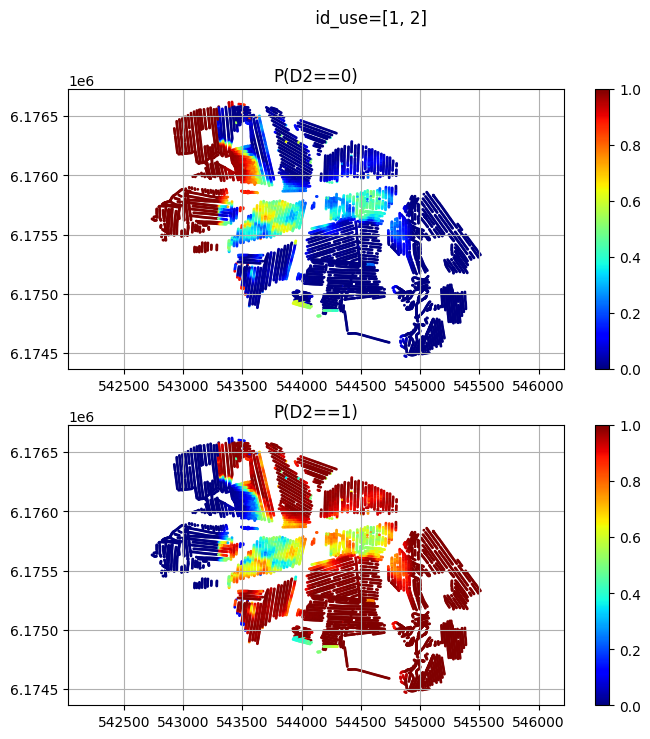

In [7]:
id_use_arr = []
id_use_arr.append([2]) # Dicrete data
id_use_arr.append([1]) # tTEM data
id_use_arr.append([1,2]) # Both discrete and tTEM data

f_post_h5_arr = []
P0_mul = []

for i in range(len(id_use_arr)):

    id_use = id_use_arr[i]
    updatePostStat =True
    f_post_h5 = ig.integrate_rejection(f_prior_h5, f_data_h5, 
                                    parallel=parallel, 
                                    updatePostStat=updatePostStat, 
                                    showInfo=0,
                                    Ncpu=8,
                                    nr=1000,
                                    id_use = id_use)
    f_post_h5_arr.append(f_post_h5)

    #% 
    im=3 # Scenario Category
    with h5py.File(f_post_h5, 'r') as f:
        print("Keys in POSTERIOR")
        print(f['M3'].keys()) 
        post_MODE = f['M3/Mode'][:]
        post_P = f['M3/P'][:]
    
    P = post_P[:,:,0]
    P0_mul.append(P)


    plt.figure(figsize=(8,8))
    for ic in range(nclasses):
        plt.subplot(2,1,ic+1)
        #sc = plt.scatter(X, Y, c=D_obs[:,ic], cmap='jet', vmin=0, vmax=1, s=20)
        sc = plt.scatter(X, Y, c=P[:,ic], cmap='jet', vmin=0, vmax=1, s=1)
        plt.colorbar(sc)
        plt.title('P(D2==%d)'%(ic))
        plt.axis('equal')
        plt.grid()
    plt.suptitle(' id_use=%s' % (id_use))
    plt.show()

    # ig.plot_profile(f_post_h5, im=2, i1=0, i2=1000)

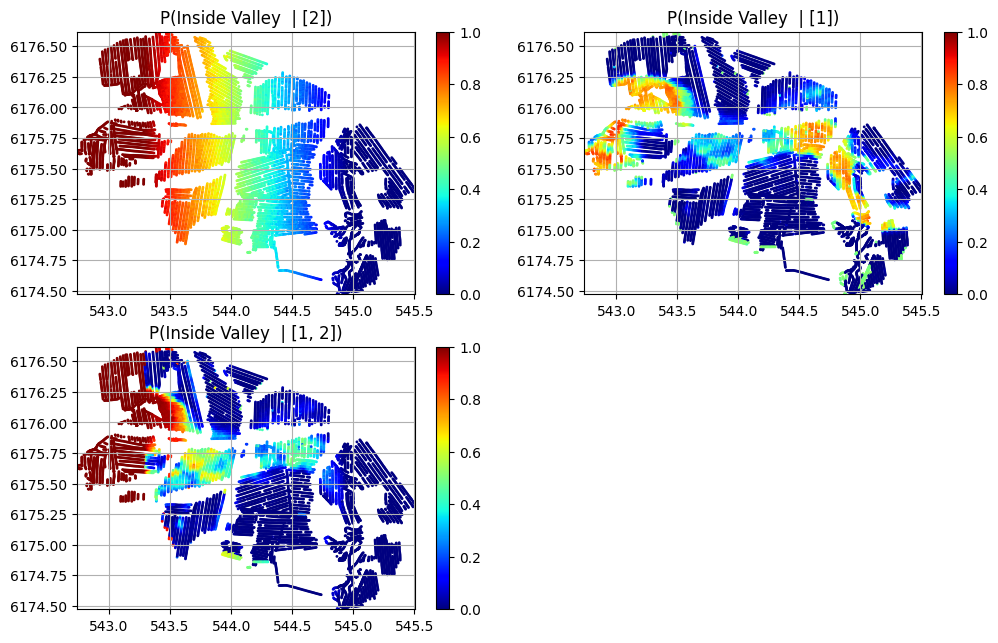

In [8]:
n=len(f_post_h5_arr)
plt.figure(figsize=(12,2.5*n))
for i in range(n):
    plt.subplot(2,2,i+1)
    sc = plt.scatter(X/1000, Y/1000, c=P0_mul[i][:,0], cmap='jet', vmin=0, vmax=1, s=1)
    plt.colorbar(sc)
    plt.grid()
    plt.title('P(D2==%d)'%(ic))
    plt.axis('equal')
    # TIght axes
    plt.xlim([X.min()/1000,X.max()/1000])
    plt.ylim([Y.min()/1000,Y.max()/1000])
    plt.title('P(Inside Valley  | %s)' % (id_use_arr[i]))

    

